<!-- ![FOTO](./img/logo.jpeg)  -->
# ***Deep Vision para tareas de clasificación***
## ***By Noelia Otazo Rojo***

### Objetivos
**Evaluar y comparar** estrategias para la **clasificación de imágenes**, la solución deberá estar basada en el **aprendizaje profundo (Redes Neuronales Convolucionales CNNs)**.

### Contenidos
1.   **Carga** del conjunto de datos
2.   **Inspección** del conjunto de datos
3.   **Acondicionamiento** del conjunto de datos
4.   Desarrollo de la **arquitectura** de red neuronal y **entrenamiento** de la solución
5.   **Monitorización** del proceso de **entrenamiento** para la toma de decisiones
6.   **Evaluación** del modelo predictivo.

### Fuente de datos
Enlace al dataset que voy a utilizar para llevar a cabo el siguiente proyecto:
[Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection/data)



## 0. Preparación del proyecto.
En esta sección añadimeros las sentencias de instalación y las importaciones de las librerías necesarias para el desarrollo del proyecto.

In [2]:
#!pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/c7/ec/9dabb6a9abfdebb3c45b0cc52dec901caafef2b2c7e7d6a839ed86d81e91/opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB 667.8 kB/s eta 0:00:58
    --------------------------------------- 1.0/38.6 MB 10.1 MB/s eta 0:00:04
   -- ------------------------------------- 2.7/38.6 MB 19.2 MB/s eta 0:00:02
   ----- ---------------------------------- 5.2/38.6 MB 27.9 MB/s eta 0:00:02
   -------- ------------------------------- 8.2/38.6 MB 37.3 MB/s eta 0:00:01
   ----------- ---------------------------- 11.5/38.6 MB 59.5 MB/s eta 0:00:01
   --------------- ------------------------ 14.9/38.6 MB 65.2 MB/s eta 0:00:01
   ------------------ --------------------- 17.8/38.6 MB 65.2 MB/s eta 0:00:01
   --------

In [21]:
# Numpy
import numpy as np
from numpy.random import seed

# OpenCV to process images
import cv2

# Necesario para la tranformación de las imagenes de tif a png
import pathlib
from PIL import Image

# Directory indexes
from os import listdir

import shutil
import random
from pathlib import Path
from pprint import pprint
from collections import defaultdict

# Matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Pandas
import pandas as pd

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormaliz
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Sklearn
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Ploteado del esquema gráfico del modelo
# from keras.utils.vis_utils import plot_model

## 1. Carga del conjunto de datos.
En esta sección cargaremos el contenido del dataset para su posterior uso.

### 1.1 Carga del conjunto de datos.


In [15]:
# Data
test_data_path = 'histopathologic-cancer-detection/test'
train_data_path = 'histopathologic-cancer-detection/train'
train_labels = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')
sample_labels = pd.read_csv('histopathologic-cancer-detection/sample_submission.csv')
# Obtiene los nombres de clase únicos como una lista
class_names = train_labels['label'].unique().tolist()

# Asegúrate de que los nombres de clase sean strings si es necesario
class_names = [str(name) for name in class_names]
print(train_labels.head())
print(sample_labels.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
                                         id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0


### 1.2 Establecemos los parámetros
Mediante modificaciones podremos ir probando a ver cual se ajusta más.

In [6]:
# Params 
# Train 
batch_size = 8
monitor = 'val_loss'
learning_rate = 1e-4
epochs = 50
early_stopping_patience = 4
train_backbone = True
version = 0
plateau_factor = 0.5
plateau_patience = 2

# Model 
input_shape = (224, 224, 3)
model_name = 'NOR-HISTOPATHOLOGIC-CANCER-DETECTION'

La carpeta train tiene 220025 elementos con proporción 0.79
La carpeta test tiene 57458 elementos con proporción 0.21


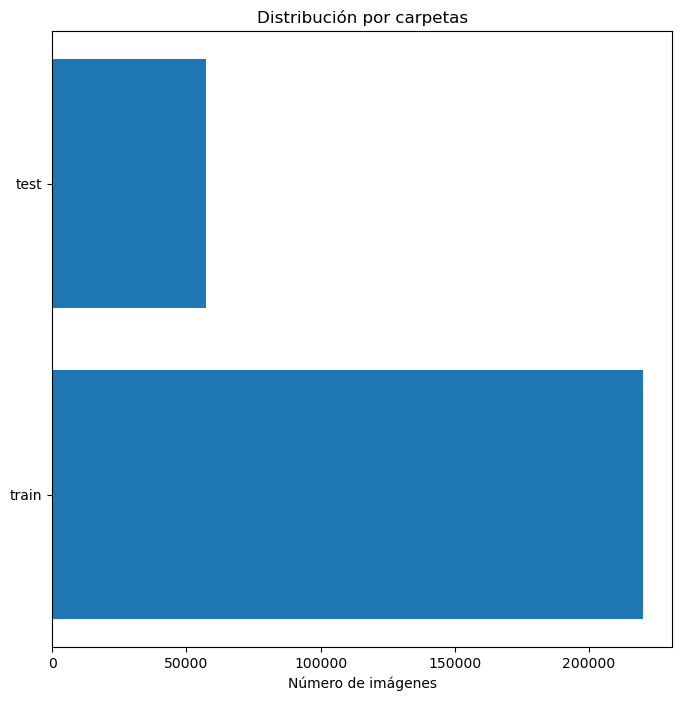

In [8]:
# Crea un Path object para el directorio de entrenamiento
paths_train_dataset = list(Path(train_data_path).rglob('*.tif')) # Suponiendo que las imágenes son .tif
paths_test_dataset = list(Path(test_data_path).rglob('*.tif')) # Asume lo mismo para el conjunto de test

# Ahora, podrías querer combinar ambos paths si deseas contarlos juntos
paths_dataset = paths_train_dataset + paths_test_dataset

dict_dataset = defaultdict(list)

# Agrupa las imágenes por su carpeta (train o test)
for p in paths_dataset:
    dict_dataset[p.parent.name].append(str(p))

# Imprime la cantidad y la proporción de imágenes por carpeta
for k in dict_dataset.keys():
    print(f'La carpeta {k} tiene {len(dict_dataset[k])} elementos con proporción {len(dict_dataset[k])/len(paths_dataset):.2f}')

# Configura los parámetros de la figura para matplotlib
plt.rcParams["figure.figsize"] = (8, 8)

# Crea el gráfico de barras horizontal
plt.barh(y=list(dict_dataset.keys()), width=[len(dict_dataset[k]) for k in dict_dataset.keys()])
plt.title('Distribución por carpetas')
plt.xlabel('Número de imágenes')
plt.show()

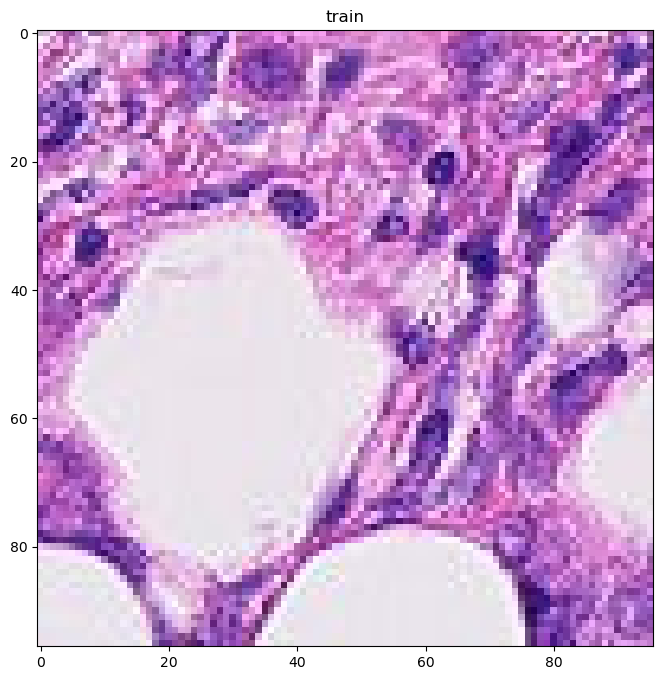

In [9]:
sample_path = random.choice(paths_dataset)

plt.imshow(cv2.imread(str(sample_path))[..., ::-1])
plt.title(sample_path.parent.name)
plt.show()

Los índices por clase son: 
{'test': 1, 'train': 0}


La distribución de los datos por clase es:
{'test': 0.20706854113585338, 'train': 0.7929314588641466}


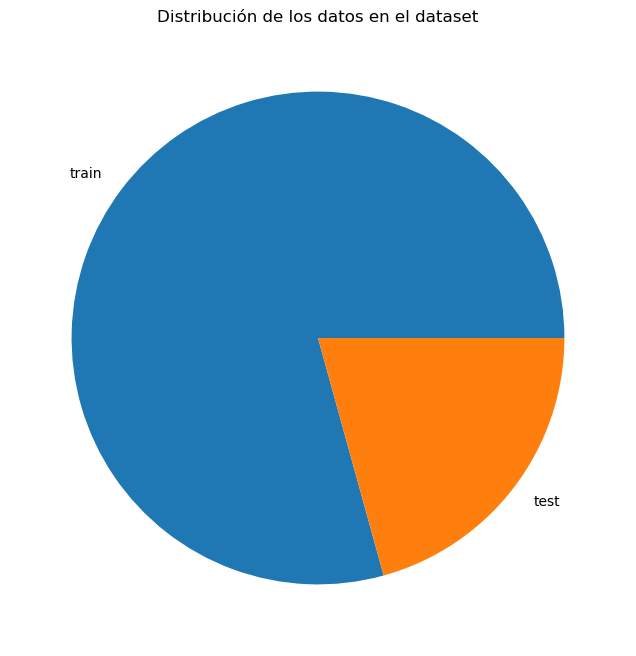

In [10]:
names_to_index = {k: i for i, k in enumerate(dict_dataset.keys())}
names_proportion = {k: len(dict_dataset[k])/len(paths_dataset) for k in dict_dataset.keys()}
print('Los índices por clase son: ')
pprint(names_to_index)
print('\n')
print('La distribución de los datos por clase es:')
pprint(names_proportion)

plt.pie(names_proportion.values(), labels=names_proportion.keys())
plt.title('Distribución de los datos en el dataset')
plt.show()

La distibución por clase en los datos de test es:
{'test': 0.20707425626610448, 'train': 0.7929257437338956}


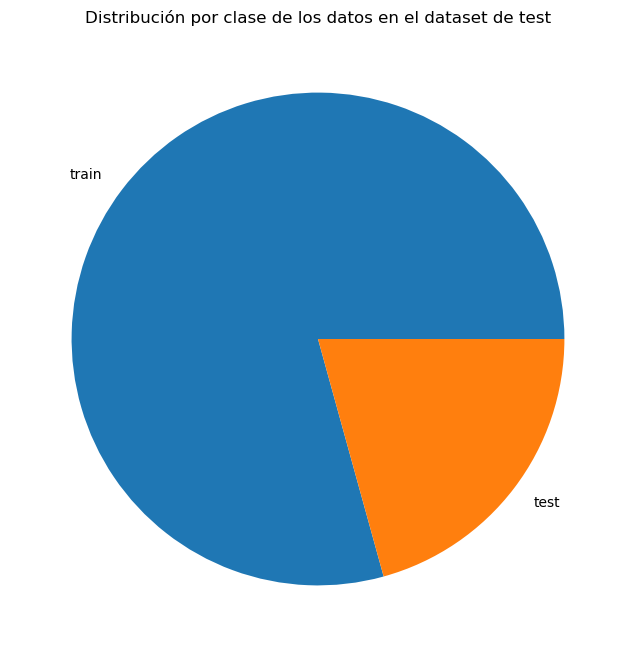

In [13]:
X = np.array(paths_dataset)
Y = np.array([names_to_index[p.parent.name] for p in X])
assert len(X) == len(Y)

# Hacemos el split estratificado en train y test
sss = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=42)

sss.get_n_splits(X, Y)
for train_index, test_index in sss.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
assert len(X_train) == len(Y_train)
assert len(X_test) == len(Y_test)

unique, counts = np.unique(Y_test, return_counts=True)
counts = counts / counts.sum()
print('La distibución por clase en los datos de test es:')
names_proportion_test = dict(zip(dict_dataset.keys(), counts))
pprint(names_proportion_test)

plt.pie(names_proportion_test.values(), labels=names_proportion_test.keys())
plt.title('Distribución por clase de los datos en el dataset de test')
plt.show()

Esto es una particion fisica de los datos hay que ejecutarla unicamente una vez.

In [14]:
def create_test_data(X_test: np.ndarray):
    for path in tqdm(X_test):
        path = Path(path)
        assert path.exists()
        dst = Path(str(path).replace('train', 'test'))
        dst.parent.mkdir(exist_ok=True, parents=True)
        if not dst.exists():
            shutil.move(path, dst)
        else:
            print(f'El archivo {dst} ya existe en test, lleva cuidado de no ejecutar muchas veces la función')
    return

#create_test_data(X_test=X_test)

  0%|          | 20/55497 [00:00<13:31, 68.33it/s]

El archivo histopathologic-cancer-detection\test\5037946a1166325d5a556d059ba2780edb7b1bdc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4faa07ada764b0f7f81af857be1ac7192accc05f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f0c198f0034853d2e8dce18288b4e2e46db36d6f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\96f22343ad3acefc13098e4064dc5d802c98212b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  0%|          | 28/55497 [00:00<15:13, 60.73it/s]

El archivo histopathologic-cancer-detection\test\d2532db18c5ec8182844d32ce62328b807775daa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ba1e720eec73f881e777ebcf385f9ddfc43ee1fb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\82ae2b263319f54bd2084ca02d3b02dd96bb8dd5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\05b915bbecff3705f30888e2f166537f5c1b5c43.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  0%|          | 43/55497 [00:00<15:16, 60.50it/s]

El archivo histopathologic-cancer-detection\test\aa7d66303b08c2ff0b4c44a136a9bee31663d5eb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8b4c1bda3b998cc5521da484056c91974245636d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\14148e758d283c919b2d890084aa04494432c1dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8898dc4d3411e0e87e2ddc12a1c2d494fed7c285.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\90f6f386e356e290f918ad6e76385da89df257f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  0%|          | 64/55497 [00:01<15:12, 60.73it/s]

El archivo histopathologic-cancer-detection\test\963b25b6ecdea5c1721ddbb2fefdedda7e7f3047.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\817b148f04025ed4699bee92c9ac6a3d51eafc36.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\357b7902e885d3e75799d7f8fab4e52664db9cff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9c1d08455c6fa1bbe93b853d0306e7295e1fd614.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\61eeb41fa7c785a6784cbd2cf0810b2f88d24595.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  0%|          | 77/55497 [00:01<16:28, 56.06it/s]

El archivo histopathologic-cancer-detection\test\7c66a57da1a136019e408c934977f589eea34a87.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a053accded888c7d1b88aa3f4cff4766030ef67a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1b8a11385ff4441b22dce9657b7e70b019238bd3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c85c88f2f0d4f239da1fa446b28214d629e0b87c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  0%|          | 99/55497 [00:01<14:39, 62.99it/s]

El archivo histopathologic-cancer-detection\test\2e7a4b2901cea8dcb3d9dc1f85663740b7e99c82.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d8ed1d84ccff5eca49f1b7ce597154f03b0ef76d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\41859472075a4dfe5444891e3d20a9d076daa641.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\434102efd465af173238b4edc586747ef9d14a01.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  0%|          | 113/55497 [00:02<17:57, 51.41it/s]

El archivo histopathologic-cancer-detection\test\776333cb46ba0ddcb06b3e44d120f199538b95a0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6f5e570eaef2d8287ab7e204653e935e849dbdf0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  0%|          | 126/55497 [00:02<18:16, 50.49it/s]

El archivo histopathologic-cancer-detection\test\09bf848e6a19af357d73f26246985346de56ca50.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f1b9d811c5bfe24a51a5dbe8d1168311d34e4ec4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  0%|          | 144/55497 [00:02<14:26, 63.90it/s]

El archivo histopathologic-cancer-detection\test\62cf6f624ffee530f32fbb7ebce68dc8afa64ce3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2edc165157e9d1619be4374fde3556bb0c5b8551.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f7c32892c8f9976506d56be19c8a28850df582e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\698a9b8ca516d9b958f84d12628c52a767a73f3e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ff649019bf08d78917c31b00a891f4b136e880ba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ae8e2797929a717e06bbd0b1ae40a6530c0ab5b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

  0%|          | 161/55497 [00:02<13:03, 70.59it/s]

El archivo histopathologic-cancer-detection\test\1f983872d4629d5ecd9f57fb8ba06a9cd462d958.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5b1ff5fadecf20fcfb3502bb60db99ee3020f669.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c7d39bda18c340d55010c97e024bfb918f666898.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\32131e16af7c43a582f89fc48871e20cfc65db22.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\90fc61ad55cb2693babbaa288fb328cbce5447c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a9ee57ed36c8077e5cba2c19be39fd127c665ec7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

  0%|          | 179/55497 [00:02<11:57, 77.13it/s]

El archivo histopathologic-cancer-detection\test\d231f4b292bde18c5bec90f5835eb408468baedb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  0%|          | 195/55497 [00:03<15:20, 60.07it/s]

El archivo histopathologic-cancer-detection\test\4164ed94f1fbb44ba0eed271207f3c2ec6a7c329.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\078e2339967d27b5bdc28f2d948c128b22cb7925.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0c2cb20e219d0aca34d7e192e44d12ce7d805278.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  0%|          | 209/55497 [00:03<15:55, 57.87it/s]

El archivo histopathologic-cancer-detection\test\dc49c4edbe88539db1c0fae63ca61cbed62c7071.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1c98103bf3ee758dd0b40214ea1321630623c211.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0b7d30379e2843579ae4ed2f5f1a17067c674857.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  0%|          | 229/55497 [00:03<16:14, 56.71it/s]

El archivo histopathologic-cancer-detection\test\787ecb9ff25d4e1c6c07d2d36067e079b9408e48.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f1ef9331e04a698b42f70be3137d84a27f2dbf82.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  0%|          | 257/55497 [00:04<14:52, 61.89it/s]

El archivo histopathologic-cancer-detection\test\f6cfa9180cfaf737284e23299af53c8ee7edec44.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aafd57f079536766a6f125bccf04a5d811b47eda.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3bb89700e3d5144825474b1b71f72131dc52a230.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\04114302bc161973a383aaa7d4e3506573d49fa0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  0%|          | 264/55497 [00:04<14:51, 61.96it/s]

El archivo histopathologic-cancer-detection\test\478b07666158cc1607212375a43c666b65e55399.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d2e55e6392c5996b6b7ff7a9c1af137fc1eeeea3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\06c8ee206358103146b306a76c669eb55846d8c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  0%|          | 277/55497 [00:04<18:35, 49.51it/s]

El archivo histopathologic-cancer-detection\test\2f974d6e326da95b3b2f737fdc7999734762d6af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\999c31686e1e7b971bedd5efa498d7526d166ddb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|          | 299/55497 [00:05<17:07, 53.75it/s]

El archivo histopathologic-cancer-detection\test\f1d1365fc61bb629df2c289d55ab91d65e1fce21.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3a8bfd1cae3f9aa2e7ee76b7707883b586816259.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e5dd6f917a3dcf4afa72cdcc7fdca6738e22af6a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|          | 313/55497 [00:05<16:19, 56.36it/s]

El archivo histopathologic-cancer-detection\test\24d668355acdab6bf9e95da9aef361b1c04a079f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e32d952e5123a51b20280d617aa78f6519d64bbc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\13c52e347822d5604d2c7b3454e7e9797ef37741.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\933346713818efdca8d579ae5f6a8a9831b3f202.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d2d9a857177ea7c717c68410256865dac07ed84e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|          | 320/55497 [00:05<16:06, 57.06it/s]

El archivo histopathologic-cancer-detection\test\f6c4626ef1bd54cf4734b58cc60e3724e7212b23.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7ecbaee424196569f9a1802f3e2d5bd338ad0189.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aa1a7e96cb3dc829417231734ddb4443e6635cde.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|          | 334/55497 [00:05<15:22, 59.77it/s]

El archivo histopathologic-cancer-detection\test\1397c9b87660864254abd6a0bd1161882ab145d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0a0a1f3867f41e02353afcaf503f63be1bdd35ec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\570c70d1e80b254febebc729fc70a0bbfa0a5c5e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|          | 358/55497 [00:06<14:24, 63.78it/s]

El archivo histopathologic-cancer-detection\test\e3a07a42c7320d3329280ff9640fffc7f01e4a2e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fc344d29f7e4d622838a2e04e0cb4f6298953ab7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aa2ca9b7226ab1e279a800db16f4b10279e8044a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5105f7009697dfdbbf3ef5f66c6ea166e7fd3753.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\426618ddc60b8c5afce5732fe8fcd40087b804e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\650fe7147dcbc72dd0185d19eaff1717250e7f11.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|          | 372/55497 [00:06<15:19, 59.95it/s]

El archivo histopathologic-cancer-detection\test\ca4c162e7a35d3875faa272682981c8574e3902b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\573cc015d91202fe02763cf338b0b8305ad1b76e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\43d1f84af53078d80722471ab390fa2e09802d57.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|          | 397/55497 [00:06<13:08, 69.86it/s]

El archivo histopathologic-cancer-detection\test\4e5cc9f2ea85cb6395589b084416c7124ddcb698.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|          | 405/55497 [00:06<13:19, 68.88it/s]

El archivo histopathologic-cancer-detection\test\98bc3a597485f8bdeb89831829547295ea887bfa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fc20ac5241e7e5c905f9a1f6fd6d2a6d28e75cb0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\535e23bc9e4855849f559740608aa48f8f8269f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4eba995fc74568f66e7c730bb6d9a3c7b66e51ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|          | 420/55497 [00:07<23:23, 39.24it/s]

El archivo histopathologic-cancer-detection\test\112d16c637013e4766c2613e575abc023f9259bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\976d02cb27fc2098693b788c3f51738a9284d93a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|          | 438/55497 [00:07<19:43, 46.53it/s]

El archivo histopathologic-cancer-detection\test\057c2f1a1c824b57ea7aea051b2b6443023ec394.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|          | 454/55497 [00:08<15:35, 58.85it/s]

El archivo histopathologic-cancer-detection\test\f505da51969669f447430149053a67ac1a1f7f20.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5cbf4a0b62df24d83c8a3ee9082dec67fd4d58b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\44a8b1ddc38fe8270f5fab78c47e284ab8cdf2cd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ea40c6a36fbc017e7ddf297a2b62238ae33b35c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|          | 468/55497 [00:08<18:49, 48.72it/s]

El archivo histopathologic-cancer-detection\test\b52760841d1ce7c02216491f4f244e8f7fd4e99c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ac03cd16b18c9bad9626612ef523002bcdb7db2b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b4df3401a6a921dfcdd0bbaf6dc8b82a93b543a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9d0bc0179ff7e0e0a2f8a7cfd159f0a92288da5f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\828bd81cc36b22b26c45c1e8c4f1046010dc6bdc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\160d0bf95acfec56be9b5f25ff4d36850a157ac3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|          | 481/55497 [00:08<17:14, 53.18it/s]

El archivo histopathologic-cancer-detection\test\a566ae635e9efcddd2d78d4c3450bd56a5081d35.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4d7c32c852777e8e3d0885b5c6d6c0aacf029107.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d660f2c07c8ecae15fedb9a6796276d7039ff5b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7a071fec7cf21d40b5f543ae8a6cab173a2de3a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|          | 494/55497 [00:08<17:11, 53.32it/s]

El archivo histopathologic-cancer-detection\test\6e881f6b7ba50f0a404d23e74e295a9b1af09a6f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0651af93a95da5b3c82071aaff463348afb0086c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\608542d3f55355b59d2a0b9cbd8b0e9525075a74.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dd52e9ad03e746aff71b1d81c1cf168ec6dcdf57.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|          | 517/55497 [00:09<14:16, 64.22it/s]

El archivo histopathologic-cancer-detection\test\68365c0f1c3ad83b11ebacb11c5f0b2c90a154ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\76af17bd922839271cfaccfe1fd9484e3c5b8693.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1c1bcd667b5dc64dd427c15124dbc757690329e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|          | 531/55497 [00:09<18:07, 50.56it/s]

El archivo histopathologic-cancer-detection\test\ba9848a955667a87fa4fca1dab64585cbd822e30.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|          | 544/55497 [00:09<18:50, 48.60it/s]

El archivo histopathologic-cancer-detection\test\638e7bb74c16db19a872bdb032abf598b35eb433.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|          | 555/55497 [00:10<19:22, 47.25it/s]

El archivo histopathologic-cancer-detection\test\945c6879fe8c1b95f9095b722af48ef9223f4986.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e470446f41778b40bee0b0545027df9e70dc57c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\64a2052ebbd3a71b57a4a59c41366dcefac39a43.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e5daa6974274e1ebf5f5c68c5e61137465055e95.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ad25260a4b184e2743ace16e48eae854a5391318.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|          | 569/55497 [00:10<16:04, 56.93it/s]

El archivo histopathologic-cancer-detection\test\3cabf5139f5c7e43fd45245731cc6252c20e2740.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\359cbdd74245a7c728d146a035bc612e7bcb3ac3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7b76a026bae4b1ad5e203eb5ddb7053f4b2beea4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|          | 593/55497 [00:10<14:40, 62.35it/s]

El archivo histopathologic-cancer-detection\test\880d4146bdc53e278534d1a4f832ee8f2ee0dfc7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\82e2799c13c6aa63125cc05f7815f2ddd1e5576b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6b7627a274f20cf4df48dd75a60466e5baac8e06.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c3c2a6d475a28400e80e978129ff4064398651e0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|          | 618/55497 [00:11<13:39, 66.98it/s]

El archivo histopathologic-cancer-detection\test\0eb18013d80925aca6b102af906c3559db3c45b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\603d6d1f184dcc917293c67d399c2bde4d25e869.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dc411e8f64a551e8c50ed82ef72910c2ba8082b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d2ad0eed42b50e14338d31776e012c0c795969bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\66391154e93b23fcfebe190a3fb34003c11f8932.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|          | 632/55497 [00:11<15:01, 60.86it/s]

El archivo histopathologic-cancer-detection\test\7d2ae141b4ed4e538bfb95d06fc54e8799c34cf4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c1c4b0d968275749378b58632284d7df157289ed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a4a617327c9fa179728cc7ad215f6dfeac52c74c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e84625b99fa59c2d8260b344ab21f7b66a3ab6f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|          | 685/55497 [00:12<16:51, 54.18it/s]

El archivo histopathologic-cancer-detection\test\4b4e1e0e837b612cba5e7a381c6dd4777c2c4cb1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\81030168f284911567aa8e2fc1a761dd0700d40a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|▏         | 697/55497 [00:12<16:41, 54.71it/s]

El archivo histopathologic-cancer-detection\test\d8ffd8de053dd264bffab372b9a62c882f766641.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e60d842958bd0a3e7fdad2593cda6e26dddce9b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\48771bf1311b30988ec4b0f57436bbebc68a139c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|▏         | 704/55497 [00:12<15:44, 57.99it/s]

El archivo histopathologic-cancer-detection\test\d1525953175126808a024ea6736366c3655df792.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9e2dfe21b5b7eeeaa3001cddaa4ce590a176f833.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\850933153b2e51b8141748ccaf5fadee5ac2e8e6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|▏         | 711/55497 [00:12<20:00, 45.63it/s]

El archivo histopathologic-cancer-detection\test\02595caf8490fe3ac7893a4d2a84ecf3a7900c78.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|▏         | 717/55497 [00:13<26:06, 34.97it/s]

El archivo histopathologic-cancer-detection\test\bbc718c26d8b9a476ffb300f50929eb611c83b5e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|▏         | 738/55497 [00:13<28:17, 32.26it/s]

El archivo histopathologic-cancer-detection\test\5367732a7a70e472b3a94fcc6ad6db377cc94f15.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a2b275607121c5849a233b12586a8b7f0da2d1b4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ea5c8559b6cb08c6e41d9cc2c56dd3253b035423.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|▏         | 757/55497 [00:14<21:35, 42.26it/s]

El archivo histopathologic-cancer-detection\test\37327bab8a8905d15ccdc207848a182c503b3639.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c39cabdc50543ef23d8762e68e9cdf8790397644.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5db55f7d7d697c8f43c0ebc59b017af9992f47e5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b5cbc83f56659b52fa764482b5c230baf5e88273.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d8e7bcd65f1d54d2ce18d10a5080e7dece7ede55.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|▏         | 770/55497 [00:14<18:12, 50.08it/s]

El archivo histopathologic-cancer-detection\test\5772715877fb21e62dd216bfa466e333161e6aa6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a91e92cfb71237a79fa0bea26cc22c2f8a81eb1b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f918d33d4b30bcfb8cdcc82c8cb8c885f676dac2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|▏         | 788/55497 [00:14<18:23, 49.56it/s]

El archivo histopathologic-cancer-detection\test\3c181e5f0c42dab97d7b4f20ed4f18d4f034141e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8f2cb93cf8b923ef3296663ffa10ddf1aad970da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|▏         | 801/55497 [00:15<17:27, 52.21it/s]

El archivo histopathologic-cancer-detection\test\e8641b9c189642781caa9052c6d0f835a930ebb1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d783663380999031dbae37aa3a9cb05c70932618.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d1424d18aa2accb6ecb1fe012a997836ec7d783a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|▏         | 819/55497 [00:15<18:57, 48.08it/s]

El archivo histopathologic-cancer-detection\test\2d42feb02b5227a8ae22ab16fefea0ef1ff1c207.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2d9655cefac4e2040a79908a86c6138674253254.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\334fe500dd69c8858edbfc07f3dd643e0c05bca3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7972659149d35f2bce61ae16f28a374f79ad197e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4b5869d5c93a670e63372366a15d8156384564eb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  1%|▏         | 832/55497 [00:15<17:34, 51.82it/s]

El archivo histopathologic-cancer-detection\test\9f88a04b6ae8d1ef19d7ea9cde85c726fc060591.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b33b155d71df96216b4d7cdd3323dc5039f9258a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 854/55497 [00:16<22:13, 40.97it/s]

El archivo histopathologic-cancer-detection\test\ece0e67af8c12ad3565fd7fd78be0f5f82a58985.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b63b3e59b719eb323b87a724c7f39d15a922914c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\249dba9510b79863c75dc82a75d5844f036474de.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 871/55497 [00:16<20:55, 43.51it/s]

El archivo histopathologic-cancer-detection\test\89d80fd2f70dc668b85ae08ad5337ac8790b4136.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aea27007dbc5de5f5d2a3a4144b6a3e23bd7f269.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\687e825f060b7d0f8a7f8de04f81ffcc33d47508.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8d4fea56674e8e79a200040a5f87791276cc073b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 892/55497 [00:17<16:22, 55.56it/s]

El archivo histopathologic-cancer-detection\test\c203eed6f65a5e9e49c9cb67f2cebb4e5b4448dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7a4b04592672d701dd6372a00ebe4c51a3081170.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 904/55497 [00:17<19:26, 46.82it/s]

El archivo histopathologic-cancer-detection\test\476999f927d2d7bf0a5c118e5136844c96d524d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\82db6d04ccb4f1f4c25d3afa1f182ee209b834f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5731dc3f949e0d187647a7ac476546809e47bc8d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 915/55497 [00:17<18:34, 48.98it/s]

El archivo histopathologic-cancer-detection\test\4c60028ea6deb6e7b83ed6c8ad3bf1936e939069.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6367288d734dc86a34739f6d19b4aa01eab9617e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f04e8ef6fb599ee340c97e524f5f6bc81684d9d9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 931/55497 [00:17<15:06, 60.22it/s]

El archivo histopathologic-cancer-detection\test\955b359a95b58563edfd21f81080f3141c7a54b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c588c27fad19a6afca72179474e25fd3db0ca8dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\628b4fdf7e76509c38afd83d3bb4b9f4232f4a56.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 946/55497 [00:18<14:35, 62.28it/s]

El archivo histopathologic-cancer-detection\test\d90718722259dbd32aad2b2a0ab4dc85788fd21a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6266cee7fcb973c9246fde08ed4a9f8ef2dccffb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\47d20dc876de1cd9af91c559f0a20acd0ce0fd11.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 967/55497 [00:18<14:58, 60.68it/s]

El archivo histopathologic-cancer-detection\test\d482c6d013e2e2c02317a537221f78c312b7466e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\673736fe8a7a651e8a3665a617f69059d16b97e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bc4c61683efcba6035ac5099417b2e616f94d798.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 981/55497 [00:18<14:13, 63.89it/s]

El archivo histopathologic-cancer-detection\test\455e5587368b1b36261caf26d41192c2ee59a7a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d84a62519dacee623abd69586b6968504bd61dbb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e9a8fae30177f50e726ea71bb18b7e2267e01c91.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\47f90be9e4198f66c1ded0e77c091e2ad6d28e51.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e4f0cf4be9d2bf01013232e39cb4f58f05d55ee0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 1003/55497 [00:19<15:51, 57.28it/s]

El archivo histopathologic-cancer-detection\test\dbe7072f2d14b13a1233d71f434b44de8b77bfe6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\36b76ce5fa55ded296130104e7872922004e7d0e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d400d9608d652e0c19fc7fd3607c650c9d117c7d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\faaa31e27934e4950bb4868e3a203eba49b33961.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 1018/55497 [00:19<14:57, 60.69it/s]

El archivo histopathologic-cancer-detection\test\eff4ac3e22b55d5433aa30a264f733ca097e3908.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aa571988075b0a27084c94d86508b3f59f20724d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a18a017186a0d513752d71fae91cebbc0660a928.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ee0e770e972103d804bd039683e059713c70d898.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\52efec99eb7f4a3c1351d639f8bef7cd85005a6f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3c3cd91925b96ac2753eb684a924aa166219b280.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

  2%|▏         | 1033/55497 [00:19<16:09, 56.19it/s]

El archivo histopathologic-cancer-detection\test\bd9dd10bfd006928ad24d18a278216c90ad4c642.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1df0c7debee68fabb6f585750d6a71304c664bc2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1e6d9611a50e74f92ad2e5b00b603b6e561907bc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 1046/55497 [00:19<17:10, 52.84it/s]

El archivo histopathologic-cancer-detection\test\c53b93e202f99646f50bf160e87962f744d527cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f006e75865d27cbe983ba0427addeb38bea0ec32.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eaa1317141b7302e053d475daba0e5a9946d430b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ab0a3230b04a3812e679f12a06ec078bc69cfdf8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 1060/55497 [00:20<16:51, 53.80it/s]

El archivo histopathologic-cancer-detection\test\6c6a66cc8cb02c1e12197523b730b960d3bd230f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f1d5c747e92e6abce7bbe96231c19e2ecaca1cf4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5f1d0f10b55b38106a5c9573e351d5e525f02d92.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 1074/55497 [00:20<15:08, 59.88it/s]

El archivo histopathologic-cancer-detection\test\3c11034558805f93f1352d357a3c1f3842982731.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\92953a66c0f6448df8c434eccab7f5b186ecc270.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\89ac1c50d7ced1033dca0b524b4a98ef9dc52b06.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\edc7d9bc0f20bd8a5a1ce0c17f5c271f92084715.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6b4ea4414b3b3b96d7278c1db3c3ba333f4c7697.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 1081/55497 [00:20<15:22, 58.96it/s]

El archivo histopathologic-cancer-detection\test\dfc6faeb3e19cbd935d1c98af6930750adbe3c97.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4a8419ba9068ead97e8c1c53eb5805fdaf8158fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e3f4d8077b0edc6b343a367dca3a2df41689cb36.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 1104/55497 [00:21<16:18, 55.58it/s]

El archivo histopathologic-cancer-detection\test\8594f23002e6666acf465c66272b0937a5b005a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6b890ef3b4569c55fb90792079481b881c84cc56.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\79b2afa5fd0fcad15d4a1e492a9a5043fcc148d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6ab5197d8a438252f29816d70bb7190de44895ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 1117/55497 [00:21<17:46, 50.99it/s]

El archivo histopathologic-cancer-detection\test\c663bb653bb21a690bec6cf5ef7eb391e32309c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cdd08ef5c3b8897a3ee7ee23e3717ca78cf19f17.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b3952247ea18737e213dc1fd733f700c7a5d9ba9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b4dc9d6b98c926ff01cb44d23173f13f83d6cc59.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 1129/55497 [00:21<16:50, 53.80it/s]

El archivo histopathologic-cancer-detection\test\c8e6826cababd4f92672401060459451220f1c9e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7e266a1993ce4100686530fdb838b1d2e56c5e55.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 1147/55497 [00:21<16:47, 53.95it/s]

El archivo histopathologic-cancer-detection\test\f9405a6a0875cb6601ffd33cf5928796f5a8e12e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0f41d5152a79f9207a0fc1eb2374c897a6f91a73.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\86df396d51bc3ff138910d9a9f62258f808618a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 1167/55497 [00:22<15:17, 59.22it/s]

El archivo histopathologic-cancer-detection\test\77ef976c25c33ed9934f35220c054f02df31e0e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4a66b20bc810298a4077d338a8405a86db314cf5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\438671bc24534557cbe1ef2da363fddb693b1917.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7c2c333eff6d1fd46115788c7f11816e5233381f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e18211b40ed94143add4b0ae72b7ea03ecd0178a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 1185/55497 [00:22<21:07, 42.85it/s]

El archivo histopathologic-cancer-detection\test\90a7f082945278561a3a3064522443830a545f41.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\29135f009d06794b1f61b8eca2022530effdba89.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0b2351047706950ea69f80fb8b3ea30b1ffc8739.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 1204/55497 [00:23<18:00, 50.23it/s]

El archivo histopathologic-cancer-detection\test\7ad1c19b98b802281ad95c412cf34fe8ff3b9c84.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f238be21346e5e5d3749f51b02d941340073b16a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 1211/55497 [00:23<16:48, 53.81it/s]

El archivo histopathologic-cancer-detection\test\5e27b2cd27ef3b9e492ed2f3550240f7f0684f93.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ef6a63c81aafba836075dc8d99fb5eee39d3f446.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\afa9e27408d1d6c37784fccb5bd14d61b2925e31.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\811627648d73cbf9121ad265e03e8743d5d79bf0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 1217/55497 [00:23<20:14, 44.69it/s]

El archivo histopathologic-cancer-detection\test\8ab87535e7f2d56c23f57c2c977f3a08beb49a01.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 1240/55497 [00:24<25:31, 35.44it/s]

El archivo histopathologic-cancer-detection\test\31393fd5be3bb9941295a538210511a14b2e87c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9ed8b8d57c9ef7217f04df574ffef863651a80bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\15be9eed1d9766eff02ec97f00ab2421a5836cd9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\08ebc6f76c055fa25b32c0f7b07907a6ece5e95b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5486da1c2a1d6ed1c1a182b937f298a08c549615.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3da4d8b50cdc65403f89aee82085364540fe24f6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

  2%|▏         | 1252/55497 [00:24<20:59, 43.06it/s]

El archivo histopathologic-cancer-detection\test\12268940c4a99b6ec5171c17c572698dc24f0035.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e20cf225720b9dde970a00f7057a194d9df8fa7a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\45cdac9bf4a858dc1a6509c74ee8e9bb6f5619ba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b6a0e498b561bd6ca1a672c091cc749d7ddb44fb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6eeab85033ce670091b7f8f970b719319ee91886.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 1276/55497 [00:24<15:01, 60.14it/s]

El archivo histopathologic-cancer-detection\test\25272d93cce46f7cd6e480bab140c707efee226d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\69e135d02a23f08b011483c5b0d0439800f07233.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f7f96b539516933bde34fe879da0b73ee8eb8972.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\62f2c13e9bc79453cb21e763eaeac3257a97f5e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 1289/55497 [00:25<17:32, 51.52it/s]

El archivo histopathologic-cancer-detection\test\a780aa1f1210308350277b19d3dd1f58250cd1e5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b47819e2491be54e7fbc22f3f75471d26692fb30.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 1302/55497 [00:25<18:14, 49.51it/s]

El archivo histopathologic-cancer-detection\test\560c5ce8fe6eefdc7838f270eb1bb6934edd488d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1ca44db4dab09c57d6bb811330b18c633be8b048.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 1323/55497 [00:25<16:21, 55.18it/s]

El archivo histopathologic-cancer-detection\test\ee0aaa0511edf0d68c55888334ab75b934c2952f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5c05d159fdb7b09bf4a31ccef8fac5d91eeccf53.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1148edf8337e2b85747d592862784936bf4669b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 1336/55497 [00:26<18:00, 50.15it/s]

El archivo histopathologic-cancer-detection\test\4faecf23581c4328fa20df07578a2f3acd456ca1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\caaf318007633002548c0b42fa31346ec6bec383.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\74299278e10cf7ec932fe21485b149dda3d92a17.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f215830b206332d05b96319a9f63c8c58cd4aeae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 1343/55497 [00:26<16:27, 54.86it/s]

El archivo histopathologic-cancer-detection\test\9903d9e04c3cfd81d619fe95137e663f0154d64f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\08f4b22d2ddd2922fe9d0ddbbcc70eb8587e6a74.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 1359/55497 [00:26<21:05, 42.78it/s]

El archivo histopathologic-cancer-detection\test\1ed53ac8242777c77177e81c1a826d5311e0ecbc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\906d53d6f1ccce90ffadb99c1958b1dc4d6fdd7d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9b9ae309a4f1badb666d40b195a59a5848139501.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7ca7565b6ca9728504b41df820f3ac60f272a77a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 1370/55497 [00:26<21:20, 42.26it/s]

El archivo histopathologic-cancer-detection\test\6e57bc0fc934472f7670464d985284168a7c4b70.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9cca83b5f1f651c24df8b39719bf0c183ae374b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b42fe98a7a7c3d98e5019f5d07ed937f21b9aa45.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  2%|▏         | 1384/55497 [00:27<18:20, 49.18it/s]

El archivo histopathologic-cancer-detection\test\222211be91ce5893a608c811141a1e749f2358c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\40f352f346ef4e4e62ceb6e0b98e305dd16bfd3d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\166a99553d3cb058768572b78b254912ed43fd2a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1405/55497 [00:27<15:39, 57.61it/s]

El archivo histopathologic-cancer-detection\test\483aae1b1ddd3e380a8a0671454dba9c4920f571.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\695419c94c44c515e3cba4b2e3391acbd5885975.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b55b705e825b9e7e4362d45d153c5ff65ad3d2bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1412/55497 [00:27<16:16, 55.37it/s]

El archivo histopathologic-cancer-detection\test\4a36bede639d4b894687452bc3667e4bd1259553.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\34baa4acd4332f426d84ab858b14a516f55229e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1436/55497 [00:28<19:53, 45.30it/s]

El archivo histopathologic-cancer-detection\test\158d550dcc682319c92c8eb4aaa8483d38d8d8ed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6a9c88d15cf4504dec5689c7045bc925d1db74c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9bd29ae8aeb3df6a19d170421bf78689afefec57.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1450/55497 [00:28<16:03, 56.11it/s]

El archivo histopathologic-cancer-detection\test\948bdc13225913322f22a4049e59cc336a33348b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d98e1d94d99a0432a6830fa0a206bba14afb14ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\86ef3360388531b4a2a5b7e4355b201e0a622fbc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9715ff44405300de09d5a9f0b345ecd357906c0a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c8eb522320a14c6da7e503c29fb456868e84fd6b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1472/55497 [00:28<15:34, 57.78it/s]

El archivo histopathologic-cancer-detection\test\93390c224fd56c8383613ba4888fada6595f0704.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6fc80bd3189de6b224aa76c5a02cfafd66c9734d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4c8485c1bf58ab4758b9b68d40430a1c943bc473.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1485/55497 [00:29<20:01, 44.95it/s]

El archivo histopathologic-cancer-detection\test\edc696a558015c0c8ce5fd1557337e05e5789d87.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\511490f0992b112304abc118d7b08707325f5513.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b35498dedabf140a2700920f938bd70ceca1859e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1511/55497 [00:29<15:59, 56.28it/s]

El archivo histopathologic-cancer-detection\test\682ef5a66b697ea5f65299fe2d2338d17307af22.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fbfa372f521f8fc054b7543e83b98c3a213db33f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\59aebeabdb3d1b65afa7f3c5c94ed45caf6a0634.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1525/55497 [00:29<15:59, 56.23it/s]

El archivo histopathologic-cancer-detection\test\f2103994c857ae33d98af2d9e50cda4836658892.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d39c13cdb148f8fa570c8d1e9178e76813df43ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1538/55497 [00:30<15:20, 58.61it/s]

El archivo histopathologic-cancer-detection\test\4bccd6a44f55f1abe2ca54d5ddabab26ac7f9d5b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2673b0076306a1dc1f32e1cf9dd90f20a4a66a76.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0f10adf83296d830f0e791468842d3d675ddc95c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\816723152f1943f2690da5e00e71e79392886b00.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\39d68c189d2c206a6a16a61f170069b311a8e54b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1559/55497 [00:30<15:23, 58.44it/s]

El archivo histopathologic-cancer-detection\test\faee65fa33842011f295ab8d35e1eea3c9228ecc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3d9ad286c9254abd567a79cead9d90c9ddee0b84.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1574/55497 [00:30<14:18, 62.80it/s]

El archivo histopathologic-cancer-detection\test\d9627baa682eca5ae9efa1e67436ccd04a5b1667.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6afe9df1c92174357748f251116f764d5c394a74.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c67bbe76499703bcc028d731a141de98ccf62d99.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5dac714b81026a8cd0b90ebc74acdaaa26df1cf4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1589/55497 [00:30<14:49, 60.60it/s]

El archivo histopathologic-cancer-detection\test\b24d585997ebeb88a47e3614d7971c42a3fca161.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b9b1d2f2dfae9ceced48f29c0efe6c80a94e33f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1609/55497 [00:31<16:36, 54.09it/s]

El archivo histopathologic-cancer-detection\test\eac7bb1dd0744fb9ff50756cb73480e8bb42bfed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fae92867f1b4b93e44562c144a9fd8176289ec7c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1de5e08d67e3ec02618d05feeeec3bdf0ea8887c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1631/55497 [00:31<15:39, 57.35it/s]

El archivo histopathologic-cancer-detection\test\7ce3be024510147d276b17cc59ba2d651c40e884.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\54119ff763e831596fbd05c6d2cfeff8cfffc113.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\26ca197c1b25ea03d1a13e706d8919f9feb67f98.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\08ea6d0cabb7f26dd470d03454fe05f4182c9171.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b943399db03369ce76c30789ec95f1be42d26a6a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4051858a433d96412d625f8d2a774422f4935447.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1647/55497 [00:32<25:24, 35.33it/s]

El archivo histopathologic-cancer-detection\test\03ff5eb7bcb800b4c73d2d7dd31234353c5acfc5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8d307444802d37c477bb1615a3abffc07d5e774e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1659/55497 [00:32<20:30, 43.74it/s]

El archivo histopathologic-cancer-detection\test\02aa64ca1322b9dbe06963842a8f4ffbf720a8f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\202d9f6fe06a1a623db78ba287454640de45c799.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dc97c12a2ba0bcf618351e8795a12b5d9493062b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\336251e86ba039056cca74f8eb4f21dcc62fd3b9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1679/55497 [00:32<17:10, 52.21it/s]

El archivo histopathologic-cancer-detection\test\2c9e890f487dda52f5719c5973bfac1556637c1e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b33256664731a890152c7e4a7148810427d6db7e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1691/55497 [00:33<16:54, 53.04it/s]

El archivo histopathologic-cancer-detection\test\592385a07cb740703e626183d0523639a47940b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1709/55497 [00:33<19:17, 46.46it/s]

El archivo histopathologic-cancer-detection\test\3b1ec356e550e07bfe0332c87efeeafa6cce5b67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4a370bdc34e52f5134fad29d4f3718ef23b0c2ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\81b5fef179e32cefcea926fb00e42536a4c94445.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1724/55497 [00:33<16:07, 55.58it/s]

El archivo histopathologic-cancer-detection\test\daf233b9c96a7ff4657bc5ba1f01f9efe2d31f05.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\74634e6ecdb6fee0e469bc121c26ebfaf56a1958.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9a22ef153ca916f621bce93664c0254bb031ba3e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\de93d179c08ae1d0a9621eac31384c081712b142.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aebd03b26cf5f70ba22e892fa040a93a75489374.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\866b2f742146d271da9ebf80482fce619f6073b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1738/55497 [00:34<15:20, 58.43it/s]

El archivo histopathologic-cancer-detection\test\d930af713d5d1651caa90838933393fed7bef459.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\da19e8fa0c35ddce57396b00079f527e65e3e018.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1752/55497 [00:34<16:16, 55.04it/s]

El archivo histopathologic-cancer-detection\test\86a7b69d78c4200db50475e8896eb7ecd407f039.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8a1f0e3bcc21210fed39d7ecd1f5f9d66f427844.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a0243b44c3251094abf58fc6af463ad429aca3bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1765/55497 [00:34<16:13, 55.22it/s]

El archivo histopathologic-cancer-detection\test\11bcfde8f9aea467171d021ce355de057377a673.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8608acabfd05a56635898238bca187aad55a84ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\62775ed69f23060a4dcbf705898ff8a33363149b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1779/55497 [00:34<19:03, 46.97it/s]

El archivo histopathologic-cancer-detection\test\b0a2a77664bb26f42b9f683bd5a7a987ae7c439b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\af7a49634029f26232bc0e0f8f7a415fac629797.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9d5db40ad7db786b1efefcd55f782437d8e723d0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0f6cdc91a72e3279bf0dad2db7d028bbbd2c2805.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8cf4f0536f02a991cc5044d6b348048305d76be4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f4717e3d2fb657005b2a239449da7265ebd44300.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1795/55497 [00:35<15:18, 58.47it/s]

El archivo histopathologic-cancer-detection\test\09989b86afa0c2f80623b7e28990948ca9658afe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8c74ead8a207a0b60334b25340720fe6cdbe1198.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\72c1c1fd3902cbc033985ff9dc59766cc080ba7c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4eb8fc9c07893d06c89150abf48b62d03da91d36.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1809/55497 [00:35<15:44, 56.83it/s]

El archivo histopathologic-cancer-detection\test\19b28fa1c53bb09d72d39e57d1ac2f82516d3ec7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4a1c46239d6bb85a6b40d5ee02c90033cdae9671.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1830/55497 [00:35<14:15, 62.73it/s]

El archivo histopathologic-cancer-detection\test\80e5d4ddeaf23ab4aea2675bdcda84042020f9b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\62248779c5dfce78d870f0bb09f240608984f367.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5ad99ed43b43e474732adde212e824c35eec9185.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1837/55497 [00:35<15:14, 58.68it/s]

El archivo histopathologic-cancer-detection\test\7e81cf6de1e108744dae5e6b820fe80b02f187d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7b2786ed20a69dc40de3f309d626b40e643f28a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\944a06c1b09164faf53cacfd410bd6271c52d8cd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1860/55497 [00:36<14:27, 61.84it/s]

El archivo histopathologic-cancer-detection\test\80f519c1699d00e7e93d91f60f3b7015299556a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\071d96bc39f2395e202d4a027b80971ae9360db5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eb04038c61bc1caffb4c0280d0e562469ec5f2fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b14856536ce14489291f9b6296ffea4471eee414.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7c3e76f5bdb02f5b24270a1db7c38291b2eeeadc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5d5d5ca766ae02a24e67917ef8dbd1bd20184cbb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

  3%|▎         | 1875/55497 [00:36<14:35, 61.28it/s]

El archivo histopathologic-cancer-detection\test\f8bda4e7a42205f47cc25412e47bb1ee07b9d3db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dacaaf1b769f8c46b4699331c0ff573f80f92885.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1882/55497 [00:36<15:42, 56.91it/s]

El archivo histopathologic-cancer-detection\test\28d3e2e4a3fa8c2d5117038db87385a57639d9a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\94423c2cc9efbc7451f533f39787bcc4937e535c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d25563c5403cbff95f35658a48f052f301eef6d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1895/55497 [00:36<18:31, 48.23it/s]

El archivo histopathologic-cancer-detection\test\51ad3aa6f98e22dae5ffe4cd0b65340ad4799f2f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1910/55497 [00:37<15:18, 58.32it/s]

El archivo histopathologic-cancer-detection\test\0bfbff44e2ff5a9e6d29d96c0d4be73dbee7f229.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\de9053ca97f69cc1e94de12c13351657d8530446.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  3%|▎         | 1931/55497 [00:37<14:34, 61.27it/s]

El archivo histopathologic-cancer-detection\test\80756ee953d34c7f63447c59cf387d314f276aad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0c2f0d7a4fa9ce40acfe2b421fbdf0243dafb9b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\107aad0f4674100365382618d00412ecc1974ede.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▎         | 1946/55497 [00:37<14:38, 60.97it/s]

El archivo histopathologic-cancer-detection\test\a2facef2e1757059ffe9a01948137a9c46c7c8ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f90ca360152886ed35759ce3e9f753866c48b8d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4f0292969fe2c5205c551b4c962711253c33a86e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d54f7e4f35986d01501dce1faaf99507df1fc2b4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▎         | 1962/55497 [00:37<14:24, 61.92it/s]

El archivo histopathologic-cancer-detection\test\512cc99d2afbdf9d71602d4996dec100a31dcf7f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ff99831ff0604969e6194d4e3cfab3b6687edabe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\734961d5a8304c9a5f1d38dfe91e77f02f3aa3eb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▎         | 1975/55497 [00:38<15:12, 58.65it/s]

El archivo histopathologic-cancer-detection\test\ef8e79c09bb4d8ad7e7ccb4c70b596a03f4ffde0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\39e3a595bdd5f27de26ec5f65d5cb905a7944f76.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\18b4cdd0e04191c9a961ae97c02c1909e51b7997.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▎         | 1983/55497 [00:38<14:46, 60.34it/s]

El archivo histopathologic-cancer-detection\test\c23d93646935c86a5c74ab5aa7a240deca48e9e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\81063c8cd9b02e1ce37e8d0351ffd28e1a1cc294.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6a91a694bbd97148cd87a86add13a50c1d5b7ab7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▎         | 2003/55497 [00:38<20:56, 42.59it/s]

El archivo histopathologic-cancer-detection\test\2424d4cb05a61ff9917c66b3d3bfea7864db7a53.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6b62ede44a39a09d5bb43e897b87235d90fe4e95.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▎         | 2023/55497 [00:39<16:20, 54.51it/s]

El archivo histopathologic-cancer-detection\test\000309e669fa3b18fb0ed6a253a2850cce751a95.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\af5d72f87357a40e8d852a0d7e4052d316ddbc26.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▎         | 2037/55497 [00:39<15:47, 56.43it/s]

El archivo histopathologic-cancer-detection\test\667d4a1a74ce7a434091a5d937043a2b55e3abe5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bf9cadf01e5da102b05f7ad74e62e06e4d1f12c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f06853d560c4721421337a9f84f6a14042f5481c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\988074e44d902b596e94ae00b83b352bda225d59.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\43f45afed3208a03563a01b046c3b8e99e7cbc03.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▎         | 2056/55497 [00:39<16:13, 54.87it/s]

El archivo histopathologic-cancer-detection\test\2eafd2610e6e7f590c4381d8e8ef769a0039927a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0803881527077e9ba06a8615f6c84f105608c90e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eb9829c6fab1e7b410240e7812326cba984fe4f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\43a1f2a863d8b00b6f230ad2cc845a2dcb0b3b0d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1b4f2452e2bf9ac2a392aa4b0f079976c070400a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▎         | 2080/55497 [00:40<15:16, 58.27it/s]

El archivo histopathologic-cancer-detection\test\98b8089d45e17e0ac08f24558c5cb388f4de290d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b00b15359adfc0fba1f6fc3ea441121f2c5fa7b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b02d2e727585940ac6574dc86f127a37f7bace53.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ccb59d606bcd88ca7e21aae022d3813bd4259c1e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d33b4684f0c5b4fef276f0c5fc472c7614654085.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\57a70ef511cf891cb0b608cf09688ff75ccd0387.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

  4%|▍         | 2088/55497 [00:40<13:57, 63.80it/s]

El archivo histopathologic-cancer-detection\test\2d5f25228b613a8f8029842fbe432bb3eb06a418.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3979c6f26f03afe095e0e92ee8de29f9ac1f04bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\40b44f6ad535ec39b9b7163a16bd681d180a9497.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5a239319c0b9369fa8e0de9603b8e2309fa96606.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\28671dfdca3437db8f7e0040f8725f9f1c68bfa4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\61b8a2cfca9f513f1e43858ed670f282ab401044.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▍         | 2109/55497 [00:40<15:09, 58.67it/s]

El archivo histopathologic-cancer-detection\test\529f339b9b7d1e787bcdd7b4b92427205cd435ed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\37e3f8ca7a11884c01f0e4cf306a22621b71fa2d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a5262f1c09b6fa69f325ed55514a207cf8f912ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▍         | 2125/55497 [00:40<14:03, 63.25it/s]

El archivo histopathologic-cancer-detection\test\787d5670570a59503f21d3034b27a4a26eff74ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0aefb715649183b8373dfbfc7bf94a0ede65ea73.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cc878813587b58c4d1f47fb3fb56af6d246310e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e79f43d9a3da1aad97cf22b7ca084e9f83428545.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▍         | 2132/55497 [00:41<14:39, 60.69it/s]

El archivo histopathologic-cancer-detection\test\bbc8ab557005f63adb4719e92fe3aeacddb36a4d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e162efe92d4a6850e90ba42e831ba32e392262a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▍         | 2147/55497 [00:41<18:38, 47.68it/s]

El archivo histopathologic-cancer-detection\test\e2344f14c229d5c7ae66d6a6defd7cbdf77236f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\60f6240f7d27028e358a42c3bdb79fea43e4e65b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▍         | 2161/55497 [00:41<19:22, 45.90it/s]

El archivo histopathologic-cancer-detection\test\fc7f2289a069a00c7808a316b2fd008654cc5b15.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2d894c317923abd115310142be0435239954308a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\00332acf853548ea4ab761a6c478e22e82fe6903.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3b647dc1d3674a3def0dcdc3280b4f7ee57320d0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\65dc9ad95b37b12fb0200512973541ff8a0dfc89.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▍         | 2173/55497 [00:42<17:35, 50.50it/s]

El archivo histopathologic-cancer-detection\test\7850f6035913c7cea640dad1c1a0de91e70e3fd0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e8ff1258c064e5c051b96351b0dcb23c0e6bd754.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6f3ea4187cb7868241c4b78122bfcdd1c818108a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\56293903322ecec1ec990967d09fc631a0c19b3d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0a49770a30d2761103e69d2a9e70299c08a0a9a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▍         | 2194/55497 [00:42<14:29, 61.28it/s]

El archivo histopathologic-cancer-detection\test\14ea33341325608120df957175c69f383b7b1e02.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bff2e26bae8266d3b185bda3d0cd82d777d211e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9d83e1bb69aab971da3dac071d83fff3f794ca8f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a975073efa722fe158f5232ffa767d0f9dc6e8d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▍         | 2216/55497 [00:42<17:57, 49.46it/s]

El archivo histopathologic-cancer-detection\test\0ba4fb4941813023f9575917d2e33563f4507d70.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fd532d3dbfbad408c0a523a3347bbab9f665902f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▍         | 2238/55497 [00:43<15:06, 58.73it/s]

El archivo histopathologic-cancer-detection\test\3b0fceed704899afd3714637a0f878b9b50c0878.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\156f845272fd3866596f43a9a2f6f804f441b752.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cfc145ce28572348cc537ff4a5088a1cf13663f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\885321fcd5dcf59f80d39facacc1bf219a61d91c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\10269c98aa8c77b74009ad9a5f2718d6af62082a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9d33a5783de7c139d43679f8587b9267f106af25.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▍         | 2251/55497 [00:43<15:28, 57.34it/s]

El archivo histopathologic-cancer-detection\test\57cb548045b4feae135e65e4dcc8b9208a57c0c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\60bb4945ff3c19d351c031e13a890540a52cb957.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9eda381437d07a332887365ca4517c5e0784876d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▍         | 2266/55497 [00:43<13:49, 64.20it/s]

El archivo histopathologic-cancer-detection\test\280eeab8e9764820bb178f8073fc209c01f09949.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4ec7cdbfceaca4438dd70d82899a99e34142b13d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1edd22d50ecc2714a1937ce2c97b3bc99ff7d5b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ff6d7bb91339c2cc732b93b947da1fd8800fbbdd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f0e87dc6615a46c1731bb495ebaa451aaaa849a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cd61d7c2db47932d025e98b3786a856ce0c4d9e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

  4%|▍         | 2287/55497 [00:43<14:09, 62.61it/s]

El archivo histopathologic-cancer-detection\test\3f3c523b504d02187807a68b9cfb305085871573.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3cb000870a98713872f643048e7fd4c336662f2a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\940a1ad41c1da3e9188e2dd143df724d184eb850.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\41b36c33170bd882f9501a3094c030434f7ac70d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\13141967dff006e2e3f65282a02d3faf46ec038f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▍         | 2301/55497 [00:44<14:13, 62.31it/s]

El archivo histopathologic-cancer-detection\test\26f47ebdbf3ed2e89e6a508b2421b098144b2539.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7a333c677025e8086835d08e7bad77b720171673.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3eb807322fbff028d5139c32171fe41b9aa3afc6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▍         | 2325/55497 [00:44<12:31, 70.75it/s]

El archivo histopathologic-cancer-detection\test\10686b2cbe37a3b4817d7cbc5cff6c971964f84b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3ef4efc12f0decf4a64515bebea82b8e765323a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\382ff48e9427fbee8a63ff1a6a25c4bd6493a588.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\39aba2b05c2ac5efe427ed12da14d313bf9e82d4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1492a1f6b0e61066bae3d009ae0fe583f3011c12.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▍         | 2333/55497 [00:44<14:21, 61.71it/s]

El archivo histopathologic-cancer-detection\test\26bab14dd78fcd1833aec91538ff0a4720c8e83f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\57213f3ec42d2d733cf72dfdf60bb1f3241262b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\db7a61c28c687ebd5a03947c225fe3bd0391dc2b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2a8f0629926d65a9313f942f693fb0f2885104c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▍         | 2347/55497 [00:44<16:00, 55.33it/s]

El archivo histopathologic-cancer-detection\test\c34d27bc96f66f1de687ecb3d734561cc9a614de.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\40241cddd9a5e0ac61be3106a00b41ddc0e5497a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\693cb0a5b9b646a5b078e602b25f367e60689d0c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▍         | 2359/55497 [00:45<15:50, 55.88it/s]

El archivo histopathologic-cancer-detection\test\6c1fadc7ba4f515ee4d95b265bbdd66cd359521b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\590c684ffe6f993a2319af4dc58276e40713632a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\16e24a0f9d73a8cc4a3f9534a80c958ff27c6691.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1a2f15da44400f3803fbabf8d803be2ed369c4aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f3fd707622af3c633bb8ee4001d5516a6645383f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▍         | 2374/55497 [00:45<14:39, 60.37it/s]

El archivo histopathologic-cancer-detection\test\a018a6f86e564fbacae73b20ef980ba08ec0026b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\147be9f8f20077cf771281e0795ba5f6742c374c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▍         | 2381/55497 [00:45<16:36, 53.30it/s]

El archivo histopathologic-cancer-detection\test\ecfa8feb4fc67488de94bdf88cdb204e32f07670.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c98863bde85f7d5ea924796d33fa5ce67d5d4030.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0ddd312f55dd11309c2de63743c509e8d35e70f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a67f22a204960680de09f88c9a588014e78e314c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▍         | 2397/55497 [00:46<35:19, 25.05it/s]

El archivo histopathologic-cancer-detection\test\88b39392ed21a907c686ab1f52bedf1043cb740c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fabc0623722e3fccc61e0455c6a3cf148255df64.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f3dd63fe55ef16102012745b53aae7903a43772f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▍         | 2416/55497 [00:46<21:40, 40.80it/s]

El archivo histopathologic-cancer-detection\test\b9c552706bb2db8070f97ae15e1ea84c75b1b35e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\194bbc423385892038a81b4c218d4d60178c60af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c406ab500575551c70b4fdfd29239c15a5db5f72.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▍         | 2434/55497 [00:47<19:56, 44.34it/s]

El archivo histopathologic-cancer-detection\test\489c771cbed14726392f5f3db95551344a2b195b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d7a82d298ecf4529e7000820ba49420e75d12574.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a30c5d09af9761579c14ab7f5c51b94f3367f583.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cf2517071db78ebb637404b3fd25b41b50b8bb7f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\da4fd7b0e7a80f2994744ef24f071d351707ee4f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▍         | 2452/55497 [00:47<17:41, 49.96it/s]

El archivo histopathologic-cancer-detection\test\7bb0419f55bc496f71ea8d4ef0f00d398ccc2a2c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5e4b374b25da70911b102ffa9e0c37fb8646aad5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▍         | 2464/55497 [00:47<17:14, 51.27it/s]

El archivo histopathologic-cancer-detection\test\1118ea36f4138856a330f177c1cc4867fde8091c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b592defada29b9b598ee6702371145a1dcd2f405.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\745d95892f23efb5162d036694cf3cb7c860a18b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\585dca56b9f42f34c0ba7f1219ca47ac9c1ff744.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a40f0336ae1d89f2a60033fecda141b2d47cc6b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c27d8706bedfb4d6e7c2d0de5a93ce3a0032cc73.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▍         | 2482/55497 [00:48<14:55, 59.22it/s]

El archivo histopathologic-cancer-detection\test\8d4d8483064978db79671a972a1433ddc03254c1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3e0990bb959478c492d31809912e1b36607ea184.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\97b85277f13824f28529f4157b66eea1f4299ae0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  4%|▍         | 2496/55497 [00:48<15:05, 58.55it/s]

El archivo histopathologic-cancer-detection\test\05c8e176b8f21a820dd09e5efde1cd38f45b9c42.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\faa5e28df389bab53d5fc748794f9dd27a28fb61.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8950acc8d8cca2d6eddc98d8d4fdae1f99a8bb9e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a569bed32acecae791abcb270395ff389ff05556.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▍         | 2523/55497 [00:48<12:17, 71.85it/s]

El archivo histopathologic-cancer-detection\test\e432b000ef4d6a1252ba235fbd09cba5a7f5e030.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\799c073507fa2b834097a98466e3aa6caa2ffdce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\88f5198077f93a33acdf9214af8004f601e0c6ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\48aeb658d756edadc6d73e8423c53171531f62cd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fd31475990d78b91123e7adef749fd686d4cf682.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▍         | 2531/55497 [00:48<12:12, 72.28it/s]

El archivo histopathologic-cancer-detection\test\40505904428277280520a3a4fa78a667d633e76f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ba3d156a44962d1edccc8205402a8b7852ee3bad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ac93a42a899422bc1c6189af38778ff73693237d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\85376d276a93477cca794fcc85fbccaa4f7deb49.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\30b8838b607d14f34c9089311f6cad6bc152f3aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▍         | 2547/55497 [00:49<13:04, 67.50it/s]

El archivo histopathologic-cancer-detection\test\ac138757d7cca9e31958a77c0ca9ae93128f8273.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c17f3692edcbc8c6cad9b3b47595438c3b162f72.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bacbf4fc44e27ad8f9892551adf91b83bf3d237c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7369a7de04e7d0e76daec43f228a3a753ce0dfd2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\747a6452a9b8ea1869292e4c3394f44d9f1fd859.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d2ab2e3c22076a9171c8f45c2e203706e1845058.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▍         | 2572/55497 [00:49<11:41, 75.48it/s]

El archivo histopathologic-cancer-detection\test\a8232b910b1f7554286640194f80a8281548d7b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\94a639658cc5d2bf564db0769d75a4ba6f731435.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1603fa365dcec92253af19dfa377d8bb1452d047.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\50a0f295e324c68b1a69fd8ac10e0d7d9940e515.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\75e142e012f6f23edd12d59d3e15f3fe481d7efd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4dead4ba0ded05cd99750356cb6a5c3cb68b81f0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▍         | 2588/55497 [00:49<13:05, 67.35it/s]

El archivo histopathologic-cancer-detection\test\fc000830b5145d652f548edf0b2e1ac1f95aece5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b5e95ad328587d12a6536966c914a79f86810a51.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fea253f154e0d7c513629e1604f25e7be59bd440.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▍         | 2595/55497 [00:49<15:50, 55.63it/s]

El archivo histopathologic-cancer-detection\test\71b0a4f89b15a25fb628e7ecc16584bbbf0bd2d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▍         | 2616/55497 [00:50<15:27, 57.02it/s]

El archivo histopathologic-cancer-detection\test\e91c85b017ac28570adc5c0437fd17b98c578a0f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b8a1d3ce6c7ad4a8183d773b05e78d72766b7db8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1b7d3ac6754ac4ff01c807eabd30058e6de3a73a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e7035cc86b52efe96286c92328c31f05b4c9e97d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▍         | 2636/55497 [00:50<16:10, 54.44it/s]

El archivo histopathologic-cancer-detection\test\9f36167fff6159839e087df4b3013f075adca553.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\189a3d2acbe62adaf82b574a59f74851911c819f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\204bd880bb030af29d2fa99033b7acc79439d8e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▍         | 2649/55497 [00:50<15:40, 56.19it/s]

El archivo histopathologic-cancer-detection\test\b7f389c3a0409d29c711850478cd572b53eff8ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\454f716dd649f78f691e3f4bf5127c49bb77be73.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f3a4d7395c1d6211ae099484b3bc756093898cba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dce68190ddc0f9b79aa1c8732b31e39dcfdb881c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a7afac9227bde84a6fed098882db96f438602ca7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e1d6317ff84e2617c0c9b91d2605d94a8c981d4d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

  5%|▍         | 2664/55497 [00:51<14:15, 61.79it/s]

El archivo histopathologic-cancer-detection\test\f2f3734d6b2f826ba6bddba20b8b73f67ff72b44.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▍         | 2678/55497 [00:51<15:04, 58.41it/s]

El archivo histopathologic-cancer-detection\test\7b42ae4b6924285daf7fba70aeb56f3057a83881.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1167b9d17d8c19b26fc648607268ba0b3dacd269.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e942d81a834435c5ba5cf9b84f91c913ba8c8b92.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▍         | 2691/55497 [00:51<18:51, 46.66it/s]

El archivo histopathologic-cancer-detection\test\97b3188207b29ca6f360e48860c04a83e0d861ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e75dcd0d04db1edf96b4f5b2f8d36183d236666c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4f8b7e18f6a5bb6e7b833fe05ad8db2217824bf9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▍         | 2707/55497 [00:51<15:01, 58.54it/s]

El archivo histopathologic-cancer-detection\test\59feb539ea38b0c28fe06ce5455c47194edc538d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\52dd636050f0fa98329e0b4866420220704054f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fa0593179012e6bf4d0ff9e64143c3fa5f537c24.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9d8a92508244f464f0bbc6a197901ad16250588a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b4d499dbb468ef499f842686a147e4c2734a36b4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▍         | 2720/55497 [00:52<16:41, 52.71it/s]

El archivo histopathologic-cancer-detection\test\e048c0f56c3800169dd71e752bce5d9f28ffd876.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0cdb0b8e5ed1b6f821e419349c43eed2cab63bb1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8bc28618bf01381bb644aa5ed304ae92bf5d29c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▍         | 2733/55497 [00:52<17:36, 49.94it/s]

El archivo histopathologic-cancer-detection\test\cc2027cb5943bf2c76cabdb1a0e769a635301db4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\18cc2a91ada34b9d112d61bea9e8363ae6e11506.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▍         | 2745/55497 [00:52<16:43, 52.56it/s]

El archivo histopathologic-cancer-detection\test\530cb40040b63f387be7a5f37766d87b47727b85.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a03c6bc39c5a0679bdc9ecc4a488ca373a317562.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3898abe676ab41b39cd57d2c0a03662326e065d4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▍         | 2770/55497 [00:53<19:43, 44.56it/s]

El archivo histopathologic-cancer-detection\test\bc132efe045719a1ae64c7d11fe8cbc76b382408.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5973e6ae5087f8aa3a0cb90ad159f2743029720e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c0af8b64a355acd0853e9f71d45d1c74e845a8ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▌         | 2792/55497 [00:53<15:09, 57.92it/s]

El archivo histopathologic-cancer-detection\test\6f3d47313a9b8c49841e71c7705ea5b5c4ff8efa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\07c463aef36f76cdf6ba095019a220eaf6ded2fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▌         | 2800/55497 [00:53<14:45, 59.48it/s]

El archivo histopathologic-cancer-detection\test\4f88994cfbaccda73c4872ded2ff38a786c5d28e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a41fb16e4789d9401ab6e65d300a59c175e7d7e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\15be93f74bec766b0515ffeaf37bc23efd7bf75f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c47db5fc59edb9d6bd8c2a4e36f1dd74a8e3a59f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\59639327491fd8e02d5f61996029ef11117c23d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0a4b19192426e8540c9169cf887705575983ee98.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▌         | 2819/55497 [00:53<12:10, 72.12it/s]

El archivo histopathologic-cancer-detection\test\e3e3b5cff1d78cdec72c72b11ab08852d13c2532.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\48250c8e981539622f15d09532b530880358ccd3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6b21b43c55e2627ffa923b638e1d3dfed22a1e7f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cb91f2c3c79e47d1d05068499daa161660146d01.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\acbf903901b08a884269264af65d43eb1c08fd91.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▌         | 2835/55497 [00:54<16:04, 54.60it/s]

El archivo histopathologic-cancer-detection\test\f261c79487b58e50a4454e2c21dc83cdd7b135a0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e81e340541820448a379eb1482af0fcca8d08736.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\16149176f5beabe317d5cca8950d0835b30682c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0ef5894c5f78375bce97100ede44e53fe9caf992.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▌         | 2849/55497 [00:54<16:02, 54.68it/s]

El archivo histopathologic-cancer-detection\test\38297e83c8a6a0c7ecdaa06d7a011034a6d8c529.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ae5cf8590eaa3dcc54e15a46c1073aaae6acca59.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bf13096f1226bac0108afedc1e8d6cebbe4afc94.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▌         | 2861/55497 [00:54<16:10, 54.22it/s]

El archivo histopathologic-cancer-detection\test\686d0f0b750e1d90e9e739973b4126131a3d4255.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8ded406994cf16bab4cb04d6e52a6ac00b05d5b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8dfdc960cc510d7f4e0901502298ca6febe91f44.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▌         | 2874/55497 [00:54<15:36, 56.18it/s]

El archivo histopathologic-cancer-detection\test\738083c022aedd861979b992b5e65005cc73e4ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\47b63aff7665f1142ea573c71828f2dc34a7ef6b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4ab8c5bac20513067472c5898efb5f73923610dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▌         | 2889/55497 [00:55<14:36, 60.01it/s]

El archivo histopathologic-cancer-detection\test\5757f6c1e5e0ca3a577589ff1510a508692fe499.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c26dfb04b6c4b3262c188fd84a63cf1388de303f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3fbab9950017609aec0627f3e5f685e0222cef46.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\15cace0cf0f48f2daa5cf764c5ba045f4dfc8662.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▌         | 2896/55497 [00:55<16:23, 53.49it/s]

El archivo histopathologic-cancer-detection\test\eca77b79023ca81036d8bc7341a98d36197f325c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e5387e6be293082b3678d7defab50e14764c3031.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▌         | 2909/55497 [00:55<15:54, 55.07it/s]

El archivo histopathologic-cancer-detection\test\6a15a02bcfc3b09da8e382ef3f0a6e401feaf288.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fdb6b325b21077ad83a5e880f6ab75b695e0f5c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\be45c8e334ea5e6e5219dcc46c232b71091351c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▌         | 2922/55497 [00:55<18:43, 46.81it/s]

El archivo histopathologic-cancer-detection\test\a88a1136773f7c1df692d126e5a7ddf6fdc40107.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6cf86488073b64d4427023d076d05d71be3b03dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\44e650c348c154dfd72fabbff5e0c92b35f34f78.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▌         | 2936/55497 [00:56<16:31, 52.99it/s]

El archivo histopathologic-cancer-detection\test\9192893e631c8a422cf17f9319a1561bd43c36ba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b1f0cdd538b4eb6c6b0ac1489f09dc81f1fa4aea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▌         | 2949/55497 [00:56<15:40, 55.88it/s]

El archivo histopathologic-cancer-detection\test\74a5c4c3d948d4a84cbd94041bf7311197e24e66.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\91cea522bdf093365fd87f223c043b9962e1c3f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ba884f7854c3acc4516cb47789d1d5cba92b61d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5cc019fcec878efa265cf1533130559a7ee8a417.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bab1b0437e630c19fb83bd41d21e1e6de9e76742.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▌         | 2972/55497 [00:56<14:40, 59.63it/s]

El archivo histopathologic-cancer-detection\test\d1244983ed1dd06345733e095ea1d8dfe50cdf3f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\87c3679857cb5bdbd0934dbff7c5ecc57b043548.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▌         | 2979/55497 [00:56<14:11, 61.70it/s]

El archivo histopathologic-cancer-detection\test\c739b1569408d34de8290c987e827cd7c13bc9ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▌         | 2986/55497 [00:57<21:42, 40.31it/s]

El archivo histopathologic-cancer-detection\test\f39b36eb38242aad7444bc3ad00d3a62da15823e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\decdfa6a5e723f574eb561b83c75c2f2b49d234e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1c04e4b98933df3455fc1cdbcd87770a75d2c077.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▌         | 3006/55497 [00:57<23:50, 36.68it/s]

El archivo histopathologic-cancer-detection\test\92691c7942a63874264f6b1855bbdafac5af24a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f414a04dd5d8423e97ac0f3f4e5ff662a1d53473.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a6f2ec6f28c50684b957a1cf462e6a1e1065a449.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b7fc4e485c75306fa7e64ff95bce23f5d22fcde9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\90252e1e6d8dfe9f9b6ce74c2958555b9d62455d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▌         | 3022/55497 [00:58<17:41, 49.42it/s]

El archivo histopathologic-cancer-detection\test\51e6d09ce8d550296a648ea9ccf249c94cd03f69.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\433314f9e75e60af3addee3b87a107c0d88d1e79.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2628a8556b2075fe1ab5ffcca86f0eaa30613bc6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▌         | 3029/55497 [00:58<18:13, 47.96it/s]

El archivo histopathologic-cancer-detection\test\164fca8b447060a71e9ba8cdac9b52106725d39e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e6538b79275e90565c954d2d6f7048169ed3fa27.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  5%|▌         | 3047/55497 [00:58<17:39, 49.52it/s]

El archivo histopathologic-cancer-detection\test\2efc553b6cc3c74ca56c3aa2c73d177d18fcf4af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1a862a5444717f0336e51c63a4066122ac8f117a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0fb2c20d9d1b54466d5379c2a5bbf3d8339bbc59.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\270dd8f247f85dfc262c336ca2dc12c6ba11c3af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3065/55497 [00:59<21:02, 41.55it/s]

El archivo histopathologic-cancer-detection\test\cb076932c85147582fb2c092f095259bf73244b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7108b99296b56f3f6eb792193915cd6753352b3d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3080/55497 [00:59<16:22, 53.36it/s]

El archivo histopathologic-cancer-detection\test\4414659ca768a4c2ae863149c1e23075c2ddb75f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6b1b88ecc01848ba5e562dd4b2bff4388f2e8de8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\29dc30002cbb52a27be5ec9aa64760a926b15d7c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3094/55497 [00:59<14:50, 58.85it/s]

El archivo histopathologic-cancer-detection\test\23eed2c87191d0b01f85860072335eeb1a92259a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d588ce14c2c7f5c941e6c1a3ae2670fb59ff1805.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4832fe8ee77e353484c4f89133617df53b53a468.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2ee2f399da893f7df209f6c9e5835457cb1fd11a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3101/55497 [00:59<14:26, 60.46it/s]

El archivo histopathologic-cancer-detection\test\2030eaf20c9b858edb6591413d29e67e82bc3d9a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dbe5fb9b9ac4b7b72701ba7a2eea22a6986e2c29.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\63dcbb37d4b56fa156395a3bae5f41cc25538036.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c1627ffd0989792ce3e9201106c9c4f28a9b9aef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\592d8f4b1f064517cc2c2b6b299ced3c88c60ea1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3117/55497 [01:00<14:20, 60.84it/s]

El archivo histopathologic-cancer-detection\test\ae80198a40002df0a22a40336328ef3a0cafad1e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5fc17150f01b8650e4a4703a829fba4ab9179ffc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\60c824d3fb5230432ded091c5eb06812f70d803c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\040fa125037754a2c23432895b75ffd05252aad3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3124/55497 [01:00<21:05, 41.40it/s]

El archivo histopathologic-cancer-detection\test\1219e36f76435d5da0d9d78af45980ad46cdd1c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3144/55497 [01:00<16:57, 51.46it/s]

El archivo histopathologic-cancer-detection\test\2708c426c9ec5019289a326605986e737b4b5297.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f4f87053eadda4408517d28bf5b77914b00db465.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\776097fd0c1ea6ed6a6fca36fb7ff90ed3871f6a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\247a129e47405efa12770d39acd2b769132034c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7b36f1fb5f1ba9c58f7188b9c720a946fe77be79.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3165/55497 [01:01<15:06, 57.71it/s]

El archivo histopathologic-cancer-detection\test\5a33d1b8b0130de90e3f150e3a2b7e9129c80a65.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0c56dd0fe13e2798dfda39996192bb1742546638.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3172/55497 [01:01<19:01, 45.85it/s]

El archivo histopathologic-cancer-detection\test\1ea2a3499c458fe9a5f398f6d94b1b60d73cbdf4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\47854efdd3b1f19b000818e178dcdfdcbd0cecda.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3178/55497 [01:01<19:26, 44.83it/s]

El archivo histopathologic-cancer-detection\test\575daf7c6760090b1fc671f7bf2fb6f6dfd3f789.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5153c096e8610430cb3ae53c5201634206b757b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dd88f72005a7de6520fb46cb12ac367f91ae3055.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3197/55497 [01:01<17:16, 50.46it/s]

El archivo histopathologic-cancer-detection\test\899a38e23c99ed5588a86df36c9b8f5a82496cb2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3025c31e2c2928e9e9866d76107708cecdbef4ba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9cc3429ce7f1c6dfadac6601626d604817e2a888.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3217/55497 [01:02<15:49, 55.06it/s]

El archivo histopathologic-cancer-detection\test\d1b7836bd9e2ee6852b00f2584f7aea8fec813dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b9ee1e3081cfd481d18caffc5231bab94d01a787.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3c80e3945c6f9843b8302bc4f158b020c610d19e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9eac814851b903e9d812c835bbff45b053188db6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3223/55497 [01:02<15:35, 55.90it/s]

El archivo histopathologic-cancer-detection\test\17153726d8c12307d2a3c0511ccca857e6d28da3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bf3118177750d7f2015baf5eb27948fa9a9be86d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6e8203f772fe5137574371b65ed949d5ef5ac569.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3238/55497 [01:02<21:37, 40.27it/s]

El archivo histopathologic-cancer-detection\test\d50c78b00bbf59e7fcc02658b6f843b14cc48e3d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3245/55497 [01:02<19:48, 43.97it/s]

El archivo histopathologic-cancer-detection\test\9a67eb7c4078a7fa08a3de07cc2f2f8ceb3c66a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d1b467108fa770c7158b1497c37aa873d0e9f8b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3264/55497 [01:03<19:41, 44.22it/s]

El archivo histopathologic-cancer-detection\test\c5595fff9342213fbac9f30e16325f0956f9e01f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\389bf3fedfa9dc3418335636770c59fc5f068f6b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9c3b42406164d3b90de92015eddc7324dd3d05ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3279/55497 [01:03<16:37, 52.37it/s]

El archivo histopathologic-cancer-detection\test\a255a341f3d492522ba4d4110a219584340aa749.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\287370880b540a22b0b7116048304339d9919605.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5b42886b67b159f8e675008862e5f273a1a83725.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7b84d9abc1298e9b0cd2be59d2fe58ba8a2e476a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3298/55497 [01:03<16:35, 52.45it/s]

El archivo histopathologic-cancer-detection\test\79bafd92404bc74a7fcba52268354d84bd227a8e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2ebba35c16d594e8013c44199b10d4b245b8df8f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c1b90baee14ca651acc8e5c92e314bfaadd0d698.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\863910abf142c8670f41b9e3e779c8b3a4f07e2f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3310/55497 [01:04<16:39, 52.19it/s]

El archivo histopathologic-cancer-detection\test\1b6a52b87899197f1a501951bc6e75a0017d40cf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c876a997727c233e99ea22c535d93df7ed712d60.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b54a2b6407d61328ea859ff0d22c94eed99d2102.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3329/55497 [01:04<19:55, 43.64it/s]

El archivo histopathologic-cancer-detection\test\36175b48d38276486eca0bbd848e9e7f3b73b2bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8a2c3bb38588e846d64457389f8e23fcbdaa6226.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ea06dacca9dbd020537925494fab051dc89af78a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\67eb850a6ede8d5791b98d4cd0b6ea0fc7fa186e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3341/55497 [01:04<18:14, 47.65it/s]

El archivo histopathologic-cancer-detection\test\a2a2ca328ac85b69928cf447791cb804589ca3e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f0285a85a3d720f950c889aa428738def1e3cef5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3361/55497 [01:05<15:12, 57.13it/s]

El archivo histopathologic-cancer-detection\test\5d2fc363a9e930d46b4082b0ac62f723328003de.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\530a73d1534c59728fcee1fd3b83bca5b65b4b9f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\387ca3a00ebd4a7bc6bad2a9a40e4cdedf3a88bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3375/55497 [01:05<14:30, 59.88it/s]

El archivo histopathologic-cancer-detection\test\f2e2136e1f956736f6eea266a0bf076746a034aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fdaea51edba2c8a7c56eb97163565ae3d068ef97.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b49dbf45d3ab6d2ea11114eec7e112f927f1a442.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3397/55497 [01:06<17:55, 48.45it/s]

El archivo histopathologic-cancer-detection\test\44003ee676e2ef7558fad6f259d4b18a4c09557a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\46b25b8965291b56b7dc30b29f55dddec5b71368.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bd75f3ce4340dce49c1164eae5b0ca62397f7537.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1a3cc90175f2e477ee96916fcede720ad449b72a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e5dd24f6cb473fee908e8f11709155701a653142.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3411/55497 [01:06<15:11, 57.12it/s]

El archivo histopathologic-cancer-detection\test\9d9859603c92420fa907255390b04df8f11d341a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\53680bb04511f85c8859d367204c8734aa31e9ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\841889d1177770e40f3fec1f3d1ec45fe1f2f912.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3418/55497 [01:06<17:33, 49.44it/s]

El archivo histopathologic-cancer-detection\test\63d1bcd9cd4a54a5b83a9e7e29af55d7f13871ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1f14532a83372de68f6384b60ee9d8d18156e9d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▌         | 3438/55497 [01:06<16:17, 53.28it/s]

El archivo histopathologic-cancer-detection\test\cd2150fab76c7e6d0e4f17ddafe2a9f4dc5fb627.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\96b41097fef254631ee98c4549fb9adc63dabdb4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d6eae730fe319c84ca8eb129bf48ed97a0984ddb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▋         | 3473/55497 [01:07<21:16, 40.76it/s]

El archivo histopathologic-cancer-detection\test\63170a07cab7621bc7fc101f38fafd8923923dca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\795b680f6cdf4b6fc5bdae780cd584c019b2a6c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▋         | 3479/55497 [01:07<19:52, 43.62it/s]

El archivo histopathologic-cancer-detection\test\b8e5e4e4d41aa2dc4ad10f7d93adfb32fb7bb862.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4f7d18ad03f34789ad535e0b555785786632f803.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▋         | 3493/55497 [01:07<17:14, 50.26it/s]

El archivo histopathologic-cancer-detection\test\e98ffb80458c135c3b08d7ca4a893347336fdd3b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8e4257368f35e3605bdc303d24bd950356105d14.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b43cc300f31345edab8ab5c298440033162f7e9d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8c58ba508b509b7c5c356418d7a152fd3a7351c7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▋         | 3506/55497 [01:08<15:47, 54.85it/s]

El archivo histopathologic-cancer-detection\test\7707f1d37b454e3513d9211ca1949720aa315e67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▋         | 3519/55497 [01:08<19:29, 44.43it/s]

El archivo histopathologic-cancer-detection\test\368f2e1ddd27ecb98436f3af81b44749e4ee139d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bbd074060d8a165baaabe734d40a5bd1d624d81a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\158ed299833c8f21233cf3327eef4b7c43d639be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f979f5fb45724f272bd5b8040d527d0680101edf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6952a1e76ab01f823d8a63d871758ab7564ad841.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▋         | 3527/55497 [01:08<17:16, 50.12it/s]

El archivo histopathologic-cancer-detection\test\b7e794244697f2088267833d08251fa8f33a4e4e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fe3b5d25891d460760d1b135a107a9779c2f80f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▋         | 3558/55497 [01:09<12:42, 68.12it/s]

El archivo histopathologic-cancer-detection\test\eaa0ca5498c47e6c35bc6ce0775096743e06cb87.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\867fb444de913a8da76f7883c94179e9d8fab86c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\261ad1c5fc5051b661cdc118d7dcaff5187253fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▋         | 3566/55497 [01:09<27:52, 31.05it/s]

El archivo histopathologic-cancer-detection\test\994498d4bd0c6800ec265a13a0cead72d9d3adfa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e8fdc0dad026236a68484a437a2e8cc5199650b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\84c84f4c95c5fec0efc074b975bbb65c745b142b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\626488cf75a9d6fe17efeedc336c2aaae64c8a53.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ce288b45b1890857a0373354249426aa585cc307.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▋         | 3588/55497 [01:09<18:46, 46.07it/s]

El archivo histopathologic-cancer-detection\test\a5d00679eaf05c3393278b2b282fec7e074e6728.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2c21f387f07398ad204ae4c237ed675d33116eab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9b73f2619a91c61ef0231b10d862390ac9c6a466.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▋         | 3601/55497 [01:10<17:04, 50.67it/s]

El archivo histopathologic-cancer-detection\test\0d142c7cc49062223f195b558cdbee5fc9f17dca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bffad6c92e0aa6c183e9348e922b34bdff5522eb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  6%|▋         | 3607/55497 [01:10<18:06, 47.77it/s]

El archivo histopathologic-cancer-detection\test\818ccab9331716990f74593364055e608a793a4d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c9c3975c9885e6b27525634f31bd8ba9793290a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c48377f4fe47cb12b453230b9e3b67c769b78d71.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 3620/55497 [01:10<21:01, 41.12it/s]

El archivo histopathologic-cancer-detection\test\56a67862d141089d4ddac85b649c04a3723a1e2e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\155124e10ffddcbcb30b82bed6cf354c7d4525e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7e5ede24b6fcbb77f3b8b1265e90dbe93e34c71b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\902657f33bcdaa8cb6a95537d579022d1b61a09f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 3635/55497 [01:10<17:13, 50.19it/s]

El archivo histopathologic-cancer-detection\test\9034ad4da02c251fc532c26b133550416eeb857a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\224311ca2d182259b263c3ebe60f32ef7cf88b0a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\34177ba04ba5faa26e4a259c81aea397712e68f4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f5098e4bd14a4c317f42d39cd1e6987b66698196.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 3655/55497 [01:11<15:43, 54.96it/s]

El archivo histopathologic-cancer-detection\test\9d41b058842d89e725e04abef18d3799e51741e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\44fef8c0c87b085b9cc7c8491c2170a1538c1722.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9f896436350d2a0b58fcb0698f31456117ecbde7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\854e8388851d4133da431a870a95d3593b004084.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eb7b5ccc1bd1005235879d48bf36f86d08900eb7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bb4f5dfafcc58b8fcbb920be06cf9dbc01eeac3e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 3671/55497 [01:11<15:07, 57.09it/s]

El archivo histopathologic-cancer-detection\test\20793eae5a5d9843cfd78474004ffd4ad70cac44.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a95f13ca915b6c25ce0a2434f486fecdc0670fbc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\920b6216dfa4b0eea2f8a8cea4f82850ec188995.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\72d27b4a0d710c0cf6d3aa63f81d1d5c838f0c53.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 3684/55497 [01:11<14:48, 58.35it/s]

El archivo histopathologic-cancer-detection\test\db61aedddd18f27b4ab885f2d280025b0ad38d5b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e18378704894cb6060402d295337d58d387e0a51.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\22c7775818ec642692ba7ba2a9c5a347cd8f3147.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 3696/55497 [01:12<15:41, 55.03it/s]

El archivo histopathologic-cancer-detection\test\74a7938554913455aa6931d60da1e7f36e7c6a32.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f2a953d52c6cb67018b1e664a3d9939acbcb0c5f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 3709/55497 [01:12<14:57, 57.73it/s]

El archivo histopathologic-cancer-detection\test\215ed0f5b0d1838bd2aa414adbd0e0f94d309844.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7f097d781f8c4564a84e7805be8b6690f46774d9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 3733/55497 [01:12<18:08, 47.57it/s]

El archivo histopathologic-cancer-detection\test\7a7e4db94e6aae4b41f2ffe58f03e2e36745044f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5c6e5110fac6f3fd1baa0d14b1cec8e82fe5c520.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\38f849bb3e0860a7bd0974ca3b974a1f88c844e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 3750/55497 [01:13<14:54, 57.88it/s]

El archivo histopathologic-cancer-detection\test\5e34e687b95a76ba0026c95f6c3c8e3a86735522.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bf64161e7149c3851cb92b6bfad92b870dd6a52e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 3767/55497 [01:13<22:18, 38.65it/s]

El archivo histopathologic-cancer-detection\test\7c3c996c16a1b653408b0a09197bf1f5ca46d385.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 3792/55497 [01:14<19:12, 44.86it/s]

El archivo histopathologic-cancer-detection\test\e936a3a47d6bbcdb48097ca49f5eb773dd59ebca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d2bc65b7169bfbb2eeeee864d00d6da2cff9bc7b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\879abf5c0f3788b246f1d399840b3573527ab707.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fd409705dec44b4a1bc87933e3f44cc5853d4f1e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\18c063bff8fe3d7e93f50520b7b2d528ad453bca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 3805/55497 [01:14<17:52, 48.18it/s]

El archivo histopathologic-cancer-detection\test\892b0e844fadae88dd05e77d5f79f58e2777f4b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e417a54109a2d76d4ee95129f623b55b2e47eb58.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 3826/55497 [01:14<15:43, 54.79it/s]

El archivo histopathologic-cancer-detection\test\bedcca175d5f7bbbf9fbcd9ef84c83823c00aa23.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0f590c6dcef7cc64e102d7b156c041844a1a0209.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\15e8e16b3b973e642cc06789d6f4a8c21e88bded.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8a456d10bb05174e127812c7d32ba5b397b83876.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f7aa9ffe664a46c7b1ce11902498c1fb3bf8410d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\42998654b45cf95098f584d6a4d434c0da558640.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

  7%|▋         | 3832/55497 [01:15<17:36, 48.89it/s]

El archivo histopathologic-cancer-detection\test\256a8913912a18767b7cbd00ac0cd922647e86a2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 3844/55497 [01:15<17:42, 48.63it/s]

El archivo histopathologic-cancer-detection\test\d7dbb6ec97e836d0b5df3e52874e82991e707b09.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\447fb8f624f2abe2941673c90630815fa8cbe47e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\248a2c26a9ad17842865df38f731a85e0430891b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\98f7ca7ec6d7b53fd90816be234ab02ef19e38c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0e1ac85e7628b583a83df97379bc49170561c2f0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 3857/55497 [01:15<16:45, 51.34it/s]

El archivo histopathologic-cancer-detection\test\60526a354fa4b73b9c25096ba329d74844211c97.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8c26f00300412818b21b2b2efc2e3e4014f8318f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\74e7d7a75c790afe9e53342cbc587762a3b8cbfd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 3869/55497 [01:15<17:03, 50.45it/s]

El archivo histopathologic-cancer-detection\test\21dc7954edcb6e4bb26250bcb60705e1bb6f7ce5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2d19344a4d8f6db5d7b0a3bdf6f71d866a1aafdb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6b795bfaf586ac5c7ba5d3008a922bd9fe29a515.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5ddb835742a20348b2144225ceb7a472c6d07922.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3c3ee416773f3a39de7a96ed83a52c094d48e3df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8ff88b58a77a3d6b87889138055e375bc9e291e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 3891/55497 [01:16<14:05, 61.03it/s]

El archivo histopathologic-cancer-detection\test\27e06748f2b7ca463325259935ad65dfd1f928c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fe0d16f0117e8598b6fbfcb66de9195cb2a98a6e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\81ab256e429a3fce10ec7279bab6df2250f1db37.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\caab7eab8d0e9ec5d882ffc0bf20171e12f7abc0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c0d143c56241d36245084203be5425bb6930a6c7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 3905/55497 [01:16<14:24, 59.67it/s]

El archivo histopathologic-cancer-detection\test\21527935737c0b1dd20bec4caf5d4abca859ed43.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d004b47347801e8eed893d9a934e6828142547e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\199be79614586fe76942cfdf86ecf7be962d5e41.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 3926/55497 [01:16<13:05, 65.66it/s]

El archivo histopathologic-cancer-detection\test\65b2f634ddd845fa10e9a3e749fd7fc914cd6d35.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cf9ed640799f7916f0379a8c6127a4574d8fe537.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\45632acf1661e3e271ef1427a50b7649baf641f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 3949/55497 [01:17<12:56, 66.37it/s]

El archivo histopathologic-cancer-detection\test\e0bc3530962a2889e11ede5af55fc22e408f3f33.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\07c0947b3a976e4b85b8865f09037ba77ea65da0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9c1e632727a53eb1ba2cef38a8a3306f1bd40422.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bde63a83ba79f3b9bb62f06a0c23fd38cf4f3d7c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7dd0c790873c9939375579ee4bb684467a7f2cc3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\408482322bbd81d938e603a3b18dfd56cf71d246.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 3956/55497 [01:17<13:53, 61.83it/s]

El archivo histopathologic-cancer-detection\test\41b421f2518d415f30d9d2c78ee49454758e3511.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2478a8616ece874bd3ccd9d2a4973c2da627bb41.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 3969/55497 [01:17<18:18, 46.90it/s]

El archivo histopathologic-cancer-detection\test\b8d512a6ac49cd0c025c535dafe11ba5e780badc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4f3ade7a21dd6918d31136a795e9951538b0b69f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\088ed5ae3db2e0f9c8ae6338707e8e29ff8171ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\106bcb3f90cd24cada773d2744639a5f39372805.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 3992/55497 [01:17<14:08, 60.71it/s]

El archivo histopathologic-cancer-detection\test\ffaa8b80a347f6a9f273c317015a90c3d272c720.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\404cc64821109af1248a98be7fc48c6cc1e01713.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 4019/55497 [01:18<14:38, 58.58it/s]

El archivo histopathologic-cancer-detection\test\91c82c401aa7d14f5b6091b7c487670e8eb96bd7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\be2db810a9341a5abde0d3a434b401e4deabfc11.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 4037/55497 [01:18<15:21, 55.82it/s]

El archivo histopathologic-cancer-detection\test\125f46d8522d7cc29427c94b37f90f096f769fd7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e25e21d99883ad1da9ea549389eded5d322ce297.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6350355012217b9d3afeaa73a91b2ae6fff8d778.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 4052/55497 [01:18<14:36, 58.68it/s]

El archivo histopathologic-cancer-detection\test\c286869d3b56a4803c5f58f5fbf8e665944c4b85.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e722d71629c6e70627b8410372aa647b8a970b78.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 4066/55497 [01:19<14:07, 60.65it/s]

El archivo histopathologic-cancer-detection\test\258318fc99bf7c17a66aaf6d827959d687336e9d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c0302e349b4dea96556d0c328f6b415a46cef3da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cc4dd52b768f81bfc00b65a1d3f884d125fbcb40.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d63888c118a993007b08c35bb6c4ef9c0ecbb429.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 4084/55497 [01:19<20:31, 41.74it/s]

El archivo histopathologic-cancer-detection\test\7bc909304ec4b07acde530b4cc5a9ff38916157f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5935457007de18d99ad6623ed50ed0288a0d0618.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 4089/55497 [01:19<21:01, 40.76it/s]

El archivo histopathologic-cancer-detection\test\fbee49034d627407cccdb732b5a38d469dc9a4da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0d114d81c432448697ed177f65ab8ca9b4c9c26d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c6b780eb5fbc63f87441abd529f7cfab12a8a80c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6354e3e84af674748769f844933de3799cabf4c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 4099/55497 [01:20<19:57, 42.91it/s]

El archivo histopathologic-cancer-detection\test\0cde639d9135bd462c6d65b864e108293ca04cbc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f43afa3f3105819fbdfc4bcd9336e39bdf030b48.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\826f45cf6930f5155b4a5516e072b4531dee59f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 4109/55497 [01:20<22:12, 38.55it/s]

El archivo histopathologic-cancer-detection\test\e2f38376810c669ade408544005fbdca676a4fda.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 4132/55497 [01:20<18:16, 46.83it/s]

El archivo histopathologic-cancer-detection\test\b9b0dc5e2631ee68be4ce61a7e379cda6c378beb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\49039592260de0dfe35a713476a9882c84a20564.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6aa4b3202b5e3c788c30b0d642c0ff437a277637.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e08e70cd071b9fa619b2906a23f89fbb93650730.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eb6e97e0ad259d69385513c3b93916a51f9c939f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  7%|▋         | 4153/55497 [01:21<14:41, 58.26it/s]

El archivo histopathologic-cancer-detection\test\8c2b489f48dd4ccc8f186e0768e7c68e17bdf094.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\11b250a664d09ab59fd2afbdb2f8d786763b185d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\340b7fd2480cc21f6a016aeb820d2d31ac1bd4e0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4175/55497 [01:21<13:21, 64.01it/s]

El archivo histopathologic-cancer-detection\test\d1c626b5aa78d5bb23f9ee828239439107ed6de9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\20b5209490db8aba3ab2f4a16ea6837bc8cb5be4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a57dc9613c9d862bdfc82b708d22a77fbc6185b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4189/55497 [01:21<14:47, 57.78it/s]

El archivo histopathologic-cancer-detection\test\d9f8ad6108eb286a32ec205d4cf4af87aa552657.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a7a6585ead14c5c1549973d22623dd443bb985ba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f20b6dbd1f6907e639b0b49cddb9ad4510cbe6df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4203/55497 [01:21<13:39, 62.61it/s]

El archivo histopathologic-cancer-detection\test\e3df0a53e2b3628505d27a6f0e734ec57037046d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f6ca2f6d4efc9909f5c800fa6ab600de1fc126e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\63eeea158fc9609642cd474f21fcb1ad9ba3f933.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c7bcb6c35684ea372a4256611a53705fef18ba7e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4226/55497 [01:22<12:48, 66.69it/s]

El archivo histopathologic-cancer-detection\test\13c55c99cb4a2cc7bfc842322d260fff90e6ea23.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b033fe9ddc34de8ff796f2a7494d4e463af122ec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fc6cf9e869375541a75693fecbb66b674507635b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0624e03ff21ca1aa111c46e0774b3eb2d9938f02.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a143b618946d25b4a0346099866f7a3367757659.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7087921f3360c23a6eb1ecd47c45e8afd7b99b68.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

  8%|▊         | 4241/55497 [01:22<13:19, 64.14it/s]

El archivo histopathologic-cancer-detection\test\7548dbff92d2ff1ac68ef75677449ad7e9854150.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e35fb486006349337547006973fece76d1c206c1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\66fd73bd10a97a933adb16db03eb06435c997f4c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d8810c0a491637b6f4e0558e35518e33c1fc4c66.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4254/55497 [01:22<16:15, 52.52it/s]

El archivo histopathologic-cancer-detection\test\ca6f50100ea47a20427289d7f1f639b20183b5b4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\45e3b8c26adaed1e4c2b2088e3bb2cba525e4f30.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\48959757c3b15a52889dfb054fcf353f431be98b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d3c0e8b62c4dc38acbdc4e2aa59bf5975f7a4a5d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4272/55497 [01:23<13:05, 65.23it/s]

El archivo histopathologic-cancer-detection\test\e96aced45c8be72f1421e3ddf05a1b2e621ba78e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cdbb1272371689f4ccca93629094518b646eaf17.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\faab68fc6f16e2f87f7e3239500e4f175046a728.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dc9c57660c88d80484728379ea6f5a0b96625c80.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4a18a6d6b676955b99723958e6beb699ed73e353.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\45527bf0164e0f2326e1a05b7f7ce75ebffeb8c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4286/55497 [01:23<15:58, 53.44it/s]

El archivo histopathologic-cancer-detection\test\ddbe535fb3d4069397cd5b8d1969cb01003b4024.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d547bd22cfa344f78b3994d7a1c758eed896b2b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4298/55497 [01:23<19:22, 44.04it/s]

El archivo histopathologic-cancer-detection\test\701e6d61a148017f2ada2200bb80380243b28843.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f5522397443b0573114875ee3b0c0e9e59f31420.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\28c97452ee53b42675060e086007252449efcf9a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4303/55497 [01:23<22:36, 37.75it/s]

El archivo histopathologic-cancer-detection\test\bb0a1cb1f6bddf7cbfdc7bf13f1b12ce357b6e7d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\badcb1d8d0a4c63c1f6a734c0b7877995e0db316.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4314/55497 [01:24<24:17, 35.12it/s]

El archivo histopathologic-cancer-detection\test\c4edfb4a562230645608fe76bbad7f1ed216c450.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5b1ffe05c98771d760f3e55a349dd0ada382ca46.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\10043d85f48eb8fece6d1d4615f86a89421b89f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d477052d0718ed6eb7c03d1027128663975ab2ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4324/55497 [01:24<24:07, 35.35it/s]

El archivo histopathologic-cancer-detection\test\16170421f0d49cc7b40f2bc294e378b584c19cae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\81f88674241d5bbaff4bbddb21f84fda89a902dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4336/55497 [01:24<24:38, 34.60it/s]

El archivo histopathologic-cancer-detection\test\a441dde13718380a88e7c06276b87fd61a58cba1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\362a19e08746d59d83a49e432d0d0c0728c201aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4370/55497 [01:26<31:34, 26.99it/s]  

El archivo histopathologic-cancer-detection\test\9975c79ec7b4513f9818448a6eeca1875dee45de.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4b61c15fd46f4fb7d332fcd89d469a66ce3f5bb1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\02e4886d0d7af07876b437925a2eb402ead8c53b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4382/55497 [01:27<26:33, 32.08it/s]

El archivo histopathologic-cancer-detection\test\02c3e6ab9cd2fdc3e3c33b7685c0cce5e48da367.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\156efaa3ababac4c59f5e896cb74d717c3f633fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4feb762e1acd10065279c9f4fcf495e56d322729.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4391/55497 [01:27<24:39, 34.55it/s]

El archivo histopathologic-cancer-detection\test\4a0db222ffd454c9cc93e7bd9845bdb1ca13bc20.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\835f88ee7ee4d3a2703a89536d8083fec981725b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f8696820860bd8998765441376bbcfac40992a09.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4409/55497 [01:27<22:26, 37.94it/s]

El archivo histopathologic-cancer-detection\test\83ff937eb86e06a70947cd900ac5355de4ffa674.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\62fb0c7ac8bafa4d2a725c997958681f00ec1104.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4417/55497 [01:28<24:09, 35.24it/s]

El archivo histopathologic-cancer-detection\test\dfb77168b4a38e906bee77b791150da01dd584da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e26d991af6600090f2a6e030d46a7e3d91fcd2a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4429/55497 [01:28<19:09, 44.42it/s]

El archivo histopathologic-cancer-detection\test\6a090343328d32c93d2cc466c8f128a2a30965d5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8105a8cec801a1b02b387bdf0746c1c7fa70573d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b69b43800e460acaf6ffafc2fe578dda7797d6ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4452/55497 [01:29<24:24, 34.85it/s]

El archivo histopathologic-cancer-detection\test\88781f1a28be3e7d14755ee2020d2679b3d37bda.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1ab3cee45eeb93bb395b39bd5d17d203dfa9a3cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\89e61479d0bf17530ade62229631b7b585acb020.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4469/55497 [01:29<27:01, 31.47it/s]

El archivo histopathologic-cancer-detection\test\d57acd16715aa5f7b285149964b1b27dc7af7469.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\460b1067bf065c8dc0fe143154afc5f1f93af82f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e3e50852caf3fee5a818b36d8fc7d747ce82fb09.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4483/55497 [01:29<26:00, 32.69it/s]

El archivo histopathologic-cancer-detection\test\5e3cf64e86b169f8fbba48b344ab5fbee8b63bf8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fdf66502f594682a162495b63698edc78cff4fc3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\82cd6a0d9750aa662ba5bc689d4d6fb86e638fe1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6430fc9b0f03e38c5d73f46a1c3878b862834e6e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\62414fe82c6505f0d369a2030e24a32dfc330532.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4494/55497 [01:30<24:41, 34.42it/s]

El archivo histopathologic-cancer-detection\test\4f825924fd7298701da1b7e124182d38190de3a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\653d358abf70e60827c391337ffe5dff3ace4280.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f7a9918c04828d114ab42b3887088486d3bcbee1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4506/55497 [01:30<22:29, 37.78it/s]

El archivo histopathologic-cancer-detection\test\f218daeabf9ceddfbc4cb298a8bc058aff4a9a73.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\817adc02ec0d4a290d2080e5fc444efe61525b57.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4531/55497 [01:31<19:48, 42.89it/s]

El archivo histopathologic-cancer-detection\test\1af9e056684441b9d65ed2fa6b645b0eadf44bb0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1b6367bce188dbe8a6094da1caaadca3f99207b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e0b7fbacbea51f284f4c8a14b7ece94d98fb8b06.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\01d0f2dd6047477ded14fda728bfacca3d0d93d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4544/55497 [01:31<23:58, 35.42it/s]

El archivo histopathologic-cancer-detection\test\0eecdfec02bc82d19e7a2e386359c8e15a5a0280.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9217acbeb5a16b0fb9f276531725952996806be4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4548/55497 [01:31<25:44, 32.99it/s]

El archivo histopathologic-cancer-detection\test\4c278f91a85354ffca7ddb676fe41889ad7aca95.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4562/55497 [01:32<26:31, 32.00it/s]

El archivo histopathologic-cancer-detection\test\b671a787db7a85ae4d05e1097e3543f29f0987e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\06ab666f4a73362fb13fc18699d6b2726a24d552.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4572/55497 [01:32<22:27, 37.78it/s]

El archivo histopathologic-cancer-detection\test\f2f695011233200bae2e4d0083297deeff22c94c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3bd4d61c81d36b5d0359844cb991437a2da68122.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\38ba3b818aded2c002df16f92a576ea0b46059fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4582/55497 [01:32<21:08, 40.13it/s]

El archivo histopathologic-cancer-detection\test\2a1fad5ed8172100e6681df1244fb66467d8ed59.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eba5922aaf2f5b568b182b94ff145a0e81c50845.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e947a8e9511e123aa992372272475b2d9fde5564.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6f864d4a96b309b7097825c6321919f5da13a60d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b967440b2f2729fd06e6d3dced1fd62995592b34.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4600/55497 [01:33<18:57, 44.75it/s]

El archivo histopathologic-cancer-detection\test\31c357c05dc22e831a4fed100f3021fed6dc5223.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0735b7f7e0bf4a1d0ff71515b8ef2e9c1d1f70be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\09c9847051ea3191e295354bab70f897c6e20e4a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f59b4460fe8e3507bee81cddef29a2a54ee0a6cd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4610/55497 [01:33<22:53, 37.04it/s]

El archivo histopathologic-cancer-detection\test\d0e77bdf3bcc38b90974b4d0ef8a237a699e4a21.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4620/55497 [01:33<25:13, 33.62it/s]

El archivo histopathologic-cancer-detection\test\364e13f5dca9a78fb0873721499114c12c51dda8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4629/55497 [01:34<23:12, 36.54it/s]

El archivo histopathologic-cancer-detection\test\87cf468a8c305a452434c75c39a7fa660897665f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\97b05d57ea94cb90526577e4b95d3a9e00cd76e0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4637/55497 [01:34<25:50, 32.81it/s]

El archivo histopathologic-cancer-detection\test\cc795c236c3b677faafed2125cf51e72d4a6e332.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2ae21ec01425badcbe21c589b70632c8f9c427ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\df22672348cd9ea58321cc1eac3d41bdf15823c7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4651/55497 [01:34<21:46, 38.90it/s]

El archivo histopathologic-cancer-detection\test\b1fb93a368aaba9c5b01cb8adad362e34620b86e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9e798e3d995e4dc4e40b06116fc791bafe395678.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4655/55497 [01:34<22:36, 37.48it/s]

El archivo histopathologic-cancer-detection\test\38334b7126c433a00618c4787db323d5467365be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4670/55497 [01:35<29:45, 28.46it/s]

El archivo histopathologic-cancer-detection\test\f8399a03d29f740365f25721d598652be00d40da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cabbd2eee8e28cd23f4676996758e76742daf232.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4685/55497 [01:35<23:11, 36.52it/s]

El archivo histopathologic-cancer-detection\test\efba107139cf2f78c2dd45ff48c6457c50200f31.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0443737b84530547ec567c008ecf65ef0b4f216e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f9ccf319a09e5fb05fd06dfd7aad82379cbbb23c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4690/55497 [01:35<22:55, 36.93it/s]

El archivo histopathologic-cancer-detection\test\056633945d49c8e4219685584e2292840a784dfe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4694/55497 [01:36<27:08, 31.21it/s]

El archivo histopathologic-cancer-detection\test\58a67e4e25acce03b3bd876332ed7ff6b5b0572e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b4b2e709adf215246ae34772510226ab518d5598.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  8%|▊         | 4701/55497 [01:36<38:25, 22.03it/s]

El archivo histopathologic-cancer-detection\test\fd9a93f82061cfb0be15b6292d3a880474764b6a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9f11ea96280f3d0a66defa626bf69cd70c605b8d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▊         | 4724/55497 [01:37<35:39, 23.73it/s]

El archivo histopathologic-cancer-detection\test\ea482d363ea9ce5de59115f1d34323110b63e474.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\265e58152d1346cfbe307af5aa6a7d22c3e9bbb2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6a00430892003c958bdd87a5a5af3e27457d0443.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▊         | 4729/55497 [01:37<31:55, 26.50it/s]

El archivo histopathologic-cancer-detection\test\58354feff6f15a56aaab3aa3fc25b611d9cf1aad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▊         | 4745/55497 [01:38<36:25, 23.22it/s]

El archivo histopathologic-cancer-detection\test\748c9d12d4a30d8b6b96b93c507c77a8c569b719.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6e8914080f2cc882b3f813b408f9c9c87f5911f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▊         | 4751/55497 [01:38<42:35, 19.85it/s]

El archivo histopathologic-cancer-detection\test\9881bc57fdecac4565f4a1ef421884e46cb3b853.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2e33966469137d51cac52b66469eb04cf731d2da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▊         | 4762/55497 [01:39<34:10, 24.75it/s]

El archivo histopathologic-cancer-detection\test\76255a5e0c69633b219934c5634f50301a0ec9c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9caeb4584648a8636c9365a18e87b8cf2cb6d29d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▊         | 4770/55497 [01:39<30:20, 27.86it/s]

El archivo histopathologic-cancer-detection\test\3998c215f80a9391f40a37b2240d1ec55dfda9c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c8068e1ae418a94fe909de49e937d21990e161a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▊         | 4779/55497 [01:40<37:03, 22.81it/s]

El archivo histopathologic-cancer-detection\test\a6bf0733519e916480b7dbd12f24201649eed1e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e116201b8702a64c55f1aaaac93ed06ed208dcee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▊         | 4785/55497 [01:40<38:42, 21.84it/s]

El archivo histopathologic-cancer-detection\test\1afde2e2a2ed2a3cf9da62c6486262c150838cc0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▊         | 4791/55497 [01:40<47:05, 17.95it/s]

El archivo histopathologic-cancer-detection\test\3c0ca3ee2753a6e6e3352d14503f2f39582718a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e34aaf01cc1620107cc3402ae06eb27029a19031.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▊         | 4798/55497 [01:40<35:22, 23.89it/s]

El archivo histopathologic-cancer-detection\test\0a3181c87d90d6d2c50ca0c80c06810c6d109f7d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▊         | 4807/55497 [01:41<35:39, 23.70it/s]

El archivo histopathologic-cancer-detection\test\2a7afea13d940aeaa43d35fc32a9fefbf09236fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1b572f8598b9c2f96782887777a30a9d162ab8fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▊         | 4826/55497 [01:42<50:51, 16.61it/s]

El archivo histopathologic-cancer-detection\test\edcc3f296057a1464404194b335798128613b807.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▊         | 4832/55497 [01:42<43:00, 19.63it/s]

El archivo histopathologic-cancer-detection\test\88a12685148c0d876fed1fba8228afc6e7ee937f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e5055ce7da95397759bb46d03612eea230b6723e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▊         | 4841/55497 [01:43<43:32, 19.39it/s]

El archivo histopathologic-cancer-detection\test\c12b0074239f1bee136250267bb6b3208eeadf66.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▊         | 4847/55497 [01:43<43:41, 19.32it/s]

El archivo histopathologic-cancer-detection\test\cea13c895d4b342fe807dcb93840adb54dd3f814.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▊         | 4854/55497 [01:43<35:07, 24.03it/s]

El archivo histopathologic-cancer-detection\test\8fccc156f35efd81f6fdf816957252d12de47df4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\69dd82e3c1196ae292ed7a9357b3f7b4b4e0ea6c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6281e9a1fee3e763bf9dbb1e9593978371c08604.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 4863/55497 [01:44<35:17, 23.91it/s]

El archivo histopathologic-cancer-detection\test\670a0d22c2d5f6345889c52f68f6c33c8831b9d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\26eca34176d4cb173ac7ad0b0b0f94a3b07c149f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 4869/55497 [01:44<37:21, 22.59it/s]

El archivo histopathologic-cancer-detection\test\46654e03850368e9268890dbecc65299874a9868.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\152892639e7f1579a876dfae987a7db53d687d4c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d539f1796a2ddcf551ab210e4bed7fe7ef21cfa0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3c917ff734944e2f1d70e11f6789b0b0053fa433.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\84c9075d7d4a2d40461c452b635b8a25795c1863.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 4884/55497 [01:45<37:22, 22.57it/s]

El archivo histopathologic-cancer-detection\test\f3f3f489d670b3586c8f31bfc03e1dcbfbf5967e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ffa888047309b9382531fb31c634180fa00c0716.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ef4c5d996eca8ef0370fad9fed9723b40d1065da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 4892/55497 [01:45<30:47, 27.39it/s]

El archivo histopathologic-cancer-detection\test\1fa76c389a9ef74bcb066f83773f1cfc15664d00.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bc0615670fe8597a0ab174034dd3a247829baa5e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 4902/55497 [01:45<39:43, 21.23it/s]

El archivo histopathologic-cancer-detection\test\6fb1a817f1d5a803c88a28db1a44ec152c8d5112.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\105e01f0e65e6a2b29c54fa287ecff25ce05ba31.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b1882e137dbc42e22d6636ef57866b88928fadc7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 4913/55497 [01:46<32:18, 26.09it/s]

El archivo histopathologic-cancer-detection\test\7e0b33c567e207a590e7a84e0ea22fc31f1a577a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\38d1f2a85abf1cf1d8268f04b049548d903c67a2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\37dc481dddb70c8b86a67afaa4a99b3cf807f604.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 4939/55497 [01:47<39:04, 21.56it/s]

El archivo histopathologic-cancer-detection\test\97596945ca13a507bc7ad1d88a62373cda8793e0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 4952/55497 [01:47<26:58, 31.24it/s]

El archivo histopathologic-cancer-detection\test\411440c367610a6ee8ed941e1a05c20644c0e769.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d573c7a768cf74bc5a4594ed31d272e5f51aab63.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 4961/55497 [01:48<26:55, 31.29it/s]

El archivo histopathologic-cancer-detection\test\1d5075f9cba6c7bf0665b40d1c7320c8d2d0dca9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\37f2d45b8d156b18e2d442f50b010d238a1d609d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\07929db7738035b9a7e2293e22c31696e8567b59.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3a17fbf2dde87144c283bdcbcd376b14111aacb9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 4985/55497 [01:48<24:56, 33.75it/s]

El archivo histopathologic-cancer-detection\test\0d693f4fc82ba6ba833c5c8c02a967828d3cf312.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b1c695f00362846e27b11d700ce9d0fa742847df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0896f2a90a5017adab1450164d7937e41e12a487.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8164d07b6be0c2c4cfea8751f187bf70a95cf30f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cc508707476eb60bdeba677281094c073c6c3e38.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3ddc396e7d3712fa7613ad603a106dfdaa73d7c7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 4998/55497 [01:49<28:43, 29.30it/s]

El archivo histopathologic-cancer-detection\test\5894d144046cffb00b5421f893cedcd2a2c8dc64.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2f9218eac1ef8e52613e9d865d14e3ad1900c28e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 5014/55497 [01:49<31:25, 26.78it/s]

El archivo histopathologic-cancer-detection\test\7d657ac1ecd097a6dc10a250bbbfe27cb92c1264.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\633da562f25481185d29a5e4b114bf39bd5d43e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b517e5316aebac5c6f526b745fa9ec443ef509a2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 5018/55497 [01:50<30:20, 27.72it/s]

El archivo histopathologic-cancer-detection\test\12d6d7e74241291108c3092d050a3a646da15a8e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 5027/55497 [01:50<32:55, 25.55it/s]

El archivo histopathologic-cancer-detection\test\0faacee082ab06ad7658ee11588e7ae01130d269.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 5042/55497 [01:51<40:57, 20.53it/s]

El archivo histopathologic-cancer-detection\test\fe8bc08ebb1d4dfdbf27e9be512d2438464b81b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\910a35904b7356339a0e1fc32d49801ae3799833.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e6fa7b482a33257a0fe1451c4ef16782fe395652.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5eeed4fa89152c26f69b0a2f994d5122787a4efb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\59c0e5fe3a7072fcdc0c19bbb49d29e80f61f7d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 5054/55497 [01:51<24:59, 33.63it/s]

El archivo histopathologic-cancer-detection\test\01264e82969eb4b3cace9d4ff8cddf5bdd19843a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\964dc74ab6ad20b6d5830945971e74af647deae3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\82746427b5c3352363d7d966dbe1e14f73ec689b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f1d4301d29b4268ced959869378c3bcaacb7fdd0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\620c615f122ea3dec7e23dd79744d52b36c62dec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 5059/55497 [01:51<26:06, 32.20it/s]

El archivo histopathologic-cancer-detection\test\43b7d36a1d1153ec324dc952e61be1189e5d39ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fc3330f01b5acb0bdf00d38bf909871a7537a3cf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3c0e72de9ebc218b9527089462e3c532d49cc659.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 5067/55497 [01:51<26:02, 32.28it/s]

El archivo histopathologic-cancer-detection\test\ab657acff944c0591fc5b8fa17ed352a9c8f0a35.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\92a4b0dd2f324c762e3b2b6c737a22b2cb5d65e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 5081/55497 [01:52<31:21, 26.80it/s]

El archivo histopathologic-cancer-detection\test\a989de6f80635c996e802f975dfa4c104fc69873.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e5db9f5e7d7e0eed64f1244a23f1c0e743f08e5a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dccdde2578031d8fd85262b830cdb7c01ac83ed0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 5091/55497 [01:53<49:12, 17.07it/s]

El archivo histopathologic-cancer-detection\test\3b0f59b84be68df5359fcebfd5409fd79669d46d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 5107/55497 [01:54<43:26, 19.33it/s]

El archivo histopathologic-cancer-detection\test\2a22dbd86cd4cd5c2f4a97c66c20c06ec224e4b9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\13741ade86eec17a4ce42dcacf139a6ebc57352a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\75572bbe411c59a9b8e144ff7da6768db0f03d6c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 5114/55497 [01:54<38:25, 21.85it/s]

El archivo histopathologic-cancer-detection\test\a537ef20125aefbf05c36d953ab37cd3884a95aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ffa296b2f9506920b3a72babc8de18de56845792.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 5137/55497 [01:55<35:25, 23.69it/s]

El archivo histopathologic-cancer-detection\test\e07607512c7cbf8a63fcf63d7b0c86dc1aced89a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 5145/55497 [01:55<33:07, 25.33it/s]

El archivo histopathologic-cancer-detection\test\429c9e65149d3837cd2fbe92c0f34128dd04b01c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\89044187bc79af7c97c3d7097c3b72d70d515f0c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 5160/55497 [01:56<39:05, 21.47it/s]

El archivo histopathologic-cancer-detection\test\0576aeabc407a6757fa03054d63e52f26d8e574e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 5169/55497 [01:56<33:01, 25.40it/s]

El archivo histopathologic-cancer-detection\test\b5a489eeec3b527376545944a5752d5c6cf42b67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 5176/55497 [01:56<33:26, 25.08it/s]

El archivo histopathologic-cancer-detection\test\8144222cf54a82da0a5a5f99c20ff3b894dde039.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 5186/55497 [01:57<34:11, 24.52it/s]

El archivo histopathologic-cancer-detection\test\ccf722d96be729f4b8a71c7f4906ffd79ba62603.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1248e3c2e59cf030bd6feacbd11a281883b8da1a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 5201/55497 [01:57<28:46, 29.14it/s]

El archivo histopathologic-cancer-detection\test\3a3b0df7c3db9a30c5d21304a81c075d5fbf78cc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bc4d8bc577623bcbbde1d5846391198ad8b80c18.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 5208/55497 [01:58<29:40, 28.24it/s]

El archivo histopathologic-cancer-detection\test\f67e2c54e9a925d73bf79215e10de90b72cdbf08.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4a192b6857f2f62850f64a0ff5a09800187c15c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ba555301c090afc1e59bea7766ca05587bc77e47.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 5223/55497 [01:58<38:34, 21.72it/s]

El archivo histopathologic-cancer-detection\test\2f5ecf629aa8ab287e60b7134a706918245c38b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 5229/55497 [01:59<39:36, 21.15it/s]

El archivo histopathologic-cancer-detection\test\5e1b963f8675cd702f10e7abb5fcfe71670452d0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 5248/55497 [02:00<37:25, 22.38it/s]

El archivo histopathologic-cancer-detection\test\239fa37c8d4e7a4f86148c3e564b1766da932bce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


  9%|▉         | 5266/55497 [02:00<35:11, 23.79it/s]

El archivo histopathologic-cancer-detection\test\364cd896afc2a663c0bd316366a600f46ec78bc2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\03adb78bdf870ca75475dcc0bae8e4d7ab4f6672.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5276/55497 [02:01<35:01, 23.89it/s]

El archivo histopathologic-cancer-detection\test\54b1407f88a41973839f101e905e327d56448cd3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2ca21594388efcac418377c2cd2d5fc38bf84a25.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1a75a5a4583f5a2222d74649ed6d0f1009e9c41c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5285/55497 [02:01<28:02, 29.84it/s]

El archivo histopathologic-cancer-detection\test\0f1037ae9f1e875d6df013a7efc2ad42245fcf51.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2d1ede1e23e964b741379747ed1ce64fb52d6f3d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\18a9f704135b0ac05c6d0f22a0b50ce5b41e97d3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5290/55497 [02:01<26:26, 31.65it/s]

El archivo histopathologic-cancer-detection\test\89d325b585656da4a65110596210319f82e39dfe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5310/55497 [02:02<32:02, 26.10it/s]

El archivo histopathologic-cancer-detection\test\c9a6301d9fb580e6a5ce4dd5c6ad507737f303d3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b5adf8e8b1d81540a0a748f906ab387a65b38c7f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2ee76acc922cf81dfcb248c51ddde2cd2ec43837.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5328/55497 [02:03<30:24, 27.50it/s]

El archivo histopathologic-cancer-detection\test\d86b70f48a4a0bf9b2b728b6776a671580292a43.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\de1edd3868ce41c84ac8e3e578ac8992f2c9c71a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5335/55497 [02:03<34:01, 24.57it/s]

El archivo histopathologic-cancer-detection\test\c9f7f70eef10523f4c5121bb1b51cebb42f03ca8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5347/55497 [02:04<37:39, 22.19it/s]

El archivo histopathologic-cancer-detection\test\dc909d8f373686fafe2fc1ae58c9524d36e72ced.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1d39dd2471ed5549d368f130dd81d45febb3136f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5361/55497 [02:04<31:58, 26.13it/s]

El archivo histopathologic-cancer-detection\test\e57f6a4290e090dc6880e34733b36eb9f2c01b6d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1f110fca5792bf87b40f8a6020d753d4f3c298da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6d9f1a9de00ebd9aad71c687e65187618f6981e0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\98354934249c576af3d485bf115db6c42edf6f0a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5370/55497 [02:05<30:28, 27.41it/s]

El archivo histopathologic-cancer-detection\test\3e7f5e2be07a9dc7f2a5ab0606edf014d8b10dd6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ce20b1f100437d1fac0c8daf21231ffbc422e883.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\45491b9934da82174c3c3daf19acf6b80ac1281b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5383/55497 [02:05<26:25, 31.60it/s]

El archivo histopathologic-cancer-detection\test\949301511195606397781112a0732ca5fd334538.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9d97e1596c8274e4e0352f7ca7ed5d808aff6b6d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9bb8203a735936de78455d3ffa2063de8fc4a5f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5398/55497 [02:06<33:41, 24.79it/s]

El archivo histopathologic-cancer-detection\test\7230ea45f8af489e41b676df7b3c3eaf38f20dbb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5404/55497 [02:06<36:18, 23.00it/s]

El archivo histopathologic-cancer-detection\test\45a428f56c8decbde543c174a01476a2ee317d8d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5415/55497 [02:06<33:08, 25.19it/s]

El archivo histopathologic-cancer-detection\test\9198a3bf257a04e0f47c6befb2209ac6c1d2c04b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bad4a08ae225741be2830f4575ec8c4d7d4ed2ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dbb847ce17a1148d79c3ea878106bcc0193b6718.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5427/55497 [02:07<31:27, 26.52it/s]

El archivo histopathologic-cancer-detection\test\71033d2af8c0a7f450f829849be649230b3e90a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\22139787609a1d03dab5994c323c6bfadf99eff4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\08a25ab229920fe1fc67e895f639ca70c7d521f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fd4a199c2b0caf95eefa0d7b34b8ecc2c135ba52.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5433/55497 [02:07<36:42, 22.73it/s]

El archivo histopathologic-cancer-detection\test\0a16f7a37783b406b68efbf1546722e526bfeebf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5443/55497 [02:08<39:48, 20.96it/s]

El archivo histopathologic-cancer-detection\test\930d4f329f9ece43c9bba0d8ede2cc9059b57dca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a40d8d9c593223469039c554fcea35a20a8def3d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5451/55497 [02:08<30:59, 26.91it/s]

El archivo histopathologic-cancer-detection\test\a8e2dab0d3dd4766c1ccde613c3bc1a1a0fb2a91.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5456/55497 [02:08<28:01, 29.76it/s]

El archivo histopathologic-cancer-detection\test\f90dfa37534e25b44554b98207fb213fe0fb173a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\614a1c7a60021a93700e1c42fbb56a88bc25d47c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5460/55497 [02:08<27:45, 30.05it/s]

El archivo histopathologic-cancer-detection\test\d2157bb840ec1d3d7f8a6244ed9706afde1e86cd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b57e413c8862e66c9fe5e34b9780f2aa0b69feca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5467/55497 [02:09<31:11, 26.73it/s]

El archivo histopathologic-cancer-detection\test\4144998c3edda2fe1bd10e452e6c0fa6c39987ba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5477/55497 [02:09<36:42, 22.71it/s]

El archivo histopathologic-cancer-detection\test\5e7a25e4da1a570847a9a816137341e8827971e5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5dc780a9a4e6dd34e71cae851cffe67027d00894.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5505/55497 [02:10<37:59, 21.93it/s]

El archivo histopathologic-cancer-detection\test\8bf441de8ed0bb45007b869f1f2078a0362e6a97.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f509b4d914f263846fe01b0ae2cb2aeabff9460f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5512/55497 [02:11<36:07, 23.06it/s]

El archivo histopathologic-cancer-detection\test\80c5eeaf73bf7812e7af3314d291902e53350317.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5528/55497 [02:12<37:34, 22.17it/s]

El archivo histopathologic-cancer-detection\test\75d0efcdf85fb514d9b898c250b2a743b2f81048.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6005e317b2eaafd0feced278fce516247d517382.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b1f4f0b71f59c6f35c4c400d5220a317c31713d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5535/55497 [02:12<34:57, 23.82it/s]

El archivo histopathologic-cancer-detection\test\66f4ec9aac9df2335ca69790ed9b9145863ab72e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\62331333fc82de06a200480e5fa6d6d78070e317.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8f31cd6701f8ea35eb1500d28b7508b4d34a0f7d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5541/55497 [02:12<33:21, 24.96it/s]

El archivo histopathologic-cancer-detection\test\1bb46624ae5e450cf4b078f91316bc25fbbee128.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|▉         | 5547/55497 [02:12<34:29, 24.14it/s]

El archivo histopathologic-cancer-detection\test\cc777b272e07531fabd28aeb05e883e794b08b2c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|█         | 5555/55497 [02:13<29:57, 27.78it/s]

El archivo histopathologic-cancer-detection\test\6128a725e6493da9d12afe092868c4737ed04e9d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d0158d4b621f018cd9d39f98401ce7d10a7160f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fd5580ef816965879d55e518578e3ac51c10464b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|█         | 5563/55497 [02:13<28:52, 28.82it/s]

El archivo histopathologic-cancer-detection\test\932bb4baaa2ccd8a9794298b65ea4024f7db204e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1ededcbb6434049152b486f1ac845c7fe960a020.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|█         | 5575/55497 [02:13<32:24, 25.67it/s]

El archivo histopathologic-cancer-detection\test\0b397e540737bcc4f812f35e96ff94f89af79ced.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dee51248267b1cac06890266a4aebe6a2b53684c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3bed58f14e44f0ef87f4267a9dce1566378596c4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|█         | 5591/55497 [02:14<50:15, 16.55it/s]  

El archivo histopathologic-cancer-detection\test\2f57fd62121e1ef754040c1405af7ee5330c7e7a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ee722c4a37a73dac3af5357d3aba534cf49e1ddd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2479018c2a9bf786b6ccc3b38487986d9eef8881.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|█         | 5601/55497 [02:15<43:07, 19.28it/s]

El archivo histopathologic-cancer-detection\test\a34850407d70422e0ad0e5b3bf4f5cd4404eaeb4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a108bf92af5be0b7ef6d716f77377554e0e902d9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|█         | 5622/55497 [02:16<37:40, 22.06it/s]

El archivo histopathologic-cancer-detection\test\08d5699e18f218805c9b31daf729c679143ce967.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|█         | 5635/55497 [02:16<32:15, 25.76it/s]

El archivo histopathologic-cancer-detection\test\620aaf0cb6a816d05b4fb3ba8eb7dcdeed565abf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b95a8384e0e60aceb81a2dffc55a61a391e07876.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|█         | 5646/55497 [02:17<31:30, 26.37it/s]

El archivo histopathologic-cancer-detection\test\1bba9c24d7da5910f71b5ba7391c365eda6df331.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|█         | 5658/55497 [02:17<40:26, 20.54it/s]

El archivo histopathologic-cancer-detection\test\603ddb586c523da0be5991dd6f854cb8b7e7d2a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|█         | 5668/55497 [02:18<37:06, 22.38it/s]

El archivo histopathologic-cancer-detection\test\101125ad2189d04f987441cfc1b36ce8a1d2884b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f43140adcad6c513b6275cd922fcdad6fa7429b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|█         | 5677/55497 [02:18<43:54, 18.91it/s]

El archivo histopathologic-cancer-detection\test\5fdf49c74263ab12171ccf39b8123918db5e0ada.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|█         | 5683/55497 [02:19<41:36, 19.95it/s]

El archivo histopathologic-cancer-detection\test\5c4a5aae9a33c3fbafc5f7bcc7c7ec5ea6e087c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|█         | 5719/55497 [02:20<38:58, 21.29it/s]

El archivo histopathologic-cancer-detection\test\40c3a8b5c2e9c84824e0fa73a7711fd5b1dec253.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1ff43aa2851f1c1e6c2cb965f37913c133fd2f16.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|█         | 5727/55497 [02:21<46:44, 17.75it/s]

El archivo histopathologic-cancer-detection\test\70fa75740ef01834fbb867cb3abfcbeb066441b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0065ad2c2b393db18a0908e5d9d2b87d175597c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|█         | 5736/55497 [02:21<42:58, 19.30it/s]

El archivo histopathologic-cancer-detection\test\e78650c2df4d924c2a25502d85130ed9064207c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|█         | 5745/55497 [02:22<29:56, 27.69it/s]

El archivo histopathologic-cancer-detection\test\0f83f92cea5259600bb509252808e249c0842666.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\89816df45cecc40424d36270e492bb9c3501a99a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e0a0ec77992c28e36b6338163785a3a33afdb4a2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|█         | 5755/55497 [02:22<32:41, 25.36it/s]

El archivo histopathologic-cancer-detection\test\903deb651a3e6f9374da783c7c279e93cd30a045.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\96fba55068b6eb258273334b58e33cfa82b707ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c1c2c08cf5af9efff9b038bb4036f679b11961f4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|█         | 5759/55497 [02:22<29:10, 28.42it/s]

El archivo histopathologic-cancer-detection\test\8e109468e4725a20d1d4b2b71bc030bebf26548d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|█         | 5778/55497 [02:23<30:23, 27.27it/s]

El archivo histopathologic-cancer-detection\test\7eff16466f44db7a759890a40012706e1f53b817.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1e5ccc219738ddd83fce9b3cc05bea341a09013d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|█         | 5787/55497 [02:23<27:08, 30.53it/s]

El archivo histopathologic-cancer-detection\test\ef63a5a97633216a20879844417feae38847b3f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a48defa6dc4446ae492a0c9bdf1e5a01c626a9ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|█         | 5797/55497 [02:24<35:36, 23.26it/s]

El archivo histopathologic-cancer-detection\test\e96386cf0ce4a7d6aea7776bba86aa3092eba081.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|█         | 5804/55497 [02:24<33:18, 24.86it/s]

El archivo histopathologic-cancer-detection\test\e9a696b4e3d5f93fc306ad3c81de26369dabf354.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 10%|█         | 5822/55497 [02:25<30:30, 27.14it/s]

El archivo histopathologic-cancer-detection\test\a589baa968890b598eb88b5388441548dceff670.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dabcf6b7e9442ca20bdae976a21653f5e24151e6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 5830/55497 [02:25<41:02, 20.17it/s]

El archivo histopathologic-cancer-detection\test\2c4bc027a9010e5bb30bba371b8fce6ea54d4434.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 5844/55497 [02:26<31:51, 25.98it/s]

El archivo histopathologic-cancer-detection\test\40600cf4cef5d8e283e10b88a7a12618f0844b71.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\953e76e47109052f1e1b5ade06120e3ccd16fa3f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bc9b0f2ceabd719c3f7f2469b7a66f6621e158e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 5848/55497 [02:26<29:06, 28.43it/s]

El archivo histopathologic-cancer-detection\test\87feae51ab3e952208a37688c1c6c18ddf394097.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 5855/55497 [02:26<31:03, 26.64it/s]

El archivo histopathologic-cancer-detection\test\7f7ca9a2f94f95905581010f38e102683602c2a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d0f1c22df38eb818ce18c08fea095319ab67c27b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 5871/55497 [02:27<32:15, 25.64it/s]

El archivo histopathologic-cancer-detection\test\acc7953cca403ccf8d08d18b91c6392ffce8c6ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 5892/55497 [02:28<43:24, 19.04it/s]

El archivo histopathologic-cancer-detection\test\244d42c3fd341199e1f37b5597590fe47c5c9100.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 5899/55497 [02:29<35:33, 23.25it/s]

El archivo histopathologic-cancer-detection\test\a759449cc8ee4337d852a00b6994bcdbcd7a7a67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4f9bf9c2dfa0ccb1651adbd6d6488aabf0c2effe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 5916/55497 [02:29<34:27, 23.98it/s]

El archivo histopathologic-cancer-detection\test\7b7afc32a3bb8b6a4e3eea911c9a835f2d29d98a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\13b83e384deb0c94f888b2feef329687bf7a865d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9148a5ba5e1b820e7e18d76f8d432f66d0e7ce75.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e4e86508c07c625d0b6816d7f361eded4fcc82c4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 5925/55497 [02:30<29:07, 28.37it/s]

El archivo histopathologic-cancer-detection\test\7b82c40fdf347df6d6091ec868da5ebacf73ea35.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9605fa335f4d0afc7253d6d292206d7c1d2fa1da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 5941/55497 [02:30<34:32, 23.91it/s]

El archivo histopathologic-cancer-detection\test\d377278d70c0e3750dd7d9dd04b77015cc2eeef8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5f230f5f99c115be6c124b982944933bf9d5fb07.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 5944/55497 [02:31<35:08, 23.51it/s]

El archivo histopathologic-cancer-detection\test\26fc5577797f3f2d06eba862388975b86ebf31e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d1440c7c069d1bf88a7377c44a8eac9cf1eedb40.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 5957/55497 [02:31<36:11, 22.81it/s]

El archivo histopathologic-cancer-detection\test\9391f09c1e8c7e0ebc5fc59491010c3eb3e79869.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\49a876cde12b940846768f4b3f0d308e6ef81207.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 5971/55497 [02:32<33:09, 24.90it/s]

El archivo histopathologic-cancer-detection\test\2bc3c0ae82177f5048ecdca151927e675fa431cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9ccaeb5ae7ca151eb7306883336a3ae838819ad3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b450e1f3a4a3890275e1d451c479a6cbcf962493.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 5982/55497 [02:32<39:27, 20.92it/s]

El archivo histopathologic-cancer-detection\test\b39194053aa13b408f182ba3d6b369a14e03f4fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cd22f7893b307f811b3d9d6fa30ba548606f1c48.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3bdfeadad8834ac67ab7836df36641a46ee8dbaa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 5986/55497 [02:32<33:50, 24.38it/s]

El archivo histopathologic-cancer-detection\test\fc318146874c30c66fbab218e2467cb555fe0c27.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 5994/55497 [02:33<30:14, 27.28it/s]

El archivo histopathologic-cancer-detection\test\19d565ddbd74455c8bb26b38ec3d5908ed481309.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4f55987e8cdccc92977dda62e9b9dd2a8f660b79.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7ca3fc2ad0332c64f609f5cce693fca7fa29c65a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 6007/55497 [02:33<30:11, 27.32it/s]

El archivo histopathologic-cancer-detection\test\9eb0ce82724fc6deba8c77532594af92f50267d0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d31d78708cea4253542ceecc09cbd7c413f5fb52.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cdde3501e895bc098f30f777e959d34af22cae23.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5e55056227e2ef0c48c72cd5681a9bb2d11d00dd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 6012/55497 [02:33<25:34, 32.26it/s]

El archivo histopathologic-cancer-detection\test\fca261f41ada74f8f67ce9a544b539251c5562be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\63c2dabb95856f8ba2bd6bd52c5f0b10436dbf74.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bf107b7d59876b112be133913ac4b2335092f286.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 6023/55497 [02:34<35:31, 23.21it/s]

El archivo histopathologic-cancer-detection\test\07f4fb5930072d759bccea6b7d40685d16280d1a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 6029/55497 [02:34<36:32, 22.56it/s]

El archivo histopathologic-cancer-detection\test\40ff51a1bf7ef3af445b6170d2c4bc917ccf2965.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 6047/55497 [02:35<27:47, 29.65it/s]

El archivo histopathologic-cancer-detection\test\f69290c1fee582c5bb3fa336a6ceb45687481df7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 6055/55497 [02:35<25:50, 31.90it/s]

El archivo histopathologic-cancer-detection\test\34773fb400d6379c9e25c533ccb1d4f71596bab5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 6073/55497 [02:36<53:10, 15.49it/s]

El archivo histopathologic-cancer-detection\test\9f97f14b8ae10a0d585b3367fdbc004c1b59b4f2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 6096/55497 [02:37<44:36, 18.46it/s]

El archivo histopathologic-cancer-detection\test\0ad567d5d8a34421c93e3b969f27fe73ab4900f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 6103/55497 [02:38<33:03, 24.90it/s]

El archivo histopathologic-cancer-detection\test\c8db56ec85b7d925784d7be4abb9b86d2619305c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\72154bcf99f38a7b80dd10887451b8d4eae14a9d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 6110/55497 [02:38<29:59, 27.44it/s]

El archivo histopathologic-cancer-detection\test\d160ae1f445ad5ab43f62d0e0fdf8310913f8212.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b61a41129cc317abf29604beaaa9983ea873cb48.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 6120/55497 [02:38<30:32, 26.95it/s]

El archivo histopathologic-cancer-detection\test\26791ab79fa58936eea2a7b16c6cc5c4ba4e99ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 6129/55497 [02:39<30:25, 27.05it/s]

El archivo histopathologic-cancer-detection\test\324fc362057fd7a4bb8fbae860779da95d83739f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 6132/55497 [02:39<55:25, 14.84it/s]

El archivo histopathologic-cancer-detection\test\a09645aa62a8b73424c9be8d42582ed2fe059a24.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 6141/55497 [02:39<45:17, 18.16it/s]

El archivo histopathologic-cancer-detection\test\2fd01ffc0c0f0e8107bf82343584a1a0eb9b2843.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 6147/55497 [02:40<43:28, 18.92it/s]

El archivo histopathologic-cancer-detection\test\5f81660d45f458b7ec8eb44a3af15be2f5967484.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1abfb9ce4cc38c674e098241866988327af6d2f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 6160/55497 [02:40<34:18, 23.97it/s]

El archivo histopathologic-cancer-detection\test\f11d6eb2be6c16335c451dccaef1f596a970008d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\88f360174f520ece26b57bc1b7a02794d25f744a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 6182/55497 [02:41<28:53, 28.46it/s]

El archivo histopathologic-cancer-detection\test\fcb32d3ecc1d16cb0c494d719b9188af83417fa9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\281317521ca94e08b10a4cbcb661723ccd523b89.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f41a04bfb8c4748952361ae057dd72f64ad4921d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 6188/55497 [02:41<38:02, 21.61it/s]

El archivo histopathologic-cancer-detection\test\c6a577d7fb7a23e30bc7ee54e200b287ed8f7fb2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a0d16f45e0ec3b22c157a0aa0e0e13627979f645.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 6194/55497 [02:42<39:18, 20.90it/s]

El archivo histopathologic-cancer-detection\test\c220cbd84c6cc56155fabd5c94771c5cd664ad7b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 6216/55497 [02:43<28:03, 29.27it/s]

El archivo histopathologic-cancer-detection\test\43bf89b4e14bf847f6fc49158570ded4aace2630.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b47518264975dcbe5348bbd9568291770a3c669d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eca4df4ef44638d04b605100dae14a19a1fce64b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0cb849cecee6f538ec498a065302b333045db7da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 6227/55497 [02:43<28:03, 29.27it/s]

El archivo histopathologic-cancer-detection\test\73484dd89e6442d6d634ce6c292c28553f968786.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█         | 6239/55497 [02:43<25:48, 31.81it/s]

El archivo histopathologic-cancer-detection\test\281f0f504d631dee1b8b178a447c6b7f2c6301ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e6e552a64404fb47cc38b40415cb414b9d8b4097.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█▏        | 6247/55497 [02:44<27:58, 29.34it/s]

El archivo histopathologic-cancer-detection\test\363580e055c7a0d90576718d9528cb08daf25eaf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█▏        | 6263/55497 [02:45<39:25, 20.81it/s]

El archivo histopathologic-cancer-detection\test\8e15e08493443f220554ac3e625375cc49a2674e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█▏        | 6269/55497 [02:45<36:32, 22.45it/s]

El archivo histopathologic-cancer-detection\test\a78795c874ef138d14985847bcc369ffe3189e59.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█▏        | 6278/55497 [02:45<27:36, 29.71it/s]

El archivo histopathologic-cancer-detection\test\72868f9f6a263ad99af216afe86502568d997f15.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8b3d12004bd40dcaaae96a62fbf65567146e4031.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█▏        | 6290/55497 [02:46<30:34, 26.82it/s]

El archivo histopathologic-cancer-detection\test\97e16ae8f201f9575c1e03747fc93052478c2144.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ee2fee7cdfe6ac3200e3593aa224f1126ede2221.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e9146912187f537830c9df98a45af2852c00452b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c81b2ecd4d7ae119567b973cdd810c569c8fb65c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█▏        | 6301/55497 [02:46<28:19, 28.95it/s]

El archivo histopathologic-cancer-detection\test\b5bcc7e2b19a56385ab691d01a25ad5f8a4724af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aedd124cf2f10854d586e7fc44e70d8ca7a3b45d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█▏        | 6306/55497 [02:46<25:30, 32.14it/s]

El archivo histopathologic-cancer-detection\test\b57730219cd25037c4eb62efab94b7d99239aecd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█▏        | 6314/55497 [02:46<27:25, 29.88it/s]

El archivo histopathologic-cancer-detection\test\440e1eb55d8d3f33de73face286ad2df4d46b406.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1c41641cb5319e4115394f600650bdf8cfa3e417.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█▏        | 6325/55497 [02:47<33:00, 24.82it/s]

El archivo histopathologic-cancer-detection\test\fcd555afe26dbff4832086f908b836c0b1068f74.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9345df93ddbca45816b60c5d8375a9ec4430d43f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7806a84416983e3d0c053ec8245e18ff41cc2549.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█▏        | 6331/55497 [02:47<48:10, 17.01it/s]

El archivo histopathologic-cancer-detection\test\3076388021621ca488c11f842775abe6bc05e8e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\840dd4c5b042d674a54b9eec9a926b73bf29dc74.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█▏        | 6353/55497 [02:48<29:41, 27.59it/s]

El archivo histopathologic-cancer-detection\test\c912aa7dd0335948084bebdd3349801bbb9721e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\be39d90640253d2d49734356dec07a5844efce4d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█▏        | 6362/55497 [02:48<27:27, 29.83it/s]

El archivo histopathologic-cancer-detection\test\5f63afaf8ed8b22eabb3bf6614eed8f143839274.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█▏        | 6374/55497 [02:49<27:33, 29.71it/s]

El archivo histopathologic-cancer-detection\test\84d6e338cc9ebc9f07770adae5bcd0e95a0c8ea3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d39fa91a4ad8191107475f4637eef49c15dd15c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a0748aeb1dcea5326c9c2a1d456181f9f477e9d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7ee8046682e142b9e8d1cb8e1ca9719d22d026c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 11%|█▏        | 6381/55497 [02:49<30:18, 27.01it/s]

El archivo histopathologic-cancer-detection\test\a77e59ddd22ff18144426dde5bbfd899503da474.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a5da5b2e057748ebb251fcf1d5ec3a308861a7fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6388/55497 [02:49<28:50, 28.38it/s]

El archivo histopathologic-cancer-detection\test\8a3fc58ee7546474783be223940b093e9927cf0f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3c16f65e6d99ccbd460eec7ad5af4b49be6cce1d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6403/55497 [02:50<27:23, 29.87it/s]

El archivo histopathologic-cancer-detection\test\8cea67d0f385a3a7b9f618cbd7d6fff25a4530a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1b448b56dd054187cb5fb39929552378dc4aabae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4fb8cb54923d0b37415e92f8e5567ac9f3483c84.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6413/55497 [02:50<26:35, 30.76it/s]

El archivo histopathologic-cancer-detection\test\779fad3ad196c2844eeedff0eadd7cc275f7f7ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a480078d28f3c5fde6407f4405120c3f1c9a590c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5a2382e3888d3f20a0305aaff4d83bb17dccebaf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6418/55497 [02:50<24:32, 33.32it/s]

El archivo histopathologic-cancer-detection\test\766d1c8df5ceb21cb4e97b99f4ff0a72017cbc3a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2186997b525ab09776c0af57c7ee49b24daae37b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\252898ed4ce2a5dbce15f29d48626b394807be47.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6427/55497 [02:51<25:08, 32.53it/s]

El archivo histopathologic-cancer-detection\test\9a8c173b7dfe1e94a6239c8627d508967f036a9f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a17274219e04e8423cd320355d972622b9af5729.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6447/55497 [02:52<29:55, 27.31it/s]

El archivo histopathologic-cancer-detection\test\72d5e65d0d7270c51974cddfa3f671f92034043f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\70107c8647abaefcb470d277c44a2c511f0c91bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d24aaaa6935203af6e823c194948aefac03f383f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5fb2e130c0976e724974247d481d18778aed0a19.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fa784d8e3d8d187ea243b0bfc3f9bdbab5e39c58.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6459/55497 [02:52<28:24, 28.77it/s]

El archivo histopathologic-cancer-detection\test\21f476919c70bd9de3db2910028deefe3fa8e1c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8b2fd211f3dd1eae85e4be411981f2f124ee308e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\63fb09785a5c5b8ac25f1f42e797a63ffb8eb0a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6468/55497 [02:53<57:17, 14.26it/s]  

El archivo histopathologic-cancer-detection\test\e5be64c8b426d2072c27fdb5fbd9c99cb1e57455.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6475/55497 [02:53<50:54, 16.05it/s]  

El archivo histopathologic-cancer-detection\test\f7bc9573445f467ae61ec92ba8006fdee95b184f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5fb058ae32b0010dbf78181122e5af91f39c394d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\904fefcac299d0c5fc6dd40121a1f41c4724170f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6481/55497 [02:54<46:47, 17.46it/s]

El archivo histopathologic-cancer-detection\test\10a2bb9425f6fba4f57acedb7c5e95cde9f299f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6512/55497 [02:55<28:03, 29.09it/s]

El archivo histopathologic-cancer-detection\test\e2823a936b818d7d75a200436b789fb6aa73e526.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7c1e97cd0899ad2c03000993e7550955218ab896.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\51f884167e5b2ae879c8e68f68e617c5b1f3dade.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6525/55497 [02:55<24:32, 33.25it/s]

El archivo histopathologic-cancer-detection\test\dccc9e1d3c0488fab28f84d2f00c306e4d6a1abb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c4003eb3b583bc728fb3a944afb1e01e65e9ccbe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d69e54fc88133bddb3fa97a11bf6678ee8b55f15.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6543/55497 [02:56<24:20, 33.52it/s]

El archivo histopathologic-cancer-detection\test\eab3f705368f1acd255d9bbc118216920b98e314.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4c939ac231cb3aa3a188cc4927ae66b996423d86.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b6e208815a237147a68bc204e0a60c25d865050c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\21f495f4edc03848c7bf7dc7fcf18ce0a821117d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6566/55497 [02:57<23:34, 34.58it/s]

El archivo histopathologic-cancer-detection\test\0aa86262e09850285299d25b3faca37ac39cc881.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d8915c9a43f1f0c44885ec1a5eb78841d5e87e0e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6585/55497 [02:57<27:05, 30.09it/s]

El archivo histopathologic-cancer-detection\test\7b28c2493045e73590d3fca404c07f184d5839f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\469df4cfe7b529590d3375614fa4955c2c022d2e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6593/55497 [02:58<27:48, 29.32it/s]

El archivo histopathologic-cancer-detection\test\addd2fcac36038a2ca5a471ec8b45a7821dc8098.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6601/55497 [02:58<28:27, 28.64it/s]

El archivo histopathologic-cancer-detection\test\1897ef43c39adea489f0cc0036c6eae33da0f4a1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6609/55497 [02:58<25:50, 31.53it/s]

El archivo histopathologic-cancer-detection\test\184bfdf624e3fd977493cb467b43c69d23bedd9e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8a117eedc6a00c7cfc4a40059ecb05ba6fc9b173.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6621/55497 [02:59<25:13, 32.29it/s]

El archivo histopathologic-cancer-detection\test\7e5a00ad82dba4ec9fe6cfec45f0f26036022811.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\767811ddb59a8a03d0f2d4fd5138e801954a59b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ec5f3c2702f4d9f53a96a7684163839a581e348f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6633/55497 [02:59<28:57, 28.12it/s]

El archivo histopathologic-cancer-detection\test\9a4d8f18c0cc224e923b47fc2981cc48f391c177.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6cab9aa36bfcf47b4d30635e6d4c1e76b3d8100c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c3295d99b4e7c7618c8c0c09aadcf5a8b9aa2ea0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6641/55497 [02:59<27:51, 29.23it/s]

El archivo histopathologic-cancer-detection\test\75f8025aea7cc0c8629c910120d60ed2d69575b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\03fad8454923706b6b9de58d4fd833fc48b0b34d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2b90dfae777c78c6ec595efbc3f2ed40d8b53b09.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6652/55497 [03:00<26:27, 30.77it/s]

El archivo histopathologic-cancer-detection\test\6e430076e0a5e66c59d4fcf587ea1928621f9f48.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6659/55497 [03:00<29:22, 27.72it/s]

El archivo histopathologic-cancer-detection\test\cae070f76c9b2acff62955b31f0d1117d12b5e07.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6fa1c3f23e8f6b6a37c2ebb2e9fb61d14a3e9273.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bb389ad3e3190939544727b4dbe23d50d9c5d2d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6662/55497 [03:00<30:58, 26.27it/s]

El archivo histopathologic-cancer-detection\test\dded53db0604f5d7ef4fb5b964e7f2621adc8982.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6673/55497 [03:00<29:47, 27.32it/s]

El archivo histopathologic-cancer-detection\test\080caa814bb2c17842fc20eaf05d39efe0a91f72.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6682/55497 [03:01<26:36, 30.57it/s]

El archivo histopathologic-cancer-detection\test\40a0ecacf8be8339cb6971456ada30dbde0080ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\03e8e5d39ee5fc525a34b636fabb94699908a8df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\152cfa46aad38b2efd5155c13ea8f9d3ff7a415e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6691/55497 [03:01<28:08, 28.90it/s]

El archivo histopathologic-cancer-detection\test\3f5c860da83955b76be8d829e3e8b2ef9cd87cb2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6704/55497 [03:02<34:15, 23.74it/s]

El archivo histopathologic-cancer-detection\test\a355c611f1aa47d1d0e3864421960bf1a390af71.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6715/55497 [03:02<28:30, 28.51it/s]

El archivo histopathologic-cancer-detection\test\700091ea2bb4e4dee7135c8efdc5fd58f52c6a72.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\91d23946f7ad6a3043a54867a38da6bf0115d79f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6744/55497 [03:03<41:10, 19.73it/s]

El archivo histopathologic-cancer-detection\test\9506e540896a65cc63f93c334d056557db82ddb9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\265461c6f0b9effe4ede334dff7237311958b664.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6760/55497 [03:04<26:45, 30.36it/s]

El archivo histopathologic-cancer-detection\test\e8e8670fb27ddbcfdd3585726ad0f392de543769.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b992f2c2cda1bf15ae3a615f3e44238fa68a98bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f1b76a2c00211a0eace40cde7cd44ea5e5532e97.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bf9a43d10424c06ef81ab0189d84731f3a688010.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6764/55497 [03:04<28:15, 28.74it/s]

El archivo histopathologic-cancer-detection\test\24df74d7d3a7e71c16c25c1d489179fe5f452a56.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2b9267c97341da9ecbd92c7048506739a4736034.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6768/55497 [03:04<30:13, 26.87it/s]

El archivo histopathologic-cancer-detection\test\7c8e5f0b28cc785e068884a0058b279bf7db723f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e482e463ae04e406992154851fa93795c77fbf64.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fda05197be5bb9dfdceddfd8ad847623c96c4d83.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\388c242adf274dc230deed16d21d8edc8f39c603.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6784/55497 [03:05<34:49, 23.31it/s]

El archivo histopathologic-cancer-detection\test\f73ea723ee2fdcd8004ab08a4520e509cfd11a16.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7608849e0faaadcf74db9e10f969b35cafff7c32.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6794/55497 [03:05<32:06, 25.28it/s]

El archivo histopathologic-cancer-detection\test\c28aca052f20f719d9a01859c498cb24a57444bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6803/55497 [03:06<33:46, 24.03it/s]

El archivo histopathologic-cancer-detection\test\83101e6ee45a66ee0ad5f5a0d50d059ad4830caf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6816/55497 [03:06<31:32, 25.72it/s]

El archivo histopathologic-cancer-detection\test\6bca3798b339abdb1a29df260283aecf1483e875.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6822/55497 [03:06<31:51, 25.47it/s]

El archivo histopathologic-cancer-detection\test\b5c458bd22e5ab4f60bb9e722399e77062873337.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4d5ddc30d28f9ff5a0dd65039e3b0104fe60efb9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6837/55497 [03:07<25:35, 31.68it/s]

El archivo histopathologic-cancer-detection\test\f2f8fabd11376b389a80e6210b966b8d5dca2944.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\877d46a9c29e4c880a70c0504b9d256ee3bbd5cc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1994d379f792926d75641bae0cd066770d08777e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6841/55497 [03:07<37:26, 21.66it/s]

El archivo histopathologic-cancer-detection\test\1cbd8b8e4c5242ab7d5badc12138b838e00015dd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\80b201196b11d1494de7e95b42d5559bef9c8dc9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6857/55497 [03:08<27:50, 29.12it/s]

El archivo histopathologic-cancer-detection\test\0ce0163df87775c871738fc0bb8e19c71cea99e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\819f18aa1b0bf1c8a39a67d81961660b3c8d8727.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\917d33d1054d6eaa29704aae326c7d2707e92126.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1e48bfc6d4afdd9f3615c15d53cf5522facf04e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6869/55497 [03:08<28:17, 28.64it/s]

El archivo histopathologic-cancer-detection\test\9536aa2832a754a41eb5523c4a0884c6b8812092.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a18d2730df1d40552ce6cc849dcbf91da0cb0750.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6875/55497 [03:08<30:33, 26.52it/s]

El archivo histopathologic-cancer-detection\test\358c83c96aed07cfcc1d4781962c40c32750932c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6882/55497 [03:09<37:03, 21.87it/s]

El archivo histopathologic-cancer-detection\test\1896801d7a68410857c13f3cd76ee5e8d60e85d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5df131f24bf7584b3ce3675a9458e1bc608505c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6905/55497 [03:10<36:20, 22.28it/s]  

El archivo histopathologic-cancer-detection\test\3881910c59436471ff2e89d2f72f840e8509c8ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7b389907b3cdbfe5aaad90f208312b53825a96a0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6914/55497 [03:10<32:22, 25.01it/s]

El archivo histopathologic-cancer-detection\test\09ca8c56890f68c49005d71516109e3dc0ef94e0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6920/55497 [03:11<34:04, 23.76it/s]

El archivo histopathologic-cancer-detection\test\e1e482f5fdbc7b6c54e33bcff14b9d02275792a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6931/55497 [03:11<30:42, 26.36it/s]

El archivo histopathologic-cancer-detection\test\9882b483a27c120109c9f34418de7c67966ba079.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8f9d51964a4f95dfecc667d6574c5ec7d40da33c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 12%|█▏        | 6934/55497 [03:11<33:21, 24.27it/s]

El archivo histopathologic-cancer-detection\test\2145c4d6f03b51509bf3d1d7c7ea11ac0d01a2fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 6941/55497 [03:11<30:51, 26.22it/s]

El archivo histopathologic-cancer-detection\test\32bdfd1335ca0f629683146154dd7973134d0ce9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 6952/55497 [03:12<25:13, 32.08it/s]

El archivo histopathologic-cancer-detection\test\3698468a7bc559caeb46bc7450d4fc93ccd5b44c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3ea2497ce192d0b631ddf668aabca912aebf1df6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5c485444d66dd024a9ef65c9c5e300e4b2484a3f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cea32f4311d5baf659a9de4ef2e2f86a0f067f8a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 6961/55497 [03:12<26:28, 30.56it/s]

El archivo histopathologic-cancer-detection\test\33223e0189fce9b981f1f40806b3029040faa3fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 6973/55497 [03:13<26:11, 30.87it/s]

El archivo histopathologic-cancer-detection\test\b161c17a823e0dd960bbb7ac3e7e2eedb72f0908.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\81d7daa507508d619fc58286ab4860f255317bed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 6980/55497 [03:13<46:36, 17.35it/s]

El archivo histopathologic-cancer-detection\test\5ba07d4c2ac01f951971d3b3f576a631eddedb19.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8be702fc210e45c305729e642c18bf4047c1777b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 6996/55497 [03:14<45:45, 17.66it/s]

El archivo histopathologic-cancer-detection\test\50ea90c2090ec2446d15345e82215c9432af000f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\636c32c3ede331a5f7fff163fc4a478db3f741d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7000/55497 [03:14<38:04, 21.23it/s]

El archivo histopathologic-cancer-detection\test\e66f32342d388c4dee8204a14890f433c095acd5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a8d2f9059f3f195638193f359bd806265fe7d849.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d413bab5ab7a47a92a17818bffb400d3992cac65.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0eabd9075181b20872b8e3c9035925a8caa7637b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7010/55497 [03:14<36:29, 22.14it/s]

El archivo histopathologic-cancer-detection\test\2ce68cbb3145e031b5e71e62ebf210a4a927a098.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4e743c5eca7bd3c5cef5acf630ddf8585e3a53f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3509e0058a65d39c73172a28887846fc8a007a1b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c1bf307ba31890a990ed29dce088da0fa7eb2a12.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7024/55497 [03:15<32:36, 24.77it/s]

El archivo histopathologic-cancer-detection\test\1ae65f4a0262c82f2957672772d25193c6ca060d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7033/55497 [03:15<27:20, 29.54it/s]

El archivo histopathologic-cancer-detection\test\a1ce6d6810732efa4cdec4d53d1630641a066b09.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e2ea1d4e45d2b0972b0970d536433c5870377ab1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ed976f95d3e8041324f6f81e7874752f874b1a7c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3d45ab1344b0474e2d7c382dda177b65abd772cc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7058/55497 [03:16<38:41, 20.87it/s]

El archivo histopathologic-cancer-detection\test\d88eec77a474f93149adea1368a910b07fce3fcb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dc84501df8f50be29577687b56de22ee12dbfaa0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d8be6b3c62796b071339dec28410e1758ea8f033.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cc27f8b55c9dd72f188eaa5d0015ebadc1eca6f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7068/55497 [03:17<30:24, 26.54it/s]

El archivo histopathologic-cancer-detection\test\2b4bc1d92c5b0a5d7514122852c5f20f8bea1740.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7075/55497 [03:17<30:09, 26.76it/s]

El archivo histopathologic-cancer-detection\test\83ad3db71ae9f5c63307d85d89ad5639b6e656c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a4aa1cfd250194d2781218877f784371512a6a0e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7083/55497 [03:17<28:02, 28.78it/s]

El archivo histopathologic-cancer-detection\test\24a4491c1e846e180da22d3a9a0c8a9c046ed121.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7093/55497 [03:18<28:43, 28.09it/s]

El archivo histopathologic-cancer-detection\test\9e485d8093002d8af8ab0e2a5d8daaf7c513fb5d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c8d1b25c8dd5328fcf4053193d69da45587c8b3e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e9b37baab613e2d2202e918de524d85665778b37.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7101/55497 [03:18<26:24, 30.54it/s]

El archivo histopathologic-cancer-detection\test\bcab311f68ee12fcaa4dec5eeda8879bd3077dc2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8b5123bfe2eaf298bf886bb2a2dc20c20195de88.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\00fc1ed68218f58c5fe9ab7a89802c8a68b52586.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7106/55497 [03:18<24:27, 32.98it/s]

El archivo histopathologic-cancer-detection\test\feb3407b2b26fd88c64d7e6f5211b89fd3e98bb4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\069c5b561e53b45ad1ae085aee57dd81daf420fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7110/55497 [03:18<25:27, 31.68it/s]

El archivo histopathologic-cancer-detection\test\5e9a72614b27abc1da58f37af85eda5b5ffc877b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e9d15be2acd9daa604acfcc3744a2a74a8481042.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7117/55497 [03:18<30:16, 26.63it/s]

El archivo histopathologic-cancer-detection\test\f416c303de1b76af867011e5b41bc6c42ff1e3e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a3caf07b6c37dfee83988fded6abe85efc4f4bc4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7124/55497 [03:19<28:27, 28.34it/s]

El archivo histopathologic-cancer-detection\test\bbf4eb87a5c06f4e1693692deb7478f4e6c85b43.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7127/55497 [03:19<39:08, 20.60it/s]

El archivo histopathologic-cancer-detection\test\791e97d2327f7691fa6a396e59ddb7effa68d759.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7134/55497 [03:19<39:49, 20.24it/s]

El archivo histopathologic-cancer-detection\test\a44d530b1ca250a079ac4f8921d83d17370ad40f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ab9fde03f3f8d644eabe459b2245bf0d7fd5dcf4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7900775674694d5ea0bf92d3a3f398f51adde4ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dd803744feeb88da5bffdb340a4ce49bb090b9ae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7145/55497 [03:20<32:40, 24.67it/s]

El archivo histopathologic-cancer-detection\test\1d2457b74144e1eb3b745574b14fe1b9df8f881c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2e702be8a91b0c75df8a21269ffd4ca1f76945b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b19f5193c3a5048eeca35ac9443bab4d40b3b406.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7153/55497 [03:20<30:11, 26.69it/s]

El archivo histopathologic-cancer-detection\test\4f2fefa37635b60f4d8b51528b551f1711f4b09a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e7abb876db6e2dabd4a6850e77a98a82a2cb0fdd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7192/55497 [03:21<23:20, 34.49it/s]

El archivo histopathologic-cancer-detection\test\18ba1b0090d093bf42d76946fe0a46fc639a0d6f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\749ef44a4ceda1608318bd8a783496e71eff4334.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7201/55497 [03:22<24:39, 32.65it/s]

El archivo histopathologic-cancer-detection\test\1740eb3f71328a75f9936ea3c93faa841bc5004c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7ee94fc073dc1707442ca2c5fa54429b94aefeee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7209/55497 [03:22<28:23, 28.34it/s]

El archivo histopathologic-cancer-detection\test\7dc43d4b52b6074068d5df4a54d726dc890030c7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7223/55497 [03:23<31:37, 25.43it/s]

El archivo histopathologic-cancer-detection\test\ced8520273f0848556d63e184679cd5438b089aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\63736e1417cd9935a5029a483eb7fbc449677469.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7232/55497 [03:23<32:59, 24.39it/s]

El archivo histopathologic-cancer-detection\test\a10a112b2824623a0baaa85d1c75c3ae25116a1a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7248/55497 [03:24<33:40, 23.88it/s]

El archivo histopathologic-cancer-detection\test\64b7ed4bf4599df2b9cc059a99f464f493d57bb9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\255696a5274a7a8a8dcb65f497ed238468073671.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\62be51429e883fcb1d31a494660acf714d9f8ac7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7258/55497 [03:24<42:37, 18.87it/s]

El archivo histopathologic-cancer-detection\test\abaa2efaa4f68e6dc3a35c4d6b9836ebaa3ce6f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1c758bbf0a132f14b1ab06ba414cf8df2b56ef44.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f3608e9830bab9cc82d904e323151303a43ad65d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\13ef3e0017533a21c9a38a66fa0bc04b265e3e55.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7263/55497 [03:25<56:46, 14.16it/s]  

El archivo histopathologic-cancer-detection\test\159cda88df02aaa57d839c90f5427500a9b1b089.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7276/55497 [03:26<51:44, 15.53it/s]  

El archivo histopathologic-cancer-detection\test\b1c8874290f2d6c93e5bf0c916817b9aa9e14d8a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7286/55497 [03:26<34:23, 23.37it/s]

El archivo histopathologic-cancer-detection\test\81fcf3dfad3ad4a9eeefc7b4b6e7d709f70efd64.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2d183d2195839dbadb4e8af1d21633fc2ca50b55.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7297/55497 [03:26<27:07, 29.61it/s]

El archivo histopathologic-cancer-detection\test\9e81fe31aadd87f4256d90ba0cf28a05fe98f54c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7315/55497 [03:27<31:30, 25.48it/s]

El archivo histopathologic-cancer-detection\test\73251b1b76ac784160b38cfc1a4cb3500ddeb9ed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d58ba5cbf2dc2ab8f34082d28715dc2fdb524f91.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7331/55497 [03:28<29:37, 27.10it/s]

El archivo histopathologic-cancer-detection\test\56b97ba1ac2c4a5b3080262f4a9cbe29a455834e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7345/55497 [03:28<31:06, 25.80it/s]

El archivo histopathologic-cancer-detection\test\2a92fb7391ab0e38ae6f41f263ea1a0d7d93e22d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2ba03a60c403eae118e39abffa971163b920b4bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\513529ccb58710c95f32f129dd6b95d6660039a1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7356/55497 [03:29<30:34, 26.24it/s]

El archivo histopathologic-cancer-detection\test\742c29002ce8aa13c4b963bc29e7297f847727a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7360/55497 [03:29<27:10, 29.52it/s]

El archivo histopathologic-cancer-detection\test\ef70a19f48f46a48ad7388fdc98325e12668a756.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7371/55497 [03:29<28:38, 28.00it/s]

El archivo histopathologic-cancer-detection\test\3a7ee680c6be3e87dd2eded5bc5626039efd7bd3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7384/55497 [03:30<32:29, 24.68it/s]

El archivo histopathologic-cancer-detection\test\d794c2ecd5942e09a9e28ab1b62d72df9fb96c50.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\29fd641bf102513f901cd82a268f4948f6ed50ae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ab5de55d29050fcc37f64dd779377dcaca0ad354.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7400/55497 [03:31<28:00, 28.63it/s]

El archivo histopathologic-cancer-detection\test\6c4b92a94994c338abf4b3578d481f1f47544c9c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3c0b0c5ea5b96777c805153cfd69983e34566500.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7405/55497 [03:31<24:16, 33.03it/s]

El archivo histopathologic-cancer-detection\test\24a298688432d50dda0d8f8ac68b392e7499b0a1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\68c23364a321bb2c1fc7d43d31ffd463952057e6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7424/55497 [03:31<26:46, 29.92it/s]

El archivo histopathologic-cancer-detection\test\3b299850c2342784c0b47f2922dc4074afeaa095.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\21190605beefe5f4a588b2b4061b4f645ac9bf1e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\daa9f663efe7d85520abac7936ae37d250b9dae7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\80c40e6bd4480598e073905d67dabe010039282f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7435/55497 [03:32<32:51, 24.38it/s]

El archivo histopathologic-cancer-detection\test\6f78e78d88e6d274724f336f269d0fd07c2f1fdd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7441/55497 [03:32<38:29, 20.81it/s]

El archivo histopathologic-cancer-detection\test\cfbbae6196bfb2f1aaea10b618bcd5c4e588463b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4616b7cd1fad1f943e85716e0561929ba29b494f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7450/55497 [03:33<38:43, 20.68it/s]

El archivo histopathologic-cancer-detection\test\7eb6621f419bf44c44c78a387c3dca32a71ad871.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7458/55497 [03:33<30:09, 26.54it/s]

El archivo histopathologic-cancer-detection\test\04616b485a6db813e9112d0022824418e272b894.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d856cac5a98c58311e5cf84d4c5a2f75c0370317.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7468/55497 [03:33<30:10, 26.52it/s]

El archivo histopathologic-cancer-detection\test\37631b6eced88522a9e74d29a47940b1274023d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8123140ec4d92f7d4508a1df3637285b17c82abc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 13%|█▎        | 7475/55497 [03:34<33:43, 23.73it/s]

El archivo histopathologic-cancer-detection\test\604dd26af37893297c729ad444255f1ace2011c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▎        | 7499/55497 [03:35<31:21, 25.50it/s]

El archivo histopathologic-cancer-detection\test\c320792679ebc88aec69fcd936c459a1b8bb54e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▎        | 7506/55497 [03:35<31:57, 25.02it/s]

El archivo histopathologic-cancer-detection\test\79c9d9b7e10b5c28ef16f35957b2a63895339352.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\49362b1e828025510e9f874352fca5b2458c4602.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▎        | 7513/55497 [03:35<32:15, 24.80it/s]

El archivo histopathologic-cancer-detection\test\e79f764749e37e979d20394e1ae0074bcd2270ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▎        | 7516/55497 [03:35<31:22, 25.49it/s]

El archivo histopathologic-cancer-detection\test\ce87881663408b364154d5ad9bac00f5a0f6f0ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▎        | 7519/55497 [03:36<44:49, 17.84it/s]

El archivo histopathologic-cancer-detection\test\688091ff30e90445e3338c45c9a895d806dd84c7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▎        | 7529/55497 [03:36<40:50, 19.57it/s]

El archivo histopathologic-cancer-detection\test\cac97eebfdc524e95822014a3cf5250767f20e21.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\436dbddc92c6ad33237d33eb812e79ef8734abc0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▎        | 7537/55497 [03:36<31:00, 25.77it/s]

El archivo histopathologic-cancer-detection\test\d242f8f4851e62cf8de34b9366f9e656d3a5fff8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\12a639a67c0a8f22127920c291300e5918bb0c54.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▎        | 7548/55497 [03:37<24:46, 32.26it/s]

El archivo histopathologic-cancer-detection\test\4f4c300b14504e5d1f25b0205fe0d42f75e24388.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1712ba25fd6924cccb2ab695c060d873344ec353.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▎        | 7552/55497 [03:37<39:37, 20.17it/s]

El archivo histopathologic-cancer-detection\test\45943913bf4141d4aba32c0a8b8fd379b16d47a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▎        | 7561/55497 [03:38<41:48, 19.11it/s]

El archivo histopathologic-cancer-detection\test\b3180a86b57c078ae8b8a5f62ade4aacf4744748.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▎        | 7572/55497 [03:38<34:06, 23.42it/s]

El archivo histopathologic-cancer-detection\test\b5d17212edfe5635e71228483c20b30a80be0c2e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ab50d6941479436cce6c022ff54e089911a812d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▎        | 7587/55497 [03:39<30:39, 26.05it/s]

El archivo histopathologic-cancer-detection\test\2e4a191289d5dbff36cad56beb0df2b8632e3b3b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\920a1e6b07bb09d9e1c7ddf368df0d266d613023.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▎        | 7593/55497 [03:39<30:20, 26.32it/s]

El archivo histopathologic-cancer-detection\test\c06fa351648e8d1a6042bf02e8ab1c34fe2463b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a9cbf3c84cf396092f11fb4348d8a9005f67c623.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cf68afd11752fb333a70dd616cbaa6ab71ec64ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▎        | 7599/55497 [03:39<32:54, 24.25it/s]

El archivo histopathologic-cancer-detection\test\07875831898b4516e8faa20003a98158c1a7810e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3929cccd0c33c3957d572f2cbaf56ef7d776333b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▎        | 7606/55497 [03:39<29:58, 26.62it/s]

El archivo histopathologic-cancer-detection\test\460c525ad6cb55135c780f0363be373f68797b21.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ab8225f968630153f8925e724808277487ee18d0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d36265796579822ec723a5e0523a3c6b289fe434.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▎        | 7619/55497 [03:40<29:35, 26.96it/s]

El archivo histopathologic-cancer-detection\test\2a42505666b4e598b94d9ef9500a86dd259d3b89.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\364a3ab331051989efc90e61c1794d5d6a4e9fc3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▎        | 7627/55497 [03:40<26:47, 29.77it/s]

El archivo histopathologic-cancer-detection\test\e3a988c8831a765dc16915ce0e30aa8255cda83c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\51a45bd83e86b70b32abe647df06ba44c83d47a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\720c151ddd937b8bb5326f9426fe35cb1771e57e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1c2259f5d0b71b775a22d9f460efb38cd4f7d248.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7635/55497 [03:40<27:17, 29.24it/s]

El archivo histopathologic-cancer-detection\test\54a8d4682ef658011a5b84b6f649e4cdc4f35d07.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7641/55497 [03:41<29:44, 26.81it/s]

El archivo histopathologic-cancer-detection\test\d253d8e532592a9dd351cd28c8f24cf576d4d624.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0b3f760daf9d300c38f348fe57a484a08912e8a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\338cd16a12dc74ee296ac177e52f7b71ce659d38.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\64ead873bcb89363503c812a8c1ea4f3fac5d1bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7651/55497 [03:41<39:06, 20.39it/s]

El archivo histopathologic-cancer-detection\test\bc1073e40ff9e5786ac75b8dac3e06541704a869.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7667/55497 [03:42<28:48, 27.67it/s]

El archivo histopathologic-cancer-detection\test\0474ead6b6b65c0b5fd8a4cae8afe727fdccb13a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\33ce9504a86c4d573bede156f910d2110c00ef98.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7678/55497 [03:42<27:48, 28.66it/s]

El archivo histopathologic-cancer-detection\test\e52b91e7e2d4ddfcd6b6a047b0fdda7f2da7bba4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d41e410e47f2bc5d677e146c918c6b7b220f74c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7660a49cb0d5bdd1a8cc35244efa3beaa4829f1f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\02a289c6650f99130a1f0df2b84b79fbaeba8195.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7682/55497 [03:42<29:01, 27.45it/s]

El archivo histopathologic-cancer-detection\test\ca77655e1ebb7fb7782a0d416c9be8936b8cc64e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\48842f6895b72b9945401b7298712c8bd46b5cee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7689/55497 [03:43<36:55, 21.58it/s]

El archivo histopathologic-cancer-detection\test\3be8dfc12536110dae180d31fdcf74cb03f4e9c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b2ec017aabce4fe05b68de2f5e8b4c0bebcc6d0d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7695/55497 [03:43<32:58, 24.16it/s]

El archivo histopathologic-cancer-detection\test\a3443db3242f6567190de28f380af49a08ce2686.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7702/55497 [03:43<31:28, 25.31it/s]

El archivo histopathologic-cancer-detection\test\88fe8b44ae050afd9f69cc04957d87d3a9fc1fe3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d18ed8209ee5a3759107cca6da86f45a6e0eae67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7711/55497 [03:44<33:31, 23.76it/s]

El archivo histopathologic-cancer-detection\test\2beadf05285c279f220653aacc84fa4d84238f00.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b09cf089261b5fa1f70c454baa54299ceedb5d09.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7715/55497 [03:44<32:43, 24.34it/s]

El archivo histopathologic-cancer-detection\test\d9da8639819d10b0fd9d5a72d8e72503ce702723.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7721/55497 [03:44<44:16, 17.98it/s]

El archivo histopathologic-cancer-detection\test\0b27641d88ddf458ac4432c342621551374cf877.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7742/55497 [03:45<32:47, 24.28it/s]

El archivo histopathologic-cancer-detection\test\17c8305f7d2b1ff10ed758d20a1d92330d3fea4a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d8c74b696997652408e1120614d189a1b9aa30af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7750/55497 [03:45<29:25, 27.04it/s]

El archivo histopathologic-cancer-detection\test\2c76a156700a1785e8cf54bf7cebff8cf8ca2f49.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7764/55497 [03:46<22:12, 35.81it/s]

El archivo histopathologic-cancer-detection\test\d7160c32649a86f6adad8d82d888fec906b8c054.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c9fe8bd90bc923f16638b180cc80a6dcd886d4f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7772/55497 [03:46<25:19, 31.42it/s]

El archivo histopathologic-cancer-detection\test\2a83a27979bacc1300c293a4a6b01f5c227cb18e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7776/55497 [03:46<25:48, 30.82it/s]

El archivo histopathologic-cancer-detection\test\07b86ab2a273ddf17b8a23098290f3dfd1ca6c92.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7785/55497 [03:47<37:24, 21.26it/s]

El archivo histopathologic-cancer-detection\test\043d7074f404525492b77c98e47e4c8cbeea7dad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7792/55497 [03:47<33:21, 23.83it/s]

El archivo histopathologic-cancer-detection\test\0c3feffa44a0c6509e86f875877dbff673c754d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2776a04af6bf2340d688353a09d684ea3f41d404.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b383c963d3236b55a941f9a9503d198ff5491116.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7801/55497 [03:48<35:58, 22.09it/s]

El archivo histopathologic-cancer-detection\test\98299875b3150bf0d29f751a6f9b3409e33b85a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7811/55497 [03:48<27:56, 28.44it/s]

El archivo histopathologic-cancer-detection\test\10e07fdc59b99d0c81541cb8b41a28746230c112.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4e80215ef04e163812cc197baa7d0581f065a4c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8757d7deab8b9d23c184fdb4b0548f709c627198.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7815/55497 [03:48<26:48, 29.64it/s]

El archivo histopathologic-cancer-detection\test\7b63705e9d3c519bd46f73dc65c313bd6208ef0c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\294be3ba7f5ffc5eb1f82c2148d0dace109bd620.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7823/55497 [03:48<26:41, 29.77it/s]

El archivo histopathologic-cancer-detection\test\28d07f78f43978cdd72b60aaecd418f3b4747946.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0a49808563a0bdb11c0e65aa679732a609fd3da0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d49b72dda8590edcd484a7b8f20095a5c0c53205.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ee047a838f40414f24a21a167c630c1118609a23.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7832/55497 [03:49<23:45, 33.44it/s]

El archivo histopathologic-cancer-detection\test\5cfe30ec8513e09fd2adec1b875dd2be7dfcb767.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\be737a98f2bdba2ff2a752c4418300f9a00131a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7840/55497 [03:49<30:13, 26.28it/s]

El archivo histopathologic-cancer-detection\test\a04e55765dc4e45eb0ed2120b986ae5b99f6b69b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7846/55497 [03:49<30:41, 25.88it/s]

El archivo histopathologic-cancer-detection\test\c6203b34dd079e3dc2f75db1d590fbb0d0b4b2bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7854/55497 [03:50<37:01, 21.45it/s]

El archivo histopathologic-cancer-detection\test\bf362cff30e25a855226bd82fd829a591554b016.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b11e42250d2287f44785a9f45cd414e2cad94510.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\98b60a1840dcbac02b9e1c8600a3607d06f33d66.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7860/55497 [03:50<33:50, 23.46it/s]

El archivo histopathologic-cancer-detection\test\8f7aaabca55fb89a985b8fe71ba75392e1b2b2c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f7bbb9d39bc52c95a815440aa96b60d659dde30c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b1dfd048d38add272fc8079a2704c61fb05b346b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1d2883e0639f5d2db9effda9092156019ac1ca28.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7869/55497 [03:50<28:07, 28.22it/s]

El archivo histopathologic-cancer-detection\test\75e9a172a09441463adb64fcd735066e7193c872.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8cf263f76d10a8a1d15ee12e8dbac40ac1ea9657.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7877/55497 [03:50<26:25, 30.03it/s]

El archivo histopathologic-cancer-detection\test\b957638ed884670d3f6c0a7c6e28c05bace21ec0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ba4297bcd1c4370c61959c0b349ca56a027d13b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c0b65ff99d1682dfe234010a429233fcb710da70.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d989a21e253b4639cf4c0ca06027b05f1c28bc1e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7885/55497 [03:51<40:45, 19.47it/s]

El archivo histopathologic-cancer-detection\test\59b24ebaa0359bb103a5ee88df96aa1f5b300931.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f2e435ef400933543f8ea57f24e0274b25143d3a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7895/55497 [03:51<34:29, 23.00it/s]

El archivo histopathologic-cancer-detection\test\27d52bab4e046e32ced4e2fe534b91d46d22ea9f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e165ed2df66c2fe4a766e627c46fb91c29ed77e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7902/55497 [03:52<30:06, 26.35it/s]

El archivo histopathologic-cancer-detection\test\f7ecf0fd4916d30e6f711632efe42f374a9f8c66.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7910/55497 [03:52<37:18, 21.26it/s]

El archivo histopathologic-cancer-detection\test\32e27a2f9a61535c9f534ea8908e7f1f501e675a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\330ff4e100cef4d60fdca931f4b160a6263243d3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7918/55497 [03:52<30:55, 25.64it/s]

El archivo histopathologic-cancer-detection\test\6a871684c8ddfd4dccfbcfa19d9d0ec7b592dc61.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\173bdf98a6b1d8da2b4d673e92eacfab738480d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\49c996fc94bb73d5dc37dfb330a26cac614c62af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7930/55497 [03:53<29:36, 26.78it/s]

El archivo histopathologic-cancer-detection\test\911b141775e11f453ef9a82054ba835fff6b93c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7934/55497 [03:53<28:28, 27.84it/s]

El archivo histopathologic-cancer-detection\test\3a7346e419cb4463306384e4c415652df321af36.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\42fdf9d2824edf6fb146c9e043451b34111e7609.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7950/55497 [03:54<33:15, 23.82it/s]

El archivo histopathologic-cancer-detection\test\12ca0c76bc01896cc9cbdca27546618a72a4c533.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0644c2e0e52f325b0a928ffe474c6e28de11951c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7953/55497 [03:54<32:03, 24.72it/s]

El archivo histopathologic-cancer-detection\test\1e575d901aa4480c11d86886d6314d73bb197365.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7967/55497 [03:54<22:33, 35.12it/s]

El archivo histopathologic-cancer-detection\test\e61fd7f8cc461c00b04eeb6d8242d3630834bc26.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\91b7c4fa1eee01bab95c7507821fee7bf2625b93.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\97045f35d4939ae944b76983da94807fe6c30dee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7976/55497 [03:54<26:50, 29.51it/s]

El archivo histopathologic-cancer-detection\test\6c2ea368eb95372f6fca208dd896b17c67899294.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7980/55497 [03:55<27:42, 28.58it/s]

El archivo histopathologic-cancer-detection\test\b8d82c7a04ae37d900083b9773e51459da422114.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7987/55497 [03:55<33:03, 23.96it/s]

El archivo histopathologic-cancer-detection\test\e9b9a787c7965416b1338595b66ea02abc10ffa0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 7993/55497 [03:55<31:57, 24.77it/s]

El archivo histopathologic-cancer-detection\test\79c86a015ed10cac6786edf80e52039906a97964.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 8004/55497 [03:56<28:46, 27.50it/s]

El archivo histopathologic-cancer-detection\test\e413e6e105ba8e8b93cfe150219d0186689f82b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\331beb9abcdc24b1221ee872e287d065f761a39a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 8013/55497 [03:56<35:41, 22.18it/s]

El archivo histopathologic-cancer-detection\test\dd3aa7b5be2bbd726cc6647e6ed67a96072be587.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fc4a888b41f2bc88937b727ff0b2b9f5c03bbdc4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 8024/55497 [03:56<29:41, 26.64it/s]

El archivo histopathologic-cancer-detection\test\08cde0d89618b933524662f5a9bc4f36a17d52ec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ab13d7f11e5efa829155b301ed40a58de31c7b44.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\39e6135dd887ea3036208a61f01d91dbb21dfd7d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 8034/55497 [03:57<30:50, 25.65it/s]

El archivo histopathologic-cancer-detection\test\3ee1f12846f9ef7c10aba4980e323b6c3b1c47f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 14%|█▍        | 8037/55497 [03:57<40:53, 19.35it/s]

El archivo histopathologic-cancer-detection\test\f3aeb0ca7cf7991c790bad1abb7c8f590a4c2ab9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\869fa3e4e11758f623f0e0e38f9d6bbae8f75ba3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8059/55497 [03:58<27:23, 28.87it/s]

El archivo histopathologic-cancer-detection\test\894af616b7cde331d9a0444c1c16174c31dcfcbf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8063/55497 [03:58<27:21, 28.90it/s]

El archivo histopathologic-cancer-detection\test\cf8c1cf3ff871f8ec4659d87cb4ca4a263a204e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c6a4c5e931c7f4de27762d0255f202bf0556dad2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8117/55497 [04:01<31:42, 24.90it/s]

El archivo histopathologic-cancer-detection\test\10dec7ffa25977bfc804941d727ee0c63555353c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9379c7fd74b0360df8684b88c2e06194bd861dff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8125/55497 [04:01<28:51, 27.37it/s]

El archivo histopathologic-cancer-detection\test\a78c12cb777ca33b24906d6b470b2f2be8be7949.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8138/55497 [04:01<26:14, 30.08it/s]

El archivo histopathologic-cancer-detection\test\890aaf08ad8e3d8fdb575793b8a32214439c0afc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2e80a8788bb9784a3dd48df8c3c34727e844cf92.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2d2b7158a5732635f5f5be36fc872e8ff1b46622.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8142/55497 [04:02<26:25, 29.86it/s]

El archivo histopathologic-cancer-detection\test\78bf55cf4dda8654a3a3ab9da90b11075de7e2ae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8148/55497 [04:02<31:38, 24.94it/s]

El archivo histopathologic-cancer-detection\test\40cdd0ad870e3869011db4db050fffe68f618841.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8151/55497 [04:02<39:14, 20.11it/s]

El archivo histopathologic-cancer-detection\test\35cd8afb0f4cd18848ff7f5a5cf4e90cf75b7a93.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d60557b7fd439af0bab54be03b806167112c6f8f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8163/55497 [04:03<33:58, 23.22it/s]

El archivo histopathologic-cancer-detection\test\77656c206f3b8a1c1238332afbe43bf3ca09f6d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b096c18f7fa935cc4f8e01e65289b6103827c0bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\69f3928f5a24d4f18d59f169532db5419ccac11c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8166/55497 [04:03<33:37, 23.46it/s]

El archivo histopathologic-cancer-detection\test\f663ceaefafe73dd17f66a8ee96eb14bc91db6af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\72a5952516e2a44bfd9b4e45177460c680b4789b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f9e374dd124f7b02f5d9c4d6d86c9f59631b0650.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8174/55497 [04:03<29:55, 26.35it/s]

El archivo histopathologic-cancer-detection\test\96356cc5b7e5056ccb56c28856595ba32df44619.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\41c4f16bfc180233043470099d167b63be862186.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8188/55497 [04:04<32:38, 24.15it/s]

El archivo histopathologic-cancer-detection\test\0c47660889860d27264b0ae6eb067ab84d92b802.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8202/55497 [04:04<29:07, 27.07it/s]

El archivo histopathologic-cancer-detection\test\51a61e5cfe62b7bbf547356158180c4f75dfdd56.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\07153f6cf754b3fee77d1fec3239673698883c0c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8208/55497 [04:04<32:49, 24.01it/s]

El archivo histopathologic-cancer-detection\test\dc5a09b763e35da0ece7d30e746b8d423bfd5a47.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8214/55497 [04:05<34:51, 22.60it/s]

El archivo histopathologic-cancer-detection\test\6dc726dbb553c6b1da56b5826027d61613a6a233.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ad494ba3f58e7a267549bc2af20d24f04cccc0ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8227/55497 [04:05<32:38, 24.14it/s]

El archivo histopathologic-cancer-detection\test\2ccc18960256477ca8ac4df7def5064c46e3efa9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cdcd4b7a06f2172c05749a0b6436385d34e995e6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2f36b1c0641a763e421af5b5e2d2182eedd8b145.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8240/55497 [04:06<24:09, 32.61it/s]

El archivo histopathologic-cancer-detection\test\e5aacf52cf79e2629ad1408b79fe49deb72d870b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6ce5a748ca818f6c812317e18035ab989c41e024.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8248/55497 [04:06<27:45, 28.37it/s]

El archivo histopathologic-cancer-detection\test\3d171a399f02107aa71c1ad889172263f83a1d83.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\12c1cdb8b76b15b3835f9aba83e6488080a2b025.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8254/55497 [04:06<31:52, 24.71it/s]

El archivo histopathologic-cancer-detection\test\c45ebceb1797befefca88d2d331e054e61365539.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8260/55497 [04:06<33:40, 23.38it/s]

El archivo histopathologic-cancer-detection\test\33da9c16bac95e03562b7a81071e23e0179536a1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e972c8a2ea49df779fafa644dcdc2de9cd50ce5f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8268/55497 [04:07<27:30, 28.62it/s]

El archivo histopathologic-cancer-detection\test\df8400d9a5119ee9f0d9fcae5c86e2613fa3c660.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a68b132bd29350840750af2a7f47a47f9532f5f4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e6c6c1a1687445284b263de46385de51f9d26fa1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8279/55497 [04:07<28:26, 27.67it/s]

El archivo histopathologic-cancer-detection\test\9df33ee747de1bdbd5801c9693960425991f5e56.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\168c9380ef6c8fdc76802fe24e61e990e2fa3981.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e0ca3b35e63399dad122b27ace131f96badc228f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3d77c279f370cbaa41bbbcb0aff4d519fb111b07.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8285/55497 [04:07<29:35, 26.59it/s]

El archivo histopathologic-cancer-detection\test\78b0203d4c9028a4c4a27fcca4f8c8ad3a34c0b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8292/55497 [04:08<37:47, 20.82it/s]

El archivo histopathologic-cancer-detection\test\64b95a2c94918e4be5bf662e9d1fdda3cddeef61.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8299/55497 [04:08<31:34, 24.92it/s]

El archivo histopathologic-cancer-detection\test\7942abec844d72fd03e5548812ea9e7a1b2b947b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\05331629c2cbeb3a2c8c297498680eea56a78f50.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8305/55497 [04:08<31:48, 24.73it/s]

El archivo histopathologic-cancer-detection\test\6fb79afe8aa5f1d68243d3daaa9caee44ba8df74.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bd71c2b43433cc7a9e46b010448197c79bb70903.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8310/55497 [04:09<37:03, 21.22it/s]

El archivo histopathologic-cancer-detection\test\7ac4294e2d477ca35d860589d4198b35a316d985.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▍        | 8319/55497 [04:09<51:47, 15.18it/s]

El archivo histopathologic-cancer-detection\test\1d132389c384ea89d6988be23e211de34cabc252.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8329/55497 [04:10<36:12, 21.71it/s]

El archivo histopathologic-cancer-detection\test\7bde3bce0feb20d011adf165fe6ebc72334ed4c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\40c3ac96e825ffa4c28f8a8f09f92cd09204dc36.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\357c420557d27897a3a7d811f8262a05533c7a26.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8339/55497 [04:10<26:11, 30.00it/s]

El archivo histopathologic-cancer-detection\test\ddc6a78e1f624b222ffc19766cc6ffbcbfe10ddd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dd659c7640dd41798787fc608c8b5c7adf9fa798.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8351/55497 [04:10<26:38, 29.50it/s]

El archivo histopathologic-cancer-detection\test\9f4f290c4dded1025276baf7599ad6ab988e5b5f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6e711b4eabaa8e9445e8ff5a38a20b6d43d403de.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8359/55497 [04:11<26:15, 29.92it/s]

El archivo histopathologic-cancer-detection\test\fbe27fa35d5acf1f2962552e399b0b270a0068b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8372/55497 [04:11<23:03, 34.07it/s]

El archivo histopathologic-cancer-detection\test\19f9e247afd0f6ed6c4584c827dfc71fb4de55b9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\62e5b2624badc36dc8009d9bc471b7490db16f75.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8379/55497 [04:11<30:54, 25.41it/s]

El archivo histopathologic-cancer-detection\test\c701bdee26571478323115f0181ab53ffa20f82d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8387/55497 [04:12<28:45, 27.30it/s]

El archivo histopathologic-cancer-detection\test\58a9f78791f0803d18c51c28ff7cad8a6a4af958.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\45695573356b66e3b661f1b2bc500c260e9d5b89.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\af61e85cb965034f952949fb2a77267b5266d39b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8394/55497 [04:12<28:17, 27.75it/s]

El archivo histopathologic-cancer-detection\test\2aa3a5886023e3a6b35ccb6d50cdddbfd717c0e6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8418/55497 [04:13<24:19, 32.25it/s]

El archivo histopathologic-cancer-detection\test\8a5262041683b5ecab0f9aecf554559379b4914e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\26baaf9ed4a9b68907360f37a992f878d1f67748.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\03d857a99ff02cfb357798d099b7ac473bc3f6cc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\39c3830ddff442854387fde920c5ba2af9d2b675.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d687fe211eb5c14682913e90c47548c7da80620b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f86abbf2c737680fafb84f5020e0ca333a250ac7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8427/55497 [04:13<26:57, 29.10it/s]

El archivo histopathologic-cancer-detection\test\88ac0feda8efc35a9d40ed7ba4756cf4cfdc055e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c0f58bc9375b6ef240d62653cb1661f5c412ef31.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8441/55497 [04:14<29:44, 26.36it/s]

El archivo histopathologic-cancer-detection\test\a84d49c8d96b050d4358ce8919c43a963f355028.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cc976377792b37eb4eecc3893a7bb46d74079c02.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e271d276b07a05f2133ae4b921c7fe7c618aeddc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8447/55497 [04:14<30:27, 25.74it/s]

El archivo histopathologic-cancer-detection\test\7d8b34cbf8aab7e0ce58b933470931f739d71ad3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f4057796f515253858673e2f322e0b117c3cb1f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8456/55497 [04:15<47:57, 16.35it/s]

El archivo histopathologic-cancer-detection\test\de0633d59ea95c49482dbe6ed0cb68ec5660b2d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8471/55497 [04:15<27:15, 28.76it/s]

El archivo histopathologic-cancer-detection\test\d6e04088b0a99db103e9c15e350d0f2caffe2fc8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\65665746ff1894dff6a5e63b47a3a3c6bccc2ac5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7f6784d0b6f4094851375bf538aba9fb968252ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8482/55497 [04:15<29:30, 26.55it/s]

El archivo histopathologic-cancer-detection\test\9dd030b4e0e1c3da53a9f7f086f846a11a338214.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3c217fe6ca6f74243d9342c04147f3998d8bc60b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8490/55497 [04:16<26:02, 30.09it/s]

El archivo histopathologic-cancer-detection\test\9b5e77019e552fc9599668d9d8af419e3c142ec4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3aa678e5ec5ac74588cfe70ae7014e79dea44065.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1b310a6145d4f5413a1a99ab0c9f5c86a53b5b40.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8498/55497 [04:16<24:35, 31.85it/s]

El archivo histopathologic-cancer-detection\test\cd8e2d036932e40d8b75620150d2f08ace4d0176.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6bfcf559e6c4df3e498464a64bbf5505c2f9d90d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3f9d12ba003def6db3be5d8fe71121f24c7247e5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f9c42c1e9ec4d03e8ab66da266f3ad09b3f7d860.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ed8e0cb228446a41027157a57cb52a3487ee1f32.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8518/55497 [04:16<25:26, 30.78it/s]

El archivo histopathologic-cancer-detection\test\d1f36aa060324538fde6e2d664f6436b5d2aa623.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8526/55497 [04:17<25:20, 30.90it/s]

El archivo histopathologic-cancer-detection\test\e501803a7c8977eaabe0a0da2820da92207bf953.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8537/55497 [04:17<27:37, 28.34it/s]

El archivo histopathologic-cancer-detection\test\88b4494c1b62293c3eeda2bcc8bee841258604f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\501adc17f81e2a2383f83bbd99d010050210ee3a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8544/55497 [04:17<27:43, 28.23it/s]

El archivo histopathologic-cancer-detection\test\06d48b70c1785dae396ce528af91a9c1416ba57b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\85470c5c75384db30b404073d1b0963125e79894.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3446c458bae38ed2269452f6e73ac54b7e70fe7e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8554/55497 [04:18<22:36, 34.62it/s]

El archivo histopathologic-cancer-detection\test\8eaa331ca9469a132b92b8a122518261a2a04a0c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4f77a567f47c0bfa00312f2f4e2357e744bc94df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8560/55497 [04:18<19:32, 40.03it/s]

El archivo histopathologic-cancer-detection\test\3a16a03d9d70bad1a7a1a68af89d1dfa5f166b41.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8570/55497 [04:18<24:33, 31.85it/s]

El archivo histopathologic-cancer-detection\test\c9263074b39423ccc4463217af4cf0561467ad5a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\076d400808a75732f7d5bce68b678d72a10ffbb0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8578/55497 [04:18<26:49, 29.16it/s]

El archivo histopathologic-cancer-detection\test\520d4500230eb48292486086c33cae8f64a5f61c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3ed3ee948b39df89281be4a6edf52c37c7d811ed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8590/55497 [04:19<26:07, 29.92it/s]

El archivo histopathologic-cancer-detection\test\bfdef55bec5ee86d32119ba74bc4e19c1eadbead.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6c5dcbefc962361fb89635901156b2c7dd4656a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 15%|█▌        | 8598/55497 [04:19<28:23, 27.53it/s]

El archivo histopathologic-cancer-detection\test\4d6446e79c4afb47f285165875f0e7134c962ca1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aece9bcda27f72314d81f8e25c4ad7f38b469bda.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8608/55497 [04:19<24:14, 32.24it/s]

El archivo histopathologic-cancer-detection\test\b0f2a2d200bd32385b0a813a0e617779fe026cae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6ca715cb1c77bb674adeece1104c16cbeebe9803.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8617/55497 [04:20<21:41, 36.03it/s]

El archivo histopathologic-cancer-detection\test\83d0bbfdeeb0e831c4680265f81a96491f52ac50.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3a391c0e2c11be6d6ec9bb2bb2d61a208668d7ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8622/55497 [04:20<20:07, 38.83it/s]

El archivo histopathologic-cancer-detection\test\d72731c8cb26730a20c0fc51c805b2b1a1e220db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8626/55497 [04:20<30:23, 25.71it/s]

El archivo histopathologic-cancer-detection\test\5d50adc173b47a422a1412b27f1f58eab655d665.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f8dd31e6e12f98090d63cab6712f73b5cb7e5ec1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8630/55497 [04:20<36:46, 21.24it/s]

El archivo histopathologic-cancer-detection\test\dba88a6185787ec3a3268ecba429bdbb1e9fcf2a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\11afd12fb9bec86d773e3a066a9a62a3aa9efdab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8638/55497 [04:21<35:17, 22.12it/s]

El archivo histopathologic-cancer-detection\test\16a95c5b43910fa41a02e61abb93b580ce736e64.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8648/55497 [04:21<33:35, 23.24it/s]

El archivo histopathologic-cancer-detection\test\45a128c5837a3406f73810c88a7b0063334d0851.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8661/55497 [04:22<31:23, 24.86it/s]

El archivo histopathologic-cancer-detection\test\a277a0f933fd135ea726386074aec1372271ad1d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2fcd78f32d2713e26ccfbe14d908b3523f0111cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\441114a4cd311063f8a86775c903d9705ee95ef2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8677/55497 [04:22<25:58, 30.04it/s]

El archivo histopathologic-cancer-detection\test\c6241571226daf987e608c7828a2c19b98769375.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8688/55497 [04:22<19:19, 40.39it/s]

El archivo histopathologic-cancer-detection\test\afaf197988f21e1016d9ee20897d3cb461640a5e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eaecc2bbb2a2cfb26ff82ce7288a55bb22c138a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\deb3cc04e3472fee0ca7510f14966857772a5972.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8698/55497 [04:23<20:32, 37.97it/s]

El archivo histopathologic-cancer-detection\test\6db34bb96517d8ec61c8afe62dc276afb2583a9c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c8f7d2316da1746ff0fdf11395258631d626e7bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8708/55497 [04:23<18:54, 41.23it/s]

El archivo histopathologic-cancer-detection\test\b5e440f0cd1f236a8cc1fd48b48f1158dbb87703.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\82ac044b80cd2b96bbd84c1c9093645e1754361f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6546f94b422d43979e1e0effbbbed6e16df6532f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8718/55497 [04:23<18:47, 41.48it/s]

El archivo histopathologic-cancer-detection\test\d98cae21db1192571bff12b666ce2863d3f0bd4c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7f74f93afb17a98bb7c22d9f296c9d9c3bb6da10.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8728/55497 [04:23<20:59, 37.13it/s]

El archivo histopathologic-cancer-detection\test\42d72fc41fe57c80bf25a9ea283843ec7fb3657e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3370aa4dbe540fc3bc0ebae93ddc2e498adbfb58.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2b234b030eb349ffda7f7855127d4a7d6eb4fe62.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8736/55497 [04:24<23:01, 33.85it/s]

El archivo histopathologic-cancer-detection\test\d9caeefe68dc5391b27aac1d5fdb68b9cd2a681b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8752/55497 [04:24<24:19, 32.03it/s]

El archivo histopathologic-cancer-detection\test\b73ebb6cbdb8361f4198886391c08692ce0babc5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8764/55497 [04:25<32:06, 24.25it/s]

El archivo histopathologic-cancer-detection\test\f67f5bce36b2c225d995ca6277ffe7b5e24ac24c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7b4eb32aae510570cc1e4de7ea7930bfa791d12f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8777/55497 [04:25<31:29, 24.73it/s]

El archivo histopathologic-cancer-detection\test\87e2f3454e886d1942a1c459bf66069d555677bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8787/55497 [04:26<33:18, 23.37it/s]

El archivo histopathologic-cancer-detection\test\a0f271526e7fa7fa5b09a849d235e04e370ee3f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a41c4eec7f772718b92113d285a202435cc4dcc2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8801/55497 [04:26<34:59, 22.24it/s]

El archivo histopathologic-cancer-detection\test\6e9c24e6ef4ce2eb86fe2624385a9f8cc7f948ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8819/55497 [04:27<24:45, 31.42it/s]

El archivo histopathologic-cancer-detection\test\49d5628a5d4f8318bf4d0edc51abe0cea3de7590.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7a8d1a905f2c1f9222846a6fcc5052deaf8ad93e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8832/55497 [04:27<24:45, 31.41it/s]

El archivo histopathologic-cancer-detection\test\f3ac96ec188491d1583bba61bcfc5e6c32327b77.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8840/55497 [04:28<24:33, 31.67it/s]

El archivo histopathologic-cancer-detection\test\7bdb15aee2de02024479e4c6abd16cff58406050.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\27d21bc30d190633a03257ccbbb7a72a3fbb47f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6166d27bd6ea7b79452e69633184274c84368452.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8852/55497 [04:28<21:14, 36.60it/s]

El archivo histopathologic-cancer-detection\test\8de391e5e01b98af30b6020b485f2e9ac6fe9637.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\42bac467ca88dae1912cee05c144ce7b21c58ea1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8862/55497 [04:28<20:24, 38.09it/s]

El archivo histopathologic-cancer-detection\test\761e1c94b129f186af33df7c8a2643d217b2ed35.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5606606a6905c6ff9ed91a3200385752c3584f93.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8928540bab07e1ee9ca5a0b45412494fa8b478d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3517fe6b2c5757dd22b0880de9a7528585722da3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8878/55497 [04:29<31:51, 24.39it/s]

El archivo histopathologic-cancer-detection\test\91dda4607eab84938c3990c8ab6a3466d92c4b2e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\795ab310188d4a21e251b12ad3cdb363d9dfd8c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8885/55497 [04:29<30:44, 25.27it/s]

El archivo histopathologic-cancer-detection\test\6afd36917749e9f82ac36ba1e84203ba085fbcba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8889/55497 [04:29<30:22, 25.58it/s]

El archivo histopathologic-cancer-detection\test\c9047c95f67e17f20545cec430eba7d0477431fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2ad75d5b34ebfcfa9cab0f738f67312af63720e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8897/55497 [04:30<26:31, 29.28it/s]

El archivo histopathologic-cancer-detection\test\41da054128776770fdbd3c3e357ab48a908a3d81.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7c488cea2b5fc00b01cb61fa94ce7b3c7d597769.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fbce858ee770ab6e02b4e758aa9d92b3ac0a5a60.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8914/55497 [04:30<20:55, 37.09it/s]

El archivo histopathologic-cancer-detection\test\ed2ea664cfeebcb1b497ea8eef94c6b1c0e14894.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c0f2ade32142a03df759f3dedf4e7fab51cbb444.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8922/55497 [04:30<24:57, 31.11it/s]

El archivo histopathologic-cancer-detection\test\cdfd2590ebf9c7e84a22673be2678d5bb711635b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8940/55497 [04:31<24:17, 31.95it/s]

El archivo histopathologic-cancer-detection\test\b79791a7d1d01c9f90126f21b54415d845d1c5d4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fbe3a6cae0bcac9c7038b552eb7d01c258792a83.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8944/55497 [04:31<27:51, 27.85it/s]

El archivo histopathologic-cancer-detection\test\56c868599fc226a9959519dc7ab6e40840c82337.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aeb31cf1838434a2e6fd5793d834db472a613ecb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\13f4e07c751d165cf3dfa77d6e621d70f8a6ea53.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f43c88b5dbbbd6cffc304437daf94daac45e7317.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8955/55497 [04:32<37:55, 20.45it/s]

El archivo histopathologic-cancer-detection\test\6a2f99fb16af95c128ae8917a274732c6211f45b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8969/55497 [04:32<29:42, 26.10it/s]

El archivo histopathologic-cancer-detection\test\01986e249002b28b263a8c0bfc2cc81ce706b176.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a8ca312480c27cc3d3a5ca8d7eff15cd782ea943.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8982/55497 [04:33<20:55, 37.06it/s]

El archivo histopathologic-cancer-detection\test\aef78e6474df3c1b37112ce3e1ce2fe6ffab4b12.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\152c885485411c527f0f7007760699bb8127cf08.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8993/55497 [04:33<19:23, 39.97it/s]

El archivo histopathologic-cancer-detection\test\0ec778bdef2fe472db8fce05d32a308e3879294f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f5f30641ef79985747d4b7d5c167dbe4aea671ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 8998/55497 [04:33<20:26, 37.90it/s]

El archivo histopathologic-cancer-detection\test\66e9df589d946d2634b155ea059fc98b02d5e322.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c471ab3bfa31e3f154f539e41e672d2380cc1922.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 9006/55497 [04:33<24:17, 31.89it/s]

El archivo histopathologic-cancer-detection\test\7b2106a19ac3b4c25e67032ab640411f75f4b9eb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▌        | 9018/55497 [04:34<26:06, 29.68it/s]

El archivo histopathologic-cancer-detection\test\dc2e9fc070633705e91cb48a3ca920c63aa7a541.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b645ef3e95b38bbbfb87115b75b2537dc1c8d4af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3d1cf067100175af85b59faf1fd97d3a8a171d8d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▋        | 9026/55497 [04:34<26:15, 29.50it/s]

El archivo histopathologic-cancer-detection\test\e1cc5d7d077e696cd9f980a421c3da9a423b6d73.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\90f20d7838996d53710bfbc8158040e4c959e8b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8891a0f4cedbeb737768021b48eb4a13e88828ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▋        | 9039/55497 [04:34<23:43, 32.63it/s]

El archivo histopathologic-cancer-detection\test\a805c5e8b8216e0dd2cbdf512a9995d7ea7e78c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▋        | 9043/55497 [04:35<28:18, 27.35it/s]

El archivo histopathologic-cancer-detection\test\8caf0013437240953b58f5cb8fd6c22688546817.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ff0129a5ebd214f6eb43c67c76797ac2e041f96f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▋        | 9053/55497 [04:35<31:46, 24.36it/s]

El archivo histopathologic-cancer-detection\test\747e7ea10ac827bec9acb3d0f2e88558a60e27b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▋        | 9068/55497 [04:36<28:07, 27.51it/s]

El archivo histopathologic-cancer-detection\test\e70d67afc68cbfc10972d15848a2d363748eebc7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3a8234ea754acd657dfa5552164ed858dfa2352d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\27e50b228f1559055d8f0439da53ac4eb7207d6b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fe78a193733aaac74098cee2cdb0009034449935.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▋        | 9072/55497 [04:36<30:04, 25.73it/s]

El archivo histopathologic-cancer-detection\test\4251a8419e64ee6d0cbe1ee29157b29b75bdfc68.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▋        | 9080/55497 [04:36<29:12, 26.49it/s]

El archivo histopathologic-cancer-detection\test\fcbc815c364156c202d815b758e52f74ec39cc8c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\071152c0ec08ba768871e63e344ee3d7586763ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▋        | 9090/55497 [04:37<30:40, 25.22it/s]

El archivo histopathologic-cancer-detection\test\7832b7098e96d37b297940a3f2f3faf349134011.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3f604be33d9064ab53f0ed9ba099314ec595906a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▋        | 9096/55497 [04:37<39:17, 19.69it/s]

El archivo histopathologic-cancer-detection\test\d3d96479bde2896135ac062e564bc6ca330f131e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f9bc3abc679238321c835a39825cf8441b0b25c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6d7105a392aebda576f62614c15fe26f13189f83.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\736c86cf41ae33fccdad456e3f85a8ff33990530.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▋        | 9119/55497 [04:38<31:35, 24.47it/s]

El archivo histopathologic-cancer-detection\test\a65443b89aac3c16273ff83a28c559f75eb427f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c87d8735b7b1c59ec772a9113ea984e233e3cfdd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▋        | 9137/55497 [04:39<25:39, 30.12it/s]

El archivo histopathologic-cancer-detection\test\0386f01d984309fe2e28a6662f80c427510e195f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f35d4b9b1f79c499e988d3cf925bfdd2a6b7d1e3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\88b49c99fb54e71d3e9b0205e118cef480b8d544.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▋        | 9145/55497 [04:39<24:26, 31.60it/s]

El archivo histopathologic-cancer-detection\test\dc461185ed55034f1162decefe9333f75b45278b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\121068ca635fb135c2408eb68c13104a77faa489.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▋        | 9149/55497 [04:39<25:58, 29.74it/s]

El archivo histopathologic-cancer-detection\test\fdaff9792efa864052d2471f9a82df85475edc6b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2e36abdc529e080fe16e188f1c9400e1e0114d8e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 16%|█▋        | 9156/55497 [04:39<27:35, 27.99it/s]

El archivo histopathologic-cancer-detection\test\4debb35e1750329b267f877ca6cc5fdfa00f5824.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1e9ddbdcc641d6952e8af080581b305c31986b61.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\468ea5f3e54c23ea1f1a1bc26348eb137f1fc5b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9164/55497 [04:40<28:34, 27.03it/s]

El archivo histopathologic-cancer-detection\test\c13383b23cda5fafcbf3edd0371d567563f09598.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b9382d0603cd4298ead03d04f3e7fe5a9aab0830.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9186/55497 [04:40<23:02, 33.50it/s]

El archivo histopathologic-cancer-detection\test\508a02b5322c4550f40eb1730c96be3376abb5a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d3f24784a1a049b414971eb145dfffc2815fcda3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bf56b271804cdad91eec0ea19cbff8b75d9a6095.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9194/55497 [04:41<26:39, 28.96it/s]

El archivo histopathologic-cancer-detection\test\ab058f610eae9484a79ddb6de0ce0bfd636d6423.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9205/55497 [04:41<36:35, 21.09it/s]

El archivo histopathologic-cancer-detection\test\6736bfaaf54b2e64238eedae4a23da5385c9a606.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\167ca7e08abd15056cdda659e5968e215c646dfe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f54e3afb0b52fd70bd82aef40daec394a70535ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9219/55497 [04:42<35:53, 21.49it/s]

El archivo histopathologic-cancer-detection\test\4f563d520748146fa8698ef1627dcd109f469f8c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e57165929e52b9a6eb45aa19dce9a39391476573.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\647dcd25cd1d737b8afee84eb56ea90db233f3bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1d2054acb44e80df684c1f0c30e402d02cfc347a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9228/55497 [04:42<27:19, 28.23it/s]

El archivo histopathologic-cancer-detection\test\d4db848eeaaf01cbae30b35c38581fa337f3b35e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bfaece2992e4f4f1177ed841853eed35f81fdb77.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0df90a02cc02d652044ea16c257b6dffafb26f96.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\35483f5103db492165c7b96e6201e648621cdafa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8a1ffe54b10632ec1e5a7549bff32b52ad9b0c7b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9239/55497 [04:43<32:34, 23.66it/s]

El archivo histopathologic-cancer-detection\test\f11e7c9e77cbc1ec916a52e6b871a293ee1bb928.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9270/55497 [04:44<35:49, 21.51it/s]

El archivo histopathologic-cancer-detection\test\21d187466ccf93df2774ae895b0dc59f0561b759.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a699c303939b405dd95516a5397580281a825735.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9281/55497 [04:45<34:53, 22.08it/s]

El archivo histopathologic-cancer-detection\test\4ed1bb4f8ad03fed80e4ef77bef601f5fa21e316.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9291/55497 [04:45<37:14, 20.68it/s]

El archivo histopathologic-cancer-detection\test\cb5640a2ec34eed1839fcf960586f75d31f655e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9298/55497 [04:45<31:33, 24.40it/s]

El archivo histopathologic-cancer-detection\test\9dfbcca18ac4a9b6985f9168dfea1119e2f97162.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9307/55497 [04:46<26:26, 29.11it/s]

El archivo histopathologic-cancer-detection\test\5344a2bce6502fe0b72cf157f4d3fdd634f1aa8b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8717f72126ef9981270e508b5deec6dff4539891.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\80334ba9342eafc0b35fa1fb10213cd86b2c8903.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4c834f4a99e88a8be09bf38c3f09359a95edab35.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b6da0d8efdca07b4cf2c84b9bcccbadf92005df1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ff2b0dbe7a1ee0d92838255b58797521105557b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9314/55497 [04:46<32:35, 23.61it/s]

El archivo histopathologic-cancer-detection\test\1633329b6e5bd35359eaac6962c7262ad1bbd943.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9328/55497 [04:46<30:29, 25.24it/s]

El archivo histopathologic-cancer-detection\test\14c698e5122c2e1da9b268ae26488ad507c68901.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\96f9b19a8c70e87ef4487106e984924494f6e601.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fda63db555c388099711d573c47c1fc25650cc1a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fc0d2d5746ed823c7075b96830acce46bfebd0d3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9343/55497 [04:47<27:42, 27.76it/s]

El archivo histopathologic-cancer-detection\test\ee827cccd757854604018d80e894b2d82ce48021.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9b94a3164682139ad859e4688af8fd75f8d9d3ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9349/55497 [04:47<33:44, 22.79it/s]

El archivo histopathologic-cancer-detection\test\8b670264e50575658a1b0328e5d86a36c9a72881.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9356/55497 [04:48<30:49, 24.94it/s]

El archivo histopathologic-cancer-detection\test\d952dd70fd69fa69cda477889d8bee346563bc6c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\33220cc581f5fa761585237c714bb30dbe1b7883.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9364/55497 [04:48<26:07, 29.44it/s]

El archivo histopathologic-cancer-detection\test\177b40ec55b5f9cdc4c8604aac98848a9852c096.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\32a5d1cf5c27fed07e0dfcca5efc99a223d02ccc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f625793409eb7f07f00a12b783f5057051da18d0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9372/55497 [04:48<40:01, 19.21it/s]

El archivo histopathologic-cancer-detection\test\62ba586b120e225389599e576c93cf115b8f199c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\655e2e83c9addfae1102289a0144939b205820fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9392/55497 [04:49<31:19, 24.54it/s]

El archivo histopathologic-cancer-detection\test\8aabbde750efd374854d62b216fac2144a2907b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\86445da4996ca9680ea0471155c6fcac426790fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\05f7dd9b68e63a331afa1ea6e04b06885e354696.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ad14df9f4a3a32461d676b018f569ecb7ba8e414.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9401/55497 [04:50<27:07, 28.32it/s]

El archivo histopathologic-cancer-detection\test\1d52a6025e4554ac41700c29345bf623728912f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9409/55497 [04:50<25:13, 30.45it/s]

El archivo histopathologic-cancer-detection\test\ad4716108a3ba68c3505fc3b7470eae9353deb22.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9417/55497 [04:50<32:08, 23.90it/s]

El archivo histopathologic-cancer-detection\test\983a4f6e16224302d44ccb06743b7a8c7fa24bae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9436/55497 [04:51<27:44, 27.68it/s]

El archivo histopathologic-cancer-detection\test\43cef934bf226d09572b107194632f489ba43b00.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7ce8f1d057d94dfaba3ffaaf43551a41bdcd02d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9445/55497 [04:51<25:54, 29.63it/s]

El archivo histopathologic-cancer-detection\test\eeb929c222ea72c384d57936bfc917b82b0007ed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ac02d4925b751c54b161f4ca92394963c8cf908a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9457/55497 [04:52<25:16, 30.36it/s]

El archivo histopathologic-cancer-detection\test\202000e3e6103eb45699ade69ad3fce253d9ff45.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9461/55497 [04:52<26:34, 28.86it/s]

El archivo histopathologic-cancer-detection\test\71b58536475698e478e5714f1df205e702d73b52.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9469/55497 [04:52<25:12, 30.42it/s]

El archivo histopathologic-cancer-detection\test\5e5149c3b87663e2baeebfe69425812ac64b18ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c31ddc0981ad808122ab2f280f80eb19834f4056.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9483/55497 [04:52<22:50, 33.58it/s]

El archivo histopathologic-cancer-detection\test\badab546f0dd3d3dcef791b9e40cc01ca1cc0fb5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f660710ba21661d455fa19109145e6c60401169e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9487/55497 [04:53<23:49, 32.18it/s]

El archivo histopathologic-cancer-detection\test\0b5c4fb7d66125a71464dcae709087dc613714b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d9a0bf69a5f908e823b5928639dc09e70021bcd0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9502/55497 [04:53<20:45, 36.92it/s]

El archivo histopathologic-cancer-detection\test\f59587b0f391ca39c4623a7d25bb45f459a40438.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a30b16e55db5df849c17995377549024e5305557.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d800c67eb583434d9e1b40df3e2961cd59798a4d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9510/55497 [04:53<24:09, 31.72it/s]

El archivo histopathologic-cancer-detection\test\8040eb092345f3021f66940f11ad3704e9b87e9f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9514/55497 [04:53<27:03, 28.33it/s]

El archivo histopathologic-cancer-detection\test\fa8465d621e43482b0cc7c9007604dc78b630885.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9517/55497 [04:54<55:26, 13.82it/s]

El archivo histopathologic-cancer-detection\test\857cb7887fdd47a4c879bf5c9204ae9aebff96fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9528/55497 [04:55<47:03, 16.28it/s]  

El archivo histopathologic-cancer-detection\test\34ccb868407f557940dd03636d584315995a8115.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9535/55497 [04:55<35:17, 21.71it/s]

El archivo histopathologic-cancer-detection\test\c49f3dcea7f0825d1974b113d002715e13a8cbf8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\83eebc9519a3df586e4d84f7186d1d98a98264a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\02cfb7f393c95d5a1ecba6776ec5392e21e1a8a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9545/55497 [04:55<28:32, 26.84it/s]

El archivo histopathologic-cancer-detection\test\5f40395728ffc32c2db0108b405528e1475b96ec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\54aefce27746936e3e43e30d837f3833ccf1edc4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ee0f5bb412317d65d682e2e4817217161132b64f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9556/55497 [04:56<30:51, 24.82it/s]

El archivo histopathologic-cancer-detection\test\35a06a73e8693aa7113e461d5b3514c77160dd27.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9565/55497 [04:56<23:57, 31.96it/s]

El archivo histopathologic-cancer-detection\test\1f2c44e5473dd2334354f91595ebefcc811fc17f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\63a0cdae0a265e4136181a8764d851b67b00141b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9573/55497 [04:56<27:15, 28.08it/s]

El archivo histopathologic-cancer-detection\test\adbbf9212e7cd09024edd1d0984a0f509b2b838e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eef9e01598294baf755ce7803d481e2f934346f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9167b84dfb14bdb974d5eb5ca36ab54b452acb6a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\090019a73e2655ef55f068396b8ccb179e268a9e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9585/55497 [04:57<30:25, 25.15it/s]

El archivo histopathologic-cancer-detection\test\0ccf19f2538d63617b7eb7686822ef3092690840.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\92618e0501cfac69b8669ac75b360b89f5586a46.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9593/55497 [04:57<29:16, 26.13it/s]

El archivo histopathologic-cancer-detection\test\3f2365e7bada4f0ab75d5901010550554214820e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9599/55497 [04:57<31:06, 24.59it/s]

El archivo histopathologic-cancer-detection\test\4793bba40ac2a42b44dca0608415d7b569ab083d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dea0b5802f15d01ae3a6080d4cd7842624b19437.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9617/55497 [04:58<30:51, 24.78it/s]

El archivo histopathologic-cancer-detection\test\0385674272e8d05e365946d30f244bf98665cffc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9626/55497 [04:58<25:58, 29.42it/s]

El archivo histopathologic-cancer-detection\test\a357d4a8acc6c92c502efd44783a2f3fb52c871d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4a8af1c2e5fd3257e0c9e7ef1276dcd599633e9e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\67f81be20f0a1c7d7aec053999d3d380bb966160.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\76eed57486e7c79cc5a62814bc4c10063a70faf2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9640/55497 [04:59<29:15, 26.13it/s]

El archivo histopathologic-cancer-detection\test\6f459dfd51caad2d858d304dde60240e4eafbfb3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4f7cfa3ef49bba856c96eb69eb44c3955d228ad5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9670/55497 [05:00<26:18, 29.03it/s]

El archivo histopathologic-cancer-detection\test\f265fa37f8b6b594baf51371b50d9cbebeec8476.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7ce7532dee3141c5a70f508eb02384c5df44b3ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2560ee50609ec5a693fb31c6150e511ffc08f205.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9682/55497 [05:00<18:19, 41.67it/s]

El archivo histopathologic-cancer-detection\test\67c1548b23d566738a2acf4d23299b293ca6e9df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e74a04cee04b4a5f104e260bbe29fb9b724ba748.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0390b9ff2fd0abbc3a08c77c49c2063cd538e027.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6a90c2efb94876ab1b15775e5434632061485ecb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\82d07be2d3355c37d60045a61c22e88b7660a258.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a4e7c1d6f3f00e1a45c61ea31eb5244693a355f2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9687/55497 [05:01<23:12, 32.91it/s]

El archivo histopathologic-cancer-detection\test\8fe48b3cb3debf90593601ca8960a110d676a407.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 17%|█▋        | 9704/55497 [05:01<27:37, 27.62it/s]

El archivo histopathologic-cancer-detection\test\38f9bdf87eaa88781d78417c0f17412fff329a3f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9712/55497 [05:02<30:01, 25.42it/s]

El archivo histopathologic-cancer-detection\test\960625047433163cc03f81f18edbc6aea47289bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\358f48792b44461137a7e42325dca0e6ce7865ba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9717/55497 [05:02<27:17, 27.95it/s]

El archivo histopathologic-cancer-detection\test\a0a868bc893412122604087b12177cd5f0093427.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9728/55497 [05:02<30:46, 24.79it/s]

El archivo histopathologic-cancer-detection\test\7cb8148721856d2378463b0d8e8942fe084d8961.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dd252ebba11067db9a38e1649802a48a6856b239.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9744/55497 [05:03<24:15, 31.43it/s]

El archivo histopathologic-cancer-detection\test\9faa3edc3866e1e11b1aad1d1a79b219e0307dc8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7a1c61ec56e145db8f433bb5c23591cdea5ee9cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3817d4737ce5265d1bc588243e7eafc2d3bdafba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9753/55497 [05:03<21:18, 35.77it/s]

El archivo histopathologic-cancer-detection\test\ecd4f770c499f206c7eb8dace47ee144ee8dd0b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\469ca5bcf124f6ec7b5019d35825fb298e5a7610.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b636fb8ee7f5b88d6b530b520532e90cbc36cddc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9757/55497 [05:03<21:07, 36.09it/s]

El archivo histopathologic-cancer-detection\test\eaf5bf7483bb4485365e70aaf6ad13c51e418adb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9766/55497 [05:04<29:16, 26.04it/s]

El archivo histopathologic-cancer-detection\test\8ae9e21a9a884f407ad3229d059fa9644adb82a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9774/55497 [05:04<29:06, 26.19it/s]

El archivo histopathologic-cancer-detection\test\d6b8037e0919790fd7a15b650e5ff1f72fd35228.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9782/55497 [05:04<26:08, 29.14it/s]

El archivo histopathologic-cancer-detection\test\9bbd98f52c180a76099b7bfe3b90c07c18793067.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5f7a5ac829b529a752bd04b20c5e8a23c3eebc1c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9789/55497 [05:05<33:23, 22.82it/s]

El archivo histopathologic-cancer-detection\test\88c238331f4042da836b44edf54e771e281a8b98.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9800/55497 [05:05<23:23, 32.57it/s]

El archivo histopathologic-cancer-detection\test\c26d584c9132ca058704456f11794cb4bda6549e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3df507e1b37668c225eb101ff035dc46b2c0636c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5c1737cf02a2a524d645cbc1ae2f5954ec8a6f91.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\797825f39bfa61c046a3ea6a6a393bb2a23571fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\64b88ee111ee8b278bf61c6c83d3c6bcedbb33c1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9808/55497 [05:05<24:40, 30.86it/s]

El archivo histopathologic-cancer-detection\test\effe0def017b77e3a2f1853ba6e43326b391c75b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9818/55497 [05:05<20:29, 37.16it/s]

El archivo histopathologic-cancer-detection\test\dfe80c85e89275498c7ca32533fab9c4f1677d68.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4e5da5bd3ec6748a4fba2a05ceda0d9d0042c7c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4eca6d40336bbaa98882096d40ca1b173317adee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4733c820a2d19836d8eedd2d8246e643ae86efe9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8c923a8269cae0811409c65804e8f2710b5b0733.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9828/55497 [05:06<22:16, 34.16it/s]

El archivo histopathologic-cancer-detection\test\9232d66a3f0231c75a91297961f11f5ab410d627.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2b5f1d4b526dbf5c3960b31b2a63b9476b577cc9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9840/55497 [05:06<23:14, 32.75it/s]

El archivo histopathologic-cancer-detection\test\6a16147601b9e553f1c44bf47ec3eb84e0b3dc4a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9848/55497 [05:07<31:29, 24.16it/s]

El archivo histopathologic-cancer-detection\test\c27c1ac560f98d449f4d0dc03ab3dc948ef31009.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8f1c51009b97e497036842d5bc41dc3e03bc19ed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9852/55497 [05:07<28:41, 26.51it/s]

El archivo histopathologic-cancer-detection\test\8757df236e6c23e8e4338a644b44e1283f12c313.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0356c376b5ec1c5dda711ffccba86656d3dfc621.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9860/55497 [05:07<29:35, 25.71it/s]

El archivo histopathologic-cancer-detection\test\7c495bd35e4f59f0496438c2ee48e2fa618dc329.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\89587044fae2318980da00c6660cc1e1abc5edec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1e0e02cde0e886eb95ab4815af19b50fbb36601c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3b6183eb045add55ebb823d77a20899f3e206694.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9865/55497 [05:07<26:27, 28.75it/s]

El archivo histopathologic-cancer-detection\test\0559038e63e42f342dceacdabfa302b2eb267de0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\29827f07b388ffd5acb105998ddfd5f76d552512.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9ab78f489a0d3892af644ecb66bef8dbc09feaaf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9877/55497 [05:08<24:42, 30.78it/s]

El archivo histopathologic-cancer-detection\test\635f55777202b8bd9b351e4cef02ba9da81946d5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9894/55497 [05:08<25:15, 30.09it/s]

El archivo histopathologic-cancer-detection\test\e878d22760fe6fc0a1d70c406f2f500ba30506db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\12c386ce673c9e32c47ff9b1dbd1c0aacb546a56.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\271f6ca4453639bf8ce66e7450055f8265a50bb8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9912/55497 [05:09<24:14, 31.35it/s]

El archivo histopathologic-cancer-detection\test\0f501d740783d7475b95bf24237a0a81b6123ec1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c13aca28657d3e03bf39d30d538b0282916ab723.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9b93d2234b6696d0f3d7de5f9a267c9324155fd0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3a26519745a8cfed884e82d991b316ff36ec8cf4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9931/55497 [05:09<19:50, 38.29it/s]

El archivo histopathologic-cancer-detection\test\0b6d4ed25ff0c910444d071ecca77e079953006c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9a49abf409b3dc1abbf0694f57d702a05530032c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9947/55497 [05:10<23:14, 32.66it/s]

El archivo histopathologic-cancer-detection\test\58ea5694d85d42cf6892e1cacf8288af19365bf3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7182738c7a8f0e1c19911fc09e0929fb4db50b45.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9951/55497 [05:10<23:27, 32.35it/s]

El archivo histopathologic-cancer-detection\test\1f21c26992ef984cda165f1796201841876dd2e0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9960/55497 [05:11<35:46, 21.22it/s]

El archivo histopathologic-cancer-detection\test\439ad93c0079791f7124d63bdfbe0712b7b2871a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c3c37eae3fa39a2eb5d70716471ee0d12ec5e71c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9970/55497 [05:11<31:22, 24.19it/s]

El archivo histopathologic-cancer-detection\test\db207829c13103594b823dfdcb35c071343c1cbb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9982/55497 [05:11<28:03, 27.04it/s]

El archivo histopathologic-cancer-detection\test\908d90bb994b791e9a574bf622930233073239b4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9988/55497 [05:12<29:14, 25.94it/s]

El archivo histopathologic-cancer-detection\test\ecd2613c2ea628bb7fd2871546dc88e8192032cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 9994/55497 [05:12<32:30, 23.33it/s]

El archivo histopathologic-cancer-detection\test\a1c2842cb1de2bf358e2a54adf56b2fb58f8701a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10001/55497 [05:12<39:16, 19.31it/s]

El archivo histopathologic-cancer-detection\test\2e004bf2bea279c2348d53105b77b493fdc7010d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10009/55497 [05:13<32:10, 23.56it/s]

El archivo histopathologic-cancer-detection\test\3ef6b11e1747a52cdf33dbf7f75cae0f678ac7ae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10016/55497 [05:13<29:57, 25.30it/s]

El archivo histopathologic-cancer-detection\test\d46321fe56808a221f1e297df2baf5efeb3bb0a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a21fbc41b1b4bd296533a736f785963bf939e28b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10029/55497 [05:13<23:42, 31.97it/s]

El archivo histopathologic-cancer-detection\test\d4bbbf0b9755d5a919dbb3e83e3e800e47a9cfe1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\925cd210ddbd8d85fd0372a6a95b46ce08ebf6cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8760aee1591df7265d76d3f275a6eb796349bfa6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10037/55497 [05:14<24:55, 30.41it/s]

El archivo histopathologic-cancer-detection\test\371c5bde2cc474fa8842606026b5a835c90bdc11.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\da22cc3a7f3952af73722d91f7c95cdaf1fa0289.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4dbed319da7746c758f811b8c7b304764fb9e271.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\76069c6b7b3aef68e4fa47574211d86794844c77.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10044/55497 [05:14<27:54, 27.14it/s]

El archivo histopathologic-cancer-detection\test\2fc0ca2430605385a865c701bd1ebf306d3f7357.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4115dda04001a0cbce6563ddfe37934eb3292aac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10049/55497 [05:14<24:53, 30.43it/s]

El archivo histopathologic-cancer-detection\test\73cbe9428d844236e6cab563aebb39b8904957a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10063/55497 [05:15<32:54, 23.01it/s]

El archivo histopathologic-cancer-detection\test\7c8272a56dfa209ef81573f4f25d23dd0d31ac56.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10069/55497 [05:15<35:40, 21.22it/s]

El archivo histopathologic-cancer-detection\test\c9646832eb9c04487e0e13a76e5330ce39517fe4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\025f9d8d14245d872a61ef5af78cf5e6eb2ffbd1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10077/55497 [05:15<26:59, 28.04it/s]

El archivo histopathologic-cancer-detection\test\719378e15d61f2c38829be6097dc9ad4001dd554.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c473e28290347fd9f48d14176c5261344cd39f59.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\394295f01b65b5ff462cc31f58484b87ac142969.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f62a19439ed692911f2d78bb081bcc1ebc89a965.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\146b94be12c3caff59d8e1885da53e52d856f931.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10082/55497 [05:15<23:37, 32.04it/s]

El archivo histopathologic-cancer-detection\test\04f6be4b1876d9dd57044aa3fc9dab6ae080a2ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2a96f23cc96cd0b290cead05f23856bf65bbb978.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10095/55497 [05:16<24:36, 30.74it/s]

El archivo histopathologic-cancer-detection\test\a9c1367464fef971ea92301ecf04243339a85818.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\24e1de54b6acca092c1b429ccfd31a786426adf7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10103/55497 [05:16<29:02, 26.04it/s]

El archivo histopathologic-cancer-detection\test\6887fd405d503b90ac3b3878d570a16ab4f84151.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10121/55497 [05:17<21:08, 35.76it/s]

El archivo histopathologic-cancer-detection\test\f015d2ede36f48dfa45de3d03c77e8ef5fd549dd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e57f85a20538aa13179894fd054f5dae5dba240d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8e18963a779bdd0a8a8b1d25a10098c65cde04b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10125/55497 [05:17<21:33, 35.08it/s]

El archivo histopathologic-cancer-detection\test\3b3cd561c208e324e40e795346b0d59d258ecce0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10146/55497 [05:17<19:04, 39.64it/s]

El archivo histopathologic-cancer-detection\test\7d84496546f7666b168944975f48e8deecba0ca3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d71fa01d13ec1ccf2366e20183b90f4c88dc2fd7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\64df6dbd196070b7cfec0283079661eced9c459a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10155/55497 [05:18<21:02, 35.92it/s]

El archivo histopathologic-cancer-detection\test\3acb7304c0eb67599042dde9c97b81112bcb5cea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10168/55497 [05:18<20:32, 36.79it/s]

El archivo histopathologic-cancer-detection\test\43caba5d9be5d4946c3cee43ee1785ae375e6cbf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\221229ce7aa24780474687abc0d8093cd20492e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b1722258276904c5a78c5c9decb8976c335a4af7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3d0481a7eb8b0c387546425192ecdcce4166c4ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10177/55497 [05:18<22:07, 34.13it/s]

El archivo histopathologic-cancer-detection\test\7e2e4550b587bf3d94a3b711d259b327e9cb89b9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\03e38dee5a7f34b0f722ee667d563479d4d739a2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10189/55497 [05:19<23:57, 31.51it/s]

El archivo histopathologic-cancer-detection\test\369b9fca9a5ad00ccd3d7ebd4c1055b454ad0bfd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dadc0eb3bab52258d64a4e6600580b1137657747.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10197/55497 [05:19<24:12, 31.19it/s]

El archivo histopathologic-cancer-detection\test\95839273143785fd011ec487a9b2e71f38e1136e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cf5b5e8f6967a58f865ac00392ee8d2f32b097e0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10210/55497 [05:19<18:36, 40.55it/s]

El archivo histopathologic-cancer-detection\test\ca9d178f1b65abd0babba92cfbd02aae9b4c8eca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f3f99a48780f1e1eb56a3e2c845628fe00cd9e48.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10215/55497 [05:20<26:14, 28.77it/s]

El archivo histopathologic-cancer-detection\test\c39c25b957001a76be5e425533467f76f7e99be9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6989a6e796548203874d2b014618a363f5d44db6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7ae549ade9ac90b2c659994bedc72ed58cffbf6d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10225/55497 [05:20<31:59, 23.59it/s]

El archivo histopathologic-cancer-detection\test\57c5d65131a040cabe82ad0cf16e362183e51309.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\caadf7c1c2b700748241ff162135582a2ffbe3b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10235/55497 [05:20<30:07, 25.05it/s]

El archivo histopathologic-cancer-detection\test\aa9b23524f315cbb1834905f0c23025d0371ec21.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a7bc2c09cf24b6f9690d67b34075a1235483db47.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10244/55497 [05:21<28:31, 26.44it/s]

El archivo histopathologic-cancer-detection\test\ee46355f8897b1b098a78458d2911930a7c6090d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\41e52120272e816e218112ca5021ce157d438739.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e28217f98dcf4bc05d761b4db8b9ef87e802bdc3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10255/55497 [05:21<20:16, 37.18it/s]

El archivo histopathologic-cancer-detection\test\cdcb84171400470080dce77abedcb35a586aa031.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\174b831acc506a1dc4a849f565344e74ac301bc5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d52adf50f90605152d5e6e2a4cf833177bac69af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 18%|█▊        | 10264/55497 [05:21<27:14, 27.68it/s]

El archivo histopathologic-cancer-detection\test\65c4be7edeb6c9fdc037376a75877ba201ffe76a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\82e76826ddcf96f0d2458b9d7ca569a982fa61d5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ae45ec2f25dcd0dc0245ad6bbf0c8d3553ca60c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▊        | 10273/55497 [05:22<22:37, 33.32it/s]

El archivo histopathologic-cancer-detection\test\bf5638eac946c5773abb46f0fde4077218585846.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9b2a17549b4cef42897f22a025c79a7a99967b12.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▊        | 10294/55497 [05:22<24:47, 30.38it/s]

El archivo histopathologic-cancer-detection\test\45a9ed7886e8b4d0f220a80707bad25f37c69afe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c000be2c4016cc54713a4254cfdce6290d26a40a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\59b6f293c8b74f6891708e7bd385fe160b7b4ffd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8a04ee74f71be7fc5fc89a7f1c1ba4075b9da190.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\397046641c01bc6c769cfc0a92f084f00723c795.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▊        | 10298/55497 [05:23<24:45, 30.43it/s]

El archivo histopathologic-cancer-detection\test\7cbda711b7e14b7653de369900c12548ea83d0f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▊        | 10309/55497 [05:23<20:36, 36.53it/s]

El archivo histopathologic-cancer-detection\test\1f7b85927b6bbaad5d401ad082fd2b0b206c7ca4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▊        | 10325/55497 [05:23<22:50, 32.96it/s]

El archivo histopathologic-cancer-detection\test\abf0f6ebf8e25db447d417e17e23cf69c30bf842.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4301ab37c1551a540b937b88d41546b3f56dfa4c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\77c7d7eb8f4af6c32f65e435598771bce86db54e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dd1fe54eb47f738e26543207530f3fb06139de86.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▊        | 10329/55497 [05:24<27:13, 27.66it/s]

El archivo histopathologic-cancer-detection\test\f623b45aeb896c8bec9c275844368679c75eff96.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▊        | 10339/55497 [05:24<30:36, 24.59it/s]

El archivo histopathologic-cancer-detection\test\5c48407a88149d93853527b409223f22ebf17e41.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\34faa10f2291d41e67456e9e6149f9bd32442839.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▊        | 10357/55497 [05:25<26:13, 28.68it/s]

El archivo histopathologic-cancer-detection\test\41c94ff924893f4b967696b57e7797aa3404c881.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▊        | 10380/55497 [05:25<22:57, 32.76it/s]

El archivo histopathologic-cancer-detection\test\282e2ae3617495fbee313a8da34df2af19a1ffce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d25a4cf421bb6685e25d6b3f258ba29db397aefe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▊        | 10388/55497 [05:26<24:02, 31.28it/s]

El archivo histopathologic-cancer-detection\test\96df83f90e90debb0a8afb59284ea87cf620bb70.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f718c1064897f239a87e73ddcd508e7646cab1b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▊        | 10400/55497 [05:26<23:32, 31.92it/s]

El archivo histopathologic-cancer-detection\test\97434b5c91e3e505f04a446f007e2ae0c67b5b0d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9159f027f6b3a6024886b1b5752970446266e74d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a2dbd9179e1c3198072f90b074b9174551dfe00a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\484bf598bc2925f534de47cc92fb896451039290.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9b656504ece4349afa634b59e87661a9d153d1c7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10414/55497 [05:26<20:46, 36.18it/s]

El archivo histopathologic-cancer-detection\test\67033209dd76e62c7559b2fd82eb32f35f9b896a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\95d3697d7181ec6887fd61c920e8c227f37a5e46.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a22faba6ce6b37c7eb4703abde73a2a5b74dea75.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10426/55497 [05:27<22:41, 33.11it/s]

El archivo histopathologic-cancer-detection\test\3f70d0a6a3e32e49d975292bb47c355db8b5b771.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0c8fd1bcdeced4a9d9cbe919dd2ef4cd443d4284.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10434/55497 [05:27<26:55, 27.90it/s]

El archivo histopathologic-cancer-detection\test\8d5e96a7390ecf0101df76f8406236c7b81f7755.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dee0f336b7143ad7f1c622843c5f45cb4a01e006.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6a62cdd0988d730cacb7359884122f4b3ae9e43d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10440/55497 [05:27<23:02, 32.59it/s]

El archivo histopathologic-cancer-detection\test\5801a3e7942146ee645133a2de98f342d42a6ee9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\57dc7d1773a7fa01eb987e6299a11b909bfbeb8f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10449/55497 [05:28<23:46, 31.59it/s]

El archivo histopathologic-cancer-detection\test\b22897827b446ecab20054ee9bc1b8fa0652b582.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\82e66a8f2aa3364f2fedfa15b305d14fb14c5d64.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10457/55497 [05:28<24:00, 31.27it/s]

El archivo histopathologic-cancer-detection\test\7fb5f31483f464a531a84be3e587a685ad690440.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\18d4593083d865a55b219b0859f7d851d14b6a4e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10467/55497 [05:28<23:30, 31.92it/s]

El archivo histopathologic-cancer-detection\test\11e84fbbc0129ae04e305c236d818739dba98d5c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2111c12c18eb13e07bc9ab49647ba6ec317d7f33.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10484/55497 [05:29<23:29, 31.94it/s]

El archivo histopathologic-cancer-detection\test\ff1e1d8e045ddb3caea1df9f0ee57a74379765bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10497/55497 [05:29<22:54, 32.74it/s]

El archivo histopathologic-cancer-detection\test\35d0c7483e9a48b9bc3b9584b312b2073d0fc154.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a0f90bedd44034c3f568885dd0ca9a1e4f843676.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8c788c7392947d736de4bb5ad172e279799eba99.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10503/55497 [05:29<20:20, 36.87it/s]

El archivo histopathologic-cancer-detection\test\f164f097da90d5493e76b97e78ab73ce86d5b67c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\048e8741ff457f30357aab9abea2453274121984.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\56bb9e3c8e0cf013ea326ef4bb46cbbab03dd58d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0d833490af15705bd4c3850aeb0b018adaa3588b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10515/55497 [05:30<23:25, 32.00it/s]

El archivo histopathologic-cancer-detection\test\1a181382bc241f969bd7b47f8b4cad7214180812.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d2e5e08bed17e6ae2b2b6039860e7df74eb3a62c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10523/55497 [05:30<22:17, 33.64it/s]

El archivo histopathologic-cancer-detection\test\ca5103953ea6fe63e14d15233b5a59f02020e3a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\33fc64a0efdd23656e85df308c90adab36e92bd6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bee937c3730aa5076f68b94ac8ef6443999012c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10532/55497 [05:30<21:42, 34.52it/s]

El archivo histopathologic-cancer-detection\test\e9cb4f6dda70e84ed023aa24e7a22029cbe65740.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ff008c3fa400f035b89d5e218cf32905566dce8e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10536/55497 [05:30<22:36, 33.14it/s]

El archivo histopathologic-cancer-detection\test\8ab3cb8a1ef61a61756f1e06d1daa2c59a440f5c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10550/55497 [05:31<23:05, 32.45it/s]

El archivo histopathologic-cancer-detection\test\5355a7822c73e9be877639f2496e76fc4c4f903e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\34c6eaf08f4db85d73686385cbfdcd2e87d6f820.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0d510ddafb4ed37bec70ae78000f8d8b21862add.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10558/55497 [05:31<24:43, 30.28it/s]

El archivo histopathologic-cancer-detection\test\279acdefd95bd68e4d39523a51645830959830e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c7d41f06721b4cfeba056cd427521f34f1de0029.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10567/55497 [05:31<26:39, 28.08it/s]

El archivo histopathologic-cancer-detection\test\5774e7c7596c80430a1ba41056203e96ce21e4ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10571/55497 [05:32<28:11, 26.57it/s]

El archivo histopathologic-cancer-detection\test\2d091646161ef4da12af4c9660fc8042d89a4bc3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d548c42d71fc91b6808af5a1ea591896eea2e577.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\95052e3ba2172d9620a784cb04b582b5ec3c00d0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10574/55497 [05:32<28:45, 26.03it/s]

El archivo histopathologic-cancer-detection\test\bf300917c737ef44f0da2eda3e3f4aebde51d231.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7babc581fde1b9afa6d7e98f6f284fa945f51d3f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10584/55497 [05:32<31:57, 23.43it/s]

El archivo histopathologic-cancer-detection\test\7408a167952536c55280eefaba84b313640fcfd7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\408287ebb9b9a51904d084c8108117df367cd676.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d297f144f3bd9ef50f49bde54445f15152e55e52.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10592/55497 [05:32<25:48, 29.00it/s]

El archivo histopathologic-cancer-detection\test\206a0ed2e59500274ee0e2951bfef33e1828edb9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cf7aeed4dcb9981c8c8aa782ccc1e79f6879edc1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10601/55497 [05:33<22:08, 33.79it/s]

El archivo histopathologic-cancer-detection\test\a1d6685316b7b677e5d1b6d2359fa0dfeab664f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10628/55497 [05:34<23:02, 32.45it/s]

El archivo histopathologic-cancer-detection\test\ef6339ae89d1cf1800c0b7a5f3cce1103b6a6df9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\11e850dab3be86a2a8fd5485c5e63ac330042c59.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a993ff5a8df68912d4924bab24b428c2ef75b476.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10633/55497 [05:34<21:25, 34.90it/s]

El archivo histopathologic-cancer-detection\test\53bc61ca230a2faa93c085811f700fa1ea4c1a08.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10641/55497 [05:34<23:37, 31.65it/s]

El archivo histopathologic-cancer-detection\test\24f5d7e66aae09459921b92ca6ad1a3a24851d58.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8092250ecd44579c417fcf4f67434efd9f92dda3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d9447eddb09616aa4fa40373333a162ae86c1d02.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10645/55497 [05:34<22:55, 32.62it/s]

El archivo histopathologic-cancer-detection\test\9ab4ba48cfd44e629fd57995fe49fa9538693dc1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10662/55497 [05:35<32:27, 23.02it/s]

El archivo histopathologic-cancer-detection\test\63121eebfa811d1ab871f1e3f56b47e7966a0dce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fcedc2ba6e63735541a390bdd5cef629866c9b7a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10668/55497 [05:35<24:57, 29.94it/s]

El archivo histopathologic-cancer-detection\test\df18b7e981b7f05a4fd67dd54c4b564e221e7a7a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\40d87d5dac28099cc1fe7588e9d1d9ec6ed5a1c1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\da6744f73ad257fdb50118fbb3555440e000db05.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\69b008f2c33888d0c7df7f7bb42b9a36ad081d08.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\44deacb1cd7739cde9599c0abcf89c4a31f9b6cc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10680/55497 [05:35<22:16, 33.54it/s]

El archivo histopathologic-cancer-detection\test\783232660f4087f4dc6bc0fd6acfe3cd6ac7f72a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\be2d7f945d6c7ba9097932f37f47a94c0a530081.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4c345914ae56fc1001470747f1539154fe39649a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fd0b1ee775d2618a333bfbec23fd3e41f9675d77.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10694/55497 [05:36<25:43, 29.03it/s]

El archivo histopathologic-cancer-detection\test\0cecf5f7eda57681e2d4ed05b82a5bdaf8a21463.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\af6f93807d6db84947be1743c4c4a35a4488341e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10709/55497 [05:36<22:34, 33.06it/s]

El archivo histopathologic-cancer-detection\test\83e6fb0901faaf3bcfb053659358046d60f7aae4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d37c4d8dae3f65c535afa59c2c0e96c1ce35171a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8e7b37e855d595bcfd72a72dca5a5b91c8a2900e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7ab3e08d9aa323b95db0ad1b8f27d46e61adc7fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\75d0c10a4d7148188ffeab7488dc5e50647f1510.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aca09134e26b7b2a6479d85732fedae32b112971.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 19%|█▉        | 10714/55497 [05:37<21:19, 34.99it/s]

El archivo histopathologic-cancer-detection\test\e7a2062c0feebda9bfc6f52de234c9bc7cc40ec2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10722/55497 [05:37<24:20, 30.65it/s]

El archivo histopathologic-cancer-detection\test\9837c1527ae81aa1f37dc8179bec216483bff4f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\efefdf0f9c3d87d670c255959fc03b372f1f1d5e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10743/55497 [05:38<28:38, 26.04it/s]

El archivo histopathologic-cancer-detection\test\6507281a662faca4e190d466eef089f96c634e24.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10751/55497 [05:38<20:23, 36.57it/s]

El archivo histopathologic-cancer-detection\test\02eb9db8084cd8badcedb46cfaf1214d82352a98.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f008305bb999c406e611596a160df7c92ece3d85.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e9ca2fa382044ba4583300ce2effd3eb519d8aa0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10766/55497 [05:38<20:12, 36.89it/s]

El archivo histopathologic-cancer-detection\test\d129b6e8d8db14bebda342820e5afb6381e6190c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\37636bcd06877b596e348259a5c8d8fe6c1c5171.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\065a0adeec488dee48fb676b36538e343316b4bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b96672c5455546a080607d719bccf2f822fd3bbc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10771/55497 [05:39<24:52, 29.96it/s]

El archivo histopathologic-cancer-detection\test\5db08e95b7db47ba5ef8efc03620d72322bf7e1b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4b4ffa8d2726106595a61d7da7555d1ebc46524f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e4a879f542622e4b2a8124dfb36c7b35d70b1e9a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10780/55497 [05:39<22:03, 33.80it/s]

El archivo histopathologic-cancer-detection\test\2402149f78ecc629bbebb9e7d5c76f658f2ccdd0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\189b59bf934d9547070e3b3446d1bf37ddb881e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10788/55497 [05:39<22:58, 32.43it/s]

El archivo histopathologic-cancer-detection\test\945a071959fce059c2b263e864f8caf414b02fdd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2ec5d3ef2887653075fe1cf15b9857848277c452.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7e252913419031e991674b60db7c601a34a95133.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f16103af3edaa3f4a2fa2324ac54a5b8c9ff7183.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10796/55497 [05:39<22:39, 32.87it/s]

El archivo histopathologic-cancer-detection\test\472ee10103f16b6b1a99cd6217b2997713fb9039.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ed53fe44cb1da6e73139a28455639cedbd6d8ce3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cb1d85a6196e35ba3ef8e255d5dd8346d24892cd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10808/55497 [05:40<24:12, 30.78it/s]

El archivo histopathologic-cancer-detection\test\bdbdb4996fa5830b44cfc5fe28e5dafdd3ff1f6b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8c0a8d76fd434ed290e229f4a58127baa21263e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a91e9abbdc1a3d81361bcf727021cedb6f0da7d5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 19%|█▉        | 10820/55497 [05:40<23:00, 32.35it/s]

El archivo histopathologic-cancer-detection\test\02b3bf12a5552a732503940f8a88a5003b6317d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\13d8740b8527ef47ffc4c15d8463e6813700ac5e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d2be1410277b6f75b1ba29d81ebd4463af391e04.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 10828/55497 [05:40<22:45, 32.71it/s]

El archivo histopathologic-cancer-detection\test\a9931a0e54d63fcaaa80852253ec543facc069f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cbc06081bab175e7870829be415c9b8fb47c05a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 10837/55497 [05:41<19:25, 38.31it/s]

El archivo histopathologic-cancer-detection\test\c380a5ca4f2c239ce2883665da348b0d5bb1998c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 10850/55497 [05:41<23:20, 31.88it/s]

El archivo histopathologic-cancer-detection\test\92355bf1a3a73b7170892f7cfc64e1521e938eb0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 10854/55497 [05:41<23:22, 31.84it/s]

El archivo histopathologic-cancer-detection\test\a348eb6eba5179eb1e2e7ecad74a2656ab8cf1e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\49443825227e2a3ada2fe3c857ed0673e40a43d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 10867/55497 [05:42<20:27, 36.36it/s]

El archivo histopathologic-cancer-detection\test\27e4963a12c1e6e39c50f24a84f781d48a2825c4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 10873/55497 [05:42<18:41, 39.79it/s]

El archivo histopathologic-cancer-detection\test\655ac281dc637da9c129c3614a0d8c666898f82d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\86dd91bf069d7e974cc6e4c5033c83eb1016d1f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 10883/55497 [05:42<18:29, 40.19it/s]

El archivo histopathologic-cancer-detection\test\1586da36e3efdab40f6cca6131a7909d0edee463.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d3f2d2a1754a63032d1f25b04c8d673a3888cf7e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9b2636bce3c55e92197d75d8e2b9ee88683ec985.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\020b9319fa45645d7dfdfbde32820e34d32bcb6d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 10896/55497 [05:42<24:33, 30.27it/s]

El archivo histopathologic-cancer-detection\test\60b1b284af1ef3b7ae5d376e798a43f98af13049.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d6136b2d205ce93bd5de21f69aaa0bbe5395a5fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 10900/55497 [05:43<34:08, 21.77it/s]

El archivo histopathologic-cancer-detection\test\54d6cce91aa020e6136ed31265b5758a164cd26d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\49ca0f0ec2e318129b6a01c8f10dd8adf7f7b83d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 10910/55497 [05:43<34:37, 21.46it/s]

El archivo histopathologic-cancer-detection\test\03f0d689f082a205140a88691dbe1f7404cd8b2e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9d0424422d89655f539853aadb03e59400d2e6e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 10923/55497 [05:44<34:13, 21.70it/s]

El archivo histopathologic-cancer-detection\test\207b8aa2511c659ba76533802e520b899fafaa71.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6afeed91177901f082bb3f93e0106d029079103b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4bd58aa3a51e75e2c44cf312a5f721ccd8247ba9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3c71184e7e35f2b5a5137a874b9544fa9f69e493.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 10932/55497 [05:44<25:53, 28.69it/s]

El archivo histopathologic-cancer-detection\test\23ea67369ae34638ea19c00339f5f705ad3c4d0b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\16d70001a3581c04fd9d689622fcc88cfbb3f5af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\62630a95812c724668e51d00dca5c3a855fda15d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ab19f5d7c235758e5c252f91c6e12cb4705e6cd9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 10946/55497 [05:45<20:49, 35.66it/s]

El archivo histopathologic-cancer-detection\test\0b62fea0e5dab8c3c6dd27b33094aa407e5d9f2f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\898400b6c7aeb44ff966f37bd1b73673d5d840c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fc149dfc42f94ab5b2a7823936383dc5c988b7f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 10965/55497 [05:45<20:08, 36.84it/s]

El archivo histopathologic-cancer-detection\test\52acd8718de984aa6ded11d456ba5540a3eb6952.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4a573fcf37a269c08d766046704fdbf4c2c90619.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 10973/55497 [05:45<20:54, 35.50it/s]

El archivo histopathologic-cancer-detection\test\7b7637fb7c72671842aa42f08e4044bfece1ef1c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 10994/55497 [05:46<22:02, 33.64it/s]

El archivo histopathologic-cancer-detection\test\8a7ac5400c2f543fdd412b9a3976522c404e02c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7287fa43a7e9d241eae1c0bf6e8434dc0a302d18.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\505f4c2f5b72f3bbf2936568409c4a33e112d6fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 11007/55497 [05:46<22:23, 33.11it/s]

El archivo histopathologic-cancer-detection\test\29fc6b1f70ed69618ec69e5577e52d255f142255.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e2db37442376f8e6dd075c0dbbf744b6ffa9d874.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 11011/55497 [05:47<21:52, 33.90it/s]

El archivo histopathologic-cancer-detection\test\9ca97d464ce13704b830d8299d3148bf0de913e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 11024/55497 [05:47<28:17, 26.20it/s]

El archivo histopathologic-cancer-detection\test\cca7d9ea998dd19f4e8a299269f7c49e91379382.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 11031/55497 [05:47<31:18, 23.67it/s]

El archivo histopathologic-cancer-detection\test\af393989bb531356eb4a06b358a54c951a6ffbdc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 11040/55497 [05:48<35:13, 21.04it/s]

El archivo histopathologic-cancer-detection\test\d51a13517c91eb04cb56159325828817252fba06.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0f4d83824e9b9221bf8532e44414965069799967.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 11050/55497 [05:49<42:35, 17.39it/s]

El archivo histopathologic-cancer-detection\test\3247de17be68667de3b61cdee7f60ba53a789ebc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4e0bc21cce53a73d5c09d05dcb7a473d29894dff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\49030b4fc7d55dff192d37242d1582880b6f26c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\92160823cb83f3aa4904272cfb43d3fc5185e120.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 11055/55497 [05:49<33:55, 21.83it/s]

El archivo histopathologic-cancer-detection\test\686b49c089ba67ed398c90d4e6814606697786fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 11061/55497 [05:49<37:10, 19.92it/s]

El archivo histopathologic-cancer-detection\test\2e6a3801684843eb55bf91860cc44237bfdc956a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 11064/55497 [05:49<37:28, 19.76it/s]

El archivo histopathologic-cancer-detection\test\a392c72ce637930e436328400a86485319155730.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\69cd878fe9aa0a4193d7cc85a56e2e926d106749.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 11080/55497 [05:50<25:53, 28.59it/s]

El archivo histopathologic-cancer-detection\test\50b9a272361f388b7c688cf3b981a6fecad0489c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 11091/55497 [05:50<20:41, 35.76it/s]

El archivo histopathologic-cancer-detection\test\39a259fe6062b2924f49db51373aa31f6d3ed069.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\325280897b6d461fd4f807e88cccadaa79ac4b39.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d524a98a489fdba2c5774b39f13bea77c70ba62d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7f4afb37bcd90f7f51650059656fc72fb2eefdc4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e7a621881d3cd6e55b7e94a503982f55444a562c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\84a5fdc8f04f7d8c0f587597abc2bf73aafa4183.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|█▉        | 11096/55497 [05:50<18:59, 38.97it/s]

El archivo histopathologic-cancer-detection\test\006f9acc85170501cdd0ae43571c97bb9ca62d67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3cbe410dfc4b2cc7b5370021fdef3d3e85dc6115.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|██        | 11110/55497 [05:50<20:18, 36.43it/s]

El archivo histopathologic-cancer-detection\test\0ff43a2570ae4c524d4786b786edfa07d9d6cdd3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ac7e5426f7772f1405ec5d775fc2528904c84731.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c0ee5b8291167e284d11efc56b070a2badbb3049.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|██        | 11121/55497 [05:51<17:54, 41.30it/s]

El archivo histopathologic-cancer-detection\test\2597b83bb2ae7c6b0445bae820386a87d4b4b0b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e4bb2aad08976e9b17cbf659cde178256f08552f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d6f3c6254df18a344722671bff50903e85244c8b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|██        | 11126/55497 [05:51<20:21, 36.31it/s]

El archivo histopathologic-cancer-detection\test\0fa284a79bb5245db450c6799a172ca46d22aff2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\429fdcd09509dff4670d343cfad02891e1780763.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|██        | 11139/55497 [05:51<25:07, 29.43it/s]

El archivo histopathologic-cancer-detection\test\d5e00d76cf0801148b0d848147ceb3edfa969c28.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\570197e954eb4edb0577510b599c2e2334db1e0a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|██        | 11143/55497 [05:52<26:34, 27.81it/s]

El archivo histopathologic-cancer-detection\test\2d13fa691befc461f7447e16149916e0bfe7296d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|██        | 11158/55497 [05:52<24:06, 30.65it/s]

El archivo histopathologic-cancer-detection\test\a7897d20c55f961f7afe2e596f374f2fc2620798.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\16e72277f238578c782a6650dd2d778a84ab2a10.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f12a477da0b00cf12955b44a3498fe6bc2126375.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ebe4539c95f7cdaed0da1f3187e3c8eea8fd10c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|██        | 11174/55497 [05:53<24:47, 29.80it/s]

El archivo histopathologic-cancer-detection\test\32edae4b438e7c85419305a7bad0bde32ed66f6d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\26d3fba9cd7e2fec2cdf164e62e44af36086ed1a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a947955d6e3ba556d28f3dec228e58c00ff68148.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\11897933afb10e3cce61818c856ba205a314d2d3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f0f7e1c000126dc8c30252f68bc43c48022358bc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|██        | 11190/55497 [05:53<23:35, 31.31it/s]

El archivo histopathologic-cancer-detection\test\270c71dce89b7b00195fe9a46581eeb438507ee3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|██        | 11198/55497 [05:54<23:03, 32.02it/s]

El archivo histopathologic-cancer-detection\test\93cb85b2cd8adf9f515e33b18487358d2ac2ff9f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f1d8a0f06ebc4cc2782f2218b6bc16b8c62b06a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1f694a668cfaa67d5598de24e4681e86333ff8a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aa356924f8cdcd24469f2dbe51c11f880f5325cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|██        | 11203/55497 [05:54<20:41, 35.69it/s]

El archivo histopathologic-cancer-detection\test\d7f024e37a85c06ad70816b647d33fc5b4a654be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f809afe6730fc7e7b483d747c3caf3defdb25325.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|██        | 11217/55497 [05:55<37:44, 19.55it/s]

El archivo histopathologic-cancer-detection\test\8af8f9890b9d22c908120c3f9d997aa5c60ca5f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|██        | 11226/55497 [05:55<30:58, 23.82it/s]

El archivo histopathologic-cancer-detection\test\773374bdb6ec1c1c087e8e5e29348e66e74832f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\92528d75b3645a795f417ce24a450a87664ccb95.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0ffc1f66d0ae07f5db0ba40b42d334642cf09558.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|██        | 11232/55497 [05:55<23:24, 31.51it/s]

El archivo histopathologic-cancer-detection\test\bd1f9e4099713cbc42cf399e8c5267ebc40c01f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\50cb05634ee6c0c007621039f0c91fb98f22603c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|██        | 11240/55497 [05:55<26:34, 27.76it/s]

El archivo histopathologic-cancer-detection\test\fc447b0d0504fcb87f40d2731c58c2b0cbdf3f26.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|██        | 11251/55497 [05:56<24:32, 30.04it/s]

El archivo histopathologic-cancer-detection\test\91f2aa08c51eaf510bea0757c0b8a383f4ce6149.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5167ed58ecd8ae5386469f8ba0fe62dac63c0c60.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a53e36ade2df69d852e4d73bb1f66c703c426f41.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|██        | 11268/55497 [05:56<21:35, 34.14it/s]

El archivo histopathologic-cancer-detection\test\62a0c1ce1f8b80df2f50fa343fa779aa13fdc34b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\804af8bd2346aa624d529f3f05b950e270332f17.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|██        | 11276/55497 [05:57<27:15, 27.04it/s]

El archivo histopathologic-cancer-detection\test\de5b56224f093e8d7918d52c84c0113b5084d648.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|██        | 11289/55497 [05:57<22:09, 33.26it/s]

El archivo histopathologic-cancer-detection\test\1922df092004851884be59d718ee9e4169a552e5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\91cd91424221042ddfd9ccbb7054b061d6b7b5d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7c5f6c441cdaeff8923e7cec8a3e66026364cd1f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1992a4bb7ba7ae4c6035a66618cde3335dfc97a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\43517efe7be2e27a77d9bdb442beea209bb3b2bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|██        | 11299/55497 [05:57<20:47, 35.44it/s]

El archivo histopathologic-cancer-detection\test\2c07013e464fd36cc12fa43fd751d75cd5a7695e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c4c1c6d24c3c2933071ada6b523de35a15c04103.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7401d33b17e77e7ce779f3434861f6980005f7d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\925bf2ac636531a27e3528cf7d13f814d9e47a8b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|██        | 11304/55497 [05:57<19:02, 38.67it/s]

El archivo histopathologic-cancer-detection\test\00b893ab1689e606f1fc834e51c0930c008119cd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4f4678e2f95d2d21dfafde5ab5793c754076d3d4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|██        | 11321/55497 [05:58<26:42, 27.56it/s]

El archivo histopathologic-cancer-detection\test\296e5193713ff07548180eab35e2d1750d1dd762.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 20%|██        | 11368/55497 [06:00<30:54, 23.79it/s]

El archivo histopathologic-cancer-detection\test\2f48172437b4b1ae5a3bcb6d4b143da5b8884c07.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\33aac51e0501307cfaffb39299a4151fd9ae02c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11389/55497 [06:01<25:47, 28.50it/s]

El archivo histopathologic-cancer-detection\test\aafcb34af94579cefa9832d23476c746f707bfc9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11400/55497 [06:01<25:42, 28.60it/s]

El archivo histopathologic-cancer-detection\test\32a507148296272aa764b0737d851c12c0545941.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d7394274b7e65e58703bf3f0a11b2a6703f472a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11411/55497 [06:02<29:00, 25.34it/s]

El archivo histopathologic-cancer-detection\test\f31dfb97826cc0f4cc94d5b0f1d44e77110967bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\336328b2faae0f7d579d8874b4c22d3b91b6c055.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11434/55497 [06:02<17:49, 41.19it/s]

El archivo histopathologic-cancer-detection\test\c1cc4da4d3e111f63959b1c984ecbb0806879099.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5b81d15a67e087f491f8127bcba9f1bac6ae0af8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e9e714fc2d6776b7b472b5f5b92528c8bd7fcc6b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ca071a5280f0f3831992b2d17b4aab3e80fc7da5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11443/55497 [06:03<19:53, 36.91it/s]

El archivo histopathologic-cancer-detection\test\8ca8d8ed7883ece3182d1fe0fa1b733bb0e788fb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\40c0be3c9ecc11eaef49e93a06024004ca631206.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11451/55497 [06:03<19:34, 37.51it/s]

El archivo histopathologic-cancer-detection\test\8bc76597e40aca8d40b5b48026b2b4f7f1f9300f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3f12f57255a718c5af0f749f1636abdb0833caad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\799c653ad63f01305b7b8a29426631c82759c2fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11462/55497 [06:03<20:53, 35.13it/s]

El archivo histopathologic-cancer-detection\test\1138870a41a44d659bcc81449b3d8fe652339690.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6cfb4c23111be6262c97b4949a091a10505ced9a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\11792a8471293bf1cdc56b61db2e5b5acf8f50e6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6c29dd39a34421be1060b5d5e11a7d172c6c0d62.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11487/55497 [06:04<30:47, 23.82it/s]

El archivo histopathologic-cancer-detection\test\a3d0702f58d3ed60823b1023e575306b184253fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11498/55497 [06:05<30:40, 23.91it/s]

El archivo histopathologic-cancer-detection\test\34f2ea88515dc506df119cc0f5d1adc73506ed15.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11511/55497 [06:05<25:39, 28.57it/s]

El archivo histopathologic-cancer-detection\test\f4419518983b52717661b70147cf01ad1159c572.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1dd8344f05ae0cf591fa738a2642e27744402ed8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11517/55497 [06:06<33:27, 21.91it/s]

El archivo histopathologic-cancer-detection\test\53e718286e22970c4ba05e69ce6fa2f2b99e27b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8043c70d530e212cf1ead74f629703b913ceaf5f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8bf81a9d397dca3cd75d18a66986671924dcb5e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11533/55497 [06:06<25:22, 28.87it/s]

El archivo histopathologic-cancer-detection\test\2c50303eb51d1059c9d3d56a342ae50c49307c82.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11541/55497 [06:06<25:38, 28.57it/s]

El archivo histopathologic-cancer-detection\test\a13f9df07aa298a6d053318c86cb39b9a94a6904.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0961d90799401bc97b23418974d1fbd488b8a39f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11548/55497 [06:07<23:39, 30.96it/s]

El archivo histopathologic-cancer-detection\test\22909b8887439bc2f83832a9abf233dd3841d14a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cc9fee3040642299afa1206ea15dc647cc86f1c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6af2314b32f3ca4af0842aa92ca05843b3079809.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d8069aad3f86515e90d2326380cf5d9c2d696c82.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11567/55497 [06:07<22:29, 32.55it/s]

El archivo histopathologic-cancer-detection\test\cb92ddcab099c1ec1a8dd4b1aa8c9954fb010883.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8f327ac90267fe77fe2f204672e59c4ab5beab91.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\986a12c0869e953dea1acceb4469137ba14b1bec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11573/55497 [06:07<20:54, 35.02it/s]

El archivo histopathologic-cancer-detection\test\205f7adbe720a7b6c0fa8220146830115263b790.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11587/55497 [06:08<26:02, 28.10it/s]

El archivo histopathologic-cancer-detection\test\e90d0f578c4f2d86a24d5db25affa0ac29aa48bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e16b72724295f5bebf9ce3854c6e871f3e521acc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11597/55497 [06:08<29:08, 25.10it/s]

El archivo histopathologic-cancer-detection\test\50258618d2c1bca4a22d5cf07028591a432fabce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11606/55497 [06:09<31:12, 23.44it/s]

El archivo histopathologic-cancer-detection\test\417c82961578cc61f465055a7b1bc9bd9b9800f2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11616/55497 [06:09<34:26, 21.23it/s]

El archivo histopathologic-cancer-detection\test\323087a8900817eb8491158a5c60d41880b02a65.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\244dcc84c160f9294b71c00792f36a073278dcc5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7595778334c2384c0c35d8a769eb0279fbc38544.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6e9fd96995946d4851fcce93951d70a8f3284cec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11627/55497 [06:10<25:48, 28.33it/s]

El archivo histopathologic-cancer-detection\test\aa87f20b4dd6e7efc423a7135110a4af3d245e92.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11638/55497 [06:10<21:00, 34.80it/s]

El archivo histopathologic-cancer-detection\test\be3bd92c3a6b06fc62fae21e3118935bc1c3fb82.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\099ff818a692c45010d04823ec59416ce7178d03.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\097aaf9f2cb8b6549a89b7f5fecee39d5518f379.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11647/55497 [06:10<20:05, 36.38it/s]

El archivo histopathologic-cancer-detection\test\5637eb6e17a9a70a42789b5433248330b67ec39b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11659/55497 [06:11<26:53, 27.17it/s]

El archivo histopathologic-cancer-detection\test\241198a8c954cc7a5b25e0e155d9af9e33946b51.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11675/55497 [06:12<32:14, 22.65it/s]

El archivo histopathologic-cancer-detection\test\7b83415a24156ef8d6b872073a5b074ed470c6c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11686/55497 [06:12<31:02, 23.53it/s]

El archivo histopathologic-cancer-detection\test\37d286e21f43dddca5866db413a7f33a151cca3f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b18407e87e559e49d208e46b067deceeb427dfcb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11701/55497 [06:12<20:16, 36.00it/s]

El archivo histopathologic-cancer-detection\test\b0ad423b3199bdad60a0f7a002268c10ccc9a371.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\54858558350d3c467e6f280bf3cb8be4fc28e5a1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d4fd0ade4f3acd99a6c36a9de12383ff7d676a5e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7d56ca4eb20d119ed7762d109c1ad759e23bb2a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d2005cbf16bd727667d329eedc13b828f79992d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11705/55497 [06:13<22:23, 32.60it/s]

El archivo histopathologic-cancer-detection\test\b8af402326a562bc9a469fb7744c7b14db709649.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a30f2ba5706338b5cacdb87974e9bfcfdc5f7b18.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11718/55497 [06:13<17:40, 41.29it/s]

El archivo histopathologic-cancer-detection\test\1d80cab4c71effd8c29415c2ad54fe622cc067ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\514a8ff8f107b5a2bb32ee337c498c236c43e228.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7593c3bf4441a97329f405de37ab826960e90921.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ce1162ee4974d1b9bf9f9d99784d1a38433ffb28.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\64313cd09d5b0d4a2c55200da4e3a5da9ca6fd6f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11723/55497 [06:13<26:14, 27.80it/s]

El archivo histopathologic-cancer-detection\test\6be07c37b2f713d358fcca3c238512150315f2b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11739/55497 [06:14<25:17, 28.84it/s]

El archivo histopathologic-cancer-detection\test\d3b2a691d6155fa9299420c579791b8348436d93.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8b4ae2d29dc929f47b59e7ec51c56e9c1f575cfe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11756/55497 [06:14<22:30, 32.39it/s]

El archivo histopathologic-cancer-detection\test\f7c90c979b3d68d6c5cda08fc71b9cd1d5d28cf9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ee97cd423f757cf3c080132a70e394c83228090c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d9d8d4a118214bd09989048dfec612cc94fe91dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3a194742f207170effd0dd6ac2d0c0cce562c46e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11778/55497 [06:15<19:45, 36.89it/s]

El archivo histopathologic-cancer-detection\test\fbb3c1167448446db9bb30343d772b950e73f078.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9d597aab175d03427e605c8349b63899d07fe5f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7389bfb61d2817bee09e2744bba4d1acd5053831.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██        | 11786/55497 [06:15<21:24, 34.04it/s]

El archivo histopathologic-cancer-detection\test\b815a403380a87a270b9d8dfa709278f1ff7d164.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2517fe45c9fa414de9e5d2de8ace9cb77467053e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3fc7b28a993cef8dda70b2ab2381ef5345386c8a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██▏       | 11799/55497 [06:16<30:52, 23.59it/s]

El archivo histopathologic-cancer-detection\test\c5ee57006d1f1f6ccc8a983c0e96e5027b9fa790.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3d1ddcf5d148c8bdaf965d182eddbc0be45f0605.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\528c32337a50202b439c74eabc2688af0045fb25.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██▏       | 11807/55497 [06:16<25:40, 28.36it/s]

El archivo histopathologic-cancer-detection\test\5af84444ce792ebc1576c628cfe28adf602bc35a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\82b6da0cd69759e1b70bc88fb1288f64798e2114.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a8da4053cbbe28cab58c1eaacc3dbdf0392015df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██▏       | 11815/55497 [06:16<23:12, 31.36it/s]

El archivo histopathologic-cancer-detection\test\81744b40e7b43130b00e00c511c4ad25a9e3b13a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██▏       | 11827/55497 [06:17<25:07, 28.96it/s]

El archivo histopathologic-cancer-detection\test\3aab6ec290025995ceae8b6fe3e38aad19376f82.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ece1e7e3871fd6c43628ada0c85faaabe2c9de1d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██▏       | 11837/55497 [06:17<19:49, 36.71it/s]

El archivo histopathologic-cancer-detection\test\1ad6324c61516701b360ef0b23bec22f79c099bc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\30660370afa48bfd715eb19752e6ef358297da2b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██▏       | 11842/55497 [06:17<19:21, 37.57it/s]

El archivo histopathologic-cancer-detection\test\6e8988503b460bf852bf8afd4e91a3869ed47b53.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5b76cd810ec796e25c32e1af279518096a9b8caf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██▏       | 11852/55497 [06:17<19:01, 38.23it/s]

El archivo histopathologic-cancer-detection\test\74d60bc135213a8038bd00a7bca86c958e84bb92.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e405f4f26c64bd8c933ce3ee84ae09cac90f180b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██▏       | 11866/55497 [06:18<20:45, 35.03it/s]

El archivo histopathologic-cancer-detection\test\f4487cbcea3cae670f5e812dd04d63f536b3fec8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██▏       | 11874/55497 [06:18<21:22, 34.01it/s]

El archivo histopathologic-cancer-detection\test\fb518a5a8a6c463d314e22bbc13feb6acf95d647.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8b350de02d2ea0faf9395865b6d82493d33535fb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7d13fde6395ed43d8b50853beab629f6b228b89f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██▏       | 11895/55497 [06:19<23:07, 31.43it/s]

El archivo histopathologic-cancer-detection\test\aa9d60a6545080aeb2926b891791224bc49bfdde.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8530e48817af2fcb3e7e58afbd5e2afd8240524e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██▏       | 11905/55497 [06:19<28:33, 25.44it/s]

El archivo histopathologic-cancer-detection\test\de0d9687173370856c7ad0e30ab6f357527caeda.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██▏       | 11912/55497 [06:20<25:28, 28.51it/s]

El archivo histopathologic-cancer-detection\test\61d7dfaa07cb6806ff893ee70c99f896d14b10df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 21%|██▏       | 11921/55497 [06:20<28:28, 25.51it/s]

El archivo histopathologic-cancer-detection\test\755da3381e0ce0d907e9ddf65ae50575eb7fafd3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6794042dcbb29c982ecc20c9cf79fc65e5e3f949.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4e4aefd2e573076695b2ca6f409c05ed467398ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 11942/55497 [06:21<20:33, 35.31it/s]

El archivo histopathologic-cancer-detection\test\0d6b47489d7f6199f807e3a8ae979822fd0838c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f1d8d103151960cb1065d9be2a62a5f48bb75caf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 11952/55497 [06:21<20:42, 35.03it/s]

El archivo histopathologic-cancer-detection\test\5fbabce34c72884242958dfa3d23d8bd6a4d2473.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\66642dcec228823d5e7ecd1479e56fd1f5a7406c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\714c1ce63a7d706479bb3c473abba0ca424d25c7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 11956/55497 [06:21<22:30, 32.25it/s]

El archivo histopathologic-cancer-detection\test\5db549130d92a184b915501a128aa40b13621476.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 11965/55497 [06:21<24:20, 29.81it/s]

El archivo histopathologic-cancer-detection\test\92acb04c13899b21e1b2e567e05f26bf729357c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b9913776ebf23f930a232c3370036773fea2470a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\44a80dfa25568616a32a8a1558b9e70a410ac3a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 11973/55497 [06:22<23:35, 30.75it/s]

El archivo histopathologic-cancer-detection\test\4eef2b641cbf1ca7a495ea2ce658bbfd2bbbd102.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9b9e91f036939f4b3fdce6903ba6ff33eeb70b49.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4bdc693d725ef0df7535cfc91ee5f762fcf99f2c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 11985/55497 [06:22<33:03, 21.94it/s]

El archivo histopathologic-cancer-detection\test\c65802633b0b3b761fe10ad51a1ecba80d88b97d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e1e0dd10565dce7ed5d31e58de0db8811fd57566.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12001/55497 [06:23<28:04, 25.83it/s]

El archivo histopathologic-cancer-detection\test\50a459050232a658205d81642a85713b0534887e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\567ca260cf0b36e2311394af454a56528fc21a24.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0d0642cdf09548d03ebf05f59a0aa7f970dfd3a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12013/55497 [06:23<25:22, 28.56it/s]

El archivo histopathologic-cancer-detection\test\653b8796eee8c293b5ef277930d297e04d726f29.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4fc67206e5d5e38ae5ee101eae9f59ebadf53096.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12027/55497 [06:24<22:40, 31.95it/s]

El archivo histopathologic-cancer-detection\test\6ff6ec670589c649b47bece4d95321b023ee814c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0ecf29b68f01f326067924049de39abfd4a77b51.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12035/55497 [06:24<22:10, 32.66it/s]

El archivo histopathologic-cancer-detection\test\f85013b3633455498caf7e2090f3d2346d88bc01.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6bcc70e4ba745aff96d478e5a04dbad6f219c8a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12045/55497 [06:24<18:07, 39.96it/s]

El archivo histopathologic-cancer-detection\test\54ef3c48b962838839ee292778e00fa0413d5589.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8d700dab998a1334071ed0981fdbb2a4546a9922.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\91ad7b4217a71c4b3bee9107abbfbaa1d91f4038.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3d7141efab413cdc0b32f64e1f05edac60a83e67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12082/55497 [06:25<19:57, 36.26it/s]

El archivo histopathologic-cancer-detection\test\594aa51f498c295118fa41a8379e47ea65637772.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ed7b5fbe14a025029004756412b64ddaeee8c6cf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6151ab330e41168bf6263ac154012acdb9f92f0a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12094/55497 [06:26<21:10, 34.16it/s]

El archivo histopathologic-cancer-detection\test\451d9dca0b1863184bd42c2b625645f1491fad45.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c96a6bad9cb456bd2598de26cf23e70c9554ad10.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12106/55497 [06:26<16:25, 44.05it/s]

El archivo histopathologic-cancer-detection\test\15c9aa66f2731b636a828b72dbdb5fce66afd719.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cd0ef88d28081077c216e84a95e5ab8b1c150236.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c8f9e0cf21d2209c73122d20cc17b2dab1ecbab8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12116/55497 [06:26<19:39, 36.79it/s]

El archivo histopathologic-cancer-detection\test\733bd16cce7704792745724fda03f9e05c6744a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3234251b598ef8fb2a2bd1569b3d93395a61902c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12128/55497 [06:27<20:55, 34.54it/s]

El archivo histopathologic-cancer-detection\test\f6e6d32efd26a46d186568193b0aa4607df1215c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cfe332d88e830a42260303d024ee9c266092551c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9aaaa4e9fc549d4261fff8dc1cbd9040f7f3ab41.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12137/55497 [06:27<22:54, 31.54it/s]

El archivo histopathologic-cancer-detection\test\8dd6fdb2b81816ee04aeb3cb1e5199bd8004aab4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2d788684803e9a3f569d54b5f0511cbf4e31f768.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\236cbee1ce92883060f38e3e771cb096adc040a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12151/55497 [06:28<34:42, 20.82it/s]

El archivo histopathologic-cancer-detection\test\67f1ac19048335d88cbf9009dd3f7f7039314be5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12154/55497 [06:28<38:29, 18.77it/s]

El archivo histopathologic-cancer-detection\test\311c7746110547f5b0af44f4a13796e1aa0d5cc3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\120a0ecf84137e2b8afc0ee0c5ae83481c259221.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\13e1f0122e46e2ca6017980495553b7b74e4f6d0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12159/55497 [06:28<54:56, 13.15it/s]

El archivo histopathologic-cancer-detection\test\683a11861e863edd151516de80de7411e65ffaa6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12163/55497 [06:29<55:27, 13.02it/s]  

El archivo histopathologic-cancer-detection\test\583d700040d3ef44a1739c156a125dbb17390322.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12173/55497 [06:29<34:43, 20.80it/s]  

El archivo histopathologic-cancer-detection\test\4a00642314a533d7a6d4468355992235d82c25ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\03b98e357766b74ba32669d1b715f6bf4e7abe9d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d750d8665df12846d9f915cf05c59e0787171950.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\61f5792c2ae31fc1e0d5ee71b623aa6c435b5f31.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12191/55497 [06:30<24:34, 29.36it/s]

El archivo histopathologic-cancer-detection\test\e8cb7fafc39c3c0aa1925cba6f6af84135900ebc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d52624f92218e416cd37bc4af0f59fc076177a6f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12200/55497 [06:30<23:50, 30.27it/s]

El archivo histopathologic-cancer-detection\test\759415568711254cdb48de91a03f49f4e0b0f3a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b7713b7523c8f74e19b6665a8a1e01561891a77e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\47256b8c4749915d095b323155dcde8bbe41c5d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12208/55497 [06:30<28:01, 25.75it/s]

El archivo histopathologic-cancer-detection\test\4db33bda77da5581221a77e705d5354557f15863.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12216/55497 [06:31<28:17, 25.50it/s]

El archivo histopathologic-cancer-detection\test\8673fd5dd9a8c2564300f4a85b0be4bb98ab522f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6fac24402caaa1e130c3d91ebb4479c63cee5165.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c4aa8781e577ef8f330fba8f503b277858e41bb4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12225/55497 [06:31<23:34, 30.60it/s]

El archivo histopathologic-cancer-detection\test\fde76affe4e9aacf9dba1db8b2e6bd0d517467b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\339624ee9ef7d43c72f0cec9c35a4152b73d1390.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12235/55497 [06:31<19:37, 36.74it/s]

El archivo histopathologic-cancer-detection\test\04e2879c42d94efc0b7a58770ad5798877209841.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\21df18eae72802179e27a309fe8596dd7703a215.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12243/55497 [06:31<19:50, 36.32it/s]

El archivo histopathologic-cancer-detection\test\1431f0352dcbe7dab2d780ffd61b947c5d1c74fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\147e55b7f04e54c509fdaf2db8cc6d25ade4b95e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12251/55497 [06:32<22:28, 32.07it/s]

El archivo histopathologic-cancer-detection\test\39ed8c0f404d2a171476cd9f429012eef639e0db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\605fe39c55cbe81063b9c46b5eb6129fed7f768f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\13605fdb1505ca2900730f2faf6d1596a593a735.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12259/55497 [06:32<25:40, 28.06it/s]

El archivo histopathologic-cancer-detection\test\1988baf32b238ba28f2dd4c0b622f55afe5dafed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f00f1790e688184bc54a581409a83e22ce6ab3ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d605ccdb986c96e59295625fd0ef4e840e7df8e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12267/55497 [06:32<22:56, 31.41it/s]

El archivo histopathologic-cancer-detection\test\42ba85f6ba436642a406149ae7685551b92b9fe5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6cd2d2f318657ac337d56361c9166568501b2aa6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\25520aad7af92a363cb12e47ba4dc07324e52a1d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12277/55497 [06:33<20:52, 34.50it/s]

El archivo histopathologic-cancer-detection\test\506b1f251afc0376dd00d853175f54486bbdcf49.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c7ba241d172745c8ed0dbf8f7dd3a688a19e047d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cac916b24dc76d30c2fd6dd119dcd9c848c8f1be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12292/55497 [06:33<19:22, 37.17it/s]

El archivo histopathologic-cancer-detection\test\30a2033cbb683eb214fc6db56da5baa46033cf57.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7c34cf537f0aa5c306d014d9a7cb61cd8404a638.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12296/55497 [06:33<23:39, 30.44it/s]

El archivo histopathologic-cancer-detection\test\39af6c201b0e8a32db11d57d91407a35b356a723.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12309/55497 [06:34<33:11, 21.69it/s]

El archivo histopathologic-cancer-detection\test\7c3ded1057a8614512eee125ca0d275cc006dd55.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12319/55497 [06:34<31:05, 23.15it/s]

El archivo histopathologic-cancer-detection\test\b4c05d5677f8c19a9912aaf524d17fec8ae5eda7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b84ed88a56c31eab9eb4535e210f2228e5753fb7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12331/55497 [06:35<24:24, 29.47it/s]

El archivo histopathologic-cancer-detection\test\ded4b6f8f0f2e12c9cfcea044703e75b7e989c86.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f485933c5963597e5a6170d850ed0b0c5f24dc38.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12345/55497 [06:35<23:36, 30.47it/s]

El archivo histopathologic-cancer-detection\test\524c05f4fcdcc0d0fed80e79e615551ccd46f540.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f54a1de0fcf73bdcab3a4bb400dc269a44da406c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12362/55497 [06:35<18:04, 39.79it/s]

El archivo histopathologic-cancer-detection\test\758a9861dc53c600cd2df137e17700093a173e6a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0804bc5794ef0c9980ff45e3b3e0e33e51efb17b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4f3891107d09561fc6aeb049ada4b3b217886c99.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cec5c36def863f96398668ef0c28b016ebff961c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12376/55497 [06:36<20:44, 34.65it/s]

El archivo histopathologic-cancer-detection\test\72f7cda4a9439bc9f09b76df824ac3615c1d8765.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\759c5e5c49cc20b7ec9a537939f418c21f0d604c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12384/55497 [06:36<21:40, 33.15it/s]

El archivo histopathologic-cancer-detection\test\f82aec35c426a475dd1d55797475d3b8aac62404.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fe6ce4c67c944fed5a4439c9389c2e8b62a760a2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12392/55497 [06:37<30:04, 23.89it/s]

El archivo histopathologic-cancer-detection\test\ba6da7bff8818f83c28e123fac074e8a07f0a647.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\479ecd2701f0ce19ad391934b4e64b653c7bad54.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12395/55497 [06:37<29:21, 24.47it/s]

El archivo histopathologic-cancer-detection\test\533f51b204efd7b8635c207a63b27cfe35755bb8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\af8d0e3a56afd8f95b97abdbf0b0197ed278b01d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0cc945a639f8787e6a058fbc7d5cc6d28573cd1f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12415/55497 [06:37<23:33, 30.49it/s]

El archivo histopathologic-cancer-detection\test\864ee5b194a2a22f3d43c06a01d3f39d4465d87e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6c69c2b88920b598ab161cc95ea566220046a177.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12429/55497 [06:38<20:11, 35.56it/s]

El archivo histopathologic-cancer-detection\test\c015bc9c6d56ef24f7308144ece370dbba9f0fa6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\97ce503e4d745666352938d482971367f8ae3c6e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\40ca41400f90c77c386e4fb83a90aa973f151263.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12449/55497 [06:39<35:01, 20.49it/s]

El archivo histopathologic-cancer-detection\test\83c55fbb658fe1fb42e87a5e54347c477fa71754.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2f9ac7a26429b9e5915aa0cf73a053ef770c48c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eaab0e130c0232e535895c9f50bea0c10826f462.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12460/55497 [06:39<23:09, 30.97it/s]

El archivo histopathologic-cancer-detection\test\7fd8b671c7c058fff5ddd5f1dd264d4e59c4ef3c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\78262b187c32d1acd6462b961f4b80d4586e577d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c1e0794cc8ef6e01854fbab2e29c10e4e41cea64.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12468/55497 [06:40<29:00, 24.72it/s]

El archivo histopathologic-cancer-detection\test\99db226c78f6d6e50020eedeb466989a9cf1f685.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\64f642cc48de99c11d30ac0a44fafcdd0f2176fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 22%|██▏       | 12481/55497 [06:40<24:09, 29.68it/s]

El archivo histopathologic-cancer-detection\test\af1941ba885052444cffd40d28d1a95b113af2ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\758b7101d376ed2ab82fb1adeba5bbe2c6754529.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12489/55497 [06:40<25:23, 28.23it/s]

El archivo histopathologic-cancer-detection\test\6f1e5b9ff86bc6b6eaa7e1042aff8a5dfd5d68e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12496/55497 [06:41<30:06, 23.80it/s]

El archivo histopathologic-cancer-detection\test\5787e86ded31d1157025ec704ea62eb88c311e87.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\87ebfaff8edef6affb3156526252705c05f9b4b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c5cac84a759f586ef287e0d2c526ce95ac18a9c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12507/55497 [06:41<24:12, 29.59it/s]

El archivo histopathologic-cancer-detection\test\056242bffaeb73ed34c97862a245500ec216d374.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\44083ed820fb88a55d36c1998139f4c31af2385d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12511/55497 [06:41<22:58, 31.18it/s]

El archivo histopathologic-cancer-detection\test\194a761e0a77d167bbe3aff551da045b6cf8536e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12519/55497 [06:42<29:48, 24.03it/s]

El archivo histopathologic-cancer-detection\test\b2aed6a15ec1b38a3db2522aed228e9b3597e237.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c6861f7206fb7628d66ced407d07527e1c3a7366.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12534/55497 [06:42<24:03, 29.75it/s]

El archivo histopathologic-cancer-detection\test\d66b2822f873b015ddd7c2dff6d33cf93b6914ec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3fdf78f95462c6145987e6b4c63d254755d4cf1c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\195932b90657e0697ec5fb8f3609eb3efde7bbd9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f7dc588d6cee297ad2380b4d565fe43e6af27b0d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aee4feaa2e8b0d95e1b5ee5f54ea1ebb07a4e50c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12547/55497 [06:43<23:51, 30.01it/s]

El archivo histopathologic-cancer-detection\test\954ec7ab4f37bbaeaf7c1b3c44e0bdfef20a0665.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\036022c971b3c904a8a6ddc88a30b158f42ac634.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12563/55497 [06:43<23:40, 30.23it/s]

El archivo histopathologic-cancer-detection\test\468e9a2b9a51564b6eb4bdb9c3cc0d9199c63c1a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\be649d80494237c48c76fc5882acbb7aaa64c103.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12571/55497 [06:43<23:18, 30.69it/s]

El archivo histopathologic-cancer-detection\test\971593378b37910a83732f9f92022ed0eeac815e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d26a960b901b2b9b8efcf9bf66d47c64ee71124a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f957bd69272b5c64a429f39d106ac2fd57a17cc2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6912d0c3ad661a4dbcb66a5f54803356c3e7724b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12582/55497 [06:44<18:21, 38.96it/s]

El archivo histopathologic-cancer-detection\test\c44efeebb1f54a2b4b6591ec926feeed958052b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\755a83b47175645eaaa3554577060840b19bee4b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12596/55497 [06:44<17:28, 40.90it/s]

El archivo histopathologic-cancer-detection\test\d1963fed4ed4c1dd024096d9b0f8de91b0183a07.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e072b910c161deb4d2bc9239adf61f85307e5e5c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12607/55497 [06:44<23:43, 30.13it/s]

El archivo histopathologic-cancer-detection\test\a72d1bf626faff9c98eaf5e1f21263201b54123d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2c8816d401eed8aed215910cc807213735da178d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5a5564feeaa7de23a677420d10a111cba9820deb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\676e19bf88743f545bd558da3fab29d589aa9d2e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12625/55497 [06:45<27:24, 26.07it/s]

El archivo histopathologic-cancer-detection\test\c90d9c4f1a5a1a43f0d9de8e31b5bb7d1c2b126b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2a5fcb216c368fbb57ac40a1be2621e6821ab88d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12647/55497 [06:46<23:16, 30.68it/s]

El archivo histopathologic-cancer-detection\test\942363f4813ad24075a70e2ad662afe05be9e2e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12655/55497 [06:46<22:27, 31.80it/s]

El archivo histopathologic-cancer-detection\test\c893e8b48e520c975c08c9b312dff03ec55a5a58.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2359d69fa1fb93bb2672863069cec94dde956672.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12663/55497 [06:47<28:17, 25.23it/s]

El archivo histopathologic-cancer-detection\test\269d2cfba4e896769ab014b2ff1febed375d0d4b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\be9bf9179cc4f315d8993b6ca6e39a269519d804.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\38cda5865d42eabe5aec2353c58f20c0cf9f0a1a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5b623e66bef0cb5c09a7246e5a74da8801dfcecf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12675/55497 [06:47<23:50, 29.93it/s]

El archivo histopathologic-cancer-detection\test\c85334693b3095498b3a254927d56c1331ddbdaf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0ab7b2eb68ba22b3e77c32b420ac593d2c614ae8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4f2a8c5ca2ca2bfe2b40dab8e8e708e28c5081bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\279408d3324e9b338049eace00c664401fdb11bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12689/55497 [06:47<22:11, 32.16it/s]

El archivo histopathologic-cancer-detection\test\498d551a6f70f5bee4b448356fedeef41792695c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b7c9d7db5201123ab8b1764ef0e9b104a1f39f0a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e98d5c43651dba129362fc2ad514291ebcec7ff8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12698/55497 [06:48<20:29, 34.81it/s]

El archivo histopathologic-cancer-detection\test\89de83bc4deda0defc0f91abb355b85f2e99d2e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12710/55497 [06:48<27:15, 26.17it/s]

El archivo histopathologic-cancer-detection\test\d3b8008b30bc7da52b7dcdc0754ed9939d49c2f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fbdbe1f8b1b08142d89c60c61b242eb6c6accd2d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12717/55497 [06:48<25:20, 28.14it/s]

El archivo histopathologic-cancer-detection\test\8f7aca409fe336d288f0a0b02cd80eab2f2b9ecf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ef829429e4ae43b8c9c6a521242d5a33bfde2fc3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\81431b48bab27f4f263702adf3c49ad29103db11.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12728/55497 [06:49<22:21, 31.89it/s]

El archivo histopathologic-cancer-detection\test\e38dc5c22fd88c0b1f2c4d6e46c59694edc9d7ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b516be28cb5caf494e9c2c6d66285bb51ab4f20e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0a8cded4aed334cb9cd03c12423e4ec11cbe05a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f65e8a4814c5bb7e49975613c2c18f5736ce0a3a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12741/55497 [06:49<21:03, 33.85it/s]

El archivo histopathologic-cancer-detection\test\2fb6a8948d48de850ad174758e50e869e5a0ea61.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b705b97ca7266d3e58891fa871e88f28bda9b698.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4f2244de3e6c7572ce2c265f0c66ec7c517824cf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f00c3f5f9445c365846e74b298a83bf992f76ffa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12751/55497 [06:49<19:55, 35.77it/s]

El archivo histopathologic-cancer-detection\test\c9a457a35d549ac59408374883ed8d2cc370f561.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5d5a9d3fe093339b267e44d9a387b604b678e0af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12759/55497 [06:50<31:23, 22.69it/s]

El archivo histopathologic-cancer-detection\test\286f0a1a8a1f99eed15976bad72540d48a8c3e4e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12765/55497 [06:50<36:15, 19.65it/s]

El archivo histopathologic-cancer-detection\test\e7191d08e3ccdd8a2b85666410db5690cfc95203.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b5cca65089acaa1fb4418350dade0d2d240e9c13.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12772/55497 [06:51<31:34, 22.55it/s]

El archivo histopathologic-cancer-detection\test\44cfe5132c989cda0ef43cbf0fd5526c0b584ce7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12782/55497 [06:51<22:53, 31.11it/s]

El archivo histopathologic-cancer-detection\test\1d284d8a55dfedbfa43639720d276a1162fffbd4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fd4b8aac3d3b0f53a6dfef627f7eb97d231453f2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a0311425f93989173455f9f00104d265bcfde536.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0776a1a5e299f82c905789037bf930eedacfe1b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12789/55497 [06:51<18:36, 38.27it/s]

El archivo histopathologic-cancer-detection\test\a7490d3fc1a5548ebfa7cde665249eb6d6468816.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a250f318d2a5389c4098a6c5de7d5cc6f1a094ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6f068a6554a55761117c8b45cf8255d4bfae614e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\18d2624d718fe745b59c7b675480f4f81e4b3691.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6aaa6bd0d35b9c7e7ec1e8c90840293822e336b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a07489a4fad4d22564d1ab65fbd851dd54700a9b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12811/55497 [06:51<17:59, 39.54it/s]

El archivo histopathologic-cancer-detection\test\4a3fe23832b2552f380ab55054da6b5ab7876e69.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12820/55497 [06:52<19:56, 35.66it/s]

El archivo histopathologic-cancer-detection\test\8bd10860c2ffde8d7ac44fc87bc0eabdb4f677c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6579c5ea232e2d0ed5638aa82906d085ce4ebfd8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\77a7ad69da4dee05df51e34f8a031323246d5ae3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\824af62b696cfae7fb658ed271b7957a35371f97.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\558c4f875470a98a63355a7f401149a5bf40f428.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\511ee3fb39570ad27f9efef59c745a5f6e4ebfc3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 23%|██▎       | 12833/55497 [06:52<22:23, 31.76it/s]

El archivo histopathologic-cancer-detection\test\458dcb4a9743014e8ee40157553db8fbf4b2af5f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\451fcf425be8690e5bf20aa258c9125916e1f5a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dc9fa32a3eb26309d91303ed3d3e389816601042.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\493435d8fdc7fd0376ca4be1705f9c0c0960cb52.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12850/55497 [06:53<19:25, 36.59it/s]

El archivo histopathologic-cancer-detection\test\f33824b901abba58e5606470d48c1a8028dbd490.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12859/55497 [06:53<19:08, 37.14it/s]

El archivo histopathologic-cancer-detection\test\1c352718c4a1b64d7edf165f5efa600ed210c760.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b157b58ee4869a8ca1055c69da0ad2e800cbdc27.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12870/55497 [06:53<18:02, 39.37it/s]

El archivo histopathologic-cancer-detection\test\f55c4c9e344e0a9d7c71577024431c1a44f4e0c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12884/55497 [06:53<13:59, 50.74it/s]

El archivo histopathologic-cancer-detection\test\13adb9a7ae378910205fde97cba51c633e075727.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\df513cb41b547b53cfb24bde8111ea2069527d6f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\98f25e559a9f9cee71acbbec4bddc94277051c9f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b43b7185ded2e2d6781fb37c5b8459af9bee6e14.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ab270931443f85b8074adc5eb8a2f20817f32c03.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12912/55497 [06:54<16:21, 43.39it/s]

El archivo histopathologic-cancer-detection\test\92ac34453c78e52d2ba9354017ff58110c3fada7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12923/55497 [06:54<18:57, 37.41it/s]

El archivo histopathologic-cancer-detection\test\7a3309f00594a2c1b764ead3775552962ed67a47.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b5c3459c0d0e0954282586b855882a336febc099.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b638abc5614113e9144220a881b2c8ba091812cc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12938/55497 [06:55<22:12, 31.94it/s]

El archivo histopathologic-cancer-detection\test\6f0c0da3d63d18365d31eb3ffd82c43660243bcc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12947/55497 [06:55<21:15, 33.36it/s]

El archivo histopathologic-cancer-detection\test\d9d3ea864675cfa94a2c86508a1659468d061957.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12951/55497 [06:55<22:22, 31.70it/s]

El archivo histopathologic-cancer-detection\test\727358bebeb2c10f4810a52a86d684263259e495.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12958/55497 [06:56<31:46, 22.32it/s]

El archivo histopathologic-cancer-detection\test\8d3970fc48cdaa21f238e5c04a992d73b460a9a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f593498a49a67706584b9ef79987e656626abc48.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fbdb60f4f5e6204c911c06eb7034ced201f5cefd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12964/55497 [06:56<38:03, 18.63it/s]

El archivo histopathologic-cancer-detection\test\df8c134a33a4982cad673a662749c4187a36f660.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12975/55497 [06:57<29:49, 23.77it/s]

El archivo histopathologic-cancer-detection\test\019899267ec30021830793200855ea6a068de746.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12984/55497 [06:57<24:09, 29.34it/s]

El archivo histopathologic-cancer-detection\test\c05e33a47ef72764c92da3376270a9417d0021d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 12992/55497 [06:57<23:30, 30.14it/s]

El archivo histopathologic-cancer-detection\test\00eb21bfbc042c534ee06d6df094a599790e4dfc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 13000/55497 [06:57<24:46, 28.59it/s]

El archivo histopathologic-cancer-detection\test\ac3293cec4e0e5117663c840248d53b3da4fcc7d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7713ff06772249262f92887b33a5be8852c28254.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 13012/55497 [06:58<23:14, 30.47it/s]

El archivo histopathologic-cancer-detection\test\ec15e352dfadbd6b066b6d88ee427a82306e39d9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\99f4bffca00a35567ac3d644a8184beef046f85c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3838f58452ad0089e1af32cec8ce8de2b508c8ec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 23%|██▎       | 13021/55497 [06:58<20:25, 34.66it/s]

El archivo histopathologic-cancer-detection\test\a410b3fcf1f1c859a2eca9140a51937a2de59d86.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\87e5b320d78c7f18d2a3b2db526b51c12f18422f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▎       | 13046/55497 [06:59<20:18, 34.84it/s]

El archivo histopathologic-cancer-detection\test\e559818e937eb33bc2467024dbb761999d53ab88.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▎       | 13064/55497 [06:59<19:47, 35.72it/s]

El archivo histopathologic-cancer-detection\test\3580ba57b41a859141dc6997daee157787f246c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▎       | 13070/55497 [06:59<18:24, 38.40it/s]

El archivo histopathologic-cancer-detection\test\8afcba4d9216f2b2397e5b7770c71e926a108592.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\417a5c6f1db58a9e5c0a01d6106eb8ee382ddc94.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▎       | 13081/55497 [07:00<16:20, 43.26it/s]

El archivo histopathologic-cancer-detection\test\8266d9d27f4994578a709bfdaef11b3d2a24b756.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a7c6c8cd13b2479baf3cc86a1d086f70f1ca0dd0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▎       | 13112/55497 [07:00<20:05, 35.15it/s]

El archivo histopathologic-cancer-detection\test\29ece2f622e7a3a7fd11eda6709f35b51a6d5444.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\832f949a9f794de7c8ec0f81fb81daaac3c6d408.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b973b131d815d4dc31d0a4b84ebea5a73856859d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▎       | 13125/55497 [07:01<20:03, 35.22it/s]

El archivo histopathologic-cancer-detection\test\f99b6a78d370df767e2444c232a6643c399e4f14.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3e5e31f31195394287b45e385a5e21db36091df9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▎       | 13132/55497 [07:01<32:33, 21.69it/s]

El archivo histopathologic-cancer-detection\test\6e718bad606e821c9e66239ac69aeb1745b34d74.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8cc67d7db7271ee50062ad6efc47bbbb5fdd127f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▎       | 13144/55497 [07:02<23:42, 29.77it/s]

El archivo histopathologic-cancer-detection\test\dcf5b8f05bf2230440a9b412ffd5cfa3ec29b931.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▎       | 13148/55497 [07:02<25:45, 27.40it/s]

El archivo histopathologic-cancer-detection\test\422872fd302cac3f9aac2bfa7950d0f353e435f4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▎       | 13161/55497 [07:02<23:17, 30.30it/s]

El archivo histopathologic-cancer-detection\test\9b154ea757400b5a728888c8f732415753afb3d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b9b17578d40bd2b409dffbcb9949fdfbe6407423.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▎       | 13175/55497 [07:03<21:13, 33.23it/s]

El archivo histopathologic-cancer-detection\test\95f5187e5a4fbbffc9c161903427b20f90adb898.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6573f27b6cd26f7ff6f23c11386a2a33470bd9e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f0cd0433d92ddd9a4e1c460f14c0057e187cd29e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13189/55497 [07:03<19:41, 35.81it/s]

El archivo histopathologic-cancer-detection\test\54e7b45e8820075aa9488dd0b41c8a9274232225.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3901fb2315594ee76dd6c2d0e6083de58c40d3ba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13197/55497 [07:03<22:03, 31.96it/s]

El archivo histopathologic-cancer-detection\test\1a5551bb9d0883eed2a7f0cba886c0c43abe880e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\839c93c2913c90051339e4da16f43123263576b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13210/55497 [07:04<17:38, 39.94it/s]

El archivo histopathologic-cancer-detection\test\7c4a0c2495e25a232a8150aed86c73ec1147522d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\26070f7ceca86c9b7b940ef8694e9a68e57831b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\694931cbd34b944b0a8589c3072d43f5587f6b4c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c37a14474a7055efc2f93776c28c1e001004b904.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\583cc5d0b09869ca3d5e88c070cfa67d6f4a54c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c0b47c678c202e0a3c2debaa8b04cf097ffc6f08.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13216/55497 [07:04<16:07, 43.70it/s]

El archivo histopathologic-cancer-detection\test\e7f96a81b2fc0e2d9988827f8aaedc56aeb94ab0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13225/55497 [07:04<30:19, 23.23it/s]

El archivo histopathologic-cancer-detection\test\380a5b4036d9d7310ed1ba270f5d5d1d0349a1f2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\64514ac65dd49a766c5535398a7e4e3ad0f8468e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d9b45eaeac3283e824881fc50dc24ffcb6f53421.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13238/55497 [07:05<26:52, 26.20it/s]

El archivo histopathologic-cancer-detection\test\6878125a17d5490098d56ed71a9920c86b792a52.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\55327f66ef01f5b2c19a3c93363eff03fc20da8c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13245/55497 [07:05<33:14, 21.18it/s]

El archivo histopathologic-cancer-detection\test\8947499a34a527a0d9c33ef8ae2bd419bcc72d85.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13254/55497 [07:06<29:59, 23.47it/s]

El archivo histopathologic-cancer-detection\test\8715a748697dd1a156fd76176ef52e6c472766ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13271/55497 [07:06<23:07, 30.44it/s]

El archivo histopathologic-cancer-detection\test\49f3694616a6034008ca900db9e7f498588dd2f4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5317655abeddcd713990002018e3f3f78409c89a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13279/55497 [07:07<24:47, 28.39it/s]

El archivo histopathologic-cancer-detection\test\a5cff05e07a1efeb0cde7af75fbb2df61d97083d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13291/55497 [07:07<24:55, 28.22it/s]

El archivo histopathologic-cancer-detection\test\adf38bb3205fe5af23affde5e2d9865109de3c77.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13298/55497 [07:07<26:04, 26.98it/s]

El archivo histopathologic-cancer-detection\test\1422da5c6e458563861d300048dd1b1da994d97d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13304/55497 [07:07<27:11, 25.87it/s]

El archivo histopathologic-cancer-detection\test\c498d60b8be66baf301e9a710fbe97b345eb3cd7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\726e00b37db68c424012e5a874c4c391f7196399.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13315/55497 [07:08<24:23, 28.82it/s]

El archivo histopathologic-cancer-detection\test\5d8721415d9480961c2d72e63343a64c7f656048.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cdd89322c2f8f6d59bab60e9fa218b6e07dff412.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\87660ee5fb47dd6832da7eb5af5bff00128a10fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13319/55497 [07:08<22:54, 30.70it/s]

El archivo histopathologic-cancer-detection\test\a1a7fa660bc1df2034c2207962c2bbc8840dadde.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3bee5bbb3159c02abb21630e0cffd49833c23a62.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13329/55497 [07:08<20:03, 35.04it/s]

El archivo histopathologic-cancer-detection\test\41d910f5d93a754dc22622cbe77fb51aa4bbd661.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\afa64dde7a1f286f153898f3539f6e4e3ed661ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13342/55497 [07:09<22:01, 31.90it/s]

El archivo histopathologic-cancer-detection\test\85c7740575bc47a68e2462c3fa7cac5db153c5ed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13346/55497 [07:09<22:34, 31.13it/s]

El archivo histopathologic-cancer-detection\test\a608dba375a72894e6b3bb4c67b6b5af21eefb35.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2b7040f4d0d4460d13cc7671f4074d6f431f26f0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2d64c4b6a7535e70610bc2cc453331b6f30b831b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13361/55497 [07:09<17:59, 39.04it/s]

El archivo histopathologic-cancer-detection\test\6bbbac5320d25ac7c8984733c44defe2c0db2b4f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6dcf3fc0e4e67bb7b9583e56ba998632e7336c16.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fffb109428e7c1ff5cfaa8ba49c657fc13828bf8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13375/55497 [07:10<20:35, 34.08it/s]

El archivo histopathologic-cancer-detection\test\ef9a2be63243d8d9b221de9f46b3b4811a47d822.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bb4b4330dca00f5d6af5e628ebf163a6fa47c263.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13383/55497 [07:10<21:40, 32.39it/s]

El archivo histopathologic-cancer-detection\test\1fd4c8f08645c236c09eb123b7d2a299fbeca871.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13391/55497 [07:10<21:56, 31.99it/s]

El archivo histopathologic-cancer-detection\test\efe93a85d3c6b03ad3beccf6ca999c1a170c08d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\93bdb45045ff182b409efe5b619b89a6db2139d9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5c89046108618fa49327f35ab0ca047f22b1e86e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13395/55497 [07:10<22:02, 31.84it/s]

El archivo histopathologic-cancer-detection\test\d2cdeb870614dd8bf7ecf9683d2d20e662d3c8ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\306c6db227bb1fa0bb368ccda1d5c5cde48746f6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6e200850b3825e989c748771cac7eaff4145fbd3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13403/55497 [07:11<22:26, 31.27it/s]

El archivo histopathologic-cancer-detection\test\36b31ccf12abe9211cb44699aa977a08da73c6c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5a36b19830be9168736116958f37a5afa1455d76.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d6cc5086e6d57e32b36f37904795a577da8a7de1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13411/55497 [07:11<20:51, 33.62it/s]

El archivo histopathologic-cancer-detection\test\9806d5b60ba9b775fda4ee315edfbc8a9466cf64.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9bef95381d07a2f56359a29448e9366e12797894.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3384754f2447fe2c67b168e767a74c5b3193f5d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13420/55497 [07:11<19:15, 36.43it/s]

El archivo histopathologic-cancer-detection\test\9031b44d28361e8646b878cc69a34225aaa4c47e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\402b6e5b71313ae726ec71755b768e2d7c1f1de5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\352225d7924844453716dfd706dc1f6e353f1f3c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13436/55497 [07:11<17:13, 40.71it/s]

El archivo histopathologic-cancer-detection\test\0ad429c7c11ad5f7d112a65ddf7c2bf200e06cea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9f345f03ded0177a4eeacd55de72825c50f1ca56.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13441/55497 [07:11<17:05, 40.99it/s]

El archivo histopathologic-cancer-detection\test\8c74c66a84954e9537c4d08b10bdd791430c3b76.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\29c0f39d8b4570c9a5bcf2597a28b5bd93a53808.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13452/55497 [07:12<17:04, 41.03it/s]

El archivo histopathologic-cancer-detection\test\f685d84088b41c6f8e47454362e07532a5db65a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1318125a09015b4abeace59e0bc7605cf654bc99.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7e14e3063125d8798a52ad2d0913f4e80b360a62.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\da8e7e93d9efb2f718a39bcd86d09ad72b989822.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13461/55497 [07:12<18:40, 37.53it/s]

El archivo histopathologic-cancer-detection\test\a2292984d1690dbf175ba26bb4cf3b96d9651280.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9329776afc10e68153a152c9b34f394d6527e15f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9f2e6a0e096b66c3b7a458a2ede98741951ac5ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13471/55497 [07:12<19:48, 35.35it/s]

El archivo histopathologic-cancer-detection\test\f7e1e2ae565de58e5446fa8a532329e39f354077.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13475/55497 [07:12<19:21, 36.19it/s]

El archivo histopathologic-cancer-detection\test\bbc475ffc2b8678c0cb3c5bd2f40b85f06794767.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cb1ccbce13f1636820158a24755b6df7c7b5d167.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13485/55497 [07:13<18:04, 38.73it/s]

El archivo histopathologic-cancer-detection\test\21a42a2fb204cb12236ec7b98dc76a8da2953aec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c83bbe4fdf1c821f15f9fa74cf28268b4bb9a3fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6613ed7bd8c30b6adb62764be0c7cc49bfed48bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0233e5a15e176eb55dfdfd2cf3c4cfa4ec4bd2ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7bb5be6195972ba47443d52a364a53145ab6a5c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13499/55497 [07:13<17:29, 40.02it/s]

El archivo histopathologic-cancer-detection\test\e59153ff080aa171404204a73d6bde816865f262.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cd8fdc2846a3af6cc56d2c5bc28085954bc59763.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bf0e0c0b02f5108bd0cc80dec7e0712a71fdd729.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13512/55497 [07:13<21:35, 32.40it/s]

El archivo histopathologic-cancer-detection\test\7a13eda8cbd56569dd87615aab2897cba5fee9b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d325d87e62d60486462475a60cac9dde4a44b89c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13525/55497 [07:14<22:02, 31.73it/s]

El archivo histopathologic-cancer-detection\test\2d95fa465aaa124c2b087a944ac096c1e66fa59f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\46fc9867433b6e3f559ef74c5977c8786e912b38.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13536/55497 [07:14<18:29, 37.81it/s]

El archivo histopathologic-cancer-detection\test\3c70157702b04570f4ed16fc0b5a419ae4a99e43.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a6dd7a65d1143cfb0442eda6a536f4b7c06907b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d7b741a4446889d24faf1dfb30654576f25fdb2d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13544/55497 [07:14<18:37, 37.56it/s]

El archivo histopathologic-cancer-detection\test\ace2f1c8d7746c34a8ee7a4f3e6d6bd2bccf833f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ac83ca29cb6def880bfd2034993c640ac2fd8055.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13572/55497 [07:15<25:58, 26.90it/s]

El archivo histopathologic-cancer-detection\test\fd42a7142892136a53f19c8a75f4fe5028d8b51e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b8c159969bb540b0dfeaeba79e3ad70edd85e69f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13576/55497 [07:16<23:18, 29.99it/s]

El archivo histopathologic-cancer-detection\test\e984ffd2db81dd0e53455bc4292ad7af700314e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\995382810b66c550cef87b8bfabf854d188ea4f2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13587/55497 [07:16<26:11, 26.68it/s]

El archivo histopathologic-cancer-detection\test\d2678c74184497be8ba47c144e3049c881a5aa53.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5edbdedef2135f928612df224de3c57f37739f9e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 24%|██▍       | 13593/55497 [07:17<42:52, 16.29it/s]

El archivo histopathologic-cancer-detection\test\3f35e8c64185ad7dbb4213df5995c3cd4b861cda.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▍       | 13601/55497 [07:17<31:14, 22.35it/s]

El archivo histopathologic-cancer-detection\test\4b8aca9eafeebf02bafde0729a554cf09e710850.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3871c5010bd6679ec65eb61c18bf7067aee11d8d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▍       | 13621/55497 [07:18<29:05, 23.99it/s]

El archivo histopathologic-cancer-detection\test\5cb50325d84afd4d9ccc3b9a758ca6bc3cad5a17.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▍       | 13631/55497 [07:18<28:49, 24.20it/s]

El archivo histopathologic-cancer-detection\test\7bdac4ec0deec8d8875c5b9cdf1c02e26db7bcc3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2ee67bee2379c13063e97773e60885b1ac5b2e0c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▍       | 13642/55497 [07:19<24:29, 28.48it/s]

El archivo histopathologic-cancer-detection\test\eb00f0da8cbd9c88bc7ea2ff171ba5782e6121b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2773ffdecc4effde3d4934ec1b831fb0c2e6608d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\941ed912bd2d041d14cb5a7543f6bbf8549a9159.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9ffc7111d375c765cd69defdc9b930603f634953.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▍       | 13655/55497 [07:19<22:32, 30.94it/s]

El archivo histopathologic-cancer-detection\test\ea27d7ec2eefdcd9dce378a6db28129012a469da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▍       | 13663/55497 [07:19<24:49, 28.08it/s]

El archivo histopathologic-cancer-detection\test\f10d5b036abc046939e0b35985ab9b216d9fc116.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▍       | 13671/55497 [07:20<22:40, 30.73it/s]

El archivo histopathologic-cancer-detection\test\cafccf79ab3530656bf1ff9a609992aa85d29ceb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a4dd1ab438c711cd3d961abb095cfdd117b616be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▍       | 13687/55497 [07:20<22:44, 30.63it/s]

El archivo histopathologic-cancer-detection\test\0fe4db836549aed15a4c188260f78372778b01dd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f7ea3c5f27ca612543340c66e51057545a7f3efe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\85f5e9c7f5ac848ff3122e01bdd98d84ce1c3117.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▍       | 13696/55497 [07:20<21:07, 32.97it/s]

El archivo histopathologic-cancer-detection\test\17d5b9e6611d5ed8f2560095f7f80ce5f4e25bf7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5584b2a7e4223e320812313a9ba165929f3016a0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▍       | 13708/55497 [07:21<24:43, 28.16it/s]

El archivo histopathologic-cancer-detection\test\8e7b28c77d7de20aea5a4d818b63ed55af1c9d00.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▍       | 13720/55497 [07:21<26:37, 26.15it/s]

El archivo histopathologic-cancer-detection\test\cb81f5a8327830293bce0e81655581df1b439528.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▍       | 13724/55497 [07:21<25:10, 27.66it/s]

El archivo histopathologic-cancer-detection\test\49cb7d372d39ee68e07b0659521f3c26205dad1c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0f7118943ffbe382389c18267bec414cd6670fd3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8aa83fbcdcbe0c418d7506bd53a8e958a0b135d5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0029739595dd8694eacead4cbd521fd3431ed442.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▍       | 13732/55497 [07:22<22:52, 30.44it/s]

El archivo histopathologic-cancer-detection\test\c050375d41e5b26827e1ad8cdf91915a0bd953ae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aacf4b914326701e092bb1eb8c0e172af5eefe70.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0bd6e1cbd5403ead94493edfaebfc65d3fcc5383.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\586671030372603c5f1eb93703d26d883f68a2ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▍       | 13745/55497 [07:22<21:00, 33.12it/s]

El archivo histopathologic-cancer-detection\test\593e8d38a901c84dad15de0d9e47f300e6adcfcd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f80e9b4ba8de6748ddf28ea5819e79141fbae96b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7fa8f486301018be992024ac228c783387638578.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▍       | 13757/55497 [07:22<22:23, 31.08it/s]

El archivo histopathologic-cancer-detection\test\28e566ee31d97f77cf1fdc45041634ad3585d0b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0fa3c87d9213ac75b34a82d0b2183f71af1958c1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\da3ab71cdbb441e89cfcb5e83cdf55be63275557.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\65ce3fa0f352fa8481ac886db265d3804231ec69.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▍       | 13761/55497 [07:23<22:36, 30.78it/s]

El archivo histopathologic-cancer-detection\test\c7cd81d5e8928e00d6753851e8165dcdf56e4b5a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\65ff64558a30b730754e3fab912c330102d6d9a1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3f5f3e60c75b9761d440c4ff04bbac84a4d1527f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▍       | 13772/55497 [07:23<30:25, 22.86it/s]

El archivo histopathologic-cancer-detection\test\80a884feacf1d18928c800aef52e08a8b5d0c76b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0e9af73b679d0190d8df721f901164406c2c0023.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▍       | 13781/55497 [07:24<31:18, 22.21it/s]

El archivo histopathologic-cancer-detection\test\980b2aad12d83df17682a400d2862f67e8cc5c51.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▍       | 13789/55497 [07:24<27:47, 25.01it/s]

El archivo histopathologic-cancer-detection\test\ef04e9ed0c6d39b533b219f4573053348064636c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\31532f63760b8ee774d4216eed22ceed6577cd5d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▍       | 13798/55497 [07:24<31:30, 22.06it/s]

El archivo histopathologic-cancer-detection\test\114280c44a20e4a9fbfda57b5c7968a8296a6d13.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▍       | 13804/55497 [07:25<29:04, 23.90it/s]

El archivo histopathologic-cancer-detection\test\61bc1c6b7a9c506a7fa8e9fad3b294b9a8134e75.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a3b2298293066109aa3e1015a2f696d7e6082b51.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▍       | 13817/55497 [07:25<28:07, 24.71it/s]

El archivo histopathologic-cancer-detection\test\9623cda16706ee057f62b033e3410f2e1a32c68e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▍       | 13823/55497 [07:25<27:04, 25.65it/s]

El archivo histopathologic-cancer-detection\test\4395dff5e6a1c75874a4d7470b08a1c628aef67e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▍       | 13854/55497 [07:27<24:43, 28.07it/s]

El archivo histopathologic-cancer-detection\test\2d1179523f3c6bac486175d833a1a043d4e799d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▍       | 13861/55497 [07:27<22:51, 30.36it/s]

El archivo histopathologic-cancer-detection\test\eac7c19e7c666475874da1f618d62c4ad25921f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\12c14760a2bdb1d426ddda609c6f4d5c7f1c1a8a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▍       | 13868/55497 [07:27<25:19, 27.39it/s]

El archivo histopathologic-cancer-detection\test\91cd654bf535f6b4433b3de464196a4074d01224.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 13880/55497 [07:28<30:22, 22.83it/s]

El archivo histopathologic-cancer-detection\test\9c6c3be89a25b7e6a512ca27379d5e9b27141652.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 13896/55497 [07:28<25:56, 26.73it/s]

El archivo histopathologic-cancer-detection\test\153c6e9c1b346c3762e81cb207d435cd07730b62.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 13902/55497 [07:29<35:03, 19.77it/s]

El archivo histopathologic-cancer-detection\test\291ce9491eac3d46a4dd54c7b08c73b024364a83.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bcfd2b9503f185956a29a6f22613990ab8e18ebd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 13909/55497 [07:29<28:04, 24.68it/s]

El archivo histopathologic-cancer-detection\test\a3486c22b828fff5cea9e84c5efbab627f925c64.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 13918/55497 [07:29<30:23, 22.80it/s]

El archivo histopathologic-cancer-detection\test\85560eb5729b1677075715b9138466e87f7a0ce6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a3fa32230c4dac048231de79204de2022f647c6b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c2d3e99e1bf0998ea092602f08478a1e5a0ce005.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d1e8e0381c01460c3426fe7b4cf843eaf1e3c14f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 13934/55497 [07:30<23:31, 29.45it/s]

El archivo histopathologic-cancer-detection\test\d0b4dfe08835ac925b36e28c118c37d1c72cad06.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 13945/55497 [07:31<36:15, 19.10it/s]

El archivo histopathologic-cancer-detection\test\d073daaaeb788a4848febb3d2e95b65158ade664.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 13955/55497 [07:31<29:15, 23.66it/s]

El archivo histopathologic-cancer-detection\test\736e0d3d6bc00475e5897890d7fe214bd6123393.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 13961/55497 [07:31<26:57, 25.68it/s]

El archivo histopathologic-cancer-detection\test\b8b857f31203a7e70bbe6017ca9aa60355d67809.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\09b18c8a122944ab8fc248ce6c5677f5a23f7d31.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aa12634e7acefcf7983dcbd25c65d4dd2c302860.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 13973/55497 [07:32<27:36, 25.07it/s]

El archivo histopathologic-cancer-detection\test\e71ea45c796c83933324fa86e60e2adf7eb4c527.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 13984/55497 [07:32<24:11, 28.59it/s]

El archivo histopathologic-cancer-detection\test\dc63d0df8979f365f16a50b1bac43fa9e4319540.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a2b18b6de5d4499c308b84ce6b5867fa1de1e328.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\41a3d8d2024d58279a71c5cc153b71c64f925366.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 13994/55497 [07:32<22:45, 30.40it/s]

El archivo histopathologic-cancer-detection\test\2136904ddeeaa52291095a8e1426edd696d29aa5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3883d546ef6d155d05212a732bd4158aea6e7ba4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 14004/55497 [07:33<18:42, 36.98it/s]

El archivo histopathologic-cancer-detection\test\bc18b1c732842b164d120ed5ece32f7f3cb22973.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\37600c3dfdd0a5169fb97f8a8da24674f666782d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6178ffdb4164702ffe401012bc6c897f065b93af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 14016/55497 [07:33<24:58, 27.68it/s]

El archivo histopathologic-cancer-detection\test\2d705a83b7c36ea33dbb193fa45c067ddc1aa7e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bce899134b4f9b7a979a500a3c89fd80b694175f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 14026/55497 [07:33<20:31, 33.67it/s]

El archivo histopathologic-cancer-detection\test\2f4bfc31cfa6e7fc231d54897e2618bfee38311a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 14034/55497 [07:34<24:48, 27.85it/s]

El archivo histopathologic-cancer-detection\test\6c5e32bbe294366b1d62c101d9ff55a69cbdd0a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b86d7c7259dd0cf795b3c9d727b08757934b76d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ca63f42865ec0c22a8fc5db2c0af633e7c2d7692.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 14047/55497 [07:34<21:00, 32.88it/s]

El archivo histopathologic-cancer-detection\test\3b03b82c91f707648da670f1aa71cc608e72fc2e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 14067/55497 [07:35<26:17, 26.26it/s]

El archivo histopathologic-cancer-detection\test\00e9637be65df7f529f2b7555e4c5175a87c8059.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\274915006d1a6b531671d778eec0bd44aef454fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dda06cbe10d34b2e4dcda4f3d776b1a41ffb440e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 14080/55497 [07:35<27:39, 24.96it/s]

El archivo histopathologic-cancer-detection\test\935fe316ce3dd0607802ea0eb249f24713550541.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c1f38545f06630644960d1c70634e8b34a54c1d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ec93812a68826425276ca0903e161b73d44010a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 14089/55497 [07:36<22:34, 30.58it/s]

El archivo histopathologic-cancer-detection\test\48901ebe3e01e2f95c7cd01ce45c4b9cba9e07c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1c24b55d7aa6443244b960d72a94c9926eb00ae4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\27172a6eab412fafdb139d09a71418d0303c36ae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6eb9e844faf5eecf1260c21b731a748b2b3637d4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 14101/55497 [07:36<25:45, 26.78it/s]

El archivo histopathologic-cancer-detection\test\d307fa39be1366e49aca4875224403a29a1efe29.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\88d99fc492d8ba94a0e469db17c22a477fbc79ba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\96c86d36b42b4407498f83d67f6b70924345c049.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 14110/55497 [07:37<24:02, 28.69it/s]

El archivo histopathologic-cancer-detection\test\da491ec40fbcd2df66163fb378a757a118fa3141.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9d289995511e0f163e80ec70fd9d3f4e287b8cfe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 14114/55497 [07:37<23:44, 29.05it/s]

El archivo histopathologic-cancer-detection\test\a336969f9c6b4de2f67ab7ef7d9b55d4af4dec49.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 14121/55497 [07:37<24:33, 28.09it/s]

El archivo histopathologic-cancer-detection\test\b0cb4cc60dffbe29fe131bda0f25f77b1a3a67d3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\de276163b6749ce2e8edd9a579dd7e1f33e3f7ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d0e7d966e218a0aa7cd270d5c47c5de0aa97159d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 14133/55497 [07:37<21:06, 32.66it/s]

El archivo histopathologic-cancer-detection\test\ef78e4d896e6de9270ce6e78fa089e0cc5ed562b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4b5422b3128bb5d9ce508daa1921a7e81822a90b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\41f599fd6c42bc188d68c4538e3bfaf7e48bef52.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 14138/55497 [07:37<19:06, 36.09it/s]

El archivo histopathologic-cancer-detection\test\7ba141c056b8b37ffac0aa28fd27151f2041ad1d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 25%|██▌       | 14146/55497 [07:38<24:32, 28.08it/s]

El archivo histopathologic-cancer-detection\test\9265e394f708b25dd302df6af4537a4a021b4fd6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d0a06c7e94674cd773b211b622714d32502b43e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14154/55497 [07:38<24:00, 28.71it/s]

El archivo histopathologic-cancer-detection\test\ee7798abb4143cb4c78ea1d6ae212def057f6a74.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f11e224fa740467fcf0943ac520cb32746c41e3d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14162/55497 [07:38<22:30, 30.61it/s]

El archivo histopathologic-cancer-detection\test\b6796c684566145e0c38f503d2199088a70fa0f2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\046a94de47c5075bc2e4bee8f0af270a590b20e5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\633d772feec40bd0dc9e426242983be5ae4dfe1a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14188/55497 [07:39<27:03, 25.44it/s]

El archivo histopathologic-cancer-detection\test\ea742049acc74eea0f9668479c4fd9df4c7490df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\35ff18a2b5cac78a4f95812ff745f0cc4b97f24f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14195/55497 [07:40<23:57, 28.73it/s]

El archivo histopathologic-cancer-detection\test\64c13eaba3e8bba4e943ccb98b1add908624ae59.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14204/55497 [07:40<46:20, 14.85it/s]

El archivo histopathologic-cancer-detection\test\d5207ad676d2929bae3d836a2a2ce4850920f3af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14213/55497 [07:41<38:46, 17.74it/s]

El archivo histopathologic-cancer-detection\test\3749879af8b3dcf28817aaefcd3253365ed56842.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14226/55497 [07:42<30:03, 22.88it/s]

El archivo histopathologic-cancer-detection\test\038e77b699a1604b53a0d8c101939e88e469f096.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14236/55497 [07:42<25:23, 27.08it/s]

El archivo histopathologic-cancer-detection\test\27cc20224b039873cd3367fb0df19f6008a277a1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a07a2cadea7cbf4f020d13bd0089d4df027eca7c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14246/55497 [07:42<19:19, 35.59it/s]

El archivo histopathologic-cancer-detection\test\2dceb1feeefea183bc7d1713637789e15c3bcbaf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5b1aea56d859b3698650781c20bd618d401a4cb1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9be28b337f2173228ded8f0429a1b5ff8371a528.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\23841bbf29016cb3e9a0559a427e83addaf70a6b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\31ebaa692d12456c59423ecdab3ea03ec09a04e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14258/55497 [07:43<23:08, 29.69it/s]

El archivo histopathologic-cancer-detection\test\f9fdc87e00b9ae4fdb07912ef53c4cdfa3869817.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14270/55497 [07:43<23:17, 29.51it/s]

El archivo histopathologic-cancer-detection\test\b1a23e46647909ff48d8ec171f124fe6e267b748.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\39260d1e915ddcc485851bc3a090653523e43175.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14283/55497 [07:43<22:32, 30.46it/s]

El archivo histopathologic-cancer-detection\test\5279a96abf618fbf2fbf918075fc1ee891020f51.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d28790ba4abf0d4bc0e5061a91ef65139923b37a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9e6e05c31e719f7d64cabbfe0b12f5cba78526d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14293/55497 [07:44<22:25, 30.62it/s]

El archivo histopathologic-cancer-detection\test\0a6c1fe0be1e362a71207226bdb1843ee9fa17f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14304/55497 [07:44<26:57, 25.46it/s]

El archivo histopathologic-cancer-detection\test\d3fd1b511d8a3cbee1697cfd0e03030cb59e5a1e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\10fc82fb9ac541bbfebd514202aa41a440643ced.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14320/55497 [07:45<19:19, 35.50it/s]

El archivo histopathologic-cancer-detection\test\879344d4102577594373e7dd369b37a7d542c0a2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\03ead4c3c4179a44101c93f25a2fb114c5aece0a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14328/55497 [07:45<20:10, 34.01it/s]

El archivo histopathologic-cancer-detection\test\cf48fa09e8ba5fe91e4df0dbb7e29e55ad996dc8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\df4d49c64ed091a3600fad9d615ec6b85aac6ae5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6a6b18bfd86cb6b3b358092bba0ccd068a0b1e9d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c83ef75df9bd4a21f09af75754e9051c0873dd43.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14336/55497 [07:45<21:20, 32.15it/s]

El archivo histopathologic-cancer-detection\test\9861cf851276d3aafab2183707acdad22f3052e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14343/55497 [07:46<32:07, 21.35it/s]

El archivo histopathologic-cancer-detection\test\0bdc028c9d65f8e43c0f2d7577f68ee0302de826.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f538c993bc13cc29198cd19ef316c11a4abacd95.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\79bd31b8a3389874544248ce2d21fc669b3e15e0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14352/55497 [07:46<27:34, 24.87it/s]

El archivo histopathologic-cancer-detection\test\9bda1e050ba663d147414a34fb3b4a05f427a397.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7669b56e814b4e4cb78e9a5d013d590b81cff78f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14359/55497 [07:46<23:50, 28.77it/s]

El archivo histopathologic-cancer-detection\test\7710bce1bb9a921d28f173bc9582cc9e727edeee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14370/55497 [07:47<24:27, 28.03it/s]

El archivo histopathologic-cancer-detection\test\0130ab1eea059b5ddb25faddd10105c3fbc1c8f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14385/55497 [07:47<24:42, 27.74it/s]

El archivo histopathologic-cancer-detection\test\14490577776df7a1dfbc5fdf0f534ad5f9629026.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\edf908d325da428766464beb035c744e589e2ba0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bf50fa38f782134116e33b64ca040fd8b710ae77.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14393/55497 [07:47<23:58, 28.57it/s]

El archivo histopathologic-cancer-detection\test\eca077a10069333e9b712fdef4a5a2b2e9d40f9c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5c4761241bb9c0a4918a0636ae150224223a541f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\88026ae89cae0e2736f8599c7a0cca99196fce37.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14405/55497 [07:48<33:29, 20.45it/s]

El archivo histopathologic-cancer-detection\test\b346d4dd675fea5246468ee20246153a2c79a16b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14408/55497 [07:48<30:31, 22.44it/s]

El archivo histopathologic-cancer-detection\test\b87a9df56d45f8d770d1674cd5b9c3a4ab6d9e33.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3749bd8794dc8d3bc8520c54ca611ec91132638f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14421/55497 [07:49<22:41, 30.18it/s]

El archivo histopathologic-cancer-detection\test\c4dd8ef91b287b3b3a4fdeb9f45b7fe046557b98.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14439/55497 [07:49<20:32, 33.30it/s]

El archivo histopathologic-cancer-detection\test\9f51140504e675ca7e23ec7016fa9d2dec790088.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cbf836d1b2092d173feac8151077b929bdbc04f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\613b389518d54dd33ba6b6f460994c9c8a317233.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14443/55497 [07:49<19:57, 34.27it/s]

El archivo histopathologic-cancer-detection\test\f6484de0b4932997317cdb70cc8c11d803b633bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a5aeb53a5ea3637f2ec9d0a7634e3fcea445d8f4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14450/55497 [07:50<31:41, 21.59it/s]

El archivo histopathologic-cancer-detection\test\2c9fa1948c784bc3559224d40bc853f301adfdcb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\18df696e368387676a0b444c762ae867751d44f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f78bbd3d5ade5458dbe5a936450b3864c845e829.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1c1b55341866ec8674477f2347d39a644b38f5fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14463/55497 [07:50<25:22, 26.95it/s]

El archivo histopathologic-cancer-detection\test\c1a87d44daae62c202ee48c4b8c2522885980e7f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14470/55497 [07:51<29:34, 23.13it/s]

El archivo histopathologic-cancer-detection\test\e081cffafcabce49c84b3582edfa366224cc1122.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14478/55497 [07:51<24:48, 27.56it/s]

El archivo histopathologic-cancer-detection\test\b16505edfe853fbc38b2b4d328cdb7616607348d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ec2620140bb5b9dafbc68f18fb0321cb606ecd68.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\50042fdf2f4894bf675f00b52d2845a6dad54ed9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9d2fa03d75c68efb61ae4fc613effcce5a30ef74.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d821dac4720f4ea24a1422be3a69afd346a0d877.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\67419aa269bd0602160d6e1a25138fc311540258.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14486/55497 [07:51<25:35, 26.70it/s]

El archivo histopathologic-cancer-detection\test\d651d4676634bcfff5ecc71dcdbbd612d20a2df5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e16ae65248632b67eda25fd5fb4d41cba7bf8334.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14502/55497 [07:52<30:06, 22.69it/s]

El archivo histopathologic-cancer-detection\test\0448582b50858afc7843222e63bbd8d6496e60a2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\151b5d415becd1fcf8319f410a452b5be79e71e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14517/55497 [07:52<21:21, 31.97it/s]

El archivo histopathologic-cancer-detection\test\25e382ae8291f9b7938efa6d64ea3f2336c3dc1d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c1d7e5fa807e6cec7bce986350ae975b425a42db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7e2b68971021b6c6464d65b8d2b3969587015871.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ad74e04dbd83ea535f3e8a025555839dca6641c4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14525/55497 [07:53<22:02, 30.98it/s]

El archivo histopathologic-cancer-detection\test\4c0e1f27555d872ec2932d4332e0c542ef86dda9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\347fd09370d27e94d40261d739e7b70f76338af2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14535/55497 [07:53<24:36, 27.75it/s]

El archivo histopathologic-cancer-detection\test\374a2972a66cfd626c5760ca79105fdcfd69c6b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14543/55497 [07:53<23:22, 29.20it/s]

El archivo histopathologic-cancer-detection\test\8331668e0f4d6de00a4512efc8b8a516440fc5f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14555/55497 [07:54<23:21, 29.22it/s]

El archivo histopathologic-cancer-detection\test\84663f0af429dd12340cf1ea8ed779c2388c7eb0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d66f22d7398827836ecc03c603702336656c071f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▌       | 14562/55497 [07:54<32:14, 21.16it/s]

El archivo histopathologic-cancer-detection\test\a303088c2f550df7123b8aad19e3d27d802066b4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▋       | 14571/55497 [07:55<31:02, 21.98it/s]

El archivo histopathologic-cancer-detection\test\66a8920ff0dcbfaf3fe8ebb7375dc6b5f16b0cb2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\75d17f634543c4696b38b3745c5bc35626515960.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\950b9d30e021bda169f9c552a8b0180d2bda5bef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7557b238300cb39bc1668ceef4870b4b47c862a2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▋       | 14587/55497 [07:55<23:01, 29.62it/s]

El archivo histopathologic-cancer-detection\test\cb8ee543b1843fa50e4057955b3c697c5919dd64.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▋       | 14592/55497 [07:55<21:32, 31.65it/s]

El archivo histopathologic-cancer-detection\test\5524664914331c65fbcf9fc0593280c51f1b6002.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a9895a8249e114ed6dedc1c8c68ac50375896cb0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▋       | 14600/55497 [07:56<23:01, 29.60it/s]

El archivo histopathologic-cancer-detection\test\7dd6bb0529cdb37eb3a40238d05b0ceab3db4853.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\316826e0a85a2ccc316dfb5093c1b2b3ecb7658c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▋       | 14612/55497 [07:56<21:10, 32.19it/s]

El archivo histopathologic-cancer-detection\test\139490429130ac6d28af4ebe45db851e13160c7d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5f9ddf3ab9dbef5c5955a7bff7471ae6b2176a6d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▋       | 14621/55497 [07:56<20:35, 33.07it/s]

El archivo histopathologic-cancer-detection\test\04b9bff07b70ce97ec8f7d8c125861f8c5075efd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f9e27f56356da9fc9b6fb95c8fe81907eb4b65d0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▋       | 14642/55497 [07:57<28:53, 23.57it/s]

El archivo histopathologic-cancer-detection\test\75dd7620cd11a4b3fff3d29e54ed0929e96bd2fb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\604cc175ba2e2f52764abb1161d4650536d412b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▋       | 14651/55497 [07:57<24:34, 27.69it/s]

El archivo histopathologic-cancer-detection\test\53ae3c2b5ce5e641de1c383490d01a626aea30c1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3b6500f0e81fd8dcf58b66bb33286958d47cee17.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▋       | 14655/55497 [07:57<23:09, 29.39it/s]

El archivo histopathologic-cancer-detection\test\66dc27f2dcd911998dae4032c05a3158d0bc7de8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e371e5e94925b11967b4ab5db41a3a722bc4517b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f411cce3b2bf24f22b17d2ffbd73f6b221f05693.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▋       | 14668/55497 [07:58<20:46, 32.77it/s]

El archivo histopathologic-cancer-detection\test\245481b438d2280d357544ede7f6c330f1e497fb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3d0b1b77a99d41ddbce1f7333802f2c503f45563.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\23bf8818486c0652d4901e1efc5c1f5de370363e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▋       | 14677/55497 [07:58<19:05, 35.62it/s]

El archivo histopathologic-cancer-detection\test\16f5c94e68d4d881e92794ab7e37728649175fff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1d05703f547e56fbf6e251ef3ade3bc24c55ed4e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1c65b818c7bae04f67111e49a7e8db41e1cf5543.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▋       | 14692/55497 [07:59<22:07, 30.75it/s]

El archivo histopathologic-cancer-detection\test\d8deba01b76c396a65a3ef83ec7a5350659457ed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e1fac8746c9d1a8983907db966a0c09b80707afc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\471ca9d06a9102764762b298b0b5a8f379479a0e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 26%|██▋       | 14704/55497 [07:59<22:55, 29.66it/s]

El archivo histopathologic-cancer-detection\test\9de94174c8f01630c1a92a5cf38b3baa6df724ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14708/55497 [07:59<23:01, 29.53it/s]

El archivo histopathologic-cancer-detection\test\510044435dfba0695469a14bcebbdffdb0ce2784.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e7d3607622848fee91d9fb1bcf54ec1424c43946.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\14073d1600abd7bd9d888c37bee5d87481030708.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14720/55497 [08:00<23:45, 28.60it/s]

El archivo histopathologic-cancer-detection\test\2ec6f79d8589c6ec2e74fc220e3476e678a20746.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14736/55497 [08:00<23:27, 28.96it/s]

El archivo histopathologic-cancer-detection\test\b3f7a0bb9e8f0889a73fb6651910337f0ee6c538.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cc151033bcb3024b3c92cd253fd376c232e8b4fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14743/55497 [08:00<26:11, 25.93it/s]

El archivo histopathologic-cancer-detection\test\f9366979321c8efaa2da3d9aa198bc033524a79b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f4daa73b4bdd71f4738164a6aefe179ed25af125.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14757/55497 [08:01<19:35, 34.67it/s]

El archivo histopathologic-cancer-detection\test\9ad04664f4e52cdb19edbfa5f9d1e1e2e012154d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\32cfb0f5d7517b12d89938a45c81e6053cc6a963.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b4e1847126e849a6afe12724098b67d4c979c03a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14774/55497 [08:01<15:30, 43.78it/s]

El archivo histopathologic-cancer-detection\test\0844a8630cfcce0844d2989f1f24da26bee7b301.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6bcf1a1a68146dca2d584c2e9abde37d55fce422.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6c60b24ee0967a9fc1e5eea40fded5498fa8b2a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\72ec7f628aedf5b62029225f374405155649a6db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a149fb77a8d300cd09210a1e7d03c1a03429c0e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14786/55497 [08:01<15:23, 44.07it/s]

El archivo histopathologic-cancer-detection\test\86ee5960751a3187e7f8cdfbe71e77a428b23eb0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0967947a19738e9a400c3966fd79af9af8e0872f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6cacb98407988303b57557d827418b3cf0da6cb2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14796/55497 [08:02<18:11, 37.27it/s]

El archivo histopathologic-cancer-detection\test\224a993b800eafd2e13848b5bd386542b48b2bd5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14800/55497 [08:02<21:06, 32.13it/s]

El archivo histopathologic-cancer-detection\test\75ad827a167cffc6cafe15d6c9592f0dd255e62b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14804/55497 [08:02<22:35, 30.03it/s]

El archivo histopathologic-cancer-detection\test\4ac89c86ae629347b37510378e9bee61c95bc086.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ff757108a5d956f416ad34ef511d9a2fb853fc86.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14812/55497 [08:02<25:24, 26.68it/s]

El archivo histopathologic-cancer-detection\test\c3942bfa105a44b1a5a3b5d673e49f97fce2e878.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14816/55497 [08:02<24:06, 28.12it/s]

El archivo histopathologic-cancer-detection\test\625eb15f797357434ea21423f9b9d605dc1d61da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a7d289c1be556b30c279c67db04a55a51dbb74b9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14825/55497 [08:03<21:11, 32.00it/s]

El archivo histopathologic-cancer-detection\test\7e0f8d691f0012405d83e93d71155dfcc68d17d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7f09d2355f46e21b3cdbd58bc4726902b861222f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14838/55497 [08:03<20:54, 32.42it/s]

El archivo histopathologic-cancer-detection\test\f76cc5b50c7afe7d41a83d38c6b0d335d0460ebc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ecb25e12b78d0d939f9b105e1f45a89b32b9ef80.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14856/55497 [08:04<17:51, 37.92it/s]

El archivo histopathologic-cancer-detection\test\c39075ccac24a1be6242d0781179d4fadb9f7243.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\035aa09e887f31cab991e1eab062c41ab98469c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14865/55497 [08:04<17:40, 38.33it/s]

El archivo histopathologic-cancer-detection\test\12efb9d0d7f3d5c26aec696e5c7f5fa4fc3f7a25.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\45d3d0056ead26b9f6cd1aabbd671b1c302103ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8eb7777fc25e140e60cd50aac4d86f5e95dfb97f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14882/55497 [08:04<22:38, 29.90it/s]

El archivo histopathologic-cancer-detection\test\24d765206aacf9435972fc93c7787864182edfe7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a0bac29f72c8b67670c0e9fe8bb979f58607b2ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f5ea8f5f1f68073d424291970f896355d381f0bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14896/55497 [08:05<18:24, 36.75it/s]

El archivo histopathologic-cancer-detection\test\e4cfe8bd4f586cd5d2bf75146325429311e2e93a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\42ee81fe64d9b7d9cd12e11ab5ef1beeb7b100d4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14905/55497 [08:05<20:31, 32.96it/s]

El archivo histopathologic-cancer-detection\test\474311c6a7167b828a171d32af235d3ce7736a7c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14921/55497 [08:06<17:55, 37.74it/s]

El archivo histopathologic-cancer-detection\test\b90c2d94fff72319a4291d993fdaae397b787937.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9946eb7bde14bf2dd710bbd771faabc33d855b8a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\075000b8901f6b94de5eddd40a9426d55f3261a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\87e8b596d43844d34729d986830d86ad9ae745cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14935/55497 [08:06<18:17, 36.96it/s]

El archivo histopathologic-cancer-detection\test\b84e3c182525e825e17b3cc1040d01e59863034e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a3d5f403b6a871d13c1e707c507c4ee4aadf606e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14956/55497 [08:07<22:17, 30.32it/s]

El archivo histopathologic-cancer-detection\test\e01cfc4a12a1ac7c394cd203b898b6904735c874.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0668470ff0274a27cea893777165928efc4c25ec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\12b08b6bacc4e75e26ce5dcd76c371251681a4d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\818403c3ff6b108eaab5daa1cfdc1169ea37288c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4ef7bf8814f7c16f7eb01e32523329c37432730f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14965/55497 [08:07<19:30, 34.64it/s]

El archivo histopathologic-cancer-detection\test\f7d7a3fbfc73c97aa34d64f3527f5d7b5e007bdd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\80c9f6273f27ace1639ec59e3310de7e83ff9622.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14969/55497 [08:07<18:52, 35.78it/s]

El archivo histopathologic-cancer-detection\test\1e60308adebe8b0743892c0271292214ad27b1d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14973/55497 [08:07<30:11, 22.38it/s]

El archivo histopathologic-cancer-detection\test\a787d393d4dc504d857ce5ce88ee86065faef020.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14976/55497 [08:08<31:57, 21.14it/s]

El archivo histopathologic-cancer-detection\test\c8b39ebb29cca3865a014d7ecd944568bcf40479.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14979/55497 [08:08<42:59, 15.71it/s]

El archivo histopathologic-cancer-detection\test\3e7b02d7c903dc4484fa29f8f373b47b57605c41.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 14989/55497 [08:09<39:07, 17.26it/s]

El archivo histopathologic-cancer-detection\test\e2fd7eb2766ac5a570833928b44206c70ead052d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b4809abe5131e197a4ad13004ac1ed61770e6850.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\38dca5cb61e62dccafbd25116058e193b526906b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 15000/55497 [08:09<28:25, 23.75it/s]

El archivo histopathologic-cancer-detection\test\bd67c5f27c4aa4acdacd090c6730459bb883024d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2c46cdc2e368b4efc32870065493fc0547a7d05f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 15009/55497 [08:10<33:46, 19.98it/s]

El archivo histopathologic-cancer-detection\test\7060b496581c0846e72e8f578834fcee9a9df9e3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6c4f2fb7a378660401b0697547bac2df72b03dff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 15019/55497 [08:10<27:27, 24.56it/s]

El archivo histopathologic-cancer-detection\test\3870c0e4ca08cf738aeefc889353437f8d181b55.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 15027/55497 [08:10<24:23, 27.64it/s]

El archivo histopathologic-cancer-detection\test\48059fbea9be7b7044fab6ca7d3789697d42f600.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\03eca853f5451e2d44b31ece774e3ce8b403fabb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 15033/55497 [08:10<24:29, 27.54it/s]

El archivo histopathologic-cancer-detection\test\fc1bc4d6837433d9a217d13a843383aa1bdf22f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\40e2ad94ce8d0805194767a7f1b5b0be736d7ceb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 15040/55497 [08:11<23:56, 28.17it/s]

El archivo histopathologic-cancer-detection\test\6452520dc658659711ad633f0b4700f0cccd1d31.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\79b107360f119350b92926a926cce4feb76756bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 15053/55497 [08:11<19:33, 34.46it/s]

El archivo histopathologic-cancer-detection\test\725eb1276339fb81a83a57f2f31867561a56e29b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b2f0004ed000aa007b949cf0b180cf6616918de8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b5ee51dfddadf5b5e21dbdd6810b4f41cec36c72.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 15063/55497 [08:11<17:15, 39.06it/s]

El archivo histopathologic-cancer-detection\test\beb4e4b2f20199fc6332fd0a7bb644abdbee7df3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 15080/55497 [08:12<22:42, 29.67it/s]

El archivo histopathologic-cancer-detection\test\a71d2b5415567eb766ecad28cc0da9a78a945979.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2e6a480437176cf44b515967da2a5ec2be57764f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 15085/55497 [08:12<21:30, 31.32it/s]

El archivo histopathologic-cancer-detection\test\10d9f50c60b264504ec0eaf5af7477ff2c86ad7f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\918e08c3008b5a223a071c9dfcfa681c995f11d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d21b5ecc4347591360c092e0a09366c3a103df82.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\661251dd0f3622d13e35e99afbcb06ebab625cb4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 15098/55497 [08:12<21:51, 30.81it/s]

El archivo histopathologic-cancer-detection\test\391590ab610b05f3f7081216081bb1fd21993a64.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\05999f8504537bbc0f49b3b025235e58b86873d5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 15106/55497 [08:13<23:02, 29.21it/s]

El archivo histopathologic-cancer-detection\test\617b76a429c59a19afbe4cba04a70809a6f905e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 15113/55497 [08:13<24:05, 27.93it/s]

El archivo histopathologic-cancer-detection\test\73cc47b023618ebd8d147db1a3c1938cb701b4f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1de8e2d61267d2e29b1ee861be368c04616184a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 15120/55497 [08:13<27:44, 24.25it/s]

El archivo histopathologic-cancer-detection\test\0053055eaaaccb9e92d73c4539c5763182a9b39a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c51ea9438d06f533e9a30eb891f87958fdfbe305.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8f3e94fa61e2811a6ca7004995a6dc086d8e18f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\42548bfbfb9459ed9a62f188b9a23693ae83f060.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 15135/55497 [08:14<23:52, 28.17it/s]

El archivo histopathologic-cancer-detection\test\7bb66394d87ae272adeeea01de63a3161901339b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cc7999bcaaaeb725b906ca7b539d368368598070.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ca4c807c479ece42da620caffd5f6d5d295c31a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 15170/55497 [08:15<28:01, 23.99it/s]

El archivo histopathologic-cancer-detection\test\982c97dfcf52ca850c42120d58ea4585d884b612.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 15178/55497 [08:16<24:16, 27.68it/s]

El archivo histopathologic-cancer-detection\test\7121d88c0b4a9d0eb72173fc5f0a9a1cb00e893f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 15186/55497 [08:16<24:43, 27.18it/s]

El archivo histopathologic-cancer-detection\test\d63280f50fd345c071e21dfe49cdea94a61cdfa8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3b3cf50d58035f91b085753653749ad72eb6e84d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 15196/55497 [08:16<25:07, 26.74it/s]

El archivo histopathologic-cancer-detection\test\7872d27475587837bb0a31c10e38934312424463.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c3791e7cd860bae4f84a2f641d9f3ca7996c7daf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 15205/55497 [08:17<24:15, 27.67it/s]

El archivo histopathologic-cancer-detection\test\acec158bd1d5621625e45ee8beb3df7852b8cf1d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aec4b6ccc7575839cd6eadf5fea63e3e3215ac0c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eebbf526a5e2af674d5b2bb8cb9853d1fbce1a6d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 15220/55497 [08:17<18:29, 36.32it/s]

El archivo histopathologic-cancer-detection\test\9811525c41496fcc80d6117ca6ecbf4034d54402.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\234f13b75467a6ce8215c5fb6f1deac2735db16d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\953d73060b975ec8f081ec8e400612a0efb15261.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8248b4690529aed1a8ce3478e701b49592973686.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 15225/55497 [08:17<17:09, 39.13it/s]

El archivo histopathologic-cancer-detection\test\ff938382f56fe589836728029f1f8c292d89b4a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ed65394ebb95f285668e223225ad4ae45a9ed301.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 15244/55497 [08:18<27:54, 24.04it/s]

El archivo histopathologic-cancer-detection\test\a824e8563d25818c66d1ce56ff75a13195f13d9d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 27%|██▋       | 15258/55497 [08:18<22:21, 30.00it/s]

El archivo histopathologic-cancer-detection\test\70e580d6b06165f21f6e9b738664b8d3c0ff7954.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2ddc6a8b362dc51c465e91e5ef8bf80291b27f49.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c3dbb4855529fde0e689265dba9de1b8e72c89d4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15266/55497 [08:19<29:24, 22.80it/s]

El archivo histopathologic-cancer-detection\test\037c3c142227a7f1ccfa7662174a29dc748f26af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\81b7575704af4b81f14c6ccc7a5841a37f8544d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15276/55497 [08:19<31:13, 21.47it/s]

El archivo histopathologic-cancer-detection\test\ceb2ef3253d0c67f8475350e77ed8aea9d52be94.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15287/55497 [08:20<26:33, 25.24it/s]

El archivo histopathologic-cancer-detection\test\5c2e142fc2ae0f87fb93ed6a9042fe7d9d6f07be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\26660cbe23e06af41ae06dbca017037d03400e39.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15299/55497 [08:20<21:22, 31.35it/s]

El archivo histopathologic-cancer-detection\test\91e3800358d61c1c96c056e63962a52922c8ce0e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dbd2cdc8c5d425cdae47fea90dc9b367bfb0f5f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15304/55497 [08:20<26:01, 25.74it/s]

El archivo histopathologic-cancer-detection\test\a326e1ac27906dac4f850477ad3ba17f8bedb099.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15322/55497 [08:21<25:05, 26.69it/s]

El archivo histopathologic-cancer-detection\test\d0900060156d9c8e1980c8da32d4b62444249ae0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15332/55497 [08:22<24:43, 27.08it/s]

El archivo histopathologic-cancer-detection\test\65ae4b4e7e502d5634636145c29257e38e7994d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\381ac0700bb4da1b34dcccab1c0a1f6276726b35.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15342/55497 [08:22<29:53, 22.39it/s]

El archivo histopathologic-cancer-detection\test\218e11a026b3f15ca12e6106e503a6cbd0707d54.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b37fef6ccdfb445ab375d95645d485701233dbbb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6cd44e34ebd96f0d018cef636411e95be315f8f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15352/55497 [08:23<27:09, 24.64it/s]

El archivo histopathologic-cancer-detection\test\372df1aed37e8f0c26295ad4ecf0276f98242432.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3fa2d0588864754a288b074d152bd042880b2c8e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a09d7c764048d36ed5dd436e0b0ac9cc94614c2c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15360/55497 [08:23<23:18, 28.69it/s]

El archivo histopathologic-cancer-detection\test\75c3fd1f2e2f47d9d9a4f46c304164e710a44590.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15366/55497 [08:23<23:27, 28.51it/s]

El archivo histopathologic-cancer-detection\test\16dc7b09b6404ed2bb80734212e111b1acf7c9c7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\674e48f1f294a8047d5fd914448537b3a2014d19.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0b718b4dd504a7398caba3d1cbac49435e84f939.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15385/55497 [08:24<21:16, 31.42it/s]

El archivo histopathologic-cancer-detection\test\dfb3c625169d4a62370c68d9f51de4bb9764feb6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8c29b78e7895604e0d26bd7c49e5ecbc42eef3b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15393/55497 [08:24<21:17, 31.39it/s]

El archivo histopathologic-cancer-detection\test\344fbf167ba08301f9c33f2b71a1acc7bc5de5b9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\07b521afc1a38bae6b450793ca91bf9966b11374.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ffe3885cee9014049d50c11772aaa189da573fcd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15407/55497 [08:25<32:12, 20.74it/s]

El archivo histopathologic-cancer-detection\test\554176f099d6b12777e8b14094fc34a443ca71d5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\de8fb836c78f3a81607c41062948724b76cc12ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\656236f118c5fbacfb13de475b21bacec7860b0d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15416/55497 [08:25<23:20, 28.62it/s]

El archivo histopathologic-cancer-detection\test\2e271ef61f489f73ecae17c528eec16ba841f9a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3ebaa48840a837e934c05d09f97083874e951bed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7614d479ba108e6a589bd67234063c01dc5f730f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a447a1317431e8cc66c4ed5f16866438093e8ba2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ae777ce0f6897cb55b7020358949b897b0d73483.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15424/55497 [08:25<25:00, 26.70it/s]

El archivo histopathologic-cancer-detection\test\689edd980f25743ceb5ee3f517d8bb712c8d4f35.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15431/55497 [08:26<23:12, 28.77it/s]

El archivo histopathologic-cancer-detection\test\d2b199663454891ff576f61678b90d532f31795d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e0dc1cf06375f1ef01ed3f980ca6d4280580e38d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a5c6f58526f37b2085d0ae872ae2681e2e7880cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15439/55497 [08:26<22:09, 30.13it/s]

El archivo histopathologic-cancer-detection\test\4806465cb3ec99724f9aa0e3ee98017fefe6987b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15449/55497 [08:26<18:24, 36.26it/s]

El archivo histopathologic-cancer-detection\test\5b5e5d1387172dd823b22f9de981802bdab45181.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9f4be643f0177be34391f93ca77726ce124ae75a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\19de036653ce39ff708ecf5c7f705ab568d43d87.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\49d48e8f0666861906cd656c56ed531e0c4b8e29.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15463/55497 [08:27<17:55, 37.23it/s]

El archivo histopathologic-cancer-detection\test\e173a459eba415192a89f6c1c2a923fb2c319e40.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c71de6476aaf3caf284c3942cec805c7066f1202.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15467/55497 [08:27<17:56, 37.18it/s]

El archivo histopathologic-cancer-detection\test\f8506674cfd7e22697fcbffc5d414043aa1773dd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15475/55497 [08:27<29:31, 22.59it/s]

El archivo histopathologic-cancer-detection\test\3262359b6f714abd5afb95042823d235df5e0275.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\55edae3eb3d3158bcf8736b12e9b3f4caba4eaa9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\82ecc0cf2a676e2bdafffeb918dfcbcd70dcc89f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15490/55497 [08:28<22:53, 29.13it/s]

El archivo histopathologic-cancer-detection\test\2636fb66183f706702a9b363dabd596142f342e3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fde31b966b8ff845342c96455fb37138d9563a67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cc7957f14e70c33a415a17fd18ddecf6970de9e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15497/55497 [08:28<26:41, 24.98it/s]

El archivo histopathologic-cancer-detection\test\d0cf61c7a9e2ac3eaeecd1cc52153719f82685ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\981f863af19a3f27a8e7ec2a5e7432bf19f1577e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15511/55497 [08:29<23:57, 27.82it/s]

El archivo histopathologic-cancer-detection\test\544d10bcecf10b9e0eac3bb69d2aa00d6033002d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15514/55497 [08:29<25:00, 26.64it/s]

El archivo histopathologic-cancer-detection\test\5c1593fee4ccc7bbe7466ce8bef5290c9e0fcfb2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15527/55497 [08:29<22:31, 29.57it/s]

El archivo histopathologic-cancer-detection\test\263fb5db1e891a7d714c966471a3d89a3d0212b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4d45b14ab574c2071bbb1870256f7d913d46064b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15540/55497 [08:30<27:22, 24.32it/s]

El archivo histopathologic-cancer-detection\test\3857746eb1d6edcf3079ac3c8b76c8a30255e729.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\289bfaa9787978cb1c4dab5eacac2efe2f473433.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6cef1a8fe8186889f01bee56541bf7e65bd46f39.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15552/55497 [08:30<22:45, 29.26it/s]

El archivo histopathologic-cancer-detection\test\83e0cac9b3905a84477dd0407e0a3d55e0096d1d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3333dccbaf83d4ee7085286ae215518a238a1cbd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\81d4398c92e6006befc5df3202e2a47e172ff69a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15561/55497 [08:30<19:46, 33.66it/s]

El archivo histopathologic-cancer-detection\test\845262ba26993a4a212c6377e6fb4239c30b6230.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\11af3d5c1319a5435f80beff17cae04b2c5d4d9c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\783cd92904c23bf3ec931ef74a19b3a48a77a63d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\344ee25491cea44e9c60d4ca10cacbb9a330f67c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\64d72a3e934e6697d94f81cd53f4cd9934433187.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15572/55497 [08:31<16:21, 40.66it/s]

El archivo histopathologic-cancer-detection\test\8f75750be94f1c6aa8f0005a9953e6b4323bb644.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\82c150b602d5567b65efc26e182f1a3154c5a83e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4433321353d0731348937c1c0163c296c7681b16.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\66a1897d967034030f7a89a4df500cc73e7bd0cf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15581/55497 [08:31<20:44, 32.07it/s]

El archivo histopathologic-cancer-detection\test\78320a978212edee1a079b2eb91d908c9d5bea60.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\509d34bc844c8a5d6f71c32abf8cea31c2e13dac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15593/55497 [08:31<20:36, 32.28it/s]

El archivo histopathologic-cancer-detection\test\899c4c64da0675150306432081277bafab7bc97a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4ed06b287186accb04511e73a869d26b744d81ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\28f568c76dd487550aa809817f57f9057fe2cecd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\edc837de125685b700d692174878ca0db18e8142.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15604/55497 [08:32<29:44, 22.35it/s]

El archivo histopathologic-cancer-detection\test\f77dc6fcb61f0bb350c5164afda3b427df494550.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\06f9845699c146eade19b5716d663ea11517fb42.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\338ab446ab5dcb7f747cd9c45216c1484cf96f86.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15612/55497 [08:32<27:29, 24.18it/s]

El archivo histopathologic-cancer-detection\test\38eeed672b424b2daf1daa920a89179e8d86fffc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3a8e71c2ae305e8f08b5b726ee8ec24072b2e5aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15624/55497 [08:33<24:58, 26.60it/s]

El archivo histopathologic-cancer-detection\test\ef37f643ec821e8edede711b831661bfce3da315.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4fb93fd5ec8c174a0e5b0197be89d3eaf6cf953d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8bea968dde24b5121e2faef17f83d784bcf3d5af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15638/55497 [08:33<22:33, 29.46it/s]

El archivo histopathologic-cancer-detection\test\7e53f9107108d9041bf9c44d51ffd16a7d99f697.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\38238d9dee73d536edeb5679bfc69d12894335e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5b9f2c442dd339402032fee1b7e64facdf625f29.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15654/55497 [08:34<27:55, 23.78it/s]

El archivo histopathologic-cancer-detection\test\1356f50c99c6b0c7f1821abe580c3844dcddd6ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\04c0dd236ed50b551ee8d2d21e5ef3a2c9cd3e26.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15670/55497 [08:35<36:42, 18.08it/s]

El archivo histopathologic-cancer-detection\test\68c609d0d156dd7934f4d107cae706596fd32647.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15679/55497 [08:35<37:21, 17.76it/s]

El archivo histopathologic-cancer-detection\test\cd26dbd47070401b504cb1a708ba76b83ca2fc08.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a767829c8a08fe0d23733d037062791693774d95.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15685/55497 [08:35<32:40, 20.31it/s]

El archivo histopathologic-cancer-detection\test\193e200f32249c0d3c9ed1420dd41b09ec5d184e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15694/55497 [08:36<31:04, 21.35it/s]

El archivo histopathologic-cancer-detection\test\4c2e980d8bd901f4f1339b8892134c38fcd9f8a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15703/55497 [08:36<33:37, 19.72it/s]

El archivo histopathologic-cancer-detection\test\afdffb82590673924a577eea28b913f1649ba7b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\94a7adf7a3710377ebd7490594761b5973858cbd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15714/55497 [08:37<26:57, 24.60it/s]

El archivo histopathologic-cancer-detection\test\29f728b66a7909964b19be56fc4225b8463efe05.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15724/55497 [08:37<24:29, 27.06it/s]

El archivo histopathologic-cancer-detection\test\c4ab505ecbad4fd7a11bac0509d346de318ab507.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c245a47feaa1b838b0df76360fc08c80c958ba45.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15731/55497 [08:37<23:58, 27.65it/s]

El archivo histopathologic-cancer-detection\test\0c99e06e070be0fad8447b62527c1c61f744af5d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fe2d0266ee0b0397d08c32c110abc786b1e2b3a0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15745/55497 [08:38<17:24, 38.04it/s]

El archivo histopathologic-cancer-detection\test\910f439d7682a95cc5ba0b64c6cd350d7283c9e0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\15e0ec4b01972efc6599ea7de74ad826e7c6d906.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\70fef874fde9039d527589b9535673026bfa9b83.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ba6e240217d4b711eedcb6436a392ba59e3c8107.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15750/55497 [08:38<16:40, 39.71it/s]

El archivo histopathologic-cancer-detection\test\d4faca463afb987c223b81a1eb90847d357d804f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\84cf75a28467b826123ba20723354997aded23e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dff3f07bd915578419ec4c0e74217a92933626d5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15759/55497 [08:38<21:40, 30.55it/s]

El archivo histopathologic-cancer-detection\test\27052638fac2abbad1dca2c37102f94263c29f03.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aa2acd7b5a5d6b05c31a62b7744936e4a633100e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15767/55497 [08:39<24:26, 27.10it/s]

El archivo histopathologic-cancer-detection\test\597e1990bc4babaf1a01cee2e995afd119a17ee6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\92838c7a713fa0e7b4d284614ccc49fe235664ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\20110d1ce22c240191b1cac9e1ecc2c3e70fe6d9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15779/55497 [08:39<22:29, 29.44it/s]

El archivo histopathologic-cancer-detection\test\301e0418f5c0ece712e1d32482108fa9db756ea9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bd3b6ea03e3e96b3c295f349ab7d4f1232cfa632.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cd3507cd7a6680090c0c8a7636ab39b3f28850c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\78f43dfb8c74654366f992b80afbf2c1c2a92001.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b0c4e8752ffd20985a385e477176c58423654d72.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15806/55497 [08:40<22:02, 30.00it/s]

El archivo histopathologic-cancer-detection\test\b1676496d1985baee3b0919475e0c39ae7a1344a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 28%|██▊       | 15810/55497 [08:40<22:55, 28.86it/s]

El archivo histopathologic-cancer-detection\test\e454efa58075137ca2c8e6f520be42430ac88e40.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8d83e46771858fce33975a6de525ae272b255e1a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b42c13d6ce0506c2728c6c6624523a5eb4e2f8ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\95965c209c9feabc86b1dbb3004a638c696a0306.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▊       | 15822/55497 [08:41<39:57, 16.55it/s]

El archivo histopathologic-cancer-detection\test\bb54c4cb0782c040ac19e8360d3f985982d2d5e6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▊       | 15831/55497 [08:41<36:15, 18.23it/s]

El archivo histopathologic-cancer-detection\test\6e339815c303cf8ee365aa6fbaeac64cc3c86262.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\69010ee0a1af4afe7ba71a8517bc4be997eedc56.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▊       | 15840/55497 [08:42<31:39, 20.88it/s]

El archivo histopathologic-cancer-detection\test\d06c71441e05dbf6983437f2f475db8496c581ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\98425a70707d2b50bf3bb90ddee59db4891428a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▊       | 15843/55497 [08:42<34:41, 19.05it/s]

El archivo histopathologic-cancer-detection\test\44cc588b7bc2f862ffaf2f6cf6129c1260af4737.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\942ef4ace290d3212c18867bafb90fbfa1fe2ded.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▊       | 15853/55497 [08:42<27:31, 24.00it/s]

El archivo histopathologic-cancer-detection\test\98eded9a5d719b510e3c81d306fdae5e449c7791.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\db13b162db741903bfcaaf58bd0da01cc2fb06ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▊       | 15861/55497 [08:43<22:45, 29.02it/s]

El archivo histopathologic-cancer-detection\test\1c959232ba51047a48616065a8413f5ba678b42e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▊       | 15872/55497 [08:43<28:28, 23.19it/s]

El archivo histopathologic-cancer-detection\test\6a2c7ab42ebec602cf4598c28ac3710fe667300d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▊       | 15881/55497 [08:44<30:18, 21.79it/s]

El archivo histopathologic-cancer-detection\test\0d2c0fd2f598185f02e6fd4cbc938a83c52e36f0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f24e85bd7cf625b47e5a7170ddbd1bca2835d430.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\394543d85f9ed69f8731ac6052fe6cfe7db62639.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▊       | 15891/55497 [08:44<22:31, 29.31it/s]

El archivo histopathologic-cancer-detection\test\52dbdbf23b88fef4470dc1e57ad58458d177c547.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9147d57f9d61d767f5bab1663725634e0390b99d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▊       | 15899/55497 [08:44<21:43, 30.38it/s]

El archivo histopathologic-cancer-detection\test\4de21478c1652cacc281d3391a8e4232ee4b05a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7588b42c542bc14ddb1277fdbb25402d6831fcd9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9fa7579cc71b00b45c4b7afb03a769ed05d68022.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▊       | 15913/55497 [08:45<18:46, 35.13it/s]

El archivo histopathologic-cancer-detection\test\7c3375a379de2958bcc788622ccd0594303f2ab1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d4168fb332ffaec5859dd48cce0a8c8739213aa3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▊       | 15923/55497 [08:45<19:07, 34.48it/s]

El archivo histopathologic-cancer-detection\test\b461c3543e265843c46f338f6940a016888bfb78.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5d43451e47cf2ee33b5c01042e7bea518e004b5a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8b26f19ac24778b9831abdfb7e02e3929a9d15df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f9c6c8943e07d516953376c8279b56384fa2b268.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ac9d5d6188d41bdeb79b22ec83848c3bf93a22d0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\52da673ddd49585193f9fd0b4ebbf46b942a955e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▊       | 15931/55497 [08:45<20:56, 31.48it/s]

El archivo histopathologic-cancer-detection\test\58ceb9811720a2cd6a279e23c3285d599d7baf0f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0612a39fb6b5f7e4e7e92a9f4123e02d62a16169.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▊       | 15941/55497 [08:46<18:16, 36.08it/s]

El archivo histopathologic-cancer-detection\test\0e924ced6933eb8b8f0ac1dd542f00f28c290082.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\51c0b9d2d0d80e97167a05e29ca4d6476c183967.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fd4a75bc6248298d7ed25f399c4346b060ed8941.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\98d61ca3a89ca6317b7f60ae74116ae4935316f4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▊       | 15945/55497 [08:46<25:58, 25.38it/s]

El archivo histopathologic-cancer-detection\test\69c04bec32f1447719a8d7ad848feaa9676dd8ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6ca9e490d31b897491533d366e0fe5b66e2ce13a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▊       | 15954/55497 [08:46<25:38, 25.69it/s]

El archivo histopathologic-cancer-detection\test\d65c7320dedb1b146b4dfcb9dd492c6525f7b9b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3af5813c0fc57968c6a0fdc230315f780d7c25e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\13d8a1b8cb53bcef1dd2286d7d52ee70f67d60a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 15967/55497 [08:47<21:41, 30.38it/s]

El archivo histopathologic-cancer-detection\test\d7e421c9946066a95065e401af8dbc26ad16dcb9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a5fc2f3a900ee6e99e602f898614ce648c403435.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\02edaee56b06276a079d879a776f86c2c982687c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d57c9677d2b05fbe21c6754db9d9a2074ef34dd2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 15981/55497 [08:47<25:05, 26.25it/s]

El archivo histopathologic-cancer-detection\test\9c8c2b4b6b77fa18164d27f6172b0e1b019acfe7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 15988/55497 [08:47<21:52, 30.09it/s]

El archivo histopathologic-cancer-detection\test\533e6d59fb6d417d129014f194519b114cd44115.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 15995/55497 [08:48<25:54, 25.40it/s]

El archivo histopathologic-cancer-detection\test\124cfb3908b891345fa8a87063c302a5fd32f9d3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16015/55497 [08:48<22:53, 28.74it/s]

El archivo histopathologic-cancer-detection\test\b7753264a330d3a3a387362fa87c371ecd008939.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b1762960a3b92ecc055ce06897378f42bf337c82.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e7c23817aae56cfde9ed263d19fd05573caac840.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16028/55497 [08:49<19:15, 34.16it/s]

El archivo histopathologic-cancer-detection\test\30703621d77387c0ad2b40f678a332d5194e2b3e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\faa6ce180b68f1ef3849c5d1a2659def66bac634.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3a0b80756a9c20a318cc4690d4e92b625f3071a0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\26b78d29a4035741727a4772216f461651a450a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7bc9bf4f4b11da9297718e28c926e729bdfd1ec2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16045/55497 [08:49<18:46, 35.01it/s]

El archivo histopathologic-cancer-detection\test\a295ac8700c43d1b179d8da86754a568ba8f9377.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\abffd1f6487eb48593c2e242ef8bc39aaa3808eb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16053/55497 [08:49<20:04, 32.74it/s]

El archivo histopathologic-cancer-detection\test\6b8ebc1077199f61ba57559fd177c832d4067183.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8a4a879b5a294a2b8def6117ea71070219932ea4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16057/55497 [08:50<21:54, 30.01it/s]

El archivo histopathologic-cancer-detection\test\d059883c5da4dff7238d708fbfb9393e2093f593.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16068/55497 [08:50<26:21, 24.93it/s]

El archivo histopathologic-cancer-detection\test\60999798414b46dfda732df14cf74eee0705292d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16074/55497 [08:50<28:39, 22.93it/s]

El archivo histopathologic-cancer-detection\test\697c8c3f90a868724da2a1d78ef3c184dd25c5e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e3b24750cb9ef37d8300b7888ac24597567af726.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16115/55497 [08:52<16:36, 39.52it/s]

El archivo histopathologic-cancer-detection\test\3d304c5e7338ddd450b6f0ff777b916b46872c04.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5e05a6bd8dfac4df85cc98608117c0227594c112.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3123a83f2fafe5e52339f80002d43c028d595b58.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2f82485a11f49a87efba01c9efb5f829b4c7b28d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\50df74a6430d6b54ca42cebb0aa117ce902f200b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16120/55497 [08:52<17:14, 38.05it/s]

El archivo histopathologic-cancer-detection\test\f753315a4d805ca9227e49c42ef6bdb479d487cf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16140/55497 [08:53<25:46, 25.45it/s]

El archivo histopathologic-cancer-detection\test\93076073785d046cb789c54e84dc1786ff41cc04.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bc61aa0f64f14dd485534f7d9b042d161ef77a71.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4782d8e8939358668ea91e708bc1e9b5138062bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16148/55497 [08:53<21:50, 30.02it/s]

El archivo histopathologic-cancer-detection\test\dc5a0ba5b338759bda3ec517d6605fad396ddc96.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dd86cd52fef5128c7bc8f50fea5b6c0357246447.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0e539630cb5e274e4f29262b3158d21dfff4903d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16157/55497 [08:53<18:56, 34.61it/s]

El archivo histopathologic-cancer-detection\test\6c48dce6d8fb272563210af41aa9ce87c3ec3f85.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8b1575ad2b81d4bc42b5df2ee2e640bf3844e405.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16165/55497 [08:54<22:09, 29.58it/s]

El archivo histopathologic-cancer-detection\test\27c18741db35307a29ce19cd2c8c34fa3490dd4f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dba2f55d0a2422931780bafc209417bbcdbe44bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16180/55497 [08:54<22:30, 29.11it/s]

El archivo histopathologic-cancer-detection\test\996fbde2020e255853c07f4c1a2875ef1d6b2b55.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a987dd3adff7006950ec993734a83e42b641fe90.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cac60eacc0fef22384575aaa2fdf7be18840a593.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16184/55497 [08:54<23:53, 27.43it/s]

El archivo histopathologic-cancer-detection\test\e4418869c16fe452976026cf6ab7992fcf53a058.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c4eaf7d52c9a07abe96f7c1fc87a68ea550a44aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16210/55497 [08:55<20:58, 31.20it/s]

El archivo histopathologic-cancer-detection\test\c2c69934783809c1094f6cda532881b58269b81e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5c7e619de6cc008807e565aa4a3f3ea329487658.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\654877094784eaa1310cd4120469f5a02419d92f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16218/55497 [08:56<21:12, 30.87it/s]

El archivo histopathologic-cancer-detection\test\73b5b26d625b04ebc729264ee5dc9c85ebf591f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16231/55497 [08:56<25:58, 25.19it/s]

El archivo histopathologic-cancer-detection\test\6754d04cd3a3dc247e3e556b522c2ee67ae50ee6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\90692895c5899274926a43c18871b631aba0493e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16242/55497 [08:57<29:52, 21.90it/s]

El archivo histopathologic-cancer-detection\test\4773870cd76df710b5d4dd4178b634148ba6e777.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16251/55497 [08:57<21:46, 30.05it/s]

El archivo histopathologic-cancer-detection\test\04fbf241e500d1bc863c75599ab1c18a2be11c83.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\73117f46dc6ce47fd4538d9283acb6d9e0ed07ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8888da8b903c7c5ae89c5923726eb2537cc399e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16260/55497 [08:57<23:06, 28.30it/s]

El archivo histopathologic-cancer-detection\test\a35e898401055c786193c5ad9e29d0212576da47.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\51a8b0457e1380757831445f260f3122b32dea3d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16268/55497 [08:58<22:11, 29.45it/s]

El archivo histopathologic-cancer-detection\test\16ce8f915890b913ffcffcc011f20d800b89f0aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3a29c0b3c9e962c5481d0d7b62b43a335b55cc20.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16277/55497 [08:58<22:55, 28.51it/s]

El archivo histopathologic-cancer-detection\test\783d63a9d23c29f46d67ea5268bccdf044d042d0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a065ace832b1bef660d512a1bb8529375f4cf2ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cccb007ccaa282128e0983fce473549af586f0e5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cfd1cee7c68ef9e34def7beeb6e4d042081274c1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16288/55497 [08:58<17:32, 37.24it/s]

El archivo histopathologic-cancer-detection\test\3dcf793850abd1293c2b781d8c869c256fdc1040.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b85edd80b0d260cd28f751d36c16fed961d1e0a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c526875fc0b55956794f9867ecec4b5f8ae5e141.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b8382c79fba44e68a228b923e6f566d7061851a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b9c19085983165ee97e254171a4460ec5b3cce97.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16296/55497 [08:58<18:58, 34.44it/s]

El archivo histopathologic-cancer-detection\test\24fe2be086eeb99f7485064c3431ac151d4e1033.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6a962529e0eb1282d3110e766bd9f8060dc74a67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16308/55497 [08:59<22:20, 29.23it/s]

El archivo histopathologic-cancer-detection\test\69731be7eb896e7b83bff926e6d258197f8db799.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fe5a1d2c64d59bbfb04538c803b275a514166a52.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16312/55497 [08:59<20:46, 31.43it/s]

El archivo histopathologic-cancer-detection\test\d7678536fb65cf0558496be32de7d330e62331b4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3babbd3266a008489250f37fd76a4028bca8262f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16332/55497 [09:00<20:39, 31.60it/s]

El archivo histopathologic-cancer-detection\test\3079f997adceea5f5bd2fee271c065396f255817.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ff43c5f93067cb8155d40d541a9075a8d0e251bc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16340/55497 [09:00<19:16, 33.86it/s]

El archivo histopathologic-cancer-detection\test\f46f9bb64f6f069151613d182e4eaf09bcda0ec1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9a29fe247b0d339143d9319835352ce792fb1cd1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c9ce10cea1ce2c758f5a937b2f12bbebb4696cc7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16344/55497 [09:00<19:56, 32.73it/s]

El archivo histopathologic-cancer-detection\test\45b79ccf43c7f75083ed0b507253eb8aece33850.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fdb32b53785d2298b7f556d27d68499dc4a12c72.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16352/55497 [09:00<26:40, 24.46it/s]

El archivo histopathologic-cancer-detection\test\0540fac0459620b674c1389ad748ac7412332c0d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16359/55497 [09:01<26:05, 25.00it/s]

El archivo histopathologic-cancer-detection\test\a52106030036912982b5bc048ae9dd11d45f3c95.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\79c2da53a8d318c51358d050e32b69c05248cb91.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 29%|██▉       | 16368/55497 [09:01<23:12, 28.10it/s]

El archivo histopathologic-cancer-detection\test\7d7382c74d6bac29278e6c00fff1d70127bd9490.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8cb6c064f9baec9b1443b6c5c7c14c6bdd3f6814.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\94b0f1a32b3fabc25d7744382a428c4cf11387dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|██▉       | 16382/55497 [09:01<21:07, 30.85it/s]

El archivo histopathologic-cancer-detection\test\ba95c1be2d8aa0bc8675fea0f9d5910f5dcec380.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1cbd7b9149c340af0d069c5b58f560ad4234835d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|██▉       | 16386/55497 [09:02<21:11, 30.76it/s]

El archivo histopathologic-cancer-detection\test\a0f981a65e5a18495b3674dcc0a6e7ce789fd05c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|██▉       | 16393/55497 [09:02<28:36, 22.79it/s]

El archivo histopathologic-cancer-detection\test\72b1c4c852ef3ed5d11c4a221b0c881bcc5a8f64.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\437dc54ad4633348eca2372e90c7aa25c9a56e5a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|██▉       | 16400/55497 [09:02<26:26, 24.64it/s]

El archivo histopathologic-cancer-detection\test\e383140077392a33a9355f0aabdadf60f5abc6b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|██▉       | 16412/55497 [09:03<19:54, 32.71it/s]

El archivo histopathologic-cancer-detection\test\2222e24d44556c3753fb6bd642b40c0fe87678cd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\74014d6ad790f608415f36bb605e7bafeb1ae7c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\93a6596ade4b09c6c85aad7cc0c958c48714a44e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ed15ede69ad87d95b515eab3476ff1965f383139.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|██▉       | 16429/55497 [09:03<21:29, 30.29it/s]

El archivo histopathologic-cancer-detection\test\8a903e84f29e99357358e6a966c12da8062bdfce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|██▉       | 16436/55497 [09:03<22:52, 28.45it/s]

El archivo histopathologic-cancer-detection\test\5746739f87a6d2ac6fd3957c90061bcd24f1dfbf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4f08945fc5debbcd8ff2947759c2e345ee968621.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|██▉       | 16459/55497 [09:04<21:17, 30.56it/s]

El archivo histopathologic-cancer-detection\test\2708c2bdef42be16e7f615df4a06accbdf914631.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\799ecd6cd2bb478b0c80dce918db056ac4222669.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\60ba5ee3ef9dd050bfe1bf23c72e57726b1cf047.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c1d99508e1c9b153331add559f5ac9eca4bdc168.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\05591f47814e4fcfac9a97c11784fc70bc00af22.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|██▉       | 16463/55497 [09:04<20:11, 32.22it/s]

El archivo histopathologic-cancer-detection\test\7e3659f4520d4d334ced6766dde225ef2f4b92b9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ef1b0acd6dbfefc83d946f9e50533faeb2ae1f9d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|██▉       | 16487/55497 [09:05<23:23, 27.79it/s]

El archivo histopathologic-cancer-detection\test\f9fb9d7a08eed7ef187981691ac4207294e94f61.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d46018f505feffa147c03e21b2c40f7ab1eba7e0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|██▉       | 16492/55497 [09:05<22:04, 29.44it/s]

El archivo histopathologic-cancer-detection\test\6e9ee7d522292d5c6cde36e21193d2ebb349d26a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4d83652d78c1c88d9f69f81845aa881e4ce39c7a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|██▉       | 16503/55497 [09:06<18:07, 35.84it/s]

El archivo histopathologic-cancer-detection\test\435cb3b9746f16421a1be2694963c0948195ec04.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dee36e85e8870cb9e03ee572639cdd864bc41137.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6386909711d1f65b7f6b4b56a5062a6c027e9f4e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|██▉       | 16517/55497 [09:06<22:26, 28.96it/s]

El archivo histopathologic-cancer-detection\test\872a436407bfc59b6cf59f80071569cf3215c8b4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b2e28af953ce5e207a0e064e8b9583e0f5b1a743.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aab5baad2f26446cda6c9574b54fe2ad2fac16b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d2af0de34b6cfe8fa543f36d76599888f686f883.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|██▉       | 16526/55497 [09:06<23:45, 27.34it/s]

El archivo histopathologic-cancer-detection\test\28042de031aa11f83f8592471aadf0cce545ce72.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|██▉       | 16535/55497 [09:07<19:57, 32.55it/s]

El archivo histopathologic-cancer-detection\test\fca67427290124c9a1891ff4b3f7575fc9d94065.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\861a12f13ff25f0185cd029342bba278044c6f45.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|██▉       | 16546/55497 [09:07<26:45, 24.26it/s]

El archivo histopathologic-cancer-detection\test\a812c2708b99fc5307e5378b06cff994172297b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ecbb96d7d31e139d495b7aa1420f48f087fd2b74.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|██▉       | 16549/55497 [09:07<26:06, 24.86it/s]

El archivo histopathologic-cancer-detection\test\c55e2e3bb807e5889001b4777f46736f17ceb6dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|██▉       | 16561/55497 [09:08<43:24, 14.95it/s]  

El archivo histopathologic-cancer-detection\test\40dbe9153f91900c0cdfd3302feaae6109d3939f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\67bf13b03c9139d8a1e7be75213090228f4ff13e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b7da47da60bd553c7ebc10ac086b40c8882df83f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ba30c77402e6d7d087f11056bb4517a6c59ebd2b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c99fd8a4cbe6334d40b61bd932cfa91e77265448.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|██▉       | 16576/55497 [09:09<26:02, 24.91it/s]

El archivo histopathologic-cancer-detection\test\549b5d398b4f3bbcd8f5ff59371f139a13fadcbf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|██▉       | 16584/55497 [09:09<22:06, 29.34it/s]

El archivo histopathologic-cancer-detection\test\82513b5ec8821856f69dd3b6890516e88ba1f080.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ff836ca0a59597518147d12212c184064cde1198.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|██▉       | 16594/55497 [09:10<22:33, 28.75it/s]

El archivo histopathologic-cancer-detection\test\49f242b3a0ae338d79d48a4e83b6bf8f6f1740b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|██▉       | 16614/55497 [09:10<21:43, 29.82it/s]

El archivo histopathologic-cancer-detection\test\40d62cf8aeb0a26305dfce0497ed04d2209b085f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8a7995da47ae43cc3b6c8584e492dd6ea057f209.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6264763158f559e047c86c49cb7a28a7241e6bd9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c8dd032e28487f3b23fb7b1329f72e539408425d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dab740b7d3c0388830e19b194f706b718571d3f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6f21d575851835b92ca5f101f47a9b7dca59f21f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|██▉       | 16631/55497 [09:11<14:28, 44.77it/s]

El archivo histopathologic-cancer-detection\test\97a224ae599f505ae56bcac2b0a5a645d4a77d21.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|██▉       | 16642/55497 [09:11<17:29, 37.01it/s]

El archivo histopathologic-cancer-detection\test\619fc1f98e824002d0b09e0c6ca8b8e145d959ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6521bd3d59da13c0aefae93a2cb65c344b6e1a6f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4fd63c1ec665ddb32b269149c64e22540470dfde.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|██▉       | 16648/55497 [09:11<16:30, 39.21it/s]

El archivo histopathologic-cancer-detection\test\736a3dffa65d654d09ea705c4c6f1368a1231be0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\65ee3d25cc7005bd8a4864927811c9efa6b58c3b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16653/55497 [09:11<17:59, 36.00it/s]

El archivo histopathologic-cancer-detection\test\aa3864ff8e2e0a3ab59fa1ffc281174ee5189d19.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\999be704af3fe3791cb6c9804f625fa4abfe37eb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16661/55497 [09:12<22:48, 28.38it/s]

El archivo histopathologic-cancer-detection\test\bb9485342dddff2a578df9160fa9633a339cebb7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3df7368a5e0254ecd6d4d79a88c3c9be57478886.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\901dfe612cdca1ddd6335b08f15642fefe8f937f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16670/55497 [09:12<22:14, 29.09it/s]

El archivo histopathologic-cancer-detection\test\43ce11b5d87e771f94bb60fa6a4993aa4d55bebb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16680/55497 [09:12<24:58, 25.90it/s]

El archivo histopathologic-cancer-detection\test\327217c8d3d210279035bba44b43961d9c6b9e24.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b2432a5fc425d75627dc39ff3587aaee1684a46a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16690/55497 [09:13<23:38, 27.36it/s]

El archivo histopathologic-cancer-detection\test\debde535840d8e8751dd27e36617faecd284d3a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7f2e842e638b3564ac88c8e8103875a25ef2400f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\23cd8427f49f092125b2077ea4712d920c973dbe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16699/55497 [09:13<20:23, 31.70it/s]

El archivo histopathologic-cancer-detection\test\87894cbad9f3af1f23d2ffebf409c017e1a264b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3f1c84afdf0f4b07bbd7c5aa13aa45a5ba6b71ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16708/55497 [09:13<24:05, 26.83it/s]

El archivo histopathologic-cancer-detection\test\c1ebfe3c857ffedf8c1a474be1e9af1ce5d74945.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2709920422762a2d120b22a2e927bec54b9bacf0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6a3cfe4265c9fd8917495374a45e78a650cdbc57.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16716/55497 [09:14<24:05, 26.82it/s]

El archivo histopathologic-cancer-detection\test\1181a7816fb48766e13829ffcca7011b9b4d8a82.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bca761a6723dd956eb232dc51a311def9a8b1ac5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16727/55497 [09:14<22:04, 29.27it/s]

El archivo histopathologic-cancer-detection\test\51724fe2adc875b4a29a475f44fc67292cc4be2b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b562cbf93b63493acff5bcd51547ef0ee39fd9bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16764/55497 [09:16<21:24, 30.15it/s]

El archivo histopathologic-cancer-detection\test\2f531305135e30302131b58f362840f030a82d6c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fa448a539ba76cc79801aa2e0db92d77c777aa18.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8ed1d13c2a28db8b3fb0cbbd9a1dfa93bf747093.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16775/55497 [09:16<23:10, 27.85it/s]

El archivo histopathologic-cancer-detection\test\29df03a23b5febdc990862f04432ae7014ebb2c1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16783/55497 [09:17<28:51, 22.35it/s]

El archivo histopathologic-cancer-detection\test\eb1c9dd6e40d7af5b201dd5c5c8e18a218db01b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fdf5578636f0d44792d40c36755c5bcdfcfbbd31.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4700e38fea8279c788678741d4f60d9c635d1388.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16788/55497 [09:17<24:58, 25.84it/s]

El archivo histopathologic-cancer-detection\test\bc7e32059cd510235aeee31964d07a8383c573a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0ac60e5d988d234213fce5b07c7514e9423d1b49.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16795/55497 [09:17<26:51, 24.01it/s]

El archivo histopathologic-cancer-detection\test\cb316dc7c3d2c6537438ee065b37c11436c960d5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16805/55497 [09:17<25:54, 24.89it/s]

El archivo histopathologic-cancer-detection\test\b9b96ea2bb07844c3b490e4e049b4d1a0c084a21.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16819/55497 [09:18<24:33, 26.25it/s]

El archivo histopathologic-cancer-detection\test\ce5ac75d46e5bf8d8458e30254b1b96e80cb1559.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c68abcc7a18ad48afa0af867544df796b2620487.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16823/55497 [09:18<24:05, 26.76it/s]

El archivo histopathologic-cancer-detection\test\ddacb137f0f6486894a33f13b875fa938620996d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16829/55497 [09:18<29:56, 21.53it/s]

El archivo histopathologic-cancer-detection\test\ff0f32c6338c7e9beaaaa36cd640c242c1dbe921.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16837/55497 [09:19<26:30, 24.30it/s]

El archivo histopathologic-cancer-detection\test\d467678179751c721717e88d3979dd05413db35b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4f429aec0de9019aeec54520cefa4a67c8f0d0ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16846/55497 [09:19<23:21, 27.57it/s]

El archivo histopathologic-cancer-detection\test\899794a064624ef4adcbc16a542416a54d25707f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16855/55497 [09:19<20:08, 31.98it/s]

El archivo histopathologic-cancer-detection\test\d9c9baff7e92754c7964e9f276db41ac580cb445.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cd98bbddbcc31a41deaf179498aeaebff03d6431.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d8bfe6c6ee9ee7e01b476756c746afaabf2bdc02.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\72fa1376b10dab6beb85127cb9555074e2eb8ebe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16865/55497 [09:20<18:29, 34.82it/s]

El archivo histopathologic-cancer-detection\test\6a7f075a38dada05ccc26d36fbc987d53214ac81.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16876/55497 [09:20<15:24, 41.80it/s]

El archivo histopathologic-cancer-detection\test\5517dff018571af030986f326bccaa9c8dcdf2ba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\acc835477a6cc59876d291a29ab18d3179a4444f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8548fc6e529de43a7aaf937020f088e8ab238bbc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16881/55497 [09:20<34:18, 18.75it/s]

El archivo histopathologic-cancer-detection\test\8fbb65d472a0d21b015383a280ea703813b2d27e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16893/55497 [09:21<25:23, 25.35it/s]

El archivo histopathologic-cancer-detection\test\cf00d97ecbff958487cb3ad67ec18fecf8e6a8ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d1409f8edbb6f67c9195cf9b157c9d34a0ff66c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\74a9a72a7a6a4a53f0e947b0d89ad85cbc949dcc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16901/55497 [09:21<23:49, 27.01it/s]

El archivo histopathologic-cancer-detection\test\4b5e336714b10391c11fa9cd317d98c5477e52a1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d6c43aff44c6a642730586d4c1d0dbf2a46103af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ce4956bca4702ce2a3ac2d32f3da9034fb98cc4b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16909/55497 [09:21<22:10, 28.99it/s]

El archivo histopathologic-cancer-detection\test\a9172adc92875c6bafb5c996dc48824076195758.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 30%|███       | 16917/55497 [09:22<28:55, 22.22it/s]

El archivo histopathologic-cancer-detection\test\648dc3438daa668ddb7e22e4fda5c62a05bde464.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\576593bc17b14bd22a31452c844b8088f803d381.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\41abbfe123c93799e2885ef6703b11de92840643.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 16930/55497 [09:22<20:01, 32.09it/s]

El archivo histopathologic-cancer-detection\test\3f4ba4c5eda3459db6186390c4bd07ab9c87d43f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3aabbef3ede2c475245a148954d180ec7917b9bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 16939/55497 [09:23<20:13, 31.77it/s]

El archivo histopathologic-cancer-detection\test\a64ae2ef8731600dc4d1e664d072c7acff3780a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\306cb2e93ded9a2b0b3a631012c6c8945ef22d6e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\44fd072b6d982ce095fedd2d77efdfcaf90c9a87.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ecd5c65b902baec2ff978f814d85956d5c3ccb5c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 16947/55497 [09:23<21:40, 29.65it/s]

El archivo histopathologic-cancer-detection\test\b6fcf70515f2f69e24bc60863cae022e85d62cdb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 16955/55497 [09:23<26:18, 24.42it/s]

El archivo histopathologic-cancer-detection\test\c62ce17b1516a827e988811b4f13f576a6b59629.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4e81780568c31e02ed8b97c9916e5140da5208a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a966a83d425ab4c32f606fcf555d442d816d2f25.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1da03719a104f827697737c2af85731301ac1eb0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 16963/55497 [09:23<22:56, 27.99it/s]

El archivo histopathologic-cancer-detection\test\e5a3030898e5c58d807ea97f5f51d45a37d85fd6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aa5c72e3e8975f3ac76c48813688234bb314342b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 16973/55497 [09:24<29:48, 21.55it/s]

El archivo histopathologic-cancer-detection\test\d3446ab1e2a40ff429ecf6aa3557a9d8a99cc063.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\03e6e897990f30c305d19f03a1b9bec073da4ef3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 16978/55497 [09:24<23:38, 27.15it/s]

El archivo histopathologic-cancer-detection\test\d4a046439618637adbe96bb2a2915fa4db1e35f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 16987/55497 [09:24<21:05, 30.43it/s]

El archivo histopathologic-cancer-detection\test\8809c2522f40e36079140caed88e18822b28f00f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d0be24f197ef985d73cbe359c2a7f36adac2c0b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ba7ab37c0984c159f9fd2e3bf44451fc7d4f915d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\687491d02c16bbca17b93091bf330dd0f661358f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 16995/55497 [09:25<24:17, 26.41it/s]

El archivo histopathologic-cancer-detection\test\727c7d75da50e1b4b1d19b12c0585f76d31e3f75.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17003/55497 [09:25<21:18, 30.10it/s]

El archivo histopathologic-cancer-detection\test\c84b76f707782331079bdcc3a85df094f2498782.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c02ab5bd8b7cfd094d47f41286eaae4c8b6a3013.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17011/55497 [09:25<21:12, 30.25it/s]

El archivo histopathologic-cancer-detection\test\b5eff153a15a5f1b7aa9d6ab283a4c93501d53bc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2c7362b1a0d67e1e79a44973e05612d5e9113b7f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2b0dbcfb93a8082014bfd5a2ec3105040aea5672.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9f4ad19eb0f0a42b74f14ddc9048722d66086a75.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\38b7d4a28fcc58ac9ec12ce3a3b2defee54d6a0d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17032/55497 [09:26<17:53, 35.84it/s]

El archivo histopathologic-cancer-detection\test\350a1b8c3a7ce3714645bd62cfab1ee819e5e6bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3c3da20685bd062a3074412c29f53e6ee1ac7f01.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17048/55497 [09:26<21:24, 29.93it/s]

El archivo histopathologic-cancer-detection\test\dfed345529c01c667795bfba54905a3c97f82a92.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17062/55497 [09:27<28:00, 22.87it/s]

El archivo histopathologic-cancer-detection\test\f8289639f9744c3f6370c422c5614c3ec8ab7c32.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17072/55497 [09:27<24:23, 26.25it/s]

El archivo histopathologic-cancer-detection\test\23b8f9376b88b71ef605e3808d077fca189911cc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\830899c106f63971b1eaff458d562517dc9742c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17083/55497 [09:28<23:42, 27.01it/s]

El archivo histopathologic-cancer-detection\test\c71f782e0a60d64a6ac2da1fe708be618a7cfa28.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17091/55497 [09:28<20:54, 30.61it/s]

El archivo histopathologic-cancer-detection\test\dc4cd31e5473ee4f195370b7139719c3eb0ad7d0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f400d12fab692077ff619648c7d385471c22d2e3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17099/55497 [09:28<22:52, 27.98it/s]

El archivo histopathologic-cancer-detection\test\3679501e439ab7556fa8a4de2f674da2e87bdfdb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f7274536ae65ffb499123af840ca047591f06227.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2b2efc9da2f9dd79ca50ce2775964f6c201ad3b4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6e8f7091e67b19b8e6ec4a9c9414aec46062aacd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17112/55497 [09:29<24:49, 25.78it/s]

El archivo histopathologic-cancer-detection\test\a889afb78b5c1ff2d70a39c3fadd8f4358994b40.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8d3c7a8e4bd83c51e58c58e8ffc4b12a083fb61f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17124/55497 [09:29<20:23, 31.38it/s]

El archivo histopathologic-cancer-detection\test\c6d13afc5529af8fe2dec535281d492babc04320.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17138/55497 [09:30<28:55, 22.10it/s]

El archivo histopathologic-cancer-detection\test\bf4df6383658bb05aa20979be1e4534cc3668c3c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17150/55497 [09:31<28:31, 22.40it/s]

El archivo histopathologic-cancer-detection\test\61db6e5685a562e94c0b05ada79baf255e6998d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17164/55497 [09:31<25:44, 24.83it/s]

El archivo histopathologic-cancer-detection\test\62d41daa31e5ae10189750858a1ba7c27c5429f6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17169/55497 [09:31<23:25, 27.27it/s]

El archivo histopathologic-cancer-detection\test\cbd09b8c460f5fbbcd60f8af9dca08774dea261e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17177/55497 [09:31<21:04, 30.31it/s]

El archivo histopathologic-cancer-detection\test\e40ab9bd7a83e34f5c8e55b2ff4165a1f6f0bd89.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3caf222b177dfca9634ea90d13ede07c5cb06cab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3a9c0b35cdc5fb21e7875090f080aab0cec8adcb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8ba2ca9efc5d114d69e1e8cc748bcb34bf0d31a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17185/55497 [09:32<19:09, 33.32it/s]

El archivo histopathologic-cancer-detection\test\7534e01b009a78bc9856f741bf43d3ea66bce37f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17189/55497 [09:32<19:18, 33.06it/s]

El archivo histopathologic-cancer-detection\test\8256029a4d7549f80e5d1b00790f01f8ce08ac76.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17200/55497 [09:32<26:19, 24.24it/s]

El archivo histopathologic-cancer-detection\test\2178ce4fe85b0237ec39461d02f8a713582be875.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17208/55497 [09:33<23:50, 26.76it/s]

El archivo histopathologic-cancer-detection\test\22aa6654080b610dfce11c9a2587b2751fbb55f2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17224/55497 [09:33<24:13, 26.32it/s]

El archivo histopathologic-cancer-detection\test\444598d9c0f8d604187d498dcdfa644a9a847290.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b0548f3bbaeb6089d528c76fcb9f21a35c6db616.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17234/55497 [09:34<20:33, 31.01it/s]

El archivo histopathologic-cancer-detection\test\eacd2cc86f89bff535e74f3edae850c588ca9576.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ecb3b807ed2e055f55bef2b4eb4e6d17fabe1db8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d9aae9b53c13ec8559510923de3d249cb2195b22.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17238/55497 [09:34<21:53, 29.12it/s]

El archivo histopathologic-cancer-detection\test\f888c6757f5e6e876758ed115de9c22e037006c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\637a62796e170f49fbddc2f60d8417a9b34f690f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17252/55497 [09:34<17:55, 35.55it/s]

El archivo histopathologic-cancer-detection\test\8a81f24a45d0608a562c13e8c0bdf78c9f4a8b55.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f0d92ddd34fcb06b0de92dea1972cc168bbcb444.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2bf1470824fde5004e94ad7072e0c2618db052fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17260/55497 [09:34<18:37, 34.21it/s]

El archivo histopathologic-cancer-detection\test\e5baf99c4308798afda3a321ee280252d3f5efb2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\62b132551aa674deea66f7c01ace09b3ca2e6f91.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7f7270577d0550993d0e1baf4d11c82e31a2f19b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17268/55497 [09:35<22:43, 28.04it/s]

El archivo histopathologic-cancer-detection\test\4f67163c1bbb81d1ab40eab5f04562eaca1453df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e8c1ed1e42787eae216950c95fccffe08da49d4e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17278/55497 [09:35<17:48, 35.76it/s]

El archivo histopathologic-cancer-detection\test\d7ea9a1ccdc2510339c1851074c0804022a35136.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1c8292a0c500d211d117f6c9b1b7aa4fce7628c7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\50ddfc340d46b4e7056221450d35df1d77903e3f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7613aa21bf09bfa19457e336dcfe0a8c2b0d1c0d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17290/55497 [09:35<22:42, 28.04it/s]

El archivo histopathologic-cancer-detection\test\a63e816398ca1102409bebdba750bf4cfc0ee205.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fb2f9ad7fe643b23e2e32b849f2cd5d45d3e6b7c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17298/55497 [09:36<21:22, 29.78it/s]

El archivo histopathologic-cancer-detection\test\e2226c9c0147b89c2b590c1915b23b6436649caf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\799c61e711e50560f7f59b839ff33cc88c92e1e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ed21bdf12b21af9a1c4c1f5ff4951332ea75481d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17308/55497 [09:36<19:48, 32.12it/s]

El archivo histopathologic-cancer-detection\test\f68a0e9275ee51f1fc5bf4503db37a8c633b0380.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\65d2a473237ad69c0e8933cb588215226b1c7199.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17322/55497 [09:36<18:45, 33.91it/s]

El archivo histopathologic-cancer-detection\test\e9f9f0ec495d2bfaf7c4570c46bbbdcf4ad3a92d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\15b12f7bd2a5e375e29a6d1402eac87f4c402f80.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8efbdbae497d91ff349f9f033aa28dd8b11657ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\196a856c87579764fb55e1fc112d444efb7777e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17330/55497 [09:36<18:47, 33.84it/s]

El archivo histopathologic-cancer-detection\test\bb439ec7dfa3bec8071d601524f9bef781b8a5b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8a6da6aa9806d57a18441c6ca4a2658f800945d5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███       | 17342/55497 [09:37<20:12, 31.46it/s]

El archivo histopathologic-cancer-detection\test\02981f101fcbc367ebeed71d5669172fc02e0d87.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c1c17ddb36b61781d94c86cf809952055563e6f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███▏      | 17347/55497 [09:37<17:49, 35.67it/s]

El archivo histopathologic-cancer-detection\test\56913e6aafb239533f8c541a6c7f1b17587c868a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███▏      | 17357/55497 [09:37<17:24, 36.53it/s]

El archivo histopathologic-cancer-detection\test\c28487b4780dc47acc183b6e33ecf054c56f90aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0f849971863bc76a24f8dbab82ff93165252bb3d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███▏      | 17371/55497 [09:38<16:51, 37.68it/s]

El archivo histopathologic-cancer-detection\test\a606a932c78090244b0c3fafd01d069097d4dcf8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5edac96748d63ce45c90fb8cdb93b6c98d8eec83.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6f3c6e7c0660e912f38b3542f387f62d3b7a36b4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███▏      | 17391/55497 [09:38<16:58, 37.42it/s]

El archivo histopathologic-cancer-detection\test\b386f3bfce783bfd45d18d9ab14b84a42f5e5b48.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5d637fb456015fdfbbc90bfdc08961eeaa656d4c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\723eea85dc5329490d9585157b8fb3c4adadfd20.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e14d5b6e023b08d8bbe509771a99d23a4ffb8237.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███▏      | 17402/55497 [09:38<15:17, 41.54it/s]

El archivo histopathologic-cancer-detection\test\91f07d4c1e80d3478db250aa67a91d8b16455af9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███▏      | 17411/55497 [09:39<18:03, 35.15it/s]

El archivo histopathologic-cancer-detection\test\dc55984d459c65600fdcda9d2e880a09e5e54ac6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███▏      | 17419/55497 [09:39<19:43, 32.18it/s]

El archivo histopathologic-cancer-detection\test\59970d7292e23800e10d15c6baa3cd4379b5e7b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4dd687994a28106329cda96aed3de95e01b42cba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\57533d4c6816412e31d460a50607839d99924886.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3a0db5f9bce47e443b4618d8bf6f7c5f4f8049ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███▏      | 17430/55497 [09:39<22:54, 27.70it/s]

El archivo histopathologic-cancer-detection\test\6e23133e92dea7a88319ea39b8b6e84bc479478e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███▏      | 17442/55497 [09:40<20:17, 31.26it/s]

El archivo histopathologic-cancer-detection\test\4e75ab04f0176251574819efaa2049613b0b0351.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9580e51dada4b858e18695e271fd0299e9f10144.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5287fba493038eb825328ac60fa7ac5e33f2337f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███▏      | 17458/55497 [09:40<19:28, 32.55it/s]

El archivo histopathologic-cancer-detection\test\fa37bb1096dee15e268876f8896851dff9b8a2ed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fae43388544c8ef155aea4671ec229c8055744c7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███▏      | 17465/55497 [09:41<28:27, 22.27it/s]

El archivo histopathologic-cancer-detection\test\76ef15836947280e0037438040b45815cd3b146a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███▏      | 17471/55497 [09:41<31:07, 20.36it/s]

El archivo histopathologic-cancer-detection\test\cbfa77fd0da3646f5534964f2b84ca2b3235f7ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\64cae6308729ca38ef79552a60eb883d542d2011.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 31%|███▏      | 17480/55497 [09:41<26:54, 23.55it/s]

El archivo histopathologic-cancer-detection\test\1bd38227acb0f85ec438561c6d30649ba90803b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17487/55497 [09:42<22:07, 28.64it/s]

El archivo histopathologic-cancer-detection\test\1564222f5d98f8755e3813822b46afdac9708ed7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5010171d9af42c3f06b07bff9e69d403ddd21451.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a52777a740e91c962cd50f0e0b1a8f8f9825d1e0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17497/55497 [09:42<18:04, 35.03it/s]

El archivo histopathologic-cancer-detection\test\b390d2f256329ca6eb5df0d1bdbc610953f6184c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\61d951afd660f6425139b579aeb35df9751f3cca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c567dc4ebf8c18cd664f9198727e6b32b82df5c4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17509/55497 [09:42<22:26, 28.21it/s]

El archivo histopathologic-cancer-detection\test\a4ed8b9579cbbeb8050aad2c3203aae6d029909b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17528/55497 [09:43<16:47, 37.67it/s]

El archivo histopathologic-cancer-detection\test\0d1460687e7efddbddd35e85e543ace15af95dca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6fb6590434bcff2ad2d3451c70632d484edc8911.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e9728a165e69e42088ccc61495265ca1f8e04ccc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17540/55497 [09:43<20:45, 30.47it/s]

El archivo histopathologic-cancer-detection\test\54f832c5efcb85d83a746e5e8419c326d53bf86a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e90a4f0ab7c784ce653ed814dfdaca5fe248919b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f6761d89bfe5253065197a752467647c238908fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6b27af689bad1d711bcb85df975d3f0e9ad5890e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\45b6cfa20f22bd113fdda452dd3cf8ad8f86c2a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17562/55497 [09:44<16:53, 37.43it/s]

El archivo histopathologic-cancer-detection\test\b664c4d748ae94320f938abf141b07b9e5548f54.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7953f30f383010b730095e70bee31143fc0fd4dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b9750d82f15802c0bf4f542ac643f07e3ac3bebc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b3e751d66afb59b6ab428fbb789f9ba6ef9fdc0d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\50b9d8d7754b1d26e56c731df37a420feb1f60a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dd32e18b6a2b8f0e9f0192caf979b34ac757d867.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17576/55497 [09:44<16:58, 37.22it/s]

El archivo histopathologic-cancer-detection\test\508ba15ea8bd086102eb03373cd24a148fb6331f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cb6fb8ef78a8ab4adc0e3b9ffd58ed5a143bb8c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\42b82f95739d913fc70a765462add5045436108d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6e4f22eae44d9eaf9488c77e5013e64e66f320a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17585/55497 [09:45<19:16, 32.78it/s]

El archivo histopathologic-cancer-detection\test\8137df1e6a4cc701e360fbfb08ef626897a1b080.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17589/55497 [09:45<19:47, 31.94it/s]

El archivo histopathologic-cancer-detection\test\7a4e07b2b13df410b5c9a6a329c21a97f23fa562.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17604/55497 [09:45<18:35, 33.97it/s]

El archivo histopathologic-cancer-detection\test\72a35ba8470c315402db320287a40cd5d2edae81.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5d069cec49ff4aba949c2e3cb13f6e1e91ab5ff1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17623/55497 [09:46<26:16, 24.03it/s]

El archivo histopathologic-cancer-detection\test\7be61670d001b99e97e425c0852b28043fa425bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\84d9a07fdd0b34889ab07c1b3e95bc01692b062e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17629/55497 [09:47<31:43, 19.90it/s]

El archivo histopathologic-cancer-detection\test\22cacbefc20ec3749ba551ec54ee6863402dc008.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9e5b0bc182bddab3cd509855af86c00c583260f0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17632/55497 [09:47<45:51, 13.76it/s]

El archivo histopathologic-cancer-detection\test\d3aef949427721c40b4d747e9f6ff1e1b0f42e0f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17651/55497 [09:48<29:35, 21.32it/s]

El archivo histopathologic-cancer-detection\test\ab76eb9d3ebf728450addeb143cf88fd693b9583.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17675/55497 [09:49<18:05, 34.86it/s]

El archivo histopathologic-cancer-detection\test\b874554311df4b8dbee2c19bc290b08239fea5aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\97132d8fe220199c0455edab03af2ded0d8a1f9d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17681/55497 [09:49<16:33, 38.07it/s]

El archivo histopathologic-cancer-detection\test\a48d6d491000fd174f84fb0b0c22017bc7b14883.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17694/55497 [09:49<22:51, 27.56it/s]

El archivo histopathologic-cancer-detection\test\d7dda6042088c49231547228ff6f371d4ebbb9ae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2bb0cd84dfcae6ace9a4fc312fd22577d1e248ae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17706/55497 [09:50<21:26, 29.37it/s]

El archivo histopathologic-cancer-detection\test\9a208a2f9bb63ec0d0855acf4a4f60ec6b9faa28.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b925493c394d01664c7ebea509b4b50ca960779c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1dc30487b1008e830b573bb03e3d30d8c81312d3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17714/55497 [09:50<20:45, 30.34it/s]

El archivo histopathologic-cancer-detection\test\9564b88d850382176fdbe162ca2fb2da41f12ddd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8b16ba9df2807affeb360b628c23cf6c775b1a45.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17723/55497 [09:50<21:25, 29.39it/s]

El archivo histopathologic-cancer-detection\test\fdc872132b6a13b0e193ac0329bd1f5b2771939d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7bb2b67d3730ed96cbb5ae259221d670cacac915.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0d666666be2ef504484860f91d0c1f48ca4f0e35.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4b77f17802fd1f1c44bb9fbee9df8909dcfde521.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17732/55497 [09:51<19:21, 32.51it/s]

El archivo histopathologic-cancer-detection\test\1eb6021f835089d8d9858208513ebe22ea927a87.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\25ff987b4d419f7e405ff07a3368774fd985ea7d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e24baad3348d861768cc231b7792eb7b16dce1f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17749/55497 [09:51<22:52, 27.50it/s]

El archivo histopathologic-cancer-detection\test\6aefb002843375086df0efe8fb031e5ab8ba2560.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\56dc36e9179c410296314438a5c860ab12632e7a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17763/55497 [09:52<22:59, 27.35it/s]

El archivo histopathologic-cancer-detection\test\1f0f9710c522b0dffe594fb97cb38eb414011319.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1f924dccf047f5408c32bf212b4ef47ed49f0a10.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17779/55497 [09:52<20:34, 30.55it/s]

El archivo histopathologic-cancer-detection\test\32feb261915a44805247e6eb54412afef204fcfb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17784/55497 [09:53<18:58, 33.14it/s]

El archivo histopathologic-cancer-detection\test\81a115ddbc1ef5b53bcd0c0c69a8a223f7e0af76.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17792/55497 [09:53<23:27, 26.80it/s]

El archivo histopathologic-cancer-detection\test\52c1097d45710a9d2f88431988f4b031da03c270.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17802/55497 [09:53<23:01, 27.28it/s]

El archivo histopathologic-cancer-detection\test\651d0dab4328d2248c3e758618552d550171e23e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\16b04dcbfa8148330c9ea5cdf52082707af0f892.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17813/55497 [09:54<23:58, 26.19it/s]

El archivo histopathologic-cancer-detection\test\0a3f105fefce74ab7a7b53eecccdb0888488a8a2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17829/55497 [09:54<23:14, 27.02it/s]

El archivo histopathologic-cancer-detection\test\dcf9cf24d49ed1cdbb54ef32232c0bfd44487740.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8d494f20205dabe4f896e23181311f06182be076.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17840/55497 [09:55<17:34, 35.71it/s]

El archivo histopathologic-cancer-detection\test\9e61d94e867bf747eb905339f9c8f1799cfaaa15.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e96317511f879c3b494164987d0244244c401d00.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4938d9cefc7f534ca4af268f232165865903332d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4247ebcc283f9702e2ee6d49aec817782016c602.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17849/55497 [09:55<17:15, 36.34it/s]

El archivo histopathologic-cancer-detection\test\12c6205acee36f871a93b82a806811bb143db8ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e15bc5db631b8e077390f8158b2173e466d54e93.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17857/55497 [09:55<18:19, 34.24it/s]

El archivo histopathologic-cancer-detection\test\479b16ac25cd2d0cc3dc67b293768019c8837bc6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17865/55497 [09:55<19:44, 31.77it/s]

El archivo histopathologic-cancer-detection\test\07a9dc8e40e57c691527084bbf85034168e48955.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f15f33b6003e1db8e6d35f0acee5987fc735b6ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17873/55497 [09:56<23:40, 26.48it/s]

El archivo histopathologic-cancer-detection\test\337a6ef55a3d1eea67f83ce695ac94366d760865.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e0d5b886bc9e687339e0116060fa0dbfba1beac0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17895/55497 [09:57<21:17, 29.43it/s]

El archivo histopathologic-cancer-detection\test\e522f012205fd4bd18a6f5c46205714c11750cbc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\be6a91876091d8f93b6d168cc661b211f0d57c5b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17905/55497 [09:57<18:16, 34.28it/s]

El archivo histopathologic-cancer-detection\test\24ed146df294aa50369afa48a96a3c3e5464b58d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\01b8b2427e252b64b8c56d4470e5471921dbfa75.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17915/55497 [09:57<22:07, 28.31it/s]

El archivo histopathologic-cancer-detection\test\e06dcf578b5b27283eb8a4482cee98018ffb7e1d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17919/55497 [09:57<21:25, 29.23it/s]

El archivo histopathologic-cancer-detection\test\7d500953694689e258cd739c111eef9c62622cb5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17926/55497 [09:58<24:38, 25.41it/s]

El archivo histopathologic-cancer-detection\test\9e86474757229f68c47683be376623742234d280.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d3f8eb84e78a856ae08739a7bf5b4062adf87e42.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17935/55497 [09:58<20:50, 30.03it/s]

El archivo histopathologic-cancer-detection\test\b08cd06984ae0e963a5ebf17f6e62967cc741851.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c2321b77cc788fe4c8df4cabe347183a18e93200.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f3b4d6ff3033a08e4269af2ce25d35943be287c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17954/55497 [09:59<23:37, 26.49it/s]

El archivo histopathologic-cancer-detection\test\d226539ac8d81214256dac48df779d217b85f1af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f8f4f14a09c73a8bcceef1173e134d1ee76f2ae3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\87808de466a903eaeef270c91587653bb84c193f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17969/55497 [09:59<23:12, 26.96it/s]

El archivo histopathologic-cancer-detection\test\066b3f03f462bd72bbe0c802a95fdba8b404e23d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a0c8fa1f041173fea6939f100d001a7efd79b13a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fe567b7b66b37e69ee7c82f5364a22e604b391b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dabd3064f00897578fa983fc99bab7ef5e5fcb81.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17986/55497 [10:00<19:45, 31.64it/s]

El archivo histopathologic-cancer-detection\test\3592abea81d748567a1b6cba05d44d9a624bf11e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9fdd4c979efd74f0220543428e61e65412029f04.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 17994/55497 [10:00<20:12, 30.93it/s]

El archivo histopathologic-cancer-detection\test\b1b09458f26a7c9f549534724471169eae0b574e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0873a66886ae039d6beb4b66497a621bbff1e174.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 18009/55497 [10:01<26:17, 23.76it/s]

El archivo histopathologic-cancer-detection\test\db9ee2423a8d6b34751ffe518418a9a8df98d8b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 18016/55497 [10:01<26:11, 23.85it/s]

El archivo histopathologic-cancer-detection\test\345ab3c0c965975083304720b9cc5e6c7fe5f560.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\146d61705c7c57525328b1a9b744ebea804bade5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 18022/55497 [10:01<24:38, 25.35it/s]

El archivo histopathologic-cancer-detection\test\1fc300debd72be4c7f21ac866246023df79f04a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 32%|███▏      | 18029/55497 [10:02<23:46, 26.27it/s]

El archivo histopathologic-cancer-detection\test\d4c6e7f28292df1a748866c566a157649bf53e37.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c40980b42937f4581350887e74d1ed4e1fc26f50.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18042/55497 [10:02<19:19, 32.29it/s]

El archivo histopathologic-cancer-detection\test\9bc545c9c80048777d5900fc5372bbad9c666ca9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a1e838683cbf1cd943c36427fc3cbbb0021656d9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b1a02ff66b1de2bb022e5fd54af5af0ce1cb9f12.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18061/55497 [10:02<15:51, 39.33it/s]

El archivo histopathologic-cancer-detection\test\50ab4a04eff9cad12a5ca5087b8203077e1cc8fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6f2882a6c894243863f6007de95f11ced397559e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\213a981159c7022ac5d58b63b4084a837d293da7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18078/55497 [10:03<19:41, 31.66it/s]

El archivo histopathologic-cancer-detection\test\da0bca1d2dae4672732ac43891ab877f671743b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1ffc1efdf91c873b0363dc12bc535ef8cd301602.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18085/55497 [10:03<28:42, 21.72it/s]

El archivo histopathologic-cancer-detection\test\97f5a3158bc8e268044cc9c089e04aebebe40191.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b6b71b7e11510c46f08030faaa286f98c003d6ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aec61afd790b0ba6d900ff6005e548c0a06fba8b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18102/55497 [10:04<20:15, 30.77it/s]

El archivo histopathologic-cancer-detection\test\a4b0e555b4dc3e80b529b9e53fc6de9f6879c879.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f24b6fd49fbadccd836db870c2f088587378f2dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\31fe31a82f775d32fd627e0e9ec18df9cf01cbe3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6d7d2d0a33a9df82eb67cb2585d3d5d559bdcf69.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\095be5467fb4ea52d07c8d01df0854c3277eeea3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18114/55497 [10:04<20:42, 30.09it/s]

El archivo histopathologic-cancer-detection\test\a954737ac9e424b5a43743b493ec184377f0ba87.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\42bb261ca1d1d22e0ba39b8b955935a0d073a0f6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9963b2d2e1b24531dbc379f81b50de371aa390da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18127/55497 [10:05<21:39, 28.75it/s]

El archivo histopathologic-cancer-detection\test\40ae9f68815f0494925d24b765177167324e9ce2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b512b019162082c24ba1d79bd598eb547e99d455.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\77291a785f88ca900d9b385c0f5aa463550cab4e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18138/55497 [10:05<24:42, 25.19it/s]

El archivo histopathologic-cancer-detection\test\685c0a266910b0dbfe3050863f42e7d10ba1c4ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18147/55497 [10:06<23:47, 26.17it/s]

El archivo histopathologic-cancer-detection\test\f26ecd62e7b675c9f19db18637cf1e2e60636295.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\05780e263fd2a0f8b4a2c66d2c9d1de48432c19e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18159/55497 [10:06<16:47, 37.05it/s]

El archivo histopathologic-cancer-detection\test\0461bf40085b2589b889d9358cbd30933f879c9a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a4d96ca6e192a19e8414aa213a98ce61452b824c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1dcbfbaa2019cf48eae227003d204551a0a88879.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ef439b48bbd4aa54b4b6c46000a086b7111dd9bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18168/55497 [10:06<16:52, 36.85it/s]

El archivo histopathologic-cancer-detection\test\7af6bfcb490b4334ca013cee81d48c924f3f5b19.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\631f438e38850513cbb5ddbc9cea8224139240f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\46e2f61eedc91c412656a5cd0e7d1773df3ffd63.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cce8fb1670da658b9cb0a98ceafd7a863103dfa8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\adfea203f9df470e393bfdfe34455ae14da06a68.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18187/55497 [10:07<13:43, 45.32it/s]

El archivo histopathologic-cancer-detection\test\94625348f600bfd98d5454d6d620cb4156a354d3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b52bd025616da0e60856c00cdea2521c72473d19.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d45a52bb225927fd6bf8be569514b8a117875c70.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18192/55497 [10:07<15:36, 39.85it/s]

El archivo histopathologic-cancer-detection\test\b810c5775b9bebf2d7ec4cb3a6de6ddcc9288c26.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\19999405f10c32530ac8bd4669d68706593a4de6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18206/55497 [10:07<19:50, 31.34it/s]

El archivo histopathologic-cancer-detection\test\ba457d045d9901fe09b508988cbcd97ad15605a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\99e79639b2a5190b4900e8429c8531cf6c228544.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\824e4ec7d57f945e945f9d79016e7dd4e3aafd75.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18219/55497 [10:08<20:08, 30.85it/s]

El archivo histopathologic-cancer-detection\test\cb53fcf8521e03631db96c7518261b8274dd105c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ce33a75dcd1764fb00324fb56d186ce2aa8b7a30.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18231/55497 [10:08<21:21, 29.08it/s]

El archivo histopathologic-cancer-detection\test\96b96fc1c13347354b5fa7a0045d77f172cc9d81.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6be5a617dbf4e7dfb6e1a7f0ca36581976fb55ba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f443582ca1347d4f6375522875bd46dec4c1ef36.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18238/55497 [10:09<27:21, 22.69it/s]

El archivo histopathologic-cancer-detection\test\74864819b16d92acdde7484c3cb1a6b3bbf8342d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0fb3ae6103e010a4211fa94ecdcb47d74638bfbc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18257/55497 [10:09<20:07, 30.85it/s]

El archivo histopathologic-cancer-detection\test\433736a91f308c147309ccd4d822481925cfc74f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6207d6040a43675e64d21ba80904bbbd92f674a2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b0fb986913d89f6c11449bff569b64d55f408171.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f327b37f64fead5bcd8abcf51101778dac574313.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18265/55497 [10:09<21:04, 29.45it/s]

El archivo histopathologic-cancer-detection\test\505d715f5a21574e501ba639d365810dd8e8e775.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4e8025de4792d1823664fc885029183370463249.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18271/55497 [10:09<18:48, 32.98it/s]

El archivo histopathologic-cancer-detection\test\92d2af69069ed4e7b44dff0bb955d8f63d22984e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\59757d14c980ca72dd9938be364dd742245b6001.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18288/55497 [10:10<21:07, 29.37it/s]

El archivo histopathologic-cancer-detection\test\56d0f498bb0be402146b3454bd6b493792c63c95.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f4f1c29ef87b4ab433fae073a586b3a4b507325a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5dd082aea4dda199905bf136e30899f72bb49feb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18307/55497 [10:11<23:25, 26.46it/s]

El archivo histopathologic-cancer-detection\test\9548a0a515778350a27d040532dc92bd177d7a48.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18313/55497 [10:11<25:03, 24.73it/s]

El archivo histopathologic-cancer-detection\test\d1dd09e022f27425f4c4a6343df7228931b52dc2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18320/55497 [10:11<28:38, 21.63it/s]

El archivo histopathologic-cancer-detection\test\f27083f1607030e905f1a5f4654384dc9e164a23.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e768c79b5bbafe4f85705cb1f69ac92af8505535.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2c3558e330f96d90069d2ebd206ad2b4e086a2aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18332/55497 [10:12<20:28, 30.25it/s]

El archivo histopathologic-cancer-detection\test\1321488d9bf274b7451f8ba9014e4535e0cebb9d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9048c5835f8d258266c2313b1d73a46d928a32a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dc1a86466f9fa29814f97af73771c232b062ce5f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18345/55497 [10:12<20:50, 29.71it/s]

El archivo histopathologic-cancer-detection\test\a6947b8b367439de0a8c5f14382d9dcd7ec2b30b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0fcab130d8f75b37367c019b1f7843c0c0bbd824.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18355/55497 [10:12<17:59, 34.41it/s]

El archivo histopathologic-cancer-detection\test\dde7ea6c22c0b3d6494f493a905724591683bbc4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18359/55497 [10:13<22:23, 27.65it/s]

El archivo histopathologic-cancer-detection\test\776dc165657cce0e617f31b60edaa3012c0778f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\88ace22cbc566060d54265264c6f876147d592e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18366/55497 [10:13<24:45, 24.99it/s]

El archivo histopathologic-cancer-detection\test\0011f0596a038fc8daec4fde71465e347515392e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18376/55497 [10:13<18:01, 34.31it/s]

El archivo histopathologic-cancer-detection\test\cebac2e0d2a5cd7d973e4217c60b06959aa26a19.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6a1f0a9f1cdc241fba420c05f51e9ca964e2800a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\74dfa0538286c554250902d128b50b88d87856a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18388/55497 [10:14<22:12, 27.85it/s]

El archivo histopathologic-cancer-detection\test\9f17600ad31a6434aa92bc4013d1dc6093486ad7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\431175032138b6f07fad11a456f56184efc460e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18392/55497 [10:14<21:16, 29.06it/s]

El archivo histopathologic-cancer-detection\test\7ea6c6b3b8dbfbe4619432319a299387106f2fde.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fc301253f5a041b0b69b793ed173915decca87fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7379ed048fdeca79d8b56b24c21a2d2c02375e7d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18405/55497 [10:14<15:24, 40.11it/s]

El archivo histopathologic-cancer-detection\test\a2817f97023e77becaef836159515a255e0eee86.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\57a6a66c79dbd99e97a0640c8d99cef3d10a4202.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18414/55497 [10:14<18:11, 33.99it/s]

El archivo histopathologic-cancer-detection\test\94cba49ccbc5b706af35b2fa5fb53516c00ab165.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18422/55497 [10:15<21:05, 29.30it/s]

El archivo histopathologic-cancer-detection\test\cc5981fcce8dea1e0b1cfe4df717d0c1d23879a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18442/55497 [10:15<19:50, 31.12it/s]

El archivo histopathologic-cancer-detection\test\6a215084fabf58b181ba21637bc057d0967f1235.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9d5756397b8e515716fa55d73005ec9db1076aeb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7aee7e701842a0b673ffd90e8497bfb96ab5cb68.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18448/55497 [10:16<18:01, 34.27it/s]

El archivo histopathologic-cancer-detection\test\a2e6599b5902fea26c6a135d187a88f2fc55124b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18457/55497 [10:16<17:01, 36.25it/s]

El archivo histopathologic-cancer-detection\test\e30428a56bd70ff98fbac356dff6b56d3ca06bf3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aab3bbfcb2f52a6bee8f53653f1d9caa8a865e55.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18478/55497 [10:16<17:53, 34.48it/s]

El archivo histopathologic-cancer-detection\test\decd00473b9cf19493999ebcd8ca512c219cefce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fc44f34022f2b41f60461a19e039f2db06857ddb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7b3fc723b4931ca6fa5f5c6dbc75b1508c98c228.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18487/55497 [10:17<19:09, 32.21it/s]

El archivo histopathologic-cancer-detection\test\e2dde7d6f892df9796e22a2ec630daaa5c6f3a18.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18503/55497 [10:17<15:11, 40.58it/s]

El archivo histopathologic-cancer-detection\test\54b852288062153f54d882a5c7345f717cab150b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f11669166e19f2a6306dcf63dee30702c83321a2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18520/55497 [10:18<20:20, 30.30it/s]

El archivo histopathologic-cancer-detection\test\c60aa58fbd865aa2843d322523aa9a6c5d5e1f20.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18528/55497 [10:18<20:07, 30.63it/s]

El archivo histopathologic-cancer-detection\test\4940790aee71ab9417a9ade351362879c2e035e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18535/55497 [10:18<23:06, 26.67it/s]

El archivo histopathologic-cancer-detection\test\8be9d4f1f4bc24971de5eee9541b8d3a4ae81b3b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18538/55497 [10:19<30:47, 20.00it/s]

El archivo histopathologic-cancer-detection\test\5dd8b335fa31dc3a9e3cf139c85e59ec1c203adf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18547/55497 [10:19<35:00, 17.59it/s]

El archivo histopathologic-cancer-detection\test\e0f33c4f7b53834ee513c156fed28a346a0f4750.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18559/55497 [10:20<21:45, 28.29it/s]

El archivo histopathologic-cancer-detection\test\1ba4b25f91ecf2747c65ad4465f16591564f58b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\27258a7bc664d00673ab689af67d75107a0c4c29.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\46e3c789de9f64069d1cf3934546272fe54902a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5fe946834fc799f8252919435d174f16f8ed8dfb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8e5b5c33c46bd867f074bde7a20590ac68d9e763.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18577/55497 [10:20<16:40, 36.90it/s]

El archivo histopathologic-cancer-detection\test\3caefc585c3328824b94cb40783c3a01808583e3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 33%|███▎      | 18585/55497 [10:20<18:04, 34.03it/s]

El archivo histopathologic-cancer-detection\test\261ea09af7e853331f546cbc20c52f34e9e9432a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▎      | 18593/55497 [10:21<22:28, 27.36it/s]

El archivo histopathologic-cancer-detection\test\22900b3018dcb06c1bb115773abff20428bc844b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▎      | 18606/55497 [10:21<18:20, 33.53it/s]

El archivo histopathologic-cancer-detection\test\056d066d2bd23191d5913499d4cf4f5322fb35d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7a922e5f9b32e3de17a3937c501a5423fc69a67d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\65824921d0484666bbff751fdbb98c28b400281e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▎      | 18614/55497 [10:21<18:50, 32.62it/s]

El archivo histopathologic-cancer-detection\test\59d60cbebc94fed863aa82d41c9a080046944f30.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▎      | 18622/55497 [10:22<21:48, 28.18it/s]

El archivo histopathologic-cancer-detection\test\6d42621a9a45fa5397ac5fd50df2a0dba27b0108.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▎      | 18629/55497 [10:22<24:59, 24.58it/s]

El archivo histopathologic-cancer-detection\test\1a7e72257b5197b22631106e6098b7848560ed93.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▎      | 18637/55497 [10:22<22:25, 27.40it/s]

El archivo histopathologic-cancer-detection\test\4f6b1b6c4bb1da3a1e468c08399a7882aa7fbeb6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▎      | 18654/55497 [10:23<17:44, 34.60it/s]

El archivo histopathologic-cancer-detection\test\ef533898501b5d0c424a93d6331436accc495bd0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\44d7db27b39a5d39124b870735af491611f40dcd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▎      | 18662/55497 [10:23<19:20, 31.75it/s]

El archivo histopathologic-cancer-detection\test\050aea22095f19dec7a81f7017a8707db63dc2bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c5f1967649f925d47e48b4bacead06eb5a54f8b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▎      | 18670/55497 [10:23<21:30, 28.54it/s]

El archivo histopathologic-cancer-detection\test\73a4e4427ad62d38e14871a2f8c73838cc4dd6f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\514ca560bc78f38ac9f70f7969161b56989bbe0f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\50939c2d2cd8b69c1bd01753ff3075e5714e9c4d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▎      | 18682/55497 [10:24<20:14, 30.31it/s]

El archivo histopathologic-cancer-detection\test\12653cd01945215bf50512cd10b9e315e955cfb7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\60a0a1f3008a8f9ec37c933c47f62904b8ba982a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▎      | 18691/55497 [10:24<22:00, 27.88it/s]

El archivo histopathologic-cancer-detection\test\28360e6188fcc5c89c42282548ab1fe24e7f3069.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b7e062d18cac0519ea15ea7349c895b36e8ae95d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▎      | 18700/55497 [10:24<20:00, 30.66it/s]

El archivo histopathologic-cancer-detection\test\89b04504b7023a64223ecee0d1b5a1aa5d1f5b8e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▎      | 18708/55497 [10:25<24:08, 25.40it/s]

El archivo histopathologic-cancer-detection\test\d005a111dffd6e783965f5489a6598e022dd0f0b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\341c95fe7ccf3897255042c92cf28c3d2fa715a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\292964e83e55f17883ee8de375637db8ab338b82.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e7b87c97fad4a90fc0f3736409b634f8f18e6bd0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\306a2ad6b00593bf9f075f69b0314ac757da6a96.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▎      | 18717/55497 [10:25<18:48, 32.60it/s]

El archivo histopathologic-cancer-detection\test\96c95efa82d5ed5414503a179c4a042472dbbd05.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d6e260662ac63b01c4de35da73217a39ecd4b9b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e0266448090f8f73dda564b1d5b7dc73e087cd2a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▎      | 18725/55497 [10:25<20:38, 29.68it/s]

El archivo histopathologic-cancer-detection\test\5c378b669e197805774ffce0b5d5f2d07520a6e3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\591c79127e3c75a2278893aebb9a2f662f1fdbef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 18732/55497 [10:26<24:50, 24.66it/s]

El archivo histopathologic-cancer-detection\test\b2c46f0a2ea70cd6b41f3856c15cc5ae1588e76c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 18739/55497 [10:26<23:00, 26.63it/s]

El archivo histopathologic-cancer-detection\test\a323959c0ad857ca3e1ffd4d315e8b28bb63ed3b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d10ccc90a75640a7198afbac4b8be5aa7d9e0ddf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0a12349eceb6aa4f2335139feabf14233815c6b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 18756/55497 [10:26<16:11, 37.82it/s]

El archivo histopathologic-cancer-detection\test\ac0824310cd6f45c1522c2a8f3fb13ff6455089a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b9cba243d86fe4222cf962c1119d75f95f75e44e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\af94ade281943dadda5a10af66b0d5c075df786c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ed116f916d57c0655121fabd7a4152d73d7e761d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2037cd9079f31fb257c2aef28c05d08efd3a0137.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 18764/55497 [10:27<19:37, 31.19it/s]

El archivo histopathologic-cancer-detection\test\a229cf8963807f2f6f241b62acc5c619ee6081fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\219f8242d7cf93126e2c1300ca597ba59c0ad9bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 18772/55497 [10:27<24:11, 25.30it/s]

El archivo histopathologic-cancer-detection\test\0b4f6b7e55a9badbabce1cfc2b678e4b3dcedbaa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 18791/55497 [10:28<19:42, 31.05it/s]

El archivo histopathologic-cancer-detection\test\edd167cf1d3a286656f00beb3e3fc2174a6023d4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\481dd60ada55d11a3aab732662f4e5981666d4ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\715c376b50b24c5d17ed978cfebf0bf83f327625.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 18799/55497 [10:28<19:30, 31.36it/s]

El archivo histopathologic-cancer-detection\test\ce4563b01009c5415162f1781535652f366c9ca8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 18812/55497 [10:28<18:26, 33.15it/s]

El archivo histopathologic-cancer-detection\test\a1aac77570e5ec1fd45ab18f1d5b23c0e96f455f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7fb36f4234c713a3175ecddd95f83a883c358b26.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\261c115c847609afb8836449d83e62b55b00f885.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\faeb9a00f5c7266c54f11202f6762685b5d70255.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 18820/55497 [10:29<19:14, 31.78it/s]

El archivo histopathologic-cancer-detection\test\031030e5332942d3b1e33e5c6323dcddcedf8cf5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d9e852055174976a98b30d924d3daedb6ef885a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 18833/55497 [10:29<18:24, 33.19it/s]

El archivo histopathologic-cancer-detection\test\6ce14843124947f410c1d1b2bad885ff88ec1510.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b5fd0c588a11a4d432d488ef8f994c4f0195a021.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eadfafbc58bcb0fcffc31dc3407bc33160ddaa73.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0b6891b69ed5b6a6eaa1d99d277e13c18ef22e65.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 18845/55497 [10:29<18:05, 33.76it/s]

El archivo histopathologic-cancer-detection\test\5946c62eccf25ba12ebb49c00df65ad134ee4c3e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 18852/55497 [10:30<23:09, 26.38it/s]

El archivo histopathologic-cancer-detection\test\5a5519438ba60091f0bc59223cc3750e20b13174.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8ee918e632be521589873015da8623c1f1ced860.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 18860/55497 [10:30<23:10, 26.36it/s]

El archivo histopathologic-cancer-detection\test\96258c4950d3b5ea6454574afd686269c09881b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\74cc2c76b9a3b80d7e41aa1b583483d6a1855084.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 18873/55497 [10:30<18:59, 32.15it/s]

El archivo histopathologic-cancer-detection\test\fd5474f8bddca2bd3f6f51abb2503ebc921921f4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c4c688f520c510bb2d85c552d1d0d5dbc4894779.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 18884/55497 [10:31<15:44, 38.76it/s]

El archivo histopathologic-cancer-detection\test\fa2d202a5b93605cc67777f68d56e6ca9c8d1331.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\803f4af1d53b52f13fb3ba93a1c1ee8e4f9d05ae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cb9ecba8523725735aabd20a090691714e99aba1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 18900/55497 [10:31<21:51, 27.91it/s]

El archivo histopathologic-cancer-detection\test\fa4dc436e91566b832a9f25671de0deeb854cb00.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\00f0baaeba14683c6deea2bbfc1e5cc2808285fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 18911/55497 [10:32<21:58, 27.74it/s]

El archivo histopathologic-cancer-detection\test\6413c0f3ecbf4c9352700d43a9a7d55a44a89a3a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 18917/55497 [10:32<18:12, 33.48it/s]

El archivo histopathologic-cancer-detection\test\85d00db27dce41ffd8dafdcd98cf0e0d91b6f86a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fac594b06ce8e4d11c609d032b9c75e4fe894b0c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 18930/55497 [10:32<20:27, 29.79it/s]

El archivo histopathologic-cancer-detection\test\d6520dbecc20ff8794ddb6541e3328f27b6ed6fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 18934/55497 [10:32<22:03, 27.63it/s]

El archivo histopathologic-cancer-detection\test\de32ad7139a93a416abe18971efa4ef2e09d0fd7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 18943/55497 [10:33<20:02, 30.40it/s]

El archivo histopathologic-cancer-detection\test\bdc83101ddebc569bc2c7ee00bf33572de67b4b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7859bf06f81985cc392c3dce6a0c47a040e09a8c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2ca10cc2351e2ac4aeee856a478ce899b39604fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 18955/55497 [10:33<16:27, 36.99it/s]

El archivo histopathologic-cancer-detection\test\ae31b7f1d4f4b4647841ffec5caf861fb102d6ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\da2058c8ac8c3d00b0b8a64eb0c09c18b23cedea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ea73abbb758572ae437b75ef4ea56280477a5cbf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\97d11d7c859b2b5f7804d18c8691460fb786c5ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 18971/55497 [10:34<20:11, 30.14it/s]

El archivo histopathologic-cancer-detection\test\830f388aa58db541d0adfae087e715c0833a48c7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\92fd4ccc30fc7dc8560e324ad4e08753ffa678f2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\14ea8430f013264bfdfc93d7a3303cc168266f73.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 18983/55497 [10:34<18:33, 32.79it/s]

El archivo histopathologic-cancer-detection\test\87b7d2bd5fe729c2590bb93baf4fc4154120a69d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d3efb28c3049033c1ccfa7b0037f4439f1c0699e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7e3ce4457f31f6ee21900bd438e60183b61eabb5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 19000/55497 [10:34<16:42, 36.40it/s]

El archivo histopathologic-cancer-detection\test\58a551606638a0a84edb3388180c55a71fe949e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7e61e86249e4d8e82fb0b0a3b2ba8c9fed2d67e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7e267d69b45d524b466db16bdcf55519c468b93c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 19008/55497 [10:35<19:16, 31.55it/s]

El archivo histopathologic-cancer-detection\test\6ee67a24738459e620340dcc42efcf54b56f4a38.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 19017/55497 [10:35<18:19, 33.17it/s]

El archivo histopathologic-cancer-detection\test\3ef01b4e7e7b2ead9cd21884a684bcbe04ae4457.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9d38a5c64471a66cf30aa1ebfdff2460ca26263f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 19037/55497 [10:36<15:24, 39.43it/s]

El archivo histopathologic-cancer-detection\test\e5efaf126a685ae0f580417bb27d0f626f8ffbf6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8b7543a25551014465e0b62da52c7674168abd2b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 19046/55497 [10:36<23:46, 25.55it/s]

El archivo histopathologic-cancer-detection\test\50360d1b518c686b5aefb835eba78fb219834c35.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\49c4c9b9993235541526ee4a1f4dca362aefeafe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a3bf782cb785d125c0c63c61c3c597416ff5a8f0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b95860ac9b8da841438fccce9468ac401c61fd78.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 19056/55497 [10:36<20:56, 29.00it/s]

El archivo histopathologic-cancer-detection\test\58286cd6b9fa5ddc53f59cee6da938018a31914e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9317f5571a8248c1162265ee80b218323cef8689.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 19069/55497 [10:37<18:34, 32.69it/s]

El archivo histopathologic-cancer-detection\test\e3c3405dbd444d76506790ac3f9824ad4ebf0e08.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\504edc973e78fa78dedfc9533283cf321993e37b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 19082/55497 [10:37<17:15, 35.18it/s]

El archivo histopathologic-cancer-detection\test\923b37da2333d6490b349ebdb7891a7ec0016c8d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3ca1e2de90b0cde8b4f885eaa7ee33a955f8be94.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 19091/55497 [10:37<16:30, 36.77it/s]

El archivo histopathologic-cancer-detection\test\2ae47307854abe14b45315aeab6ca9de1c447a6a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7040e4faa5706a8880d31b3c0ac05ff956b56abc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 19102/55497 [10:38<25:05, 24.18it/s]

El archivo histopathologic-cancer-detection\test\d655dc53bb5f171dcab6cfe29a9eac4f0a177f17.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 19109/55497 [10:38<24:10, 25.08it/s]

El archivo histopathologic-cancer-detection\test\ec421f216f614beecc826b4de48d65ed7cacabf0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\829d5676554f9f4bfb8a7f7d3869c7bf39028e17.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 19117/55497 [10:38<20:54, 29.01it/s]

El archivo histopathologic-cancer-detection\test\bc6fb4ad7124d051038929e44cac6262e42b3686.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a662d6397f10aef5fc91ac1ae2a7d3884a364f8c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3cfa76d60f11e95a8fc36657794188b06d4dc864.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9944b4c00e4bb04eb6eafae3c7dcd02684d51043.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b055c90f975033440f1c5304493c2449d59cc43c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c2f8a8dd859f9d3fb6e98f2e88e4a26eb1a46a2d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 34%|███▍      | 19136/55497 [10:39<16:12, 37.40it/s]

El archivo histopathologic-cancer-detection\test\d7cdc4f445272ff502198666da85c344ea8555a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eae2580ff4542904c69ff431af7052bef82958e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▍      | 19152/55497 [10:39<14:29, 41.79it/s]

El archivo histopathologic-cancer-detection\test\4f06e96be5129c0d7154d8ebbab3f2ab7ca2a679.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\35d22bb0da3da5b8abe8a291f9afa221336ca0d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▍      | 19157/55497 [10:39<15:06, 40.08it/s]

El archivo histopathologic-cancer-detection\test\39af0d565773c2c3b3fbc0d4f1d4ce2be26a7517.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▍      | 19170/55497 [10:40<25:40, 23.58it/s]

El archivo histopathologic-cancer-detection\test\d4c331c9f5ceab3c3161435b80bfd6d125ea6b62.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4e4439d0b20927b8cbd34884eccf9959a4fcf2a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▍      | 19176/55497 [10:40<25:06, 24.10it/s]

El archivo histopathologic-cancer-detection\test\fd1f881261947311fde333a10b6c6a848b814e57.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\79c98bf953488588256a83170f904cbf7580cf3d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\77dabedb2265529c303866cb6d99918ea0e4a9f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▍      | 19193/55497 [10:41<20:10, 29.99it/s]

El archivo histopathologic-cancer-detection\test\5dbe60324f971a425d5c3a9dd59254ebfbba225e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9131c2bb0f887d4061d813867e930f8813cb9d73.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\347c7bd02a9ef26785c860b8037112fee43fdda9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▍      | 19216/55497 [10:42<17:27, 34.65it/s]

El archivo histopathologic-cancer-detection\test\c5854eb9f2dae89ccc378c13f1161358c369f34a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c90e8e98cc470bf9024e903b722bfac69dd59ce3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▍      | 19230/55497 [10:42<20:16, 29.81it/s]

El archivo histopathologic-cancer-detection\test\f98b3c9a87d6c1cb70789b1c79cf8031728de19b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▍      | 19242/55497 [10:43<21:59, 27.47it/s]

El archivo histopathologic-cancer-detection\test\84fff55bdeae6bb739eeb67a1df37d882c11f80d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\45815123e774e52b0d73f0388ece52e45b7319c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▍      | 19250/55497 [10:43<20:44, 29.12it/s]

El archivo histopathologic-cancer-detection\test\a4d2cc4204134ca550a90eaa795ef25807a8edfc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0c5d8f4aa881dfad80dd0d39ddd24c8671415f8d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▍      | 19280/55497 [10:44<17:56, 33.65it/s]

El archivo histopathologic-cancer-detection\test\bf9a10f9b5b3d13fea2e6bf953db7f0c63985fea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1d4913c20ab49029572a49b0f14918538e12f96f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▍      | 19298/55497 [10:44<14:12, 42.46it/s]

El archivo histopathologic-cancer-detection\test\cb61efc7ad4f45c2989b8338aae9a8a578102a6c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\01ce2c3105a06580c15f854c25ebc24be98d2bc3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f65904ef65b81c61297f7d9e2d77d6b129152035.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4ed7e8ecbd7b94ea43d5fb0b435585bec8191317.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▍      | 19312/55497 [10:45<22:33, 26.73it/s]

El archivo histopathologic-cancer-detection\test\930932cc9227f54165647446323fee0a59d85126.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▍      | 19321/55497 [10:45<21:11, 28.45it/s]

El archivo histopathologic-cancer-detection\test\d8719af6af0bc3258cd049891db1c0d36d0c6540.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▍      | 19325/55497 [10:45<21:18, 28.29it/s]

El archivo histopathologic-cancer-detection\test\d3dc0368c6ab705bfb7d70b8b599acce238af358.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c5c44ab8adb41fd0b989d3f5a10e1ec47392a292.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▍      | 19339/55497 [10:46<22:50, 26.38it/s]

El archivo histopathologic-cancer-detection\test\55b8624650093f1481c838c1f506221e55d14d55.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▍      | 19347/55497 [10:46<22:45, 26.48it/s]

El archivo histopathologic-cancer-detection\test\0084680026c6ea46040238e0fcb444b350daf9d0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8a8ca508a23910d5c4c5e68cf55b2c3c3d1605b9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\49ececc84bc5a0c86fe5da9188adaa4e467d8cdf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▍      | 19352/55497 [10:46<21:38, 27.83it/s]

El archivo histopathologic-cancer-detection\test\2ba311f2be201b3e8df6e6fb64225ef9a437f9de.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dbf4cc50557a1e4139d9cf0ce860cd9a6fb6160e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7e19217f68fb36a4ee62fef8acc144d333224e25.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\29a9301532b973ebbeee2dccbb5291624f64c2c7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▍      | 19366/55497 [10:47<16:53, 35.64it/s]

El archivo histopathologic-cancer-detection\test\98df625d232c160c44128c8be58d84d6e1ee0571.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\604ca8e74d89dc36d4a5b577316552df932b48af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8513ed4c78bde5b3e07ab8adccfb2d5533706b64.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▍      | 19371/55497 [10:47<15:50, 37.99it/s]

El archivo histopathologic-cancer-detection\test\adcf5f21144dbbccf6af0294cb179a7961666f3c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8c181a50809f8e70b4773d164ffd5affca51f907.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▍      | 19379/55497 [10:47<21:49, 27.59it/s]

El archivo histopathologic-cancer-detection\test\b0456e224bd7d89c3915f36d19010bfa9744945e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▍      | 19390/55497 [10:48<22:54, 26.27it/s]

El archivo histopathologic-cancer-detection\test\820fd7248c8ea705bb3f9fd7dcbff4aac6f3110c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▍      | 19401/55497 [10:48<21:08, 28.45it/s]

El archivo histopathologic-cancer-detection\test\b3771dd57cfcecf9e84e35b7f0cff8368ae5a753.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▍      | 19411/55497 [10:48<22:32, 26.68it/s]

El archivo histopathologic-cancer-detection\test\bea427ecc765ae96349b997e30c1fa70bc7a9ed2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fb21856c7314f458d972938e116245cf513eed14.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\343b3713b1dcd92466a46a9b1e2180f829388480.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▍      | 19419/55497 [10:49<22:06, 27.19it/s]

El archivo histopathologic-cancer-detection\test\a00093617be795286475f0187e61b6566cb531be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\41b5f5337e3eca0a7e0327a78c4bf22803ffa387.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▌      | 19428/55497 [10:49<24:15, 24.78it/s]

El archivo histopathologic-cancer-detection\test\0334a7faf4000963facc8b38253a1dbf4bfdbd9f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ab6d1991d9f39f4d9653fb3c8333998a9535af40.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eef0c05f0bec672ffb0bf3f96c05713fec8f750b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fff44d16df02bd8e3d8cd01de693c2cbc80dfd47.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▌      | 19444/55497 [10:50<18:44, 32.06it/s]

El archivo histopathologic-cancer-detection\test\c0e8b7aac1982fdade46d5bc257c67a9d22f0ee0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6d5ad31c9ca08d4a827d54853e58aff5b1f4743d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\027acc68f9800622194596b0529c6096811f0f21.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7441d34d09ee426b109c6b21dda2830c36bc1160.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6d0ae345ae2a7ab6e141c149bace1752d3d5af33.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f4f008277e240673594ed1a5646fb414ea06b2e3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▌      | 19456/55497 [10:50<15:41, 38.29it/s]

El archivo histopathologic-cancer-detection\test\f130087967d06b48a5a50450e4bff8af6d447dbe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8743d26ffb9486bca0794b240597b7215bee6a4f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6b9bb5ab1a781bbe87b1efb8491423e2c39ca778.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▌      | 19468/55497 [10:50<13:34, 44.24it/s]

El archivo histopathologic-cancer-detection\test\0ba65e4c51608a2d80a7faef9176184b7143e0db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\643ea9923977d093f4e71117597f193a89cc31c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\df1372e8b1964f7833d6f31becc5723b90385f0b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0612ecb4dbd529b31ee2cf6b2cba35da63accbde.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▌      | 19479/55497 [10:51<21:21, 28.11it/s]

El archivo histopathologic-cancer-detection\test\b9c95d206edc383144ad75b96d796cff698b4179.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d5b3051b33d56ae6b46069225739ba2005d3ae61.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f94225a54f7abac4ac687e73a8e44134a099794a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▌      | 19495/55497 [10:51<21:30, 27.90it/s]

El archivo histopathologic-cancer-detection\test\91533788c2b9c444cc02a818451814a4d56e7539.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7f3cce418c4ed9afe86b6b090ef5082c13d5bce4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\891da0f3a2ce7e0868452c30f6f846f17051fc16.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▌      | 19512/55497 [10:52<19:39, 30.51it/s]

El archivo histopathologic-cancer-detection\test\ce6a512cf3cc117f233dd058d4e085cc24afdb9a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1a2a3d7858d48e890b8af0eef950b0a970a365ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\55dde92efffce37c91aece77cb9beea05c8f6f1d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▌      | 19529/55497 [10:52<19:00, 31.53it/s]

El archivo histopathologic-cancer-detection\test\646c50d1962dbaa1c12dcddb7686ebaa2aa53534.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\96f3728222cc753db9ff89ee4f6f73d494b29193.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▌      | 19539/55497 [10:53<16:31, 36.25it/s]

El archivo histopathologic-cancer-detection\test\24d601caeaeea2f330bad06d76a42d25d4112214.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ba8012d18c331da7cb3bb09a47d9c0ff2420a71d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\010f41e6336f801666f75ede546b3a8e1c2a1742.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3735a6e70a973b20de7fd6726946af865934553c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\444bd737f7f32567903a64973be1d40425e4ee9c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8cff3369455018940b7cd02097dfdf3b56da6790.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▌      | 19556/55497 [10:53<17:29, 34.26it/s]

El archivo histopathologic-cancer-detection\test\924f5c31a0ed0f16c205d0915207571828b3e620.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\827e9619bb1e19b7bb8b9f89249f433e4988b7c7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▌      | 19565/55497 [10:53<17:38, 33.94it/s]

El archivo histopathologic-cancer-detection\test\1310031cb030e7950f8d07c7d1110a38dc07cad6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fe68b75e611e93487a7baf7f63b137c3d5b452c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▌      | 19574/55497 [10:54<15:33, 38.49it/s]

El archivo histopathologic-cancer-detection\test\30a02d4f2fe87f3d1236eb03aaddfada59fbab86.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c18fbf7d6f996381d7360381dcd62db3bd11e5e5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0ded2d07d2f318bd56a64f67827c82e39633ba1e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▌      | 19590/55497 [10:54<16:56, 35.31it/s]

El archivo histopathologic-cancer-detection\test\62ec78cfda899d0635ca4c46678872a005073067.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3ef2814e5eec9cf9134d0eb77e887fdccf60add6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\219ff0b4403c94d9450fd995d48d111e5a736216.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▌      | 19615/55497 [10:55<13:00, 45.99it/s]

El archivo histopathologic-cancer-detection\test\3294b4dc2a7b7157c4d2f31a2047ce4ea6209187.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e235a52fe7f5124ee395ab65ef8000bf35a257ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\211981c848e124459c025a17bfd344d0f43446c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▌      | 19620/55497 [10:55<15:54, 37.57it/s]

El archivo histopathologic-cancer-detection\test\30e40dbe2805af1f35d701397d375dc6d5ee3ec0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▌      | 19630/55497 [10:55<19:58, 29.93it/s]

El archivo histopathologic-cancer-detection\test\9477df78440ceee450956a9fef970a17033679be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▌      | 19644/55497 [10:56<19:03, 31.35it/s]

El archivo histopathologic-cancer-detection\test\7d5b01cee5821112ec83c93f7930f3d2377d2f20.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c312d5ed597f69093766fc2d67926474f938799e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▌      | 19657/55497 [10:56<20:03, 29.77it/s]

El archivo histopathologic-cancer-detection\test\5054bca0ee65c9133d7f9303c45a9ff5d90df8f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\89e6f67c43bca2b436d5f0c27da2210aaa9cec1b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ffbd573d89a5b3bc123fc8a20e58ebd3765d93a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6ca41d38cfd29306c1d31484843c4dfbce8d65de.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▌      | 19669/55497 [10:56<14:25, 41.37it/s]

El archivo histopathologic-cancer-detection\test\900dc82c20bd0d75558ab2facaffeba056b3e13a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\944f3a8789ac9f5ff1572adc18b73d47966b1a8b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c247a0237cca22a92d33f60504f85de44d4f0765.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▌      | 19679/55497 [10:57<17:46, 33.60it/s]

El archivo histopathologic-cancer-detection\test\5de73a72e3e94583462ada0cb484d8ab5c39f334.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d64fceb838efde8939fbcbb61632ec12fff90429.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5344faa9de4e9865beb667b282d4149aaf482d14.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▌      | 19687/55497 [10:57<23:35, 25.31it/s]

El archivo histopathologic-cancer-detection\test\abbe8ca0eb76171605f0547435bf63e0582b2936.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 35%|███▌      | 19701/55497 [10:58<22:40, 26.30it/s]

El archivo histopathologic-cancer-detection\test\245de81ab22805b5413d82d463a6ea91f0cec847.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\84c85df003b7707cd11b58c9bd59b4b0790abc85.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b562eb7f096020e3489142993fcbeb6ef92a91fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\78215fc5c5c89a2a35f6f6021646d0219a366d7b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 19724/55497 [10:59<19:24, 30.71it/s]

El archivo histopathologic-cancer-detection\test\5ea24e99e9103daed27621cc29fc0c6de4cbb027.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c1cc5636d3cb332cb095967af5fbd820ffaa0257.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 19737/55497 [10:59<16:54, 35.24it/s]

El archivo histopathologic-cancer-detection\test\6c25de63bc2f6d91594878914ab719273f90cc7d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9df73d53c3e63913486759bbbb7697c2b1ff24a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 19747/55497 [10:59<14:27, 41.20it/s]

El archivo histopathologic-cancer-detection\test\428b7dd7838a61e3a6b9728bc0065aa7823d75ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9444fc1b680a1190caaf651365ebb22a6855ffdb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4c25bd3c570b571c471992e8e1851f385cd3b92b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e8f6406feffce32c81cc2f4ba0477063aa63e0ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3360f2a5d2bff5d57b40ccb84c11259da40ad3e6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6def62ec94a93d448e7e980e1f2accc2e3b5b988.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 19773/55497 [11:00<16:15, 36.61it/s]

El archivo histopathologic-cancer-detection\test\06ed1b09fc8ebfbd50d7951dab4f9d769beb0f56.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4ad0cc1237a98aca991b20e333a82a8a31889a23.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\82044ee7a864cddf0c596630190375505c3c1056.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 19786/55497 [11:00<16:45, 35.53it/s]

El archivo histopathologic-cancer-detection\test\45b87886a86fb9c8ca16c06f471935a2c3d0b303.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 19795/55497 [11:01<17:21, 34.27it/s]

El archivo histopathologic-cancer-detection\test\da655779c2e7757ee28f59d458aa829063d2a087.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7302ae93f7a7a58424d2ef7715940f1550822016.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 19804/55497 [11:01<16:02, 37.09it/s]

El archivo histopathologic-cancer-detection\test\9204e6a8339cd38cd51e8a417db9f8a155bf8a82.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 19825/55497 [11:01<16:07, 36.87it/s]

El archivo histopathologic-cancer-detection\test\702dd19ae936a0c382e35c86d98dc8ecdcc84dbc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f681a52dbfee0cd7aa9c8bc6af504331173bee14.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eff5e21ccabf2d3bfd25c43cdf7b8c07ea9c1eed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 19841/55497 [11:02<13:45, 43.18it/s]

El archivo histopathologic-cancer-detection\test\9f733c18e023d6eb53631108a97fa30f43e81725.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\62fedd3ea8a0af1107528e0406ffd8f50530bf25.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 19851/55497 [11:02<15:31, 38.26it/s]

El archivo histopathologic-cancer-detection\test\932c8c3348d48d442fdb28ff7a91732e13b7bc3c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6d41c0d1cf41b3e1875d9a1959a0d29e41a2ece0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 19857/55497 [11:02<14:09, 41.97it/s]

El archivo histopathologic-cancer-detection\test\4a6064a1da60c1f34bb9d7b46fb47ec408004571.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2b17509ece354229265c627ba7ad760dc2e89e77.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 19870/55497 [11:03<25:03, 23.70it/s]

El archivo histopathologic-cancer-detection\test\9f7985d0af31f2f1fdc73b6a477b43b97603e441.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d65c555186f76aed940ce523fe0cfbef21374406.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 19879/55497 [11:03<21:26, 27.68it/s]

El archivo histopathologic-cancer-detection\test\457d17072f137446161429ede57ab4fd5331cf01.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 19889/55497 [11:03<20:46, 28.57it/s]

El archivo histopathologic-cancer-detection\test\d10d319f4b59d0caf30ab799c73ae5bcddc3da69.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3c0714ae22c95b87fae230c74df6a2554d7f3da4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\30ea6f6f302135c678cefc59c3babf41f55acc59.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\956d4e65991c2f89454bd3299219b5b8853bd829.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 19897/55497 [11:04<20:37, 28.77it/s]

El archivo histopathologic-cancer-detection\test\a9642e0d7f2439e36cbc53ca75a5e5de2ef24ac9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d338a79bff2065011254c8a382165c5930a88571.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fe8acee079aa14c5ebf65e9bf6f00484f6d11f5b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ab4160d1cfd2cc9ecacfcae98d9f494da766bae3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 19905/55497 [11:04<18:16, 32.46it/s]

El archivo histopathologic-cancer-detection\test\03d0f5cd00893004a1f645706c7fcb3e3e31cd63.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3181da4bb740f2fd3a79a36063767877193acc03.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bb10bcc06e04ede6e7170e9b8baf5963f65a3e9f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 19914/55497 [11:04<16:53, 35.12it/s]

El archivo histopathologic-cancer-detection\test\334f8463165fde70fc57eebb0b52d6c282d71a9e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 19934/55497 [11:05<15:16, 38.78it/s]

El archivo histopathologic-cancer-detection\test\b8b3899dfcadeb3f5af8e6c429e091dfae6b3171.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\32083fbc517dfb5f01ffd97cbd4489993de974d3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 19943/55497 [11:05<17:34, 33.70it/s]

El archivo histopathologic-cancer-detection\test\cdefc62f53b837b204200b618809fd1d4311ce0d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 19952/55497 [11:05<15:51, 37.37it/s]

El archivo histopathologic-cancer-detection\test\bb8a2a0404716d43ddc1af4df092c8b856e9a57b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a986b2b2b090dcbc29b4faddc47d260259c0cd4a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cee743ee27b8d359822c54ed9e70542d8cbbc40d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 19965/55497 [11:06<15:18, 38.68it/s]

El archivo histopathologic-cancer-detection\test\7024c0b54029f360e3ecc50465af4da65b6d8054.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\75f7707a39b822ebd66b12894913251a4f068b67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 19975/55497 [11:06<13:24, 44.16it/s]

El archivo histopathologic-cancer-detection\test\12494e0a081f51104c8c99fd4133c6708f253b9f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c39782b1f8053300bb9e68212043233e1465645f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d91410fd6e05108a7aa5333caa5516e64c8b5785.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 19984/55497 [11:06<17:28, 33.86it/s]

El archivo histopathologic-cancer-detection\test\1e353ce02d7197d307b82ef7e50f8925f4d27b53.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 19992/55497 [11:06<16:26, 36.00it/s]

El archivo histopathologic-cancer-detection\test\6336cb9aa3b7b0d8b37e5ab2e5392014178722eb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\364f61d9247696995198992cf8d95da7cb2e831f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 20002/55497 [11:07<15:38, 37.82it/s]

El archivo histopathologic-cancer-detection\test\3416063b656290897777d4187b628ee8b2ef4257.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b1942167f106b5e16c8845d146d1d5231bc68f41.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8cdc017aadbf501d3038c28f9187f8fca18b5f27.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\96cffd90f265939a0b513ef01134392871a36018.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 20017/55497 [11:07<13:37, 43.41it/s]

El archivo histopathologic-cancer-detection\test\5dc1dfcb22c44a9d88aceb178a5e1952445fac5f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6059c3cb0809cfec5904b622f978c11e721b9c94.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 20028/55497 [11:07<12:39, 46.68it/s]

El archivo histopathologic-cancer-detection\test\652652aaf35df9d834d4fbf6a82a4b59dcb6d93f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f920167872a77025a1f370398f826fd5efc66f8b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e9dd00f5956b9eeda05be9f7082e8ec7ba7d5643.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\194eae3d52f80955e48cb590be1b8008c98fab12.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 20049/55497 [11:08<12:20, 47.90it/s]

El archivo histopathologic-cancer-detection\test\0a22581846bee5104bfc639ba7b556b700cc446f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3836dafab0009ee9487ed5d655985ff7c45668b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\accd3905148f458db411cfbba1170b8b6d4f0fb4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6396c4e05b7b6f9f2e41efd10b01b6d27739746f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 20057/55497 [11:08<10:38, 55.50it/s]

El archivo histopathologic-cancer-detection\test\70204c424fc0dd987957a57604cf30aa1dd7c045.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7b003389e468ec73271dd22e903ad972c12dc404.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ae267cd1bd01efa70c3fff10c61795c64ac9f340.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8108cde7b181740ef00b2db35b888f4d3b134d76.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 20072/55497 [11:08<19:04, 30.95it/s]

El archivo histopathologic-cancer-detection\test\10d105bc24e6581a63c5235a1196cb293b3dc49d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4847314a9bb15eedad22df24c852a2bb615ed855.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 20076/55497 [11:08<20:07, 29.34it/s]

El archivo histopathologic-cancer-detection\test\a7bd30e6f2e2542f3371a420f3a51ed527a2d723.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\befab15276c4bce650a5cc9f1bcad97894efa641.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 20084/55497 [11:09<17:57, 32.88it/s]

El archivo histopathologic-cancer-detection\test\3e8305bbd3a898ebb8cd34d769a3bece498d6174.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 20093/55497 [11:09<16:28, 35.82it/s]

El archivo histopathologic-cancer-detection\test\f5079a9c6e6c6ed2e24d46c3da9c2d3a720afbaa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\82f64dc3ed1a8367923156ccd6a63ed34611d38c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aa2a7eb2231daaacf3ae4e58cf4f89ebb1bad842.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\789c006cfb728df310ca8983f15ff722639f6f26.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▌      | 20108/55497 [11:09<14:10, 41.62it/s]

El archivo histopathologic-cancer-detection\test\5e3019c23d47e002b3b3f7161cacb65d9ba91d05.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6b0e2c76ae0cf5b24539ac9cb5dc895a06691353.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\be669f48ed6b4d7e9fa816e5770b3b0e9f499443.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9446bb905afa9d414713b4a5d0b115677aa67b9a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▋      | 20120/55497 [11:09<12:20, 47.80it/s]

El archivo histopathologic-cancer-detection\test\96fcacae141050865e9cc8c28fa910ccb575a597.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\143855bbeefbccb96abcdd04aa3a54018753cfb9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\75f335ea411693fb1661d672ba659cb80dfe6034.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▋      | 20146/55497 [11:10<14:13, 41.42it/s]

El archivo histopathologic-cancer-detection\test\e1e30dea5266dac0193224b64f1abaaa42204338.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ffa24ce586f19908eee0e91cc6287ee334c9a90c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\43757a1b8d8467b3c63728530358a2e1c38f1916.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▋      | 20161/55497 [11:11<15:43, 37.45it/s]

El archivo histopathologic-cancer-detection\test\50301c9247487bc350ac7dbbe49a2b553e95df71.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f20de1eeb29634b5123c08fd2b4ca8733dc01be5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▋      | 20166/55497 [11:11<14:41, 40.07it/s]

El archivo histopathologic-cancer-detection\test\81ef299326fbec6e482219928af03c14e221463b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ef48ec474f66e49e46cbd86d38647905221cd3fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ed7472ba1ab7e1827c9d1fc46a00a0e184abc9f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▋      | 20176/55497 [11:11<13:40, 43.04it/s]

El archivo histopathologic-cancer-detection\test\7904b3fdd2e96a4b09b457edbe9a77026dd070cc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▋      | 20186/55497 [11:11<13:41, 42.99it/s]

El archivo histopathologic-cancer-detection\test\6499c71fe32790729808dc5262d41c4d14aa666c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\09123612eb497579137537bd32a1f72b91df8b5e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▋      | 20198/55497 [11:11<14:10, 41.49it/s]

El archivo histopathologic-cancer-detection\test\8b4bec2bd42ab28111ec7b9bfe62a1e5f27896b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b8afbae4dc15565672280156f75f0139f5951caf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2eb200729a371936210790489fbd31d4a0192a6b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\841c3c7d9b42e77bd67d5f594fad2cf83b0d2213.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▋      | 20208/55497 [11:12<14:21, 40.98it/s]

El archivo histopathologic-cancer-detection\test\0e9b659b017210336d17316bd6239f5f39ab5d89.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▋      | 20213/55497 [11:12<13:39, 43.03it/s]

El archivo histopathologic-cancer-detection\test\c7dbe124338b80cd9c4be5d070844f09aa41e9cf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7aeb30362218743f147b155a5c6f69b2a2a36fdf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\18b38aebf235cb605805903d84be1ece6030d482.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▋      | 20229/55497 [11:12<14:03, 41.81it/s]

El archivo histopathologic-cancer-detection\test\f4fbd35adc0e94369f7861eda98e89328f5ef6e0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b16901e46c5fafa8570bdd3636e5425acf279269.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\86d7e71ee8046da7a572f6dac751f43c24afd0a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▋      | 20234/55497 [11:12<13:37, 43.11it/s]

El archivo histopathologic-cancer-detection\test\489224b3f5b8a41b61be850bce39cc0d3c56e275.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▋      | 20244/55497 [11:13<22:16, 26.37it/s]

El archivo histopathologic-cancer-detection\test\ff57dcf79d9dcc78d48e3691e8a7a9c04295ffe8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2bd7f8d28dc162f7d8f92d846ba84a7e8d75202e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▋      | 20252/55497 [11:13<22:35, 26.00it/s]

El archivo histopathologic-cancer-detection\test\2a530ca5b176ad3f55801d59cda5e84f407dee12.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 36%|███▋      | 20256/55497 [11:13<24:41, 23.79it/s]

El archivo histopathologic-cancer-detection\test\a727d554bf763221e65ad7d7a527b6f3434a143b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20283/55497 [11:15<22:11, 26.46it/s]

El archivo histopathologic-cancer-detection\test\9e9d969e85d602a53f67b8820bb6e4c1a52f8366.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9117326ea57c661747e8b623558c76dbb328ca19.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\49ca92821935a3e36641956c066feef2cf2f6ab9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cde3907d59da0832e5c594e589798ea00e09ddd1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b68c04ac9b3c4e92a3de341ee405504fea7ee7ec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20294/55497 [11:16<16:53, 34.73it/s]

El archivo histopathologic-cancer-detection\test\85d9432affc77081cdc4d5b2096fae753af6a92a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\82edc8af7465a49578c788b41aefd2fdbec066de.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\429e5f6ec7a5611ecb26874bd92440278ac4d51a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\de55477291e9df920f301ed778aa0440212578d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\92a8a70812cc5f6086247210ddbbd4cddd7cebf6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20308/55497 [11:16<12:16, 47.79it/s]

El archivo histopathologic-cancer-detection\test\27178143ed8abbc74bf9044ff49e9878a958da69.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6882fc98f6777312a308786a9513be35a0a2469e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\79d6a6c3c03335753c834e3ee79027c24695d3aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e6a3e7a1821881b762be6fa660ab71a3f9deb4b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20319/55497 [11:16<13:20, 43.97it/s]

El archivo histopathologic-cancer-detection\test\3487ae334690c5df50d7fe5fec9055867457eb75.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5198590bccc248aeb3a1cb26cd965a8af6997e86.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20337/55497 [11:16<13:06, 44.73it/s]

El archivo histopathologic-cancer-detection\test\038505027088a021a271e077251d7bbc68876327.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9f1cb37e54e6d3bc52548b54f031d81d962832c1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20368/55497 [11:17<14:01, 41.76it/s]

El archivo histopathologic-cancer-detection\test\c5ad1dd424bcb7dda07472fc4441ade7b22ae590.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fb0fddb1b3e5a584a6c89f132b0db891fc723770.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20375/55497 [11:17<12:49, 45.65it/s]

El archivo histopathologic-cancer-detection\test\3535866a08c4653d49429726c45b983e7ebcb497.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8093cfc326ebcdde71f34537ad077b3102fe812a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20386/55497 [11:18<15:02, 38.90it/s]

El archivo histopathologic-cancer-detection\test\79f9576ce2c9506f1fa3b0fde1847ec7c33f4ed9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\09ac4e7d76b9d699601650ed671da2053b7370c4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20397/55497 [11:18<14:28, 40.42it/s]

El archivo histopathologic-cancer-detection\test\cc5d20875862c88125f17de602170d444495c786.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6d39bee128ff07868c00d9fb09456c9730dd69fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\663ec0678d66601a57c4e8a0a03c72553252a6a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ec32fbe590c3557c5269c11b69a4ce532a5fe0a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20408/55497 [11:18<13:26, 43.49it/s]

El archivo histopathologic-cancer-detection\test\6af46e3632b369d17c63453dc111c862f9453664.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\153b6d4ffbaf6a769fbfcb2f2ea53b9f70fbd3ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0a63bb7ab271e10d10bcce9f236c875a73693f73.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20416/55497 [11:18<12:56, 45.16it/s]

El archivo histopathologic-cancer-detection\test\b067ce9cc1ea140ceae045a70922a3d49673a24e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2bb9b6366c5bef8ce69881d76f4d91d658454515.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20442/55497 [11:19<13:25, 43.51it/s]

El archivo histopathologic-cancer-detection\test\127ab1d5b4b71bccdeddc3263ac48b9648699ca4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\743340ed16ff5bf5b422540cc9d09c256f561c2f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20451/55497 [11:19<18:43, 31.20it/s]

El archivo histopathologic-cancer-detection\test\1abaca8c58755f100287ba96c3c4bab45956639a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f1d6a0bceb52be5f268c5c1a987195f93801de3f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\054bf9cbd81ac1baff6b103f6d7dbf5f8aa93694.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20460/55497 [11:20<18:50, 31.00it/s]

El archivo histopathologic-cancer-detection\test\d093892e9c0e0c0ab1de851d15501dd02d1fd2df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20479/55497 [11:20<16:32, 35.29it/s]

El archivo histopathologic-cancer-detection\test\1924321f437456af8898e8aa06cb68073363c14c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b16569aceb9885c430246e1287c91352b7b214ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20510/55497 [11:21<15:10, 38.44it/s]

El archivo histopathologic-cancer-detection\test\78e59564c2fba07e7dbd115fa8a07d1a0987f862.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\88fa7882970a5ffd8e9d89f9fe17d98060c96876.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20521/55497 [11:21<14:14, 40.95it/s]

El archivo histopathologic-cancer-detection\test\2a9a7e306947bc65d000f55faaac652f0e34831c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\90a9b26bcd71fc576161bb2f5fe3de5f71470475.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\18d2bf0bddcc337ed34e912e14dc8a1ce2778146.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20532/55497 [11:22<14:08, 41.19it/s]

El archivo histopathologic-cancer-detection\test\12b32fec2e5714c6e708e65bc36886e0d56f15d4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\43572afe2cd1424d51b503354c16cb0d3c5c9e10.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\addf95e20abdf495fd4ec7b6fb6eb3594e0c70bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20542/55497 [11:22<13:52, 41.97it/s]

El archivo histopathologic-cancer-detection\test\4a8a38857c90b191706d487acd3d84e666189b87.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\97ae590196d85a4889a8591febbd24eae8e34218.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c0cdc222f12397b4251ac697175c4325f7d4c4cc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20566/55497 [11:22<12:08, 47.98it/s]

El archivo histopathologic-cancer-detection\test\8203760eb778930418be67b5816acc538431d3f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d459a5ec98f5437ad4d3630a631a005602345ab2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e23cad8f85a127c3e679919dbbc9c7c8cce70fee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20582/55497 [11:23<12:28, 46.62it/s]

El archivo histopathologic-cancer-detection\test\7ebf2b74055477577f350971ee586987d5349ab0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bab87a322e648106b2e782d4bed26c79dffd2fee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\901a2b738dcdbc061666bf390ea7033540c44f63.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20592/55497 [11:23<13:26, 43.30it/s]

El archivo histopathologic-cancer-detection\test\a276a34db6869c527e1a1cd07af4c820e832d929.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d9bf9f459e69ea8eef44e88bd274a84c59eed20b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\15d93a7a7060cb313778f361ad86f20c6a69891d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20610/55497 [11:23<12:05, 48.08it/s]

El archivo histopathologic-cancer-detection\test\8744a82b539023124ddd52967f8f72ca958521e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ae35b1f636693dfc9216f0b751768b21a3ee91c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4db991d9378429ef866e2846cf487a12c727ae5f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20630/55497 [11:24<14:29, 40.11it/s]

El archivo histopathologic-cancer-detection\test\e8f800defa26dc9aabdd10a9f2eaeabd244e458a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d9d2893c1dbc4e425c8080d101cf33311d5470ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bf857567cf233eb206f7676ec0d3ccf56088da1c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\61624286ce79fdd554350b4961b1758331f70f06.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20636/55497 [11:24<14:24, 40.34it/s]

El archivo histopathologic-cancer-detection\test\d8efdfb0cc3b3bf5418fc061412adcccaf732ceb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20648/55497 [11:24<14:22, 40.39it/s]

El archivo histopathologic-cancer-detection\test\68c7be082c2badd243f5bc144a5881609764b082.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\047200283d4bddb503970a53ac0007e1451b3b3a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\819d15a12f7e7762d75266930a7e8b2f53efb7a2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20658/55497 [11:25<14:49, 39.16it/s]

El archivo histopathologic-cancer-detection\test\231da7804b6ba4300deebc00eb7e0846f9f795fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2b26fb160c727c854d1a8f0a29ad5ab0a1328650.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20667/55497 [11:25<15:47, 36.74it/s]

El archivo histopathologic-cancer-detection\test\d462504d3e53b33f2829da6b9a1c1bd7beed7dfe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\411e564982401904657941a2cb308f745ee7af20.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e1f69d1739b2ca34c31bb2d02a16db588ab897a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d3aef432fbea6a7833822475cf8648d1a7231417.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20679/55497 [11:25<13:19, 43.54it/s]

El archivo histopathologic-cancer-detection\test\ae318a0a115456a2f8d3bcb337790773189c3ab7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a1a39e9e3d44e4e0994a79b86251caa6662df1c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\972bd9b9bef41eed7bc820c759195e9355911124.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20694/55497 [11:25<14:27, 40.13it/s]

El archivo histopathologic-cancer-detection\test\17eb3002cd95a2c7e74c5d5449f809d8efc3ad9d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b15dbd8bc796183ae8be4c3fe38fd20ac26a9c57.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20710/55497 [11:26<15:19, 37.82it/s]

El archivo histopathologic-cancer-detection\test\f9d86b7b2cb039c854c815f2d83c9b75aa629e9d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20722/55497 [11:26<12:26, 46.59it/s]

El archivo histopathologic-cancer-detection\test\e714c672d7d08f8594fe6c8fbab28dbd9729da62.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c0cdb92d8eb329c3daf7f0b9f8cf594733c76e1f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e4d12dec080efe7e6587b03df5ad377cc675e56f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\366bbfa41c9a3d096048048efec6b7991a41140a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20732/55497 [11:26<13:55, 41.61it/s]

El archivo histopathologic-cancer-detection\test\b21df397f7124ca1955c538767ca6bbe3c17ed23.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\df14c902848cf03771c57c389a54b4acc1e8ffd3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\924c3e1436838f0daf8de42095ded187af6cb0be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20752/55497 [11:27<14:25, 40.13it/s]

El archivo histopathologic-cancer-detection\test\acd21ddd71bbb5b1bb07155c195b453c7047aa5d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7dba8cce3ab445496f88b40db78645294bacd689.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\68888119d8ba32b0801d10af0ecf7da9048f0ac7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20765/55497 [11:27<11:31, 50.22it/s]

El archivo histopathologic-cancer-detection\test\24ce844f966b697df94b1d1fb30d8bb5b8f41f5a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\89a0944ce7e8e10a84f460ec62ccaed2910c1204.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3dac8772a75b7577e656b80eba3d303b67209a1a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d317bb64b6e40cad61fe1e6445ebb93ae7249032.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20776/55497 [11:27<12:08, 47.63it/s]

El archivo histopathologic-cancer-detection\test\b707f02f29272db07700e30ff6f1de92c069250c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b7892892b5895b3c22038d0e9bf0ca207f0a84c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3868ff4f0f550ffa00ee0111eb7fc8c679b00c75.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\67d63d633a9e25cb5016dbd4e720db9effa737b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20786/55497 [11:28<13:36, 42.50it/s]

El archivo histopathologic-cancer-detection\test\feb290f85dac2bbac8e0aa3744d510c7747e72b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e8cb8f6950950761c004727a53dd1e145088c91b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 37%|███▋      | 20803/55497 [11:28<12:06, 47.75it/s]

El archivo histopathologic-cancer-detection\test\d55cb6a465535b3d501723cf904f9d3aa1e9686b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c5e233797f5413359ced4a656764644907d66249.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b6dcecb5ad8ff045daceea18ac61f033edd68862.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 20813/55497 [11:28<12:27, 46.42it/s]

El archivo histopathologic-cancer-detection\test\55e9054973290fa7b1921d0d1be914b6652b51ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fc18bcac6e694d7b4af2ce2817b3651fb6e9c2d0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1cf71ce36bc10e4b6c20fd07bed40d5d9de4289b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5310ee21f6a9346573a0a762900523cfdb500a47.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 20831/55497 [11:29<12:37, 45.74it/s]

El archivo histopathologic-cancer-detection\test\94a88714e121de9fb261ea749f4ed9b3a2c3f97d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0219def034294e4061bb76c0151e4e537959eed3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 20841/55497 [11:29<13:42, 42.13it/s]

El archivo histopathologic-cancer-detection\test\6c124114bb35281bd8738998bcec5805fcea7206.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5a0b4e60b78a46f8d14820b76bd0c300c576cf96.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c5064e258e8144df877d26cd56e6a90e0b671075.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 20851/55497 [11:29<15:07, 38.19it/s]

El archivo histopathologic-cancer-detection\test\9e5032a255076fa8b527edcc6cdc8c6153645c06.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\db5aefa256d2bb865f9ecfaabd76fbbc1608cd85.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 20866/55497 [11:30<13:49, 41.77it/s]

El archivo histopathologic-cancer-detection\test\06b698835ef8703477aa9548ff3736bdc5004317.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7bb159584740e7f7d46a09573f7f99ebb3dc738f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\70be7fbaf4b9948e7fc9bd2d59e6b969b4dcf59a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\168fb1ddec08499f1d393ca61160d3f771e9b83e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1a9f54b288f847eb5d0991dd87dab183c130f299.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 20883/55497 [11:30<13:31, 42.66it/s]

El archivo histopathologic-cancer-detection\test\72099a75451719637fca641517cdf533ce825e9d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 20913/55497 [11:31<16:49, 34.27it/s]

El archivo histopathologic-cancer-detection\test\39ff87a58c81d5def736337ae483bc5be923d568.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 20925/55497 [11:31<21:02, 27.39it/s]

El archivo histopathologic-cancer-detection\test\6843c4b314ec040e763e4684c584c4d72b205345.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a72aee696ed8e3c402ef083acb84f08ddd79c3e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b6928444d0ad6d8134ffd2aaff3dc81f95b877dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 20939/55497 [11:32<16:51, 34.18it/s]

El archivo histopathologic-cancer-detection\test\947ee1bd6955abde35fe1d7bd3830f2e256d868a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\77bed572931ea6b039a61dc8a6b5fc6e03602fde.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8a5b3f9af0ec437762e8554dd5f7d11f6772729e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2907b7cc846ee5c07d3bf0be5685b60d1794b440.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 20949/55497 [11:32<15:01, 38.32it/s]

El archivo histopathologic-cancer-detection\test\067bc8ed49acfe742fbe793f480240d4b234f1cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\86eda5eba58f497c21f8ddcd7107e8e5c02989ed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\60775fcab4b8a82b02c7a5c260bb84aede037c3a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 20960/55497 [11:32<13:43, 41.96it/s]

El archivo histopathologic-cancer-detection\test\d6587815fc529be86efa717c5893fa7c03cbde05.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 20971/55497 [11:32<12:48, 44.91it/s]

El archivo histopathologic-cancer-detection\test\196b59a9d44e0569a66b05b458428fe097c62fe8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4b737724d21abfb84e6743745a8dcc879561adc9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2fba2ceb51d7298b21c9e13b0b76df8047a259c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 20991/55497 [11:33<12:49, 44.81it/s]

El archivo histopathologic-cancer-detection\test\030d89004362ae331febedb67fc78f2171544295.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5d43a50d45af41261b9f252c9e70a973be41943e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8adbada1848170e018dffe2f82e9ed2d59647a8d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 20996/55497 [11:33<14:14, 40.37it/s]

El archivo histopathologic-cancer-detection\test\5ac49e269a42ac5b2895eb5b61a02b8fdd30cdf0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\671d94552bf89fa44ab6d38a970558edae8aa4a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bb6bcd3ea47f5c505ca595c044046cbf5da2752c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\98cd10bb06d1dce9333dfeb26f80e08ccc649fec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a7c48e40f8e8f00f830733c76a3f5993d19651f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8aca83a7808c3e402072ed76d4251db125c0d939.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21020/55497 [11:33<11:53, 48.31it/s]

El archivo histopathologic-cancer-detection\test\b9ce14be2e85844c8bfb7fa22fa33a2ecd8e0895.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c3764db5efdd99ed323b4f98071206bd16732590.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21034/55497 [11:34<10:32, 54.48it/s]

El archivo histopathologic-cancer-detection\test\1060d849e381a462b29b0287bb08e353a63107f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8546c450a7cf03cb78bdfd7d147032d608f7e42d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21046/55497 [11:34<12:12, 47.04it/s]

El archivo histopathologic-cancer-detection\test\f4f20dfa1c27558ad487d493f7bfb049bc36ddff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3718c71e4440de8bf2088d15edbe563bad5326f6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1a2b9d536cc7f0d6e9028c942478f8c8be9bf5f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b265e7d2fff1a2b326076c25aa96197f269a4eea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21053/55497 [11:34<11:05, 51.75it/s]

El archivo histopathologic-cancer-detection\test\e72804605d7a676134cb4f95a46ed96e306cb6a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21070/55497 [11:35<13:16, 43.25it/s]

El archivo histopathologic-cancer-detection\test\2b476318cb46a20b31f94e70e070665980cb8d96.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1211004fc3ee234f931527ef66e1675a8ec8a1d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\34cf07e842dcc90fe2b1a94a464e013df9c08cf9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21085/55497 [11:35<14:50, 38.63it/s]

El archivo histopathologic-cancer-detection\test\a424f16ef0d1eb0fd2d1d3940081d055da5ff6d5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\50fd8213ab8b2675175969c47ece99314d291207.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1157c3cfe36cc4cb9e42a6196900f7e5fdb8f4b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0ed5b10594fe0920d2b1657a9e4d98d09a2802c1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21095/55497 [11:35<14:13, 40.31it/s]

El archivo histopathologic-cancer-detection\test\99686029ede01709725a163ea6845a6689be289d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e1b7d6ad62d326ff796c3a417434bcec5a34d89a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d946f6aedc351ecc29b1b8a38afab74fc7db7a54.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21105/55497 [11:35<13:26, 42.65it/s]

El archivo histopathologic-cancer-detection\test\a61781996076d334a2d78d0e435eccdb3231c28d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\257243aa8cf14e964f461f1ae3fecd6f9922498f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b30e621f60ebf8cd6322572dcf629d7fb030263b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21116/55497 [11:36<13:38, 41.98it/s]

El archivo histopathologic-cancer-detection\test\20fcb9d4c4b5b372a557ec4e08aa13d771cb3998.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\874a10db5ec5d7cf740a962026aba5ebe67c419d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21125/55497 [11:36<11:10, 51.24it/s]

El archivo histopathologic-cancer-detection\test\35daaea9aa5411b27cdc384f1380e6d912f8cc16.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\05281aad75e1f2ea8c88d5d16653ef66352fb459.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5828aa4afd2a28fdb5709adb344565b37284e3f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21141/55497 [11:36<17:21, 32.98it/s]

El archivo histopathologic-cancer-detection\test\1cd73658cc8671f9853bee2447a1127f95de0793.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\396a341e2de7a75851f0c1b1f58ca68874b6a98d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21153/55497 [11:37<19:47, 28.93it/s]

El archivo histopathologic-cancer-detection\test\876a89de1bae5c45e24d74504828ffcfbc8112c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21157/55497 [11:37<18:54, 30.26it/s]

El archivo histopathologic-cancer-detection\test\c22490434ce1457c5444e49a71c8479e28c5c2e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21176/55497 [11:38<16:16, 35.15it/s]

El archivo histopathologic-cancer-detection\test\60985d10a2aa43dcc2abe0acbaf56b7ade188ef4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1315fc9c07997e595720b2c4de3a78213162887f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21194/55497 [11:38<22:52, 24.99it/s]

El archivo histopathologic-cancer-detection\test\c8a20f657526eb736aeb3c383aaf5478d854666c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21203/55497 [11:39<26:47, 21.33it/s]

El archivo histopathologic-cancer-detection\test\47edfade5116ec4f05726279ce0951b8191fee5e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21209/55497 [11:39<30:41, 18.62it/s]

El archivo histopathologic-cancer-detection\test\0f8fcbf13f270a911376c0a133b2894f1d12fe52.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\45e1d4c9c726097fcfc1cdbc282418ba60670e41.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f1dcb9cb6a358d9ce013656d86f284a4c25f0def.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\add8ee7a4ee5bca03fde94b8e51589b71b6991aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21212/55497 [11:40<29:41, 19.25it/s]

El archivo histopathologic-cancer-detection\test\f5a4e58c2e5f7d4101b9ae5185289b047e6a0a96.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21228/55497 [11:40<23:53, 23.90it/s]

El archivo histopathologic-cancer-detection\test\e39384f1fec78c117e5ea33e3da5a58d5222303f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\42ccedeb64d6ee6e871294cac3dfcd5cb2f13786.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ca4f12ad051627205ca2c6eec0a879643904c9c7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b96453210e98e5ed440620ce583e1e09633d46f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21234/55497 [11:41<25:22, 22.51it/s]

El archivo histopathologic-cancer-detection\test\d9edfc56193c47b4e97428012bdbcc9c5262d07f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21249/55497 [11:41<18:51, 30.26it/s]

El archivo histopathologic-cancer-detection\test\aa2edad17f20d46687d8c85651fbebfb2bd18498.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d0f6ae35d5b3840a2333857d1d4a85076ec0e203.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0a3644a25ac32c1ba4dcae9360998eb951365327.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21257/55497 [11:41<18:13, 31.30it/s]

El archivo histopathologic-cancer-detection\test\530291568b34fd4862e0ec4522f53e546c98d7ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3736c418b61ffa9b5f4ddd34642c454172d8fb5f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\48eff92dd8d5a7c21f25b8bde05f1178c9af8db8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8b81047fdbaea2932a7b9f5240a005774fa54082.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21272/55497 [11:42<18:04, 31.55it/s]

El archivo histopathologic-cancer-detection\test\011892fe9f7132f878f5e89af28f4d716663d473.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6e9b2f094e91cc71b1710ecd0c7c0c13e69fb6eb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21283/55497 [11:42<15:30, 36.77it/s]

El archivo histopathologic-cancer-detection\test\c4d73f8af1f8db193997df6fb8150ee315054063.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\108f36df7fc1c2be040ee79ae1bfa8ae49cab498.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21296/55497 [11:42<15:37, 36.50it/s]

El archivo histopathologic-cancer-detection\test\ce6dc2ca768dde51192a4b674e64b8db147366e0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\99cdf2bea93573f0dcef2683c860defbe7c325ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\29ffa66ccb5980f9b1c40b57483b3e925cf9af02.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\66b3844bb3acece7412a4b472be429482c43c49d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21300/55497 [11:43<16:59, 33.55it/s]

El archivo histopathologic-cancer-detection\test\e8b0aa4f57c7f205cc54927ea9e621c448d42396.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21308/55497 [11:43<19:06, 29.81it/s]

El archivo histopathologic-cancer-detection\test\c1ec3b48540ba70f42ace8dcf61e56107bd411ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9f0a67b073d65c4a8b40e75d2a2ea94f9200392f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21325/55497 [11:43<16:40, 34.15it/s]

El archivo histopathologic-cancer-detection\test\9645ddab11777887ea8387113d4f658e656e67f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21338/55497 [11:44<13:00, 43.76it/s]

El archivo histopathologic-cancer-detection\test\d00502799cff6dda21da35f76c0aad0c7c9f934c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2ac963f583a59096598eb3f7ebccad53418e683f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21349/55497 [11:44<13:02, 43.63it/s]

El archivo histopathologic-cancer-detection\test\00db7af1d8023068b730b952d6f0805dc8ac2e1e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9aeba24939dca27984a8044b256841a2dde1e25a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 38%|███▊      | 21360/55497 [11:44<12:21, 46.07it/s]

El archivo histopathologic-cancer-detection\test\4ac2b69462fa9c869998b10e6c901d6f356dbc93.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0fce99c121cbd36da06b6b9c2ad1b852267fb098.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▊      | 21371/55497 [11:44<11:38, 48.84it/s]

El archivo histopathologic-cancer-detection\test\c6280086a07dce4f794d43611a63e94dbb341d0b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f947e43af57ddc5187a6eb281bc6f88cc94fb179.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d62c536262d5d8f54ff26064ffab04120d8286f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▊      | 21386/55497 [11:45<12:31, 45.40it/s]

El archivo histopathologic-cancer-detection\test\e1b15f16e4a85282046d3b60921d86e5122c8809.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8a3987b6dfc92fdbad63676c2ae6ba83084d294b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c0bcbd495036f5a9ecf7f7dd8344636afd476870.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e9b13fbfc0c55d87f08c8a5608d425376151736e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▊      | 21404/55497 [11:45<11:57, 47.49it/s]

El archivo histopathologic-cancer-detection\test\d272dbbdb1db0edb75c4570ec21ec0183ff3d6db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c50724115fff4c6fe1a0ef3f5d2a5bb06dfeb7b9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e32781aa9f4ca943545a7fb2836847cf41a28918.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\967f68820dec4c7bddc3864f0dced72234ab5349.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d9c1a415489ccf13456844458633630539237710.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▊      | 21414/55497 [11:45<14:22, 39.50it/s]

El archivo histopathologic-cancer-detection\test\7c38a91e42d6be07253f2e4bf0dcf9a2fbe4fb76.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6e759b5b63176383bce131a1c227a35f07f1733e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b0d1657224ccf8ba1cd936452ace8e51c505dc01.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▊      | 21424/55497 [11:46<14:36, 38.86it/s]

El archivo histopathologic-cancer-detection\test\62dce97416cf8e0e3a113bcb8c0a22bdfd57f87e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2d39cc6f9af572419cf4258b82461bc440cd78d4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▊      | 21441/55497 [11:46<18:23, 30.86it/s]

El archivo histopathologic-cancer-detection\test\539cf0814c2d79fe0b134cc519d240505c8630a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▊      | 21455/55497 [11:47<18:06, 31.35it/s]

El archivo histopathologic-cancer-detection\test\61babc452c5a9cc0beb0cc11164ba7861283992b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▊      | 21463/55497 [11:47<17:16, 32.82it/s]

El archivo histopathologic-cancer-detection\test\c9e8de7d6e1e404ed09a305ab59e34fe0a70d13e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fc74bd35ce0336cbceb03ab31cda8c5d47de5963.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▊      | 21471/55497 [11:47<21:24, 26.49it/s]

El archivo histopathologic-cancer-detection\test\8ea37930bbddf979cc768725a1cda80ae18dd3e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aa1b504aab417c2f4ce7ee83f1d66ba94051cb59.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c88aaad2807ec2c3fab49c374a559acd7f269695.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▊      | 21489/55497 [11:48<17:20, 32.70it/s]

El archivo histopathologic-cancer-detection\test\a6c52acda7dd3c4f3d07856fad8a2f3ee316591a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bfc08e7aa757333a6e81f419074d8787faf9f539.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▊      | 21505/55497 [11:48<15:34, 36.37it/s]

El archivo histopathologic-cancer-detection\test\a7d3e74df6aa0f96d2215aed0d313589a19f67d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\799fd9fcbf34d08748e0ce24cede71cb9cef9223.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\537d1030e2b6b5a4c643a0754a250f2915f380ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1ea4cb9be94779ba7e0058dcf76e38b79198809d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21523/55497 [11:49<15:53, 35.61it/s]

El archivo histopathologic-cancer-detection\test\5b7aba89e81b448af293458efa0e53f50f642ed4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\268d5dfc47142f7dcd911f739ee307cb454fcfac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21540/55497 [11:49<16:20, 34.62it/s]

El archivo histopathologic-cancer-detection\test\c6d6deaba05cc53c6a6053d031cfa27a2c6a5587.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21553/55497 [11:50<16:38, 33.98it/s]

El archivo histopathologic-cancer-detection\test\350ea5881570b8ea2bdb592d96df9f60c5b1cf23.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21567/55497 [11:50<12:36, 44.83it/s]

El archivo histopathologic-cancer-detection\test\6c64209fa1e32c0d30417d96ef7677f47f80ee91.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3e2b3296a57a190fecee342ba57164021930668b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a9d12eba441e4be6888f98962dde7f868eb63b1c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fd9ffccdd2b3c1d63abe542e0cc676b76b7f1fe0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f858bad5f88112586b1cb7b02ea61a9fb9a1b8d9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5db8ed53ebe3c16db58a096b62b5cc9b9bdd0e5d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 39%|███▉      | 21577/55497 [11:50<13:13, 42.74it/s]

El archivo histopathologic-cancer-detection\test\1858e82cc7c50186a4118e6d5d0b6c39339eb363.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\01a11f36c9b34bf57325e0a7daee39012b9cc95d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8576b821ab7a81531cd6117f8af3ea8d1b3543fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21586/55497 [11:51<20:27, 27.63it/s]

El archivo histopathologic-cancer-detection\test\db41b2727efb22bb39ba29f564eb095d927cacdf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1d208818390fe2ed3ca4dada2da1c268ae488f24.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21602/55497 [11:51<20:11, 27.97it/s]

El archivo histopathologic-cancer-detection\test\1f0de0fb3e247e0a0f3f0d70caa73cfd0a9d9d7e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21609/55497 [11:51<21:47, 25.91it/s]

El archivo histopathologic-cancer-detection\test\1d5d395e53a758dd6a5c2d662bad72778c1c7f98.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21614/55497 [11:52<19:52, 28.41it/s]

El archivo histopathologic-cancer-detection\test\133fa23a63a5b18646d495181a784643a5c12746.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b910e203ec9f475688b1c0d55ef89e99c5509ca6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21633/55497 [11:52<15:06, 37.34it/s]

El archivo histopathologic-cancer-detection\test\c793589b07b00dfc7c68f406f048566e0e8f0736.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d0b88ff7a934af88bceb07999e0807ea57b4ba5e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\05bcfad0789d773c9a30bba511af6e92227afaf0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21646/55497 [11:52<16:08, 34.95it/s]

El archivo histopathologic-cancer-detection\test\01670a6439c6b899b810b77ffbd9d79a617a62a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21659/55497 [11:53<12:24, 45.45it/s]

El archivo histopathologic-cancer-detection\test\01adbefde598ab63de069a0d32bc835bb27ec00a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9faf616d8da0304ec50966e3a0ae8cbbc485db83.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\547bd468de6762fd1a852ee8abbec6127c408e44.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f3960d3fa46956127e1d45a61233ffd817872ef3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3a742d18c9b512146bc706664ba948e29df4af67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21665/55497 [11:53<12:01, 46.91it/s]

El archivo histopathologic-cancer-detection\test\b5101e47c33a3194146486408cc141be1205cb7e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a7d848bbf0b364edfc92580f8556d1bdd234bc7a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21675/55497 [11:53<16:25, 34.32it/s]

El archivo histopathologic-cancer-detection\test\bd5c6fe2d0e4bb8a671ce1fa2f9313c574dbdc38.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fe5a5486c64755189f62ae65f07f5cb527e3e27a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21684/55497 [11:53<15:26, 36.48it/s]

El archivo histopathologic-cancer-detection\test\979c7e860a9570c4f25b70180bf70d44b96ce84c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5894080a188b69aafcbfa35232a4be950d9b37d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e5c16f23c15ef4a64826c3505044aa3c47a73a5a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21692/55497 [11:54<18:00, 31.29it/s]

El archivo histopathologic-cancer-detection\test\dce9f7cbb2d622c86490d5b891430f0ca3035880.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21700/55497 [11:54<19:27, 28.95it/s]

El archivo histopathologic-cancer-detection\test\14af15b069da675c4958522c2623794761d1769d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b602b33f097f7da22d86f7c4eb858d548356babb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21710/55497 [11:54<16:22, 34.39it/s]

El archivo histopathologic-cancer-detection\test\c296f59a8f7a6b57df08794279406f474f27a540.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\95626e62de366ce81f16c93315cf4785148ac6dd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21718/55497 [11:54<17:31, 32.13it/s]

El archivo histopathologic-cancer-detection\test\fae5987567c08bdacacdf00c0711d6809dea48d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e05976d25106e63699da080262cc26abba957ca7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21727/55497 [11:55<18:27, 30.49it/s]

El archivo histopathologic-cancer-detection\test\114cf740db4866fe5b31229c3333c4274f0137ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21741/55497 [11:55<20:07, 27.96it/s]

El archivo histopathologic-cancer-detection\test\f338bdad385bec68b5e2559d147e009902e8d3aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ea9faba761ab8fcfe34a4df33f62804edfb09cb7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21752/55497 [11:56<20:01, 28.08it/s]

El archivo histopathologic-cancer-detection\test\4d530e87dae903d14939259e9ccbb8acc608e432.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2ceaa83feb35cf57b1a46ea788751803e1f61b11.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1f4f15b2c015c05ffe9163968634b50db6d6602d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21771/55497 [11:57<22:40, 24.79it/s]

El archivo histopathologic-cancer-detection\test\3ec236748d20dd2754dda3f3341dd9e6eb9194df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1bc36bf90adb72a169610a49c06eee0532d76b6d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\17663339d0e3e44b95b6da5fdbcfe51d33426925.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21787/55497 [11:57<17:47, 31.59it/s]

El archivo histopathologic-cancer-detection\test\f47e5d6807496bc6c515da49256b95fb2fbc2dde.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8d8a52cb0c9811d864d39014b27095074c600d4e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21795/55497 [11:57<18:38, 30.12it/s]

El archivo histopathologic-cancer-detection\test\a8226c76911a9cbc3b01a63df96fe7fac360ec3d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b76a22941496941911f4ec28bbd0f9c2f2ea8cb6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21804/55497 [11:58<18:53, 29.72it/s]

El archivo histopathologic-cancer-detection\test\5db6518b0fe7986b3a984b4e3d6e92edff710965.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21813/55497 [11:58<17:57, 31.25it/s]

El archivo histopathologic-cancer-detection\test\69cdfd830a9c836ee07e397088de0935cb646812.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\787a40cb598ad5f2afe00937af2488e68df2a4fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21825/55497 [11:58<13:39, 41.11it/s]

El archivo histopathologic-cancer-detection\test\95f57c26805306df8b904b100175174edabf7eae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a3ebf60212efe790da1d43ee42cef5e051d1cb95.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f13bedd99cb881064f4d8f10e6d7d22517b97847.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5bc7beb288809bfb51350470e2f17bedd52ea1fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\94ce1b8a49c2b94296aa3d9fab9c63c97dc15778.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21835/55497 [11:58<14:42, 38.15it/s]

El archivo histopathologic-cancer-detection\test\87df7dd575447c801af02cc5ef19a4dc2c2d9986.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\19c5ead8980b6c12275e6a06382bb42ecf8a633d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bfaeec365edca69fec1966df046f81880b09f270.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21840/55497 [11:59<16:58, 33.05it/s]

El archivo histopathologic-cancer-detection\test\6dca13a8e30db9aca74362c48747148b8a0eb9dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\27bac17bebf0f47404881fda45eeea44a8dbaaa3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b102a1236736b4c0f1f5fb6af55cc4404708794b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21853/55497 [11:59<16:06, 34.82it/s]

El archivo histopathologic-cancer-detection\test\d055520203414771c99a4a4104e8c838707323ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e807bf79e7eb2e9dbc3f7b9ff97d6e6153fd62a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\77f39848bd17914a21a5f590d155764627172085.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21867/55497 [11:59<15:53, 35.26it/s]

El archivo histopathologic-cancer-detection\test\8c5c7b1da65d2df54a4350dc3bbdd3154e54d326.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\54c8675419cf8fce1cde080d7a9d26b458d3687b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21894/55497 [12:00<14:01, 39.95it/s]

El archivo histopathologic-cancer-detection\test\f644c7f1dfbecd135389aa761b79876c31fe10dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2450a102fcf54d3884be82e4df1ce867d141e4ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21903/55497 [12:00<17:30, 31.99it/s]

El archivo histopathologic-cancer-detection\test\71cfed5c210cf17ea5fe7f058e2638c3514571f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d4e1b3eddbe016fff1269e54d90021cff555d416.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a3faa732ea5d00a8f48b54002add71ba9fa8d207.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 39%|███▉      | 21914/55497 [12:01<15:17, 36.60it/s]

El archivo histopathologic-cancer-detection\test\a508246cc2d1dc63f5998b665c797390b5602129.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|███▉      | 21922/55497 [12:01<18:05, 30.93it/s]

El archivo histopathologic-cancer-detection\test\690e5c282cbc80bc21b1be895398672eb0feeb78.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bc6b2c37a0a33c954e2b33a7a40b0002cd1082e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\57a52ff635be93d8b756d3452843194621d34873.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|███▉      | 21935/55497 [12:01<13:17, 42.06it/s]

El archivo histopathologic-cancer-detection\test\febc0f421e48c2a60cf86598e39d3d15e6f97345.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|███▉      | 21945/55497 [12:02<13:52, 40.28it/s]

El archivo histopathologic-cancer-detection\test\985a0786fc5a30501cc4ad99c42fed9de0a3c040.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\29d34d803f00dbaf9e804ada5f8082ff536e37c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d33b159ce25c871c3412fa2a88d6a9cf564223c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|███▉      | 21957/55497 [12:02<15:55, 35.12it/s]

El archivo histopathologic-cancer-detection\test\7f488ed249573458ca765a5141b910a4837f84a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3e9a97015c4ff5325caa18963c3c386179045c39.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b026ca7decf675052c1b1d73a15b41b8faa9605f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c8cffdb3c97f209df23e8c618a9f1b57e89d6e72.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|███▉      | 21969/55497 [12:02<20:28, 27.30it/s]

El archivo histopathologic-cancer-detection\test\5b6d68ec4638f83615b68ab6152273a2f990971e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|███▉      | 21981/55497 [12:03<17:48, 31.37it/s]

El archivo histopathologic-cancer-detection\test\060b6b73babee78eaba2cc34b460bd358b51fc2c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5294f12eba86e77025a0c8d6ace23573a2dfd141.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|███▉      | 21991/55497 [12:03<15:11, 36.76it/s]

El archivo histopathologic-cancer-detection\test\df9ac8874a3c2f1edeb087d7e9ab6c26c0d27286.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e9d0f4d084afb930b22ca8ed70affdb1892d16c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|███▉      | 21995/55497 [12:03<15:04, 37.02it/s]

El archivo histopathologic-cancer-detection\test\f578a468838debb8e5cb614dbfad4e3fbcacae69.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cf07ee56ca3424bc79bf55e5394737637cd3aee0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|███▉      | 22003/55497 [12:04<22:53, 24.38it/s]

El archivo histopathologic-cancer-detection\test\1cd0f93b4c2109d1a1e48f083fc19746f7d4f696.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\779be659d6ec29a8a8c916f0e9f7f7960203b867.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|███▉      | 22012/55497 [12:04<17:41, 31.53it/s]

El archivo histopathologic-cancer-detection\test\4a17480c92404b8087387f2b2fa168847a2f635a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\73923601362b18312e74063d23c27038abd3c277.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|███▉      | 22027/55497 [12:04<20:44, 26.90it/s]

El archivo histopathologic-cancer-detection\test\d7a27981d9e97dec5c00f954e2600f6195f54c78.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0e26fadbe41c99022b8e4a8bbcbf21e7891deac9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|███▉      | 22038/55497 [12:05<19:53, 28.03it/s]

El archivo histopathologic-cancer-detection\test\416c5b9268d03503184f7c53810ad278479b5d9f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|███▉      | 22050/55497 [12:05<14:16, 39.05it/s]

El archivo histopathologic-cancer-detection\test\3c3ee5adc4312a653dd73cece639c35bd96c1fb1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fc355d30ebc900e875cdad7efe23fcf0c72c1926.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b1fd001ac71e0b686e04a0052f7d69fb2efee6cf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eeec4795e5cd0ba5307783a26b30825b6611759b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|███▉      | 22060/55497 [12:05<14:38, 38.05it/s]

El archivo histopathologic-cancer-detection\test\85ac23e54025214687977ef144e77e86e12d7c65.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4d823e2653d1a7867d8c86ad224dd46c7ecb08e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b8a645168408509a47cdc02b551cac35a8fe28f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|███▉      | 22086/55497 [12:06<13:13, 42.08it/s]

El archivo histopathologic-cancer-detection\test\c5b6a2e063bfb689cbca28ffb7d429eccdb7c002.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b55fa4ff8feddbdcd5400044bc852f07e172430c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|███▉      | 22101/55497 [12:06<15:20, 36.29it/s]

El archivo histopathologic-cancer-detection\test\1ceb1d6d60029d0c5430f33018b50e403609bcb1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cf6ed6795aaf60f68debc3a513d2184c4bc08245.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|███▉      | 22106/55497 [12:07<21:31, 25.84it/s]

El archivo histopathologic-cancer-detection\test\6cf8eae8a3edf6d489d5494f5dfbb8e4349d3a27.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|███▉      | 22114/55497 [12:07<23:14, 23.95it/s]

El archivo histopathologic-cancer-detection\test\f1f2303e2000787da2a926e16359fcbaeb0af5d5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b56b2940679d124fb9f256a7941cd7ee391b49ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|███▉      | 22122/55497 [12:07<21:31, 25.85it/s]

El archivo histopathologic-cancer-detection\test\81b4fc237f6fcd86b76a1ca69558c13817cb5d1c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8362f10171577edf0da9c4dd6f80055f922bfde3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\023df0aeb9c7f08f0ff6ddd621ac5c6ae0186ca2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|███▉      | 22140/55497 [12:08<15:11, 36.58it/s]

El archivo histopathologic-cancer-detection\test\2bfec9bce7f5e9553c9ad44972907f81df80a806.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fd8034f6dcd1b518895edb9e9d887a42abb4f155.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7021ceec97fb31bc878f12a2272b53c8a0b72db1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\09bc96fd65774066c4c1dbf4097dd7579b56b015.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1f5df9cd0d12893da539b7e60ecc971a1ddc105a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b84f0ccc3a0f428d5380c7860d197f9e5c92dbbc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 40%|███▉      | 22154/55497 [12:08<15:16, 36.37it/s]

El archivo histopathologic-cancer-detection\test\81b85cb9e2b05746ddba24b64a00b079e2d47276.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1b76eb7feeb5597f4ec009c9633a24f7186f5f71.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|███▉      | 22169/55497 [12:09<14:27, 38.43it/s]

El archivo histopathologic-cancer-detection\test\caf763049295375c206ff0b3bf4c146455f4a55a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dcfa556529f0e68101f0eaf0302e25918e935b5d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\554489ee0a77e4a95a38bf86eb6d022aead22715.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8e7ca26a407c17c926a7a20267cec34fedce5d67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|███▉      | 22191/55497 [12:10<20:14, 27.42it/s]

El archivo histopathologic-cancer-detection\test\4e4aa9244c379a9df88d997c5199ed61c8db06ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d9cf6f6a83ea9941bdaa5e81058867ac9ea662c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|████      | 22200/55497 [12:10<17:32, 31.63it/s]

El archivo histopathologic-cancer-detection\test\acbe6456e006a6f1da7c985df68d8672851d9b2c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4aacc2999020eca4a16e7a7c3713de8af6cb2655.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f8590c40b03d162395c6b25430b77b0b97bebedb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|████      | 22212/55497 [12:10<19:42, 28.14it/s]

El archivo histopathologic-cancer-detection\test\c7fffc823cad0d3d0c826494d1655c17d1177b5e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|████      | 22219/55497 [12:11<23:16, 23.83it/s]

El archivo histopathologic-cancer-detection\test\0c6e39c331917c3e1ddc980e3938507d68270058.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|████      | 22241/55497 [12:11<18:32, 29.91it/s]

El archivo histopathologic-cancer-detection\test\098f765dcd6c00bc2f50cd4895879b8c17e1eece.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|████      | 22253/55497 [12:12<14:10, 39.10it/s]

El archivo histopathologic-cancer-detection\test\1c5d382a30b7e3fd08a6e11ed96258816dba822c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\144c5e89c95497272f2e0120dc1a371ad3c3ca94.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\24e50b361632e4d6634d51e1dee7e1e09bdd1734.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|████      | 22275/55497 [12:12<13:41, 40.45it/s]

El archivo histopathologic-cancer-detection\test\6cdd294149ceba5349fb45c596868c0e2e4f2ee3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\da9fbeca27db4972eff4046f86a722d0f8dba77d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fb68fe4e42ac7830172e3c8ff6e41b1cefefbe81.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|████      | 22280/55497 [12:12<13:29, 41.03it/s]

El archivo histopathologic-cancer-detection\test\cd6ea419f2ba6498f9e3db2098e9939af4d6de81.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c9bc136e7d52e67024d88ef79a905cd31ec7c8ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\39a91137fec71690cfc7c5351300ce44e4eb1ccc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ce573dbbf1221e8467dbc90a2906066539a334b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|████      | 22297/55497 [12:13<12:37, 43.84it/s]

El archivo histopathologic-cancer-detection\test\cdd65f3459a70612685aeb59158c9900348704e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|████      | 22306/55497 [12:13<15:05, 36.67it/s]

El archivo histopathologic-cancer-detection\test\1bd951604f8fb0a4d3e340498bb991a77ae8d073.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\68891be72d7400017333e4737a6ace5fbb6e5036.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f4f1a3c7338c349e755dc8f5a5a9b4e6d816217c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|████      | 22314/55497 [12:13<16:22, 33.76it/s]

El archivo histopathologic-cancer-detection\test\e4200cf22e1c4c8b9a20e8d76a07b33dcbe5e470.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\684bcd4fd97aa46901e7abc62661d6327a08e120.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|████      | 22324/55497 [12:13<15:24, 35.87it/s]

El archivo histopathologic-cancer-detection\test\541feb209b7c06fdebce32d9504d10eaa0ddafa0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b452bb09395503fdd1037e0ca50734409a259a35.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\972933fcf1ce3922cd89858d2d8f15dae928b767.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|████      | 22338/55497 [12:14<14:20, 38.53it/s]

El archivo histopathologic-cancer-detection\test\5ba10fa7c043c42a05b5a7fbc81dc2a0019bbaba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0fc6de4b9488b45cc8dcd821748af700647d7fe8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bc6c73de1b84927a65c272e42d895199005a425e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|████      | 22349/55497 [12:14<12:13, 45.19it/s]

El archivo histopathologic-cancer-detection\test\ba84629669af8e726c6720ffb964300110b6ace6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\06ec05f7d03565a46b3772b51b29f07dca7693a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eacf7422555912d6087ba21c8f428fab731666f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b3c82cc8b3b17c8f867017facbe04f22f0da1bbc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|████      | 22359/55497 [12:14<13:21, 41.32it/s]

El archivo histopathologic-cancer-detection\test\9c0bf2e9be61070e465b59c70be362d1271bdcc4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|████      | 22377/55497 [12:15<19:06, 28.88it/s]

El archivo histopathologic-cancer-detection\test\437cc1978a829762b5041a83bd6d27862127d3fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f3a397547a72f40383d95ad2a44998e3088e5f42.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|████      | 22393/55497 [12:16<17:25, 31.66it/s]

El archivo histopathologic-cancer-detection\test\46b5eea4ed8fc6edd30e5766b50eeea3f7e13852.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6428eedabd9876025d24afa057c12a58ce9e1759.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cece1b59ad0446293429c09cd6a4272afd7dbb9d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6c7db04fdc313bf3b47fe28fc1508c9f6fd3814f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8c2550b39930020ddd0a5b82c54ef67a491f86ae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|████      | 22402/55497 [12:16<22:24, 24.62it/s]

El archivo histopathologic-cancer-detection\test\a44a8d294e47b6e9662ba875a7a001ab74b8b47a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\95405bf1f5acb6a964cf7d6bbc35cb2df9304dd4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\67de338d5c9eb670f2aa91a8a199fb2cefd4ca20.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|████      | 22414/55497 [12:16<19:53, 27.72it/s]

El archivo histopathologic-cancer-detection\test\aa00f47e0611966d52beeaa270a303678a88f463.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1f38c9a3d9b33591b84e1c27f1f941732a3a6f21.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|████      | 22427/55497 [12:17<18:55, 29.14it/s]

El archivo histopathologic-cancer-detection\test\637c76d66210b82ae4028df08ac547a96184aa64.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a41cdc751cc7515e9208f5046e2f7f4a7248f4a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b11f78b4f1347e6fc7823beced5de0aa0e0bf8b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|████      | 22446/55497 [12:18<20:52, 26.39it/s]

El archivo histopathologic-cancer-detection\test\73ef4ba09868b7dd5c2c4deda3f205367bc50b6d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|████      | 22450/55497 [12:18<19:25, 28.36it/s]

El archivo histopathologic-cancer-detection\test\4bb02cafd13edb2625ed6203a18e5fb25187b2df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\101efe243ce2c8041aaf2b2208a84b48e3296b02.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|████      | 22463/55497 [12:18<18:53, 29.15it/s]

El archivo histopathologic-cancer-detection\test\ac9c12cda6ee41e6cec854d69b9c407bf65c4365.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3b54d31de1abadbfd22ca439827333d0742df467.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bd99dc5544086c594ebb6d8d4d3fe3eb8b955711.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e6ef431444c363f927dbeeaddfc3ad4d4e7afffa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 40%|████      | 22476/55497 [12:18<13:23, 41.12it/s]

El archivo histopathologic-cancer-detection\test\3f80cb03fcbcc1a7504ccf02d29b79f2c4bb649f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b0f2b3f0b297a989fc67235d6947f1041c388178.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d6b06622e645565f99801c655ec6cdb593c1f89f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22482/55497 [12:19<12:36, 43.66it/s]

El archivo histopathologic-cancer-detection\test\9ff9aa79508e428ef53b631a715f91333b2d4c1c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f2a91d25e49527789a9b7b47e4bcb35d83362c5b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22492/55497 [12:19<12:51, 42.78it/s]

El archivo histopathologic-cancer-detection\test\da3b7524cc45457f1b98e4409fc532174c6fbc84.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\71d71089dca9c20108ff2e1cfa027de14d0fec3e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22519/55497 [12:20<14:55, 36.84it/s]

El archivo histopathologic-cancer-detection\test\08e288c10b4d7fcb38ac00b399dfda03c8e29024.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\29c6ad2576a422f9c9341a0b9d59c1bf79fc6450.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22527/55497 [12:20<18:50, 29.17it/s]

El archivo histopathologic-cancer-detection\test\646633c52415a3b3fa1b37a4d9767e196536da15.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22531/55497 [12:20<20:41, 26.56it/s]

El archivo histopathologic-cancer-detection\test\eb1123fc5c635286d5ee28e10220ba60fb886955.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0e4596bca51bc0d8f0ac674ece7d6f68ba6e6af0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22540/55497 [12:21<21:19, 25.75it/s]

El archivo histopathologic-cancer-detection\test\c3e2b00271ab97defaadee210f3a18ec02c89c1e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ad828de0c051ceb3d80ce403067389308dfd7e87.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0ec2ee84a92216cb5878a15a7bb29432870950af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22550/55497 [12:21<19:37, 27.99it/s]

El archivo histopathologic-cancer-detection\test\80eaeebd0639758d77826b09c58b76e0fe0505ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22570/55497 [12:21<16:30, 33.24it/s]

El archivo histopathologic-cancer-detection\test\0ea2a5656ad9f8777165a8373a78557c05a68e41.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22578/55497 [12:22<16:37, 33.00it/s]

El archivo histopathologic-cancer-detection\test\d791815413dbc6d7dd108ccbd4be242f4d67a458.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22588/55497 [12:22<14:25, 38.04it/s]

El archivo histopathologic-cancer-detection\test\92a38064a3fc7f9301b4263a4317e3fea258ae6b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c4655fd8061c16199fde6a88d62e3e7725c6abda.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ed7a7521882932dc0b8f4e1cda1d116d5564e504.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c6da4921a0fae9f9da108f930b5109caae572a42.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9131eab724acc1dce24fbb96b4373f8943c0e93c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22600/55497 [12:22<18:30, 29.63it/s]

El archivo histopathologic-cancer-detection\test\549f8c8d58e7aaa209a37f4d1bd5c33a6937a274.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8ec5cf33b75404172d22b6ef12637cca8d92f0bc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22608/55497 [12:23<18:34, 29.51it/s]

El archivo histopathologic-cancer-detection\test\7239b34a0100960f55dc1dff011e01504e51ae7a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22622/55497 [12:23<17:05, 32.06it/s]

El archivo histopathologic-cancer-detection\test\eb2dbed47dc6b951cb64839e30fd92709c745988.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e664a4604ea464d003b4910f9b624a8c577308f6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22633/55497 [12:23<15:00, 36.48it/s]

El archivo histopathologic-cancer-detection\test\a56aead22559cbd83147d1302329c8fa911c8e4b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22638/55497 [12:24<15:25, 35.51it/s]

El archivo histopathologic-cancer-detection\test\31d3dab186321f565493f300cda472ef11ef9c2b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ef33c5059135d9efb15aa700c42a2dd41ec3f49b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c76b5507521986a09db69c8b54587fb4a7cfd0aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22647/55497 [12:24<17:29, 31.29it/s]

El archivo histopathologic-cancer-detection\test\8134a4864f8e209084d0a06bd7c7797f4ef20485.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\39977b14169cc8d0649d4d383b9dfbbe81abc139.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7ba40507046b6b03bb9b1d443cbc04721b1a4efc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22664/55497 [12:24<16:31, 33.10it/s]

El archivo histopathologic-cancer-detection\test\8281a9abcc6ae165602ec46d050780258b864066.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\986da27728939d28e0e4c75ff75157a7c8a8b1c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\973dbccb975b6fea31767e0d67aaac7523869742.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22676/55497 [12:25<19:25, 28.16it/s]

El archivo histopathologic-cancer-detection\test\87dbfeb2ab29302cd4bdeb5e81e28e362fe84470.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b87c3e72d57d4a23e10195099fdc81cc665a31ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22680/55497 [12:25<18:20, 29.82it/s]

El archivo histopathologic-cancer-detection\test\2572020fedaa7d6d6090bb132d613675349efa10.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\56b3f0fe7b49a986896edac0accbbed6fec3e18c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22688/55497 [12:25<17:08, 31.89it/s]

El archivo histopathologic-cancer-detection\test\1eaab12222ea434eb74951a1fe4cc952b68ee217.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\99741cff939043b307513ae0abe84b4b3788a321.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22704/55497 [12:26<19:38, 27.82it/s]

El archivo histopathologic-cancer-detection\test\eb97bc8ccdc12eb3adc69f859ad3e27fa4ef9057.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8e7f1e083412c6d3f1d652d583606e6460b9e5d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22711/55497 [12:26<21:24, 25.52it/s]

El archivo histopathologic-cancer-detection\test\6e891991ee4f8ec93408e3a77f5677e94fd36309.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22718/55497 [12:26<19:44, 27.66it/s]

El archivo histopathologic-cancer-detection\test\07b6db10b81d2f49c0917db8fae49ed3e6943d9b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a3618d6ce440a267a4ba3133ff4d86832f9a0f99.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22730/55497 [12:27<17:40, 30.89it/s]

El archivo histopathologic-cancer-detection\test\44b9233b187dcb04fb664dd2d589302f9e2b1d99.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22739/55497 [12:27<16:47, 32.52it/s]

El archivo histopathologic-cancer-detection\test\abb15bb8d73fa3fbd27c17c02f0b713d22cd1470.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22775/55497 [12:28<20:16, 26.90it/s]

El archivo histopathologic-cancer-detection\test\97ce15f8422f66f2de0efc4f73851d6e4aae9192.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a67eeed4fe395a2a142da823d7c00fb4fc153340.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22787/55497 [12:29<17:14, 31.63it/s]

El archivo histopathologic-cancer-detection\test\8bc26c22d272acb310d631a1f88f379237811fd4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c054ef03f25d947954a244a26a8515a0ac3c8a64.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\413026d81d82d91f2cce008608140ac0032f9edc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22807/55497 [12:29<15:52, 34.31it/s]

El archivo histopathologic-cancer-detection\test\08569905e502d04e061b67f19ee93b9d5aee9766.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0e83ee36c292c0f2b664b2757a08137aede2722b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22816/55497 [12:30<16:53, 32.24it/s]

El archivo histopathologic-cancer-detection\test\20353ea50ccb54c85b558a084d675fd9a8d36f16.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\224211ced0f03a2395c0c229ffe1154e09907486.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7a212ff62c10df152adeed13a4c5e7471e263b43.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22820/55497 [12:30<16:51, 32.31it/s]

El archivo histopathologic-cancer-detection\test\3b1b17514e1d2215b6be809255d38e04e8f6124a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aec903aa7fc213070910648bf78e5518a739ed1b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2760c1defba32895c995f970e9bf013b72e524e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22830/55497 [12:30<15:25, 35.31it/s]

El archivo histopathologic-cancer-detection\test\219de97a9de65836576ccb4c9105c459c0f61869.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22857/55497 [12:31<13:48, 39.40it/s]

El archivo histopathologic-cancer-detection\test\3d22041d849c7c6038185fe31c803bf150d1582b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3faff6b6cff32001c685518ca85cd9b496884ccd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████      | 22871/55497 [12:31<17:43, 30.68it/s]

El archivo histopathologic-cancer-detection\test\2b776d5d771258df9b03837ed7a7b81488595298.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ca52e3612bd8358273b26c9725050125c036523c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4fc28bde1229438a7d112888267c5ec25498691d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████▏     | 22893/55497 [12:33<29:32, 18.40it/s]

El archivo histopathologic-cancer-detection\test\a08c9a74c6fadf6821115e582822d4a4f364b935.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2ed2e2a8a707f89e66f41d51b0442bc029795326.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\59c8bb62cae478e68848d9f5d06b45630938060a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████▏     | 22902/55497 [12:33<21:00, 25.87it/s]

El archivo histopathologic-cancer-detection\test\dc67956dfe31dc4bf5180a246c0b84613d8ca486.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ed6b047f0abdcc85e93812b759839f455a3db4df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████▏     | 22910/55497 [12:33<18:33, 29.28it/s]

El archivo histopathologic-cancer-detection\test\57f303a4f142b538d73db2a02e8522b59936d7a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████▏     | 22919/55497 [12:34<17:00, 31.92it/s]

El archivo histopathologic-cancer-detection\test\2a7099319b91166e2f0e73c681b1f818f44a1040.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8d3600a2d2f5174a4f52b0eadef9f6201c6ee221.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d993e16ad65c8cf184bdd95843bc1edb56c9eea4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████▏     | 22933/55497 [12:34<15:20, 35.38it/s]

El archivo histopathologic-cancer-detection\test\54de4ff389c43dd5f95fe51c98633db37623dbaa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0981e073a273335858d3c90bbc840e4f5366a6a0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e913c7b826f348b85ae3a8fadf94508ef799eb58.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████▏     | 22950/55497 [12:34<14:18, 37.90it/s]

El archivo histopathologic-cancer-detection\test\0a60979bf9b8bd0933c5bc0b0c289c85fe06b122.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████▏     | 22962/55497 [12:35<12:49, 42.31it/s]

El archivo histopathologic-cancer-detection\test\c54d9f5e04bdef71de4435aba502b851eb55f541.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\82f9d085aec34c1f6f2df8f7e2354bdba2af00dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0c64734ee638b89021bd054111e35b27aeb858d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████▏     | 22973/55497 [12:35<13:19, 40.67it/s]

El archivo histopathologic-cancer-detection\test\1eb050b37448563134cfeaf2475367a16cdb483c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\57778c6b8f25d8ce08d7c3e16bd8a4c1e1389fe2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\41326fa8bc50d69db9067b082cc5a945d5ac8c97.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eca5bc6b9f0af95fa13bc8cf6e3e9372529f911c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████▏     | 22986/55497 [12:35<16:25, 33.00it/s]

El archivo histopathologic-cancer-detection\test\eda4e290bc942d941f7440df1b3794dfc50b2314.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████▏     | 22994/55497 [12:36<18:08, 29.85it/s]

El archivo histopathologic-cancer-detection\test\4c13d4c9ce93015c08d3a707d28f0f3ac7f67f10.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████▏     | 23004/55497 [12:36<20:36, 26.28it/s]

El archivo histopathologic-cancer-detection\test\504dec8219f59f5946beeada0829474bcf501673.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████▏     | 23018/55497 [12:37<17:30, 30.92it/s]

El archivo histopathologic-cancer-detection\test\04ea83c27fda94d7289a9bc9efa349392ed898fb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2d4c51f75b93151770a95623b2995327ee5aaf18.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4709d1ccfa7e30a9aa0575358854f01d08be4321.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 41%|████▏     | 23031/55497 [12:37<15:06, 35.81it/s]

El archivo histopathologic-cancer-detection\test\fe830f3e3af8060c1131dd1877fa5d4e45455119.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23040/55497 [12:37<17:13, 31.40it/s]

El archivo histopathologic-cancer-detection\test\62182e252792d9985c200e8c477e432cb7316189.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\adc3a3a4c54209b9f0f221675a6534d15acefb54.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23049/55497 [12:37<15:00, 36.05it/s]

El archivo histopathologic-cancer-detection\test\ceede3e7aeb68285acce9d74accaa8330897d1bc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23057/55497 [12:38<16:09, 33.45it/s]

El archivo histopathologic-cancer-detection\test\2dd8d5e15c219e33fb6419d275b0538f6d1a5790.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23065/55497 [12:38<17:10, 31.48it/s]

El archivo histopathologic-cancer-detection\test\1f704a989dd23dc82be26088c51df4d04f7787c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a35d9def6fefb2d035626fd26a47a976bc780a60.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23073/55497 [12:38<15:50, 34.11it/s]

El archivo histopathologic-cancer-detection\test\e51c1ad01daf655742bad6f7bc7e4c0d97a510db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6e002a274565681ee0e67c02a1102283fbdffb5a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23088/55497 [12:39<14:50, 36.38it/s]

El archivo histopathologic-cancer-detection\test\d6f6b1c21523fd4cb5a0d0798ddd29fa1ee00328.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0427a762ed4aa69a47badf4b295734eddcc9479a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1fb5005d5823e6bcca78bad2da5fe0fdc07dd46c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\04f4ce3014168cabfaecc5a004fc80b7ca19de33.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d95f321d751bc4b86688a274e01b9685bc4c0d21.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3e029352978553f71541c7597601a1f17a6155d4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23118/55497 [12:40<16:09, 33.39it/s]

El archivo histopathologic-cancer-detection\test\156e6e5ff97e6acab98bcf160e2407924bc141d9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6a66ec7ff7a796b363e089e0a75a74171477baca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\628b3e646b760861ebff65508e9b8fbe268d3dac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e12b31bcb44b65100bb013cdc93ebd67c7403467.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23126/55497 [12:40<20:02, 26.91it/s]

El archivo histopathologic-cancer-detection\test\e6b27e38a2b675d7b1228258794dd05413c19464.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\da3ab93ae481e0ea3ea6f1cfffa8129fe49e2b62.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23138/55497 [12:41<15:16, 35.30it/s]

El archivo histopathologic-cancer-detection\test\4e705f72732f0ead17fce80109cd50b836ee3527.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8e9cca04dfe1c0962186ea31c453b60a975321f4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23155/55497 [12:41<17:12, 31.31it/s]

El archivo histopathologic-cancer-detection\test\86dc7163fb12708dd3124855d943c7972eae79fb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e668955066162355d1dd624a9a9a6d7626be4b25.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1b3723472cd983c2cb8a7204d62c510bca046a92.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23174/55497 [12:42<15:41, 34.34it/s]

El archivo histopathologic-cancer-detection\test\d02b789de5d6de2f1d1008ffc2a1a9d4cc717026.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23186/55497 [12:42<20:53, 25.78it/s]

El archivo histopathologic-cancer-detection\test\a3db67883fb4255493c5e979cbc31d33ab8f128a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\381c57a7fa0fa5f615882c7e6b38059bd72d60cd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b9eb2fda07665d178d62107adbf98477a591b6df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23218/55497 [12:44<19:46, 27.21it/s]

El archivo histopathologic-cancer-detection\test\f3990ccc4e9244303514d0ae2a5d58fe446c64f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f07f4abb485a02f146457e1a55571fd918b8fe0f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23241/55497 [12:44<14:02, 38.29it/s]

El archivo histopathologic-cancer-detection\test\5e7225b22e9da0b7213a2440f50242c090a432b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c19f9927f36c49cf5ce8aae1e73b20eb93c391f0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\78401d7d8f3e4b421456067b1916fc3a6d9a0c7f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3e115a9829f05958472e2ae40709ef71d07cbdab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\893d3649a4fc5c2a497adc07f55e801af7e2072e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23255/55497 [12:45<15:03, 35.70it/s]

El archivo histopathologic-cancer-detection\test\a609c6c4322375d1ac905204d35f7c9ae860a272.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5a416c4e75bb4b18527025c2aa6f931cb34969dd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\587be013364f0b5610d9641643012aa79d59d5cd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1891fe46e720dacc4c112a80b919c2971793ea5f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23263/55497 [12:45<20:07, 26.69it/s]

El archivo histopathologic-cancer-detection\test\da274d942ec372590a5715a298fb4b17eafb93b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c24f52467c628a45f6b73946338ee68385b8605b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b3c083244e0dc672e04aabcbac4cb9616c6c2a60.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23288/55497 [12:46<16:48, 31.94it/s]

El archivo histopathologic-cancer-detection\test\1b27d2550bf56f48869c21cdca72d44e4cab71e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ff3eabd72d4b7e4f30d329a64ac1544dc43e2a4d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d62420c43a75c0c4a7f4d2da2470b13e3f1a6eae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\318bc54b93c5810ea8e3c760108e584365eebf50.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23292/55497 [12:46<16:27, 32.60it/s]

El archivo histopathologic-cancer-detection\test\f2252a888ce74ab529821e4c4a66ef5ac25a6a98.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d0e612486e8918ceafee04c364ce7e92863faa76.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2df1c4d9f5378cc47286976ddd4958851c3f9fe4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23302/55497 [12:46<15:52, 33.80it/s]

El archivo histopathologic-cancer-detection\test\a7b88fd0a3bd6bd837bb091e8759c2724b3bbc52.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23311/55497 [12:47<16:24, 32.70it/s]

El archivo histopathologic-cancer-detection\test\bb08b3cc2d9cb6ce929a3d669201e20123178d68.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\403cd74cc2096a94bcda5b2fc417a0afa4c84f97.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23321/55497 [12:47<14:34, 36.79it/s]

El archivo histopathologic-cancer-detection\test\b76a9f2d7ec621fddf10baecd18dae6794db79fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\155eceacf4c5ba0c7f889a6b59f0fb47cf77d551.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23335/55497 [12:47<14:32, 36.88it/s]

El archivo histopathologic-cancer-detection\test\82e6c3f42e1d13ff19882276dc545da43963c024.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23352/55497 [12:48<16:53, 31.72it/s]

El archivo histopathologic-cancer-detection\test\c17f740c039c297c6bdaf8eba4f5b82c611a0e93.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e25fee71ac14199be2ad02239cc272195bcc7c26.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\53df00c7354d097a7f9c8a112df5657c3f24e86a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23361/55497 [12:48<15:56, 33.61it/s]

El archivo histopathologic-cancer-detection\test\ff3757455889b14c87b77added15903ff5c73527.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4656116d140bd0265188a6dae7fdac3fa9b73122.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0c8bddc9a1deba398d6f0046679fffa132f08336.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d6c320a9f940a0c9fa6e6c2d04a0759e46d5ffd2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c386bdb126c964d704ca2cf42fc5140f4c3e950a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23377/55497 [12:49<17:40, 30.30it/s]

El archivo histopathologic-cancer-detection\test\21eac72b49972d4d704b4224bdc9dbfb2b30d744.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b1290b9eef0aface43ed310f571dbc9123abc7ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c45d74925b65ca488b1eb7d4c6a5bf6639433489.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\346ef620ac3fa742a030c848c429e8f950cc764e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23403/55497 [12:50<15:47, 33.87it/s]

El archivo histopathologic-cancer-detection\test\55965debb6eda6058caa1890426e9c86bc1a8912.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a7b9ebb785262d520af85c1ebcb5fd8fe1467618.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\28a7b97bade595baa90cb3011c986509015916c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23412/55497 [12:50<14:31, 36.82it/s]

El archivo histopathologic-cancer-detection\test\ded685069abcb411067b5c602ee8f22c420c1ccd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\24d8b44f4fe8bf309dbf08b10a16d90ad48525b4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23426/55497 [12:50<12:54, 41.43it/s]

El archivo histopathologic-cancer-detection\test\dbc4cddfd41ddf3bf3f15669bb434d99734e9abf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\71cc16154a66de372708076ec972f61a3f479c1e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ddd7ac0e778ffaa685682501c8d7ffb64bb3c136.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23436/55497 [12:50<13:07, 40.69it/s]

El archivo histopathologic-cancer-detection\test\50fa2cc369eac314d5ab982a97c089da33f55470.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23457/55497 [12:51<13:10, 40.52it/s]

El archivo histopathologic-cancer-detection\test\e46cacbc98a1182d4c8d7bcbcb735e31d3f700e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4ee4db022544576b82e56f7cbcab546627604298.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\29357af316bd872b1cdd31b4c7a3bebb75cf9eb9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5f23b748f138bc67da748f61772309bd25e6063a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4296b7fd12f476f931748d14ae48779ed2f326fb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23467/55497 [12:51<12:31, 42.61it/s]

El archivo histopathologic-cancer-detection\test\9ec7aadf7bf0efdd5fc8368151429846543ebe27.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b120e3099bb0c4e9bd409902f255b71d1551c93d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23477/55497 [12:51<12:47, 41.70it/s]

El archivo histopathologic-cancer-detection\test\7ff49270706b2e3d46180f570f0543ecbdf35e54.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b88c8652574ec934dbdb0a1fee19950c0c0feb61.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23487/55497 [12:52<12:51, 41.50it/s]

El archivo histopathologic-cancer-detection\test\8bee9729bc349ba4c7c1961634ec7e434cec7216.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23497/55497 [12:52<13:51, 38.49it/s]

El archivo histopathologic-cancer-detection\test\7dc344807e8b938d8874b650c407e9d1df22e70a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\66f6bf91237b49528f1a3691822414a06b193b5a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23507/55497 [12:52<12:59, 41.06it/s]

El archivo histopathologic-cancer-detection\test\34c0b69818850db02cff8ee5f619bd35d0f78bd9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4f7ced5774612a7e134465e07a27bb879051382f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ec81e2045d392a885ae63f9afe6ec87c6354d001.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23520/55497 [12:53<18:20, 29.07it/s]

El archivo histopathologic-cancer-detection\test\ea2c9f6e0827b8ca73296dc3cc0496f872e1f7e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6552ef199494e3fe635cd9989d88fd6aaf0573fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23528/55497 [12:53<18:59, 28.06it/s]

El archivo histopathologic-cancer-detection\test\5c85e1f42c47e14f762470c601a8ea4273eae934.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23538/55497 [12:53<15:21, 34.66it/s]

El archivo histopathologic-cancer-detection\test\d4b3ab51c91618a41d08eb1660bc59cad2651b01.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23546/55497 [12:54<17:47, 29.93it/s]

El archivo histopathologic-cancer-detection\test\935bde168333180e990429b9b9eec4d09a2105ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\878c9918b78b1862f1ce52c48084ccbeea835a5d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23565/55497 [12:55<26:15, 20.27it/s]

El archivo histopathologic-cancer-detection\test\d4396083b059dc8d967ac5f9cc21fd336e9805de.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\abfdb35790129d0c32dd4209dc23a009b016ebd8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\60c77ededbc2cb3ce78b1eb83a69d49ca4a9ff55.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1b22ae84bd486ce07793b894d30ae91b07483cb5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 42%|████▏     | 23577/55497 [12:55<25:00, 21.27it/s]

El archivo histopathologic-cancer-detection\test\326c7fc3b279c3b64d21c65641abd3e0098fb836.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0550c85366f1ffcffaea0e7a12d633050b018676.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5d65835b2c374f927ac6bb51c3b03811d8f3588e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23595/55497 [12:56<19:23, 27.43it/s]

El archivo histopathologic-cancer-detection\test\6c07dc9db86ee8535fcad5d53f0315f643180259.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23604/55497 [12:56<15:32, 34.20it/s]

El archivo histopathologic-cancer-detection\test\62a909080cdd2fa599a6ad612c5ece4c931ca1a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6b8ebae5cbcd76f522a08ac4b0140df3f4fafc02.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\257d4f5ce4afb253e2ad20f23d99f41221e29311.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3de0ffe6e535c29d1db26fcc6fc443b715b55cde.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\99b8cf20bf311818b13c8461c017e0451989669b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d5420b77f1181788a48c7c3daff90ac3c37946bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23615/55497 [12:57<21:37, 24.57it/s]

El archivo histopathologic-cancer-detection\test\bfd82eb6b893b6a566374c9c084f6fa360e9e329.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23623/55497 [12:57<18:40, 28.46it/s]

El archivo histopathologic-cancer-detection\test\281d5d30d6979a1928c63eec8008154aab4b35f2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\73f96ffdf0c694b3f01fcbb5bbe3139370a665df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\782fc164b059d33cc4dac9cdd426503dd4ce7e1d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8e86581df1a63cf8bba233e04525364c098c5564.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23638/55497 [12:57<12:16, 43.28it/s]

El archivo histopathologic-cancer-detection\test\cbb436181dd4b41e685a995b45a3ff679ae5c612.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\895bda503e23aab270f48c84b79de82e07a716c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e06fd9037b37ebcce1bd7a3b8c50c39061f4a9bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9ecc1e696486e0d48c3685b2f29a5c27d7a491f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7ed048bf5225c4d699df6c75d9990284d21a1ddb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\df856a8e47f24fcd82ac2d222b547fe727e33232.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 43%|████▎     | 23652/55497 [12:57<10:41, 49.62it/s]

El archivo histopathologic-cancer-detection\test\e8445ccd242e54e47a907a7b4dffa904b190baad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\19bec6dc82016ea39e312aa3610277ece9e66593.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23663/55497 [12:58<12:29, 42.47it/s]

El archivo histopathologic-cancer-detection\test\c0218b2fa8c437875377f90a71e33a251076882d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23673/55497 [12:58<13:44, 38.62it/s]

El archivo histopathologic-cancer-detection\test\510e563311af4dce88fe9e130940d9070d47e1c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1da2579aea1ed0e063ab8aec34353448e498b60f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1f7d43aeb2e0f8a891fc9c1f67290f6bfa8d0047.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23681/55497 [12:58<14:25, 36.75it/s]

El archivo histopathologic-cancer-detection\test\face8f70a861da1310324cf5d7280551bc3141f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7543223974acc8aa8adbb8f2bd86f3852e736576.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23696/55497 [12:59<14:37, 36.23it/s]

El archivo histopathologic-cancer-detection\test\9f9bcfab6dabbce57d93fa7d23fb9903a9b9b7d0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0409ea3bd63b3bc85bedbc7510be7e6917b02923.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6ef0f092e8338f603b6a6689fe0533bc56563386.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cb68abd5e7c8b226cb90d83316c4f2cf3bdaa026.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23706/55497 [12:59<15:13, 34.79it/s]

El archivo histopathologic-cancer-detection\test\e8fe687dcbc2bf11e31dcfa492c0b028f3afa600.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\14ce9cd192a1ade4e95d7fe77f220a04863b152b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9c31b5507d06fd5542ffcbf760b072724f46bfba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2b5afe1be5571073a9a5d3b756c5f2763e128651.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23717/55497 [12:59<18:21, 28.84it/s]

El archivo histopathologic-cancer-detection\test\3be6a2d4406903595fa7b4789974fab7683b81d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23729/55497 [13:00<19:22, 27.33it/s]

El archivo histopathologic-cancer-detection\test\be22f140c93eb40e6e779d54eecca0ae1a3c56d9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23737/55497 [13:00<17:34, 30.13it/s]

El archivo histopathologic-cancer-detection\test\198367047ec1c1ec6c6d4c040014a9525ed3b44a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23742/55497 [13:00<16:36, 31.88it/s]

El archivo histopathologic-cancer-detection\test\7ab4f3219c5640bee7a47bd3c4f13e15d13a46ec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b98608cde555fa8f6b15d5aaff6a9f21f635df83.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aab0051d2139c07b16df2bda73081eb4447b3042.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\835da5019230684a0d0250a75af7e955732370ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\86c39862464065e738d75412e36915e287af2841.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23755/55497 [13:01<16:13, 32.61it/s]

El archivo histopathologic-cancer-detection\test\a1f2b1b8c7287c95098a91909b4e3354d9fb801e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5c5c43b219b35c38292d1a620bdc35d79c1ddb0b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a257bf0027aee2cd75ae3e2812cae341212cab0a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23763/55497 [13:01<17:26, 30.31it/s]

El archivo histopathologic-cancer-detection\test\34e1dadf7f6c8829f537ede4c3943632f6daaac6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23773/55497 [13:01<14:12, 37.22it/s]

El archivo histopathologic-cancer-detection\test\0a547b5d3f76051459731432614a58777edfe8eb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dd0ae9378dc58c55210ede94a333edfd3111edb2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23782/55497 [13:01<14:00, 37.72it/s]

El archivo histopathologic-cancer-detection\test\92f0ed0aa0a709e0201ab54f7016f38fac0513a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23786/55497 [13:01<15:41, 33.69it/s]

El archivo histopathologic-cancer-detection\test\6fe12c449e3880f63db31ee3365d2bc8bc0d05b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\21a58e3f4ee28d9b6a6bf9013ce792298da15c06.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23809/55497 [13:02<19:13, 27.47it/s]

El archivo histopathologic-cancer-detection\test\efb780dc776bff625e2812c2973417467ae3e0e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23827/55497 [13:03<15:13, 34.65it/s]

El archivo histopathologic-cancer-detection\test\35b65a25ecd01313acb566270d3bd93dfb83c67f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2a339d8a7d3f7d39c7506e2e0f6cb9b5d5a7cd0b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a58e6c8b3ffac940c41da74b3c202e7e71a8baea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\adc09e16bdfb2d4a7a129dc9057cd8bcd09ccf90.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23835/55497 [13:03<16:22, 32.22it/s]

El archivo histopathologic-cancer-detection\test\60c22d7b98e24400473d6c437e52b150da10fcf7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23851/55497 [13:04<13:01, 40.47it/s]

El archivo histopathologic-cancer-detection\test\a5a3b5316695786955b4df71e17f0c1c82439044.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ba3b355963a4360cce196dd7a579f6ec24ce6057.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1f1c2a6810cdda34ed604f62f6e6b2017a81c2a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f6f424b9d23d2756831b81324b3f26a628cff66f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\737d35c61a50e0c5c8fb2ccadf070fd6431fbaa1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23861/55497 [13:04<15:49, 33.31it/s]

El archivo histopathologic-cancer-detection\test\1e675a3d217e25e647db99b3739b70e233ab27fb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\48e618f91750df82559d973725a77a56c0c26020.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\87599d05151742a354ae7dfde99ee43286cd6d7c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a046ed5809dd5fc8a11be3976403e35264809bbf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23871/55497 [13:04<14:28, 36.40it/s]

El archivo histopathologic-cancer-detection\test\b0f5c94b69b5c76a5f0a9364c5d102826d29e0b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\02da8928f9edb845d168b8ba62dcdf9561840a79.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23875/55497 [13:04<16:55, 31.13it/s]

El archivo histopathologic-cancer-detection\test\6a48d6d5a1a73bc33c0f4478001825d54183b18f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23891/55497 [13:05<17:48, 29.59it/s]

El archivo histopathologic-cancer-detection\test\0172928d34bc7673dfa9f3826c36170e212a15cd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\47136435f057f7403dd7fadd51ae6d29374975c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8bc7e95e73c883edb9399773a330e06e42c7bb75.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23895/55497 [13:05<17:08, 30.73it/s]

El archivo histopathologic-cancer-detection\test\ce50f382069e06c70b8ef59da670d528cc46e93f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23905/55497 [13:05<17:23, 30.29it/s]

El archivo histopathologic-cancer-detection\test\038f5c11cf1630caad61d96590ae54b4ba07265a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8e06596e048483e047a99ba59d45d48bbf0b5510.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7a6ae08ac3ecfe8c689e7264a4ac6ee070e10c95.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23922/55497 [13:06<15:38, 33.63it/s]

El archivo histopathologic-cancer-detection\test\76d95a2da9d038466fbbd57b36c01f22e513fa52.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\769a1ee8fb0e4fc853c3f7c69d7790d2d28a87ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23930/55497 [13:06<17:40, 29.76it/s]

El archivo histopathologic-cancer-detection\test\f27de7d346e9a342a2ea3591d6653923c09a49ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23953/55497 [13:07<16:21, 32.12it/s]

El archivo histopathologic-cancer-detection\test\8e7e38e0d9cd6dca9f0fe786f0f9ea80ea87db78.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c0108aa096ac07009d8742ff13c3f60a99afba96.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cc2d702c86f4f9ae1050d904b80ee23413a0f8f0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23964/55497 [13:07<13:37, 38.58it/s]

El archivo histopathologic-cancer-detection\test\fb7fd4dd2ddb2aa0df622587f88d9bc63ad951f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23975/55497 [13:07<12:10, 43.18it/s]

El archivo histopathologic-cancer-detection\test\ddad2a3ea638f6c70e14e359fc845baf8156a289.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fc507ea2d1c2a3fa7bd8fea5c97c8b729eb40e7e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\079493c0c2df495e2c382d71e1d0c0f0d9a6b594.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23985/55497 [13:08<12:01, 43.69it/s]

El archivo histopathologic-cancer-detection\test\e578005b5b945d86325926015ea40cf9a322c828.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3f3831373ea3eca8d6705b4ea90b11c9b4c1705e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b7339f7668f8d857edd607da54b2a664837d26cf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 23995/55497 [13:08<12:52, 40.76it/s]

El archivo histopathologic-cancer-detection\test\c99409d90a41a3237e9722dc973362bbbfb10af5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 24000/55497 [13:08<14:57, 35.10it/s]

El archivo histopathologic-cancer-detection\test\6ddfdea29679ace8bceea26ff7804e8eee0a9789.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 24009/55497 [13:09<17:47, 29.49it/s]

El archivo histopathologic-cancer-detection\test\5049ca4c34ca5365821e9d70723188ca07286765.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\52c3e3e5c4f50a4598bccdbd09983875a7c5a4a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\92f5e65178797f567371f7e2639e06764ccd3a5f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a4d11b00d8feaed57a5b266d25fb95d43aa5367f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6fbf7e4f7ce51bf92d18c6d70dc113e95eb4ad61.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 24024/55497 [13:09<23:41, 22.14it/s]

El archivo histopathologic-cancer-detection\test\fa936fd6f27423f9d9a1fc54c10c36a57894d5a1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 24031/55497 [13:09<21:40, 24.19it/s]

El archivo histopathologic-cancer-detection\test\414618d692981ffbf526e97600f6a59381e51234.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 24042/55497 [13:10<17:07, 30.62it/s]

El archivo histopathologic-cancer-detection\test\78c51bd2697fa8217e94b6c4ec8ab248685299d5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2ee839dcec6fdbbf4b89a0704b554cd3fb4b7a8a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\77ef1f24eeaff07a12e59db34f09404f71db5bc1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 24052/55497 [13:10<14:41, 35.66it/s]

El archivo histopathologic-cancer-detection\test\aff5dca528994f14d572e5dd65cf62b2de5bd4c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d66fa4288e74f9122e47093cfd7f09ffa31c493a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\beaf0ccb32a00faff782f0b09491280752080490.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1658e279965d54fae0d15303024eacc2458e63e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 24057/55497 [13:10<14:11, 36.93it/s]

El archivo histopathologic-cancer-detection\test\9f86f85d1ba4ad46951aaa8d586a303271fe607a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 24065/55497 [13:11<19:44, 26.53it/s]

El archivo histopathologic-cancer-detection\test\68303e7eb8db28aedf0edcee3f1436d6d580b2f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\edb5b3adc989bb1ce62f383d6ebd22595ecfb1fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\56c88b72ece47f8611117fa9222cb3decb2db8a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 24072/55497 [13:11<22:00, 23.79it/s]

El archivo histopathologic-cancer-detection\test\5ff7d2ecba9cf9866afc20a394b934dfccc4a97c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e5b5f7d95435e55b9d9854634e279078034d6657.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 24091/55497 [13:11<14:04, 37.19it/s]

El archivo histopathologic-cancer-detection\test\3187fdce961c61eb56e1b3a90e108d93e7dc650e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bd91e74164e1807765d1f55f1febe24599798efc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4ef4ee4814c12f6691463b05c143f2f21f5e1b2d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 24099/55497 [13:12<14:04, 37.16it/s]

El archivo histopathologic-cancer-detection\test\e2f318dc9b32d0d2de780b6df128ac1d4726414f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\156b19b8923c38584cecd0055920bfb0aa9d7e0e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cace7ab90c533ac434c4ef7847a4326b7f9a9372.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\faedbc96396123233de5984ce83e5e02c02d4a1d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 24108/55497 [13:12<15:33, 33.62it/s]

El archivo histopathologic-cancer-detection\test\4060120301707213e8c9bcbc64ac1caa7ff964e3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9085f1b84946854650227b21cc1a7792def64594.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\50625bf5bc70ba867e8d58a9fe2ec80e7e4675f4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 24116/55497 [13:12<17:09, 30.50it/s]

El archivo histopathologic-cancer-detection\test\9bcc39d65183349bd91795824d7d94d91f1876a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\80053b1fcc5ee61d6b322ee6c334068d24649e77.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 43%|████▎     | 24132/55497 [13:13<13:44, 38.02it/s]

El archivo histopathologic-cancer-detection\test\5a99a43b6590db261bfc5efbc068eb3af076344b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\77c8a993a6554adb01847c6dad00debbdac42e6c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\92b16fbf56b57441b1a33397a3154aadeda19826.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▎     | 24147/55497 [13:13<13:58, 37.40it/s]

El archivo histopathologic-cancer-detection\test\22c3295693859e7d138fece1c9bf627be986d210.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b18f107936984e174878a38392a0dc6c25cf1d9b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▎     | 24152/55497 [13:13<14:06, 37.04it/s]

El archivo histopathologic-cancer-detection\test\8d43e1dac8571a572578b5849cc18a4b73dae38a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▎     | 24160/55497 [13:14<19:00, 27.48it/s]

El archivo histopathologic-cancer-detection\test\517c72ad2f507cacfa5913252a56c78fdf7b2185.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6fe70db6399151b0631ee31e569889e26a7702ae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▎     | 24172/55497 [13:14<17:52, 29.20it/s]

El archivo histopathologic-cancer-detection\test\dcddf99319f49a6328ee4c50cdd35c10ddf63429.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▎     | 24193/55497 [13:15<15:23, 33.89it/s]

El archivo histopathologic-cancer-detection\test\5a21347056e7592cc421442d5cf7f7d80fee6c61.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ca54098b272988148e60001785a2d51b72b4dead.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\daf40468d81791a5c4b1d639f1231c2967a49bb1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▎     | 24201/55497 [13:15<15:32, 33.55it/s]

El archivo histopathologic-cancer-detection\test\46f4c3627585d6dd64e73cf10ad0ccb2636aef3a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\962aed73011bfe84d8d1436f12d25c7aaa73dfb4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▎     | 24218/55497 [13:15<14:57, 34.83it/s]

El archivo histopathologic-cancer-detection\test\8e13dd133b652a4b67125f83f5c05ed31e38b8be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\73bd577adc8a4c16e284e29f5cb8ad431faf9555.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5df7fb9d69c6ea19eb57994216e571813dc163a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ca366df1daa50ef53c8853e09e512038b337e388.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2e0e97c3082ce7d62438b90d1663ceb9e831a019.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▎     | 24233/55497 [13:16<12:22, 42.09it/s]

El archivo histopathologic-cancer-detection\test\8d19020386501e0ebf6dab0e7402336d58653519.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2a7f31c9f97254424fa1b05ae6b5c6d843fcfdfc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dd1ab2c24b3a6c72fa0801184141871dfc563c80.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▎     | 24245/55497 [13:16<10:24, 50.05it/s]

El archivo histopathologic-cancer-detection\test\a4fc8dbcaad1ed43733c94a085efdcc93c4400d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b6535621e8ffd4ac0ef6e92660a86bdb8c129f84.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\386a2a8c4a6882aa9b2421b8e2c9705267f48317.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▎     | 24251/55497 [13:16<16:05, 32.35it/s]

El archivo histopathologic-cancer-detection\test\d7d9a18ead81042ea0bbadb2486cb002b51503cc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\76297903637832b60fb212acf528d1a04a3c4c4d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b4a6700786c1bacc1e6fff8f055e4c5501ecc32b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e0235a177b21bf1cf49b4409f67341be54d16963.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a94a69347212de730cc9b742b57930120f68dc4b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▎     | 24261/55497 [13:17<23:50, 21.83it/s]

El archivo histopathologic-cancer-detection\test\60eeb8123346d748e73c2ee20f92d4098fc7edb5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\de25da4349f4cb46caa26d046ed156a417425b62.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▎     | 24269/55497 [13:17<21:09, 24.60it/s]

El archivo histopathologic-cancer-detection\test\c450f3a9d25dcb204392ef24a6a505aa469eb7cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▎     | 24279/55497 [13:17<16:40, 31.20it/s]

El archivo histopathologic-cancer-detection\test\c8951d22712e53f5f0ec95b9aaf075da7b89de2c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4e02e844fdf64abbac9d1612978890d1e46e6816.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\922e893f310038d9bba7dca549e24fe3d59d4ba0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24288/55497 [13:18<17:14, 30.18it/s]

El archivo histopathologic-cancer-detection\test\0e9ddc47783f3505fd15e631519e610095d0d7a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\22a13c9889a75b9009826bd4114becba9ff0a632.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24297/55497 [13:18<15:46, 32.96it/s]

El archivo histopathologic-cancer-detection\test\e4c49420f8762cc73f441534aa5b97914be1c2da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ebb6377f6ec801b23a3d092f8be4d94f28d675cc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bd05e97c13e00934533ce9881d7ef66fd93b2d04.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24306/55497 [13:18<15:32, 33.46it/s]

El archivo histopathologic-cancer-detection\test\cb7d66e6ec4c0c0a961a49ee3148f9f5b14f18bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24314/55497 [13:19<16:07, 32.23it/s]

El archivo histopathologic-cancer-detection\test\bcfc642b8afd28b1bad6a7fc39a469d7ca66b3a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24329/55497 [13:19<13:25, 38.71it/s]

El archivo histopathologic-cancer-detection\test\986f4dfb70f6bde746e4dcb7ef9c7e8d295e8921.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\570a3061147b3c235aa7f32e467a914be4e84016.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24333/55497 [13:19<14:51, 34.97it/s]

El archivo histopathologic-cancer-detection\test\54d9be08319a72df291a822c8cfa1e7d8257666d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24341/55497 [13:19<17:13, 30.14it/s]

El archivo histopathologic-cancer-detection\test\51c0b4707e99ae44deaf65de29020ae5aae68808.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24346/55497 [13:19<16:02, 32.36it/s]

El archivo histopathologic-cancer-detection\test\a62f415a6cc1def685af133cf26d534e5933184d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\11a5fdb2aa63e862b2acf24f5820a8c659dc54be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24360/55497 [13:20<14:46, 35.13it/s]

El archivo histopathologic-cancer-detection\test\e65d9b4d873a3c0aca868f6ae3d9c13c1ad1990a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ddaee6adad6b20e6b3ab22fe318f54adcd9f9ab6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\547602df6238856aa4e3737413accd724689b97d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24379/55497 [13:20<13:18, 38.96it/s]

El archivo histopathologic-cancer-detection\test\9ebc9c1665965bcc0731677a7091b8b765ff4e4c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2751baf247739332e6537edfe92c3f892a79e404.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eb72064ef833f3483431ebf207087d7c3a0f2807.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24397/55497 [13:21<14:58, 34.62it/s]

El archivo histopathologic-cancer-detection\test\93f8a0352ec8f66b596a4381db746df2fae31582.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4442d2f4ce536965f1a02a6b2d533add6f3037db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b45415912e88d3b0f008bda34720053b051f8d45.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24410/55497 [13:21<15:05, 34.33it/s]

El archivo histopathologic-cancer-detection\test\af73aaef9d45728809b4f5576394ff3bdba7a1bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8e82f01fb9fca98c6fe809b185abb70731dd31fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bf0526df25606f2e170b6ca75d4ef3d4a15a1c68.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24423/55497 [13:22<15:45, 32.86it/s]

El archivo histopathologic-cancer-detection\test\703c6583b4d32ac7acc40d52c97e4cc0e8af0afa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6c60f7a586db389df88769c979f0474c17d9e403.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ec97c1679ae630ea0141407778c3d101daff5eb3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24429/55497 [13:22<13:46, 37.61it/s]

El archivo histopathologic-cancer-detection\test\917bc96a538a59e68d5689a65808a7f86512a249.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fd6eb18c9a80f36425011640fe8fde122f0e386e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\33e4e5aeeb63608dd96cf69c41640c8b0879ce21.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24438/55497 [13:22<14:25, 35.89it/s]

El archivo histopathologic-cancer-detection\test\5189505b6eb3ad07d13cf635f2535b9a21d48d24.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24450/55497 [13:23<17:58, 28.79it/s]

El archivo histopathologic-cancer-detection\test\078031d5a9ce35fea164007063e09f87b11600ae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5ec2e0d439f1df022fefb3928ecc8283babd1149.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24459/55497 [13:23<15:37, 33.12it/s]

El archivo histopathologic-cancer-detection\test\a6daaa5331864c585235f4121898b4af49823921.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2e25b07c2eddf8cb174c21eb158170868a4b55b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5c91caa0fdd962fa1280035f4e77f93bc2223f40.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24468/55497 [13:23<14:31, 35.59it/s]

El archivo histopathologic-cancer-detection\test\f32da940fa6516130285c4a52afa43585f61ec0d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24476/55497 [13:23<16:32, 31.25it/s]

El archivo histopathologic-cancer-detection\test\c3bb21d6dc2b57834f10e14a4e4a63edd6c9fb39.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c88ce578a9c4f04ebf413a891aee980e62a2e19a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6d7d5e85a6d74b64e2e850c2d2cc5d55c02cf84b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24480/55497 [13:24<16:05, 32.11it/s]

El archivo histopathologic-cancer-detection\test\fa651a389166df2a15ec71132e68c558d27d8de6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24500/55497 [13:24<15:15, 33.85it/s]

El archivo histopathologic-cancer-detection\test\9838074b48fdd02a661d72f653d523d2dd2bd472.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\672d17ea315711ec264f79fcbc32fc8e1809c539.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0ed2e6447f22a5a8caa78b505faecb2885f72783.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ecd92c1e0dcd82c31cea57356c60663553f75a86.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24522/55497 [13:25<11:25, 45.21it/s]

El archivo histopathologic-cancer-detection\test\bd0dc36005f4ddf84b75a8e14e5ed9186b2b6859.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\be7dacead8e1a6f74a8d4770e54cafbc6f4866a0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4571905686eeb519c4d2e04bec382c43dff219da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24540/55497 [13:25<16:46, 30.77it/s]

El archivo histopathologic-cancer-detection\test\eb2380b78bee53dd1568c76afcbc1d566e1ebfbf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d0b39b7ded44828d9e99ff23c6da4cb5f11fa92f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24553/55497 [13:26<15:16, 33.77it/s]

El archivo histopathologic-cancer-detection\test\7004c719b68b0028b1ad9e7b74cd7756df064140.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9b32131762faa1fc49554aeb0e31265142094a1d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24561/55497 [13:26<17:22, 29.68it/s]

El archivo histopathologic-cancer-detection\test\ed9f611537a7b3accff02a0da3196967c6574d47.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24572/55497 [13:26<14:37, 35.24it/s]

El archivo histopathologic-cancer-detection\test\cf066bf4464bdfbf98e75fa38b451e72232f7f36.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\db10275e10833a9c1239d92a2b75539eb1dc8510.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24581/55497 [13:27<17:12, 29.95it/s]

El archivo histopathologic-cancer-detection\test\8df605fde29ddfab37f6de00e9ab5429f0deb081.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24590/55497 [13:27<16:32, 31.13it/s]

El archivo histopathologic-cancer-detection\test\788b6d85a980d38f59a1f19254348eb5139c9ebb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24601/55497 [13:27<21:01, 24.49it/s]

El archivo histopathologic-cancer-detection\test\dbdbcae4688bf80f7ea9eae9a667b1c7f9308a8a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c0c27d4163d87755cb14ea450d5bebc698b31bf4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24609/55497 [13:28<17:28, 29.46it/s]

El archivo histopathologic-cancer-detection\test\f7859dc84f77858904c946ebf6bf37543db0797f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\34432b28a529245c32e5f7895397994bc1a9a51b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24620/55497 [13:28<14:48, 34.75it/s]

El archivo histopathologic-cancer-detection\test\494c41730b6f7e85dca152fdd289d22dc181ecfa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9a75ca508b11800282e7495361753823825a1f7d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d5af55f318c872a7da8e82fb1c7a48db4c21fcd1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b359f029f5d89aa7bb5ba12a6443defc44244fd2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\998467cb5c7a29c1dc1e28f04e9051f9db66203d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d419ba4dabcc86ef2ecc002fca4c743986373908.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24635/55497 [13:28<11:45, 43.78it/s]

El archivo histopathologic-cancer-detection\test\f33f912f900b869a476b64bee46d77339f701b4e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\28a4d2133c4eb721aabde660fe91ee3e2fe446b4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\27c5e832fa646bc26ac70be455d20897ca37ee42.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9d475c4dcf7386ca708d753bb3e83e0c1ddd2442.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24641/55497 [13:28<11:37, 44.26it/s]

El archivo histopathologic-cancer-detection\test\2e344349f917ededea2ae79cb3561dee59ef0ddb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\19ab80c2870b2c0e5e51b284b81971003f2a059c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5672a0836ada5924d1716aee999021e09a7ff9e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24652/55497 [13:29<11:26, 44.94it/s]

El archivo histopathologic-cancer-detection\test\64bb2ae57190dd97f9d58623f3e617706914fa64.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ff63023f07342bc812c429c6416a4d3b7b83ed62.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24663/55497 [13:29<12:53, 39.88it/s]

El archivo histopathologic-cancer-detection\test\18f855f561de31121c90c75ce7768c1bcec3b91c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a9de8059fc7669a94d1dc17182fca910ff8ca7d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b51461d9869346ce64b9aafdde5f790d002a3c39.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ab64e44d7b461467b76802e9ad9691581f5f1eb7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24678/55497 [13:29<14:57, 34.34it/s]

El archivo histopathologic-cancer-detection\test\40870e5c12e8e3d48a9717dfcdaa8f81f2fa93c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0678a20c874f99ef3e64f3d96dadec87e636e2e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d33af0afffe82b2f5c7bd1264be2606e3ea19193.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\16a1ef3f243bf07a2183d0687e75167377346d87.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 44%|████▍     | 24683/55497 [13:30<14:47, 34.73it/s]

El archivo histopathologic-cancer-detection\test\a5df2c366969db73643614307991fef54f5c3d02.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0800a58b639da7660f0d72bd940810b5ae6d416b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▍     | 24700/55497 [13:30<17:09, 29.92it/s]

El archivo histopathologic-cancer-detection\test\ac3f32f062de3ff4dfe54116a1d7f4004463d93c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\706ff27832764e750393e626c038cdbc25771567.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▍     | 24707/55497 [13:30<13:16, 38.64it/s]

El archivo histopathologic-cancer-detection\test\95463733a0364f8a1bc5de41f529f69a7390f57b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\af3b36a78c1830b3bb4eec0dd6d5605f415df192.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a75b50bd827c95d771745b1f3abef57054acc16b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7c4ae7fd617924a65c0bdbadd9b1a3f6bffbbecb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fbbf50468b0b263316b29cde53f94638e9bfed97.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▍     | 24729/55497 [13:31<17:42, 28.97it/s]

El archivo histopathologic-cancer-detection\test\b30d4bb4fcb15447978cc75482380620a6c0a1f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3f0429b5f14b772198485822f99ffe1f74a07366.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▍     | 24742/55497 [13:32<15:32, 32.98it/s]

El archivo histopathologic-cancer-detection\test\e2d9cd87e5bea60ad23116bdd5197dce2ccf2162.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▍     | 24755/55497 [13:32<13:53, 36.88it/s]

El archivo histopathologic-cancer-detection\test\eec5cac8b8abb3022c8933adefb7510725e76d4b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bdb7d77144dcbb51c0c7562e06dd40492b1b684c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0c60edf1e45516c95a9b3cffda9d9ccdcec9287c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▍     | 24759/55497 [13:32<15:54, 32.21it/s]

El archivo histopathologic-cancer-detection\test\10165d204258fa0698985ba8a533d0e01d6fa9fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▍     | 24769/55497 [13:32<13:21, 38.33it/s]

El archivo histopathologic-cancer-detection\test\51f38fc3c0217ee2820a43bc3d7a95f27db973ed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f454e53f323c087623e8f5d6271ba9f5bb9160bc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\121893511bf1278cf817dcebe57022fb17220921.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\54f513766a94f3a14f338853e0c5d3974b71751e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▍     | 24778/55497 [13:33<14:13, 36.00it/s]

El archivo histopathologic-cancer-detection\test\f469dbb7a73ce1bf69358be4975ac9ac5db2aabb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1a2c4bfe77a11551b732ec91f65af2809e8748a1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▍     | 24791/55497 [13:33<16:06, 31.76it/s]

El archivo histopathologic-cancer-detection\test\56590d984b83dc355f833de9b34746234a157679.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f130bf2671f38ecb1df210cf160c16d51282c3b9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▍     | 24795/55497 [13:33<19:56, 25.65it/s]

El archivo histopathologic-cancer-detection\test\02f79677a35f5c4b2a20d993fd084b7ab0b5be6b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▍     | 24811/55497 [13:34<17:38, 28.99it/s]

El archivo histopathologic-cancer-detection\test\cc102329c8b4e8af5ade749ebf4e94904173d958.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▍     | 24824/55497 [13:34<15:20, 33.31it/s]

El archivo histopathologic-cancer-detection\test\6a53ac33c9eea269a5b82f52f2f0b9c98e923447.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f40ae8505f9af4bc9aa2739f675b33d9be2d76fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▍     | 24839/55497 [13:35<12:37, 40.45it/s]

El archivo histopathologic-cancer-detection\test\af20b07799f855395111191fc5c3c1aa937d34cc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e879cb46f67bdb67c9308bc40fc5f117ce96912b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▍     | 24850/55497 [13:35<11:31, 44.31it/s]

El archivo histopathologic-cancer-detection\test\b0c4cdbcffe7fea4732ce8c51bddbbca184183f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7dc6b9a25f1e6aa6130fb3282cf780bc15f82f38.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7c68a5235eef0a987c61f2898c5b153c29c192c4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▍     | 24882/55497 [13:35<09:24, 54.23it/s]

El archivo histopathologic-cancer-detection\test\813859bffdfe32c7ecac289c3303a1fd2e9de196.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\94c3e26e8cf443217771dc3e037b4e5a8d6da6f0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4dcca65387fa997d2fb4993cc70cf7376b250b8d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fbc7982553cabbe5c7caa9e90c81945230f8ef9d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▍     | 24888/55497 [13:36<11:22, 44.88it/s]

El archivo histopathologic-cancer-detection\test\26b5ad473984b5e3398fe4d2b49e134fcb4d24f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4fadebe43d830e13c161cbacf04b319220220448.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d0562e793b5ece7e567a35df375b044f7e11d9c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▍     | 24908/55497 [13:36<12:57, 39.37it/s]

El archivo histopathologic-cancer-detection\test\5c379223dceda5e35b074197d39aa1a61939511c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▍     | 24918/55497 [13:36<11:54, 42.77it/s]

El archivo histopathologic-cancer-detection\test\13202810fc39adb049ca52f70e9ee6b705deb96a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\58e6a033acb43cbcea88abbcc48779aa99a98df8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b2693a13f3780741515ad852b77c1bafd478a68f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▍     | 24928/55497 [13:37<13:55, 36.58it/s]

El archivo histopathologic-cancer-detection\test\30f11d6b68ee160e64122ca4b658a19e7f7ddc8c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▍     | 24937/55497 [13:37<15:29, 32.87it/s]

El archivo histopathologic-cancer-detection\test\fe8b5787c18249ddf91f745915fed3a6bacfa86c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4d3106a6e4ef4dd9231b9d22bdf0bd200329db55.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\25c23da5fd969c6981ae3c9e17b0109c55a6ff31.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\29cf739b4a5ed7b6ab0972991beb57bf3515b6e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\05b6904e5d8fa6988c9a9c7cb0ac1c0cfc67a6e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a6e2e9b65a8719ce76eb3e922adb5a25867cd500.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 45%|████▍     | 24946/55497 [13:37<12:03, 42.24it/s]

El archivo histopathologic-cancer-detection\test\b058461ebbd6521357c69053c1b35864a9230c6d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\df9829e54cf7cee614e50ec43bad6537d525df6b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▍     | 24956/55497 [13:37<13:22, 38.06it/s]

El archivo histopathologic-cancer-detection\test\8d74cbf515051592e03e4eccd5246b37cee65005.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4cf213fe3fb4ec857b3b287a0ee450906956ed36.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f278b8db1e7d4c10d47da83dc19caf08ba5fafc4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▍     | 24965/55497 [13:38<12:55, 39.38it/s]

El archivo histopathologic-cancer-detection\test\ca0f0407544cef0ca6d27b09f07866839cb1fad1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a7e7925d8f957e4eff4d2d757c932fb65f999a5c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▌     | 24977/55497 [13:39<30:56, 16.44it/s]

El archivo histopathologic-cancer-detection\test\59fb5552fc4fd6282d5b338d38386167019ba3df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2049531ad9cca22757d6b04337720fe26dec8711.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\626f86d4f88ab49339de000008ddbaab17ffaf03.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▌     | 24980/55497 [13:39<34:00, 14.95it/s]

El archivo histopathologic-cancer-detection\test\a9616ebca024adfcb21767a28ae6d84b53ee4367.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2ff3325159dff7b3ed911c3089a2007986c46a55.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▌     | 24987/55497 [13:39<26:12, 19.40it/s]

El archivo histopathologic-cancer-detection\test\76dc8bf62305927e351ff65c579eb9bae88880b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2a5f97ab3e17cf6212fd863eab59e119988ed78a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f51c58a1c890d679f88519f175e07ed67b538191.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▌     | 25001/55497 [13:40<16:46, 30.29it/s]

El archivo histopathologic-cancer-detection\test\a06815af997ede29691c6d60230973ebf6a0d9ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\15fe3ac490f00a315ead9566dd890caeb6978e3e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bc9a623e2a3c89ba48badaaf36a6ccdc2745c08f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\856bd6730c376ca0b998401fda047d761a80681f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\07c0af73ec68c73f9e104004cf2815ffd69d69c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▌     | 25009/55497 [13:40<15:55, 31.92it/s]

El archivo histopathologic-cancer-detection\test\340e41e0dbbd7cf6235c30f7384ad0303dcfbd86.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▌     | 25018/55497 [13:40<14:58, 33.91it/s]

El archivo histopathologic-cancer-detection\test\35e2066844d65a3d95fd8010d121e08efe7d3f86.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6587c7669abd9c6a5a49be82ecf87750eeab9bb5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▌     | 25031/55497 [13:40<15:53, 31.97it/s]

El archivo histopathologic-cancer-detection\test\fdefe833107fe4b344ca49847b7bf4482276340c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▌     | 25045/55497 [13:41<13:55, 36.44it/s]

El archivo histopathologic-cancer-detection\test\9c7d6bd07a5f5b8a361a230780c9a22fc3527962.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▌     | 25064/55497 [13:41<10:59, 46.13it/s]

El archivo histopathologic-cancer-detection\test\8693bde6466088260ae7a08002c0193d95473c74.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1522a001fc2532df879435865c7e53a59f4d5cf7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ac7ed0feb68df93f1c72c3781e6a1f4a574741aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2d082e9a29c3a704435eba54ad5d5d13c84ef97c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\87074c52ccda97574a806891d591f912e872c832.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bce78a2498caa75eaf2ab9f5ef8fbcc3126354c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▌     | 25077/55497 [13:41<10:15, 49.44it/s]

El archivo histopathologic-cancer-detection\test\b5f8ef8e85cbd22030563ff9e537dbeb7ff10796.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\63583201e82a7f28fa02084fd277a45b15f33d8a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5c464445db81ca7104bfddf08cb7d1ee0b5ffd55.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▌     | 25083/55497 [13:42<14:07, 35.90it/s]

El archivo histopathologic-cancer-detection\test\52122a3d1366db9f054384fbb955b994bc05810d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▌     | 25105/55497 [13:42<13:21, 37.90it/s]

El archivo histopathologic-cancer-detection\test\c2fd57af8cd291cb6ed63403e7cf290ab9e797a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8014bda87db895e8fc00f263bd96e4641e944210.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0f86ce0e93b0d9417605b0bcf3f0de72f5b2d49f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▌     | 25110/55497 [13:42<13:59, 36.21it/s]

El archivo histopathologic-cancer-detection\test\6dd2108813f0ab93ec53a07b33173a453bed5ffe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\12a70298b1eea241782ca8bbbdd3dd625ff4cfb5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\459f57feaee05363d7d4cd93544dd8abdd546345.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▌     | 25120/55497 [13:43<13:21, 37.91it/s]

El archivo histopathologic-cancer-detection\test\969427632b9905075702eedaa0802aea0412241a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\94050d449e438ea4f9514bcf24dabf018e30020b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\31f6579ddc7dceeec7bdd4013218e8f904c38a00.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▌     | 25135/55497 [13:44<25:56, 19.51it/s]

El archivo histopathologic-cancer-detection\test\c15eba010a893db12253c709c00cb3f66d34d18c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▌     | 25143/55497 [13:44<21:02, 24.05it/s]

El archivo histopathologic-cancer-detection\test\cf632a7062ed8cb015e102ae5d6f1fcdf1054131.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f46c4c766b4141a0222c48d1756456f2da9fcb7e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▌     | 25160/55497 [13:45<21:40, 23.32it/s]

El archivo histopathologic-cancer-detection\test\5c3f60abaa75787cf79908475e3edef146f61f23.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▌     | 25166/55497 [13:45<21:42, 23.28it/s]

El archivo histopathologic-cancer-detection\test\d19e4a84527db892bfb63ff0735b0fa053c882ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b156033c41d412dbd14b3a5c0ddd9dcd19fdbf82.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▌     | 25179/55497 [13:45<13:36, 37.11it/s]

El archivo histopathologic-cancer-detection\test\8dd1fdd2baaba8f5d86d5474c47289e28c59157a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\46ee508e192e6e09b49f83cb54c8bb2f3258ae1e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b0ffe98358d30c3c3509888dc55680b615da2272.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b8fd18495ed1d83495e010bf0e74eadfa85430c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ad3d935f98ede47f8cbfdade7372d45d848cb45a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▌     | 25189/55497 [13:45<12:03, 41.91it/s]

El archivo histopathologic-cancer-detection\test\5ede9d1b1ea3aa3e656e4fafb0c4bfde6b59ac7f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7c5878da6110d56dd9f90b02cc46b0ca9a3192ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\15319181e55af388c2aedda3eabde4b99f041683.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▌     | 25204/55497 [13:46<17:27, 28.92it/s]

El archivo histopathologic-cancer-detection\test\1bcd84b6fb23966f847a055050d3d29684901443.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▌     | 25217/55497 [13:46<15:06, 33.40it/s]

El archivo histopathologic-cancer-detection\test\821bc65f560d6d186893517210c7a67ebd9b5e61.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▌     | 25228/55497 [13:47<12:11, 41.36it/s]

El archivo histopathologic-cancer-detection\test\a579e04801fd479ad5b5e4d4d11357b955b8cff3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aca2aa93f6230767cbe5d94b76f4c19cce3b52d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c42d49a2cf903877e328ba021c8aaab2086bc98a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▌     | 25239/55497 [13:47<11:37, 43.39it/s]

El archivo histopathologic-cancer-detection\test\2e00f3b24fabf9f807765eedfb150a237bdc46e3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\263723cecd5ee4cffecbeb73ab8c190b708eafb6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 45%|████▌     | 25248/55497 [13:47<16:41, 30.20it/s]

El archivo histopathologic-cancer-detection\test\d63755242a2567c63f1947139a342c78e219af6d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25256/55497 [13:48<17:36, 28.63it/s]

El archivo histopathologic-cancer-detection\test\de041d50869cec8cf53db49695a619c0d44bfecc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25264/55497 [13:48<16:49, 29.95it/s]

El archivo histopathologic-cancer-detection\test\44f9d79b1951c2814474b284b532c0c70aa363b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\298761317b185c8b8ecf89728106c307e5cf5ebf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25269/55497 [13:48<14:32, 34.65it/s]

El archivo histopathologic-cancer-detection\test\36ae8be600cb19dbbb9b857c2a950891699a8810.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7755a72537f403eba7bb727a82e8d4b12e4c4af2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\59a1191fde55c9973642dedbc4aafc4fc0b43475.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f8cd2d01b03424605394e3c2b456330ea0691c3f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25288/55497 [13:49<17:20, 29.02it/s]

El archivo histopathologic-cancer-detection\test\bcc0a862b7c129c00fe906c0a168c94eebf5b972.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1ffa54fb1db1592106bc24d723dbb162bc3b8537.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25295/55497 [13:49<23:15, 21.65it/s]

El archivo histopathologic-cancer-detection\test\b92e733f9dfc37516518d0e43516521b617c3215.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5bce3bfe68ac0b3a873ddbde5534d43d4fe0b83d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3f74b95074f2964616ed90a72160710cb7da7b4e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c59fa4615ebc9b0c9e5d88a384bfad0e76424b5a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25308/55497 [13:49<14:21, 35.02it/s]

El archivo histopathologic-cancer-detection\test\284f608a175aa727618e95ffe2878327b5e27fc1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\90896d59c4ba5b41fa136785fa2037d44933a697.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ce75fe9869c02121e097f192d51098a3f0ab2934.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25317/55497 [13:50<15:48, 31.82it/s]

El archivo histopathologic-cancer-detection\test\9d51a71e7a9f1e52f036ffbd8f6daea96a184375.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25327/55497 [13:50<15:26, 32.55it/s]

El archivo histopathologic-cancer-detection\test\24cd9adeabb3fe02c5bd1ea2eca3598e207d5d72.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\feb8ada3a94a0f3f01769832817279630a406682.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25342/55497 [13:51<15:44, 31.93it/s]

El archivo histopathologic-cancer-detection\test\52009467c423e816c21f542edc1d023f51ec873b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\793254f904dd2da2498b3a2430553c3609ae4254.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3d2241881e6fca4a58ead2856a58c9acb6f8ef2f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25361/55497 [13:51<15:02, 33.38it/s]

El archivo histopathologic-cancer-detection\test\33e33c04a383180b767f8de7464c3771b675b1bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ff0e3b0480467bdd37bf512ebd0b39f3014d11f6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25381/55497 [13:52<15:00, 33.45it/s]

El archivo histopathologic-cancer-detection\test\02c61200464e638f3285fe2cae04d8bfdf2af419.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fcad2c6b6875729ea9302d381030995d03c90f51.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25394/55497 [13:52<10:51, 46.21it/s]

El archivo histopathologic-cancer-detection\test\aaab29c401543e91df7b6959adbca24da4872b93.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25404/55497 [13:52<12:17, 40.78it/s]

El archivo histopathologic-cancer-detection\test\c9585d053d31d3e45dd7b8cbddc70b8fed17d92d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7f3e494fcf261a3777fb8e65a7734bbd65633206.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1453afd4e89683f08e1b69e13bbdc08b2561805d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\46d4f1abfc7979d80a8ad286aca78539fa9a14b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9561c2478193da393b8c2c08404c4d884f76d401.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bc45659804929accf0d83d133ceeb6c5acf29102.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25414/55497 [13:53<16:23, 30.59it/s]

El archivo histopathologic-cancer-detection\test\f7f4a99225c3c36e51a6f68c1e3f675dca233cb5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e516ee72cb7be793a356327c44bb45ce8cb70631.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25429/55497 [13:53<12:46, 39.21it/s]

El archivo histopathologic-cancer-detection\test\a41aea09943c7d8682a8ab2fb057f5d5434df311.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5265747bf8a3ae65743b00916a91d82023638bee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0f4750215814123bf0efa6062e8f79fa5d90df99.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c06be5201bd9e63d4caeb3c69603cb8c486ed940.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\299231c7bbad13ce7f760c3f83f01c6c7f003a71.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25436/55497 [13:53<10:54, 45.91it/s]

El archivo histopathologic-cancer-detection\test\b3d74669e96ebbc97ee1e9674cf6fe73497c1367.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25451/55497 [13:54<11:56, 41.93it/s]

El archivo histopathologic-cancer-detection\test\4622e978ce38ca336952ae1a5b7f83ed79c34851.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1e789f3f001b7ec8f035df687694aedd2fa47a11.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4f7232b3a600d26fd0c47c86e3ad4461b2ce50bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e02a6e5cd156a123549fe02a607000df4100bacd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25461/55497 [13:54<12:42, 39.38it/s]

El archivo histopathologic-cancer-detection\test\7269756e5e83bb40e2c8e03aeb70cfd52688c319.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\65356aea1dff0f5273b976b7158c6aab2534816b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25470/55497 [13:54<13:37, 36.75it/s]

El archivo histopathologic-cancer-detection\test\e9544ba58884a72262aee04c3dae05856ac4632f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c87d2f91dc2c6169e2c98f28cfe130c46d1c76ed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0978fba574e39e37ac2fbd678f553cbfe09db2ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25480/55497 [13:54<13:15, 37.73it/s]

El archivo histopathologic-cancer-detection\test\4c3fb654afff269a6f7433d397894b495020fde1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f892659e7e43e75e5f3250d385387fab0ffa93f4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25493/55497 [13:55<17:27, 28.65it/s]

El archivo histopathologic-cancer-detection\test\14eb27bfac069b094f6b4d818f620710794cb015.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\418dacce1adef47c2c030c61912aa5cc9ec246ba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b2d4e1e7ce07b3ccf4bbb96b7c3a5567a8eadd84.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fc87b4fbac9579cbcb4faada5171ecdaadcd19d5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\78d81472ebccef0ad8357f80a55b1541d1cecd5a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\83c172e5bc940970322ceaa3f57b39a453f113cc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25503/55497 [13:55<15:04, 33.18it/s]

El archivo histopathologic-cancer-detection\test\c6cb82765050d5fbfbb360889361ec0eed8173e5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25514/55497 [13:56<12:52, 38.83it/s]

El archivo histopathologic-cancer-detection\test\2861ead3b1dd60bfe2601df74c3bd7b897e89650.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\03ed301900e877e48f69339988cdd5ace7728d39.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0471445b5b8dda4e3055ead6b70603783711f181.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\861d7f8e94953157649844b9809fa57ef68cd480.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ee0f0d1c30ae916a1a5e62571469a28c1b1d187f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25524/55497 [13:56<13:03, 38.24it/s]

El archivo histopathologic-cancer-detection\test\4b186e56940476edfaba8ad7a727ed23c287e4fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\33b0bdd7d142ceeff65807f520178c64f27d10a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\67eaef4e2923877adccbf7272a34bf4184f80e34.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25541/55497 [13:56<13:30, 36.97it/s]

El archivo histopathologic-cancer-detection\test\eb429f2b5256c60ed30cdabe844c35b6365f3573.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25549/55497 [13:56<14:19, 34.86it/s]

El archivo histopathologic-cancer-detection\test\39a2ab4f60d0d7ffc6dd9766dd102275bf20a8e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\69ffa4e2ddff850f0be1571d77a887c299c19a5c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\052a803165e1386f6cfb798afdae5685bebdc0a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25557/55497 [13:57<14:08, 35.28it/s]

El archivo histopathologic-cancer-detection\test\7f721c0f0b5707876f94a38f3ad7dbd494c4cd68.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fd4f06b104a91af105d91fe7b3bc05c233237eb8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3a1a2630f122b364d6dd21b137444afd8186ef91.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25574/55497 [13:57<13:28, 37.01it/s]

El archivo histopathologic-cancer-detection\test\eda6c6005c8e965a3fbe480ac40fb73efda8fcfb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d97443dde14408dc9905c670cebcdebccd2c5eb2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25589/55497 [13:57<09:04, 54.89it/s]

El archivo histopathologic-cancer-detection\test\7caaea2dc0745b3b7b5317b8895c0c040e66866d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f55aa9bb768c3278f6e233c3fb060e67bf913b4e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\db4facb2babe9adbdd37b69607d31d355ca5c08a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eaf1965088bc272391139e1600c2e2bac139568e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25601/55497 [13:58<10:02, 49.62it/s]

El archivo histopathologic-cancer-detection\test\dd951bdfb25719c90542fd223b3249bf6058fd3e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2b29fe81d4545bc0a443c679a17eeeb8dcbe0483.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0589d3a5b9879c360ff13950c60fa28758ad10de.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25607/55497 [13:58<12:11, 40.86it/s]

El archivo histopathologic-cancer-detection\test\5d01c9f6ef9d548f4bbdb91cb96b1d9f412da533.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25618/55497 [13:58<14:11, 35.09it/s]

El archivo histopathologic-cancer-detection\test\6eea37b04ed3901b8e07df89f3b647f62b98dba5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1a9cb2bd2c98f4d945b9e5674e1c97ac98bf5a95.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\65cbacb7648a237d3a94750243274522bb92cc7d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25647/55497 [13:59<12:10, 40.86it/s]

El archivo histopathologic-cancer-detection\test\1c1f0aaa0ce74c938b02b486c983d99e54d9db0e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7a5ac1df2cfbee403d59da6d315ca77294f81e4a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4be9f18023d4169224fb20d1d2ee7e25acd77f79.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4cc5be889e00a533502aa1ae1ff31ae7b5a66c01.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\58878908407120286d7da1b4947e05fc3fd9b11e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0b1874870256f96a5f3370ce26f3c8f8a680329d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▌     | 25661/55497 [14:00<16:44, 29.69it/s]

El archivo histopathologic-cancer-detection\test\2cc34ddb098197a84ed145b5aa328998caebe511.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0f846132ee6207a13960767ba1a7d7d277dce536.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6308c810b5f8c63b4d820f0ce6e53e164f34645d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▋     | 25674/55497 [14:00<16:57, 29.30it/s]

El archivo histopathologic-cancer-detection\test\8a9a1fb79335a2991592c67fc2f08464e1b05602.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8d65ee0711844140bfbaf8c7bc2fb44af7d2c16f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▋     | 25678/55497 [14:00<19:32, 25.44it/s]

El archivo histopathologic-cancer-detection\test\de848d05808f8fd02697062e526e4cfe8cd4b3c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8e1da8c5ea7f661c0ea802efa7058644a22359aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d50fb0e51054f23625411e85dff562956e959582.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▋     | 25696/55497 [14:01<14:42, 33.79it/s]

El archivo histopathologic-cancer-detection\test\e6268c73f2d8383f9869d6cd17b546e6a6fc8809.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4b65cbdd08866441a972e669855aca50149cd23b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9335fe226d035b0d6513420fdcc98da74ec25cb1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f59f3fad63a9ba46225dd825169a6bdf72c509c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4b40a6c074a0c17132b88daeca5a36e1e945f72d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▋     | 25709/55497 [14:01<13:46, 36.04it/s]

El archivo histopathologic-cancer-detection\test\bdaad9e9dfc83476230724d27e5d29b31fab7227.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\db9e082b8adf6674cf892ba855da66282f67c704.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▋     | 25726/55497 [14:02<15:37, 31.75it/s]

El archivo histopathologic-cancer-detection\test\5e305452fe52feb0643fe3827ea04f77f1e6c6c1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b1c87f3cb786a770d7e08cdb296f906637f51754.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▋     | 25744/55497 [14:03<17:42, 28.01it/s]

El archivo histopathologic-cancer-detection\test\4382568228f8c4d1611c10f9790ebc9b7280d25e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▋     | 25754/55497 [14:03<14:32, 34.09it/s]

El archivo histopathologic-cancer-detection\test\924b99fb8b1958376176d5031464b1a0c64d323a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6bbff6bb0be72ce0803dc5f5d3b036dd9942b133.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c2dd7f5b0fe95c00880ac085b57c7bc2701a0850.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▋     | 25763/55497 [14:03<13:51, 35.78it/s]

El archivo histopathologic-cancer-detection\test\d06590f637f513bc368dc405713f1d480f977e30.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\80cd110f788e31ff8f0a41c10d473f2ede32271e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▋     | 25777/55497 [14:03<13:34, 36.50it/s]

El archivo histopathologic-cancer-detection\test\3989eb49b19785320a85cb559d207f950368037f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\57ddedae3b4cfccda1f3ee74942e01ef0c9320a1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▋     | 25785/55497 [14:04<15:02, 32.93it/s]

El archivo histopathologic-cancer-detection\test\c80da8961550dfe0265ed7bd342adbd7ccf57de1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c82e3bb9be33d62770163d5892085f9961d8bcf6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 46%|████▋     | 25797/55497 [14:04<17:04, 28.98it/s]

El archivo histopathologic-cancer-detection\test\39bc08be075cd9bfc97fe0d027d676ec041e827e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4027f9db47d7aa8132f35c48d1d9bc32237fbfbb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ddcbe4ff0e91fcf2778c6e5f5f09efe7e5b585bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 25807/55497 [14:04<14:42, 33.64it/s]

El archivo histopathologic-cancer-detection\test\54b9f0a1d221d22edd9e78b180088c86832b6f24.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\73fe138d6dc91814bcbdf54ade8cbc62c7d35555.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\66c1c40f98cf60d22d999e74df910ad07ee23729.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 25820/55497 [14:05<14:35, 33.90it/s]

El archivo histopathologic-cancer-detection\test\001d59af39e296eb8323a190f58cf498f66fb08d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\48b4f06be96eab402e822581c3898c1e2ced0633.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 25850/55497 [14:06<11:34, 42.72it/s]

El archivo histopathologic-cancer-detection\test\d22496caf332bd20cc48d3f24ef5097110edc0e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cc0f81166edafabb5300f62ec750a67a06f9242e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3bed248fd64cb06ebc91b0f81336518ea8ef1993.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\67d439a9e49946dfea4f57dd817f8115a2ad3410.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 25886/55497 [14:07<17:34, 28.08it/s]

El archivo histopathologic-cancer-detection\test\3fd15054d036007a2bbbfa47a7c44b77c893ef94.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\401bb1a43910ea39e67bc14f3b418f1fb09f78a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 25894/55497 [14:07<15:14, 32.38it/s]

El archivo histopathologic-cancer-detection\test\16d06bdf7a40f085c216c84d43b2e27058d63859.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\004173556f07efabf06dc71f4899a99dbc734bff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 25902/55497 [14:08<18:09, 27.16it/s]

El archivo histopathologic-cancer-detection\test\8dc4605e0a245a4ebd4a4ef6e9d32df94c3fd33a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 25914/55497 [14:08<16:29, 29.91it/s]

El archivo histopathologic-cancer-detection\test\0e7f0e96897b3ad5241b7bb9bf07dd4ec97d8596.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\753c6733762e811a9c93d1d9c1aac1ac15b942f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\66947d2cd5b5cc3a51ad189580b2740a61f92c32.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 25926/55497 [14:08<13:32, 36.41it/s]

El archivo histopathologic-cancer-detection\test\2e88b9dbc5bea10c79e5828afb92f95db431ddb2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c054447d3bd6cf0d3ebd35acd277d05e5906e69c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5e6cefe6f7dbe22cd00d51b9065c9b1711894e0c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7e2ee3b557bb00931a9a231517c5d727cf335af8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6b8bf941126786b30a72cc120d25a8e9a738858a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 25941/55497 [14:09<15:19, 32.14it/s]

El archivo histopathologic-cancer-detection\test\98d0b45f066dcf13bbc50f335c348de4132bc810.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 25954/55497 [14:09<18:23, 26.77it/s]

El archivo histopathologic-cancer-detection\test\1e924dc3a2e5ff63eb179653b00e605e955552ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9312b41a08416d809e4a015eb97611e6d0f004d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\569a909b82690436d46cd43e1c56e3f4f00d7b70.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 25963/55497 [14:10<14:22, 34.23it/s]

El archivo histopathologic-cancer-detection\test\252c48d0fea1ee0fe20e218da6595819439a5a5c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7ee3bb3868a49f0a6849c86c02d67d1312e669c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d82f3d1a84ca2fc33966bec9ab7aa83e9076bcc7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 25971/55497 [14:10<13:42, 35.88it/s]

El archivo histopathologic-cancer-detection\test\5e7a8e180ec5ee203bcee8f2fe7f509cb0d006c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b590faa5e9efd5f4f331ae3e0ccacb064943f302.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\93c05947c2a3573cdc3a87a0d10d64dcb9bb53ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2b4012231826b843f314e0e477c016ca25ce6c29.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 25980/55497 [14:10<13:13, 37.18it/s]

El archivo histopathologic-cancer-detection\test\0ee64b0b298f4d33078e7305f4e2becd318c3354.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 25992/55497 [14:11<22:07, 22.22it/s]

El archivo histopathologic-cancer-detection\test\01eaa97de67b92ae201f0ecddc93787f318bf6b9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\356e3ded2c71208db9d81bd676f6f97eaefdce8a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26003/55497 [14:11<17:23, 28.27it/s]

El archivo histopathologic-cancer-detection\test\f746cdc9bf49927e47d4260056a7c54655c69474.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26015/55497 [14:12<17:00, 28.89it/s]

El archivo histopathologic-cancer-detection\test\939bc294d4ef887cff1929b95f5450db703a2634.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9ae954313b9082ab73db639c4464e7ad7aa9d415.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26028/55497 [14:12<15:22, 31.96it/s]

El archivo histopathologic-cancer-detection\test\4d81fdf2db03b0ee724e1b1290919053e5e34b5c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\589f4a613bfc3470208a7fa5e1765f16d9503043.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26041/55497 [14:12<13:48, 35.56it/s]

El archivo histopathologic-cancer-detection\test\30fda0da73a1af30556be1f85586c7eec89f928f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6638d7059868100bf385c3405c00f909851bbe12.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7f7a8806513de5ab179dbd2d3739270dee9b211c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26045/55497 [14:12<15:36, 31.45it/s]

El archivo histopathologic-cancer-detection\test\5cae01719b8d56770df3ef55ab9c69aac51b7b41.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\855d92a6d13543843a6c981be881266ae93fbcf0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26064/55497 [14:13<13:53, 35.31it/s]

El archivo histopathologic-cancer-detection\test\3dbfbab3ffd0e2741cb1d28e1475164e72d9f78e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26075/55497 [14:13<11:28, 42.71it/s]

El archivo histopathologic-cancer-detection\test\9def6eb5b744adef3530624d875e43e8aa060ea3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bca96cc9104e46eebf434ee00d71498a542bdca2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26094/55497 [14:14<13:52, 35.33it/s]

El archivo histopathologic-cancer-detection\test\1cf1fa55e5c741f4f4158c165b05c4c8fd209b0c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26109/55497 [14:14<13:07, 37.30it/s]

El archivo histopathologic-cancer-detection\test\06abcf287347bfd5421065772b7f797778c1e7a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\59c180326225db4753009ca74e755191d3616660.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\766dd753eb50b2e1dede66b038b9ff3e5d05b44d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b7963e1dc46f3bc29f375a4ee75b95a0cf63ab0b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26123/55497 [14:15<15:20, 31.91it/s]

El archivo histopathologic-cancer-detection\test\3edf9741cab5690b4fb22367ee9054fd836317b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\550dd4a683a90cf9c1509149d46291e18986d5c4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6de2cda091de6dab0a82cf512c94573cada13cd5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26127/55497 [14:15<16:51, 29.03it/s]

El archivo histopathologic-cancer-detection\test\77bf4c63b390c9cee458ffa7c989c259b5c9cfbf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\06ed7ba325fe723d7247cca1184b4f58e042d572.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26135/55497 [14:15<18:03, 27.11it/s]

El archivo histopathologic-cancer-detection\test\cf881b0b8f4a032bc0974dc02592e2884391e298.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d662364233770ae9d82d95d71de628075c030861.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26142/55497 [14:16<17:41, 27.66it/s]

El archivo histopathologic-cancer-detection\test\2bb7241e3799f2f4a2123db5fc888052fbfac350.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26160/55497 [14:16<12:15, 39.86it/s]

El archivo histopathologic-cancer-detection\test\bb4fbb882ecdde6231f41f7b93c35be2f2455a20.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6c662c08b42b76eff76cba7cdb28aaf0615d4b67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26171/55497 [14:16<11:57, 40.89it/s]

El archivo histopathologic-cancer-detection\test\a696bf1d813a0f2f0aa8a39d7bdbd9d911cab41b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\89a5fce29d20163f8a3a9dfaeda7865ea054324f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8bb4a4b3f15464cefb330853a904d6eaa4b9d2c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6f230e157d0744af8f6e1288730309028503f730.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6717ebaf217c31c6d3b37f44af779d8b2078fc93.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0557f1a63f7651e4151803f058693fc717f8a543.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26189/55497 [14:17<11:12, 43.56it/s]

El archivo histopathologic-cancer-detection\test\0ead3829ed4ff46b7263ad88c08a982df725e586.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3b7d663681ff9bada2ac1f1650b2120675e4b14a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6fcacb40641150bfc7be8428227f080e98e43405.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b8a713bc54131609fea4ab99c024ed80c41fd50c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c8cc3f148ac94646e6b04e302494c7e652076095.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26199/55497 [14:17<12:05, 40.41it/s]

El archivo histopathologic-cancer-detection\test\0e4b3cdba885e3cd8657f3336d13600dd2e76ebb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8545cf845176ac54ba03c8e36ef63ed6f0bc64c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26204/55497 [14:17<16:14, 30.06it/s]

El archivo histopathologic-cancer-detection\test\ff84d562704c8b33c7874d8eef943e17f077985a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\72c1fa1dae5c3595ad20517270593fa6a8b8a9c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4f05353fe449a81867f9cf9fa5f7f815ddc5cb4c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26220/55497 [14:18<15:22, 31.73it/s]

El archivo histopathologic-cancer-detection\test\1b45129b44e1be9ee10692642e3a13bef9741d99.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\babdb6962dabd7963aaf65813024380fa0696c36.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26227/55497 [14:18<19:15, 25.34it/s]

El archivo histopathologic-cancer-detection\test\d60f532ca837f1fbbee0981e5d2d19ad9a964ddd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26240/55497 [14:18<15:03, 32.38it/s]

El archivo histopathologic-cancer-detection\test\6c24fc9ae0fbdf7e573e531be43ca3bca9f72b27.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b3d1c7c65f297918ce7df3799ecdf8b4004d5ca0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26248/55497 [14:19<15:34, 31.29it/s]

El archivo histopathologic-cancer-detection\test\50a1c9bdfb46adf29c3a4097abd43953480c4a89.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26270/55497 [14:19<15:39, 31.12it/s]

El archivo histopathologic-cancer-detection\test\c15f5e9d63b80e8fc62f3b37f41fcdc087cef797.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\78c9ee4c3229ff8ca286bd3bbc5bb4900443a269.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7aa1a88f5b1e13fa6d2c9133b7cb86c4529cf4bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26281/55497 [14:20<12:36, 38.61it/s]

El archivo histopathologic-cancer-detection\test\bcb54c51b50e6d4fcbe789ca60329c95bb48eb30.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26301/55497 [14:20<11:48, 41.19it/s]

El archivo histopathologic-cancer-detection\test\0eb12a4972d99d892e32ced38541069af0a3c770.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bef067bdac3311734c10c2674b9ca3d0370b2182.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\59426575cf103fa87996a634aee9e26c3107ee50.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\201f9cfd161e73eedeaf063f1903205078e4d734.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26311/55497 [14:20<12:22, 39.33it/s]

El archivo histopathologic-cancer-detection\test\22030315501033453273856b2730f309feaaaa1a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26320/55497 [14:21<19:44, 24.64it/s]

El archivo histopathologic-cancer-detection\test\30cd8eb1f33428701d59e0b5b301182519a1e8f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fc664f1975e42adc10d018d264aaff3d935b7d46.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\250323f94eb7736fc06d1f4c85679e82bd4341b4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26329/55497 [14:21<16:43, 29.07it/s]

El archivo histopathologic-cancer-detection\test\78052ea4cc2cc0b871c54d268891b996b4c183b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6c4fadd5c6610e5a82eac4b4e5c3705152bc8f72.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26340/55497 [14:21<13:17, 36.55it/s]

El archivo histopathologic-cancer-detection\test\3d63c7b18dee8fd72b25d2b90c2ab505f888a9db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\71853ef5d56344630b6b5191e0968b4132358cbd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\057e41b5d1281392453f0f1e026245565dbc72ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 47%|████▋     | 26351/55497 [14:22<13:49, 35.15it/s]

El archivo histopathologic-cancer-detection\test\e33bf06458f718d78db9694d9c180a083969e5b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7a071745ea9a54616d397724762cc66db7420612.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26364/55497 [14:22<14:28, 33.56it/s]

El archivo histopathologic-cancer-detection\test\d17266c51eb8c1eb74b247d9757d6800c6a0a787.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fa89c40c91e35dd8b1e4c7c51b3a75fa30d6291b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0e5ffad54f5ac7acba56122090a07f9a95366e23.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26377/55497 [14:23<15:14, 31.83it/s]

El archivo histopathologic-cancer-detection\test\4dde421ce6b9d21c237140851ef24779010add79.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\25fc2d143986ec923c358a9aeae224b745fd5610.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0060269536500f323a952b28ee090c106dc4e5a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b6c4f4b38a969ae39b4fa815f9744a53719d2b4f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26388/55497 [14:23<18:32, 26.16it/s]

El archivo histopathologic-cancer-detection\test\3f27a9d1efddb970a8090651ba49bcc3e8fcf32e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26394/55497 [14:23<24:35, 19.73it/s]

El archivo histopathologic-cancer-detection\test\62fac4302271cc8f95039a309868ffb8da19b818.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26410/55497 [14:24<15:45, 30.78it/s]

El archivo histopathologic-cancer-detection\test\3b047389b65872f2381c310757324a0891184081.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\24292683f0607ad0680db2d8c9cab5498a3b5cdb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\49029725cab3100d71d6104524ce8fcfead536da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\11f4148423b1695509ebcfdea844178d514e6575.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26421/55497 [14:24<13:03, 37.09it/s]

El archivo histopathologic-cancer-detection\test\23db4cce702f5390c3506fa827d5d3873583652b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d26459a0097b371e59966163eb196456bc92938b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26437/55497 [14:25<13:15, 36.53it/s]

El archivo histopathologic-cancer-detection\test\e96b11d6b637234f92dcc04a5d5805ac1d7e9f97.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b7aa5d8f476f5f49b57ccd3448ab515b51b2f461.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7f18c47de1f80bb12ea3ae26f0aed0a99cd72895.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26448/55497 [14:25<12:02, 40.19it/s]

El archivo histopathologic-cancer-detection\test\bc66fdc1c9d2676db9f79faef448ed123f6ecaea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7a7c3983d625188bfff4387edd17daf80d22240a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0bf2d4fa38e5ad83ac4e6a228dc6b1e47febd4e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26457/55497 [14:25<09:46, 49.54it/s]

El archivo histopathologic-cancer-detection\test\40d2ca721c220beb4f70881d83b4bd2c3b8dfb7c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26472/55497 [14:26<14:03, 34.40it/s]

El archivo histopathologic-cancer-detection\test\f4a3debf41b15dec57da230bb84d1a5cf83d1444.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26480/55497 [14:26<16:23, 29.51it/s]

El archivo histopathologic-cancer-detection\test\623807bad6cc65a83e1c20e6f8e8b564b3ae3510.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\05704d163c207a012772f41338a20a16384a7699.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26485/55497 [14:26<14:32, 33.25it/s]

El archivo histopathologic-cancer-detection\test\05dc32fdf00da4356972bb404eedbc5404a943a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6b67dabb0255ba86dd8df9e2fd295b3dc1c77d76.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26498/55497 [14:26<15:06, 31.98it/s]

El archivo histopathologic-cancer-detection\test\7b76426adb5e2b65875fb79342b5108fdb553d36.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e7007ced66dfb193abee242a1b8ff316488fbe0d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0f31154bbc327dd5ce4e75a7295953fe6a34a31d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26506/55497 [14:27<15:24, 31.35it/s]

El archivo histopathologic-cancer-detection\test\c1d1682daa9b71a4f3a29f963f512dfa2c8beeea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ef9719dc8436ec488106fdecf203f4399cf743e6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8439478535bff6fec43b3325411304e9098b09c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26520/55497 [14:27<13:58, 34.56it/s]

El archivo histopathologic-cancer-detection\test\26ef3a1d3a04eaa355f6e4103b0d460d8f842869.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fcf877ad775a9ea95484564b8d654972a1aad20c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8cf3ecf63dcb030f897e7af84cf0336ba7c63260.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5f8fee8813a2c99bbd691c2c17c8ffed10debbda.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26537/55497 [14:27<12:51, 37.52it/s]

El archivo histopathologic-cancer-detection\test\5459615e3032494b28beef01429d2934b08f5b82.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26546/55497 [14:28<12:48, 37.66it/s]

El archivo histopathologic-cancer-detection\test\fe165ab24e0ee0b101f807bff864daea9d932085.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eed9253e5894bacd0f57bc9b3ebfb58d4021d7a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\18d026843deae30dd586a3863e228845fe96a907.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e53a304b91ee03bca7a5a48a86c414505a0397a2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26550/55497 [14:28<18:30, 26.07it/s]

El archivo histopathologic-cancer-detection\test\7b6788e1028b37a058f5a1cdd3f6ccedb2feeb3c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26569/55497 [14:29<17:50, 27.04it/s]

El archivo histopathologic-cancer-detection\test\51be094fdfc5b1d6c24adc727e41fd49f27b56d5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26577/55497 [14:29<17:26, 27.62it/s]

El archivo histopathologic-cancer-detection\test\73c46bc0e28c75dd608cb51a92b1bb6679678fde.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\58130c3ea73fd9178768633279294e778171a3a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26586/55497 [14:30<16:19, 29.52it/s]

El archivo histopathologic-cancer-detection\test\a605e4b88a63e96c36895a4a09aa4cd2d4fca2b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26601/55497 [14:30<13:57, 34.52it/s]

El archivo histopathologic-cancer-detection\test\b69f3f78dd1ff62d91263cf295bc0b22de318313.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a7c4cf9247837a9702a3c80a5510ee9b6a5c2b9e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1bee2b7557aed62923fd173ae5ea51d09451d424.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ea37ca2e78b052ad386b9b062756f28c1eb54a52.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26616/55497 [14:30<13:21, 36.01it/s]

El archivo histopathologic-cancer-detection\test\a48037819f42a7043e406d0af21e197cf4e36c9f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1b9cc5fdf6eac06bbf7e2adda417271139c00dab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ca1a954347e9a36f1775a50895a1680a0a276361.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c6114f7bbc9f1bc1c31cacca2b3773406476855c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26634/55497 [14:31<11:03, 43.47it/s]

El archivo histopathologic-cancer-detection\test\a5ae84e4a69b9294253050f330443f1e89b36051.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26653/55497 [14:31<13:06, 36.68it/s]

El archivo histopathologic-cancer-detection\test\eccfc09b1af46834bddd2d68f2bfa9d9d2fed4f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cf8991a98047c4086a8342d85cde4037a2d094a1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7ea7bd63d46da962adf7e1e1331fc1d7c953e776.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d1fad61df0147320a697e19a40c70192b395006a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26665/55497 [14:32<13:15, 36.24it/s]

El archivo histopathologic-cancer-detection\test\87c9c766e866b18eae86fb32b6f052f1569a8923.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6a64224987a46912299b5ab74b09326935909122.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26680/55497 [14:32<11:39, 41.22it/s]

El archivo histopathologic-cancer-detection\test\cfee25a5b676d960a7a63430da9bdf5224aa970b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a4cc8cb11da3555086aaba4d91c167d6dd0940a1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a5aa3202087a313aba1bc162fefe1ab990cfa1c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\48cf7630975672d7e4ccd7f3ee7fed890354f963.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26691/55497 [14:32<11:56, 40.23it/s]

El archivo histopathologic-cancer-detection\test\b9d945117c1fb58254fc8e29ebc5aaac994972ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3d73680a30f7e7b70c1b1505af247c6012480ec4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\59fa24398f87692c6b47308cb731cfc598ac43fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26706/55497 [14:33<11:23, 42.11it/s]

El archivo histopathologic-cancer-detection\test\c53173fc42f02c973d88c58d495835408112bf3d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9f607691847c389153d309aa91eff8b058e936c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\57b0816e0f554add3a6f519ec95b7582b25fe80d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\03e1c49301f1cb19f989d69d4b10f160ca3a326b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\25555a94c72f77144347e3f5f1366ef431312d3c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9010dc381782244633e64c80e346e4d7c2804530.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26718/55497 [14:33<11:39, 41.16it/s]

El archivo histopathologic-cancer-detection\test\6fabbc3952f79142ef7048ba0f6b9a36a35e4b8b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26727/55497 [14:33<13:17, 36.07it/s]

El archivo histopathologic-cancer-detection\test\0303f077c564a51f9f6b0b9a10ac7c7f516aa875.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e6d5d7645afd230cd302d83229cd142a359bfaef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\22c54f8b2999e17b87ef9ce86aa59b214f6f02fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26738/55497 [14:34<11:07, 43.10it/s]

El archivo histopathologic-cancer-detection\test\a665f7cdd3a78488dc4e24e560f68a008b1de25a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26743/55497 [14:34<17:27, 27.45it/s]

El archivo histopathologic-cancer-detection\test\285106e94ea8541a52ffabf1df20c6d653f39c08.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\46f1bcac95ed1bd168b330996ca17851598eb3ae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26752/55497 [14:34<15:02, 31.86it/s]

El archivo histopathologic-cancer-detection\test\d23dd7f2d925535d12235ed3cb539aa54ae43ee6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26767/55497 [14:34<11:59, 39.92it/s]

El archivo histopathologic-cancer-detection\test\e31a1ac4c242e0ee4f2f53de5c07ae4b836f3cc5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f94fe2c9bec53f1d25f837141d1ed5645244538e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b695f72129244d23aa14a9bbb848cca5f9907c5c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\37633754373697295798bafc57b68cbae69c2ee7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ae1692694ed0d1fbc9f7d4d2e23d38d8504cc7a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e38fe5f5f914794fbc452c512c8cd47706595cdc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 48%|████▊     | 26783/55497 [14:35<11:19, 42.23it/s]

El archivo histopathologic-cancer-detection\test\c33c7f3cc2c01521d9bc9596081ef26ca6f382fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7baace6f1d6956f664968c6c18c66a0966403814.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\36abc54e5949f52ae23488ec43b92530bee24ce1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26794/55497 [14:35<10:54, 43.88it/s]

El archivo histopathologic-cancer-detection\test\7ab8bd13de3ddadd246eff036e20ec0476513dbb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d0ad59ddff7fb7488d2827902fac71e6583f43e5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\65fcb40e1b30f5ceb8c5469353692c56396a9b02.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\32b483277c698258b78531c8251b7c420d8264d9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5fe22aa88356c805f2739e1035b1a4003aec4056.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\094bce96bdb0d50b2056f7adee73d259ed25fba6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26809/55497 [14:36<13:43, 34.84it/s]

El archivo histopathologic-cancer-detection\test\af466b9336a5796c6708adc5c61575d27af58fe6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26821/55497 [14:36<16:10, 29.55it/s]

El archivo histopathologic-cancer-detection\test\aa8051fea585229c24352417e87987ca6b60ed18.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c01f6f0c7b62af20555b576ab2f4acb2d2dd9c0d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26841/55497 [14:37<16:38, 28.70it/s]

El archivo histopathologic-cancer-detection\test\77ba108f9df4d84bc2d6d25ab843f9d59c88cfc1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6ff59324cccf2bf9f5e2229000d1f24040c3fbb3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\978f671cf5f7156f1108ae539953b6125ac32c3c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26861/55497 [14:37<13:09, 36.27it/s]

El archivo histopathologic-cancer-detection\test\14439a10af86caada70b0e80198a2ea07eeeb43e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dd4a1c15c388401cfd46654600fccc4753f15c2c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cb5124c7f74850fab6929407647651d064c75b2a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26871/55497 [14:38<12:15, 38.94it/s]

El archivo histopathologic-cancer-detection\test\91128b1015b57d33eeddd9f74857fcfee3180f3d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5f198f04d6e372f95f5ab672b133548aac1a8580.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26876/55497 [14:38<13:31, 35.27it/s]

El archivo histopathologic-cancer-detection\test\461b7c18dcd30c9dab600acaa460482fcc88a87c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ae1aa3c55218d4cc388a2408ecaafc4191d8fb70.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26887/55497 [14:38<18:28, 25.81it/s]

El archivo histopathologic-cancer-detection\test\32c3f42ef471d8231ae64a3b2b50cb8e286b6434.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b881a2a566e60116390387824938c43788b71de4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6104a83e343fec06552d702812899c329ca1baff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26890/55497 [14:39<20:59, 22.71it/s]

El archivo histopathologic-cancer-detection\test\32fd424fc073ab62d32d5a5e329fc125a8cc1ea3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 48%|████▊     | 26908/55497 [14:39<16:37, 28.67it/s]

El archivo histopathologic-cancer-detection\test\2676036aa3a5ac46d9bc8454a28aca0ec4add72d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▊     | 26926/55497 [14:40<12:25, 38.33it/s]

El archivo histopathologic-cancer-detection\test\cd32a598701126cc11d3c862da935771c94736e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1968195fd49fa2356590f4ec4dcf4d6290bb068f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▊     | 26945/55497 [14:40<12:21, 38.48it/s]

El archivo histopathologic-cancer-detection\test\5012b416a324dc9a684ef6e0118dc04edf3bbb0c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c2b2c0c861f05fbaa7eb51450d607e99a8e57450.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6b1fe9d181d91f26e1717b9e57a6e84201797edc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▊     | 26953/55497 [14:41<14:53, 31.96it/s]

El archivo histopathologic-cancer-detection\test\6569a5d9a217c8a25d1432d07029833792e4536e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▊     | 26958/55497 [14:41<15:44, 30.23it/s]

El archivo histopathologic-cancer-detection\test\3884d8d2317b3aca04979909d980677b727af78e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\40dbe616cc0feacc9e48b5ec370fbabcb7e44bc5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\42e26f28ce84539de23b875a81cdbec06d252992.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▊     | 26969/55497 [14:41<13:11, 36.06it/s]

El archivo histopathologic-cancer-detection\test\134593dcfe1099d280f57a5731b754848f1fb342.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c0a29a8190a396560f2f891bfc1eda9f5d25df90.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▊     | 26977/55497 [14:41<14:31, 32.73it/s]

El archivo histopathologic-cancer-detection\test\1b762eda77a58bc8f0b8919521bedba62a34a92c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e589e2cddc640141092111b6e64ec7b79a8c7717.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\863af8628f41df61bf268b651a58b3fca95ab396.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▊     | 26997/55497 [14:42<15:39, 30.33it/s]

El archivo histopathologic-cancer-detection\test\b2abf07a48e50e11bece04ae222065cdea16a0ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▊     | 27017/55497 [14:43<15:51, 29.92it/s]

El archivo histopathologic-cancer-detection\test\ae2d6ea3d4501bfdacea8e791f068af83c558b81.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\93419316f1e30d93387bd4e6f7b423f6728d94af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0423fb998dab38733874cebcd53ff827c5dca6c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▊     | 27038/55497 [14:43<11:08, 42.57it/s]

El archivo histopathologic-cancer-detection\test\e594d2e6dae1d719b41d92c4748b4504ded45d8a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4701eb951d0d577a0a757ba474dc5a074d9a048a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4042e1bc23532a444e2203459402a5dbf19b48e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▊     | 27048/55497 [14:43<13:47, 34.39it/s]

El archivo histopathologic-cancer-detection\test\c15cc00ac89acf30dbb6144cb5ed7d01b74c303c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▊     | 27052/55497 [14:44<17:03, 27.79it/s]

El archivo histopathologic-cancer-detection\test\105013f2dff7bda22b55d01590ff190766fd8de9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27066/55497 [14:44<15:00, 31.58it/s]

El archivo histopathologic-cancer-detection\test\db8c278ba82bde5cd562e8332f46d8c7c65503f2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27080/55497 [14:45<14:50, 31.93it/s]

El archivo histopathologic-cancer-detection\test\381769ace037b847396f11e3647c6e03227e83ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\126e0b404da0ff25c8ebcf8ba7b94cecee9a23a1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27088/55497 [14:45<17:18, 27.35it/s]

El archivo histopathologic-cancer-detection\test\1bbf7c9b046a47300c3d3e79b2417309af410cdd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6dda8b6caa0a73e5ebcfbd8e52cdf39ccfd3ed87.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27100/55497 [14:45<12:10, 38.89it/s]

El archivo histopathologic-cancer-detection\test\3ffa36641f8dff935e401da7b435362932bbe172.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c25cdb2f669a99bd66bd1138cfed91241ac4cd0a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27109/55497 [14:46<13:28, 35.11it/s]

El archivo histopathologic-cancer-detection\test\83f5cd259643c3d44dbe59b3d9f6d03fba7fb21b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cabe8f007ea9c95708e640d328c9af15ca5087fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27123/55497 [14:46<11:36, 40.71it/s]

El archivo histopathologic-cancer-detection\test\5d17dcc685b5f70f3cacf35cf8293173361f0e90.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\13f86585b9b043934a25e1d2edf44c5335110234.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27129/55497 [14:46<10:36, 44.59it/s]

El archivo histopathologic-cancer-detection\test\6cf31d4d91f14e537da1de0ad6f2e75eac4ddc12.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\61542f646f430580aca28c7a072c2a37469f4eb9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27148/55497 [14:47<12:34, 37.56it/s]

El archivo histopathologic-cancer-detection\test\a5168a8dbe61fae4748f18af807e81a1ede2a74a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\277675359a3ac0f4ad3a4e8c5587e025a2d4b1d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3f3eb6ad4c336fc36df0496b3a931bde2ff30c9a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\575051b434b6ac630979c1428b0797f00f0c27c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27158/55497 [14:47<12:56, 36.50it/s]

El archivo histopathologic-cancer-detection\test\57c6369604d5bc932119d5b93bd870be17ac924c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2173fd5200f0934c4c56f79df03318469ba56ac7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5241ac3acbb74d8ae9eeee8ee8d7dfe29cbd6eb8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27183/55497 [14:48<14:26, 32.69it/s]

El archivo histopathologic-cancer-detection\test\3ed846b6a9ff8ba62aee044203a72c544087a436.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\67c484a4a933ae004f88e907c635c8cb9906ca44.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3ee5518967af091eccf8c52c51472396cd60ae60.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27199/55497 [14:48<12:49, 36.77it/s]

El archivo histopathologic-cancer-detection\test\b5c5affe42db44a76c589b5323b096ae48150165.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8adee9afc7e0527d0dcaa3903d632e8243975696.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27207/55497 [14:48<14:09, 33.31it/s]

El archivo histopathologic-cancer-detection\test\5ddbc5396fcf74c7c6b45ee4cc8b121c00699d04.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bb0f459fd3ec80aafec82bcf4c2fb41ba3a79d3a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27219/55497 [14:49<12:31, 37.60it/s]

El archivo histopathologic-cancer-detection\test\20276a584dafec84a746fdd92c0a5d5eb488da2a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\679158851a2b0a45bdc81295e199441799f71658.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27235/55497 [14:49<13:46, 34.18it/s]

El archivo histopathologic-cancer-detection\test\69b3a2f08dbc214de2ebe1fa292a7f0c4e7abd4c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27249/55497 [14:50<12:13, 38.51it/s]

El archivo histopathologic-cancer-detection\test\5ca030cdc9dff8b583e93a7d43a2e8a2bc0dd1a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\59ce847fe6630c5229ef192e6dd980f5ab00e735.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\392d20145e1265704856909be8165757c080f64e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\93e8bd377a778ef24718f297ca279755c82e4cb7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27259/55497 [14:50<11:53, 39.59it/s]

El archivo histopathologic-cancer-detection\test\8120249856b4a452eb52cb1a83bbb63f51dfd12c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\18c7d7d824e753ebb0cb34f91cf49f0c69f6ade0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\93bd88ec7fd8a9ec5c4106b2a3d5c0e904be28fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27268/55497 [14:50<12:32, 37.52it/s]

El archivo histopathologic-cancer-detection\test\f322626a88db1336eaf2059d718119ec18e7d6b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e19db0d9f0462f175188730cadfa02c1d2963cf7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\07b0139d98799e7efd661167df4782652a3f9454.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fdae80fc8b570776d48a9ecdcd896d88d029c5ec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27282/55497 [14:50<13:34, 34.63it/s]

El archivo histopathologic-cancer-detection\test\75d4d62034debe4ac6edd7007e466f7ccfb6f496.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\263179d6c049ef5058578230c675739dad7a3707.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27295/55497 [14:51<11:40, 40.29it/s]

El archivo histopathologic-cancer-detection\test\28c89fe98f5e6827c7326e724e0025a40b2c5062.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7129394f40682efddf1a2a0757734c87ebbefad0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\092611beace17c7707684b1bad9ba7845f2d233b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7511c2d37d3efdabbf2639bc21fda97954e17696.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27310/55497 [14:51<12:48, 36.70it/s]

El archivo histopathologic-cancer-detection\test\f9f60b84ab06124f947ff8e002da5e27758ab132.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ad4d67e154ae7253a9f2b7ee3b8bf0f4a4ee824b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3a9fdf554ef26dd753ccb9e5bd9e4bccb3b70ddb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27326/55497 [14:52<14:15, 32.92it/s]

El archivo histopathologic-cancer-detection\test\17a3a9be1ee40095e551368d12a1a04581400a11.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\50c522b69cef03195e20306bec6027d809c22264.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27330/55497 [14:52<13:38, 34.42it/s]

El archivo histopathologic-cancer-detection\test\c150ad69225e73ad3f7390d69bea276936bccebf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d3f9bc6de6e58daa93ba15b1be1183ba4990a3be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bcf3f1cfa028d031dfc6715c8201e73f038d0cd7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27347/55497 [14:52<15:56, 29.42it/s]

El archivo histopathologic-cancer-detection\test\04cbfcf057d6859418989f7182ee42f81ab6ac4c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\77ca6c58f13834d4bf38f0dcf60a55f0f84af501.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fa75d95ee0dd8953b40ebd112a559a3f6848d0bc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27359/55497 [14:53<13:08, 35.66it/s]

El archivo histopathologic-cancer-detection\test\83c4df8a5d859070d9b75b12e60a0ce7df97436d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e58e5e7cc98cd6155bbe9ef55252ac7617d271a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27371/55497 [14:53<16:33, 28.30it/s]

El archivo histopathologic-cancer-detection\test\578b70e64f2191ddf588bf0af40b2b3c285050a1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27379/55497 [14:53<15:17, 30.65it/s]

El archivo histopathologic-cancer-detection\test\b274ae1678d4eed260b17dd5e4fe18e44313d560.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fb0164bcceca35fd84d38d9b16064bf3e4310284.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27391/55497 [14:54<11:11, 41.87it/s]

El archivo histopathologic-cancer-detection\test\df6ac96cf02af2be1366d55869edd683636c0050.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fac1d108f979169ca9090d648aa9238d0ad02ff0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d9eb0a3e23d0395c521add4a34f3e3e9412ba50b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\85df76584e1c7335060a153454038fb42e6176af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b43fe6a109b968c1c1b4f6d0e4dee217b74414ae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e4d90350a52fb862886ff53a1dfdac961c52b229.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27401/55497 [14:54<11:04, 42.28it/s]

El archivo histopathologic-cancer-detection\test\c4480d0fb8dd76ff93a2b69fdd1ac94a637d75f2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\31ec69b170980be370bbc12fed8b053f24059fee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\45c2570a0820c08e4e32e6edbf6fcb967ba1499b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27424/55497 [14:55<16:44, 27.96it/s]

El archivo histopathologic-cancer-detection\test\143b9983e3616800f053500c9763dfb04b083afe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0d45a2408ded8076b9cc636d24f08674f68b520c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27431/55497 [14:55<24:33, 19.04it/s]

El archivo histopathologic-cancer-detection\test\fe187e1de8979f65ce8fdb42c90ea6ed6381390a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\348f20ec2f8cb8628847c3987584da976c1a5f13.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8d3ac5d822793aa7e273ef9e972a2ec1cc2a2df2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27434/55497 [14:55<24:21, 19.20it/s]

El archivo histopathologic-cancer-detection\test\10c56854212732f6dea16e1278379246e421acb3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e2f7138cbbe66661edbf8ab0400f10a084725388.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27443/55497 [14:56<27:38, 16.92it/s]

El archivo histopathologic-cancer-detection\test\14a5710ccfd47c1bcf63bb4b3dec5f30ecd342d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\04e0b5eaac73f1f30196cb94d516dc32a152af93.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27456/55497 [14:56<19:13, 24.32it/s]

El archivo histopathologic-cancer-detection\test\e9b171306592893c196b3f755209b6ea4917a2a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 49%|████▉     | 27466/55497 [14:57<14:32, 32.13it/s]

El archivo histopathologic-cancer-detection\test\dbb7e923908c3808166ba01e0fb4818c838a8777.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1afd818bc795f99796a470d6f401d0f5f9266e39.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|████▉     | 27474/55497 [14:57<14:04, 33.17it/s]

El archivo histopathologic-cancer-detection\test\b73d47f564ec4327980d64616dc2ee319a8ad59f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c55a20a2cadc69a015173bd20177d0441386d4bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|████▉     | 27495/55497 [14:57<11:19, 41.21it/s]

El archivo histopathologic-cancer-detection\test\52f27470fadd64d5018539fa0f13e589d079bac4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|████▉     | 27513/55497 [14:58<12:02, 38.74it/s]

El archivo histopathologic-cancer-detection\test\cbc3e0ce89f15ce3fe44b367fb67400428aa14f4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|████▉     | 27518/55497 [14:58<11:51, 39.34it/s]

El archivo histopathologic-cancer-detection\test\9d2a4b15a371810f87455dcd764ce588780fdfdf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\020063c3b5eec5c7ad34f4ca57a1c6beec1e750d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c54d34ee571cf6dfb5ce1dda4d64a09fc6ff56ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|████▉     | 27532/55497 [14:58<13:02, 35.75it/s]

El archivo histopathologic-cancer-detection\test\49a4bd82d77352dce7f4d936f80267e160744dfc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1998ce53a2eca11e05eb3c2ece243361565146ed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4846418eaf4bb6d06451d5de1872491c76db3c92.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\03b5fef30ea1a1c284359633e8245ed2ba1a45c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|████▉     | 27544/55497 [14:59<11:08, 41.81it/s]

El archivo histopathologic-cancer-detection\test\04ce8520c3ddee0091f7149241bc6cfad2bd4ad7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e7e252e712d8feb98c5bd85ec95d7b856f95fa39.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6c92a06a96dbe569379f81f6e385ec4f27eafeb8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d7428046af7e087b90d060538f9a6b490a3f60af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|████▉     | 27568/55497 [14:59<12:02, 38.64it/s]

El archivo histopathologic-cancer-detection\test\037a9e57445db139b36b51aee9662a25ffcc034c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5e1ccd8c9e0cd6ac0e3bc260410cfa55500c458a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b37c369aaa3bb7bd57370c831441f9d1a736855e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3becad3c6b944c2dda02ae36595585f4c2f1dae0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\131383454ac8d3ea77b1f9e9374e60eb0d9258e3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\901471e8e2fa9ad268c97fd2db8b77a4ca48632d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|████▉     | 27587/55497 [15:00<10:57, 42.48it/s]

El archivo histopathologic-cancer-detection\test\80c2a8f64cc2221695d068d435188b4ffc3e410f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d4df37d4c732e5296d2169b69d0576b5c0f542d5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d20324a8e8c9f25de54113daa65f19bdaabd3f82.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c612a32cc6ad76da9c11dbdd55bf3712e6a64aa4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1ee434b8020fff3f58209aea40011403e1eb1d7d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|████▉     | 27598/55497 [15:00<10:57, 42.41it/s]

El archivo histopathologic-cancer-detection\test\d829fb4119c0271fd84dca7f22ac3fb985b5cd00.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|████▉     | 27615/55497 [15:01<11:13, 41.37it/s]

El archivo histopathologic-cancer-detection\test\de9422e68a3fddc9a7bc403e7a4d3839d6a9cd87.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fe21bf95c3bcd07c4786d90abaa28de6995a8c76.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\810a02e5f99369b6db27e5e08b183c5d4812ba77.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|████▉     | 27625/55497 [15:01<11:27, 40.52it/s]

El archivo histopathologic-cancer-detection\test\483a275d38d87e5d3dff391a9a2d9d3532868989.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|████▉     | 27635/55497 [15:01<12:28, 37.21it/s]

El archivo histopathologic-cancer-detection\test\3fe411f729cad912146d9fbd83b4ef82e3d94e21.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bcaf0e971671a441822b10a8d44eda0a9ac4aede.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6ed164260c3c664d15e74b13967885fad1455e37.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6a4a25df67ab66588fd32131bef4b4a612815ec6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|████▉     | 27655/55497 [15:02<12:16, 37.82it/s]

El archivo histopathologic-cancer-detection\test\ee6aaaf46b2ec2456d4aef05a4139440f8fe9739.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a0c32af5d786d468bd421e4d40d65fd50e1196f6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|████▉     | 27668/55497 [15:02<10:33, 43.94it/s]

El archivo histopathologic-cancer-detection\test\71f42261d81ebf70db83802474affeeeb952ea6c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dcbcba5a2fea2a1784d14a5630a236a403443b12.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|████▉     | 27677/55497 [15:02<14:22, 32.27it/s]

El archivo histopathologic-cancer-detection\test\d843d57992b17efa1ab5e446fff840723830fcb1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c38cf86b2b4e869e6ec054cdd3d1eecd49388d27.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b590834bbacc232f177f07b71a40bd4374fa0ff4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|████▉     | 27683/55497 [15:02<12:35, 36.83it/s]

El archivo histopathologic-cancer-detection\test\3fdf87842dd1b6624d54f850538435e43d488606.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f4ca32ca7fe7155b2186f4781648a90294b3ba85.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|████▉     | 27694/55497 [15:03<11:34, 40.01it/s]

El archivo histopathologic-cancer-detection\test\2091aa69224138032c4c15f7878a9a7c4eb81247.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ab5fb85b233d28bcc6a1d190bdeb3899ce6cb594.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8f1622bf49b7dc0c1f3a136d26b5ef8fac6eeca6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fae8286d4c41e5fbf5e95ca36c2009be30cac210.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|████▉     | 27709/55497 [15:03<12:50, 36.09it/s]

El archivo histopathologic-cancer-detection\test\d20ab29805d54de82e2292a2021a79b0def7a36e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\751ba939a4f464d844ac3a61fa2f0a0bf72215f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|████▉     | 27719/55497 [15:04<13:53, 33.32it/s]

El archivo histopathologic-cancer-detection\test\7273dc7c691623dd19f075b9ec60127a9cc8b76c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8b6a19e8668a99ca291e4c7334a8fdcc3daf8787.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8cd0027cbfd9406e2d62b52daefb117d0ccdfcb7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2b692e07a0ec9623c605d790777971959ea4bda9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3b0d292e183d2b563d235ab4ef145c7c2e82ac89.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|████▉     | 27729/55497 [15:04<13:12, 35.04it/s]

El archivo histopathologic-cancer-detection\test\b0173674fe50a150f5327ebbeeaf1ecb3087ab29.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6c1630097319e0e1f93b570576c401fc1e1c004c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|████▉     | 27737/55497 [15:04<14:50, 31.19it/s]

El archivo histopathologic-cancer-detection\test\a880add782f6da29dcd846acb1a104c4b7f02691.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|█████     | 27752/55497 [15:05<13:35, 34.03it/s]

El archivo histopathologic-cancer-detection\test\1796051dfb573c47450c23c73acf1269fc701ada.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1042ab608733d2e8c1fc95296767c00a8de8d2ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5f4c9782e9e4a93eef7cea8432e0cb314a003cb6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|█████     | 27757/55497 [15:05<13:19, 34.70it/s]

El archivo histopathologic-cancer-detection\test\f4ec651d654fc077bf3d3509ab3e5d5cc76b34a0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|█████     | 27782/55497 [15:05<11:13, 41.14it/s]

El archivo histopathologic-cancer-detection\test\ae0deb903314fb32e1607486af1afcae50e81f3f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7e3e9a51db61b57a902de92f1c24eabe0a883f85.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\220fdfc1b6ced81197a11ff12a7e797accd45a11.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\228909b0862c8ce01e1ae5c054cd8d254b513c6c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\02fe9d89e0c527b87a126e140dcf1d9dbb6a859c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\64052428c2074236894aa356a1e79b8f22d31428.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|█████     | 27792/55497 [15:06<12:02, 38.36it/s]

El archivo histopathologic-cancer-detection\test\4f1d5396086ac95782fd26124396635747020e62.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|█████     | 27801/55497 [15:06<14:29, 31.84it/s]

El archivo histopathologic-cancer-detection\test\9fe4137dfe0f0d8ed110a9875cba7b752f157e90.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|█████     | 27813/55497 [15:07<17:11, 26.83it/s]

El archivo histopathologic-cancer-detection\test\847dc37054673d8351d7fd41b262426d92ddba25.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|█████     | 27823/55497 [15:07<14:26, 31.93it/s]

El archivo histopathologic-cancer-detection\test\589f8abbf702f82e4162b5ac3a149e284f695ed4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8db5c90e69be180af45db250a28181950d914d5a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|█████     | 27833/55497 [15:07<13:54, 33.15it/s]

El archivo histopathologic-cancer-detection\test\c4e84c407c1fb979e254cf9cf7d1150cc2a7b976.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|█████     | 27845/55497 [15:07<11:20, 40.65it/s]

El archivo histopathologic-cancer-detection\test\672b6f57366bde6570ebd85f577c1ac43d5c56b4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|█████     | 27854/55497 [15:08<14:21, 32.09it/s]

El archivo histopathologic-cancer-detection\test\7c74184e13c5f30bc0343b243fd98158858d1f69.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c2d6f380ad1ed004e3fe66cd8588c3d68f696324.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|█████     | 27865/55497 [15:08<13:35, 33.90it/s]

El archivo histopathologic-cancer-detection\test\7e70e990cd4378c000a1304624f6b267df03c4df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0fabd6fa46ee819e8722140f1a9311b121ec0721.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|█████     | 27869/55497 [15:08<13:36, 33.83it/s]

El archivo histopathologic-cancer-detection\test\5257dbedb0d96979bed632ce07c0810cb0e01295.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|█████     | 27880/55497 [15:08<12:21, 37.27it/s]

El archivo histopathologic-cancer-detection\test\b37bb97a2f0bee6737020fba4e2b2ad3839eb057.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\94454538eb85c66deea333c94e67fe0b44740512.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3da3018fbf5237edea48f66aa82dac5526043bcd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|█████     | 27889/55497 [15:09<12:18, 37.38it/s]

El archivo histopathologic-cancer-detection\test\98fb47d3756ec88d7bbb71373bc41a9ff1bf568b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7561df89bd84444fd415dc53543bf0f5d5bdb6f2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|█████     | 27915/55497 [15:09<08:38, 53.19it/s]

El archivo histopathologic-cancer-detection\test\218e4c91f785138eaa031d8614b59ef35d43b6f4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6ac147c884b75a3e634cfdeafcaac06e7962a299.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bfc06c7a83f89d9d3cac9de89ac77383af8d7d0c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6237ff630ae294da4ea3f37dbdd67c11510756a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c2fbc63f21264375a134f77ef61d176bc614b68a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b024c6d0de7fbc4b087c49126de9e7f85fc9ea4b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 50%|█████     | 27927/55497 [15:10<11:19, 40.55it/s]

El archivo histopathologic-cancer-detection\test\3aada11b548e396de7ec934053468a360b4c9c08.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|█████     | 27937/55497 [15:10<12:38, 36.32it/s]

El archivo histopathologic-cancer-detection\test\acbac1938cd23a2988fac780ef3bc71c9e5edecf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e1645f5e496055f3b8b111ba62684f0a2b5d4798.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|█████     | 27952/55497 [15:10<13:31, 33.93it/s]

El archivo histopathologic-cancer-detection\test\f4b1ee06ed0c940d7352672a5736959f5daa704b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|█████     | 27960/55497 [15:11<13:42, 33.50it/s]

El archivo histopathologic-cancer-detection\test\50f160927f8b510d350fc1a887b89c5a35a061a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\357ede7757f382304985f61879dff2c54a149b13.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|█████     | 27976/55497 [15:11<12:33, 36.53it/s]

El archivo histopathologic-cancer-detection\test\2afc4f5f78f0e5a90b1e923db99a5b6e2e79535f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8cd675e0666dba1ebb0fef7da27378d8e2c63b66.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b654b1db3a6289828f507eb2b8851974018f59e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|█████     | 27980/55497 [15:11<12:56, 35.42it/s]

El archivo histopathologic-cancer-detection\test\5c28602957bb455910c606f6928dea12f7b2bb40.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|█████     | 27989/55497 [15:11<12:58, 35.34it/s]

El archivo histopathologic-cancer-detection\test\2af204176f4589077e7bc53b79c2a3aadc1b76cf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4054c457cdd54551db680e23d2ffb96ac1741771.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|█████     | 27998/55497 [15:12<13:53, 32.99it/s]

El archivo histopathologic-cancer-detection\test\6673bb6c83e3034b1155cc7cb4531ade900052c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\995971d8931225d5a4553d9c54b99a358e671cf3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2ca6cb1681b06f4484639bd5dc39e31b0ee4b001.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|█████     | 28010/55497 [15:12<12:32, 36.55it/s]

El archivo histopathologic-cancer-detection\test\7641ed72077a8d6d9ab07c3a31a713565882cb88.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|█████     | 28014/55497 [15:12<13:17, 34.48it/s]

El archivo histopathologic-cancer-detection\test\9ff5bd2f121e73f1e6c049d2bb6e223af548b507.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5ba9ce2d267d1a1a022fff215f4cd26db365bd84.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 50%|█████     | 28022/55497 [15:12<13:28, 33.97it/s]

El archivo histopathologic-cancer-detection\test\5d94fc6956820f25cd07c00707f4d23019931285.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28035/55497 [15:13<14:35, 31.38it/s]

El archivo histopathologic-cancer-detection\test\7464647e1f3f1e5b557a209dc374d36b3d4170e5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28042/55497 [15:13<16:52, 27.12it/s]

El archivo histopathologic-cancer-detection\test\bbc0db3bcdbdf2f4b1c060a8a6b0754032148264.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28046/55497 [15:13<15:13, 30.06it/s]

El archivo histopathologic-cancer-detection\test\f3e015267c78d9dadc29ef1457bf6d54cda3d19f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6fb9968369b3ce293ab65dcdb688732277cd29e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28056/55497 [15:14<17:11, 26.61it/s]

El archivo histopathologic-cancer-detection\test\97ba2e598bae493e4a99abe2de2a5bef29d6adfe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cd3b32ba320268bda46d9d0ed11bdf176d4a974b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28070/55497 [15:14<18:07, 25.22it/s]

El archivo histopathologic-cancer-detection\test\2a83dcdc737849d32275726addd642303a2941f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28087/55497 [15:15<13:03, 34.98it/s]

El archivo histopathologic-cancer-detection\test\1d19c0a74340c60c31b677a0032e710886645bc6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c1ea5380bf758d9e9c808375bfe46fc182e72a8e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28091/55497 [15:15<14:02, 32.54it/s]

El archivo histopathologic-cancer-detection\test\34eb826a943fa6f95dc056e8b6b0cb0aac05c016.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28108/55497 [15:15<14:00, 32.57it/s]

El archivo histopathologic-cancer-detection\test\70691c797d7c78d63456a5e00d4d74561c23e7b9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ac566de214d482315508fcf24b3c08ab103062df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28112/55497 [15:16<18:14, 25.03it/s]

El archivo histopathologic-cancer-detection\test\d70650458b7123dc7b5df27d49b855effc13c0f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5a5b4e3e8ebb74ecb2761a962df42a991a4eec87.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28129/55497 [15:16<11:43, 38.88it/s]

El archivo histopathologic-cancer-detection\test\a50276f3cf27baafb67e3216604481779b15515a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28145/55497 [15:16<12:08, 37.57it/s]

El archivo histopathologic-cancer-detection\test\c540339effa9df0adf34fe303a949a4c0ca7c0da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\95a2cb618ab749eb3048f18c536824ee135fc38f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a6f0b4f390b26f79999144e5d2a40b10ba71ab64.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\04257fcbd554c686375f4f77e3f5845faee71f8f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\05683c063b8869ad5abfe2420ca8efa12c8e2243.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28153/55497 [15:17<13:34, 33.57it/s]

El archivo histopathologic-cancer-detection\test\4b86d1a6b0014d1020b98ee97882b4e88bdaeade.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\89fdf3c22b7a35caae7cef793a6385ecf7625020.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28177/55497 [15:17<10:53, 41.78it/s]

El archivo histopathologic-cancer-detection\test\0ac25878b83cf1cb00c2ee57fdd718ce91efd7ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\13712e958ff11e30553df7f806a2c9680005c225.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\979d5314940f40813f41f654656b1cd8e8cec6e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\621bd5b1d27d4d6668e175e46c2ef1b2349e764a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28188/55497 [15:18<12:07, 37.55it/s]

El archivo histopathologic-cancer-detection\test\a996777c2c821596a6b51787a9a35040e75d66c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\220b5181b96191c34dcfc95b17e9753d07aefd7a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\21072d097dc761911abeeea167951b90458b1f21.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9b5bcab66e1b7c0754391397c6eacd1b45096b62.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28199/55497 [15:18<10:47, 42.18it/s]

El archivo histopathologic-cancer-detection\test\d2f45b3c574e7f5e131950e30776db7bc1183373.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\82a1dca156443a69d507d58e0ccdf9a2bea63461.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28204/55497 [15:18<11:05, 41.04it/s]

El archivo histopathologic-cancer-detection\test\c1949fb5c579a40ecb723faf0644ed27bb564147.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8f40153b080b124fac479e61c9a57792596918ec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9ee01edce986e4634df32dea9723ecd8b73858c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28216/55497 [15:18<10:08, 44.85it/s]

El archivo histopathologic-cancer-detection\test\6eb583fdf5415a4078725c19e4a8ed2fafe767d4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\38623447f1fc3a535dc83c8f0e77bd0b8f53aa5d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9ff6663f9df29ba333330171ee038a0f3bab9c1e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28227/55497 [15:18<09:38, 47.12it/s]

El archivo histopathologic-cancer-detection\test\b4cfb675a3a3df819cb4776296b6543c36cef25c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b0c69cf4056dc30fb678e7b9e7c5c23023597d5e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1b9e52be4d885c9da6a9da8fc0202aa1ab5a9298.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28255/55497 [15:19<10:57, 41.43it/s]

El archivo histopathologic-cancer-detection\test\615eefa64922f0b94c8bac8e2876b299d0c6b52e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\454da63cbe57767ac7e0f43ff769b7f2b4e1fab2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28267/55497 [15:19<10:05, 44.95it/s]

El archivo histopathologic-cancer-detection\test\e2774fafa6f77d07abb6b4379887cdef9bdce6d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\60d6f4c7a626cd7904189fed3547ebaa88978b44.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\266f6ba5a2c8705b5b7edab4cb30c7b7de36ae0c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\72e63e2d9b56ce2a95dad53b1cd8a426d12e2547.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\13b18721579a190d0465f779c0c4a878becb83cf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28277/55497 [15:20<10:46, 42.09it/s]

El archivo histopathologic-cancer-detection\test\0d464aeee11aec51809a07940f0f04c0a0bd81b4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b4b3fd7e81ab5ee017fb3265bd1f7dcfc490f969.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\de558fa66514d91518c2afe233ecb0550b145d72.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28287/55497 [15:20<11:28, 39.51it/s]

El archivo histopathologic-cancer-detection\test\ba5751e6ac60f1b67d916d4596b5c4ccc5d815a2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cff0a8639b8afefab85f33fe4bd58620ed402574.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28297/55497 [15:20<11:48, 38.38it/s]

El archivo histopathologic-cancer-detection\test\67b567e73d6cde2ad6832dbe7473ff9d5bbccb7d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\48b467a85c2aa5457541012baaf50d4e031ca18d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28312/55497 [15:21<13:08, 34.48it/s]

El archivo histopathologic-cancer-detection\test\00ea7df32392f6d50ee7cbf2a5d9efa7ccc92584.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c97cb23af364ff41c44d23a95799e1af3f4406b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28316/55497 [15:21<13:17, 34.10it/s]

El archivo histopathologic-cancer-detection\test\cc9baceaf8a3d848b58ac6804f8abdb0484542d5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28325/55497 [15:21<13:06, 34.54it/s]

El archivo histopathologic-cancer-detection\test\3dfeef73fbe0f707171cce454f963ba1acdb0c8d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2958368c64e90927a54464d09779997516b82e6b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4ff5ea995da04668d27348f9318f2be9fef2b4ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28337/55497 [15:21<11:56, 37.89it/s]

El archivo histopathologic-cancer-detection\test\24f04a8f5599076112bb335e629c1837facc668d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\02768cd7e85030d0acc7c390a48dad9600e341f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5a06f7bf33414b7d548a30e8554627690662c00d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\87eb294c9e1e1a0a34445fd848fcb30140bfb054.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28349/55497 [15:22<13:53, 32.57it/s]

El archivo histopathologic-cancer-detection\test\d9495ed9d7774ed13a9cd232097937cc38265847.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f1341380d8257387eac315ddc213e670edf0042d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28357/55497 [15:22<15:41, 28.81it/s]

El archivo histopathologic-cancer-detection\test\2ad8aba5f30c32496319db20d366bd399dbbe872.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28382/55497 [15:23<11:05, 40.72it/s]

El archivo histopathologic-cancer-detection\test\173e869f86beb6544175b09dd6c86b1d00f9c7e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8ecbd36bbf59bf3e3b8ce9de17515b6c58322560.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ac44fd4c8e50af6d4752a77187b3c63f3de32228.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28392/55497 [15:23<11:23, 39.67it/s]

El archivo histopathologic-cancer-detection\test\86fcfacc606c4f76ce0dddaf7135bebdc2cb940e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\21806fa4361520d9c55bd00255c38fdf3e6193c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bd63e48fefd5c5b9fae1b32ea840d91745fa73b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\778b1e8242bbcf4ceca107e197190ccc55219316.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6a753d9352c4d7da68c96627e2b8d08f03ce2d0c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28397/55497 [15:23<12:34, 35.90it/s]

El archivo histopathologic-cancer-detection\test\c5c609162258fb588b6f280d32865f72afc35dca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6ae1430cdb697510d9469b43b5a6184bc7fab675.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28413/55497 [15:23<11:11, 40.32it/s]

El archivo histopathologic-cancer-detection\test\033e41e60d5d4efd0382ce3290e134e255daa1cc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\89103cbc85513fc1590ca7e71a0f794db11e676d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e52d83c8b795d545272cf90e8c1e516f0aff6a94.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7985788f7550b9ccf6f2f8a35d531450c172539e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28426/55497 [15:24<13:32, 33.33it/s]

El archivo histopathologic-cancer-detection\test\bedc0f8b7363449261e17545b738f5011eee9529.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cc6f223c93efacce4915971eee73d3e94787645c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\74d54b74a6263fba2f1f8c1925e50ff6721f9e3f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28436/55497 [15:24<12:23, 36.42it/s]

El archivo histopathologic-cancer-detection\test\2f78a75e7188546aff5ccdbe2174a22e59b142b4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e7c451196b86feab16287ba2e4aa330fd3858b0e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ba5b8886514863ada5a591b318bc658e5f7e177e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████     | 28441/55497 [15:24<11:35, 38.88it/s]

El archivo histopathologic-cancer-detection\test\a612f33c415dba4b73490fafde87a9c4a20a23a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\671e1d49ff87b9a3ca1c3d7c9754eb6ea6a7410f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████▏    | 28456/55497 [15:25<10:20, 43.55it/s]

El archivo histopathologic-cancer-detection\test\61d06fc18c51d263af110d1bf48c6946f1d2f107.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\317f5e022a686064d52c01fd72ddff6a365d388c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\621a39c6535be67ace5be303d2658f345ba770a2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ae4e373d8d07b5b9d8befede94768f20faf7a2a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\09ab9fb9468c7d8822aad60180426656cd62e687.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████▏    | 28467/55497 [15:25<10:12, 44.16it/s]

El archivo histopathologic-cancer-detection\test\0a8683e0411c5fef8d2461cc2351dcc6ae2dc008.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1a6f4b7ea201a73cfb1d98b2bdda549fda279a16.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████▏    | 28496/55497 [15:26<13:15, 33.93it/s]

El archivo histopathologic-cancer-detection\test\e89581b0b95d6c98ae9aad69197ccc3f0f05bc74.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4988f7d7ec9d946488eadb22361c3160389204ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████▏    | 28503/55497 [15:26<11:34, 38.85it/s]

El archivo histopathologic-cancer-detection\test\265b3c2e61e82ad60e6b20f68e530bbbd525ae3f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████▏    | 28523/55497 [15:27<12:14, 36.74it/s]

El archivo histopathologic-cancer-detection\test\1f782bd27d1250b757356682a7e2e88d23b3c39b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\69d21a8d114c720329c85179d524fab3eac7e78d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████▏    | 28542/55497 [15:27<10:32, 42.60it/s]

El archivo histopathologic-cancer-detection\test\cdad81b4197b8078f0a07b95c640d68961740818.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f1637d09166b8a716e604ae5cc4c1479b10cd62a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8d50d3533f05ee96a4094b7a2010cb5070827de1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5a0cd61c7d0e3d029f725cb8d8d2f1a51fdcc6e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ba612c268e61af004b5009411ff1a1fffab0c8ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████▏    | 28552/55497 [15:28<21:37, 20.77it/s]

El archivo histopathologic-cancer-detection\test\3d47d3ed44fc54531a3250d30b2d98f6de045d44.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████▏    | 28561/55497 [15:28<18:18, 24.51it/s]

El archivo histopathologic-cancer-detection\test\6a9a6e6e6f525684eb9c3db8fa5393fc4a5b5ac6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d288b8cc4c1f4b695a7a4f4c20f25cf054f9d2b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9a99348940f6947dfa34e39f2ebd4ac596ef8826.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2fcf12dc2c126a13ce15654caac4a127bdcedf62.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 51%|█████▏    | 28578/55497 [15:28<11:40, 38.42it/s]

El archivo histopathologic-cancer-detection\test\c95ebf2137c2ddf7129035c3d10e0c5549d23fba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\10d6bf494d0a3fbbb5cfeec1986dd6de37d66a55.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\85731c01c1178915b83fa769536da50824bd4709.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a468202cd4eb56b31f45d4b4aabe03a1dfd677fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28583/55497 [15:28<12:14, 36.66it/s]

El archivo histopathologic-cancer-detection\test\909b054040f665f1a15d328193ad2313fad68143.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5499bce72d29c7d259066067e8717036e2ce1b9c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0eeb99cf15501aec445657ee6f6933d2c97ba195.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28599/55497 [15:29<10:40, 42.01it/s]

El archivo histopathologic-cancer-detection\test\3a5860373c43497c424e1c998b357eb8504afe0c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e74b065d240b1302496817cdd35e2eef866af791.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28609/55497 [15:29<11:37, 38.57it/s]

El archivo histopathologic-cancer-detection\test\7acb84f175c4d715a5683dbc2764f0fcc4e5aa7c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28624/55497 [15:29<11:38, 38.49it/s]

El archivo histopathologic-cancer-detection\test\761cebe23a09f32e9f51d272387ac7fdc89da4b9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4d0850e13af422829e51c1f4bd7c37cb9135894b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28628/55497 [15:30<13:41, 32.69it/s]

El archivo histopathologic-cancer-detection\test\1e0bba25eb411a89d111a249cfae8c2681e9b45c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\46e94e595e10d671135c2ee5aecb8b8aea7e6f9f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28644/55497 [15:30<13:51, 32.31it/s]

El archivo histopathologic-cancer-detection\test\634c1d51b94b6c21fe406c2a7ef3ba242dd165a2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\acc5012c630d299ff5bc5c01603a363e2b4321d3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eb9e445089aed6402ef64ab0b416a31dfe73fae1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28659/55497 [15:31<12:05, 36.97it/s]

El archivo histopathologic-cancer-detection\test\5b91f14513527909c98fa99bef76cb9c269e8a0f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28669/55497 [15:31<11:19, 39.49it/s]

El archivo histopathologic-cancer-detection\test\57d75d6525ecc76793c51584826250d5194db789.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f537ea0f3c174519812cffa051618d21378271d9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\73932b207bd73a7c50bafdd62aecef16523a40f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28683/55497 [15:31<08:41, 51.37it/s]

El archivo histopathologic-cancer-detection\test\a279a6bc39773722a8b03aab2cfd89d078d8bd9d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6a4a4d98d8777d4a395a8862b8481a96a124446b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f62de8d9c5fae9ea696a914c7a8833bbe64fecfd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28697/55497 [15:31<10:27, 42.70it/s]

El archivo histopathologic-cancer-detection\test\1440d1d1bf48669c876bb073f51d45203792a4fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d649e0a0fa1e992a69d63d5ef5767b789001ab85.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28708/55497 [15:32<10:35, 42.15it/s]

El archivo histopathologic-cancer-detection\test\3216f521d59738cc66f38f1f9ea5b520eba89222.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28721/55497 [15:32<12:32, 35.58it/s]

El archivo histopathologic-cancer-detection\test\88b7f3289ebb861ac56eb530df00d6cbcbf5d61a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\23f4e4085389c448c38b10ac61d38755e9f1f4b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28730/55497 [15:32<14:05, 31.65it/s]

El archivo histopathologic-cancer-detection\test\77c7a72c5eda62c9d6d9842a683457a07c4ce84e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1dd7ba1f104f96cf0ed62cc02fe5ed0ee7933bfa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c6182b0b853ef6b7cf7049945460a17a80056839.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28745/55497 [15:33<13:05, 34.07it/s]

El archivo histopathologic-cancer-detection\test\e9b7914d81b72ae6ccc289c0d6169c8258de54bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5c5691a23fe75823e7f152f1a90bcb855f79a00c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\529aeefc320e0b6e2a9fb2423284018e811be5c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cf3f8d876cf047e17823868b6b032b140740d214.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c1b40c5ba8450c8d1a5a1a0e10f6f9b03384d23a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28753/55497 [15:33<12:49, 34.77it/s]

El archivo histopathologic-cancer-detection\test\b06c6b571c387c16d223553205540f4f0e0070fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1bf95f5ea060bf593b30212315f1a6eb86d5543b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f07b63800a0f477dd989d93b5de81b86a8c62198.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b054e87cb19dc9747f156e01e99dbd6525b55d23.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28765/55497 [15:33<10:43, 41.55it/s]

El archivo histopathologic-cancer-detection\test\aa71fa72658086bd85c15fc1f58f1aec7e8c365d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0593806f3036101a128bd36f01bb0ec367702638.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\da163a68b1a7c6e9943063e6e248d248919bbfc9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28783/55497 [15:34<09:59, 44.58it/s]

El archivo histopathologic-cancer-detection\test\d2c54104eef43c9b1ce55bb533f06de92c35c18f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\09740fc5d49f8b836b5d322dade5ee64deefeb94.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28799/55497 [15:34<09:43, 45.74it/s]

El archivo histopathologic-cancer-detection\test\a238cc6248b7526b6f9c80a89a575029f4f2942d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\952859858351e97198eb58fd7528545234e2f32a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3db66b8e63aa03bc3e6d32f7ece3ead8c0581adb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\585b6ce090b28bac94c6bab24b8de57410ca188b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cbbd3e62913c7c8bd2457537fedce2fc4d222eab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\babce1ece98a9cc89e5ee82473704d028db3a488.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28813/55497 [15:34<10:22, 42.87it/s]

El archivo histopathologic-cancer-detection\test\a5dfbc8a71f70369845988e0f2c9205df54a0df3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e271746a1e65ca78183b9c6935bda1a65c1c17c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28818/55497 [15:35<10:02, 44.31it/s]

El archivo histopathologic-cancer-detection\test\506320ebe3b2526044ae27d3ffea09c77857f3a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d45e6f2f177aecb9ec401c6c715bcc4bd2ab779e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28828/55497 [15:35<11:21, 39.13it/s]

El archivo histopathologic-cancer-detection\test\619a369af7b59bb1ee4aca59c4d6e268b5e2c03a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a33d3c48e6dfaf72583f25df0526bf90c32dc7ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\467e438cc7f1bdfa534e2f8d447f3cdbc3e474f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28837/55497 [15:35<15:40, 28.36it/s]

El archivo histopathologic-cancer-detection\test\ecd148c2f35a0921c5c5d61f133fc75b8e91b8ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28850/55497 [15:35<11:02, 40.21it/s]

El archivo histopathologic-cancer-detection\test\5b159e0b6cffe230e0fc340d879054ae85428915.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3e7e4269fe3d792941292ab02769808838a207da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\255cdece3e9cbec7586d130d803fc4539aeee91e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a5cb5250f80c8d3217dc062194b0ca6e4e8a3ed4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28855/55497 [15:36<12:21, 35.93it/s]

El archivo histopathologic-cancer-detection\test\26e6f09654b9f0d2818d6102c7301d3321ec005e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28868/55497 [15:36<16:07, 27.52it/s]

El archivo histopathologic-cancer-detection\test\59a6b6390b6b6f141506321a42f8fb7767fffa8d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\81e3081a6c04ded6be7875e84c5fae27ccdf7631.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28878/55497 [15:36<12:30, 35.49it/s]

El archivo histopathologic-cancer-detection\test\a4d915f02b7a2ee73770162b96b157c65427dcfd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\62a3dc5f6438185f16e6fdf9d96499e28e7e9f38.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\718b386b36c8bf72b0146bfe0d8aeede8b71d781.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28887/55497 [15:37<13:49, 32.07it/s]

El archivo histopathologic-cancer-detection\test\29cfe78c8103c27af7aeadfcdba8655185546bf3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0b3c6f9d6227fc3c7393f184f3fa28a6308183c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c8328998af6f9528bd97ed47210ca340f3f42971.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d4177807acd9da7e8e96b90871f7b87e2c86123d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28895/55497 [15:37<14:32, 30.50it/s]

El archivo histopathologic-cancer-detection\test\9f72280a83ec0f004cfd1f7bfcd278095f8531ec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28907/55497 [15:40<1:26:22,  5.13it/s]

El archivo histopathologic-cancer-detection\test\5204cc455107dfc7b95eb140261385cf9714f412.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28918/55497 [15:42<49:33,  8.94it/s]  

El archivo histopathologic-cancer-detection\test\8d4a0d87050c8e88f9f222bc9810af34b4a4c710.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\34a891711022da1028836b90b983ecb73ba6220a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28922/55497 [15:42<48:14,  9.18it/s]

El archivo histopathologic-cancer-detection\test\1942174fe8d5dbab563a66d6582580a44acd447b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28937/55497 [15:45<1:05:26,  6.76it/s]

El archivo histopathologic-cancer-detection\test\c5c85d6311274083729f1f983855822fbf235085.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28947/55497 [15:46<35:12, 12.57it/s]  

El archivo histopathologic-cancer-detection\test\4be8d08d09231537d36eb6ded56ddba0dc74b61f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28953/55497 [15:46<26:27, 16.72it/s]

El archivo histopathologic-cancer-detection\test\027c6d1b51729a8c1de821fbdab1779bfe4a64a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\774034b9aa659558c2c618c4cf01fc1cb6c47a67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\60a96869c8e53612316a863f28eb833910013aea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\36c2b9acfe9cd7cc3b919c1d23ce3f79a938bafb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28961/55497 [15:47<42:26, 10.42it/s]

El archivo histopathologic-cancer-detection\test\1e154dd388b52a6efdc43475216f071e86176af6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fb6c75173695ecb9812075731c40276d8385fb80.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28974/55497 [15:47<17:38, 25.05it/s]

El archivo histopathologic-cancer-detection\test\fdd9a2b4d7b5bb970d15d0df1a9f35c8600730bc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\839ffc344dd7c194812e6a511666c967e9fb487d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\397270f7240404b5cb05f89b21200182aa95b7db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3b92b92b10842ad1d3e9a0b56ce44c7dab9c6cfb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28978/55497 [15:47<16:16, 27.15it/s]

El archivo histopathologic-cancer-detection\test\d0587229ab7a4ded62f7b8875b90836444682a5e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28986/55497 [15:48<16:14, 27.22it/s]

El archivo histopathologic-cancer-detection\test\00c6a50db09c0d74ba86b14d0b7bc351efee4a29.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\01304df5dbeba8799280212703bcdf1017b53921.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 28996/55497 [15:48<11:55, 37.05it/s]

El archivo histopathologic-cancer-detection\test\49be0c938ab1598ae9ab0b44e3860aff51ed4717.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fa962e97485869c422983267022a32d8fab1ac72.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4c2f60147fedf31821dfbc8a053944d214f13c06.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 29012/55497 [15:48<17:01, 25.92it/s]

El archivo histopathologic-cancer-detection\test\484561eb573cbeccefe1eb19ba458e97f98b1f66.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 29019/55497 [15:49<17:03, 25.86it/s]

El archivo histopathologic-cancer-detection\test\0ba0f5f84b371654968bd2068d5e3e9ea950407b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d3f5761af0c4a688a2b6f21ce70bce0f23f3ee7d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b4b1b8948591118c1ce277efe47a74b1acd73efc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f6f7e3360a1881a64bc9635ee4312037899d7c8e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\28b03279c94beb85863f260209153bb0dfe5664b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\142e552be6ba975450fe2185b4e604fb83222db0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 29030/55497 [15:49<14:30, 30.40it/s]

El archivo histopathologic-cancer-detection\test\fc57f9069005d7589a5cdc22fc2ae03dca11563b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 29039/55497 [15:49<14:22, 30.66it/s]

El archivo histopathologic-cancer-detection\test\60935166c823da323aa24f15fb5082f5db1fce57.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2be7ef0644fcaf7bbf3ab775658766375bfda5bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d30f2f332844ee3ac2e2e715441c7392bd4581cd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 29051/55497 [15:50<16:02, 27.49it/s]

El archivo histopathologic-cancer-detection\test\424146c9fbbdf41fc7a52e307a8ce0d9deb992ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\28acf1388c98eb3f738590edea1eb3827179e037.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 29062/55497 [15:50<11:55, 36.94it/s]

El archivo histopathologic-cancer-detection\test\bd47a27615dc17f4086aa184f39e8b31920a99a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\16d130ac46ceb02e5c0e4bdb5f42d3fd75670163.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 29073/55497 [15:50<13:08, 33.52it/s]

El archivo histopathologic-cancer-detection\test\7c38a05a73827a93bedc4e6f3fac5ec5e2271070.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\203f84e05daae846bcc47097eaa8695d7ba62d04.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\11cb4d4ff5882953e559131d5e26af9f85e3c76a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f1801aad819250682c47361ff2f16e82ad39347e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 29082/55497 [15:51<13:22, 32.91it/s]

El archivo histopathologic-cancer-detection\test\48b75eef1a7471a601dcc0b99eb4315765fbc431.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c24f0242b29fe689f71e0303af457b8048ca3b17.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\73c40337b1aea5a61b9cc87af5e0b59b8cdc1acc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 29102/55497 [15:51<12:07, 36.27it/s]

El archivo histopathologic-cancer-detection\test\25a8f8b4e1f36c0b1ed7dfdfd50afad17fa41e63.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a90fce3f465186361d0e993db17c6b894917ed58.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\898ed2e477a33d6f6dcf3189be9368a98fb535c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 29107/55497 [15:51<11:21, 38.71it/s]

El archivo histopathologic-cancer-detection\test\cb78dc12f795503f43d547664fd2075523824e7d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d49c939a1b44cfa8ac72e76aad1d0a0633598e31.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 52%|█████▏    | 29122/55497 [15:52<13:34, 32.40it/s]

El archivo histopathologic-cancer-detection\test\b1e5ba8f458b904a59b3310284cdbd2d3c23c5d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a279bf3973bac3c0a7ac571c4ceaddd1bcaf9d0a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29146/55497 [15:53<10:43, 40.97it/s]

El archivo histopathologic-cancer-detection\test\bfd23826471d9f04e800be8265e6f5f726907569.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0a2b1f7f42001b9a152cb5220ef53c9e16453609.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\50d0c37412f032c31a379ce2edb604abfe604f04.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3180af41bd34755b3655f4aa0d95d7b64463c526.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ee6a10944f628d5b23309b1b256ff427a325f047.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29159/55497 [15:53<16:07, 27.22it/s]

El archivo histopathologic-cancer-detection\test\3e55c459767e0df422148a669bb4f9e7aa53ce84.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\13a194b33426f2e6917db205224268a60eb3bc95.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\310c747a24e26842ee277b6d6290e20098879445.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29167/55497 [15:53<14:26, 30.37it/s]

El archivo histopathologic-cancer-detection\test\4a51d8d2c5ccac9ea614b5777433541becc9c553.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29176/55497 [15:54<13:35, 32.26it/s]

El archivo histopathologic-cancer-detection\test\59189cad533687cd13987a5f03c97ec36becaa23.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\71029d46ea569310e7381c54945ac2c8f14d1089.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29185/55497 [15:54<14:58, 29.30it/s]

El archivo histopathologic-cancer-detection\test\b055b619aea22eb626d32f46568006a8f9dd298f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\592cd6bedaaf94b6c0aa43903cb1cc3f62e3f83f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\08f731cf82f09e40e53b4c6857d33130843b63ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29194/55497 [15:54<13:26, 32.63it/s]

El archivo histopathologic-cancer-detection\test\5daf728814afe0c8a019cb68415330d23ffecff1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29207/55497 [15:55<12:56, 33.88it/s]

El archivo histopathologic-cancer-detection\test\09059e297902bf96c42b34a44021b93582296500.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0b5f163f42fab8d14b63047ac834c9fd955cd3b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0e5e7b1cd8eaaebd6a9a8a9d3ac0b3fde683098e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29216/55497 [15:55<11:52, 36.89it/s]

El archivo histopathologic-cancer-detection\test\276d3545f1836f177752f061607763e3b9335824.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\52a75bf8a402462a197fc7ee1eb1d44bcb64dd77.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9730a4afb992ae6d85d424e3809bb1c5343bf949.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29224/55497 [15:55<12:33, 34.85it/s]

El archivo histopathologic-cancer-detection\test\2927d122be51cdeb7e89957514b8569338936585.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3c6adfe1997e5a8f2e48ed1d8f5bc43e8cd4feff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8a573a259e4373dc17eebaa5c9bb272aeb70f1eb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\991dc008fc098b2900fb4fa8cac6246c378da8bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29236/55497 [15:56<12:53, 33.95it/s]

El archivo histopathologic-cancer-detection\test\2813bfac0e1c49a9bacadd8b9f8b1223ace70f97.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a409e20d0d437699defc0805fd926f317c3f0580.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29254/55497 [15:56<09:13, 47.41it/s]

El archivo histopathologic-cancer-detection\test\5fd9924118a0a132c1a3b4d803ebb2d351a7fb66.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ce5612da65baf55fa00ac85869352ecc6cdd015a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dc80f9a335a7c25206fbdce306468c53042d42bc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29259/55497 [15:56<15:32, 28.14it/s]

El archivo histopathologic-cancer-detection\test\04fe9c0ef82cf808bb4ec91d9b85037fcb537d2b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\244974d8f163fd1bb84f9ed65a003227dc958d2d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29276/55497 [15:57<13:25, 32.54it/s]

El archivo histopathologic-cancer-detection\test\8066f415145e2308da4aedbaf626f23d1c1f305e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8a74a11a1d4f25fcd0942e7bf0712308d1a601ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ad8851c2b8b0aa054571170ff702b4cacacc6749.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\962f180ea6786d8b163b59a205b459cb50242e57.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\38a6cbf476d8d0b8d4814d933ba971c12a3bfd26.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3dbcfe38717c2889ba194fdb9b846e2c8769ebc7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29286/55497 [15:57<12:03, 36.21it/s]

El archivo histopathologic-cancer-detection\test\095ab2762d9246b8b9f2e9ebbfc55d0ff6eeaae9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5d8314d73570da36bda76892ad40db4d2ff5c917.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\123d6c2214d265d8df54a2a6ebc164619a2718b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\509651553d9fdae1a5e656153cf0da5da3849813.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\79956f45ecbd2ed7ae757f102f8ff6a347168431.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29303/55497 [15:58<13:47, 31.67it/s]

El archivo histopathologic-cancer-detection\test\5d1e6979efe58383ad27c5979f6d523c8a6d9aca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aa7572933425ff06002e62b8329a7f4ab6ec9855.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\edf22e6848344c1189505d30f28de6e424b2b187.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1d93c60be449f7c11b4139a40efe8dab5a5b2d17.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\84d0c62d036c7d4dc84bb91b221261fb8327e749.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29312/55497 [15:58<13:17, 32.84it/s]

El archivo histopathologic-cancer-detection\test\4bb7b042db6ab02bacdc060d6c2c5cc7be463eb3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9e38ee8d3faf400568d3a5888eece8efaf56992f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c8207b1347078c1574509afbd38fd426abdf55db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29320/55497 [15:58<13:55, 31.32it/s]

El archivo histopathologic-cancer-detection\test\61ac0fc704d7618b85c43e2fb31df699fd5d12bc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4e7ae3a54534f9faee338242589e0d4458f2d8de.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29328/55497 [15:58<13:10, 33.09it/s]

El archivo histopathologic-cancer-detection\test\92bdb336ba9fe904aea7800cbcd134fda85ec6ed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e1d6387c98187c23236f79b6e4a95bd9322e3b00.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\850af022f5de15f96d751d3ab5151cb1679e54e6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bb747842d41482f83a75cf411fbbfbf83a0e6a48.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\374633ceda5df255989db8a17e686cbb9c9474ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29337/55497 [15:59<13:27, 32.40it/s]

El archivo histopathologic-cancer-detection\test\2854cc0c74858607d3c30b192d236d4435c0babe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29360/55497 [16:00<15:18, 28.46it/s]

El archivo histopathologic-cancer-detection\test\18c5d31e694c5cd40a8d94055b73e5f0ba8f884c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29369/55497 [16:00<15:38, 27.83it/s]

El archivo histopathologic-cancer-detection\test\10b3c73d51aa2fca52fd99e6f77bde3ffa59acda.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29403/55497 [16:01<12:50, 33.87it/s]

El archivo histopathologic-cancer-detection\test\f39ccaf76c6ad3025fecb858a8989620124603bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e0e2c1fdb8b1f5fc244fb8a8b4501a5dd3aeb5f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29415/55497 [16:02<14:37, 29.72it/s]

El archivo histopathologic-cancer-detection\test\930fcc09bb875b6d0a31bbff338fe97c21c102ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\15d65c9e713e787b3ce213bb36d6dd61b68bc38f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\615c13a8c95a2afae2ecf708dbe4e1fa6821ee1e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29429/55497 [16:02<12:45, 34.05it/s]

El archivo histopathologic-cancer-detection\test\dd06cca8f0e1a57d5435c7c22d97ec5129981805.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6e4f28ab4f225ce9361684f953a66e611582ba22.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29441/55497 [16:02<13:05, 33.16it/s]

El archivo histopathologic-cancer-detection\test\91c16e222f38f645a53126cf089eebe6530417d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7ae5a6fce84f8a8f225d0e4843080e18ee3174fb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\44034d9c52059980bfe658f65bc853d7497a50a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29449/55497 [16:03<13:19, 32.57it/s]

El archivo histopathologic-cancer-detection\test\76b8cf1c77278125c5d84f4e95ea7c9a14058aef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\432b0e9659b979b8a12bb8b79f46a43038b850f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b4f57716201d73901961a83f31817238847cae32.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29463/55497 [16:03<14:57, 29.02it/s]

El archivo histopathologic-cancer-detection\test\fcce07410018882bad740dd5a598633a8af45f5a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29477/55497 [16:03<13:09, 32.94it/s]

El archivo histopathologic-cancer-detection\test\6ae051c537ad63853a094c3a1534e0fbafa1589a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29485/55497 [16:04<12:49, 33.82it/s]

El archivo histopathologic-cancer-detection\test\c1d61bc0add487823d386cec0b16ca72118012c4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ec63eaaa72138ad7a55aa9726797e73dbfd4d6bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29493/55497 [16:04<12:21, 35.06it/s]

El archivo histopathologic-cancer-detection\test\8ea545cda3d9ed140e24b4689e8a52d84b34cb3c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\41e46bc18767505ce1fb3aa208598f76c4ad48fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29504/55497 [16:04<10:23, 41.69it/s]

El archivo histopathologic-cancer-detection\test\0340845eab901c7554a1d571972dde35c56aa5cd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\049f4342755cc98e474ac7a7e7a53599f8957c3c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29517/55497 [16:05<10:01, 43.18it/s]

El archivo histopathologic-cancer-detection\test\3388bb48056e6adcbe6ceceb76e851e7c17b8fd4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c80b93d489c5fb80a722999403d80b1862a42dba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a514023a4fa07880995aaf02a39fd30b7c4a479a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29530/55497 [16:05<10:04, 42.96it/s]

El archivo histopathologic-cancer-detection\test\a78f44a1648919250ec89fcfe057d85492f0b7ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9c4576df8018f31b8e3f65ad289e2bea3ebea858.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\708172fa2bcae9a9213caee3d35b4647cb1154ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0b8b2cd85eca1eebc9d01031f8ed95a34ab98add.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29550/55497 [16:05<11:33, 37.44it/s]

El archivo histopathologic-cancer-detection\test\5ea9e326b7da9497ce77fbfa651a366d8a3eb868.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\38994438dba9d4a3396f9e7413958f3e5559ac18.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\60ca9cba63844a877b52de799275251a768f7b22.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3ea4177456525dd7e2c52a77dd81a9c1eaf61471.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29561/55497 [16:06<10:41, 40.46it/s]

El archivo histopathologic-cancer-detection\test\efeec4745c4389ac8f243f1988f3cb0e2b0352a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29571/55497 [16:06<11:54, 36.31it/s]

El archivo histopathologic-cancer-detection\test\326380ee1f1ccb1ac8205b7ee598641cd1731cc2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29584/55497 [16:06<09:00, 47.95it/s]

El archivo histopathologic-cancer-detection\test\256556e9d0a6f5e619fac561deb0e290140ac679.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\63f5bfef260d381e164ae2abcac5d6065728da21.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f7ae5988aaa66b937f14fa2233e715b477bc5ea3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0653bf8e4c0426c168a614ce28d019931820f7e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29591/55497 [16:06<08:24, 51.39it/s]

El archivo histopathologic-cancer-detection\test\57eee9ccae930e3530b765add30c3c96f4990a8a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bb2733758c40fa1e0316ca27c2abf695397434c4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29597/55497 [16:07<13:05, 32.98it/s]

El archivo histopathologic-cancer-detection\test\a7a2e0442987f59cb0b6ae2e31456551bf044a25.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29614/55497 [16:07<13:57, 30.92it/s]

El archivo histopathologic-cancer-detection\test\0b46065d35272693f08a91f77b3a1af690a8d6b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bcd6722ed4be419441471e080727e733511f1acc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7a05d87f94e3d903a0695a2b2993e24b80d3c03d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\939c225619be9a42a91604ab0ffbe28c07302f95.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29626/55497 [16:07<10:07, 42.58it/s]

El archivo histopathologic-cancer-detection\test\f325a7f8569fbdb8594015cc7dc611c7e805ac9c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\25baec4373f23180c61bdfbade94888df5457be1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\57577299fd832991d53c512f33e1132974152928.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29639/55497 [16:08<08:25, 51.19it/s]

El archivo histopathologic-cancer-detection\test\8c598360050365408feeb07c27e9cfd3689de1cf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6c4b29aeccf000a0e285aa9e13d6caefbf4ba976.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a48944796f6ded772f7562cf3935e2477bcf17e3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29650/55497 [16:08<11:08, 38.67it/s]

El archivo histopathologic-cancer-detection\test\4bc2c83c4738e50b5cf7b5a5e4aa778f41b0c4fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29665/55497 [16:09<11:15, 38.23it/s]

El archivo histopathologic-cancer-detection\test\8c377244ddb374a8bf63ed9dd7fffd31ea267459.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\125ae92b207af9ffd72828a8b6e4e1a4dfc09554.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c9090ec201a1aeb1dd18ebbb1de2b8489f840fef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\65a3fc25f58f6fc8f3075d7b5692eae6bec907d4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\612a2985fac1d1fa74abcb3a2e902a20c030e5a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29679/55497 [16:09<12:06, 35.54it/s]

El archivo histopathologic-cancer-detection\test\393057105da75cdb135310936b09a1db691b7a95.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b3616b243b52077c6ff04a4a1512de23a6763ec1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 53%|█████▎    | 29690/55497 [16:09<10:30, 40.94it/s]

El archivo histopathologic-cancer-detection\test\76bfa4d53568c200c683c30f0a737a187a842e67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5667a6fda4fe6ac3610980464f2b621ed3e4af1d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▎    | 29700/55497 [16:09<10:54, 39.42it/s]

El archivo histopathologic-cancer-detection\test\fa03d6c6dbaa0ae5fd98f2b93f783cd0d14cdbe9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\95e40550dcd7429c3a6082999751fb793070bed9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\62727d04fcbea3b3aefac5293e5bd78b7f443291.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\acc8f89fc143c6cb7534e56a1352a1488034a7a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▎    | 29706/55497 [16:10<10:06, 42.55it/s]

El archivo histopathologic-cancer-detection\test\1e69b25cd3bc57537adbc6e125a81eb191a26dae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\245bfd6d515065315619902b9134e50a705dc7cf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\81452f0a00071c1a7295698d2197e9ac5bae18c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▎    | 29716/55497 [16:10<12:00, 35.79it/s]

El archivo histopathologic-cancer-detection\test\b7c3b96292096ee41b4473f6674a7628eea65ce6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6085add94530329e046ce7f9dc965120c16c309c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▎    | 29724/55497 [16:10<11:48, 36.40it/s]

El archivo histopathologic-cancer-detection\test\4220aa8f74b8ab320c1209de8a17fc59c241b96b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▎    | 29732/55497 [16:11<18:50, 22.80it/s]

El archivo histopathologic-cancer-detection\test\5e9f37bb0c7518f7af53d7295a60cf9314c61a77.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b456723948756ac7502dc96b802460238801e5c7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▎    | 29745/55497 [16:11<14:32, 29.52it/s]

El archivo histopathologic-cancer-detection\test\5a00d9ab1ce6c93b620b5194395819146a7cb59c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▎    | 29756/55497 [16:11<11:29, 37.35it/s]

El archivo histopathologic-cancer-detection\test\ea9c92e05410a681e75372ae5544158919371af7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b1bd03c87aef669961fd748bebafbfcc61bc4815.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▎    | 29765/55497 [16:12<13:03, 32.86it/s]

El archivo histopathologic-cancer-detection\test\a1953534204032482c44761914f85989f451e9b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▎    | 29773/55497 [16:12<14:22, 29.82it/s]

El archivo histopathologic-cancer-detection\test\a68e01f9a66a9ded3dad1200d113ec4e827df521.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\22acd2194546257c8bdc7798dcba5ba63c1fa19c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▎    | 29788/55497 [16:12<14:29, 29.56it/s]

El archivo histopathologic-cancer-detection\test\aefa9bf49f40b80fc0634ceb31e4f82b892e6fd8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\750dacedddcb44843d12326ebe2eabf75cbea413.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\733653b6df0a98ffb75df0a75cbde2b9154b48b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▎    | 29809/55497 [16:13<10:40, 40.12it/s]

El archivo histopathologic-cancer-detection\test\802f0eb7f28ef8158a6ae85f5dd8486928230deb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8d0cdfcbbbabb30338aa55a18deb7fc831eb7d76.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\45a55ac64cba12ad2cbbf64a0774846f68b81999.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8cfc4b8a28537ce12c0719b57f342c6e27344a42.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▎    | 29814/55497 [16:13<10:15, 41.74it/s]

El archivo histopathologic-cancer-detection\test\9a425cd69c846eba1b572d5a9b7ecc4ec9e2c993.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\08905e24c906518541bf1da8aa036875fa471d5f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fd5686a804ed9b6867abbef7b04d0e258923681f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▎    | 29826/55497 [16:13<09:36, 44.54it/s]

El archivo histopathologic-cancer-detection\test\e0c81142da3998d9dbcaf9e5cbacc9f6cfdb441b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 29845/55497 [16:14<10:30, 40.71it/s]

El archivo histopathologic-cancer-detection\test\bae0d694a27c253b0836fe4caab5f032f5eae1c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dd48e3732c6030f82e572cac0879f13b7348eb39.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bea7175ccffd3e66499a75ee3bb317fd097198fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d6eba52b86b19820a783e8cd4c1a8ef087eceaa5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 29855/55497 [16:14<11:11, 38.20it/s]

El archivo histopathologic-cancer-detection\test\f848cb1f72d7dca644317d6a7747153fdd3c766c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 29864/55497 [16:14<14:13, 30.03it/s]

El archivo histopathologic-cancer-detection\test\270a57dd66e255bf79e5db1df912e0e33c228b46.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5f0697759879631ec7aa48e7a7a3de338cf22103.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 29873/55497 [16:15<12:50, 33.25it/s]

El archivo histopathologic-cancer-detection\test\f5e6b6e7ff309bf929b16c52760995efb8582fe6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e2d77cd7316ba9abf44f1831ed8abfc93eb16689.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c668a9be47455f74263060fa596192aa3bd3abdc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 29883/55497 [16:15<11:19, 37.69it/s]

El archivo histopathologic-cancer-detection\test\2c72ff0be48c92ff51dcd9811cefac7f70fc4553.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2d96488c08c19c6738814e9ee739749f6dfef9f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9ec727c98ce85dce7c377311e79d6bcc959055c4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 29895/55497 [16:15<09:31, 44.83it/s]

El archivo histopathologic-cancer-detection\test\13706d9459529b39e44481ce46eb052063a259b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b5c4b0b4618c6a40bb8ce5e5f39c9d1475540fb3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 29909/55497 [16:16<12:23, 34.43it/s]

El archivo histopathologic-cancer-detection\test\a063aac22ad4fd5ea2e2650633999e2889bbf31f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7179121aecbe7f61b5cda959390eed4703be92c7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 29917/55497 [16:16<17:08, 24.86it/s]

El archivo histopathologic-cancer-detection\test\5a89abe869906722037d5e8181eabdda8cfd5ce7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 29924/55497 [16:16<19:38, 21.69it/s]

El archivo histopathologic-cancer-detection\test\2ae04e962937b3cc1191bcd8ed5165114e9f2ca5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\688abeeebb893468f83bbc70bb652f65226e0991.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e6c03bbee8fe86cd6e4eb24181868983243e575c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 29944/55497 [16:17<12:07, 35.13it/s]

El archivo histopathologic-cancer-detection\test\d92e5dc32ff59711a94e0f4edfcd6a8b2eff583f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\be60b8c00cd60a99d6f995d2c5c144ef48e61969.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 29953/55497 [16:17<11:43, 36.30it/s]

El archivo histopathologic-cancer-detection\test\bb41a23dac009533ce1dc0e44fb454226f7cd390.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3820cef675c4b813aac633214f961a6d1dd6958a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 29967/55497 [16:18<11:44, 36.25it/s]

El archivo histopathologic-cancer-detection\test\2094fc803d9604530c5c810af113c63d95150fea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4b7d5c8353a6c631e93161d82975f83ad9bcd824.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ce9a1ad2b18728ba11651cd20a0c40285971beff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1c937759f2d84bf62ecc999d41dfa734ca4ae3f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 29976/55497 [16:18<12:11, 34.89it/s]

El archivo histopathologic-cancer-detection\test\1d5e6f3a48259c318bbf086eeed4113223b535b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 30002/55497 [16:22<1:01:55,  6.86it/s]

El archivo histopathologic-cancer-detection\test\a8ea4983de5224804dde4665a32ad3919cc41f7f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6c7278c7569fff7312f9e272768ec1b406889c4b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 30006/55497 [16:22<1:02:40,  6.78it/s]

El archivo histopathologic-cancer-detection\test\fd15e1e24064fff690bf9e6bd6df7eef69d60863.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 30010/55497 [16:23<56:33,  7.51it/s]  

El archivo histopathologic-cancer-detection\test\eecc00b3e544c9a81de56e027df7bdf8e2abaf91.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 30015/55497 [16:23<47:52,  8.87it/s]  

El archivo histopathologic-cancer-detection\test\62218f5b9732c3af0bcce0a7e66f9efaecd802b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 30019/55497 [16:24<46:41,  9.10it/s]

El archivo histopathologic-cancer-detection\test\04a20a1f3c2eca92916fc9cf839ecf3900f450f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 30022/55497 [16:24<35:55, 11.82it/s]

El archivo histopathologic-cancer-detection\test\e2feb8133253bfa16cbd56a1dc9e800fbcecb861.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\532d75be15db230f1e5de42e04625759401e9b00.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 30028/55497 [16:24<37:45, 11.24it/s]

El archivo histopathologic-cancer-detection\test\ab66097fe54d08a0d546768f462fc46e634d167a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 30032/55497 [16:25<34:20, 12.36it/s]

El archivo histopathologic-cancer-detection\test\d6eced770c0395012a6bd8decfcdd1b47dafbed4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 30038/55497 [16:25<51:31,  8.24it/s]

El archivo histopathologic-cancer-detection\test\1d72b9448e3eb6d1de8d8e6e94f48730f63bfde7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 30046/55497 [16:26<44:56,  9.44it/s]  

El archivo histopathologic-cancer-detection\test\b35f6f5b83b7c4d2d5b63a749459ac3cee985803.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b5af8010a284ae8811ea3f80be66d4b089d44819.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 30063/55497 [16:27<19:42, 21.51it/s]

El archivo histopathologic-cancer-detection\test\e59265836e972cfc148b27096515ffec7aaa311f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0d52d5d644ab11aa88ce710371006c00947612cc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 30096/55497 [16:28<10:07, 41.78it/s]

El archivo histopathologic-cancer-detection\test\7374063d6e94b4abcb377431cb75512f883ac5a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\81f3232fd4d36f280f3d618d64c6f923e24eb801.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\be16ee9c637ea1d5874ce339fc4bf292fe00d244.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0405095e011f1aa55725a9d24f3d7e35f5c063d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f5a9570036e95f4af2b804f400631437db72b6ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 30110/55497 [16:28<08:32, 49.58it/s]

El archivo histopathologic-cancer-detection\test\e6328e9fff2afd7a2325c642fe27ee1602767c4d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f69f2c57e5b9521b7bc999737903e085cba489bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 30125/55497 [16:29<08:07, 52.07it/s]

El archivo histopathologic-cancer-detection\test\59de6b9c5308c9b6668d4d10e6829196eca0de85.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\14c4e1c4a635b1c87e67f08d3d1f61a7af93af80.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 30133/55497 [16:29<07:10, 58.95it/s]

El archivo histopathologic-cancer-detection\test\76bda991135e387ab7e68a2a0383084c83265e1a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b091c24cf8a7863bb4b7504fb7b240db82a16405.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aebbbf4baa1253d2a4cd093034a3e95319fb8104.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 30151/55497 [16:29<09:54, 42.64it/s]

El archivo histopathologic-cancer-detection\test\44a2b23c2cdeb6c180d0e47e97ef854243102726.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2a9bf3b7f75fdac13d884143374c51bc4403faed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1ab7be4d5ed59e0ed8f048fd51d8cd3602cba0c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 30163/55497 [16:29<08:45, 48.18it/s]

El archivo histopathologic-cancer-detection\test\775ce77cce55bf57d73105a5c68f9d16df46ba09.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2337772b9486fd8117758ec4dd86e82ad6fb0aa8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0490866ad2fe34d2dad1e069b8e2309641eb13c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\887ba13e855168f4146beef688ace8b45c3610ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 30180/55497 [16:30<10:27, 40.35it/s]

El archivo histopathologic-cancer-detection\test\4ef2e5a6d39a0ec112838d6c64573794a0ab13bc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 30187/55497 [16:30<09:09, 46.04it/s]

El archivo histopathologic-cancer-detection\test\cf47c2fea6aeeef122e2ee1725bcea1e8148bd55.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 30192/55497 [16:30<14:56, 28.21it/s]

El archivo histopathologic-cancer-detection\test\211598b4f6c1a5746344172f2fdb0a8c399ba770.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 30206/55497 [16:31<12:50, 32.83it/s]

El archivo histopathologic-cancer-detection\test\26a21ecb980ee9fd420bdc2e891533f33f756dbc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\57512eff2ad64721eec4542ee1b2c050c2b51177.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2b4bfbfd0b8bb04ea50d2d2e96793b74b7027f4c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 30221/55497 [16:31<10:24, 40.49it/s]

El archivo histopathologic-cancer-detection\test\8856490eed3f8f581663b5e667a45ec5260d1f7a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\915b7b6de6c337e9744a58647d7e0b9ca96f2f2c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f52ac08499f2fee3cb29b516c48a60a46a93cacc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9e83122a85cf22e8f8c49c82be06ac5343b4779d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 54%|█████▍    | 30234/55497 [16:31<08:21, 50.34it/s]

El archivo histopathologic-cancer-detection\test\1d519ef2baac8597e6695c4359554835b431b097.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2b46a5aad3cfe43f4163bed34b71a41b6143e2e0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▍    | 30255/55497 [16:32<09:51, 42.65it/s]

El archivo histopathologic-cancer-detection\test\7865be8b4f6c8ebd9efecb4f7936ed9d4eda3649.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7297d3fc84d932cc5aaadbc9c082e87c2f157be5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▍    | 30265/55497 [16:32<10:18, 40.78it/s]

El archivo histopathologic-cancer-detection\test\6ab672870749d9c8928ee36b9321a80300b2b571.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\53178fee7a1f5e762edf4bfa45dd2c5275a3202d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▍    | 30276/55497 [16:32<10:26, 40.28it/s]

El archivo histopathologic-cancer-detection\test\ab0b0b34d7af734bc3ce7139f7b5a7c537174619.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\96f68f48e304513700c4efc18bea36248e85cae4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5e5dc4564cef937890dd75d5599093530f0922fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\154ff096281334fe0f9c8d82aff30a6ca3887ef3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▍    | 30287/55497 [16:33<10:20, 40.63it/s]

El archivo histopathologic-cancer-detection\test\31c85ee6ed7c813cd28e178ef2c2d1d1db7a8d51.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\94b0dc8b6abbe31e54c4fba2c42ff28ef74c7b2a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▍    | 30297/55497 [16:33<10:46, 39.01it/s]

El archivo histopathologic-cancer-detection\test\17bbacb79cdc72dba8542ea3928e6f6c375af862.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\34b0aa5f8e349ee91022266e9b9d128bc6e8620f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f567761e6f5491a43ea44e4d2619d0a20c03d2dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e6219256887cfdf40ba3a478cac5a226e1b1c2f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fac73b96278050956e824018044e7841ed9ccb96.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\89dda0633cda684539e18df41c5ad6a63d288e0a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▍    | 30312/55497 [16:33<10:25, 40.26it/s]

El archivo histopathologic-cancer-detection\test\b8be2dc3bdf36e3b49ef988a3bd1a5cb8f7a5158.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▍    | 30322/55497 [16:34<10:37, 39.48it/s]

El archivo histopathologic-cancer-detection\test\20b13cd5ccd096dd957819c5047630b70a468793.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\68e03ba771ab20777b9fb9ebd19bbf873a114678.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\196b7ab071a45a9e361f107f807cef204f875261.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▍    | 30332/55497 [16:34<10:28, 40.04it/s]

El archivo histopathologic-cancer-detection\test\f953b966deb285b3c5e7882b1189a914c94afa42.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cd56288e352fe6b6458b7db6858ed18112f87bbb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a953bdff9b4417dd78805e535dd21ddbed274be7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\66f44464a13b53fdc71c55a381ca561d9ad7e4ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▍    | 30348/55497 [16:34<10:04, 41.59it/s]

El archivo histopathologic-cancer-detection\test\fad367bae566128f7e5896b73e9465899e9b2e1c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ae91e99ec5975d88c84902c098e403decb7b96ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▍    | 30361/55497 [16:35<12:56, 32.37it/s]

El archivo histopathologic-cancer-detection\test\e0fb9e9aed70009a32dc89026d7a2fa5ef5fc728.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▍    | 30370/55497 [16:35<13:28, 31.08it/s]

El archivo histopathologic-cancer-detection\test\295ee751dc5c9ee784eed800520e87f49ccb2182.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fc0f7763b10fb8de5e84e35b5d1fafdbb8e555df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3abb3a576d11f6f88166944f4b979a3ea807db14.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ab0e6fae4a304ce4cd7f68cfc84d3829f6758868.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▍    | 30387/55497 [16:35<11:25, 36.65it/s]

El archivo histopathologic-cancer-detection\test\e433ecf7c10c9d02c56a45891c2b4adcfbb91ec5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\13044d0ef7a3f0810de1b229b49ee33c7db0820e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b3a37a389fc36590ba214061dd47a0519341cc2d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\11eb879ec78795ca90c6da1a02fd3f654ff45bea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c85684a72badeeb9e52da82979333005c6ab3479.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▍    | 30400/55497 [16:36<09:46, 42.81it/s]

El archivo histopathologic-cancer-detection\test\561aa6d29eba77b705bb0a348b91ba32136f6a3e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\98e3b90e138aa0c9e721a7f7af44a78a8428b464.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2df8bc030ef8b68616160620ad8b1c8b44f92de0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▍    | 30409/55497 [16:36<13:08, 31.81it/s]

El archivo histopathologic-cancer-detection\test\9db1c7105ea900139db7a204976effd437eea494.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1d182790aeaf5f42b89f96ba865ed158b84e2b57.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b7cc34aca04f411f93fef231944b3e28a6b7ec17.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\de0f6540364e681ef21134c0737a2a37dd52fd1b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▍    | 30429/55497 [16:37<13:18, 31.40it/s]

El archivo histopathologic-cancer-detection\test\fdf15078caed448352f2c14bc3af5da067bc0e67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\edab87b0a6be5c13d8eb28bc472235eba198384c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bd51eb0cf37f13f78e4faa3f8d334c06cb4071af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▍    | 30445/55497 [16:37<12:37, 33.06it/s]

El archivo histopathologic-cancer-detection\test\ade46d519e66609149fea5f14ce998ff54303840.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7b17c4394c143e6a77fc9579817684104fbe652b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▍    | 30452/55497 [16:37<10:23, 40.17it/s]

El archivo histopathologic-cancer-detection\test\bc584d04d0242219d71790c4c52a68592ced6c10.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c90aeb1c525dc038ec4c358e2840e56e9944f766.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▍    | 30467/55497 [16:37<08:16, 50.39it/s]

El archivo histopathologic-cancer-detection\test\879445a7b6d0649358ac2fbad470b7d121f8c6df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aff4294a7577cab8c244ab47fdd88e85634607fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\65b80ec2fd35a64fa8f2eaa1b113224c33f945d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\599425af5aa1c85710e6a39c8d8fcc9b20b9a333.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▍    | 30483/55497 [16:38<10:59, 37.94it/s]

El archivo histopathologic-cancer-detection\test\f355ad1fa1f3aacfe0fee7dd7b6fafa1ff805277.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▍    | 30506/55497 [16:39<11:34, 36.00it/s]

El archivo histopathologic-cancer-detection\test\35f75c608eba86085b6f0e2bcec3e4f1c310044a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ec715387b38ed632bc070fae8b868315a5394132.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d860357fdc24e29f0a6eb1675b0cbf4781e33e8a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▌    | 30524/55497 [16:39<13:26, 30.95it/s]

El archivo histopathologic-cancer-detection\test\a1611a1b7684df7181bd20f070c1fbc194bc47bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▌    | 30530/55497 [16:39<11:23, 36.52it/s]

El archivo histopathologic-cancer-detection\test\809f9494011e4683775204e9c580c3184fd277bc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\102a0ee6809aefaafcdfd5336ba2db48df55ec92.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▌    | 30547/55497 [16:40<10:03, 41.37it/s]

El archivo histopathologic-cancer-detection\test\1258521a53d54b92ffc85e8b965ed2f7535e4943.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\feacab3d4d649c3bc5418de3c47f2a3bee6372a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9ef976e235402b393e63ae25d0e7f73e69eaa39f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▌    | 30557/55497 [16:40<12:00, 34.60it/s]

El archivo histopathologic-cancer-detection\test\2fa06839b4332616fcf44a19cc9836c91049b61f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\23483ae66910abad14b38a86772d6348a98cfc30.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▌    | 30566/55497 [16:40<11:15, 36.91it/s]

El archivo histopathologic-cancer-detection\test\986b83ed65dece3bf1c9e9d8722ba8650da091fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4e25b28fbe46f93481438115b8dc33541a2a2a49.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1c8df11479d4529a0b3fb51dc7ec1943c7c24dd2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\599a3ea076d2fb61eaea91ae16c0e15b70bf42ba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▌    | 30574/55497 [16:41<13:18, 31.19it/s]

El archivo histopathologic-cancer-detection\test\2ac872e86c7b2bf9b7473dc146cc62d79e153a12.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\918846e516d6343d1d25e1706cecb79be776e043.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\33d837ad1a4e557cec9a778acf5c37353958f333.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\78e16f089019fcbc5ed3f4b7f9a644d9e2587633.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\488851979490351e6541147f75d459ea1ac58162.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▌    | 30593/55497 [16:41<09:13, 45.02it/s]

El archivo histopathologic-cancer-detection\test\100316e5e724b73afee3082a7bac256e34e6ea7b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\01acdc8f00996b451279cc6692cb33d1edb97314.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\71f5816e30fdd1d45b9b37f9036135324eacf1f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8be47f616223d6238393466f0bda49bd9b660118.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ca991ac408f3d0642008ba24754828b3cbfa2d91.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5b1d6da9584449eeb66e489d0c5042190b246ac4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 55%|█████▌    | 30600/55497 [16:41<08:07, 51.09it/s]

El archivo histopathologic-cancer-detection\test\8ed6da79165eaaa49a100cc06684f72d4736063d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▌    | 30617/55497 [16:42<09:36, 43.17it/s]

El archivo histopathologic-cancer-detection\test\70689de4fdfd2d1748cd9f6d65275ad98fc8699e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ce6db03ff56e77c2488e00fe1203206a6a2f21e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9fa3e5288cf08514079de83c12c623ef0c10e0ae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▌    | 30644/55497 [16:44<31:03, 13.34it/s]

El archivo histopathologic-cancer-detection\test\dedbbfa0ac98ed5c77e0246a9bda58e74bdab61f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fd61910422858c84b7f54d720c7612acabf5d131.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▌    | 30654/55497 [16:48<1:55:03,  3.60it/s]

El archivo histopathologic-cancer-detection\test\3401ef7f28eb3e8d962dfff8d0f34c743a25892e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▌    | 30658/55497 [16:49<1:22:07,  5.04it/s]

El archivo histopathologic-cancer-detection\test\9adc9a44ddcda57e656745c9d3f5ee08b0c6feaa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▌    | 30663/55497 [16:49<1:02:20,  6.64it/s]

El archivo histopathologic-cancer-detection\test\96a5b7f77bc60c2102866e81790a5905e76e0462.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0a2d130614ad8d08d8d98ef7710ea9fe77dd66d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▌    | 30667/55497 [16:50<51:54,  7.97it/s]  

El archivo histopathologic-cancer-detection\test\f522ed2dab27cef305fcdaa25e58ddf184e8e7e3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▌    | 30675/55497 [16:50<38:48, 10.66it/s]

El archivo histopathologic-cancer-detection\test\378b3aee545703d86e5aee9983b07e2a94bc2923.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\97cf5d1e54581e29c17ece3451b49690d0573fd3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▌    | 30679/55497 [16:51<31:43, 13.04it/s]

El archivo histopathologic-cancer-detection\test\e33d5b21d547676f17534fe664e54d87b1622f0d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▌    | 30681/55497 [16:51<40:05, 10.32it/s]

El archivo histopathologic-cancer-detection\test\03afa462b6da46e61f9afe8036472a60ed20e0b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▌    | 30697/55497 [16:52<17:31, 23.58it/s]

El archivo histopathologic-cancer-detection\test\7c98239ae21bcee62801f05823deee25ef43ba05.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\92e30235bdc209ffcd90b93635e3d16367bac348.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7cb9a776e2620653641d455951fd5c2546a4d93d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cd9d7b965f3ddc3ec39ff89bd13c39064f79007b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▌    | 30710/55497 [16:52<11:10, 36.97it/s]

El archivo histopathologic-cancer-detection\test\3c240632a5d27e2508b3dd4ed05c4d50432bb41c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8043eca2acc103a6f70a18b8fc87132589f5e702.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e568e871fcf1dcdf2ef845227e3be5202f7b5739.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\02163f2c572c1316d688ae01fdd3d28f2fe181ed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\36d6593b2e2fd53594df6c7bbd6c424fc23876cc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▌    | 30715/55497 [16:52<11:50, 34.88it/s]

El archivo histopathologic-cancer-detection\test\0952a7784312ef7b63ba213446aaaf16af863683.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▌    | 30724/55497 [16:52<12:24, 33.26it/s]

El archivo histopathologic-cancer-detection\test\ded5b329d5c93a43f53ce245220e89fa7d149be9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▌    | 30743/55497 [16:53<12:01, 34.32it/s]

El archivo histopathologic-cancer-detection\test\d371b2fa7ab4561bc23283a689c95367dcfaf299.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3f9298e490201d2ca5776e1d90ffba1100cc4ad2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\38682ec8cd261ac838149cd39020d45b21b1db9d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▌    | 30751/55497 [16:53<14:12, 29.04it/s]

El archivo histopathologic-cancer-detection\test\a7b0315267ce386bb4e51d80042f8e3a310bc010.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▌    | 30770/55497 [16:54<15:44, 26.17it/s]

El archivo histopathologic-cancer-detection\test\802722ac6ba757e277c7002479afa5d4d32d0951.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0829d6f64d2a8e02cb27a3012d9a344e3c159fcd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e7ad477ac48299f0f00c1c8bdbab7a51240581f6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2a61f3ff2b01e1abafe199b3f7ffc151b7e07c57.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7feefe5f6a354cffc1dc6bd62e96fc464b4cb9b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 55%|█████▌    | 30789/55497 [16:55<10:59, 37.45it/s]

El archivo histopathologic-cancer-detection\test\8875e91f198fe37bf7ef77f3a0db7b494ed68285.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\81011c66126880918ac8cc1697eb3fe806b6baba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 30804/55497 [16:55<09:26, 43.58it/s]

El archivo histopathologic-cancer-detection\test\e965ab1a7c506048d9460fe83159beace975cc21.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a7a5f7b6e9b4090f682e1e28050338be76f39c78.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4b77df956ab5f2b2ab47d273056068c929db94d0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 30818/55497 [16:55<08:25, 48.84it/s]

El archivo histopathologic-cancer-detection\test\a7e4f77561e0d97325f2a8e2fc529e2847cc28b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\23c22b7a9a994e8adbf48120f5754c23d4fc515f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 30829/55497 [16:56<09:04, 45.27it/s]

El archivo histopathologic-cancer-detection\test\6777fa71bad536fdf6e4957aada3c94076f47774.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1ded2ff957d774318637b74495ac64ee57e88a08.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5211169f23b6cb9cd61bdda6adf7ab8370d80f3f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7560f0bbce71a946526f992dccd32c0b96866eef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 30836/55497 [16:56<08:16, 49.64it/s]

El archivo histopathologic-cancer-detection\test\857bcab5230a3759ec36a104305ec64c840c1761.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\64ffdfe90bb0a49e3c4e03141faa990e9ba8faa8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 30842/55497 [16:56<16:58, 24.22it/s]

El archivo histopathologic-cancer-detection\test\fceaa2f24b240556478852596053e24758668f02.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 30846/55497 [16:57<23:33, 17.44it/s]

El archivo histopathologic-cancer-detection\test\ae57b26bdb9d4cd3a2a165838039c2adf3a61b36.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 30849/55497 [16:57<30:50, 13.32it/s]

El archivo histopathologic-cancer-detection\test\846e60884cb10a99bd6f1a6f260e828d56f886bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1af74ca927f5852a244b34bda05eaed8176deb78.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 30858/55497 [16:59<54:12,  7.57it/s]

El archivo histopathologic-cancer-detection\test\2abdd0360c96661f6bad8f2f301d11f28dc90c32.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 30860/55497 [16:59<52:23,  7.84it/s]

El archivo histopathologic-cancer-detection\test\719e7dbe9abb74ae294991ec5b81d1d865d15268.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 30866/55497 [17:01<1:44:32,  3.93it/s]

El archivo histopathologic-cancer-detection\test\eb3a995aba8eba41ef3f2765003dc4a085724c78.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a5ba87a7743f6ecc50724b59db6e7c09231674cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 30888/55497 [17:06<34:23, 11.93it/s]  

El archivo histopathologic-cancer-detection\test\a02c4ae101e7605ffa8cbe2332a59c2f92fd05b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 30895/55497 [17:06<32:20, 12.68it/s]

El archivo histopathologic-cancer-detection\test\d851114b8956f7616be713c20d0a493025455f59.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 30898/55497 [17:06<26:32, 15.44it/s]

El archivo histopathologic-cancer-detection\test\40c4c1ef5361be9b7bb1a4238adf206b8ffec21f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 30904/55497 [17:07<26:49, 15.28it/s]

El archivo histopathologic-cancer-detection\test\256473cc3eebfcca012c4eb987838e72e956176e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f9395acaa6f63857b4a4b2f2a8c07cbcddf4b885.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0c8834a6d70ed8c4bf221bce702fa58c6f5a1dcb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 30909/55497 [17:07<25:38, 15.98it/s]

El archivo histopathologic-cancer-detection\test\acdd87928f72daa89b32e08dfbbfa3a700ce6169.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 30911/55497 [17:07<25:28, 16.09it/s]

El archivo histopathologic-cancer-detection\test\b7ebb49239ccccb0de9182c32ac0cc57a4e6be60.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 30916/55497 [17:07<28:51, 14.20it/s]

El archivo histopathologic-cancer-detection\test\d7a8adfd9e2976825cbbfd3524d37fbce75d8bf0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 30920/55497 [17:08<35:13, 11.63it/s]

El archivo histopathologic-cancer-detection\test\4aa92efd0c4ccd69ac6f5aae8a911d3e09827b7a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 30927/55497 [17:08<28:36, 14.32it/s]

El archivo histopathologic-cancer-detection\test\d3c0042d1b514156c8be53ae5d79d9d885eb387a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fbf5b3ec3ab425816a0b1834a4aeba6f62a18fe1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9afd47a147d3bdd6dc9ff1a8ca1ce8b4e873f6d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 30933/55497 [17:09<30:54, 13.25it/s]

El archivo histopathologic-cancer-detection\test\46c08ef32999836cd1109a1fe655d431067269d9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 30952/55497 [17:10<33:48, 12.10it/s]

El archivo histopathologic-cancer-detection\test\d4bfa9d5b47baa246295c13199b6150f8f20b8bc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 30964/55497 [17:11<28:30, 14.34it/s]

El archivo histopathologic-cancer-detection\test\ca5b0158ff472efd1356fe50a4514ee57f166c3b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 30979/55497 [17:12<27:23, 14.92it/s]

El archivo histopathologic-cancer-detection\test\cb090a7fd4f6c2faa8653c0cdb69a6e9a252bc1b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 30981/55497 [17:12<27:06, 15.07it/s]

El archivo histopathologic-cancer-detection\test\c2926c3124c32539d888d202b3db2aa9388c8572.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 30990/55497 [17:13<33:49, 12.08it/s]

El archivo histopathologic-cancer-detection\test\748633abc65a0c17415ff188bca382a36c7a2e6f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c993bbe0b6cb007b08b090f2b1ea610e4bed4b37.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\320b1935b269df0087f885bd91122b2572ac95ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 31005/55497 [17:14<29:32, 13.82it/s]

El archivo histopathologic-cancer-detection\test\1c9f31e480e4e89f08244b49e54478a85111cbd1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 31019/55497 [17:16<41:20,  9.87it/s]

El archivo histopathologic-cancer-detection\test\83a30029b1fce1bd00aec7cfee6d051b9ad12180.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 31030/55497 [17:17<25:01, 16.30it/s]

El archivo histopathologic-cancer-detection\test\914274ea3bbda0f043ad4e63b5510a760e5555aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\03ba3bf3416d38fb4688ff0f01237dd65d90a892.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a8681d81fe462bfa8cde0acd69668289c83a0de7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 31052/55497 [17:17<14:24, 28.27it/s]

El archivo histopathologic-cancer-detection\test\8d16751dfec72eb293c76985a6a623090dec833f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\027df39330e69e6926c1e8d4387e33a352b9c343.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 31068/55497 [17:18<09:43, 41.88it/s]

El archivo histopathologic-cancer-detection\test\4c45354662517367c1e9ff8b3f9905fb58548ccb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c5293e013099205a232f78d787678dadcd28b98f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a9203601e8f3a7d8ce75232ae72daac28d188fb5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0e4d4d3fbd5795841c4b2cbce129350a77aabfa4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 31073/55497 [17:18<10:36, 38.37it/s]

El archivo histopathologic-cancer-detection\test\49c51bbe929641e5ffee4b6f7e61dac1720bf3a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\08ebed4e9024adce4cd79c6fd853373990132209.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 31084/55497 [17:18<09:55, 40.96it/s]

El archivo histopathologic-cancer-detection\test\699ac85e5382ccf0292c6e8b0618d3e1e2b47bf3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\19f3c82306945618aaa4699b2a595fe40038a559.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\212e0266f1db3eefc4cb5a23e2a93f0bcf14b4ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 31099/55497 [17:19<13:04, 31.11it/s]

El archivo histopathologic-cancer-detection\test\7ae5595300fae7cec40f7d893cb8bad3f4a81523.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8b7ae6f907bca4429fda9b6e8573e33673eee662.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 31112/55497 [17:19<10:47, 37.63it/s]

El archivo histopathologic-cancer-detection\test\1fad5fca22f39471b993cf78b89f624a59484b0d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 31129/55497 [17:19<09:18, 43.66it/s]

El archivo histopathologic-cancer-detection\test\5278f5039cfac56e46b61a088409686f304d1df9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\35cf5304741f3808607b8bfc21d55d421022655b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ce802995aca616c003c0836a25f58797b6a77af6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\52198110dd919f7bee3b9faadcb5437cd2695787.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c9ea5f0c3877a3efdae112058970d831b25e1eff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6194bd85b44403c4cdcbf3aaba9694fa5c6dd32f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 31140/55497 [17:20<10:35, 38.35it/s]

El archivo histopathologic-cancer-detection\test\152df65fe0626703161f6b9e62968f009d717ea8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8abd2bffb62baef3103f9b8c8a857442bde955b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\79a9889d52596dbaf6f617f7c60c3e3734a5ace2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 31151/55497 [17:20<14:16, 28.42it/s]

El archivo histopathologic-cancer-detection\test\fd09f9939f61cc3378fb5b58c93ba0096832bed1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 31159/55497 [17:20<12:41, 31.98it/s]

El archivo histopathologic-cancer-detection\test\de7ad1217edaaabb894826c3fe82f683d46e612d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\86c7c3b2090a037ec697b7f26e6b4e8b0d6706db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 31171/55497 [17:21<09:33, 42.44it/s]

El archivo histopathologic-cancer-detection\test\0e2c7aed85f710918fb8c4f7b42adbc729870d80.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\77bacd45feb9de832bf97731bfb10f18c9bc8747.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\81db8980b55a968180e19f95ca92ef32325eb44d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\621e2128b915afa78c51acddfe8e948f4d0b99ba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 31181/55497 [17:21<09:33, 42.39it/s]

El archivo histopathologic-cancer-detection\test\999b163a7b4d690627d7da37743835b3226e7f8d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 31187/55497 [17:21<08:55, 45.38it/s]

El archivo histopathologic-cancer-detection\test\05f98a378a839bc6f855a42ca5881936de8b6862.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 31196/55497 [17:21<13:09, 30.77it/s]

El archivo histopathologic-cancer-detection\test\d96974132d6d17e1fdb62d95e0593c1bde0f89fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0a96e93816eecb78ec96e9e2e198f156826614e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0add7866c52eb39e91851941dd20e195b42c9732.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 31203/55497 [17:21<10:45, 37.61it/s]

El archivo histopathologic-cancer-detection\test\d8700a217b4dae130b8aa9c6498914e7e0fd49f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b3c6fc1f0976632729f24647732a59c3e00b218a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2109f06c688f39f63b4a066085c3f3826e3015dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▌    | 31212/55497 [17:22<11:31, 35.10it/s]

El archivo histopathologic-cancer-detection\test\04a0085df52847a646f0ec6ae0775dd22168b751.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▋    | 31228/55497 [17:22<12:41, 31.88it/s]

El archivo histopathologic-cancer-detection\test\fe515faa947b2c7151371147a46934f51ace7e14.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▋    | 31238/55497 [17:23<12:22, 32.67it/s]

El archivo histopathologic-cancer-detection\test\d74714efdc1ba44f5fe3ff8eba60a7bd5aad16e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4766effc7da15d453516be50b4fc148d80fa8f34.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▋    | 31242/55497 [17:23<11:59, 33.73it/s]

El archivo histopathologic-cancer-detection\test\a1c56d8398f7148e89ec28922f012a83d667598a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▋    | 31249/55497 [17:23<14:43, 27.44it/s]

El archivo histopathologic-cancer-detection\test\217ecc6567fa7be6fb31abe3380f9229b7d7b581.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c42328aed5d9562c8aff277d30758c2a22fc5f14.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ee3d070f7e2453c0ba20ac7f468bf19f8fe010b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▋    | 31256/55497 [17:23<14:23, 28.06it/s]

El archivo histopathologic-cancer-detection\test\23e8a3ce7c4b7593d356629fbeca75241b12d8ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c6b42e387d6fea1e17de29922d66c9b7d25c978a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\35e75d91bf666d30828870cdc5ff33a21e5f8d57.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2edd5827a04a2ac5a2ec77799a1d7609c6a0d6a1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▋    | 31264/55497 [17:23<12:43, 31.73it/s]

El archivo histopathologic-cancer-detection\test\5490056b2cbaac23896fd52d8baf29a5f2e06842.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▋    | 31280/55497 [17:24<10:08, 39.80it/s]

El archivo histopathologic-cancer-detection\test\9f50aa8e21df87cec426822691a36022bf645397.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e22badabaf14691005aa16fb4c4c3b0333f2333f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\195ab9b104baa50d863c6dfa929ceaa03b3b94b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▋    | 31290/55497 [17:24<10:15, 39.31it/s]

El archivo histopathologic-cancer-detection\test\587f4dd3cc9cca9345e9bcc085f5675d9d6a54b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f5d25b3eee01d539f3297e218967056e06c95312.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2188632d20b1ad86ed0142d7cf0ed3d051d4290c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▋    | 31303/55497 [17:24<10:06, 39.87it/s]

El archivo histopathologic-cancer-detection\test\c67dd86e75839fa34d2d6098b827c73ca3ec9acc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9869657f8bdf2d9c8a3ad67885e7a30b5e7ce1f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▋    | 31319/55497 [17:25<09:06, 44.22it/s]

El archivo histopathologic-cancer-detection\test\e05327d95622ddd5fdb1c0176f2a50ca75dc3b79.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\38497aa6a9b5e6c27dcf6adaad0922b307072915.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9b8dcb35d4deb5a81dd5d666219b908c737c9fbb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▋    | 31326/55497 [17:25<08:43, 46.15it/s]

El archivo histopathologic-cancer-detection\test\25e920f548de561af0eb037d2419f569735e857d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ba50238fcd8ae8b33a06268d4779c59dba4bfbd1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4e7f44d3fa3ab4001a527f8729234ad4a730bb81.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▋    | 31336/55497 [17:25<10:15, 39.24it/s]

El archivo histopathologic-cancer-detection\test\f453b8fb44b3c3c28681dc8a7a6dfebe76b0689c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\356e9c7d141f8d2949c77ea64323586f578cc269.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▋    | 31344/55497 [17:26<13:31, 29.75it/s]

El archivo histopathologic-cancer-detection\test\168794f9d428b136369a8f980d02c52f720ffbe9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4598d4e6cf2a54069fc097df1e703d22fd2d1c77.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 56%|█████▋    | 31353/55497 [17:26<11:57, 33.66it/s]

El archivo histopathologic-cancer-detection\test\581495162c91e4cf3cd462f6babd0e6cacc49826.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fff204670ae06ad729b2fd57b65cd8a2074626c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31368/55497 [17:26<09:54, 40.60it/s]

El archivo histopathologic-cancer-detection\test\fa51571ffd3a88a9297e7ac607728b39e37d0e0d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7fe4855097976b6f732908a673614f22b5576203.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9b566a984c216f0d320d8839d56a36b35d8c2574.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dbad664abd0353dc43bf59f71bde70da7382e538.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31373/55497 [17:26<09:25, 42.67it/s]

El archivo histopathologic-cancer-detection\test\3df64f49b3dfb51edddd38eebe3446abfb2953ed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\51beb55f5656cb590670259955f20a116ad88d44.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31398/55497 [17:27<12:00, 33.46it/s]

El archivo histopathologic-cancer-detection\test\a13009e4e74191e22ae504c85151f665963b27db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\09f15516f927fc23f647d67d5b5a9cdd8531cb4f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31406/55497 [17:27<12:47, 31.39it/s]

El archivo histopathologic-cancer-detection\test\dd01c1dfbbbe54a9ffc69b1e7665ddcf5d9b96c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31419/55497 [17:28<13:33, 29.60it/s]

El archivo histopathologic-cancer-detection\test\6937fea1e09957a525e0c36ab7da0fb91b60f410.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4e354751eb737bce40f417eafea7fdcbda06034e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31427/55497 [17:28<12:03, 33.25it/s]

El archivo histopathologic-cancer-detection\test\efa6b7e14d4979630ad2eee843654dad1383ee3e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31443/55497 [17:29<12:50, 31.22it/s]

El archivo histopathologic-cancer-detection\test\84a04ac0a51089d2da5809115e08a0273282e722.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31451/55497 [17:29<12:26, 32.20it/s]

El archivo histopathologic-cancer-detection\test\8dca48c6c68cf0378dfae67c47cad72cb22f428b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5eb57533c9850cff78da30abf6ec78af36dae1fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31467/55497 [17:29<07:35, 52.70it/s]

El archivo histopathologic-cancer-detection\test\200f48debec7fd50210d3ee7afe7f70bd9b3c24c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1f41db90db3e0aa9af6e7de0e04bf174055ed561.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1f6cd49734033ef0ffd04103be2fa7b868ad1560.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c0b379f7c3fb323157c8106d9a1bfeabdaa145dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c2883213c851e51f5edf600f479f4a060b3f622a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31473/55497 [17:29<08:14, 48.57it/s]

El archivo histopathologic-cancer-detection\test\35099752220b145ef971146623e4a0ca24e799e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31493/55497 [17:30<11:18, 35.37it/s]

El archivo histopathologic-cancer-detection\test\8beb311beb7a779f733c2e1d8801b44eb5817955.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\95d2c8f7ef13a114b11a4819882540902f9cd462.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5ed5de514d03483b32574f59a5c432f3a0a6c188.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31503/55497 [17:30<11:13, 35.63it/s]

El archivo histopathologic-cancer-detection\test\4ad56fd7a804111d149db775a548313efd76fdbf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31519/55497 [17:31<09:03, 44.16it/s]

El archivo histopathologic-cancer-detection\test\12c47a3fa7a65c758435112ba22d8eedfbb3e007.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\151050070b6f725e9a9bc7d5ea26eee52202f0b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cd54e8f0071b95f5a45cfb620c62d91640da8a2b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dc6857c86a519c619c9d3bd0a2fd5f0696936954.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\42c4e913b5439e825be7de267fe4e55296252a23.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31524/55497 [17:31<08:51, 45.07it/s]

El archivo histopathologic-cancer-detection\test\e2bb9dd0819e3d93afb19e4437bce9a8809b5509.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31549/55497 [17:31<08:05, 49.37it/s]

El archivo histopathologic-cancer-detection\test\503e7a1b78fa859397a46914ca46aa9381153a41.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dcdd1dd2ff34e47ea55014515df736d3386e0bbe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e68b338296fc9d2df208d5442b3124ff6dcb2248.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6d3dd28083a67cfc72f512b03a81f4dbaea3ed9f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a45804406ef02fe8b52d055140de37e60dc1d2ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31561/55497 [17:31<07:38, 52.16it/s]

El archivo histopathologic-cancer-detection\test\16e5a85acbae11bbe2024b56c4366f9022272a22.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31572/55497 [17:32<09:17, 42.91it/s]

El archivo histopathologic-cancer-detection\test\43881e74374887d5b0481d31dedeebe92f68a59f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aab8703f041e759a4ab18c7004302da7f6502963.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f1ea3db43783f9af7ad8094c7cc3581048a7ab46.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31577/55497 [17:32<08:56, 44.63it/s]

El archivo histopathologic-cancer-detection\test\3cff07be6bf48a0cabef4f786dd85e2f915d98f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0e0dc944c5c44f438c77c912e7fa9983836094c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31582/55497 [17:32<09:31, 41.86it/s]

El archivo histopathologic-cancer-detection\test\b03c01d46b1dc95b5b40183fc1dca7191d12ba9e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\014db86ad665146fd1425274946f0c049c8a29f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31591/55497 [17:35<1:01:40,  6.46it/s]

El archivo histopathologic-cancer-detection\test\c3d85cbbc402c456eeff44229827e5eb8bd301fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31594/55497 [17:35<56:04,  7.10it/s]  

El archivo histopathologic-cancer-detection\test\7d83218ce94c07339182705ee144f9122f0db00b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a6bc2dd5303ec0a1836bf90282e88d21b8d7710b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31596/55497 [17:35<54:53,  7.26it/s]

El archivo histopathologic-cancer-detection\test\073c4250ec84ab1680cb0fa6dda46a672887a784.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31605/55497 [17:37<1:08:40,  5.80it/s]

El archivo histopathologic-cancer-detection\test\c722356cda2ee36e915ff5de909b9e1caf6eb9be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31608/55497 [17:37<1:10:42,  5.63it/s]

El archivo histopathologic-cancer-detection\test\886883574f32748c65c28c2f32e58c6eb8b6443d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31610/55497 [17:38<1:14:55,  5.31it/s]

El archivo histopathologic-cancer-detection\test\158c432e891d09f36758a38344f138a79bf3e90b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31620/55497 [17:39<56:25,  7.05it/s]  

El archivo histopathologic-cancer-detection\test\9d76e2c346aa67d7fdf24de00b03ac5f4a7d9757.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31626/55497 [17:40<33:26, 11.90it/s]

El archivo histopathologic-cancer-detection\test\daaa9e3f85e48af0a8f6f776b2c2ccb9c62a238f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31628/55497 [17:40<32:54, 12.09it/s]

El archivo histopathologic-cancer-detection\test\3cfcb526f016c1fd62741294a3cac09f6508a229.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31632/55497 [17:40<39:22, 10.10it/s]

El archivo histopathologic-cancer-detection\test\bbfdb2621fc5a0aca311270f23e3e61536d010a0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31638/55497 [17:41<42:04,  9.45it/s]

El archivo histopathologic-cancer-detection\test\eb88008d7ad69f975b74949293fc39f08bd7f02a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31643/55497 [17:42<46:31,  8.55it/s]

El archivo histopathologic-cancer-detection\test\deb0d4d9d9b5473d8ff61bef29f4de52da403f14.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31651/55497 [17:43<44:00,  9.03it/s]

El archivo histopathologic-cancer-detection\test\864b90c8f8c49cef83ab630249b55b8c6d3f2141.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0f097886363372f423035c6f0aeccd8b68bd5535.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\adb73f3c3b9e191e45c8f3063f713b7e13063963.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31657/55497 [17:43<34:46, 11.42it/s]

El archivo histopathologic-cancer-detection\test\7b856033a4ae5821fc9919b76fd34d2261d0a9a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\96537a1a8fb193d38846a9999ce1ce18bdde8956.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31684/55497 [17:46<34:02, 11.66it/s]

El archivo histopathologic-cancer-detection\test\5f2b0c84006ec5bcf5f6f1f05b02d7f805789a38.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\729daf41fbf0e56a54f77c038873f5e56569aa15.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31688/55497 [17:46<30:03, 13.20it/s]

El archivo histopathologic-cancer-detection\test\72d683d402e868850f95f39b3a0658c54bbe83cd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31693/55497 [17:47<32:06, 12.36it/s]

El archivo histopathologic-cancer-detection\test\7d2b102382279f075a4383e5753a3453e4c1a717.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\48002c9f2c64f1917b531a2f936ddc97cf26cebc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31702/55497 [17:47<29:33, 13.41it/s]

El archivo histopathologic-cancer-detection\test\c044799f2ae5446f57462702c9d090efbdcd1c24.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31706/55497 [17:48<32:27, 12.22it/s]

El archivo histopathologic-cancer-detection\test\e9b071c71d8fe4fee22d08461720114cb2530a0b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31718/55497 [17:49<36:41, 10.80it/s]

El archivo histopathologic-cancer-detection\test\47cd7a360af1bb2589c4ee43b7c3f7effe35bc07.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31722/55497 [17:49<40:19,  9.83it/s]

El archivo histopathologic-cancer-detection\test\36139fa272122c17c5572a218dec55f4d5297bb9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31729/55497 [17:50<31:21, 12.63it/s]

El archivo histopathologic-cancer-detection\test\4b62775b010d4afa3090086d8c83c7949b248f1f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31735/55497 [17:50<29:42, 13.33it/s]

El archivo histopathologic-cancer-detection\test\bd3635e35c8c11b327f72a32d6ffe0a13a3f3304.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5f6c6df825cc50e0b5f7f3e9071f3693d25a45c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\50a75f6ce25bccb21b66a4469874658814ab5405.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31740/55497 [17:51<28:10, 14.06it/s]

El archivo histopathologic-cancer-detection\test\8ec7fab1e5e6720934e1ca6c3c523d5cf9b62992.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\483f1189235e9b6f9eb806cbcd4d3306bb44f3d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ee45af28ee458aa99de1db75cf1ab98c6d894044.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\406835d1e3ad85d891136f600442bcddd817d153.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2bcab3eeb2b71c4e1bda112ac54eab88b1100d3a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31744/55497 [17:51<42:02,  9.42it/s]

El archivo histopathologic-cancer-detection\test\2a90a0c07d2ac6edbb4bd754f27c03a93383b3c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31753/55497 [17:52<40:12,  9.84it/s]

El archivo histopathologic-cancer-detection\test\14d0926a3230f0f27277c29157450a5f9f6f216d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31755/55497 [17:52<41:55,  9.44it/s]

El archivo histopathologic-cancer-detection\test\039636a948e7fa6162f8131ec95c22b65a21de01.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31761/55497 [17:53<38:49, 10.19it/s]

El archivo histopathologic-cancer-detection\test\ca83e2a0ae4c19380cc2a971fc8f9b1c0f83d9c7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\88aa429e82cc419fa6f04977d84d3bbe4af0fb08.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2e73f1e67b7121aa4d3d35cbc7f77cd9c3bca9b4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31769/55497 [17:54<43:40,  9.06it/s]

El archivo histopathologic-cancer-detection\test\274faf68aed45aa0b8d6125f6a9c9a567a29cee1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3a63a93e68357c6f0324cfdf8cbe7fe130fec533.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e9ab142f1ca8d18c546253bb428545d14fa5a0d0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31775/55497 [17:54<36:06, 10.95it/s]

El archivo histopathologic-cancer-detection\test\6d5087bd1304283953ebdc8ee73559aa2fd57b89.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31777/55497 [17:55<40:12,  9.83it/s]

El archivo histopathologic-cancer-detection\test\f9f0ead3eff277e0bfdfa1de797a8385cf7b9aa6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31796/55497 [17:56<33:31, 11.78it/s]

El archivo histopathologic-cancer-detection\test\de43bc1c0573d3425bf059e49a07fe3d23c18b1b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\482a7256208b2095e2b40f67492ab212cdb76d9d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31803/55497 [17:57<22:01, 17.93it/s]

El archivo histopathologic-cancer-detection\test\7485610c2654876203eff0513d37999345762f68.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31810/55497 [17:57<30:53, 12.78it/s]

El archivo histopathologic-cancer-detection\test\458d7b7c34cba68daa71c0d24ac9138997e5caa1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31824/55497 [17:59<34:50, 11.33it/s]

El archivo histopathologic-cancer-detection\test\5b8921dab39aa7649e2a0f6b23ef4721b4f3f440.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\76570f607cd0213d8bf7eb532619c83f51ad0992.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31829/55497 [17:59<30:39, 12.87it/s]

El archivo histopathologic-cancer-detection\test\05be576ad14fe3d87d4d307f6c35bcc306910511.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7da3d17048bd3bdfa46d174ace81d56854042184.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\133a1798c010e3e1016d682936e227226eb0d6ba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31842/55497 [18:00<42:36,  9.25it/s]

El archivo histopathologic-cancer-detection\test\48a568948c01cf484c3db229cd81ee876da96349.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31856/55497 [18:02<32:14, 12.22it/s]

El archivo histopathologic-cancer-detection\test\040c3b48de26888d4cbfe6ea2b965e774f88cddd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31860/55497 [18:02<31:47, 12.39it/s]

El archivo histopathologic-cancer-detection\test\8469ea0dd23b6a82c255cbac9c938e9567cbdf35.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31866/55497 [18:02<34:38, 11.37it/s]

El archivo histopathologic-cancer-detection\test\50210fff44e6106e61bc179430cbb75ee42a6aa0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31872/55497 [18:03<34:32, 11.40it/s]

El archivo histopathologic-cancer-detection\test\a58d3968965babb5902959115c342a2369a89b17.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ccf6b4130d3989ecb73f2908475c8e54a2de76d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31883/55497 [18:04<28:13, 13.95it/s]

El archivo histopathologic-cancer-detection\test\4ff193639f9fd238a3e7345950d6b294e14b7f91.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31891/55497 [18:05<40:02,  9.82it/s]

El archivo histopathologic-cancer-detection\test\0ad6d0d54bfa1830934e034eee0cc567325e308b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31897/55497 [18:05<33:06, 11.88it/s]

El archivo histopathologic-cancer-detection\test\fcc26edeff9c187bc792d5c6e2ee370a0b0cf4cc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 57%|█████▋    | 31901/55497 [18:06<50:10,  7.84it/s]

El archivo histopathologic-cancer-detection\test\a00bc7139914f6c7d81a9cc1c71610ac18cb3520.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 31914/55497 [18:07<22:08, 17.75it/s]

El archivo histopathologic-cancer-detection\test\b8125487e55f4a769d0c525a46139f24b5ce0005.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f74688057c30bdd94c41736b842db0dcbb79d495.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 31916/55497 [18:07<22:53, 17.17it/s]

El archivo histopathologic-cancer-detection\test\b6bc79b85c047f6b8739bd5c7e775d95d2d09464.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\222a7398180c21c48ff5452ec67ccc738374d53a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 31921/55497 [18:07<33:47, 11.63it/s]

El archivo histopathologic-cancer-detection\test\6283bf76b31098f89e783730e229f97d12a4ad87.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 31930/55497 [18:09<1:09:28,  5.65it/s]

El archivo histopathologic-cancer-detection\test\95dd776d311a4d7e2353615d836d254b83e09ea2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 31935/55497 [18:09<43:19,  9.07it/s]  

El archivo histopathologic-cancer-detection\test\f73e2d7d154741b33d31eb272922aa3c6239d88d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 31946/55497 [18:10<31:01, 12.65it/s]

El archivo histopathologic-cancer-detection\test\e34965098b23a124fbf258bebdcacd703ae32646.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\118d716c3cc4e9bbf36424e6305a60a1990f5d0f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 31959/55497 [18:11<28:14, 13.89it/s]

El archivo histopathologic-cancer-detection\test\689797f27924690a04f1f826c216255d5613ed10.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 31963/55497 [18:12<24:57, 15.71it/s]

El archivo histopathologic-cancer-detection\test\cc1d73b59203b72b8670ac0cff7d8576ad2924e0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 31970/55497 [18:12<28:31, 13.75it/s]

El archivo histopathologic-cancer-detection\test\6f629981e303c25e2e6b6f5f022ead4f25b7eff8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 31972/55497 [18:13<39:29,  9.93it/s]

El archivo histopathologic-cancer-detection\test\171de62f0b2a266c7ba8ad1849632a12ad5daa71.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 31976/55497 [18:14<56:40,  6.92it/s]

El archivo histopathologic-cancer-detection\test\7d7cec439616159890b40014afda525d241466f6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 31986/55497 [18:14<34:12, 11.45it/s]

El archivo histopathologic-cancer-detection\test\b8fd39a20425e3de05145d5f2f9a5802f048aceb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 31988/55497 [18:14<31:07, 12.59it/s]

El archivo histopathologic-cancer-detection\test\3df8ed25bb3fbdfdfa5dd565d5e78a513f20059a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 31996/55497 [18:15<32:55, 11.90it/s]

El archivo histopathologic-cancer-detection\test\dcd69275731d37f4883126b441b86131c61e1d38.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32000/55497 [18:15<36:27, 10.74it/s]

El archivo histopathologic-cancer-detection\test\0bac9e8c81c45e8097bcff2f432ae25e5458b346.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32004/55497 [18:16<33:07, 11.82it/s]

El archivo histopathologic-cancer-detection\test\cc77dee66ba6679c894fbe61464f67d173b576f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\327daabaf422f120e6978a27da4831f4e11bdc70.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a2ddd52f0a40743d467c6e88547f63abdb506b91.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32008/55497 [18:16<30:46, 12.72it/s]

El archivo histopathologic-cancer-detection\test\acc070db441be70e1ceabfec11e3a3cc69e2174b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32010/55497 [18:16<38:22, 10.20it/s]

El archivo histopathologic-cancer-detection\test\9095db973fb5a95d35efecd50d5ac89a277c8578.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32019/55497 [18:18<42:50,  9.14it/s]

El archivo histopathologic-cancer-detection\test\039003bc42701337bf5e9bb1298779cd2b85ec8c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fea92df3e0db1125548e041e95c1dc0994efb1ed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32023/55497 [18:18<36:09, 10.82it/s]

El archivo histopathologic-cancer-detection\test\9e9c5d67c322f93e83e37f4ac862e0c12c80b3e0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32029/55497 [18:18<31:27, 12.43it/s]

El archivo histopathologic-cancer-detection\test\8b5d2ddda0a4f165687231b712950fc867fe5f4c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32031/55497 [18:19<42:23,  9.23it/s]

El archivo histopathologic-cancer-detection\test\2ecc01745fb64939e0ba780f749e813a93f555e5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\51038ae55f613bf94c7ad4e96dd3b60db46b27df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32039/55497 [18:19<33:02, 11.83it/s]

El archivo histopathologic-cancer-detection\test\34edcc51d15dab9390bca3667cee336f18c3fac5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2023c452099657313dd93b847b3e381c75682a11.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32053/55497 [18:21<51:45,  7.55it/s]

El archivo histopathologic-cancer-detection\test\3d568f20685744be58562dff6610e0cd516f5743.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32058/55497 [18:22<52:27,  7.45it/s]

El archivo histopathologic-cancer-detection\test\4e6c7642ebdbeef96712723bc9714a3fab683804.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\323df1971be809124cb79d3c024666a3e02fc261.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32064/55497 [18:22<50:20,  7.76it/s]

El archivo histopathologic-cancer-detection\test\95785eb5166cd1bfdbe4bed053a28134f24f0066.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32066/55497 [18:23<43:00,  9.08it/s]

El archivo histopathologic-cancer-detection\test\6613d6e47fc8c7b84f3ac465235f7c9b02a0050a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32069/55497 [18:23<43:33,  8.97it/s]

El archivo histopathologic-cancer-detection\test\561eaa592aba2aa7688b09ad5fd9ccbae3f18515.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\200c9169d396f5c8fd46eb7b57c63499d8c1e7dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32074/55497 [18:24<48:18,  8.08it/s]

El archivo histopathologic-cancer-detection\test\ec016bee5f703d109600c47c0b33b405d86e468f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32078/55497 [18:24<1:03:24,  6.16it/s]

El archivo histopathologic-cancer-detection\test\b14cfec821a27b574ee98b3ccecb97a70aff6a96.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\18067a3be15bc1b71f3337833b3c79012658c128.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32085/55497 [18:26<1:16:23,  5.11it/s]

El archivo histopathologic-cancer-detection\test\17ba0db6b99cf0dede789b0808c43e2fb37a3fc3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32096/55497 [18:27<50:25,  7.73it/s]  

El archivo histopathologic-cancer-detection\test\48c4d9eb9d2a33d89f98bc819a254dc366882989.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32100/55497 [18:28<1:13:09,  5.33it/s]

El archivo histopathologic-cancer-detection\test\d29393e34c0962a9323264e68e7b4168cd88d676.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a2ab6583895e2e4146cdb8777c0aecd3a0c64c4f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32108/55497 [18:30<1:20:30,  4.84it/s]

El archivo histopathologic-cancer-detection\test\b8744c4b417b7192a9bca17a97300751a8de5820.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\73e11f00f2594d64713a929e273126340fea5d8b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32111/55497 [18:30<1:01:45,  6.31it/s]

El archivo histopathologic-cancer-detection\test\5e50144d324d50b954eb2361728ae40d6a4ac694.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eaa4c1f5cd6829350e8a1caef6ef7f714bd62ad1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32114/55497 [18:31<1:12:07,  5.40it/s]

El archivo histopathologic-cancer-detection\test\b0cf7eb8f34fa9e65e4db90d1adc7f6a2fee3056.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32120/55497 [18:31<46:26,  8.39it/s]  

El archivo histopathologic-cancer-detection\test\38454ee2ae8182324b41dcc29b9809a1bb624b2c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32141/55497 [18:35<1:24:02,  4.63it/s]

El archivo histopathologic-cancer-detection\test\30649fcad3fa8f4c9d3d101afe1bfab4ebc76c21.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32146/55497 [18:36<56:02,  6.94it/s]  

El archivo histopathologic-cancer-detection\test\9a434c8033973469bbbda08ac38591c676c84da4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\401eefc346398f865022d59409fc547266e8954b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32155/55497 [18:37<59:21,  6.55it/s]  

El archivo histopathologic-cancer-detection\test\d69aaaee1b439251f5e667affe258526cf6f5be5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32157/55497 [18:38<1:04:35,  6.02it/s]

El archivo histopathologic-cancer-detection\test\9d1dccf8fafa0edfb5b3448b873b8f72ee0fb00c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32172/55497 [18:40<1:01:52,  6.28it/s]

El archivo histopathologic-cancer-detection\test\37f0bb78b8bb948a5532c44e133d2c4b67eb0902.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\de352e77aa2e25624143009e045bbae039e2bea3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32175/55497 [18:41<1:02:52,  6.18it/s]

El archivo histopathologic-cancer-detection\test\15334e5ce11301281678157022a5681115456b38.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32178/55497 [18:41<54:10,  7.17it/s]  

El archivo histopathologic-cancer-detection\test\d0a30f31af44382a6262dcb13128ab65d2299e49.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32182/55497 [18:42<57:16,  6.78it/s]

El archivo histopathologic-cancer-detection\test\e4b7b76a1cdf8b0dc4a03780a56b6a48c151afce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32188/55497 [18:43<1:50:34,  3.51it/s]

El archivo histopathologic-cancer-detection\test\33a81d1a929254e882b9e70a440f07f659a3fe5d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32195/55497 [18:44<59:13,  6.56it/s]  

El archivo histopathologic-cancer-detection\test\6f83a37c8783faa97fb2aad0d09b6c3eee7d8299.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32203/55497 [18:45<47:46,  8.13it/s]

El archivo histopathologic-cancer-detection\test\f2ef4badff2ac2e15209f24d769cc92abbfcd3b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1d2ab1f6a2807ab600d71dceba29ecb26d65b96e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32211/55497 [18:46<51:37,  7.52it/s]  

El archivo histopathologic-cancer-detection\test\a92472c5814c217a983d84ad7a6d9055bf2bef95.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32215/55497 [18:47<52:18,  7.42it/s]

El archivo histopathologic-cancer-detection\test\36262e089d2e047293d800381138558a7682e816.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32217/55497 [18:47<1:09:28,  5.59it/s]

El archivo histopathologic-cancer-detection\test\8850e66b457fd0c77193836b977490ab8573e4d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32219/55497 [18:48<1:21:32,  4.76it/s]

El archivo histopathologic-cancer-detection\test\562b17c928aaaec22b24e77da5a6d4cad379aaf8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32227/55497 [18:49<50:23,  7.70it/s]  

El archivo histopathologic-cancer-detection\test\f8bf8ee55c5f15ed9b792ce0a4a327c1287a8ceb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32233/55497 [18:49<38:53,  9.97it/s]

El archivo histopathologic-cancer-detection\test\eba9cba7b3354a083a16a60b0175fb6654b71f05.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32237/55497 [18:50<53:45,  7.21it/s]

El archivo histopathologic-cancer-detection\test\9f2a62b2850f272abcf1bb4aa1a76e4e1154d61a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32243/55497 [18:51<1:14:35,  5.20it/s]

El archivo histopathologic-cancer-detection\test\169d4149d1e02a869d420e3dad1e76da3c11c0d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32246/55497 [18:52<1:36:22,  4.02it/s]

El archivo histopathologic-cancer-detection\test\532686c9770fd16846411c2917a173001281a88b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32249/55497 [18:53<1:14:44,  5.18it/s]

El archivo histopathologic-cancer-detection\test\d87ca4acb6dee2d6337d4a9eef613dddc9606e49.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32252/55497 [18:54<1:28:58,  4.35it/s]

El archivo histopathologic-cancer-detection\test\0d342592d224f220288ab4c1fa03703e78a82c61.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32273/55497 [18:57<1:03:32,  6.09it/s]

El archivo histopathologic-cancer-detection\test\4fa780724675469acaba1787fffcc9601165a602.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32274/55497 [18:58<1:21:48,  4.73it/s]

El archivo histopathologic-cancer-detection\test\82eaf0945776f8ef50d15d55e63c7e7ec544e45b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\16f14278a0825e7a943f5fca25d9344c48d950b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32285/55497 [19:00<1:00:23,  6.41it/s]

El archivo histopathologic-cancer-detection\test\67cf8fdafe166740bada69de73f00024ad1caad7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32289/55497 [19:01<1:15:14,  5.14it/s]

El archivo histopathologic-cancer-detection\test\1af68f06ab8302ef6da15165ef1d62f595c686c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32292/55497 [19:01<1:08:02,  5.68it/s]

El archivo histopathologic-cancer-detection\test\698dee73f32e0f1dc2981d177bf7cd8440350b38.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\47d5e878c2f40e80a4e0e420391e9e39b3700cf0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32297/55497 [19:02<53:34,  7.22it/s]  

El archivo histopathologic-cancer-detection\test\5beaa277b4f306e2d01d8b20bf914f3392d09394.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9f4f1d39d6075d44a8f076cdbe9f2585d43a4415.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4cce4d1b64886d3c180bb3bfa011ebab139b4fdf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32298/55497 [19:02<1:06:29,  5.82it/s]

El archivo histopathologic-cancer-detection\test\4e9cff375a732d69fb13bc5bcc7b4b1c2ea5ae7c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d9faca38791448d7fc05abbe2edd9beeaba494f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32306/55497 [19:03<59:43,  6.47it/s]  

El archivo histopathologic-cancer-detection\test\8fa59f50488309b0f0bbe931ff416118094d2ff7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9a890e393b1c83b03f9c318ecdefe3a205bed359.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32309/55497 [19:04<54:32,  7.09it/s]

El archivo histopathologic-cancer-detection\test\7d0a63114d35b992d6d8f094646781b09acbf1a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32317/55497 [19:05<47:29,  8.13it/s]

El archivo histopathologic-cancer-detection\test\a255855fa2a1a488799c50402f007b08f2846567.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32318/55497 [19:05<52:42,  7.33it/s]

El archivo histopathologic-cancer-detection\test\0bc62c0a54d3b8a0053aa31fdd6f107d5a91f0be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32323/55497 [19:06<1:03:12,  6.11it/s]

El archivo histopathologic-cancer-detection\test\a06cbfb7bcfb52bdb8dcab03a555afc5636a8c08.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32324/55497 [19:06<1:02:41,  6.16it/s]

El archivo histopathologic-cancer-detection\test\fee8844223ec2e209794066faf065301df4e382e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32327/55497 [19:07<58:45,  6.57it/s]  

El archivo histopathologic-cancer-detection\test\7bf269e1a561a6c0d32a31b9988c271d5223dcb3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32328/55497 [19:07<1:03:22,  6.09it/s]

El archivo histopathologic-cancer-detection\test\b411f7b7aef3b50db320017a977ef613fc8e6e75.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32333/55497 [19:08<1:10:50,  5.45it/s]

El archivo histopathologic-cancer-detection\test\764eb4a716172c025c6c54cabd3942bffc29d00b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32336/55497 [19:08<57:05,  6.76it/s]  

El archivo histopathologic-cancer-detection\test\68084861d7deeeeaf1669068a09f69aecfb51709.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\425fa89cdd17605843ce8de2b0000537b67327d0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32340/55497 [19:09<1:15:40,  5.10it/s]

El archivo histopathologic-cancer-detection\test\05b869c4cbc0d4bfdd29716d7ffa2867ce8b5fb2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32346/55497 [19:10<51:28,  7.50it/s]  

El archivo histopathologic-cancer-detection\test\5b247806fd6a793025ab1a7524eaf9fa75de4230.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32352/55497 [19:11<48:10,  8.01it/s]  

El archivo histopathologic-cancer-detection\test\3d143bf3a99f1c9cf8903ab3b1b030c4d267a1d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32366/55497 [19:12<41:42,  9.24it/s]

El archivo histopathologic-cancer-detection\test\9ebe02611878cf94a2efb4fa6869bd9349d750a1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b481199927182c768d85d4b94ccb6fe2fe8f7024.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32373/55497 [19:13<1:00:17,  6.39it/s]

El archivo histopathologic-cancer-detection\test\46eeb5cc49e3a676b3b4288d425fa615df1b1205.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32378/55497 [19:14<45:37,  8.44it/s]  

El archivo histopathologic-cancer-detection\test\1f3442a7130803d80f6f7da3cb84fb729cc6d0d0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cc70c36eb466e0752f7479339f5fbd0d3d427ccb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32382/55497 [19:14<44:00,  8.75it/s]

El archivo histopathologic-cancer-detection\test\caa8bd6de3ed97b3968789ebf246cdc04291175f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32384/55497 [19:15<48:49,  7.89it/s]

El archivo histopathologic-cancer-detection\test\a03ec68896ebe725ad623bd44cd90e4fcfa28c9f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fd59c97417ff6d6a78f0837b78a0815f5d06e789.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32390/55497 [19:15<30:38, 12.57it/s]

El archivo histopathologic-cancer-detection\test\632849700847fac9b5247e224171678da8644f5a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32408/55497 [19:17<36:49, 10.45it/s]

El archivo histopathologic-cancer-detection\test\6e2d0b2abd57d4523a7fd3fcf634cf4bf356e81b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32430/55497 [19:20<27:24, 14.03it/s]

El archivo histopathologic-cancer-detection\test\42397a27854934564ed53043a477c4789dc2e839.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32432/55497 [19:20<25:09, 15.28it/s]

El archivo histopathologic-cancer-detection\test\a71c3908ebe44b8015e439b23d19c8fc442b5c9f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32436/55497 [19:20<28:31, 13.48it/s]

El archivo histopathologic-cancer-detection\test\5743c01956114ac1586b81f32cc2078f09f5a31f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32452/55497 [19:21<20:26, 18.79it/s]

El archivo histopathologic-cancer-detection\test\f53bf3edcbedca0ec11667ae42264e0021e8d90a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\62bfc89c8fdb1d44de1ab3884155745c0130f433.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 58%|█████▊    | 32459/55497 [19:21<16:38, 23.08it/s]

El archivo histopathologic-cancer-detection\test\cacf934144ddf785b502d8187e819fe9e64a89e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\48d63d2a80d6d3a1c2909461ac7f8e683e9960f4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▊    | 32468/55497 [19:22<16:56, 22.66it/s]

El archivo histopathologic-cancer-detection\test\a75bf98f5c151a5bfaeb2f73b9d2d2f6d4bb4804.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\72d5cd50947ce9d964b32f0bb665960d2c3f6fa4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▊    | 32475/55497 [19:22<16:08, 23.78it/s]

El archivo histopathologic-cancer-detection\test\c7be682619bea4329db2066332d51d52698cab67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4d2a0a018d8f561dbf4b3aa67b4e5db1a06adbeb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▊    | 32481/55497 [19:22<24:02, 15.96it/s]

El archivo histopathologic-cancer-detection\test\41932157f9ef71448a5cc53d63f3e9613382bb6d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\79067b69e03642007eb9db0678d2a8b985bb7ac8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f7e722c78dbf404155b1399628dd0462e49fb9cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▊    | 32487/55497 [19:23<20:25, 18.77it/s]

El archivo histopathologic-cancer-detection\test\8eae7ce89be7226162e8cb8526ebefb27820ee57.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e4f0150b3d20241d1429a43dabbb8e23c21c57a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\35866388399296ae70d83151fd22c1eec4dd6d42.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▊    | 32492/55497 [19:23<17:32, 21.86it/s]

El archivo histopathologic-cancer-detection\test\deb139a48bfdb9cd71e7ad562985d566963b96a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▊    | 32499/55497 [19:23<16:44, 22.89it/s]

El archivo histopathologic-cancer-detection\test\7fc286f5803dc117f67116a7fdcb1cd4a8e38d78.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b2b4199f6c8312bbf60720119d68cf19dd0dc1e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▊    | 32509/55497 [19:23<11:49, 32.42it/s]

El archivo histopathologic-cancer-detection\test\e5c26415f34aa4426c6eb4de0bf5a6fa2e34efa3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\469bfeb93c0fa5cb4c875f3060f2822c8c931c54.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\129460a276683d0b9f34d9fcd80b0b37109e276f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\acd68752fc896305e46679d82ae056bec11fc828.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7a8be14a7070bab636bc395c1b9f45af4e526eee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▊    | 32517/55497 [19:24<12:10, 31.46it/s]

El archivo histopathologic-cancer-detection\test\2d43827fb4caaed723e5ce53f83af58633f13872.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▊    | 32539/55497 [19:24<11:09, 34.31it/s]

El archivo histopathologic-cancer-detection\test\4ba6671a85a6bd2fa09455b5b34767e0ab8c4d32.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8f80e64c72b8bcfcb08b1a5600b675b2d999d3fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\39559d71acc5fcf5aac39cca799b3745bed2e64f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\60e482517d9eabec2870d4da1b933b645d5386a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▊    | 32548/55497 [19:24<11:17, 33.88it/s]

El archivo histopathologic-cancer-detection\test\146b1f4f37bfd5b806a83d37db975158d18bb571.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\43e432a695862bf213798b7e2cf59c66a6d43c53.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▊    | 32556/55497 [19:25<13:18, 28.74it/s]

El archivo histopathologic-cancer-detection\test\720e6ad590b5f385ecaa0a6fbf8c4552afc5750f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4ca9eb08fb0c0c2a2e4c14d7ade5f03011272577.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\785fe8b225f34527069ca867fc7bea782d7e7b4d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▊    | 32565/55497 [19:25<12:36, 30.32it/s]

El archivo histopathologic-cancer-detection\test\6d9e49429c173d69e36941b23adac36a760375ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3dcffe456df957e77a4d04de7376c4013c8612f2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▊    | 32569/55497 [19:25<14:57, 25.54it/s]

El archivo histopathologic-cancer-detection\test\724c65a555630e3c5f2ba611fbecf82dbeeb4141.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\07d98fd850791217d62cd18699512c0c55cefa81.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▊    | 32578/55497 [19:26<17:10, 22.25it/s]

El archivo histopathologic-cancer-detection\test\4f34a8342c8bd9ea071564fddda6240d896ce1b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e411fb7a610f9dd1c34076e56a43360701f802d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▊    | 32602/55497 [19:27<16:15, 23.47it/s]

El archivo histopathologic-cancer-detection\test\7cff31771a509cd1ef595813d8508b99fd44cbb9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4abfed06f38fcda69a293709bd0dfc3aeaac3124.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32606/55497 [19:27<14:10, 26.92it/s]

El archivo histopathologic-cancer-detection\test\bb0be0c888274ef90e8a6b183fd181a1749bf900.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9f99dd74e0bbcb7cee3acef35af31827c3e2cb0e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32616/55497 [19:27<14:00, 27.24it/s]

El archivo histopathologic-cancer-detection\test\d79bfff7b83ce2e8bfea0b8727841082675fec7b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c085a508c08b959d06f071eb2e77b8c2fe4f4fc8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0bad146c89d71751b05b67b9c4a70e9722f2cd44.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32623/55497 [19:28<14:39, 26.00it/s]

El archivo histopathologic-cancer-detection\test\2a8636621ff07ffb71caaa5bd5873a6946689b95.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32641/55497 [19:28<16:36, 22.93it/s]

El archivo histopathologic-cancer-detection\test\5afe1edc4601292b9d9332fe50761e47e7dd294b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32653/55497 [19:29<21:10, 17.99it/s]

El archivo histopathologic-cancer-detection\test\4cb2bb4b54a81966d62608df8f0e6bb92d23d90d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\08d370196e82ba26a7eedd4f38c9081c3f889893.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32662/55497 [19:30<17:25, 21.83it/s]

El archivo histopathologic-cancer-detection\test\28f45eac14d0ffd17d5f2fe4dd53f4cf21f6beb6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a157436a592ce85c1f578302fb88772b91fec6c1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\edd638a44a93ecfe117762a32aae8dc7a5b70049.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8d910914bb88617ba0f9481ba3ea1af9881d1276.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32674/55497 [19:30<16:48, 22.62it/s]

El archivo histopathologic-cancer-detection\test\c675c112a6e8b6bee20b16689eb8868a63e48285.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bc9aca7881e89dd064d27adafe5c7d3f9dc420fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32681/55497 [19:30<15:19, 24.81it/s]

El archivo histopathologic-cancer-detection\test\1bac8f51b96fc5ccad39cd21552df53cb7a279e0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32699/55497 [19:31<15:42, 24.19it/s]

El archivo histopathologic-cancer-detection\test\9eb24b2e6e00bbe24f2ec57a66c75fdf825be54e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1a108811b97b7a76e5ab9347eb7c21d4a40ae483.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\248de74e00bd9e6a40cd066f53a76dacc97799d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\269d9c423830e75dcff6e26fff7ed11a5a28199a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32712/55497 [19:32<12:16, 30.95it/s]

El archivo histopathologic-cancer-detection\test\a43d315b62f1020507d81ec4035455fb52d73bc8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\79dbe6bf42a4911ccf8612f6548f054026e936f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32725/55497 [19:32<11:09, 34.03it/s]

El archivo histopathologic-cancer-detection\test\9ee78a7bca8ecd99fd1defce40a10aeb065e8510.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d6c1e55ea0263d02d3408bc67264c71eeec81898.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32729/55497 [19:32<14:47, 25.66it/s]

El archivo histopathologic-cancer-detection\test\cb4f5b2b00681ce9fc8f3ce28279f84713421ee1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2912662efa6b6c08e1067b5e0b278601beab2e73.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32739/55497 [19:33<17:00, 22.31it/s]

El archivo histopathologic-cancer-detection\test\cdb062d126fa08a16414e6814f3a9e799a2abf1e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b9fbf0ffc028a8e5f684bffea362851c6cf0cef3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32746/55497 [19:33<15:03, 25.19it/s]

El archivo histopathologic-cancer-detection\test\48698294fa60d2fcc5697193c2d67d481cf1415c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6bd8d348a26837045d89aa85a063e2576fda3c8e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32753/55497 [19:33<14:15, 26.60it/s]

El archivo histopathologic-cancer-detection\test\1df1ecb760375f3a97b136316bee74bddf5078cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\47ef50fe536d8d305f37ac37cbc29b95f106f78d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\742abbafc90f625e2d0b718ab1d37588e78686ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32767/55497 [19:34<18:52, 20.08it/s]

El archivo histopathologic-cancer-detection\test\1337b11dea80079dbeab2ed697a2f281b99c1338.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32780/55497 [19:34<12:37, 29.99it/s]

El archivo histopathologic-cancer-detection\test\bf430edc52120d40d0285ac3cde898133b3a0815.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c0b24bad7fdeca3d8735e7850e024bf875787f83.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dcb651c7d7524c6032449e613b0f6a6dafacf386.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\48225d662b300cecc0da37e84d9577d04db93c18.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32791/55497 [19:35<18:49, 20.10it/s]

El archivo histopathologic-cancer-detection\test\57d61ad896b64d044d07f325e01e7a77d3e5c23a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32808/55497 [19:36<13:50, 27.30it/s]

El archivo histopathologic-cancer-detection\test\5d3b3ead7f038781cee9a702d0b6a1ac5a96634f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\094128ca3359652960444e3b4dd21a5251a529fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32819/55497 [19:36<12:13, 30.90it/s]

El archivo histopathologic-cancer-detection\test\08d6760274bde7029bd752b9ac510e6fb5efa86e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32832/55497 [19:36<12:44, 29.64it/s]

El archivo histopathologic-cancer-detection\test\33496daed573718dd5ce08ff12062d9a9632b22e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0ce8fced8ce0c570129052a7adf4ee8c62124955.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\85c96206d3ba13b131362b8471efa6c0a9e64c48.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d97d29d98070b620e1d11f84b5b0c06aafdd88e6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32844/55497 [19:37<15:24, 24.50it/s]

El archivo histopathologic-cancer-detection\test\32b38c2ffcd15f12bff59f92c5b6576537dbcbd2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32847/55497 [19:37<21:38, 17.44it/s]

El archivo histopathologic-cancer-detection\test\0c1efb49b4b42a8ff3597f2095929b6bb1442482.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32854/55497 [19:37<16:41, 22.61it/s]

El archivo histopathologic-cancer-detection\test\734141c7b4a9ba46e4a83d6ba9a5afdabc8b378a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32863/55497 [19:38<17:41, 21.32it/s]

El archivo histopathologic-cancer-detection\test\9aba9621497b7e1cfc304e00ef0b08e56787e548.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aeee114707785385c39b5048a479556a1271a657.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32869/55497 [19:38<17:54, 21.06it/s]

El archivo histopathologic-cancer-detection\test\2c7b6140f2a8baa48894fbbae3348a1be98b97b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32875/55497 [19:39<17:42, 21.30it/s]

El archivo histopathologic-cancer-detection\test\a23f065684a28795bef59b35e2a81043b5c0dcb3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8fac114b71c30b5fb705960cb64437924fed94ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32882/55497 [19:39<15:25, 24.42it/s]

El archivo histopathologic-cancer-detection\test\ef7f37dff7b80a8a5afd4e6742869f89cd03d867.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0f61ac78eda30d485dda1ac9fa9b5ed042b77c8b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32886/55497 [19:39<14:17, 26.36it/s]

El archivo histopathologic-cancer-detection\test\de5336304d916bf8f08c3cb7e96dd6b4b28040e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\67802ab6fdc22c3ba743394cf7af2cf0b37ae951.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32895/55497 [19:39<15:37, 24.10it/s]

El archivo histopathologic-cancer-detection\test\b3804904bd2d13f77131152aee37f02ec17e52a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32901/55497 [19:40<17:21, 21.69it/s]

El archivo histopathologic-cancer-detection\test\379cbd7b9500b44a54417714780de01de026cf17.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32914/55497 [19:40<17:19, 21.72it/s]

El archivo histopathologic-cancer-detection\test\2296e1217b0019bd6548e134c1d1261919bdc2fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\927b7b29e76c7f582b19abc0bc9d5f99fb147dda.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4b78af1de59ab63678d0bb43f938fcd6993ca279.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32920/55497 [19:41<16:41, 22.55it/s]

El archivo histopathologic-cancer-detection\test\ea676f9a2cce7cb32dc70d6e4756f5cd83d0d3ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c646ca767ccaeaf95feb573e03ec2918896dcb9e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32927/55497 [19:41<15:42, 23.95it/s]

El archivo histopathologic-cancer-detection\test\f3af0c94312812aa8e98d02a41484dc2020778ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32933/55497 [19:41<14:39, 25.67it/s]

El archivo histopathologic-cancer-detection\test\91bea6c63724d3e1e84492580224f17ea507b5d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f65cbe064d68c8aed516a59db51320930e82dd16.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32942/55497 [19:42<19:54, 18.88it/s]

El archivo histopathologic-cancer-detection\test\20be17e5f7169c0adac0b9cc37c8fbb2e20680f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\af5b956db41d0734a13c7284ef4c8e77af461173.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32951/55497 [19:42<17:20, 21.66it/s]

El archivo histopathologic-cancer-detection\test\2b5996e8aada9ac582d6fabd74dd8e6d8963f84a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\63f755d098dfa008a7d170a9f9b1bc8a431228b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0f481b65b3faeaa6b64269c710dab7e60e3e9f12.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32958/55497 [19:42<16:34, 22.67it/s]

El archivo histopathologic-cancer-detection\test\ed095c77886f21085d52b6263534531b4149fbe9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3b532f1be70d5002eba31716c88c2fd44f10a52e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32970/55497 [19:43<18:40, 20.10it/s]

El archivo histopathologic-cancer-detection\test\7f83e26d01839225abbffc4ae3fd357166bd4cf7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\793da3a90adf806c5f2b3c42853ae29dc8200ac0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32977/55497 [19:43<16:16, 23.06it/s]

El archivo histopathologic-cancer-detection\test\4c3b7d71422fe2c35153a821c84538516ee89573.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\913c6b19feb7b35c2412600f709e6b887ae67f68.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\93f188e38694162cb5d9fc59189daa4be357c54c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\be347b9f717f86a89efd6232f833c7fc9e6769b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32990/55497 [19:44<13:04, 28.68it/s]

El archivo histopathologic-cancer-detection\test\1b20a038958265dd7d30d8c124e7b4959b90a43a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\569db83c8ee8958ec94cd605fd633a2fe0e41e69.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\32626849f1d6b29b794e695a1e8f23b40486f3ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 32998/55497 [19:44<14:18, 26.21it/s]

El archivo histopathologic-cancer-detection\test\20030b00d5f73ecca52d1b49b7e4d8130ae70374.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 33011/55497 [19:44<15:40, 23.90it/s]

El archivo histopathologic-cancer-detection\test\51dc78afe19aa597968f5012065b4e16c8e3661f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\63c6a7cb9da2cdc5504d2f653c8dbc37aba6946a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 59%|█████▉    | 33017/55497 [19:45<12:06, 30.96it/s]

El archivo histopathologic-cancer-detection\test\a437f2925b06a9c486d89492c4517b16ded17f0c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\975e5def00e4fdb983ac27df425ea8a44b54aa58.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33026/55497 [19:45<13:06, 28.56it/s]

El archivo histopathologic-cancer-detection\test\da4b612515b78adba5d56ec542f820e54fcf280a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33034/55497 [19:45<12:54, 29.02it/s]

El archivo histopathologic-cancer-detection\test\54848dca0314e2460ea2573400acc6124c823f3f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eaca827bd383978a3f0058a5bd2cfdd2adaa6ae4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33046/55497 [19:46<12:04, 30.97it/s]

El archivo histopathologic-cancer-detection\test\369dfd5272133843983cd64052bf593a216dbdb5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33056/55497 [19:46<17:18, 21.62it/s]

El archivo histopathologic-cancer-detection\test\95ab722897ffb8ef3047116c30fba31e4d8e744a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33067/55497 [19:46<13:25, 27.84it/s]

El archivo histopathologic-cancer-detection\test\840e893e7774fb04d98aeb307768c695e845005d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0f91a8c0b4c10cf268747d802fe8ced37b38a40e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0055307a0d3454eb3911e572857cf43897298ded.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33073/55497 [19:47<20:08, 18.56it/s]

El archivo histopathologic-cancer-detection\test\6399afdd3eacb1b0893ae587d4e77250c9c3fd76.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b0fcfa8ff25e625c848f2113bc5f40c8af82362e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33080/55497 [19:47<19:09, 19.49it/s]

El archivo histopathologic-cancer-detection\test\0b42bf57a0ad1e853c54faf7953b39d033ffadc0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33094/55497 [19:49<26:13, 14.24it/s]

El archivo histopathologic-cancer-detection\test\522c1d6244ade26f3a11105e055b9b6cdf7044d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33100/55497 [19:49<18:59, 19.66it/s]

El archivo histopathologic-cancer-detection\test\5625f32be68572d1f3ad800f8b3b4bfd38f2d5d9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\87a2ffea70b44e5c9ac25ee9a1b1c893c930d745.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33103/55497 [19:49<17:58, 20.77it/s]

El archivo histopathologic-cancer-detection\test\53e25d0b02ff9b3b077f33356fc54523e772a0ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33109/55497 [19:49<19:08, 19.50it/s]

El archivo histopathologic-cancer-detection\test\65f64074a6c8f959df058f1e69588b5c57447108.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\51edc1d09410e6f515b023f4a13cc76c6377a547.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33118/55497 [19:50<17:20, 21.51it/s]

El archivo histopathologic-cancer-detection\test\4067410c759a5dd56de0a648c4e646e664e7b506.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b0c38bdf8274c697e22788516ef6021a51fb5ec8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a60f35c9b956e6456669d8b5c8ebf12470db1e69.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33125/55497 [19:50<15:57, 23.36it/s]

El archivo histopathologic-cancer-detection\test\eac972f8484463fdbe945615264eb69bda4a821b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\126e761c83c148ffcf4c33c8a17ced471d671d5b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d368c9044692967b6e0b28bdeedf5c48753f9966.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33137/55497 [19:50<13:01, 28.63it/s]

El archivo histopathologic-cancer-detection\test\5a7cede78fbd1ee7e48848e7629cb81ed68b3587.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4b537afa7bda6cf41071544b3dde0e5b948aa9e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33143/55497 [19:51<14:58, 24.89it/s]

El archivo histopathologic-cancer-detection\test\8ef007c65f23324bc03db54c24c793059368bf2c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\184d28d21c56e7ed8204f0d474c0790a1f2fb838.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33154/55497 [19:51<19:36, 18.99it/s]

El archivo histopathologic-cancer-detection\test\74f58da21a97b3f59ddc499ecb12b57cbc611bf3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2489b067a646a282855b385ef2ffbebe300bfd3d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33163/55497 [19:52<17:15, 21.56it/s]

El archivo histopathologic-cancer-detection\test\9054a5fcff8da66a0bb7edeb5f3c6de049a25a27.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33177/55497 [19:52<13:58, 26.63it/s]

El archivo histopathologic-cancer-detection\test\8e8447c3cf87377cf6e5937d8aea5f446eb09542.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\76f21efe7c3f523aa38127ae68a923e2854a6e88.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33186/55497 [19:53<16:22, 22.70it/s]

El archivo histopathologic-cancer-detection\test\e8dd838fc8fbcdf0272ff5279051e65534dfdf25.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33191/55497 [19:53<15:15, 24.38it/s]

El archivo histopathologic-cancer-detection\test\5d1847d0b77510dd7b509ebf58ef5355a6a10333.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33203/55497 [19:53<12:33, 29.57it/s]

El archivo histopathologic-cancer-detection\test\d40a974347682f8aaa6e1cfa6f0cb4c076d18667.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7e1a6c7546f94c0e719a719bf054d6ad21734049.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33207/55497 [19:53<12:23, 29.98it/s]

El archivo histopathologic-cancer-detection\test\2a89e20df65aa1998076e903d6cc5c1e7ff819ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33211/55497 [19:54<13:17, 27.95it/s]

El archivo histopathologic-cancer-detection\test\2241660ce0071f8d845c4c77d75fb4a76ad930f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33220/55497 [19:54<14:39, 25.33it/s]

El archivo histopathologic-cancer-detection\test\bfd5b7815ff9b37b509f83c50532df142a9825d0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5b500097c9f28b9e2fcb077df69d42bab66443aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\58c8a5f7ec1d9badd9928f46a6c3aa10c51cedf4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33234/55497 [19:55<15:53, 23.34it/s]

El archivo histopathologic-cancer-detection\test\b0961a45372f37f502d24bdd11e7e7bcc4a050d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a4499d50b6197a9ef9b7d00e0694b697673a6f1d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33242/55497 [19:56<32:52, 11.28it/s]

El archivo histopathologic-cancer-detection\test\cba8d4ae12d57abe84ef6a2a9f55a31a62ea3006.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\227128640456db2de81b9d83dcea3f35ab743195.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33250/55497 [19:57<33:34, 11.05it/s]

El archivo histopathologic-cancer-detection\test\8f7fd5f2dde20d1ae70a854f9e2886ab938a941a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33256/55497 [19:57<36:27, 10.17it/s]

El archivo histopathologic-cancer-detection\test\c35dc23f879f17aaecfef3d32d2ea64a8d583d2d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\823f7705e51c832504c78cbc233d736b11ecfd35.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33260/55497 [19:58<50:03,  7.40it/s]

El archivo histopathologic-cancer-detection\test\6bee62cb8fc90a8f09de7a59e0e33198d0cd26ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33263/55497 [19:58<40:27,  9.16it/s]

El archivo histopathologic-cancer-detection\test\1f79a508fe0f0f378d4126b0cace2893f4520181.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33265/55497 [19:58<35:45, 10.36it/s]

El archivo histopathologic-cancer-detection\test\043ad4c28772a9104a3f618cc1ecc9c55d72ffe6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33267/55497 [19:58<37:16,  9.94it/s]

El archivo histopathologic-cancer-detection\test\64a44babd39e69f607faae10f1e916a0f169d920.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33274/55497 [20:00<43:58,  8.42it/s]  

El archivo histopathologic-cancer-detection\test\182011aa773dd3148091286ef9106949aa5008b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33278/55497 [20:00<42:55,  8.63it/s]

El archivo histopathologic-cancer-detection\test\5244edfdc6af3c5dd4f013fb5e36ace0f55bd2d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33290/55497 [20:01<38:57,  9.50it/s]

El archivo histopathologic-cancer-detection\test\92c3b36c0066b9358f36d666f06976b01fd28687.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|█████▉    | 33293/55497 [20:02<35:28, 10.43it/s]

El archivo histopathologic-cancer-detection\test\4e396cfd4758be1321592eacda494206ff146bc6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33300/55497 [20:02<26:50, 13.78it/s]

El archivo histopathologic-cancer-detection\test\9a3ca131e5e4f3600caaefe55e6b4a5d76a06552.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ee40b7b2b68e6302bf0665290769f4a2f8fc2c47.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33305/55497 [20:03<31:45, 11.65it/s]

El archivo histopathologic-cancer-detection\test\7c683efd12c0741c52daec618eacfc7694a2d736.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33326/55497 [20:05<24:57, 14.80it/s]

El archivo histopathologic-cancer-detection\test\536cd10c2bb918801f75fa283d569c5fc0bfbe06.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4e40483309203818b0ae1efcf22924a2f13a4fc4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3695eedc2f641fff4dbccf07d8862e74584329e6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\88502c9dd06118649b83169d9f067173dc9dc021.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33334/55497 [20:05<16:37, 22.21it/s]

El archivo histopathologic-cancer-detection\test\9aef3935921575fc4119a6358d32f8d52cc575ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4ecf8ba599f46136ac6cdbf5297e32d0ad8bc3a0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\30ab91b1050702c3532427ec827651bfb29d90a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33338/55497 [20:05<15:02, 24.54it/s]

El archivo histopathologic-cancer-detection\test\99d0e1a4b5e0c051de3508791a2719e273e02195.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4ab0dff84a13a2b295d4905b256c8b8b2c925dae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7c0cd4ce14feb400dfa128b56a403c9b24c8467e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33349/55497 [20:05<12:51, 28.71it/s]

El archivo histopathologic-cancer-detection\test\d1277e711625629666feef3eec5469b4e98f90f4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\04db71fdc45d28580c25c62d1a4320f10c22d6b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9c0e7c778cdf92d42c3e156a0df48bd877a80387.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fded3fc1abd68cd0b125e51ecc5315ba3f6eb468.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33359/55497 [20:06<13:51, 26.62it/s]

El archivo histopathologic-cancer-detection\test\e56d2ef385e08a63e538d206a1d594343d9f590f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33371/55497 [20:06<17:04, 21.59it/s]

El archivo histopathologic-cancer-detection\test\c0389c40bfc5c017638effbcf380084730a6ca6e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d5b11c1dd56a022a038e1c5a074c6d67c2783986.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33380/55497 [20:07<13:46, 26.75it/s]

El archivo histopathologic-cancer-detection\test\cbd9b41ff96439860387c67f91192deabc666b6a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\08bb5c78dace57d5e6ff350faa3f3f4d82061568.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\557802e0f952247091ed03fd34710460157a9246.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1bfd30b9679d8fa853fabe4dbc372ca424ba81d5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33396/55497 [20:07<14:42, 25.05it/s]

El archivo histopathologic-cancer-detection\test\34c1fd8ea3e6f69787e5497ec419a93cc86445d9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9d44ca996da25915ea08d9c5ea82be9886c9ffb0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33407/55497 [20:08<14:36, 25.19it/s]

El archivo histopathologic-cancer-detection\test\086ce176a3505d902623846461633f98832a39fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33419/55497 [20:08<13:48, 26.66it/s]

El archivo histopathologic-cancer-detection\test\0ac78333adfc52f85535c06c2a4509e9fdba9e64.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\11a7f1aa75ef886d11a740a058ba83ac9a6bf31f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33422/55497 [20:09<28:00, 13.14it/s]

El archivo histopathologic-cancer-detection\test\f1762e113eabbcf6cc80400b6d7d7c01db4926c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33437/55497 [20:16<2:42:42,  2.26it/s]

El archivo histopathologic-cancer-detection\test\2c20637de3f419444edbf0068e9a95c13dcd8619.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33441/55497 [20:17<1:26:34,  4.25it/s]

El archivo histopathologic-cancer-detection\test\44820f5e7b832843479cc960fb6ef87d9cb44086.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5948b5c8703e5dcfb82fcdecdbe17e1be9175a88.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33448/55497 [20:18<1:15:00,  4.90it/s]

El archivo histopathologic-cancer-detection\test\7a487cd36e18d0a2f24b247c692106d472a83ef2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33451/55497 [20:19<1:03:32,  5.78it/s]

El archivo histopathologic-cancer-detection\test\faf433859f8badd64db23f7976d88fe8c17eb735.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33455/55497 [20:20<1:35:49,  3.83it/s]

El archivo histopathologic-cancer-detection\test\2ef7ca1110cb0332f741c3024afff0dcf698905b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33462/55497 [20:21<42:53,  8.56it/s]  

El archivo histopathologic-cancer-detection\test\d7171b27c2b6b8d0aadece40b94578d035aabb41.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33476/55497 [20:23<40:25,  9.08it/s]  

El archivo histopathologic-cancer-detection\test\e8478dcc1d31e37ae1c38e849b503fa3a2d3dc15.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\977111cbaa1dbcdb63cd0fb53b68071eddbbe62a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33482/55497 [20:23<28:27, 12.89it/s]

El archivo histopathologic-cancer-detection\test\f9a8895c29fbdcaf7a6d9038a07ad293d7e4dd23.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5e4256db7dbd56ea657b4b84b6a7506bcf6eeb2a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33488/55497 [20:24<28:54, 12.69it/s]

El archivo histopathologic-cancer-detection\test\4c0be23b80b6844787e724165fb0cdcead47e8fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0dfbe5674901e837ca40a40c4958835cd55ef9bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33492/55497 [20:24<42:19,  8.67it/s]

El archivo histopathologic-cancer-detection\test\d9663a1d928d7ca0bcf5cb5b5c57d6c01e03b3f4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33497/55497 [20:25<36:58,  9.92it/s]

El archivo histopathologic-cancer-detection\test\e78c30640af57ea1b3e38b5487bde2158342a174.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33507/55497 [20:26<35:41, 10.27it/s]

El archivo histopathologic-cancer-detection\test\63ff25a1ef8d71fd9925ce3a64eac538e6714685.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33511/55497 [20:26<48:38,  7.53it/s]

El archivo histopathologic-cancer-detection\test\5cd5a7d2d63686c3a02236557a045ee0cef82d42.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33513/55497 [20:27<45:12,  8.11it/s]

El archivo histopathologic-cancer-detection\test\89ba27f601f44a22138e3a51f9ed2cd324c24704.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33520/55497 [20:28<47:05,  7.78it/s]

El archivo histopathologic-cancer-detection\test\9037ee7e0acfbd49345821131a37ee760db51241.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33525/55497 [20:28<46:54,  7.81it/s]

El archivo histopathologic-cancer-detection\test\cf0398ec64a18839410f8d973fa5e7a2c504cff3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33527/55497 [20:29<1:10:42,  5.18it/s]

El archivo histopathologic-cancer-detection\test\55ed2d0bceb48e529de4f33a017e0e68605cfcc8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33531/55497 [20:30<1:04:21,  5.69it/s]

El archivo histopathologic-cancer-detection\test\5effc5581782027ad5e3b3abb989cefc57a88883.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33536/55497 [20:31<58:56,  6.21it/s]  

El archivo histopathologic-cancer-detection\test\f0a62fbbcb2f6eb3f7fdd02d8d7c90f014eb43b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33543/55497 [20:32<53:31,  6.84it/s]  

El archivo histopathologic-cancer-detection\test\534c4c6491229566393c98a4b8654b7558a96551.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33552/55497 [20:33<1:03:14,  5.78it/s]

El archivo histopathologic-cancer-detection\test\d25b77ff9a679e6bf1a84409f5914c2a2bff0259.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33559/55497 [20:34<40:58,  8.92it/s]  

El archivo histopathologic-cancer-detection\test\a94d273a44bf515d7af60f68607b0bb224c4acf5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33562/55497 [20:34<45:01,  8.12it/s]

El archivo histopathologic-cancer-detection\test\f07e25e3f411b69e54d31342628e87b7ce0d4650.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33567/55497 [20:35<1:06:03,  5.53it/s]

El archivo histopathologic-cancer-detection\test\32cab8ba85c9af4506066ab0a416a1b5303115ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33569/55497 [20:35<51:57,  7.03it/s]  

El archivo histopathologic-cancer-detection\test\a44c78faaeb40009828fd462cf4842f0f9ca8148.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 60%|██████    | 33572/55497 [20:36<47:02,  7.77it/s]

El archivo histopathologic-cancer-detection\test\1f3e99738181630b31de33c4438811697300a9a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33576/55497 [20:37<1:09:38,  5.25it/s]

El archivo histopathologic-cancer-detection\test\89ee642c2746b772a1c4979e33fe89f0389436b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33580/55497 [20:37<53:12,  6.87it/s]  

El archivo histopathologic-cancer-detection\test\d07a746df686f964fe82da41a8fc42522e34f874.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ff37807b0cdd1df2860013e4fce049da4ad859c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33586/55497 [20:38<31:05, 11.75it/s]

El archivo histopathologic-cancer-detection\test\2210bb3cf00c73594229a259084b13b53cb8f7c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\928a29c234aa5629b94a980b4b753d4a279afe48.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33592/55497 [20:39<57:39,  6.33it/s]

El archivo histopathologic-cancer-detection\test\9d124e87db76a8dd8cf3b5e599a22a89b227de74.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33594/55497 [20:39<57:12,  6.38it/s]  

El archivo histopathologic-cancer-detection\test\e0c166bc4c45b468738003c2fa4aaeb04f0e7824.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33598/55497 [20:40<58:19,  6.26it/s]  

El archivo histopathologic-cancer-detection\test\c0d363b527c40a464e6b6ded86c718f5cae277bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\be8834714e39c95330f12e7a3b07628be1c0a737.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33603/55497 [20:40<48:19,  7.55it/s]

El archivo histopathologic-cancer-detection\test\45aca039fdf86b641188c41f1ca13761d5cf572f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33605/55497 [20:40<41:26,  8.80it/s]

El archivo histopathologic-cancer-detection\test\00bef151845348f37952298e21a408e6a1e4a3a0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33610/55497 [20:41<52:23,  6.96it/s]

El archivo histopathologic-cancer-detection\test\4ea78642b17302a0bff855eabbd1410a67392304.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33618/55497 [20:42<29:34, 12.33it/s]  

El archivo histopathologic-cancer-detection\test\9e726f009fb8d2b139279684c20727ffdb10ac63.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f14435493d52b4e56d91845099bea961cf053c9a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33622/55497 [20:42<31:37, 11.53it/s]

El archivo histopathologic-cancer-detection\test\2d75708dabe4f005226f425833e952a593bb251d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3ba450ee24d11d0131ec0b23f1c7e5a2f8a49846.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33624/55497 [20:43<37:58,  9.60it/s]

El archivo histopathologic-cancer-detection\test\b8ba4d6420f492022afa97874b814a6be45e1a6b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5abb6d1e1828df521ea476a19040dc5c7d7e57c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33626/55497 [20:43<38:39,  9.43it/s]

El archivo histopathologic-cancer-detection\test\b9709b16248ec1552f3fd7b40484155d94cc5b12.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33633/55497 [20:44<49:48,  7.32it/s]

El archivo histopathologic-cancer-detection\test\b6497c70c28cad75c57cf28b57ed5ee259e22a67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9098407bcfdd5f3833d4e710032da802e66dfc6e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\20365e7d1d5851fb14152018abefdd23f2aabb5b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33636/55497 [20:44<43:06,  8.45it/s]

El archivo histopathologic-cancer-detection\test\b4e6bfd5bde2694b6d7851d32421fe44384caee3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\126a8074216abbfc12a1b4832e32835a3dbddfca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33648/55497 [20:45<23:28, 15.52it/s]

El archivo histopathologic-cancer-detection\test\bb7b96d7a17cf40a0243385ef840eaa096bc6185.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33667/55497 [20:46<13:15, 27.44it/s]

El archivo histopathologic-cancer-detection\test\9d54b04ef6f5e97fa40baaec129942b2c07a8741.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8d86aea8394ce6b8d711a9d8ddacdf94fc850499.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33671/55497 [20:46<12:15, 29.69it/s]

El archivo histopathologic-cancer-detection\test\ec9e488a44c4ace5999624e8bbd9da3ac0a273d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\66bf3fbff1059b8fad5d77771a3d1f69f33de591.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bb130ff65ac0d9706c546a088e79d0c6390ebea3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\66b1fdea62e2a32a9b8e9096b700a962df8e8671.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33691/55497 [20:47<14:44, 24.67it/s]

El archivo histopathologic-cancer-detection\test\9b33ede86f065383dd79d3159805ac08b9190428.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ec5a033e5ec0d1582dea3772cc45efb02999231d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33700/55497 [20:47<12:30, 29.04it/s]

El archivo histopathologic-cancer-detection\test\5baa9bcb5ed159fce783f0744a2261b17761dc70.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d897dacbe4bcc7f0fea47a89be7f11775d5f8073.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e901ab9db2ee91ebc180eb9cebd2ea711370bbe0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33718/55497 [20:48<18:43, 19.39it/s]

El archivo histopathologic-cancer-detection\test\ad788c15e1ac6dcad7deb5919e547129365933f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\36ea783cd9b511850caa8206292612a12a50c2e3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33733/55497 [20:48<13:07, 27.65it/s]

El archivo histopathologic-cancer-detection\test\d9e245a288280f9102617aab85595e0054686e4e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bcfa053b4fdacbab564fce53b1c39469b09222d9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33743/55497 [20:49<15:53, 22.82it/s]

El archivo histopathologic-cancer-detection\test\7216e406c1b3f9580f5bf12eb1bfe2fc7159a16c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\82020b5e1e3f653ca269b472db9495882b0d162e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33752/55497 [20:49<16:30, 21.95it/s]

El archivo histopathologic-cancer-detection\test\52e82a5e7c08ac6da889a1133efeb46ab0200998.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33762/55497 [20:50<15:06, 23.97it/s]

El archivo histopathologic-cancer-detection\test\2a9b292b24a747189d7cb3204663734fdbb3c910.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6862d5fe837f91d88e1e8fadd8ba9ec1a409d426.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33768/55497 [20:50<14:06, 25.66it/s]

El archivo histopathologic-cancer-detection\test\a4d0f0a5b5ba1ffc1a25b543aa6002428d8916c1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33775/55497 [20:50<15:31, 23.31it/s]

El archivo histopathologic-cancer-detection\test\137f5bc2fda57a47b02b1b2801c2c1b1e0f830dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\60ab40869b4d3cef331a9c98d0893d30f8dc7b71.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\427b7ac67cc35be251f186ee6703b4d4be3a1768.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33788/55497 [20:51<17:11, 21.05it/s]

El archivo histopathologic-cancer-detection\test\776e09eeeef624adaa10aefc06bad9c2cc39d95b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b425daf373fc4f1941775b6d62fe7a44fa8ffcad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33803/55497 [20:51<12:20, 29.31it/s]

El archivo histopathologic-cancer-detection\test\90b503a0f8ee7f08e4e31e80f36dd3f0ce422d34.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bd677ca84cb28cc4adadf807599259b92816d0e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\13688b884bef14a476c05b511b8b9cd561387076.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d14b17a9144cc7715ef5b84741957366e26f528f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33812/55497 [20:52<11:04, 32.64it/s]

El archivo histopathologic-cancer-detection\test\193a6786fb5b3c52d195024ba972ff72efb100bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2ee72b0c1f7d3fb1013c1c5000ffc87c143dad04.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33818/55497 [20:52<09:39, 37.43it/s]

El archivo histopathologic-cancer-detection\test\23afb154f837905ba398ebf4a899e1868acec68c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33828/55497 [20:52<10:42, 33.72it/s]

El archivo histopathologic-cancer-detection\test\5a01b27521f682c17ec3e7144b70d5b892bdcecb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33844/55497 [20:53<18:47, 19.20it/s]

El archivo histopathologic-cancer-detection\test\88acf06e11831bfc95726291b04e802db05da65b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33852/55497 [20:53<15:08, 23.84it/s]

El archivo histopathologic-cancer-detection\test\f5ccf87a58cf0060eac80ff16fe34fd7e21b96f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33858/55497 [20:54<17:14, 20.91it/s]

El archivo histopathologic-cancer-detection\test\4a11f3b5cd74c79df2ccf7f6933b8d48c8a48e09.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\30d11fb24dd0b3d12de0448892743c4c5569041d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0674c862ea3426b0edeec7564a40cc019ab72e6a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33864/55497 [20:54<13:12, 27.30it/s]

El archivo histopathologic-cancer-detection\test\f00d137c56446b530c5209af121503e915283266.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ed1cbf0209321a25e9d4d76488db7bc53d9cd932.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33868/55497 [20:54<14:36, 24.69it/s]

El archivo histopathologic-cancer-detection\test\75cbb9b4f7e3c33ed292fddfa23f3960eec0929e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33882/55497 [20:55<19:33, 18.43it/s]

El archivo histopathologic-cancer-detection\test\3eb474bdcd14459e1185bbe1e3a323cd592399f0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7f229559077987332575698c07f40713f8e08cf4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33891/55497 [20:55<16:39, 21.61it/s]

El archivo histopathologic-cancer-detection\test\9f0aa599b815234e56badf446d5816aefb4cc240.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7cfa9214258b0439412c461ef07c0229cee6a67c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33897/55497 [20:55<15:13, 23.65it/s]

El archivo histopathologic-cancer-detection\test\ca00eff255daf74f72cfef393ab589b77c6f83fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33908/55497 [20:56<11:45, 30.61it/s]

El archivo histopathologic-cancer-detection\test\e5c3052dd7b57c1d7d60d4f89463c42813ce96da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d4814b54106a5df39b5d2614beb0f44f4c39dcbb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\55fb61959e9d50301d25cc9f6ba8f88ec5e09982.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33921/55497 [20:56<11:47, 30.48it/s]

El archivo histopathologic-cancer-detection\test\3de3cb5f75980a93c302b35d4d17d98021e38327.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dc1e105137c766865269114d62b12d0a700c17e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6f961a87ee81e7777da89f245881897dab414f09.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33943/55497 [20:57<13:46, 26.07it/s]

El archivo histopathologic-cancer-detection\test\c9d4aef6004c3ab543022982b971811e235fefa5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33953/55497 [20:57<17:30, 20.52it/s]

El archivo histopathologic-cancer-detection\test\c581b79cb9afe249e79bba58c5e6991cb7fed182.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33965/55497 [20:58<13:10, 27.23it/s]

El archivo histopathologic-cancer-detection\test\cc11ccc81e75397ec3b37db94826aacaa9afbc82.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8cae42b9a135e2f475530a7a55faf60aa1192ac9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33974/55497 [20:58<11:59, 29.93it/s]

El archivo histopathologic-cancer-detection\test\df18c8defbe5c196c3a27dcef6c5f84f190a516f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33978/55497 [20:58<13:08, 27.28it/s]

El archivo histopathologic-cancer-detection\test\e29a532505f3ef32ae5dac07dae1f1e5e6c02975.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████    | 33987/55497 [20:59<17:18, 20.71it/s]

El archivo histopathologic-cancer-detection\test\8e1c5aa95cb6fc9c009fc531b3efd6f6cddd13ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cfbfce766f1cbcb83181673594c4f60a75396e37.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████▏   | 34003/55497 [21:00<15:54, 22.52it/s]

El archivo histopathologic-cancer-detection\test\44870f7826265a6ce7a1cbcdef02946e6ecdb9cd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\13e79e1329f0cb3034635713756c96997f593c85.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████▏   | 34010/55497 [21:00<14:10, 25.27it/s]

El archivo histopathologic-cancer-detection\test\796c299e419d8518701382ca244ed17119c57cb1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7f4ae59b4d0fa6b3104165c54fc6a251b4c9f380.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\18b194278a7719c394130e333d686caa0374018f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████▏   | 34018/55497 [21:00<15:12, 23.53it/s]

El archivo histopathologic-cancer-detection\test\52cb14f0b98fc0324fa3ffa61bc5cf017748cee8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████▏   | 34021/55497 [21:00<14:30, 24.66it/s]

El archivo histopathologic-cancer-detection\test\dbb300605db7535767611b109b0d486cffd59d60.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0a97306673ca62f8bd06858a0ef289d907e19d1b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████▏   | 34038/55497 [21:01<11:32, 31.00it/s]

El archivo histopathologic-cancer-detection\test\8a495062fb8f24ea79ffc960e586071001fdd9c7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\374622a4aa2da02afd0e9f4d8f2ac2d393afbb46.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████▏   | 34045/55497 [21:01<15:58, 22.37it/s]

El archivo histopathologic-cancer-detection\test\230c6b79f156c23b0642d0856263879b293daf8e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\974dfeadc5b036862d432477dd6fccc9d6db1d32.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████▏   | 34058/55497 [21:02<12:06, 29.53it/s]

El archivo histopathologic-cancer-detection\test\4806c1ad9cef028d57072153385122ce425512ba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d893b2bff97baef2b5af291334828622c5c29e23.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6610cba1037c346e8c08b682caec5e3bad686cc7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████▏   | 34067/55497 [21:02<10:19, 34.62it/s]

El archivo histopathologic-cancer-detection\test\fada21b48309f7e037f3c30ea027eb6c0384434a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\90fa7cd003c34bcf550f87d89b73d87824d5db25.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f3e173cadce347cdfd2d17c04d465ac7684b97e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████▏   | 34080/55497 [21:02<09:54, 36.03it/s]

El archivo histopathologic-cancer-detection\test\fd50de2f05d427088f3504d3b0631a56ec8e2703.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d4fa0ae3fc14eec0b592b5979658f5607faf8387.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████▏   | 34089/55497 [21:03<09:04, 39.33it/s]

El archivo histopathologic-cancer-detection\test\7db5f7bb18b079d8d539518b14b49e2b53d631bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ebcd3e75d3a8e94f9e4b83482ad5d3bc6be5e994.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9504860665113637047f774ddf3ff2bde8e3ab30.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████▏   | 34099/55497 [21:03<09:15, 38.53it/s]

El archivo histopathologic-cancer-detection\test\dc9e9ff8dd1bc0d1bede59a96ddc7f3fc26609b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\59d4a29f2070a0772c58c2d6848b2b6267eff9ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████▏   | 34108/55497 [21:03<09:56, 35.87it/s]

El archivo histopathologic-cancer-detection\test\7ce902266af299c68e27797fda1835fd77705d08.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1caf668887635e432b32d6dd6adfb0729e2b939b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████▏   | 34120/55497 [21:04<13:08, 27.11it/s]

El archivo histopathologic-cancer-detection\test\9d5085c0fb26dbf1348777d751285e6b39ecc3da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\30971fb1afde501d5ada8277ecf0ae402f11372b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\96933b59d2866a4061370da889e138f9e05f5305.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d84b2543b3b32f8b0f3b0107d1fd837445568b87.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 61%|██████▏   | 34124/55497 [21:04<12:25, 28.65it/s]

El archivo histopathologic-cancer-detection\test\4aa9ae8a9029f2e3e5648f64af91cc9047c4aa55.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34132/55497 [21:04<13:48, 25.78it/s]

El archivo histopathologic-cancer-detection\test\7962a7a03fbe4121c5750f8cb99c3082b411b194.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e77065121932932058d4186f8ea62a2ad9bcf575.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34142/55497 [21:04<12:14, 29.06it/s]

El archivo histopathologic-cancer-detection\test\aea7a0d72550873aded12748c62913014327f3f0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bbac2a46f64b526c68fa002c12d81ac5ddbeae22.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fc2b01edc669440028776c3b3fd809b2fc0f1c80.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3efa9f297fb8d686c27edc2be7d74e8aa3609326.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cfc9cd9ea3ebc5e4a7ba512720de8b0bf753a44f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1b34cebfc065707bb23843479a16036f53da9a88.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 62%|██████▏   | 34157/55497 [21:05<13:25, 26.49it/s]

El archivo histopathologic-cancer-detection\test\9c8175b7369bc565ee226a56ec5aac637f4d1b39.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f39504f5c5b250e65a1ae58a1d56b5d1bf2ca7bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\58a9b5174afe6d81e98b0f12995476ce2cf3eb2a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34161/55497 [21:05<12:12, 29.11it/s]

El archivo histopathologic-cancer-detection\test\6330c14145bb7fb2e20e51817a3a3af2ae581238.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34172/55497 [21:06<13:55, 25.52it/s]

El archivo histopathologic-cancer-detection\test\1d7addf56c3521aca3524862f38c56b2a8433ad6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3c16fb84439af9e8d484d40173ed5e562e1628ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34185/55497 [21:06<10:52, 32.67it/s]

El archivo histopathologic-cancer-detection\test\efa98eb029bbfd3453820be20881e79c24a74dd2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2ef3fccec3fc7d6412638a5912e22923339ec7cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bdc1921f2e0a5a0349ed438cb31abc294336b19d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\39b6ea026c90843d05529507057dc4c4a1b94fb3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34199/55497 [21:06<09:37, 36.88it/s]

El archivo histopathologic-cancer-detection\test\d106835517f4d48ac1f7a61ac258d3dc62abb288.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4c9665b72a6af33f1a11a85a72ad46378d27e590.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\565a5d49463da1a773e0c966f3283d4dee1f107e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34207/55497 [21:07<10:00, 35.45it/s]

El archivo histopathologic-cancer-detection\test\43e66fcc85828ac15c4d0cc5502a41ab681bfb73.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d2e36e4b0b12436bb3ca789479ca6862a0cd97ba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34225/55497 [21:07<10:37, 33.39it/s]

El archivo histopathologic-cancer-detection\test\036916c7cbaa7a0383c61e785f2a741346ac6e7e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34229/55497 [21:07<11:28, 30.89it/s]

El archivo histopathologic-cancer-detection\test\cf6ced66f275424b7cb9ad6f6ed339b382a2f975.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34233/55497 [21:08<13:37, 26.02it/s]

El archivo histopathologic-cancer-detection\test\d51d68c11f4a85848b89a14c1f411f893fe9d895.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34239/55497 [21:08<18:31, 19.12it/s]

El archivo histopathologic-cancer-detection\test\d9254de3e9f2fb3dc12b3bbf4b211bf38ada544b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b96ab6149da5f417b503f8c536c1fb9e193187fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34243/55497 [21:08<15:59, 22.15it/s]

El archivo histopathologic-cancer-detection\test\8d8e9d870144273e6141509a50cca9476e8e7fcd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\53d8b190d49a22134f16b4c470cc99a443de0778.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\684df407cb6d765d02c239a207756812cae2bd30.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34252/55497 [21:08<12:12, 28.99it/s]

El archivo histopathologic-cancer-detection\test\df4cca203c6c6609b1970d1ff997806413ec25ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34265/55497 [21:09<11:42, 30.21it/s]

El archivo histopathologic-cancer-detection\test\92994891a87f6b884d5cde54a49175d6d0675584.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f7f07d81c3db20895edf01c7e86cc3ce88d7088b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\30245cb612cf16a0116f93a782737695a5cde67b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a6f127f4e21fdc4de6a8b7e03697b4703db920a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34280/55497 [21:09<10:26, 33.87it/s]

El archivo histopathologic-cancer-detection\test\b9f9e07e6ae4d9032969404ce495f9096285c5ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\abc49161aae342e1372b13f83bc9c3ebaafb2d48.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a610e8bf38026c56c65e19263c8bd70ce89ce7ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1cc838b590323fb43c803536499d9ac345497808.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34288/55497 [21:10<10:45, 32.85it/s]

El archivo histopathologic-cancer-detection\test\ec34cb17403c8c91655317b0515586a6fcb79ba6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\04e02ea3900d362477b0f041a8cf563c5f70df7c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eea2a28e6cc1450bab103cd0be76d07f6cb382c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5f69574f2ef9b799b92b6804e56f0dc70b6fba67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ed269c313c5f185d7e1a6036f1f7844da0bc799d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34297/55497 [21:10<10:28, 33.75it/s]

El archivo histopathologic-cancer-detection\test\6cb72ac16770989c3552c26e1285989c6f423582.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\57b30c00c63160092be551f8d1307d41d3b67267.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34313/55497 [21:11<16:12, 21.78it/s]

El archivo histopathologic-cancer-detection\test\b0f3e3baa875de2dc982f371b50ef870f37bcfd1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c5d3171f6ad3b98c03232c357b8f41977d358b27.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34332/55497 [21:12<15:57, 22.11it/s]

El archivo histopathologic-cancer-detection\test\8d831e599606eb5ed92855ca7a977deeea2824e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34350/55497 [21:12<11:28, 30.73it/s]

El archivo histopathologic-cancer-detection\test\c407a875b5d136cc0fde0fab65c3fe51babcbba0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9924daaf3d3be64d55751a3d4222c780d7df13ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34354/55497 [21:12<11:41, 30.14it/s]

El archivo histopathologic-cancer-detection\test\b27218d7bc0e4429a4b857c25e15901099abd31e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\245f6fc8419bdca1512f4ed2d83ee24293d01f32.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34365/55497 [21:13<12:07, 29.06it/s]

El archivo histopathologic-cancer-detection\test\17d99b300955c2f155c922b4e5923f80d5b89d42.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\96cd3f13bed4fb82ce661240f4706cd915b22449.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bd0968be92f1f23ac9f698b94a09749c4efa529f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34374/55497 [21:13<13:21, 26.34it/s]

El archivo histopathologic-cancer-detection\test\fda2397653934aaa39f747818c354a904cb811b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34378/55497 [21:13<12:09, 28.94it/s]

El archivo histopathologic-cancer-detection\test\77b357d2a2720333f53896aa454e6656595f2dc8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34384/55497 [21:14<19:03, 18.47it/s]

El archivo histopathologic-cancer-detection\test\ca67b456bc1a8f3887585af4bc93cc1c79db7227.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c315f84835bdedbffb33067744a9c87098d773f6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34387/55497 [21:14<20:57, 16.78it/s]

El archivo histopathologic-cancer-detection\test\d4a2cffd5b26f61d79b5a5c89c1226163f0085f2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34395/55497 [21:14<21:47, 16.14it/s]

El archivo histopathologic-cancer-detection\test\0a3ccc43aecbb5911ed1d67f9e56abb0deb152e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34412/55497 [21:15<10:51, 32.38it/s]

El archivo histopathologic-cancer-detection\test\ab7ad944e040322e32d46b31f3a46c8cb3309e61.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34428/55497 [21:15<11:32, 30.41it/s]

El archivo histopathologic-cancer-detection\test\9edda2f6e399fc543fda14a8d2a0ea38692c8e79.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\da870e36c06854c13c6dca66d6c6d6bd5c2d2184.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\37f4f68b1fbc3b23768ff8e16a2c599961b75eb8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\50001ad041ec186385cf6be9e777b328ab50dd00.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34436/55497 [21:16<13:48, 25.42it/s]

El archivo histopathologic-cancer-detection\test\cbe6ceed88eec44973f01e7aa9a4f87832d840c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34446/55497 [21:16<13:17, 26.39it/s]

El archivo histopathologic-cancer-detection\test\9e366ae977d81f7cf7bbfd828fef5813af9b00ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\974c17ea32017dca380b5eab598733ab1166dac3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34457/55497 [21:17<15:37, 22.43it/s]

El archivo histopathologic-cancer-detection\test\35f564d4217e2a25f278cf7ead5fe4c2d7f21d93.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5bfb1bf97410de5fe399600499f19db454a0ff34.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6595947d4fc9e620e3418e623f78805d2d7c72f0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ef36968828b1fd91f02a26f7d9ac302312c9384d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34475/55497 [21:17<14:22, 24.38it/s]

El archivo histopathologic-cancer-detection\test\19aff739c2086bfc2b3a2b9a48a4fcf237c79bee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6b4254bf7821dc856458e7c87f893a2160bf01b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34482/55497 [21:18<13:01, 26.90it/s]

El archivo histopathologic-cancer-detection\test\e2759a47110bcc9e9f2ae5d54d5069603ed288cc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ab35feac4e932594c611b48c0c910487a7bc8391.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\869475afdd84ae47f918847b8e0e1830d31c7187.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34501/55497 [21:19<14:49, 23.59it/s]

El archivo histopathologic-cancer-detection\test\ebaa6ae4798b3bb136374b76c704d8688f3ee59c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34510/55497 [21:19<16:28, 21.22it/s]

El archivo histopathologic-cancer-detection\test\3127b6925bf35e1b5bef496150c21e2f69637ef0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\77467a2df0d93966ecbc290c4da63f67fc380d98.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\817dcf5c901ba71aa65fccb1b1bf374d2a137952.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f1667d9980a360de85ee98191f0b5c75a29f9cbc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34521/55497 [21:19<15:29, 22.56it/s]

El archivo histopathologic-cancer-detection\test\903561e4ced2cf3f08e41566ab0bb604caf27794.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7ebe5084bdefea63ee06189f19f64ff2e3e94ff6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34527/55497 [21:20<16:19, 21.41it/s]

El archivo histopathologic-cancer-detection\test\bd200b800bf749d698f9f951b06d16617713dfbc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34530/55497 [21:20<16:24, 21.29it/s]

El archivo histopathologic-cancer-detection\test\c9138adc8973949dd2f2b38952aead7d8dc685a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ceb75927537e94d8cc0ad51ab556aa25c05a7ba9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9824703d5101d328aa466887b1e4a62e2e6647be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\35b35a095cdf0f5871c63546a4245655f8d74e06.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34544/55497 [21:20<13:22, 26.11it/s]

El archivo histopathologic-cancer-detection\test\1f603e0a776f2fd99b0de146a65e1c3d4ca6033c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34547/55497 [21:20<13:15, 26.33it/s]

El archivo histopathologic-cancer-detection\test\54d5c14f873012324a3ce848919ba4f1f7f84ad1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b6ed8d46fe44befcc9f809614c8ebd044c057e39.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34554/55497 [21:21<14:45, 23.66it/s]

El archivo histopathologic-cancer-detection\test\d94fd16f892157179a1bca2e828b81c6e2436737.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34570/55497 [21:21<09:17, 37.53it/s]

El archivo histopathologic-cancer-detection\test\7f79ef24324e3113c800c6c3b509f003ece10241.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\135e10bee88d2981246462cdeb8c1d4fa04da824.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\20220f6f0c05196519443458043361122f86dd2a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fce12b8c19ca0037fbafd5aaf9ea7c667ea0e3e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34578/55497 [21:21<10:05, 34.53it/s]

El archivo histopathologic-cancer-detection\test\8ae4679057e5d1ae63e1f28a23cfbcf6fe292b64.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\683c488c8dfb5a6a8e5aaa9dfbf0c5803662f496.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\05d939dd31715c3164a1861c67385986edc6da2e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4a42a53c0215d4dab61c478604cd8640b357acf4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34593/55497 [21:22<09:50, 35.41it/s]

El archivo histopathologic-cancer-detection\test\d4c89aa05e1812303f19e29743564c5cd22655b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\211602e80b39f5a3c0578f269aa13602c7ec49cc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34601/55497 [21:22<10:35, 32.90it/s]

El archivo histopathologic-cancer-detection\test\b1cbc06c37f5f3d6650e26fe17259f556dee630a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cf7f8870ed4c3199ec17193225034171fc070e70.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34610/55497 [21:22<10:42, 32.52it/s]

El archivo histopathologic-cancer-detection\test\dca408bcca647e5b20667b13538e9265f6fb506d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ab7ab3f71846e425a75859c910c73965c02007b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34615/55497 [21:23<09:40, 36.00it/s]

El archivo histopathologic-cancer-detection\test\c7514c7ad6c77c197bcdebf9e335bf293087eda3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34628/55497 [21:23<12:15, 28.39it/s]

El archivo histopathologic-cancer-detection\test\31b09efced7445c92f2a4872f251bdbef71e49a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\14692e18ddf1505625708a34722fdb277b81beb6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8cd6f8f04325ad98b09b60049555fb148c961168.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34635/55497 [21:23<14:14, 24.41it/s]

El archivo histopathologic-cancer-detection\test\7829de76f988dbe8c9e7afc0eb18477f039b1807.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34653/55497 [21:24<11:11, 31.02it/s]

El archivo histopathologic-cancer-detection\test\3be6fa2c1ab5145fdcf6bcdb46b5f0660d4e66d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3d755725db5900da9edece94fa0c4b0427c27d64.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34660/55497 [21:24<13:44, 25.28it/s]

El archivo histopathologic-cancer-detection\test\dccbf1d719d9c47216ca3f49f3db0cf9c154874b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\55085c2c74a5f1b8304614049d4a6186548b0b79.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34667/55497 [21:25<16:24, 21.16it/s]

El archivo histopathologic-cancer-detection\test\33d8eecbf6fda14cd00a333b542911b5d5d7b696.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d5ef4d60839e62ca48e3b16d8759710d01acace4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ed3b5eca9a8d1346d82a86215c9103e06f1644e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 62%|██████▏   | 34680/55497 [21:25<12:56, 26.82it/s]

El archivo histopathologic-cancer-detection\test\b9d2f3597705a921353d0eaf97018aecf4c64288.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\da66bf78bc102b066233b3117ed153c35be2f999.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34704/55497 [21:26<10:53, 31.80it/s]

El archivo histopathologic-cancer-detection\test\65b7f07b82d76803508eff01ee7fb6b0586ed6f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34722/55497 [21:26<09:19, 37.16it/s]

El archivo histopathologic-cancer-detection\test\e07a2d441a42e473df728b79073096f981dfb6f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\97f7b05d100c4f1231b4599c3dc27c1af8f8305a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34732/55497 [21:27<08:14, 41.99it/s]

El archivo histopathologic-cancer-detection\test\0676ce26719f01cf1b1fbae8be20bbe2a783d064.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2d7f91ed9cb1e8f3b792a017b4b33ddd3c01c68c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\89eb8612003073b530486f5a975b6cf3518c9d17.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34737/55497 [21:27<09:57, 34.76it/s]

El archivo histopathologic-cancer-detection\test\e51f97d7cb0872e579d7b5df1a05900a297ac922.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34745/55497 [21:27<14:35, 23.70it/s]

El archivo histopathologic-cancer-detection\test\e488cd28c7a0c8de6118f0a561024ae064d774ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ae2f4037e26067132c65a68e2bdeddf3f0759b97.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34750/55497 [21:28<13:30, 25.59it/s]

El archivo histopathologic-cancer-detection\test\93a80c9b728cf95b34ae9ec84c53859a2c3bfc2b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b6e1230d21126ff8973033ff5b0cb47335680fc1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1ea3786fa028a999896d5223336dbbe9d879949c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34770/55497 [21:28<11:05, 31.14it/s]

El archivo histopathologic-cancer-detection\test\4d91a2e909b68fce887b2028f541d0f11aae0745.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c9e6ac3e19e7e66e641b8723796c222b6fc85115.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\878b6390b4bee349c6308476dee5c7ec230a5d0f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34774/55497 [21:28<10:29, 32.92it/s]

El archivo histopathologic-cancer-detection\test\e96d11c7a85946861b73535b52911357d3af3baa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34778/55497 [21:29<19:19, 17.86it/s]

El archivo histopathologic-cancer-detection\test\3c7282b0260b6c65acbb58061672fe438d31cd9b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34786/55497 [21:29<14:47, 23.33it/s]

El archivo histopathologic-cancer-detection\test\6fa2bd2515f2db7304d7a77ceedde2af75ed54f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dc9ce907753522240f89f1ffdd07ccd22db29a43.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34795/55497 [21:29<12:13, 28.24it/s]

El archivo histopathologic-cancer-detection\test\3c80ee163bd148532e599903100ea5a0c59c191b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\17d4ca8bde3048f308eef0faf97b0afe678736b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\36378dbfe82fa1fd1dd3df8864037013892ca499.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34803/55497 [21:30<12:13, 28.23it/s]

El archivo histopathologic-cancer-detection\test\6bcd8ce2f20b9195a7424e7c3b4790690415c9db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1775da8ac48542d2b7a4e17f3130e76b2cc511ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b2c847a7c5624fbab3b639280ff649e4c843f461.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34810/55497 [21:30<14:30, 23.77it/s]

El archivo histopathologic-cancer-detection\test\6992b28bc3143934e61859bd568924fbff682d91.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\efe4d47fbc896f4dcb5df7b297f874680457d51a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34824/55497 [21:31<14:08, 24.38it/s]

El archivo histopathologic-cancer-detection\test\a9bab24ee5db3427e44adb8d01bb0b02eafde97f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34848/55497 [21:31<12:01, 28.63it/s]

El archivo histopathologic-cancer-detection\test\175f34885a997c257e2ca84d5c4c09689026fdf5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34860/55497 [21:32<15:03, 22.84it/s]

El archivo histopathologic-cancer-detection\test\a8b44bd2c239d9dc4eee4a27112b62123ff49259.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2d32ccd80d998b9a5bca3d95bf33828f7b99ed17.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34872/55497 [21:33<16:05, 21.36it/s]

El archivo histopathologic-cancer-detection\test\da65aad3bf5556e987ef807222ebe0bd6f69596a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f3c89ee0fbace1fb5b4982cee7c366b847f09d25.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34883/55497 [21:33<20:23, 16.85it/s]

El archivo histopathologic-cancer-detection\test\6fe7cd9dc9baef25a402c3ac3c71c57e5a210096.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7f6ead7f34b745504678a7709caddcf2f21b998d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34890/55497 [21:33<13:13, 25.98it/s]

El archivo histopathologic-cancer-detection\test\061f3735f06a2b396f02f298cd64f7642a36d3b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34896/55497 [21:34<14:07, 24.32it/s]

El archivo histopathologic-cancer-detection\test\c05dbccd612b61b39b174aff8b7e56e47017a23c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\79e6a0d7c2dd13792ac1f12ff742bf66628a8f26.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34909/55497 [21:34<15:08, 22.66it/s]

El archivo histopathologic-cancer-detection\test\016f7f6dad5823801827afa5760d760c7b231938.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\62dd2a18fb082ca26bc988ac420385ae72014642.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1506389500a0e39821b28f526b433bfb7c49d89a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34916/55497 [21:35<14:31, 23.61it/s]

El archivo histopathologic-cancer-detection\test\f88692d4793bdc2a72932b29a57c075621258d62.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\add670d431e879720355215a49ed8f7752de5541.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34926/55497 [21:35<16:54, 20.28it/s]

El archivo histopathologic-cancer-detection\test\4ec68af90cb2fdf2e551b93c1af273a31b05cddb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\796711de334e37c7c1b59ff549c77979026bcfcf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34932/55497 [21:35<13:54, 24.65it/s]

El archivo histopathologic-cancer-detection\test\23d9aebd8f4160635e261697ed9ed5bea73b2353.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34937/55497 [21:35<11:49, 29.00it/s]

El archivo histopathologic-cancer-detection\test\bb895d0a3f3f29e8a00175c7556dc5ee80e121bc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1a59153504f6defe89735c03d0200259f63f55eb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34947/55497 [21:36<13:39, 25.08it/s]

El archivo histopathologic-cancer-detection\test\a4664b4ef1a481065cb2019e1a8ee48bc363accb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34957/55497 [21:36<09:51, 34.70it/s]

El archivo histopathologic-cancer-detection\test\bf607fe07cee7508025718affcc52b0fc306e70b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dc710a800113f1251dfb4cb2643994030b7d8194.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e037f0a0535c49f5aea98db1685b61dd909e2993.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cfed9d72ab84cff7d343a8aa30fb5c2a277dd4dd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0eb0337b7662101dc2945f730cce6af2aff66114.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\268e48d085e4bf82d4b385ab635a9a44aa7b2716.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 63%|██████▎   | 34967/55497 [21:36<08:50, 38.67it/s]

El archivo histopathologic-cancer-detection\test\f5e6feb8efc2116af089147e09f1fcbe1405ab85.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34979/55497 [21:37<08:21, 40.94it/s]

El archivo histopathologic-cancer-detection\test\8375a840066e1bbdc7589daee8cafd11b6704c46.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34988/55497 [21:37<12:29, 27.35it/s]

El archivo histopathologic-cancer-detection\test\b39aa306973dbb42c97a4937a49d25e82f892f70.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34992/55497 [21:37<12:12, 27.98it/s]

El archivo histopathologic-cancer-detection\test\f21187b9dc351242752b1345b4881c211c002ac8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b1dbfb88fad0b23c2a63e992273ffbd15a9cee4a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 34999/55497 [21:38<14:29, 23.57it/s]

El archivo histopathologic-cancer-detection\test\57e0e08e3553f64e87e51e0720c02545e117cce6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2b85c35292c9809175483aa3c7b50142f6ad5662.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 35006/55497 [21:38<14:02, 24.31it/s]

El archivo histopathologic-cancer-detection\test\e9d46e26cb411344246e63e2ea5652e8df125445.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f964a6b445d1258e1fbf42d14c7b8d7720c0ba8a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 35017/55497 [21:38<11:42, 29.16it/s]

El archivo histopathologic-cancer-detection\test\1323442ee78880e7ea8517ec9196dfa21b5da0d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\01c7cd258540889042cedd402c39b5bc19b10662.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 35028/55497 [21:39<13:23, 25.47it/s]

El archivo histopathologic-cancer-detection\test\08b940be1e14910d943405c53704e1f6a384e22e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1dcd9dff79cfda785dcc8dd7d118c00c271ae07f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\257a21cf2341365ae7c07d933dca07e6a7d255b9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 35039/55497 [21:39<14:32, 23.44it/s]

El archivo histopathologic-cancer-detection\test\96e5d55429b90866209be1a0d96d4bf3952ffd7b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\127ef5796b5c44aa30a92c13972ef3372fce47f6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3238be4b8f17064775875dd71bec3ab44dc5f5ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5c31777c1cf3aecf30bf0e91e49895d6fda533d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 35053/55497 [21:40<13:05, 26.02it/s]

El archivo histopathologic-cancer-detection\test\4fb0fb23e31b4f2392600fb0d17542d12aaec7c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\14d76cc57efa899822b60304fdc854a3e173c5e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 35067/55497 [21:40<10:10, 33.44it/s]

El archivo histopathologic-cancer-detection\test\da063724cc96bb19bfea3ae6fb7371f257021d82.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d2548693bc3bbdb94b8d680e7bd5366cc133f1aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dbf4c0f6c7d9eb320e05e0b85d73e4563a6855ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 35071/55497 [21:40<15:16, 22.29it/s]

El archivo histopathologic-cancer-detection\test\29fc7ee50039bde5091a5676d4c1f43a823bb175.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 35084/55497 [21:41<17:37, 19.30it/s]

El archivo histopathologic-cancer-detection\test\bd248c05e15b90ecae7984ed658fc74b8c821397.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e4d656aeb945a3caccec1e23b0ec99ad8554bfae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a432569538b4806efaeb08b80f59c417f532554a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 35093/55497 [21:42<12:26, 27.32it/s]

El archivo histopathologic-cancer-detection\test\b0ab2b19f3baba5e0f877c0fde131553c6949abe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c67d9c1b44b894abe1cf1d9a2fe1648276582da6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\266405bf5341afb74d1ac723d3a410c21821e142.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ee9e29f6dfa50e7bd67060bb6bebda9ec3fdd16d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0dcbc421583d2da67bd79681d58f6a841a7b9d47.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 35102/55497 [21:42<10:35, 32.12it/s]

El archivo histopathologic-cancer-detection\test\01a555755d725adac7a9ababc3690cfbefae74cd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5af6ade2d21ba54eacadf83e1ae6cc66d68a5856.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0760200f628bc1b995f5c80169cf29d260a97316.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d7a7c769d937a99d5f0d02fbba196204a873b14e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9c1e7014632cb5d1f4c16e3099942da1c61f872e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 35132/55497 [21:43<10:27, 32.43it/s]

El archivo histopathologic-cancer-detection\test\f06a7fb7e9a2c6d3cf109257e158bc9268285abe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3a369279b50f5fed64d4fff31a00045427de2caa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 35140/55497 [21:43<11:36, 29.25it/s]

El archivo histopathologic-cancer-detection\test\6deb38e567e2d5f0b78148bee8d06b1cd48ad0ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\53ee495decbc3262edf3c8342744a44493a017ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 35153/55497 [21:44<14:18, 23.69it/s]

El archivo histopathologic-cancer-detection\test\c7a728cdacac9ea11e798904736c4810bf050a58.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d84db9bcec949473611fecfeb9f5fda9fe2d03df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 35169/55497 [21:44<09:03, 37.40it/s]

El archivo histopathologic-cancer-detection\test\94d9c774ddfcccbd5dd5ba2b2f11b5c5cb6b9c76.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0d34903febbba2ceed88039f1de2db29fcfc45e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4f3122bb6cd78a412d199923c50d4286740bbd1a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a340c85dc5b17a5c6d6ba86956ae7ad65f41ff74.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 35181/55497 [21:44<08:31, 39.71it/s]

El archivo histopathologic-cancer-detection\test\31b7675b430bb792c9e5c708d2dda2ce68e5c648.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bc07f94383381da391dd50b1b7fbd2da3e85307e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ca19e6fcc029a2fb1970f5963bfad6ae82c4a1eb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 35198/55497 [21:45<14:17, 23.68it/s]

El archivo histopathologic-cancer-detection\test\ff67d2f6630e0359f0ea5b61cd603b42bef022e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 35211/55497 [21:46<10:57, 30.84it/s]

El archivo histopathologic-cancer-detection\test\0440c2a54dfcdc0ddc511b76adcd7eb92d1eb1fb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 35219/55497 [21:46<11:13, 30.12it/s]

El archivo histopathologic-cancer-detection\test\6c0de9f7ec8c96264100847629983ba0dd83bb4b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\31ba61c1d8c85cf513c407be979e6de456a7ce03.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 35233/55497 [21:46<10:47, 31.31it/s]

El archivo histopathologic-cancer-detection\test\d39dabc058b912e80e382cde8964e8892263a797.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f3a3c7a26441ee475e597cd39bffa1389fe4f6d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 63%|██████▎   | 35237/55497 [21:46<10:13, 33.05it/s]

El archivo histopathologic-cancer-detection\test\1be0eaf1e3c9e7496a5c3708626ab5b27f4773ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▎   | 35244/55497 [21:47<14:48, 22.79it/s]

El archivo histopathologic-cancer-detection\test\5f71618c10467715434afbc0d14c338f80d80a47.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1a83717f8137f0e22e4099ea7fce7d56f825d686.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▎   | 35254/55497 [21:47<11:47, 28.63it/s]

El archivo histopathologic-cancer-detection\test\0446e9309842878431e6968b7063738af7e7dc78.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\99dcc0b688164f41f127ba88ae3fa9427ff8ea84.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b7dcf4ed3eb06160a0315b8ce43281224c9cc9cd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\531f83ad8fa6a3657a46c80758dbd89b82533097.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▎   | 35261/55497 [21:47<12:43, 26.50it/s]

El archivo histopathologic-cancer-detection\test\01f59e1c51a43328a4090c62417effd8d22b7719.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▎   | 35268/55497 [21:48<12:50, 26.24it/s]

El archivo histopathologic-cancer-detection\test\56e7694b520017ab19d6f2819ab8efd07d5d03f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\21426352bfe88fb4a5a7b9a5be48950006ab025c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▎   | 35279/55497 [21:48<12:01, 28.03it/s]

El archivo histopathologic-cancer-detection\test\801b79e64be87d9ed5ad12124462aee4bab9a2af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\18b11b03176d526a790455a0a398a200abd560cf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▎   | 35291/55497 [21:49<12:44, 26.42it/s]

El archivo histopathologic-cancer-detection\test\8ee15ee611f14cd7b4fb57be89ad5f63d46c1ee4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\50de6b0efcf5b9a9244f769f7a62602259597bbb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c4026979c5a5f731a48c07482a255934cc46fabc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▎   | 35303/55497 [21:49<09:41, 34.74it/s]

El archivo histopathologic-cancer-detection\test\f6ac29f69a3a3cfdf4f0520add8eb47b00f104ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6b12d0a869eebcc80c37b9ff72fc303bcd68de4c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▎   | 35311/55497 [21:49<11:10, 30.12it/s]

El archivo histopathologic-cancer-detection\test\67dff61b3096a0f81fc516edfbf9154a6ba53dae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▎   | 35322/55497 [21:50<13:23, 25.11it/s]

El archivo histopathologic-cancer-detection\test\96681a8b3b47aed1551cb266b4e8ca2891f390dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a217fdde82f5baf9c9fbe05d558169f89b787b9b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\00e8637e1c15d842bda0870ee94d509bb90e3447.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▎   | 35330/55497 [21:50<11:39, 28.85it/s]

El archivo histopathologic-cancer-detection\test\e208a2e80820300b060ac077713700590ff65d99.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aac05e02765467f299540502929f7dd482c8eef2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bf14a0421c9b37d48d83d3965f125b53db54035d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▎   | 35347/55497 [21:51<10:36, 31.67it/s]

El archivo histopathologic-cancer-detection\test\3c24775875e3e3ab30aea14210e3c9c6cd28b583.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▎   | 35357/55497 [21:51<14:29, 23.17it/s]

El archivo histopathologic-cancer-detection\test\bf3fdb51d2ad773acdb8a4a8d565d91272ff4566.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2d7a81b1369360a8988087b5c8e8e494c49ed067.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\15fe31ee5974f64d60616cbe11f1da1bb4e021cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▎   | 35368/55497 [21:51<11:41, 28.68it/s]

El archivo histopathologic-cancer-detection\test\b4bd52716fe1070de0518e74cfdf00e742aab9a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f648b963ea7c5290f4b2012e2436be15709bb29d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35382/55497 [21:52<10:46, 31.12it/s]

El archivo histopathologic-cancer-detection\test\e48865cb070974e07ec1a5fbfc118c9f991bba68.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\86d16d06015b062eab8e44992f40e0c5cd80c067.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35392/55497 [21:52<13:37, 24.60it/s]

El archivo histopathologic-cancer-detection\test\eeb17f0ec34a0c28754f690b55e4916ee652e501.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1f6bf241e4deaebed37e5f89c594b9a1cf86529e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35402/55497 [21:53<10:42, 31.27it/s]

El archivo histopathologic-cancer-detection\test\becd0e2ca0217e4e1da928462b28a2846b5adec7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\adf329b7d9d435f079d60db8bb667a46b66c59f4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2b635cb01afc30a7b6f16e35b215c1d6200b78a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ab4fec0c2d42a96c5db2411b9d76939bc7c7ef2a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35410/55497 [21:53<11:26, 29.26it/s]

El archivo histopathologic-cancer-detection\test\564e01c38d7e9d35e88fc773257366c761ed9172.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bbebd5199c16ac534bc9350c407aa91fa760d950.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\83b252eee23d5660027cf93dd4e4ef234d602165.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ad38f117787f95e960420a675e6a152b7759d7ed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35426/55497 [21:53<10:26, 32.03it/s]

El archivo histopathologic-cancer-detection\test\af5cb1fa76e0e7af31d9ff3cf1514c805348fd4c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\30cfa0f3248531e2a142d5d6cdd1f2040d14563a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35436/55497 [21:54<08:34, 39.00it/s]

El archivo histopathologic-cancer-detection\test\16e368a978f7b5fcc4b8d4f0a26576110a6aa971.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35448/55497 [21:54<14:32, 22.98it/s]

El archivo histopathologic-cancer-detection\test\bb8718044689d29ed86413fc0bc894332f612148.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f2bf9485bd2b8203444a82ced4959221d2ac3e6c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35454/55497 [21:55<14:36, 22.88it/s]

El archivo histopathologic-cancer-detection\test\73095a2dc8bb437e85dd9fda6233d2470552bd1d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35464/55497 [21:55<14:17, 23.36it/s]

El archivo histopathologic-cancer-detection\test\8191769ea33cf61f874a052123e611a0e289b819.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ab7fb0c1341e5fa7caa7d92406e8c99e23771906.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35471/55497 [21:55<12:22, 26.96it/s]

El archivo histopathologic-cancer-detection\test\9f9f66c81100aaa0be3d5d90462dbb5e6eee1019.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35489/55497 [21:56<09:53, 33.69it/s]

El archivo histopathologic-cancer-detection\test\e9af59355573fc399223bb433692a6d58348f8fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35495/55497 [21:56<08:30, 39.16it/s]

El archivo histopathologic-cancer-detection\test\05e92c977cef787e08b118e5b0d7875c945c69aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\04a912421a78f0c5dc279a0f7a40710bd85b12e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b7757534752d8327fb0c67a88779cc80c41aa9e6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35504/55497 [21:56<09:13, 36.11it/s]

El archivo histopathologic-cancer-detection\test\54e153af0fe02be8bf93f566cc1773a8076a7c7d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35512/55497 [21:56<09:58, 33.39it/s]

El archivo histopathologic-cancer-detection\test\3b2d82dad1188a18f78040cebd3f35826239c024.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8c89569c64b324ee505ac62c1c3e9638ce190682.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\27430e66a5b301f546b92de44a0a6dcedae96ca4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7cc9a62821d30e1ffa0dcbf5b2032bbd22143f0d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5a7aa79e598e52542883f9f911c74740f7dd6d28.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35521/55497 [21:57<09:04, 36.68it/s]

El archivo histopathologic-cancer-detection\test\1d279713d9bb0d61342af35a55584b0db8314921.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\08fd3eeaa240b2003f40266b72757269be011305.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bfd054d748fc6c24a75bc64a92801a89d403946e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35531/55497 [21:57<09:58, 33.33it/s]

El archivo histopathologic-cancer-detection\test\b8cd224e8780cec024c4d80207a08df0db1d852b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\665b8f9fede75c06d5d2e952dde89790b95ac462.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35539/55497 [21:57<12:11, 27.27it/s]

El archivo histopathologic-cancer-detection\test\29f00bc1239e0e7b17d234376b575a4afb11770d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ab0293aaf6b14d524da6f8bbb3931cbc7158a631.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\51456c2d5248d7fb57076e1fb541fb1242730985.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35548/55497 [21:58<11:00, 30.20it/s]

El archivo histopathologic-cancer-detection\test\751975906fb2a5f8d4b9a37a77b195dea9ff0dbb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\32a0d2fc19201f957256fc4de1f643d36ced1010.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35556/55497 [21:58<12:03, 27.56it/s]

El archivo histopathologic-cancer-detection\test\b325bab9b0b61abaa8fc08bf3940cca35e4b70eb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\633fc0125191e665d32f2c16c3f8bd244bf3d5fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8dcd81aaedd70ecf714529f4b1349c9e309a573b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35562/55497 [21:58<12:52, 25.80it/s]

El archivo histopathologic-cancer-detection\test\df07004fca0a987a7eda504bb7dab9013c0fb78f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35572/55497 [21:59<14:19, 23.18it/s]

El archivo histopathologic-cancer-detection\test\588fe495fa49d8039a2c5bd061a9670885a2422d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cfad9fc2795834d0671644b3f70735399197a2bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35587/55497 [21:59<12:20, 26.90it/s]

El archivo histopathologic-cancer-detection\test\cd121a9553909414e294497aee576335c65fa304.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3209c496196efb8cd78cc4e21a7b08103821960c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35593/55497 [21:59<10:31, 31.54it/s]

El archivo histopathologic-cancer-detection\test\6af49cbfaa5ae9fafcb7d95c981c5716ea136944.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35597/55497 [22:00<12:28, 26.60it/s]

El archivo histopathologic-cancer-detection\test\528149bede271cf23c6527329738dcf9bc237787.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c60c937b4fe9c709597ecc2099ccb532d3d221b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a80aeaa5ee3120ebe2bf6784939cc0c2524a00a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35609/55497 [22:00<12:50, 25.80it/s]

El archivo histopathologic-cancer-detection\test\b4835562c9ed4d5a09e120c707443c5908ca503a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\88a38f2f66c0e5ff9e46fa6dd8632134f28906e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35630/55497 [22:01<13:37, 24.31it/s]

El archivo histopathologic-cancer-detection\test\59274cc344e6d761abc444c09fade01eb4c1ecf0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35638/55497 [22:01<13:36, 24.31it/s]

El archivo histopathologic-cancer-detection\test\8468a4c11d1b77997ca537747d2d141ee2426e4a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6f6b353a53926792abe6f4123b7dfe3057aa9ef0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35651/55497 [22:02<09:51, 33.54it/s]

El archivo histopathologic-cancer-detection\test\1c6b40f84d7b414939c3905d662cf04981c18c20.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\027c396c748e4172fa1fe6de6c2192fd80d8983b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8cb87395c6bb716b95470d3bae5da19d2e027c18.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fb4ac5f57c45e117a03410fc6602fc495449a39b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\45c23a96519c15f0ce4af41d491fb9d0fa1ab8ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35663/55497 [22:02<08:38, 38.23it/s]

El archivo histopathologic-cancer-detection\test\8efe1e168274ff4f367f6dc9dbf4b302dc9a949f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\53f98c354881168de674368a1bbe5a9bbbb2cf4c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4a93a7f02995b2fc7de76723e676dfa34617cfe2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35672/55497 [22:02<09:02, 36.54it/s]

El archivo histopathologic-cancer-detection\test\c0a767fb1b46d60bccac4b355885d4c845583d15.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c4c034a84450ab2e3b4bbb54bfb4637c1007d0ba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35686/55497 [22:03<11:56, 27.67it/s]

El archivo histopathologic-cancer-detection\test\7855b314db3dee809f01194cd8f975119b3a46a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a68324944e31225c3762abe20e18edf6d02e145d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cc168194b92385f0afc0469863ac962d76124779.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d9eeb41beeaf3c10706c9c4e4e6ce1c7887fa1df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35696/55497 [22:03<10:36, 31.12it/s]

El archivo histopathologic-cancer-detection\test\803077aacc7d7b0a40b88d748f608eaff9719603.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3cbda90f5b6f138a6fc218f09945670a3a7586eb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35704/55497 [22:04<13:10, 25.03it/s]

El archivo histopathologic-cancer-detection\test\7ec13520caf31e0bec4799c5de3a3193d92873ae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8ad38d5a52db59ad1e104ed0edfa15bf8d3416e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b779c56781c15abc210f4abe790ebce53d0d0b66.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35717/55497 [22:04<11:50, 27.84it/s]

El archivo histopathologic-cancer-detection\test\25c6300fa73ee583301557ac34b62dc361eb70ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c75dfbabb7cabd66dfe2a2eb0745317e40b06a22.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35724/55497 [22:04<11:19, 29.10it/s]

El archivo histopathologic-cancer-detection\test\684472faba7fdff8ac94687b84521b6c99467423.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cf7468cdd17919822661b9db6c83e3ce7c60e980.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35737/55497 [22:05<10:47, 30.51it/s]

El archivo histopathologic-cancer-detection\test\c4a38d5cefeb35cac86ad732e1509c22af643b0f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35747/55497 [22:05<10:29, 31.36it/s]

El archivo histopathologic-cancer-detection\test\cbfd060756bbe421fc6800a72dda48d5431550fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\29a0ca512ac7f5aade8b136d7b7229a0c227a937.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0ccc697bc2e1787bb5acb4da45dffef8b6693f93.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35758/55497 [22:05<08:09, 40.36it/s]

El archivo histopathologic-cancer-detection\test\f537f74faf3b9a37bae181f009acfa3eeceb7e44.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fa5be1019540b783c74b02d3c2f528e58a6e98e6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\00a01a16ea56bcc9463351b6a5c3ca0fb0bf114c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fdaf5928798ed5f7d5e28ca9139713ffc55f7787.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9ea9d0acb2acd490e4928b1156a6079ec1da20ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35767/55497 [22:06<12:59, 25.31it/s]

El archivo histopathologic-cancer-detection\test\6a74413a4bf4fb68acb6bf3c38ea5bff2be0ff8c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\279d2a8943b3b172392cf15a15a248d61b026bf1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35778/55497 [22:06<09:35, 34.27it/s]

El archivo histopathologic-cancer-detection\test\23f5e15cc00516edf3af538bb559dbee67b8cf3c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3fb314a5b62b014b2925eac9560df99f38884e0e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\608c1e2f4851a80be1390ae7eddbb6bfc7fd2aec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 64%|██████▍   | 35788/55497 [22:06<09:15, 35.50it/s]

El archivo histopathologic-cancer-detection\test\580076f262971fb98dc404a438c5cfe4179971da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\060144b094106d7548631541737657cba93754e6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\87a63486928fc2b0d72f982901e2f04424b07bd7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▍   | 35796/55497 [22:07<12:08, 27.04it/s]

El archivo histopathologic-cancer-detection\test\8ff9e5e70b841507f046f279a519301af58fe13a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c3c5bf4eb66994f6c0fbbdc37ba82ac7588884b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\68151f3550274b3b619a0e7df1dfd9a402c72d8e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▍   | 35819/55497 [22:08<12:56, 25.34it/s]

El archivo histopathologic-cancer-detection\test\f1c8be46d93a8aff0fddd3d14ca60e699954aa54.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\271d2d6143fee8c9e4adf322c4509c97933a78c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3ffc7bac64cab7a131e424096bc209c3726254be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▍   | 35828/55497 [22:08<10:30, 31.22it/s]

El archivo histopathologic-cancer-detection\test\0106a609fc57c6d441e2be07f5dbc7f341d26878.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cc699997209f090475d6f7900c2fa4d90b1dc52f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7048f1eb2c6a592e097a73fd7436fd1d2d6e0294.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▍   | 35839/55497 [22:08<09:00, 36.38it/s]

El archivo histopathologic-cancer-detection\test\58fb73b7f55e19bf8bcc7eb18b8437b1cc098d87.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a7c6ea19626b23952aa35a41684a986a79f6505a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▍   | 35857/55497 [22:09<09:43, 33.67it/s]

El archivo histopathologic-cancer-detection\test\876ce53ef8bd2cb145238392b117dc1acbf9e00c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▍   | 35864/55497 [22:09<13:03, 25.06it/s]

El archivo histopathologic-cancer-detection\test\b605d8c725638fb2203c4ed1792ec26260739806.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\19e73a8fed4ad31302b86d5e4d07b49b048c89db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\96c4ef4c2fd29e69ee90cd3881a943303a65a7d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▍   | 35874/55497 [22:10<17:16, 18.93it/s]

El archivo histopathologic-cancer-detection\test\8726447c9ee9c4b116768af319f01ac91ca0056f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▍   | 35889/55497 [22:10<12:22, 26.43it/s]

El archivo histopathologic-cancer-detection\test\154513590db2b0fa2c2c78e255791255bc73416d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a48e1cfd80f6020504e8abe3b4cf053d39ff0c73.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3a5930eeff29cf0ee050639613141497325a7b26.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▍   | 35894/55497 [22:10<10:23, 31.46it/s]

El archivo histopathologic-cancer-detection\test\9911b4880dd0bf375a7d2b16a5abfe6fa71e0f58.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▍   | 35907/55497 [22:11<12:00, 27.19it/s]

El archivo histopathologic-cancer-detection\test\593baeac48fa54144a50b85b9f198010d9d207ba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\25eeedc1468193b24a0b8e11540245a80f41e900.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▍   | 35916/55497 [22:11<10:17, 31.72it/s]

El archivo histopathologic-cancer-detection\test\d402cc28f580e36c958445de5dd3aae1a488a1cf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▍   | 35924/55497 [22:11<10:25, 31.29it/s]

El archivo histopathologic-cancer-detection\test\857ea19ef0f6c6e43fba53cda7fad2628507b0df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a11a364ee19d0709a35a4dead1ba1d4347c8d841.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▍   | 35932/55497 [22:12<11:02, 29.55it/s]

El archivo histopathologic-cancer-detection\test\e35f32e8b5089c00e9afa75b81dd112f9caef2d5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\39724ee0fedc1d21792a833aa385b9c1a198fac0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ec9ab5b326b97878a8a8aecc41abb0ad1f52cc2f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▍   | 35940/55497 [22:12<10:25, 31.27it/s]

El archivo histopathologic-cancer-detection\test\71db68b8ef82e1bd97f02a466b86f0606145eacd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▍   | 35956/55497 [22:12<11:14, 28.96it/s]

El archivo histopathologic-cancer-detection\test\68911dc13590e85046bb4f4fc69a94ef094dea30.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7040e668e8136732f0f7af46af542a75b8b37f39.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\84d95e4ada800b288c107e38d815ab1e7ecfb425.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▍   | 35964/55497 [22:13<12:29, 26.06it/s]

El archivo histopathologic-cancer-detection\test\34f42a230f49e35ca5b985f2fbd306897d303b19.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▍   | 35972/55497 [22:13<10:39, 30.55it/s]

El archivo histopathologic-cancer-detection\test\c729cc3250a15da20ec6fd0cc90821b2dfb8c717.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▍   | 35980/55497 [22:13<09:56, 32.71it/s]

El archivo histopathologic-cancer-detection\test\a2ab870d1c37c23fb7ce3793c0f500ea37a2e6f2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b5bdc9c4c73e29e6c39dc49882fbcd008746ef1e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\610c6348879796fcbb03368ca350bbe90c55e943.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▍   | 35994/55497 [22:14<09:50, 33.00it/s]

El archivo histopathologic-cancer-detection\test\41cd68d2caf4b01bb31c7a997664cfafe6294662.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c9bfe48db10592e2bc793277c551e890a5186e5a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1cdfce6d32941db2b8c2fd19c3334833c231da16.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▍   | 36004/55497 [22:14<15:02, 21.60it/s]

El archivo histopathologic-cancer-detection\test\a840d9200bbd542621257bfb448e05bffe188d58.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▍   | 36010/55497 [22:15<18:35, 17.48it/s]

El archivo histopathologic-cancer-detection\test\d7307cdf3e74265aeed9a206faf8d1ce5839ac27.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\66327c82f02223e42ee39878ad26df30785533a1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▍   | 36035/55497 [22:16<11:14, 28.87it/s]

El archivo histopathologic-cancer-detection\test\fa176175c07c510a4e653e62fc2b564e124f2442.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0dfaeb0ecbc30c41d9e5dd83657be3ce99aac19f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▍   | 36042/55497 [22:16<11:01, 29.43it/s]

El archivo histopathologic-cancer-detection\test\c75b96af025ccac164420ee387ddeb56e4f376c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▍   | 36058/55497 [22:17<17:25, 18.60it/s]

El archivo histopathologic-cancer-detection\test\435a6d99335b382bc882308e114d2e81216f8108.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\91eb17d6107d67da596edfa091f06b9e37ddc79b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▍   | 36068/55497 [22:17<13:23, 24.18it/s]

El archivo histopathologic-cancer-detection\test\a82080df0197bce786bfc15d9b8adcf5619ccaaf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\04d74699a65324c5f00668575ccc1a8048f789ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▌   | 36076/55497 [22:17<11:29, 28.18it/s]

El archivo histopathologic-cancer-detection\test\0b9b44f4ce9d3cebb0e6a78f7d5627fb322322c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1a44a1321514bd4a074a4b08aa6279a76887672c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\65250047afdfef69c68268d9d187782992a2e2d0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\771ada654d5be89d95854fa76740d74a0a8710f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▌   | 36080/55497 [22:17<11:29, 28.18it/s]

El archivo histopathologic-cancer-detection\test\0c88360f3ac79a103aed862cc21ac69fa9a31bb9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f38361bc2f86f522691f3c63e89676faff3794b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5c2712dbcae78e8ad7408fbc4735ad4ed3b4f84c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▌   | 36093/55497 [22:18<10:35, 30.55it/s]

El archivo histopathologic-cancer-detection\test\67dca314504e3ca19215837ddb42b0a6501918c7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7d95a890a58dc43efceb871a3ff81b0f2ee77fbf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\578245744987856c3478ad73e37eb1ca70bca362.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▌   | 36107/55497 [22:18<09:07, 35.39it/s]

El archivo histopathologic-cancer-detection\test\0dab7ff1201a7748e99e1843a0c80f7a52925a65.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\095e02dd7e65649ee6a8df872edca283053a2b66.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▌   | 36112/55497 [22:18<08:58, 35.97it/s]

El archivo histopathologic-cancer-detection\test\886c968c1c3a7a24a2e2d845fbebeb814b0a693b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0dad997331619fca30a2dbefa6f1ba2e24988f8d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▌   | 36124/55497 [22:19<11:54, 27.10it/s]

El archivo histopathologic-cancer-detection\test\9bbd84b131b1abdd61b5bd59d659ae5e94bbf9c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e6d8e850f6a9abbc825786c101a7bb1d26cadb0c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▌   | 36129/55497 [22:19<10:25, 30.95it/s]

El archivo histopathologic-cancer-detection\test\c4dae33768b868244ff86fb41bd55b077977a598.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ae56c5efc7680d2cbbbfee457b4146ba6edd5840.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▌   | 36140/55497 [22:20<12:16, 26.30it/s]

El archivo histopathologic-cancer-detection\test\fe8fa67a97e48885b2c0fadcca272e9f939247db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8f37cece5a860b99cf85b53db79504421e198958.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4ed20b0a83f9851ae85c7cf54a762804c4059921.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6ff0a28ac41715a0646473c78b4130c64929a21d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d38f5b43839a4c7e871c31461d3ded467112fe4b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▌   | 36143/55497 [22:20<12:46, 25.25it/s]

El archivo histopathologic-cancer-detection\test\2efc4cc09b56d3efc9123c9ae69d161b87f450be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▌   | 36149/55497 [22:20<16:50, 19.14it/s]

El archivo histopathologic-cancer-detection\test\ba700a5e6dfa415b8a892c16f99fa017394e4d5a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a5a942c670d27d80a40a209a5e7821d25e829ea0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▌   | 36157/55497 [22:20<13:39, 23.59it/s]

El archivo histopathologic-cancer-detection\test\2568ec14494a444dae95c8cc9f0c79b971d8b1be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▌   | 36166/55497 [22:21<10:40, 30.16it/s]

El archivo histopathologic-cancer-detection\test\ef91077a6d1c0e9e0ff15f0eba1f741a9335f42b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\895afb60b65aba12825958b8a94996a63744a7bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8503886904d8f9241abf1d7114592011b8412ff3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▌   | 36180/55497 [22:21<08:22, 38.45it/s]

El archivo histopathologic-cancer-detection\test\2e7e11015c23b04c0f872ce32f6c3a23f13fd921.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\64e798fb17e72ffdcfcc45dd5671dd56dcf0dfc7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\39cdbf4060ff347662080379e848c1488b41dfaf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\483762af7e6b723bf0bad2c6ecf938556c653255.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▌   | 36194/55497 [22:21<08:16, 38.88it/s]

El archivo histopathologic-cancer-detection\test\835c8e7212d89c9dc03d4bd61a3cd4336d8e8e48.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0bc52a33c7c84ddfc60d138760bde873ce695919.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▌   | 36214/55497 [22:22<08:42, 36.94it/s]

El archivo histopathologic-cancer-detection\test\145a308220eea4f29a545e20295186abef7931ed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d8696670321908687c21d56fde15b649d0a61997.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▌   | 36230/55497 [22:22<07:09, 44.88it/s]

El archivo histopathologic-cancer-detection\test\624f2c7ea820a0a912a1be09ff340a0beab26a36.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ac97fa1930917e121408a2a6c7a7c52043f60d1c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\078371662af224a18eb4381f4167997f49ddd33f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▌   | 36242/55497 [22:22<06:22, 50.33it/s]

El archivo histopathologic-cancer-detection\test\d0f6e677742e7896f111c9fdddfbc67767ae777d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9d43f051dc81f1e5a653c43cfc4c75fe3681dd8b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8cf12a6c0d1c91501604ae60bc7666380bc7bd7e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8bcc76e9fe6c693ac83f3d2ab86fc49f53f0ea63.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\55f4ae1fefefb07a84104c98b6a19303fd45a847.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▌   | 36254/55497 [22:23<06:29, 49.41it/s]

El archivo histopathologic-cancer-detection\test\f31ba7e3fdeae55caae7b26e6e0c60c260782340.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ade8d953fcbdbdb31a901374014d4d4418f5186c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\95cd8bd09a5a1906532cccefddb880349a00e0e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\45ba3ff63e111b2c7c92ca43bbb306ad893971f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▌   | 36272/55497 [22:23<06:18, 50.82it/s]

El archivo histopathologic-cancer-detection\test\631d05056aa46c22052f000039bab337851874f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▌   | 36283/55497 [22:23<07:36, 42.07it/s]

El archivo histopathologic-cancer-detection\test\7334435ec9e12b69a75af74f441fc4a09630bbe7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▌   | 36298/55497 [22:24<09:32, 33.55it/s]

El archivo histopathologic-cancer-detection\test\1c7d0c85526d7cc5e494ac3b7ecc5d127da20add.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\613e9df34fb07d23e5869eb8acd4f8656d2533ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ef4fea1aea4c70db90944f4b634ce9b30b949264.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b68420cfd2a7ea4e97aec7d32e5df85e06b736aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▌   | 36308/55497 [22:24<09:14, 34.59it/s]

El archivo histopathologic-cancer-detection\test\4e525479fa155f0cd7d9979d5c690cda6ce3046f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\57c10c9b2541c739a4b23827efe10d37e73bd633.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▌   | 36318/55497 [22:24<08:28, 37.72it/s]

El archivo histopathologic-cancer-detection\test\a551a5586e287043f4ebe607d4e5909e0ab27118.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\275c592289d5fdf905286ddf1ddd250838a5c495.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5db9db0055aacc11e0a88859362fd3786964272d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e6a59ef6b4058a8fa7f56c59ea1f1468a30fddac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\614b89eee3b825cc443ea73ceb556c5a76719d82.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▌   | 36331/55497 [22:25<06:58, 45.77it/s]

El archivo histopathologic-cancer-detection\test\21f9306f5cf7e6d15e563f7644d032bba57e21fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 65%|██████▌   | 36344/55497 [22:25<07:12, 44.26it/s]

El archivo histopathologic-cancer-detection\test\e4ed14cbf9cfe36847a50d58067abce06d20fead.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36354/55497 [22:25<08:21, 38.17it/s]

El archivo histopathologic-cancer-detection\test\b519d6b879a66335c93ba3778d9d57c4e96f6986.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fc023cb4376677b9a5829fe31a66015b6f765900.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dfd720a0e8a261fb1d9ab09acd0d592802eee7cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\826a7d06473babec360a1be0c6fbc8738a5ea42f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36363/55497 [22:26<11:33, 27.57it/s]

El archivo histopathologic-cancer-detection\test\46f89097bf22312981056746167a04fac8f59a7f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8a2ac0d0521fa434c6456f2f5e0a136b23547394.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\44d5a3fbffd0661ce5e1f3058e04e73562ebe633.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36371/55497 [22:26<11:29, 27.74it/s]

El archivo histopathologic-cancer-detection\test\212a9ab245935ecf93382396ac8ab1214e697dd6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fe36ef5b9e3d43f7dc14728a503f763b2c9aca0e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36419/55497 [22:27<07:52, 40.36it/s]

El archivo histopathologic-cancer-detection\test\137c9e53a386420646555d76ba362e90e6078b77.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3125f9a8ea0d1de45bf702a5b9cdfcc211b2fb0d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1f276a65f1de79b24b5a23435a13c7abf9174b5c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36432/55497 [22:28<07:14, 43.87it/s]

El archivo histopathologic-cancer-detection\test\8d03ffcbeb31b8670ef0e2431a3e6c9ef57699cd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\50745f5d22831dea5dd82657d7229ad689774b28.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\950f00e0536d38e537971390954d79236a11c591.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\be17adbbb617b6f99afd23c2042212fc63558d48.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36442/55497 [22:28<08:04, 39.29it/s]

El archivo histopathologic-cancer-detection\test\a7e2fa30cc84e81d1c0e9d34b689350bb16598c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a3f837777c980d7f10069b24040dfa3281d0af8f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9ee5a93349fb649335787585ed5f77d6a8185054.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36451/55497 [22:28<07:49, 40.56it/s]

El archivo histopathologic-cancer-detection\test\f798115868e54f4aaf9a6655ee99a6dc83006375.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36461/55497 [22:28<08:53, 35.67it/s]

El archivo histopathologic-cancer-detection\test\f4b85121688805c5bdb8c68d72bdc5740483f465.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36475/55497 [22:29<08:24, 37.71it/s]

El archivo histopathologic-cancer-detection\test\1a88b1e27d0d9f8c42b59a0b7ab76b1d9ff44cbf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aaf25c644d67a9b5eb44e3984502d94b630f5f37.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36490/55497 [22:29<08:17, 38.18it/s]

El archivo histopathologic-cancer-detection\test\b82f0370686a33b5c7186c37482270e320594046.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bdfa5ddd9e7297f8c740e020fed3f6f14309a376.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a185d295af69a0bdd0b23538afb61f7d0a4a2e17.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7f462a225ccd101b7f751071f98159e04ef4e71a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d9e39feacbb74f11ffda7b6686c4c46301e1c015.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9cdf5d6b44f0426c61b36571e61683c65e188687.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36501/55497 [22:29<07:43, 40.96it/s]

El archivo histopathologic-cancer-detection\test\ae9f82fb1c872717d4e2f82228c8e929d09e9196.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\707e025ba6fcceb4a6627576daeed220b3d54677.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\125dc133d12c1d664b98df8a2c5055c011583001.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36513/55497 [22:30<07:13, 43.83it/s]

El archivo histopathologic-cancer-detection\test\75256b203b58cbe8967ab26c5a114a5c83c0814c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\88108dabe126fc349d79137de1174093df67ae6e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cfa5519d1a2a740a27a0a25ee8eb5dfff1a60da1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36528/55497 [22:30<06:59, 45.19it/s]

El archivo histopathologic-cancer-detection\test\a11de459d4dedf7350dde3e71c614c5f7d35af90.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3bbcf18bde02d214042420c305fc01cf7984f7f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36533/55497 [22:30<07:06, 44.44it/s]

El archivo histopathologic-cancer-detection\test\f2bb26aefc733b16aa53759aa88a3b9ad1030d4e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6d21f586db3380fba6465c3482c73321552fef39.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a44b3720de2cb396771898609061f673f95e57aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bf020b83482a3314d8163bc1f76c4460517b1433.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36544/55497 [22:30<06:45, 46.75it/s]

El archivo histopathologic-cancer-detection\test\2b0668109c7c446c94d29e1b554016b486e84bde.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36562/55497 [22:31<10:55, 28.91it/s]

El archivo histopathologic-cancer-detection\test\6e6f08ef3b3e4772bff72b0151db923c6d78ba52.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dbfda266f3629554b8f81020f5ef8094b39db4fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e0a239403838f824ff3dde5b3dc5b443e7294a26.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e9b056249c6069be137ef4840094b3be34ed25b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36570/55497 [22:31<10:33, 29.87it/s]

El archivo histopathologic-cancer-detection\test\95cb90b4e613e6b7ccdafaafc2d20ff8d6b4be80.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c238387110fc1974f6b91cce24db493e527d36b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36581/55497 [22:32<08:32, 36.91it/s]

El archivo histopathologic-cancer-detection\test\e4846806c2187f14b40b3d8a375eeab7e8b70eae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b6d84966359080048655300f8e035a5a81f0956f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f4484dd92a7d4453b533dfc5f8cd2bd8ca195d17.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36590/55497 [22:32<10:46, 29.24it/s]

El archivo histopathologic-cancer-detection\test\ca859500e03d03080f33efde51d17d0d7122d50f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36594/55497 [22:32<15:23, 20.46it/s]

El archivo histopathologic-cancer-detection\test\02d5adbabd0901d0657c5825af55c72309da9c3f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36597/55497 [22:33<20:29, 15.37it/s]

El archivo histopathologic-cancer-detection\test\8b76f9971713bf39820eac389430525a5469fd42.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3f1416ad3e2ba492056fe3ee7aa06311554594a1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36609/55497 [22:33<13:46, 22.84it/s]

El archivo histopathologic-cancer-detection\test\9a22ea04201505ea433d6387565eb7d197be2935.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bea6ba9607251067f8b312d7caa990208bd382ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36623/55497 [22:34<11:51, 26.52it/s]

El archivo histopathologic-cancer-detection\test\96e49ecb514e85fa312a57656c7ea12e4019545f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36626/55497 [22:34<12:15, 25.66it/s]

El archivo histopathologic-cancer-detection\test\7a58c5292be0f311aaf77dbcf574c6b60ce32516.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36635/55497 [22:34<14:22, 21.86it/s]

El archivo histopathologic-cancer-detection\test\b355b261505683792ecb641e6af057ab6978a60c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36651/55497 [22:35<11:16, 27.85it/s]

El archivo histopathologic-cancer-detection\test\d02ec7a0486bc6e2fb4bbfbd4c17cac682beccb9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36654/55497 [22:35<12:05, 25.96it/s]

El archivo histopathologic-cancer-detection\test\8fa9ddfb882f15740e9f7d4a90174fbdd63a646a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f029e4502082173b08700b0f767db140dec5b5fb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36659/55497 [22:35<10:12, 30.77it/s]

El archivo histopathologic-cancer-detection\test\4b9fde1a00e1847378cc283b39de0c9b5a58f644.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36669/55497 [22:35<11:14, 27.93it/s]

El archivo histopathologic-cancer-detection\test\564337d31c92b1506db96c300de450e983094d94.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5ea53da6574680ecb593babcb6f149a0967329e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b977f821e73775f92f468a6d3ba4827311ba40c7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ae335b86e7f08b68dcea82d42488688d9a298dd2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36675/55497 [22:36<09:10, 34.19it/s]

El archivo histopathologic-cancer-detection\test\7345fa41cf2c0c2c69d95db4fba6830b79a59faf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ca6d2cfd1c03e2f714d48159fe3f5edcfe161d10.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36688/55497 [22:36<10:12, 30.69it/s]

El archivo histopathologic-cancer-detection\test\04950d0f56e24186bbc53e9888820e7a59559544.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36697/55497 [22:36<09:25, 33.24it/s]

El archivo histopathologic-cancer-detection\test\7083b659081d092eed4258233c04df3bcad025c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c4a5fb93bd1aec826c09113401f270ded7fabe2f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\81c9026554985df045f870189f83388748dd104f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36701/55497 [22:36<09:12, 34.04it/s]

El archivo histopathologic-cancer-detection\test\8dbc6bb6b7342743d23a72e09590ea736bd36826.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36708/55497 [22:37<14:04, 22.25it/s]

El archivo histopathologic-cancer-detection\test\5c0e0386e710c05ed5db57e82df20241c96e5b7e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36721/55497 [22:37<13:24, 23.33it/s]

El archivo histopathologic-cancer-detection\test\b8334317270c9db3f4cf42b608032c7297733c8c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\112facdf9c5d9847fe543aff8508efeab00159c4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36735/55497 [22:38<10:07, 30.88it/s]

El archivo histopathologic-cancer-detection\test\6377ba169ab3ea8f3793e6ce200ead742c916cef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e217e16e7649686c502cde8fac84647e34dfd2bc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d862967faae282eb6bd50786eab06af577177347.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\90ea7518f5317b5b64749348419f298668a3854d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36744/55497 [22:38<11:31, 27.10it/s]

El archivo histopathologic-cancer-detection\test\9878c2d7134b5cbc646141a32d864987fbfe3f3d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\28ee115ebecdd99ba7796b6eaf1a222ea03b6a02.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9bcdd43d56dfde316c663effb8596da43f8d85a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36756/55497 [22:39<09:31, 32.77it/s]

El archivo histopathologic-cancer-detection\test\da61cd3ea1bf5ac252a85576984318fd6bc2165f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▌   | 36764/55497 [22:39<10:18, 30.28it/s]

El archivo histopathologic-cancer-detection\test\f7c7e5fab5fd3b5d1188bf4163b85fa457d15439.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▋   | 36772/55497 [22:39<10:17, 30.33it/s]

El archivo histopathologic-cancer-detection\test\ecd7dd565625ec02c4ddfac493a66833e0d7e1b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\96d54c195edfa0aad57e18425b6446c87a520409.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1dd4684486823b3a22cf3ed2b023dbaa8c71d8c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2d516896a14a3913bb8648a0dc1780704bff235d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▋   | 36786/55497 [22:40<13:48, 22.59it/s]

El archivo histopathologic-cancer-detection\test\6bbf4120376e648804e5b38a8e58ec4da60e5447.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f8c5843d63e32449f132a98959783600ed497dea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ef7b18c9a2d0dc4006b00f637bb371214318b729.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▋   | 36803/55497 [22:41<10:38, 29.29it/s]

El archivo histopathologic-cancer-detection\test\e5ca673e63151214bc3ddba650f2d9471433d9ae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▋   | 36816/55497 [22:41<11:22, 27.37it/s]

El archivo histopathologic-cancer-detection\test\1432982850841e454659410abe84cdf8d6279830.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▋   | 36822/55497 [22:41<10:25, 29.86it/s]

El archivo histopathologic-cancer-detection\test\ddf2bf1a79bc9afb5de3e2127fe57663bea2c81b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\675b058f69f9e2aeaa54bbc79b62fda83f2417d4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▋   | 36835/55497 [22:42<09:51, 31.55it/s]

El archivo histopathologic-cancer-detection\test\c48a3aa6c07a903dda4fade14e87329387f3819a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▋   | 36845/55497 [22:42<08:54, 34.87it/s]

El archivo histopathologic-cancer-detection\test\b1cc24776b6d5e0c27793a591048022280191c66.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▋   | 36854/55497 [22:42<09:20, 33.26it/s]

El archivo histopathologic-cancer-detection\test\ea526ed68ba8dc2bcefac7cfde8758801483b1b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a157f534861ec66bc8d2be174e4acf73d95cdb4b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▋   | 36858/55497 [22:42<10:27, 29.71it/s]

El archivo histopathologic-cancer-detection\test\aec1eeac01643b0972aecf6642c83129a4880985.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9a7ea42a537093a662e50eab17e5ee7d3115c4f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8c810cbde6147800abebd129f2ba04df11fa7a57.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0374c25d4ef62ea7d3eb59784a6b314dc7c61696.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▋   | 36868/55497 [22:43<11:04, 28.03it/s]

El archivo histopathologic-cancer-detection\test\193fdf6b4cdc3dd346d21d74ce0130ca36db1f81.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▋   | 36875/55497 [22:43<16:06, 19.26it/s]

El archivo histopathologic-cancer-detection\test\3b5ec7b70b08ee42acbbab570a2948db65c48302.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b56db5715162b1cec83a9bd8234c814c6d437b28.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▋   | 36886/55497 [22:44<11:46, 26.33it/s]

El archivo histopathologic-cancer-detection\test\861adc516c98ff7ecceeb1248736b78fa2834b47.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▋   | 36892/55497 [22:44<12:10, 25.45it/s]

El archivo histopathologic-cancer-detection\test\b343a590f6b72cd58547def403d98c5c39603ceb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 66%|██████▋   | 36900/55497 [22:44<11:20, 27.34it/s]

El archivo histopathologic-cancer-detection\test\23761a8c88961176648e074e6bdc233782edaab4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 36911/55497 [22:45<12:07, 25.55it/s]

El archivo histopathologic-cancer-detection\test\3835916f3e1944ac010d35b44d57fae2112ef7f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f8b26692250e6fdea35113d4f2a317a10e046661.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 36925/55497 [22:45<08:55, 34.71it/s]

El archivo histopathologic-cancer-detection\test\7d833fad4d34b6ec43b796dec47e614294ab2fc6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c9c5def22fb357dccf884ae2af2d802b770fde33.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 36940/55497 [22:45<08:23, 36.89it/s]

El archivo histopathologic-cancer-detection\test\09d54ca1c2514dd9b4f0e98b2cf3e6ed769f5e32.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\93074eed1e9b4e8cf8a968493316151c340c2813.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 36951/55497 [22:46<09:27, 32.67it/s]

El archivo histopathologic-cancer-detection\test\654981e1466f2a07851f0b9aa739c61dbae8d6d4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 36955/55497 [22:46<09:47, 31.57it/s]

El archivo histopathologic-cancer-detection\test\e5055ca8578f29fba1be93ffa85aff1f0d2f240a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 36968/55497 [22:46<09:19, 33.14it/s]

El archivo histopathologic-cancer-detection\test\fb67b3458082658d14b60d965db2f3910c2ca849.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ac5f8cf6bbd198cf32af136cf7e77ae201ba6b38.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 36972/55497 [22:47<11:29, 26.86it/s]

El archivo histopathologic-cancer-detection\test\14606aa1b70606630b4cbcbf476206db1df3b83d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 36979/55497 [22:47<15:11, 20.33it/s]

El archivo histopathologic-cancer-detection\test\395fbab65f5904c8813962ff9c14091187ca0881.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 36986/55497 [22:47<13:52, 22.24it/s]

El archivo histopathologic-cancer-detection\test\b4a79152973d26d1f632b179c54735c8d18142ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\45a49f5cf699620e7aa55cfb29bda9ede586fe77.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 36996/55497 [22:48<11:52, 25.98it/s]

El archivo histopathologic-cancer-detection\test\690e2f31da509bfbac37701795963ca5e8ee3e6b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dcecb4246a86f99c5431f040e651273ad6f2755e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\03d996eb8ca8c3bb53f32c5913fe3a3906a000ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1947b1b9cbe23ba52220cb7950855e5161340df3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37012/55497 [22:48<10:02, 30.67it/s]

El archivo histopathologic-cancer-detection\test\a584d67e3b1b71445ba37f393fb6bdba5bb122bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fd49a630f846bfa04dd3d6b3676172ac5b496316.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f4378b9e675e0439a63a49a857113734d3d26f9c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37028/55497 [22:49<10:24, 29.58it/s]

El archivo histopathologic-cancer-detection\test\e2508c5b7de2d04be91dc3df74d8d9161c7d99ec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1411b48fe6c70272649e67925ddbfc11c5e92ab2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c6d747b2dbeba968b3fcd7d0e2672eb796689ce0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7732b5a76a10df3e36b2578b069f21cdd06e0d67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37036/55497 [22:49<16:44, 18.37it/s]

El archivo histopathologic-cancer-detection\test\bc195476015d33dfb7eb073b9e146f4d46acf0ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fec842cdfd63a6519c06b36987a43f7f68bfab37.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ca421135978e6a7c670bdd7e531897bbcc5d8031.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37044/55497 [22:50<13:14, 23.22it/s]

El archivo histopathologic-cancer-detection\test\1d400ddf9c9c35ca199ba85fbfb2392b761264de.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ce9e91129a7fc1579a3a1a5190593612fc0c4176.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9e07cce446245dc2ceeb6f08b8c4819e3abd6427.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37056/55497 [22:50<10:31, 29.20it/s]

El archivo histopathologic-cancer-detection\test\9149a39ca233b0e8ee8c6ba3ae1c09483653b1ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fdf6966d55c7f377ba21a42afce3ad9810c5836a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4728a6ff94356c7234a0147271be7773a0b34753.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37064/55497 [22:50<10:51, 28.31it/s]

El archivo histopathologic-cancer-detection\test\8db6bc497c2bac092e1b1fefa6ed352f3aac8ab2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37068/55497 [22:51<10:49, 28.39it/s]

El archivo histopathologic-cancer-detection\test\5fe52e12d37a50bc9a14bf811460f61d5745db15.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5014ca53638130c5d4c12a8a713039c455e08224.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37075/55497 [22:51<11:16, 27.21it/s]

El archivo histopathologic-cancer-detection\test\a0f8cab8bb48b0c936a7af33b0595c2763349bc3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\179e3d834c6c30e44833149a6b042dc29e6bade6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fb7e372eb50eaa5cbd0415ebbeb3a0695e5d8c52.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\550dfce069852b3099816ce16a25786e48c00a22.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b47877b37a869dc8f378b625b59b7bba7327554c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37090/55497 [22:51<11:22, 26.97it/s]

El archivo histopathologic-cancer-detection\test\1d7037423174bb1308c05a279f8d35170b2c3636.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\44a93d4672f306da00434f5d22cb0e7d468f8187.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3376d28efea4fa4c57666438da4d78c4f29bba3f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37102/55497 [22:52<10:12, 30.03it/s]

El archivo histopathologic-cancer-detection\test\bdd59dfe3549c34ec374a95b1a36f12c40579e05.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f4dadc73cc3eb853ec38d82a5c508a75543616a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37118/55497 [22:52<09:31, 32.17it/s]

El archivo histopathologic-cancer-detection\test\d11905768d8a03648f172b6edb9dc470fb6e72cd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37135/55497 [22:53<10:17, 29.76it/s]

El archivo histopathologic-cancer-detection\test\9a3b3d23a0ae672d80e211ca0f7258c0f4006adb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ce1826cf6333714668288f731d7d86c9f335e967.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a46ebd66b7c8ea5b0376d1318f0030855f35412e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1ef49dda92f1dad805c2f1a20802c5e190ff00b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37156/55497 [22:54<09:45, 31.35it/s]

El archivo histopathologic-cancer-detection\test\d99ca6a5b87f8c8b6c9d94cf9d1d7e946fe1043c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3ed154b28901f03515dfdc0a97ffedc318baa5f2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37173/55497 [22:54<09:18, 32.78it/s]

El archivo histopathologic-cancer-detection\test\26872b6b15a8ceabee6f866357f61fc16ff92523.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a952718b8eb3885b999ec6575967b717e0af7015.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f4f94da2d2b961561ff13214cc5889eb61168bd2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e82a2931f1eaea8f0de20acdf64a435d1d47bff8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37186/55497 [22:55<09:22, 32.57it/s]

El archivo histopathologic-cancer-detection\test\53843324468e47aa5ad1bac78943778acec52a8b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1e95360a516f2624d3a01780e907959ed219b72e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\709063955a7fff67e26db580bfaef36739ab70d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c63eeb1f8fde6d763ecae520c8d6640fa1d756d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37196/55497 [22:55<08:06, 37.63it/s]

El archivo histopathologic-cancer-detection\test\3677726fad6915f7592c75fe2d39f8687e24e132.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\89df857e812e3fbf233af559a9f776617cf6a8d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\319c3d55289a67cb05879281a3be5e3dc101530c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37205/55497 [22:55<09:33, 31.90it/s]

El archivo histopathologic-cancer-detection\test\87dfd681de40510bbed0b46a0e265013d0612a55.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1d65eb72f744bffbb3abcd53b2611ab7d7bed2dd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bfe815516adf95352bd97680f8fbc6c9217b09b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37222/55497 [22:56<09:14, 32.98it/s]

El archivo histopathologic-cancer-detection\test\388bf3e087e3eaa1b1581c7654087584d11655d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8e6e86eb8040a4f454a1f2bc60c63cd37afae9e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1d3707d9218f93d59764da1b6db1b99a7ffb92a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37241/55497 [22:56<10:29, 29.01it/s]

El archivo histopathologic-cancer-detection\test\e8427d8209e6923871602780dd7e75d4f9b24c61.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37259/55497 [22:57<07:47, 39.05it/s]

El archivo histopathologic-cancer-detection\test\91470c7f5012720dcc417ed8d89fbf03cc58dc42.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37267/55497 [22:57<09:21, 32.45it/s]

El archivo histopathologic-cancer-detection\test\e6c403014b714e756e0f208b8b87f7ce8bfbb258.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\292c8d611d00c97e78a44cf14ae8e91023a0ac44.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\52b42920a8b431e59affd86c954ae74588b8750a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37277/55497 [22:58<10:48, 28.10it/s]

El archivo histopathologic-cancer-detection\test\b39c05abe056cb909e995cb25ff6c6362f10e9fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a3e18e92a051ea01ae20f1cec989f443acb694d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\90cbb3014cdf13ef2547d02e1252841d619c7d29.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37291/55497 [22:58<08:53, 34.10it/s]

El archivo histopathologic-cancer-detection\test\7d20bed0d26c7ce097f86f0338e913efb7581c77.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37300/55497 [22:58<11:18, 26.83it/s]

El archivo histopathologic-cancer-detection\test\4b376d7e21d20c5010f31f3cf757f3dd56a53b11.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\34a8c6747d278ca8d5fcd76324f4b6c2ce5dfd3a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3165c2063430d726e65ce2f911ed0983caf27acc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\68662cd4e744da06302b47aebceeeee6111bd75a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37312/55497 [22:59<09:46, 31.02it/s]

El archivo histopathologic-cancer-detection\test\5523f9d6a4968953ca16a08f5c5c04d1b2223414.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5d8cf876b0e26aeca5ad6c5698af8f540f66c12d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fe63b2bfd8c80b803a2d92abef0291f14cf36f54.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37316/55497 [22:59<09:34, 31.66it/s]

El archivo histopathologic-cancer-detection\test\d37f7dc5592da9a8c63df4048187c6726a8c61e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9e1b6cf7647c278be2a0b0bfa64f4df8fba09c42.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37324/55497 [22:59<09:45, 31.01it/s]

El archivo histopathologic-cancer-detection\test\0442a793fc00eb03d3f3329e69db3ebf63208105.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37333/55497 [22:59<08:39, 34.96it/s]

El archivo histopathologic-cancer-detection\test\bf4643c859a8ba8f2710c299cc538796d8af18cc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5311e408fe52ea87ed469a17e5e9417801850475.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37347/55497 [23:00<08:07, 37.20it/s]

El archivo histopathologic-cancer-detection\test\e4213972db65ae72205b37c59bbd3f3a2b39d00c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bd1a0aead3954b848134713ef3d59fa1b6a2ea26.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37364/55497 [23:00<09:54, 30.49it/s]

El archivo histopathologic-cancer-detection\test\ff4399a558fcc0b907ad04493e08d384d66ffb12.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d65f6e67f1864771c779206f1aa73c57b71cb1f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37376/55497 [23:01<10:22, 29.10it/s]

El archivo histopathologic-cancer-detection\test\a79e03c7ea84dacbeb1979bacf55c6862744b618.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37394/55497 [23:01<08:51, 34.06it/s]

El archivo histopathologic-cancer-detection\test\c6568c0605d69cbe13e605295ee8677b598c3b9f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4ea41b286840627ad8f2700b95971222358b955f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37403/55497 [23:02<09:52, 30.51it/s]

El archivo histopathologic-cancer-detection\test\3aa3bd5ceccbc4ad210ff13ab62cca3cfe6bd6b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b307d3ca71b020f24a047a3e32d4c804333dffbe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ca4e2f8870d379b2b5230ec54b7ca8e14a5ee759.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37412/55497 [23:02<08:24, 35.84it/s]

El archivo histopathologic-cancer-detection\test\ec9ce8f12c49f9c5298ac540102e8a3d28651a0e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37421/55497 [23:02<09:57, 30.25it/s]

El archivo histopathologic-cancer-detection\test\237b7b1a5795986327ea79fb58ec089507b4c849.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37445/55497 [23:03<13:10, 22.83it/s]

El archivo histopathologic-cancer-detection\test\7d8cf473615aee56d429bd3b2d266774acc82b0e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c8ea450b9b488bb11743a14acae9dda45215bcad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 67%|██████▋   | 37455/55497 [23:04<11:21, 26.48it/s]

El archivo histopathologic-cancer-detection\test\eb4a16217995274546a77ee05526f8f31ec11cb6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\be94a8809bf6cbd5a52941da832c950e8ab6f788.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37463/55497 [23:04<10:04, 29.85it/s]

El archivo histopathologic-cancer-detection\test\f86a7bafcbc7b473fe5cb91d354ac2c8cb4b22bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d38c9495d983d528757f5672a1ba9d9950ca8987.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37471/55497 [23:04<11:32, 26.03it/s]

El archivo histopathologic-cancer-detection\test\711d7160467deace85fedd4ad06ea76259b0e1dd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37482/55497 [23:05<10:26, 28.75it/s]

El archivo histopathologic-cancer-detection\test\6512d73a767b298c0acd26f73cc9f214da3a3c45.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37498/55497 [23:05<10:21, 28.97it/s]

El archivo histopathologic-cancer-detection\test\ce7bcc26b0777dbb1a53dc86ad36e945a6c17540.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3e78acdea1cf38a7f1526c14d59938fbe318c7d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1d25f4ea5d0bf905e484d0f5b4c8c29de330c85c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5ea52e48c17e83cc651587584d0b7e60430fe66d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37514/55497 [23:06<07:41, 38.98it/s]

El archivo histopathologic-cancer-detection\test\76d846f70fffc4058817cd8ec32f00f5e1bfd862.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\548e1f835a310f5fee4c7f5dc6f5b5eba88611d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eecf276a9bc33d5739d399e24913d91c332b65c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e79cfaab2cf6224457c2643d426b0131d4321296.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37525/55497 [23:06<07:48, 38.33it/s]

El archivo histopathologic-cancer-detection\test\e0664eb69eb45657069621137ae6e5df392a2102.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7c643d4af0541b97417ce301a8d2713a350e103d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37562/55497 [23:07<07:54, 37.83it/s]

El archivo histopathologic-cancer-detection\test\8286675d517e5decf913f9f7cd873166be6d7254.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\56f57a207fca4113ffc1ce4222fc2ff4b8e7e0dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f8858a8d82e7b2e986643b57c072ccc3e0f692f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37576/55497 [23:07<07:27, 40.07it/s]

El archivo histopathologic-cancer-detection\test\85ba34e66759900e044595b9e51cf3c4b806fe45.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d360d825e65448a6e04b5f80544a509cf71652f6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f9fbb634b84383ff41bea85cf69571c712056309.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\37e5ffed2bfd9d356f5773759d03ca31b9cfd6c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\27b5554c10d2cca24d9d9bb3b29a5cd413ffe26f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5068d5f23bcad0239f829c71dff159d08d19ef91.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37586/55497 [23:08<07:30, 39.78it/s]

El archivo histopathologic-cancer-detection\test\a6977daa9291e1120420f9c29f3f87c299101111.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fd0bd5d06133643f275812d799e5170cc2ec58e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37599/55497 [23:08<12:36, 23.66it/s]

El archivo histopathologic-cancer-detection\test\569d827baadaf5de733bcdde2d37c2dd1467b581.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\398729fd51ecb00c2455c9129a9c1b14a9f76cb0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37607/55497 [23:09<12:25, 23.99it/s]

El archivo histopathologic-cancer-detection\test\0ba54875ef6a3f45c9757bba0d3faedf9e674e60.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37623/55497 [23:09<11:26, 26.05it/s]

El archivo histopathologic-cancer-detection\test\cbe61013e078e5485634a5b802ea6244a5a5fd2a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37631/55497 [23:10<10:54, 27.32it/s]

El archivo histopathologic-cancer-detection\test\ecc0c8773ed3e51838ad4fac1a19a7cfb4b4e1d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37663/55497 [23:11<08:55, 33.28it/s]

El archivo histopathologic-cancer-detection\test\00c1c1464fe94894d06b200abd5339817b225b6e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\75c608639d1ff703878c59c39d12a6cd133c7d86.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37671/55497 [23:11<09:25, 31.52it/s]

El archivo histopathologic-cancer-detection\test\563d12164d0306e78a4f156802276db6ee30cd6b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7d4a799a950c232c91e6889a1efcdf9969201901.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37679/55497 [23:11<11:38, 25.53it/s]

El archivo histopathologic-cancer-detection\test\38f598258a2e941a6204145346094bb8a7bb3704.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9b23597c9c2f79f54314688255005cf7dc121129.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37687/55497 [23:12<09:57, 29.79it/s]

El archivo histopathologic-cancer-detection\test\e64b68ccb9613c6f77d78fe11c596078777328dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\34c8b49dcf9898faa492fee07225d02ff81993e6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37700/55497 [23:12<10:02, 29.53it/s]

El archivo histopathologic-cancer-detection\test\cab9f0c80a04c18b76b31ff2787a2783e2d3109e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\284fb2320fd82dca0b6cfd8898bad9ce66ab1db2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37708/55497 [23:12<09:42, 30.55it/s]

El archivo histopathologic-cancer-detection\test\9b84bfb29e564ca0c1db231b23c3e2ff0a0a3722.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37716/55497 [23:13<10:13, 28.96it/s]

El archivo histopathologic-cancer-detection\test\238e2e5c6655de187803f844e849da7a1bbe432b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2d258d37147735d51733f2d500d48c4f5c42aaee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37742/55497 [23:13<09:53, 29.90it/s]

El archivo histopathologic-cancer-detection\test\2555077e936620e31065566dd936b01fc3b82bc2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37752/55497 [23:14<08:54, 33.22it/s]

El archivo histopathologic-cancer-detection\test\44e71872ca588c9e56cef303b461d4668c4ba157.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\79231fe002354de746bf2e77b2d9597f469fd9b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37767/55497 [23:14<07:20, 40.21it/s]

El archivo histopathologic-cancer-detection\test\18ad6cdec6cddbc93734f3f6d4155883a01414f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0adf1b170b9b28a261d09b9d957b7491dea5eead.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\56c35ff4a9d9bebc887a5d73e1966bc2379dfe10.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37772/55497 [23:14<08:17, 35.62it/s]

El archivo histopathologic-cancer-detection\test\f9cdb55cebec9b1137f59cad24b5c84282b387b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b0204ec68198da6a6fce8eac5bf8c21eb92ce2ba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37783/55497 [23:15<11:30, 25.65it/s]

El archivo histopathologic-cancer-detection\test\2d7a72adfe6ce8accf0ed5450e8b65eb33d683de.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\126cb84577113e79c20ada4488b529e386259df3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ea216beaf5ccbe5cbac74613a2c6ce2da6e5fa36.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37799/55497 [23:15<10:01, 29.44it/s]

El archivo histopathologic-cancer-detection\test\ff3c3608fd555bc2062c88c794a3b67b4d42549e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\780417adb1faab0bcae61294f7e504043dbfc9cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37807/55497 [23:16<09:58, 29.56it/s]

El archivo histopathologic-cancer-detection\test\139caf7de4803f81d5b654f39a00380f8ddb6150.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37822/55497 [23:16<08:34, 34.38it/s]

El archivo histopathologic-cancer-detection\test\c56cb7db784fd2734bb415b8147c1c83303c37c1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a4b52677e48c4a55267baf61b3046edf3d6d33c7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37834/55497 [23:16<09:10, 32.11it/s]

El archivo histopathologic-cancer-detection\test\7a878cbf3ec51a7438c82766742b26d3a9685b4e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37843/55497 [23:17<09:00, 32.67it/s]

El archivo histopathologic-cancer-detection\test\a504f917981983ebc1fb2496fc3c11caa1144d65.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d8a045fb5ceef21e0a9ac62c465d976daf4e8c84.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37863/55497 [23:17<08:55, 32.95it/s]

El archivo histopathologic-cancer-detection\test\7f50aa6428fe8eeb5432e2499c3a89d3fd42bd6b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37875/55497 [23:18<07:26, 39.46it/s]

El archivo histopathologic-cancer-detection\test\c61c23f18da69c15a8ab7cc16f2756e96a86c87e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\92c809d1ddcfee86256fa6d6c4e4b82305248911.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d923e4d578b90465566580dca769464b6624887c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37887/55497 [23:18<06:47, 43.22it/s]

El archivo histopathologic-cancer-detection\test\d0d5e56af8a5a76f48780a9a831965e8c00a0204.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37904/55497 [23:19<10:11, 28.79it/s]

El archivo histopathologic-cancer-detection\test\95844e027309b7bbd079c96e2835e5e0fddcbd5d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\36c2e73e705d272392d789815c5a95d4b4b13444.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37915/55497 [23:19<09:34, 30.61it/s]

El archivo histopathologic-cancer-detection\test\0b06a5ebeabb388dc3ec55845cb79c92d75b5c8e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\da6ed8f9b72ad677871675f5b544d49deb7e0246.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\823c5f2850ea091e541c7f1ea3f769286239016d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37919/55497 [23:19<10:05, 29.03it/s]

El archivo histopathologic-cancer-detection\test\1c4b29843bc3740b15b5ac75eeca74e6e01b6858.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37933/55497 [23:20<09:01, 32.42it/s]

El archivo histopathologic-cancer-detection\test\761fbcbbc80b5cb99a501555e945e7d6fae27886.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f16bd79bf4bd97b5a0f29bba514116d08c2c40e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37949/55497 [23:22<35:40,  8.20it/s]

El archivo histopathologic-cancer-detection\test\b586fa60e5f7d0998094306f3df85fd7c578d93c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37957/55497 [23:24<54:36,  5.35it/s]  

El archivo histopathologic-cancer-detection\test\3d0ddd8345418d0e44a8c954a6cc1dfb60536780.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37960/55497 [23:25<1:37:01,  3.01it/s]

El archivo histopathologic-cancer-detection\test\f7d233bf5eda118a596505cdf980dfef0bb5aa0c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37964/55497 [23:26<1:23:18,  3.51it/s]

El archivo histopathologic-cancer-detection\test\aaad7443b6bd50bb8344659fed3c676274cd02d3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f446c1b7f9a0336d85af63a78b1f93cdd9107ea0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37969/55497 [23:27<38:05,  7.67it/s]  

El archivo histopathologic-cancer-detection\test\dc5d5ebd58aeb0ccd9a49a5179eb8612c4590797.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37980/55497 [23:27<20:44, 14.07it/s]

El archivo histopathologic-cancer-detection\test\c79a2d036d4e3c7ae7cfbb2fb67ad90a0b755c3b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b12633d25ebe64096d2cafe3239e4eba23e4033a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6d7203da79810a3e2e7b07326c478f0a5fb48d02.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\30b34ba5ab7f3f547aeb9be06d181543770e6550.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 37996/55497 [23:28<09:50, 29.66it/s]

El archivo histopathologic-cancer-detection\test\aadfa47f0377ad13b1cdaab32ee9935cf7107dc4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\51ef2cf88d8967d0c3a667c1500acf85c9d83436.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 38005/55497 [23:28<10:27, 27.87it/s]

El archivo histopathologic-cancer-detection\test\b07b8983e7c07b0fa0c37aab0dfe5e18592a8392.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 68%|██████▊   | 38012/55497 [23:28<08:22, 34.82it/s]

El archivo histopathologic-cancer-detection\test\2217976c3b1fee174b196adc592d61c23a6bf084.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4b3ff9ce4a6b5b765e5e225a808d72c362249617.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0482646461c3d12f9a036bf2324ec5f1e65b26b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▊   | 38023/55497 [23:29<07:48, 37.29it/s]

El archivo histopathologic-cancer-detection\test\9d56dac981d4581e0d379f412e6a36af31299876.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d8cad1cf87e8257a72fff512dd672196f155b5d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3ac899ad4324ea29c51dbabca5e3896b93cdbb9a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▊   | 38057/55497 [23:30<10:02, 28.95it/s]

El archivo histopathologic-cancer-detection\test\90e3e70b8755f08bac26f4ed42343d0ba4651f2f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8c5da1b54d1cd270b094207a1ecacf1a3e6a2f00.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\10f272c5f5f286f1e2e856c5efbcc0229ce32424.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\faf965bfd343f1006a4f61eab4a2cef5179683a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▊   | 38066/55497 [23:30<08:43, 33.27it/s]

El archivo histopathologic-cancer-detection\test\0fef953096b58105fe16e24b393c94a79207ec9d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\238cf62b62aaccd86cee3eaef2fe26c14b3a151d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\db49cf9ad4126aa5b10892760243a61fc9ca49b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ec56af4911780b24ba418fc6c008cfa8cabc3fa9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▊   | 38074/55497 [23:30<09:27, 30.70it/s]

El archivo histopathologic-cancer-detection\test\2545d3d14a42ce87144692bd4edd9f72ebfd626e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e949d749608b153ce424136fa60e5f106be0f1da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b1d9c1fe12136212f6a2aa67cbe75310a53a3104.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▊   | 38097/55497 [23:31<06:27, 44.91it/s]

El archivo histopathologic-cancer-detection\test\ed4bf76b1751c8c2e522b290a3b1e13a3bb44ac4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▊   | 38102/55497 [23:31<06:23, 45.40it/s]

El archivo histopathologic-cancer-detection\test\13969eff51c3e6ff3673e8d302b1c82f9d250cc6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3124f8288c745856896b6dc36087380246563dad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\99d3cdef4d45c569bb4a467f48d0a92023e8087c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fe8dd7c1775ca2af450e788013d892186f8e8680.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▊   | 38111/55497 [23:31<09:43, 29.77it/s]

El archivo histopathologic-cancer-detection\test\67e9f4af3ef124b5ef3e95825d1ade21150d09a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aa7f0238f4accf9db1a06092676900c905c2d50b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8dacb1b4c0457427c64de19a16fcb0027817896e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c2db7cf700338eb2370dd58dd3f5fdc6df9d2615.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▊   | 38121/55497 [23:32<08:40, 33.35it/s]

El archivo histopathologic-cancer-detection\test\fb0b047d9d601443a5baf2180154414e05bfc282.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aa4762ddc9ba5b3c1410481e54b5a9e34ea10bcc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4e0940cd22ae24ae9e84586570d08ee67b41bf99.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▊   | 38125/55497 [23:32<10:44, 26.95it/s]

El archivo histopathologic-cancer-detection\test\a7aa8bd31fad541e2310863a6fa7f05cb71bdf4d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8e17acb1e70fabd4d22f1865904894c3c1c7f9b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▊   | 38135/55497 [23:32<09:47, 29.53it/s]

El archivo histopathologic-cancer-detection\test\d07c1729173b2fb514d5cf598f8517e39e54e332.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a37dcfe9c83e78eaf678b0d938021167d15ce1a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38159/55497 [23:33<09:23, 30.77it/s]

El archivo histopathologic-cancer-detection\test\028822828c353ce5c6f3a9af02312b942839a0ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fad6ad708e0b1238451c7f583ba17ec8f6fa80de.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dcacad8e4d7325a882e0e781314ce2a6b9d4529b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\41b05167e403b585a39267e9405a90bff79dccf3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38169/55497 [23:33<07:58, 36.23it/s]

El archivo histopathologic-cancer-detection\test\2f963d97e4ea70d43f96f2b84d46ed2320fae896.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9cc7f58e8db6c26367e3c1d6958e5cfaa425e5ae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fbd055f1098cbba9f10fa2d8fd64c14bd31da657.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b57f2ef38901df6add9aa59e86c8ca4b9c2986c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38180/55497 [23:34<09:02, 31.91it/s]

El archivo histopathologic-cancer-detection\test\dff2fc37e87c1e40612e2ef929fdd6365646d18f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a91b20229a85921c5e651b31206deb970e6d3754.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\30fbe93fd6aca865159afe79f6fa42c20008259f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38192/55497 [23:34<12:18, 23.44it/s]

El archivo histopathologic-cancer-detection\test\c33333b9fc6877a548027eb393f7b24ec67d9ac4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38205/55497 [23:35<08:49, 32.66it/s]

El archivo histopathologic-cancer-detection\test\9027f4cdd7daa255521493b2f082f2400edf01be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\70109def463dda9fa43af8ce020184dd56836e5b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ab3d07e27ed5ea10aa333ea31f84b6285156f93e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d40bd27a8da164ca77c6c1161e4a0b07fbbca05c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38214/55497 [23:35<08:47, 32.79it/s]

El archivo histopathologic-cancer-detection\test\017e1ba59dfc53cf12a5eb276556d9e7ceadfbda.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\88d0ad3a8cfd227b01bd75b902fdabdcf35a9ab1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38222/55497 [23:35<08:55, 32.25it/s]

El archivo histopathologic-cancer-detection\test\16d1ac561da6789e07e0fecd0adeb9955246da59.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38230/55497 [23:36<11:40, 24.64it/s]

El archivo histopathologic-cancer-detection\test\4c9d78dacaf7d2dbc1df58be70c5593bb6069f89.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38244/55497 [23:36<08:26, 34.03it/s]

El archivo histopathologic-cancer-detection\test\38c0c3b3bd3881366902f02edca1d222adc17699.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d4afee970d85e54747aecdbf9cc54c0122d174b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38248/55497 [23:36<08:30, 33.77it/s]

El archivo histopathologic-cancer-detection\test\ca1628392d792ae25419c1249160480d7a51c011.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38257/55497 [23:36<09:47, 29.32it/s]

El archivo histopathologic-cancer-detection\test\ab788fb48c93994806a6b7549af0d42a1aa6dfc0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6a87dfbdfcb24c03acaad2343e8958cecd7bd3b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7e44a36c2c4c156ebe920e67cc89757f3585dc3d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a985874a8d402b61a2f0a7fce5cfa0a901afb9aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38278/55497 [23:37<06:51, 41.81it/s]

El archivo histopathologic-cancer-detection\test\9cadc2e5efc25468f156c909014b7a0dfd505c9b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\35e91cc549bac31a00d5ce33951b695b8bc00083.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\44d157765d1f5fb8eb085ae468573a83f24872ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9fe970849614a953729e2d85273ff5644aa2887a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d2f363023bed2e169cf880cb2d054764c8f2b9de.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38283/55497 [23:37<08:24, 34.11it/s]

El archivo histopathologic-cancer-detection\test\5d6fe22e02e72f925dc6caacf6b486662b03eead.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e375943f90e24d6c85c11e77b69c824f44838a23.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38298/55497 [23:38<07:40, 37.32it/s]

El archivo histopathologic-cancer-detection\test\32dbc20797e8dc3fc11255fe84265518d6149189.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38309/55497 [23:38<07:37, 37.57it/s]

El archivo histopathologic-cancer-detection\test\074f7d4f5928058902f03c58793643275c47cd53.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\26e46035e96d281d78e6c992cdf07e585cfeac23.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38323/55497 [23:38<08:40, 33.03it/s]

El archivo histopathologic-cancer-detection\test\4dac998b54d24fadee16a0ba728f54383ff81727.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\47af5a10ef30e7ef9b2ce20957ba1dc23aa5633c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c250d11fcebb43ef91e6d9ee4a9769ed78a3ee9c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4b8de75374317341d1702de13f6921a690ab4f70.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38327/55497 [23:39<09:16, 30.88it/s]

El archivo histopathologic-cancer-detection\test\ccc6438c11e4ed0bb926a6151a9851667d54c99d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38340/55497 [23:39<09:11, 31.13it/s]

El archivo histopathologic-cancer-detection\test\9dea60903fe1f9cfc3e60d04a3024322d6ad91f0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7fbbf85e35ef21a0144a998384505905fcbd5c3c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cbed2505e20b2196684018b420a061b93205c1d0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\31a25687066e936ede13818f37c7b71a81bb585d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ef7401ecd429bac0b168611ecda4cd7a57246451.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38359/55497 [23:40<08:50, 32.29it/s]

El archivo histopathologic-cancer-detection\test\4ab7d7db809d4d5589181cf8d2c50b28262eb3f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ce1889929ce8e1c9d4e6efcf58f7abfdfe21f839.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6816df5b6f9142c7a984a027b7148cc7b3d3eae0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\21060362427e26867ebe27e0dc43403db3944989.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6e03452874ccd391b582cc8fa4a3f11511003300.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\589dfce32838cd5e60d18b6bcf03ece961eb2c8e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38373/55497 [23:40<09:13, 30.96it/s]

El archivo histopathologic-cancer-detection\test\60785670365742d63660a4a5c12181f088b9c79d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38385/55497 [23:40<10:15, 27.82it/s]

El archivo histopathologic-cancer-detection\test\492c33ca8dec29e40b240d0c1c4d5a74619fae72.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\55683a9ab612375e37f3d20e66ae03f28655cbd3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\55db48e2b727c4e7485e499fc5a2d14d7f1a69e5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b010085432d1e10ebfe480f0c0b0bb78e1a60503.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38394/55497 [23:41<10:32, 27.06it/s]

El archivo histopathologic-cancer-detection\test\89bca9e1adee9f1b546fb4d096c090fe7f5e8674.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ff49cdc8186363c9536dae8463c53dbc8521c36c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8a1501eb89d5bdb7adf3b73936450e35436d7b9a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f715da40ca93cae86a2a13faf2748baea30bad46.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38417/55497 [23:42<08:54, 31.98it/s]

El archivo histopathologic-cancer-detection\test\38d0d95e5c10d435ac0082baadcddf5db915b28c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\75795cfdcd66107cd433951167c5fe4b9574cbd2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\93870a9d50e2fcedd2f212a85413799cec26095b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7448e987a2c2058bb0213be4d65d6b142862b53a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b92ad249384d623b2d0a26c26d32843b07ef6988.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38426/55497 [23:42<09:27, 30.08it/s]

El archivo histopathologic-cancer-detection\test\a6fa5ad24dbac1aa229a393ce59ce3be772af806.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4f36ac9cddf28940dfbcd69e092af9774cea3af1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\18cdb0780e3e73ea2f615ed51627241ccee39bd4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38455/55497 [23:43<08:47, 32.28it/s]

El archivo histopathologic-cancer-detection\test\6e53634fd4baee13610c5c4fe5ff904e81edaca1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2c0dd504578ca355a708a67854af1d6ddf17e707.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38463/55497 [23:43<09:21, 30.36it/s]

El archivo histopathologic-cancer-detection\test\1f3ec1920bd879c25bc07f48d7930cf4f3541be1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\88c4aa124e0767688afd311395f56f398316576e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3166136659bf6e8cbe71cedc7cb50f58b230e11f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38471/55497 [23:43<09:28, 29.95it/s]

El archivo histopathologic-cancer-detection\test\eaeb4081a86a9cfe49ae4a57329492cabe38e319.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3e12cb7e753666e8cb546f0defee3e4929f588ed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38487/55497 [23:44<06:59, 40.51it/s]

El archivo histopathologic-cancer-detection\test\1d956b5d0c7c087f718401f33319176c3cb2be6d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\545fcdfce477d9a5c6f372ad78bfe7e7986ec7e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\61f6b3a30f350c0537d539515892b1c98b22e187.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38510/55497 [23:45<09:25, 30.04it/s]

El archivo histopathologic-cancer-detection\test\aa480dc365c92e61ffba9271495b7b91ade88979.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\831b0adb56ca3230f6ce9cf761f14a7e2b4d1b83.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38516/55497 [23:45<08:04, 35.08it/s]

El archivo histopathologic-cancer-detection\test\37ac4ee8bfad3c88d7038fe729a3c0230c547d47.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\db51a24c6375f80a31c2fae0aeba853e84e4f109.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b962c03bfa439c82a6d3db0515392f2302372a97.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fb907cd8bdc40582dd012136037da62534fcaed2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ef223ed64f57851ad11f4db25344516659d3e447.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38533/55497 [23:45<07:55, 35.67it/s]

El archivo histopathologic-cancer-detection\test\201af4102b51d42030d6f99abaa3425f1cd6c2f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6141ac069a82e1001635ecc646ebe6218798412f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38543/55497 [23:45<07:43, 36.58it/s]

El archivo histopathologic-cancer-detection\test\d967b7c33e78b8e27182bc7be51d64ffa277ec25.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bbe4d9cf42b3d9ca13f81aa18e6eb76bc413b5fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\82b1f8015a30d58e3fef1911a63facba5d228873.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38556/55497 [23:46<06:24, 44.08it/s]

El archivo histopathologic-cancer-detection\test\5b72af9028b5d75cc021c81d69fa6f3c711cfe87.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 69%|██████▉   | 38570/55497 [23:46<08:12, 34.39it/s]

El archivo histopathologic-cancer-detection\test\604c594d2f369c52580e0e42b93d04806d8aa14f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1ecda96a7bc716f32f30835c53778e0c7e0f014d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\239291676b7eaff4a9d8c00d15852847e01820cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d9c4efb67c797cd296c8b50a5a6cceee2bd3abd1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|██████▉   | 38586/55497 [23:47<08:21, 33.71it/s]

El archivo histopathologic-cancer-detection\test\cae5b7dc206907a5669edb0c9e4774b313e7840c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\de0d1fbaacd1985df809bcdbed9b09661df074a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\02b9e6dac38a9cb2d896fa3e0dad3e6a563c583c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|██████▉   | 38591/55497 [23:47<07:36, 37.00it/s]

El archivo histopathologic-cancer-detection\test\34f1c80a946bd766dbf707c5235f05cc9e7376c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7862a470b4050ac799baf0edcc6a4a8c543bd5df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5202c85216c854ec476da57fbb61354c69e7a377.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eccc7d187ad2fb3ccfb4606d0f7f638476b112e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bff731bd00c4399d584249ceeb3edde20b5050b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|██████▉   | 38603/55497 [23:47<08:30, 33.11it/s]

El archivo histopathologic-cancer-detection\test\cb51918afed00a372acbd55c832e81a5d28e59ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\51c1d8a6f09ecceb2614875fe7d65881f13d80a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|██████▉   | 38619/55497 [23:48<07:30, 37.48it/s]

El archivo histopathologic-cancer-detection\test\0e20ab2f64a9913bce543be3316a3c165f9a857a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|██████▉   | 38631/55497 [23:48<09:58, 28.19it/s]

El archivo histopathologic-cancer-detection\test\f27209d58afe579e761b92aef9898c84148203b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b5e37ba805c7eed9a34604c79894f021ac64605b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|██████▉   | 38636/55497 [23:48<09:35, 29.32it/s]

El archivo histopathologic-cancer-detection\test\99080d28ac81ecd7533af080b5785bec2982adbc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\538810388619c78322f43449337f5846f48c8c72.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|██████▉   | 38643/55497 [23:49<11:45, 23.90it/s]

El archivo histopathologic-cancer-detection\test\7bb2260903d248ae5bebbd1a291968bc3730212f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c3eaab5e1ed9fbf5a411bb246fca833336512178.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5a68857a952dc1c989be0901995510bbb637d42f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|██████▉   | 38648/55497 [23:49<10:12, 27.50it/s]

El archivo histopathologic-cancer-detection\test\658c7b4672ee5bee9bdadd4cf4bd8bc71083a56d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aa89141c213c22ae4b0d228dae946a8bf4cf88f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|██████▉   | 38668/55497 [23:49<06:09, 45.54it/s]

El archivo histopathologic-cancer-detection\test\bed4554db5a5213e89004786b38e4d7f6d5d945b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bae6fc776e281cfe5df9a2fda58fe4b70363d07a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\23a83e7bbd0bc57ed40c2e076165e3352ea88eaf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|██████▉   | 38678/55497 [23:49<07:22, 37.98it/s]

El archivo histopathologic-cancer-detection\test\304e2a2ea82f769f39406fdfbce2fe4e50652cad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|██████▉   | 38693/55497 [23:50<06:42, 41.72it/s]

El archivo histopathologic-cancer-detection\test\6111f373b64f29119cfddc72ae15262cb878f765.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|██████▉   | 38704/55497 [23:50<06:55, 40.46it/s]

El archivo histopathologic-cancer-detection\test\880616b376bb17b40bee5e372fb22a89293d7512.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\427d87ae6346842e5047eb66d1cd5104217dae95.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cad91b36071943fb467ea00352de264dd4cbe428.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|██████▉   | 38716/55497 [23:50<06:07, 45.61it/s]

El archivo histopathologic-cancer-detection\test\1dd47dbdb340ef8afcd7d5f2084970a26c6df937.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\acee8f76e30e2cf451fee3c4b7d93c073aefd429.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\63ec32efab18cb9781cd3a79e17eaf473265ad8d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|██████▉   | 38726/55497 [23:51<07:29, 37.32it/s]

El archivo histopathologic-cancer-detection\test\55de7d68aab095d92c8c468a486e462df964b4a2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4e55fcc0318e068ebde3bf17bc63834149dc0e27.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|██████▉   | 38736/55497 [23:51<07:01, 39.75it/s]

El archivo histopathologic-cancer-detection\test\5aa57137bb2a34d6f7f04f8f5cb1b1ffa5c04f70.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3dd903e9e6279421ca70202c7126ea9e2a94facc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b25fb8dfffb2e601e86c9c826d36b2beca8c0c68.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e159c9b3b18d2d24f3420d388211276a5921a0c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d9a02fe8155b3226a48747b748eff12257390967.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|██████▉   | 38750/55497 [23:51<05:27, 51.08it/s]

El archivo histopathologic-cancer-detection\test\d63d9075fb0ff939694a1d67b4990cf7149520f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5c3565c05bc196f208f06f26c721d70676ba6e5b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e351d0d0b6d26bcba10b5be3b28f491e283c7a74.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|██████▉   | 38766/55497 [23:52<06:36, 42.17it/s]

El archivo histopathologic-cancer-detection\test\855c245fc0b0e5a09ac37b32ce368d81c7c15cac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|██████▉   | 38780/55497 [23:52<08:22, 33.27it/s]

El archivo histopathologic-cancer-detection\test\f42f654315f99a98bdf274b6bd47eb2bd308a720.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e85b23b326d38e13cb034aabdcce13382e30f5e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c3ae6ea88924d88a308678a50fd5e23e174cf0f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|██████▉   | 38787/55497 [23:53<13:56, 19.98it/s]

El archivo histopathologic-cancer-detection\test\e875dfcbca3945337eef61fef6bda0adfc93591f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|██████▉   | 38790/55497 [23:53<14:12, 19.59it/s]

El archivo histopathologic-cancer-detection\test\224ef098a78303b43055a2d3c2c8019e6104cd67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1b6edbdcbd0e7465508c90398bd83e59f73993d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|██████▉   | 38796/55497 [23:53<15:05, 18.45it/s]

El archivo histopathologic-cancer-detection\test\bec2d2cde108d70aa109c7d6f0833e2775480de9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|██████▉   | 38810/55497 [23:53<09:40, 28.75it/s]

El archivo histopathologic-cancer-detection\test\07541e778d3ef9b00aecc909c87163a64a95f9b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6cabaf71f1411c02f0df2abbf5d499f35ff3a983.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c5da2031522ff2a23fb82eb9550dc576a0d76761.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c0304112b79da327951635964ced301bb34c7d85.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|██████▉   | 38814/55497 [23:54<09:31, 29.18it/s]

El archivo histopathologic-cancer-detection\test\aa5d93be5061742825f80b0e8a44a49db4c665ed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0095b4bf2031c69192d4a3822f9b026220865333.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|██████▉   | 38825/55497 [23:54<08:33, 32.48it/s]

El archivo histopathologic-cancer-detection\test\1d83a030819949fe954c3ba111b20ad6efb311fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a45c46a1f2f1a3ab46e2d30f79951f6834a0453c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|██████▉   | 38840/55497 [23:54<09:44, 28.50it/s]

El archivo histopathologic-cancer-detection\test\82842f9b2ad01148e12228cda1f3bbd3f1481772.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fa9013eb020e4aeccd468526e091cfa8991bb1a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|███████   | 38850/55497 [23:55<08:09, 34.03it/s]

El archivo histopathologic-cancer-detection\test\4068622c7b74bebf6242496e47bac3b3fca36479.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1d9c5b0f73876a7981aa9c234f0c3b5a8aa0b4ec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cc51fbae6de5ecd12d236d52eec638942daf09f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|███████   | 38860/55497 [23:55<07:07, 38.88it/s]

El archivo histopathologic-cancer-detection\test\a056052907fb713524824e40ff49e0ecde7ed4f2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2d2ad980a684c41d7e1a9d7b56ed7544960e55dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\408cdc0d95f707fcfac6cb5c165eda370d8cea67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d897f78e3d967df35be0c303154ce840c798feda.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|███████   | 38884/55497 [23:56<07:38, 36.21it/s]

El archivo histopathologic-cancer-detection\test\16486f5c1710890a875288ee905ae45c833ab761.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\57aedbf8b98ec36b9c30284468398aa62bf72f38.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\85ee9a491e90495161c6addb935f107bba28392a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3018b24fc0167758726c3ee2ea30eddd0d13120d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b1c11c53382538de9b17cf18771df56c548f544d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|███████   | 38893/55497 [23:56<07:19, 37.75it/s]

El archivo histopathologic-cancer-detection\test\489ee29dcc7939fe3b8ea84d5a8f4dcb4b04f616.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\51c7e142381a13e2fb58cc5644f344385b95c0bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\efc218e70e0988c3786a08bcaca4b7762241767c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|███████   | 38901/55497 [23:56<07:20, 37.65it/s]

El archivo histopathologic-cancer-detection\test\32680749e4e7a5eb1108c29fbd6c8dca90fc6210.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|███████   | 38915/55497 [23:56<05:11, 53.28it/s]

El archivo histopathologic-cancer-detection\test\7401a03f9f5f9d92e08a2e4992617a86c6923250.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\476c7b3ba48a5c64d2b48bc89c6128ebc4ec4c18.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\06316baa25cd0df7a7b14aaa971dcea61e93a68c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\01b6b1755703f5adcc1e3aca9891f80c084ee075.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|███████   | 38921/55497 [23:57<09:02, 30.54it/s]

El archivo histopathologic-cancer-detection\test\5d4b649c1ae525870f4af1d479c3e20a90f834da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|███████   | 38938/55497 [23:57<08:15, 33.44it/s]

El archivo histopathologic-cancer-detection\test\f2ea2d569ceca17d02476af13675bf5a011b2f8f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d9fb7ecb0cbb2d7cbdb288874469403306e8aa8f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\213843951651e3d95a9d8b4c90ca7150ce698ef1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|███████   | 38946/55497 [23:58<08:54, 30.95it/s]

El archivo histopathologic-cancer-detection\test\5fb1ffa881d3d3ef6d5dfaeacf1d9e848fe512f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\89b493eda404e7aed9a4d0a20decef8c56774b0f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|███████   | 38954/55497 [23:58<09:21, 29.46it/s]

El archivo histopathologic-cancer-detection\test\f94ccdc49f2f908c81345cb81a5eca9a92dfbdcc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|███████   | 38964/55497 [23:58<09:53, 27.84it/s]

El archivo histopathologic-cancer-detection\test\27f7dacc62102bea6934f7668134147ba6a6d871.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6bc0583947e688e8a6ecc6b4b7c38999c45edf5f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\84c45eb761af4943e2d66f6c13cb0616e79ac453.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\116a3602cdcc78c7eab5be2ac40892fc60586d1a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\df21255e107b2c7707ebabaf26e2246dae95bc85.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|███████   | 38976/55497 [23:58<07:45, 35.46it/s]

El archivo histopathologic-cancer-detection\test\a351efeecff4dee9809d0a225eec6d10fb035e77.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\739239241b24a3bda76d658e396a474c40a0d1dd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|███████   | 38980/55497 [23:59<08:46, 31.39it/s]

El archivo histopathologic-cancer-detection\test\c9e94e54dfccdc7acd396600d92712140285d132.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|███████   | 38991/55497 [23:59<11:07, 24.75it/s]

El archivo histopathologic-cancer-detection\test\8f047cec289e3f03dbd3e1928c51ce99e814091f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|███████   | 39001/55497 [24:00<11:23, 24.14it/s]

El archivo histopathologic-cancer-detection\test\de7a0cf8709a3c6617dc4c0083cb190f575e0027.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|███████   | 39015/55497 [24:00<10:01, 27.38it/s]

El archivo histopathologic-cancer-detection\test\d8d852c2b5bce7a03d300f302e427d36c95275b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3a26f91ae9955e3d79f9a502bd4d547807d7e523.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3c41c98be1b1c7cfe6e1d61a206bd099e1f2a805.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eaa4f079401f5f039a6ff14f844f72812100aa90.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|███████   | 39021/55497 [24:00<09:19, 29.45it/s]

El archivo histopathologic-cancer-detection\test\eb8b53dcea2c47c279a4ce3984aa01c561b284d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|███████   | 39029/55497 [24:01<08:29, 32.32it/s]

El archivo histopathologic-cancer-detection\test\efbed305b022e734ea8164cb003e17dc0c45d527.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|███████   | 39044/55497 [24:01<07:47, 35.21it/s]

El archivo histopathologic-cancer-detection\test\7e316720a28026d8603f1f7a115ba03fdbc2a1ae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\72cca1bd741064c69239f0040bcd5951a48d9468.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0a3a93ccb78589e23fe0aab3eb50043a0e636125.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5eb4408394bc1b2bfcf7ee7abe5e093db5dca0db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|███████   | 39049/55497 [24:01<07:24, 37.03it/s]

El archivo histopathologic-cancer-detection\test\78ddf7d9b2b365d5d02859d8c897ccf81baf7181.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ab6b12a451154d1997ceda00454ea87e9eb54bc2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|███████   | 39066/55497 [24:02<06:42, 40.79it/s]

El archivo histopathologic-cancer-detection\test\1f0d7cbe4499c622b16fda5f62ad392dc54a5fca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a97e70c8040e80d6cb39000086d8ed67612e6c93.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|███████   | 39071/55497 [24:02<06:38, 41.22it/s]

El archivo histopathologic-cancer-detection\test\17edc764309f3737311ffd96c05e1d9865d12629.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|███████   | 39101/55497 [24:03<08:55, 30.65it/s]

El archivo histopathologic-cancer-detection\test\c8ac11e2c90bc2718b2cdee8446383b3dd4601f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2462fc25269ff6c6c18a4c83860efc753d542bff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c3be6c022b5f71e47d601ef32c42ac142416f289.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\068c45b5cbbbd21f9fb531f243d5bc3b08abfa15.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0806c86f0624e0e73ae66762fa2dccd0466415ae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|███████   | 39111/55497 [24:03<08:20, 32.74it/s]

El archivo histopathologic-cancer-detection\test\dbbb56d74790d89847e5b78688eea6ca27063c25.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|███████   | 39121/55497 [24:04<07:11, 37.95it/s]

El archivo histopathologic-cancer-detection\test\f4a5793effe420cf55b81ebe51875e5e0023801d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\998cf8d6dcc64b16519f5e9144fc36ce2ccf5bb5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 70%|███████   | 39125/55497 [24:04<09:16, 29.40it/s]

El archivo histopathologic-cancer-detection\test\3b6f829a99e547375b4b646025a3b2e2ceaeab40.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39133/55497 [24:04<10:08, 26.88it/s]

El archivo histopathologic-cancer-detection\test\2882ab13fd4a60f12fc553b86241bb02b16290d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\50e7aaf88c97340a76268a21ccf52580c0e8e2d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39148/55497 [24:05<10:04, 27.06it/s]

El archivo histopathologic-cancer-detection\test\b1e4f2c2a2449d41b30627302a73826a505082e0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39156/55497 [24:05<08:42, 31.29it/s]

El archivo histopathologic-cancer-detection\test\d90832972c49368816283828693a1f7658341f53.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6b40de42aaedd009904c76ac5e28123af848aa09.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c66f58189e693e50b7c6d63c6b324e56af5fecbc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ee1dd23793f2aa330f18bf3a736475c04108a903.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39178/55497 [24:05<05:51, 46.38it/s]

El archivo histopathologic-cancer-detection\test\0f37b7191c135040ec9f330c8caf04bf68ace14f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6780914a620152f49a24c8df974c6e09dcfd50c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\647ae79d4aebf03ae80fa246f49fef51470039cc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\071e71e5a067efe0e01d2f37046f8b589edcbcf1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0caa9dff555ae0151c09f2e977e4c5e648b6334f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bd988682451cd881092a1894eea2548bad715bc0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 71%|███████   | 39188/55497 [24:06<06:42, 40.55it/s]

El archivo histopathologic-cancer-detection\test\cd8048314e8dfdf986980dbb56b63b8fe4cedfce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\78ed635f5a9a46f9ea3a12099e3667dace7808aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39197/55497 [24:06<07:59, 34.03it/s]

El archivo histopathologic-cancer-detection\test\833cc32a9426f9b6cb5b13e723016bef672a8ac7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\68e47a95c755416640d501914a621e556a895c4c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39205/55497 [24:06<08:35, 31.63it/s]

El archivo histopathologic-cancer-detection\test\b8c90741dd2ba57a42a5c385d4ed97741d941280.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39225/55497 [24:07<09:25, 28.77it/s]

El archivo histopathologic-cancer-detection\test\a72e44382607f7ec3e92b0198611c89f2dc8de95.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\326a6f897e4c62e1dc0c6645fb4d16aa32432cae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39230/55497 [24:07<08:05, 33.52it/s]

El archivo histopathologic-cancer-detection\test\bae27d7f1dec3eee39083ccd697cb828d9ac1cc3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6c1381639b1eb90afaf5638db152add4792b2e1e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4db48438fb562414dcf51f617d7057dc28e9fee0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39248/55497 [24:07<05:40, 47.69it/s]

El archivo histopathologic-cancer-detection\test\2d7c3c12414972dcc425b100fbd185f277048292.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\08ed343d2abdbf4f24c6dc84b9136c27c7415e4d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a4847eea8d52a8d9b192a71a27decfb341616103.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0086b35bce0882f292be3f8e8b599978ed2e3a73.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\26dd39f22b43f41664de584292ad80bef23a107a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a56e74ed1ccf563a241524570f0b5c0074b84246.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 71%|███████   | 39253/55497 [24:07<06:41, 40.45it/s]

El archivo histopathologic-cancer-detection\test\8095a068c284f26688c95503fc17124ebe62e37f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\836e7ab7aebbc91b81ae2dd5fc4c1076e6a03f3b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39265/55497 [24:08<06:15, 43.25it/s]

El archivo histopathologic-cancer-detection\test\1e47301dbd121a3ac2da01e07cd5c80e9403a34d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39274/55497 [24:08<08:27, 31.94it/s]

El archivo histopathologic-cancer-detection\test\184d89152ce084d4efe47f9b76bda434afde68a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39288/55497 [24:09<09:08, 29.54it/s]

El archivo histopathologic-cancer-detection\test\ecb9aabdd00dd1e6445c636b7fa66f5f0d65d755.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39300/55497 [24:09<09:55, 27.22it/s]

El archivo histopathologic-cancer-detection\test\20e7e66d73feb2b9b1dc45b7509f51b6c362b8d9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5e12e93db418f891de675b870886f4dcaa0aa813.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\87b68349edbfac54e7a1e55edccae33862ae6b86.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39303/55497 [24:09<11:42, 23.07it/s]

El archivo histopathologic-cancer-detection\test\3b789116fdf1cd948c45eeb6affbfda416a75a58.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\852d24740e1321172bb1c8e765189785527a3630.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39313/55497 [24:10<13:28, 20.03it/s]

El archivo histopathologic-cancer-detection\test\67eb2ac56c8d6893ea4f80d7ccc5d33acaf427e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\60b2fb7d2688de18ca463d178f15747ebae553b9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0b8e2788b262ee4e6a9ad4cbd32f1bffbeea8a0e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39320/55497 [24:10<10:12, 26.40it/s]

El archivo histopathologic-cancer-detection\test\302ccd7c2e913ce34642b5e525e13012c57981cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\df6cf863eebbbade5e10f91867f2ff19ffab07e6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6c94f179e0ee8244e002d6f4161c3ae2c640b432.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39329/55497 [24:10<09:25, 28.59it/s]

El archivo histopathologic-cancer-detection\test\d018d533b850be2ff77706c7d7feb5284099607e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d7ee76e34df88872b6e4b2f7f72a0ce386f0e0c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\74ba533367a81ce11e74e0cd14bdcefee983bf8c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8c2cf6b8193ed31b96bffc694365f9825cd430d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39338/55497 [24:11<08:44, 30.78it/s]

El archivo histopathologic-cancer-detection\test\ac79e165d9448c68939f2bc51c03a6dd983234ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39345/55497 [24:11<11:01, 24.43it/s]

El archivo histopathologic-cancer-detection\test\09b9b2362ab08d4acf37dd18c5ec742c6af8d357.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\243cf32cd1f1ec8c99452236afde2f9f279710cf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39354/55497 [24:11<09:16, 29.00it/s]

El archivo histopathologic-cancer-detection\test\5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\14fcfdba084a19b17b3d51f36ff3876bee8fe892.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39369/55497 [24:12<07:13, 37.22it/s]

El archivo histopathologic-cancer-detection\test\f728eba4bf68b6b431de21a34da57ff4d5207384.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c7ef9036ee7b2e76ba0657502695cc32643ef6d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a69bae81316ae2ec671884c0a8b0144ddfcc9f62.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39390/55497 [24:13<09:10, 29.24it/s]

El archivo histopathologic-cancer-detection\test\1c469664a6c6b3b170aee62868862601696d6fb0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0b788c758b2cab65f9ccc699d8597fb29fb1e5f2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\679b9045f02770c2714033f5c2101ac95d62beb3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39399/55497 [24:13<08:07, 33.02it/s]

El archivo histopathologic-cancer-detection\test\8814bdb4d04e2c9d35ce008aa2b35ed8cf9eda0b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39423/55497 [24:13<05:36, 47.71it/s]

El archivo histopathologic-cancer-detection\test\8947b9651108f721887130509b4093f4d76b4a84.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4aff396fe57b2f8f23ad51c6f25d107fb6b861b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b0922414e4ddf6d4f712aba4f490753bd2bf58b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ec56d24b8c3770c84dedb04d67d82b9673e0253d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39437/55497 [24:13<04:53, 54.65it/s]

El archivo histopathologic-cancer-detection\test\1c96c793b8ac4576e9c93a153398aa74d52b11ed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7f996c871f29de6760f26baa1664f6ffe2c2dcdd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39449/55497 [24:14<04:54, 54.57it/s]

El archivo histopathologic-cancer-detection\test\d41d9c78ffae4efae7c46fcaa84d747b907fac8f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ac69b0f3280221acb65dedf0a763c6081841b58f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d6e1069839397bce7460f861269a9374f5c6e871.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fc9fe5b26ab7d5c1426d278c12b72f97eac5d2a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\001e385106b858d95c122a1cb3a930d3f30e67de.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2d6c8096c7c643d85d1537f0c114e8b7026093bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39462/55497 [24:14<03:36, 74.04it/s]

El archivo histopathologic-cancer-detection\test\dfe472ec31a271aff692ac3c69badcc5b915fd13.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9de893cc3266447c376cc784eaa426dc73e85c94.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\49c47b518495be5cede121b63a36ca47560fc264.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\16b65e6ede5da0c280ac5efabe4b94e2c8d54773.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\90f8971dc8326d8041c19f21e8a521c5554bb8c1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\528e6d9ae7f3593e7aeaad05ae4b3b3cac8527de.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 71%|███████   | 39485/55497 [24:14<03:57, 67.34it/s]

El archivo histopathologic-cancer-detection\test\f6e1d79255e749af46d163cfb37def3338e7f441.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\909e38b8d464c4bc82b2dd85752e9ee209002290.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\050badbc9681766b111295875addb79d55231b77.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39506/55497 [24:15<04:27, 59.69it/s]

El archivo histopathologic-cancer-detection\test\46fe6895e12ba1a0186edf05c8ad7ff2b3eaff30.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\676c735cbe0a993bf1d1d69485c8a80c931543c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\81b27c19a9a3d2fdd1e0a3dd61b945d5833efa21.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ee54b56f3effec92d559ebff2f8fbdeca2fa8e25.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39513/55497 [24:15<04:54, 54.20it/s]

El archivo histopathologic-cancer-detection\test\bde8f5489f18c7a91c72e80194693820cb132004.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39533/55497 [24:15<07:47, 34.17it/s]

El archivo histopathologic-cancer-detection\test\4bbdfbe5012676ae13b9c171167f2b1a1d5d848b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\441cded72675a10a67f0d35c00dc8b1c93055f37.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████   | 39541/55497 [24:16<08:03, 32.98it/s]

El archivo histopathologic-cancer-detection\test\3758deb83762ecfc241b83fd308304aa7763447f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\803adf5f70dffca77dea6fce5eac2bea7c5377c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████▏  | 39552/55497 [24:16<06:28, 41.08it/s]

El archivo histopathologic-cancer-detection\test\776942d755f1b76df5746a5abdf9e78bcafdb11c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ad5659b61eaa9f67ef9d43a6393bc31ef28d3541.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4153d13b518a424f2d3c710be613c3a46436c42a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████▏  | 39564/55497 [24:16<05:36, 47.39it/s]

El archivo histopathologic-cancer-detection\test\469e9415ace120d9a921a816c1ce47a14a6fdee6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\51e4b3b634be91d02406cfd774c8bc853bd65bad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\738be3f7603cff0d0fd2d35515fe7a31395b7ec9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\34d1acf059a8daaaa045b98182f55bc3edef640d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\08120872fd3668c0586dd43cafa0085f91cc584c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4cdf609497b5e0c42d6fe2911ddf061341039e8a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████▏  | 39578/55497 [24:17<07:19, 36.25it/s]

El archivo histopathologic-cancer-detection\test\db38f3acf9e26bc0894d4170d4d0f703c9029206.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4972897e4259137f5012863ed28c4a22e4d2f0f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████▏  | 39590/55497 [24:17<07:47, 34.06it/s]

El archivo histopathologic-cancer-detection\test\980ff837f504cdee894fa81df44101b520c09ccd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████▏  | 39605/55497 [24:17<06:58, 37.99it/s]

El archivo histopathologic-cancer-detection\test\f58912f3b56835f60514d9a944957e0e6eb0d272.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ff1ec37721bd2def2047b98d1a03e25612356d55.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9e978e53b5ecf45a5983811a91b896c6b82c0dd2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████▏  | 39616/55497 [24:18<05:49, 45.39it/s]

El archivo histopathologic-cancer-detection\test\6ba76fdfa9efb27df3ee40bab4b97342b1db9de4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████▏  | 39632/55497 [24:18<06:42, 39.42it/s]

El archivo histopathologic-cancer-detection\test\2b520578efcba8044a3dd28f890d83652d4cd3da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e7576fb871e4c50b3ecd3f8f34db923324ed8051.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████▏  | 39647/55497 [24:19<07:15, 36.39it/s]

El archivo histopathologic-cancer-detection\test\30e96c57c0c2e6e5f2929b595abe49e528813544.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6948b53fda070bbb2ca8ce3292342412a736d187.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████▏  | 39660/55497 [24:19<07:07, 37.01it/s]

El archivo histopathologic-cancer-detection\test\8b3416e50bbde3d2ac1b6d1fe3c691f75f023016.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6e557c9a8fc720656b7285fe28095962b5a6ebdc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d4ead820be240da10da4a1c9b787f02772deb03e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ccf1ca99a6953d8a1e1f957ad177d4cef30488d0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 71%|███████▏  | 39675/55497 [24:20<10:19, 25.54it/s]

El archivo histopathologic-cancer-detection\test\924c4acdda350faf8567ff0f7b89dde32aa8ff64.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\00238b4440f7c4c4a242e109d9729865414d87f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39694/55497 [24:20<07:10, 36.72it/s]

El archivo histopathologic-cancer-detection\test\a2e3e3795f01cc0c58e8f076ee46b68e26d0f59c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1b51a198ba73cf82e00b939bba9d38eb5fff6f3b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d53b57029a5f9fed9d92e68c879eb6f875eecb87.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\94b21c29d0950e27357d716a9aac78c8edeb4cd7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39706/55497 [24:20<07:05, 37.10it/s]

El archivo histopathologic-cancer-detection\test\1cbb2f8a8a845a3ab1324b0dac216aa3b1288908.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1acab075546a948e57e75bf8a18878a14a5ad2f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\35e8d1caea8ce8e7cb8c2fc9293dfb0ffa37f662.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2e823c0bf8b9a8f81f61e89bd7d905779365ee55.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39718/55497 [24:21<08:23, 31.34it/s]

El archivo histopathologic-cancer-detection\test\b2e9c5b1e8132fa6b6d9402f664cd6e0f123278f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9bbfad575223dfc829d7a05acb2ed0330d4896ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\46a16941b34d2bdf87e6840798bef4a78b3f3ba3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39730/55497 [24:21<06:21, 41.29it/s]

El archivo histopathologic-cancer-detection\test\b09b7c4a8294aca07abb2c0f0f49f509cba94973.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7115cf47f63181eef22d3346aa599a5c64f8e56e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6943df3ec3094af927b1c700e362c5b12ee6f27a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5c0b3087d6123045085eecda660e80e693d4f857.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39744/55497 [24:22<08:47, 29.89it/s]

El archivo histopathologic-cancer-detection\test\367cb849b62c1ec36b2f2849097a3117d406151c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3f640cae18646eeb92b67fd3c8018c0b8b25e775.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9324273d09eeb2f84c3951bc85d837c2821d35fb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39755/55497 [24:22<10:40, 24.59it/s]

El archivo histopathologic-cancer-detection\test\ad45733c8198bffe7eff91cf98a677317995b391.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ac4a491d09e5d8ed2cc32b591e6ef350703b3eeb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39769/55497 [24:22<07:07, 36.77it/s]

El archivo histopathologic-cancer-detection\test\51d598fd6ee4300ce124cd5c23eb6a2439081811.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e5bba6cf8dea23b3cb0f9f94d6758a98d19d21f6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39778/55497 [24:23<08:20, 31.42it/s]

El archivo histopathologic-cancer-detection\test\ed4b552ab3d768da9230d2a8af62bda8b6be85bc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0c08794dbbb5a13a0403baec8d702aba1c043fcb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39788/55497 [24:23<07:05, 36.96it/s]

El archivo histopathologic-cancer-detection\test\549199b008226ffabedc1d3bab3921bc628b57dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\89c495ee976e707565969a068f5c0a28a3dcd576.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9b82e5e0a88749c1974884395d7a0087e950c167.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3fabb90a5e113489b4f7b275399e7cdaa276b520.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39800/55497 [24:23<06:26, 40.58it/s]

El archivo histopathologic-cancer-detection\test\77f08939981babba257591f680c01501971eb0cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e654f10b0aa9cf30f9e6b29571ae4628d62d9609.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1913094af3be1d724f763b3a0869737f498f64c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39811/55497 [24:24<06:51, 38.12it/s]

El archivo histopathologic-cancer-detection\test\2876a68dad382a8be02ba7ebffb43bf065afdf4e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\607141edf6d65de2109dedb20cf3abda601a159b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\69de3ecd02e3a27760f705c0ebbe2329c42b243e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39822/55497 [24:24<05:51, 44.60it/s]

El archivo histopathologic-cancer-detection\test\8e15078d1d455fe499bf1e5d14310bb220c688b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\87a664618117957b29ef9259e657699cf5237c5b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e9521d2d311dca3046471b8bda8ae867f530d35e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39840/55497 [24:24<05:26, 47.92it/s]

El archivo histopathologic-cancer-detection\test\e40f1954a55f3434fceb7b14fe389d89e43f8a60.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fc7957ef63646a8f5ee40a25103c31aaba7b0612.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ec99e90aa28fe836be25830e583f55c3cc2e4d4b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39855/55497 [24:24<04:27, 58.56it/s]

El archivo histopathologic-cancer-detection\test\21ea36c2f65efa16cf7d7a2b0559f09a3fdb6633.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\91e915f1c695b300462e46521d02645a1ca0954e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3b27e70212a989827d51db984401268b36cb54d9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f43c761bfb1450394f005c2644c6962e40a627ec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39869/55497 [24:25<04:09, 62.72it/s]

El archivo histopathologic-cancer-detection\test\d9dbc60188c9c67f702de842033e9d1d732638f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\152b42bc6c7d59dffd22b07e8ac2c88adb516aeb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6fff0a4c7e5c1af8b46384c1f783ead7e5056d29.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\106a18e69a6c6c47867c9c1386d9d35b6935c86b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39876/55497 [24:25<04:53, 53.20it/s]

El archivo histopathologic-cancer-detection\test\2a1d3b187eda7144fe9e296a0afd56f75c19d3d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ff50793ad6d8838830b47e5f71627e7dea7d4875.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39892/55497 [24:25<06:22, 40.78it/s]

El archivo histopathologic-cancer-detection\test\016bb96aff63e91060353f131d13e83406e85e02.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6dab8568589942d5680e94e1aac47dcf6a97b570.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39903/55497 [24:26<07:02, 36.87it/s]

El archivo histopathologic-cancer-detection\test\c4a55401f57513fe50cc72ad679de65b06c5e9fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\63b72657d03fc1c4d273906d153b6e6b43ccfba5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4b60b8a8e6b4867a194ff7d3df99cf9c11da50a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39914/55497 [24:26<07:04, 36.72it/s]

El archivo histopathologic-cancer-detection\test\fb84ec22e915c03eb81547bbf4518a9b58d96bcb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\59a792fd7fbc77c27f4c593977e0bb7d8874705d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\83ca5fe3446054f9e6af7cd91634e7e87830a877.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39919/55497 [24:26<08:17, 31.32it/s]

El archivo histopathologic-cancer-detection\test\d4054d2ded1c8e39bad1152e17d2b9077b1e73b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\730492a49cc7ad4cda2abbf428e7544181a92850.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39923/55497 [24:26<12:06, 21.43it/s]

El archivo histopathologic-cancer-detection\test\5e23943c992f95ec17508ac7a2824bb917ab3f16.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39930/55497 [24:27<11:43, 22.14it/s]

El archivo histopathologic-cancer-detection\test\42d5deec54a584a124936677cdeb427a14e6dfe2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39940/55497 [24:27<08:30, 30.46it/s]

El archivo histopathologic-cancer-detection\test\ad1d48f22d59c9c21749642fde684d3b689978b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\88d854b1d07c4aedc5172b0fdf49610525635fb8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f3c9909fce4cd312ebeaaec4631580f416d207c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39949/55497 [24:27<08:02, 32.21it/s]

El archivo histopathologic-cancer-detection\test\041b9f8f6ec70e24fee17114d35b99879e8d0beb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39953/55497 [24:27<08:54, 29.09it/s]

El archivo histopathologic-cancer-detection\test\eced4e08388151aca7e5381c8e22e37ba1cf58e3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1ceaf5305e94027e3038714204fc6d038b1b8665.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1dad947794db41fcdc90ef8713b2f89d60196c04.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39962/55497 [24:28<09:57, 25.98it/s]

El archivo histopathologic-cancer-detection\test\5a89ae73432865130871baa6863bb5c6b0602fc3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39972/55497 [24:28<09:22, 27.58it/s]

El archivo histopathologic-cancer-detection\test\def6bae7ea4454e351a456f09c6bc7faa49df858.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39982/55497 [24:28<07:13, 35.79it/s]

El archivo histopathologic-cancer-detection\test\2e3f02d14d15d4202a75169f74b03883c4902955.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\48abaa80fbb00b1797f82530a7c69eb6532fae20.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\479115136f36c1fa37126f5cb430ce01d74c702f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2645071542dd6810c5af1ac7893e492dd37c2f40.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 39995/55497 [24:29<05:52, 44.02it/s]

El archivo histopathologic-cancer-detection\test\39fcfe75fdf1ef5079b76ee70440e38e179fef69.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c4000fb34434cfda9302a1d5b267e8ceddea0b32.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\60a109f68b014a99746227eb35bffcc27b097eab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\49fc2b4eecb3078f8f18b784c6698a754580b2e6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 40006/55497 [24:29<06:46, 38.11it/s]

El archivo histopathologic-cancer-detection\test\cab27c5c6547f41386ea7cc60660e97cb0d7affe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 40018/55497 [24:29<06:23, 40.36it/s]

El archivo histopathologic-cancer-detection\test\2f944f96978c8d79d89ca3c6512b37b7985fc790.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e6218a27565e16a7c55bc518b8a7035e92e76e5e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 40046/55497 [24:30<05:47, 44.49it/s]

El archivo histopathologic-cancer-detection\test\b72deee0141fa5eddae9bb93e1cbeb1352319b79.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\484ae70457a1159e90c016aa5538163ac8c4a79a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\693961fd90330639652e191c0073d91885aea3c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 40057/55497 [24:30<05:43, 44.89it/s]

El archivo histopathologic-cancer-detection\test\6ca2fad60b86d0d545bdec1815035af4a9b7a5e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\98340aee852a2948a164344dbf5cd284a50b2bef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\705d495067375dee88310ed7d015de5e5e0f0bb5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 40066/55497 [24:30<06:49, 37.64it/s]

El archivo histopathologic-cancer-detection\test\4eb3c2d7c204cd5916930d2a52f57c58832a4c04.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\95897971847b1a57c4d6f771c8186f94e66c3700.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 40084/55497 [24:31<05:19, 48.31it/s]

El archivo histopathologic-cancer-detection\test\459cc079919f59cd247952946a781d22da3a579e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 40096/55497 [24:31<05:00, 51.29it/s]

El archivo histopathologic-cancer-detection\test\c0fb1f440d0498ea8454fa447a980cc4f9fb048a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\08ec5ed98374cf3a57afef9347fa776a92e14b45.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\43c940ada4c4e6c6b82ccf325cc3e147c41b6cdb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 40116/55497 [24:31<04:49, 53.12it/s]

El archivo histopathologic-cancer-detection\test\668ba3f42cf7abb446df3f75a1722e77413a4c8b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9d9ff9bbf105c7fbed25184112f1b058b5802235.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2109b57f9e3ca321d45c51474c7a2e35f7d85935.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\162dd1dd5d714da16e38c3b3373356c79da12aef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 40122/55497 [24:32<04:40, 54.73it/s]

El archivo histopathologic-cancer-detection\test\95d545b81355a7ba5686030e9cbc91a73140ba3a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 40128/55497 [24:32<07:44, 33.06it/s]

El archivo histopathologic-cancer-detection\test\4fc3ed6d9a9ae4a1b94492b6dc34f9a1da95c1c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 40133/55497 [24:33<15:09, 16.89it/s]

El archivo histopathologic-cancer-detection\test\e5495e010832778186abbaf160b4286d6731b999.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ce437751760f98ba2e1d022e1796c7cced3f4796.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0d6e29e83997910b7d8006d1f19725131c046409.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 40142/55497 [24:33<12:28, 20.52it/s]

El archivo histopathologic-cancer-detection\test\6182006aef8c9a10906d7853edc9aab306833ac1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\af644401abd399e46648688598a58097c106b010.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 40149/55497 [24:34<19:59, 12.79it/s]

El archivo histopathologic-cancer-detection\test\2e28cdde261be121c4626d075f1687bfce8961ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 40162/55497 [24:39<47:13,  5.41it/s]  

El archivo histopathologic-cancer-detection\test\cbf8c7c03c70ba7a05bd468b77a79c683bf32ac0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e109258157f1c40801eec10a0fc1e1c557c511c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\edad577190d2e7ffd40f52c6231a8f56656427c1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 40174/55497 [24:39<19:59, 12.77it/s]

El archivo histopathologic-cancer-detection\test\a2c5622cf8491e4b9d3c972a66de0b3f6f44e734.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\69f05484d02482b007cc06419a458aad7b40cbd2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c5b0db49d42b51f218b768e7e95f207a3ba9f8f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ff87b352012884e84a71f5c6cff61610902af3a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 40195/55497 [24:40<11:00, 23.17it/s]

El archivo histopathologic-cancer-detection\test\88fc730885b5fb36afd871e86b742e0751bce68b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\36449b123fe43701549ada627e357149519b7b0a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\36ae0af608c68bd3c95763c866995f1f1408be13.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9814ecb294fdb8b3789538c34a164fb901b257df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 40200/55497 [24:40<09:40, 26.37it/s]

El archivo histopathologic-cancer-detection\test\b8dc33ce2cb31caf59464e97a430a8faec9a5edb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\05b2f4f22d2ed5ced8b8808e2b2305f2e0329fc8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0eca224133a596febb5300cc3bef398fd35e62f0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 40215/55497 [24:41<07:26, 34.22it/s]

El archivo histopathologic-cancer-detection\test\9c9e6d2a206f13d73d0d59ed8c0c668de4746523.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6f19917d01dadba4773917a4daa1845c7173637c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a18a0f6a73b90aa7369e5d8790fb5648cb2a5fd6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4c8d392a19923fd24dd1b3c736e29d138b111dcc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d349c5fb10522aad86a0914d91f11c55debee8b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 40223/55497 [24:41<07:27, 34.12it/s]

El archivo histopathologic-cancer-detection\test\bf6d3c42b167c5970eab189b7fb208b329a543ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\665fbd0aa2b97a36d4b3cb296d192c97688cd300.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b5b70076d07bc2fc1be693e43d4dc5694e71687f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 72%|███████▏  | 40231/55497 [24:41<08:23, 30.33it/s]

El archivo histopathologic-cancer-detection\test\ee3ed0e8cb60cc70785dc317d9d7a2d9e2ade9b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\472ec45064f3e8b90ad0861bf72bea0363ec07e5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40245/55497 [24:42<10:13, 24.86it/s]

El archivo histopathologic-cancer-detection\test\617b90c965bb613795c3229149946c0ca19a63a1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d723045e450875cdabc18a48ea6dbe573b9e878b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40249/55497 [24:42<09:11, 27.66it/s]

El archivo histopathologic-cancer-detection\test\74e3a54f4a170bb747e34f470e36f9d8a022c29e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ddecaa2e5d311e6b3d60b335b281edafc2a7ccdb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6b903f9189caf4ac63a36c6c3a5e4b269196f775.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9e7e26d7ddc4f7663f2feb5e7a15dee63c5c302a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9d27d1cfd55cf46e3a4075a2a7db75cddd99b941.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40261/55497 [24:42<06:36, 38.42it/s]

El archivo histopathologic-cancer-detection\test\dbdd2c6f33803dedbe995201b142188a460a1d6e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c654b18db915aed6af597e4bee8b4549fba583ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40266/55497 [24:42<07:14, 35.09it/s]

El archivo histopathologic-cancer-detection\test\c98ce8052c0dffb596e9853b47c5a36a7d3d28d0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0ed977b8bc65fae50d7796f588cb2dfeb0f9fa9f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b7c49a55a8bf8dea52393d0aabdc90dc9f041588.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40270/55497 [24:43<13:54, 18.26it/s]

El archivo histopathologic-cancer-detection\test\d39a9ee968ae201cf9ad2845baf85f5d674ab5be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6d0e036ea4567bc79ce19d2b81e3ef600e0e8f5d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40281/55497 [24:43<12:21, 20.53it/s]

El archivo histopathologic-cancer-detection\test\7e4c72ccce52810d818395fe6193da02a4442268.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9073f57d19a093325c4426bb581a366e4259bca6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4d11578de78a7e55b46bda96342a798d1e11b72f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40294/55497 [24:43<07:22, 34.37it/s]

El archivo histopathologic-cancer-detection\test\d2e45675428b373c6080e224b9e69ebc4fabb581.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b9c0c62f8afec669fd28066d4470da97b4346383.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\afedf9c4d014d523374b84ec93b610bc194ac65b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1d09efd066dec4ce232ce3e1326184a8d427fe4f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\99d724e5b1d03cd694d32c1c59c46b9f19965e89.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40303/55497 [24:44<09:56, 25.49it/s]

El archivo histopathologic-cancer-detection\test\0bbe259056c6e32a7681aeb78970fea0a1c7c0f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40317/55497 [24:44<06:45, 37.47it/s]

El archivo histopathologic-cancer-detection\test\89a524fcd8660c3145735320a3cee4c0cbf1cbac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f53c91d545f8dbd033c44456b1aee7afadf71f01.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\efe76f1f329238fc525336e93f7a5ea334f5e988.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dd5868c27dd88b928293da8e83a7847fff57efbb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40322/55497 [24:44<06:58, 36.22it/s]

El archivo histopathologic-cancer-detection\test\92e3b91c2632f8859d8daa0e012c05f8fec291cd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fde54213a10a1175d1f7f55541a41e4accda3588.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\97291760d6c7d9f58a116d293dd798414ac42188.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40332/55497 [24:45<07:13, 34.96it/s]

El archivo histopathologic-cancer-detection\test\ff97964d61f08200d8a838f26b52df2e8fa55994.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\abffaf3e96d86aaaab6620af12e56ebaa15ab70a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9b18c779bff1ee037722097887925c901fc86e4c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\447cb5737dfd97118ddaf18077d628ab4d3d2a08.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40340/55497 [24:45<08:16, 30.55it/s]

El archivo histopathologic-cancer-detection\test\e53b7f50a2f732f89dd56890c0d296318d449afb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40358/55497 [24:46<07:16, 34.70it/s]

El archivo histopathologic-cancer-detection\test\c7075cb7db966e594c3e8c056afec5dfc88c512a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40363/55497 [24:46<07:56, 31.76it/s]

El archivo histopathologic-cancer-detection\test\eee27cda0e7a18fdf5e8b471f7edd97358ba199a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3012fa8a7ec6ee4aa08fd947b4810d07b31938d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40376/55497 [24:46<06:58, 36.15it/s]

El archivo histopathologic-cancer-detection\test\c58699e6263b56e3b9c2431c779bf915f4090517.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6baa7ef5ed17db5388ef94ac0f3b05eab9e7d6f4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40385/55497 [24:46<06:24, 39.29it/s]

El archivo histopathologic-cancer-detection\test\10a81c02055192877ef39397e3f47c5a59086825.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fa7805ebf2805d3976b8a4b9df4c7c2ce970cf9e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\65e6ea5bea15fbd6bd577eceb742a99b07b3799c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ba04d85cc20c8074f3e2761926e70113cd503989.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40395/55497 [24:47<07:30, 33.51it/s]

El archivo histopathologic-cancer-detection\test\2d84733f14f0d3d7a8e7f169404166ed94a8197f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\21244a505b7a9cdb91c7cf4344aade58a4f40235.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40406/55497 [24:47<06:03, 41.51it/s]

El archivo histopathologic-cancer-detection\test\d3482d0a484ce40ba715ada12448b50d55b26e85.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2484e468ad3ca2219a44d20586afa488cdb38ec7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40421/55497 [24:47<06:31, 38.47it/s]

El archivo histopathologic-cancer-detection\test\78c2d485a2c50cbf1a2eb05b37c9be693ecf708f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40430/55497 [24:48<08:01, 31.31it/s]

El archivo histopathologic-cancer-detection\test\964269a2249694c7399ec59e123af53dd5ce5792.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\126554215179af7ae7e28fa124f167c55d87f828.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40452/55497 [24:48<05:47, 43.35it/s]

El archivo histopathologic-cancer-detection\test\d04dbbc90bdb9738780a19d49c2d493213b7a8c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40470/55497 [24:49<05:40, 44.07it/s]

El archivo histopathologic-cancer-detection\test\edfa6c82929ee16dfe94fd124d22fbf5aa72277c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\483cf38e8f25720fb54f890b533013bc7a4cb730.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40482/55497 [24:49<05:44, 43.56it/s]

El archivo histopathologic-cancer-detection\test\11637a22eeb5c0ce3434ef18357f24d425022c7b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f05f8ef1e47fc8de2e6159d9ed0277093221251a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40493/55497 [24:49<06:46, 36.91it/s]

El archivo histopathologic-cancer-detection\test\e9237bd097d256a9145ecbb192b1f5310d21c71f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40510/55497 [24:50<06:20, 39.36it/s]

El archivo histopathologic-cancer-detection\test\b5745826665c8bb5a3214b90e31bc364373534b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40523/55497 [24:50<05:42, 43.77it/s]

El archivo histopathologic-cancer-detection\test\f758a24412d2d3e34f966d78099d6f18d57dfe08.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a2ce9cf6fc3a9eb4bd5a783b1e2fdbb26d0d10b9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4ed5afc03b6d3925bc5079213eed2fff3a80fed9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40536/55497 [24:50<05:18, 47.03it/s]

El archivo histopathologic-cancer-detection\test\cf75705eb854b9f535a51a84e2ab8ffb32f35bb6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\261a6c98251d174e7a228fddc47e73637ed5afea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b5d3f62ee95410883f084f41a84f503c7ce726d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40551/55497 [24:51<06:20, 39.32it/s]

El archivo histopathologic-cancer-detection\test\dbea2f0b1887ebac0dc9ba45689386d14fa3e0a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\327ddf7fd65c4b29734d5353ad57ba7c01dba96b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\437af8dd3d0854c78bc21d5320fff511f4176aec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40564/55497 [24:51<05:15, 47.28it/s]

El archivo histopathologic-cancer-detection\test\1220d6fbd3adf270a4694e129f13bf70566121de.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f117d223aacbcb8cf83572f2221a1d268a40c498.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d9e696f35ab3f4b96f186d3362e51f7ac38e7e87.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40591/55497 [24:52<06:29, 38.27it/s]

El archivo histopathologic-cancer-detection\test\0f4dd3f24d0ed1e80f5fd58a05c4abf599a82297.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40606/55497 [24:52<06:34, 37.77it/s]

El archivo histopathologic-cancer-detection\test\e964b7953ecff96f0265c803c698f1af71b279f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ec279e6e28b8a100c81d6b7dea1b0b3226421ce7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40626/55497 [24:53<06:25, 38.59it/s]

El archivo histopathologic-cancer-detection\test\fe2e91b0bb73403fbddc9132eeccf23271b066fb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a775994bccace9fc9c3ce672f983fe30b3900384.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c35d75d62b7a9e37f3a2a7d8722580b44a272977.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40632/55497 [24:53<05:42, 43.44it/s]

El archivo histopathologic-cancer-detection\test\1223d245b8f2a1b2396eb7ca933b75894e50364c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\85ce89674b574fe4a37ca7e5d0019f39c8198ff0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40642/55497 [24:53<06:51, 36.10it/s]

El archivo histopathologic-cancer-detection\test\a780897ba77b38a8825af00c849b3d0ec8afaff9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40653/55497 [24:53<06:04, 40.69it/s]

El archivo histopathologic-cancer-detection\test\04fe96a260e2f0d0fefa020e515b5055bae60797.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d8d86bea39a8a75ace5b330b6e3acd833616e572.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40666/55497 [24:53<04:53, 50.62it/s]

El archivo histopathologic-cancer-detection\test\e126e15eacd85b788012d2d0bc7c1db31c5d8816.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5a345932e7005a541c02df69f58b1532c5c7addb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\179b9da58b1d7bba14e9fb17aa3b287f323570bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\66f7c0bb9202872bd4517513b7a651472af36fb6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1bec4336bc2d6d06511b19cb8d206ae1fe18c0d4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40672/55497 [24:54<05:02, 49.08it/s]

El archivo histopathologic-cancer-detection\test\2103ee0e55aade1596355e76969a3ad23f42d7da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40683/55497 [24:54<06:25, 38.46it/s]

El archivo histopathologic-cancer-detection\test\f730158bd6460ae01fdddfbacbf7257c4326feb6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b88f8872167b27b66bc47f8af164d06c31224c87.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bb097df7bebcde1fcc69829648f68e3912945779.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\62e5e2915beb91b8524b75f9b6d4c1115b95bd69.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40688/55497 [24:54<08:12, 30.07it/s]

El archivo histopathologic-cancer-detection\test\54ff8250fb73a9a16083ebaadbbf5227a4cfcfa2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40698/55497 [24:55<12:34, 19.60it/s]

El archivo histopathologic-cancer-detection\test\ad97d56585243c56bb811190876a2de7363504a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a3c492ed363b79577bf233b52e7f4c0c0f05ebfb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40712/55497 [24:55<09:04, 27.14it/s]

El archivo histopathologic-cancer-detection\test\d2defaebd20e81a1cd17b665b75803d98a3f2d70.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40721/55497 [24:56<07:22, 33.42it/s]

El archivo histopathologic-cancer-detection\test\78322ef344e22f085ded337425ca4b561fde38ba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40732/55497 [24:56<05:54, 41.62it/s]

El archivo histopathologic-cancer-detection\test\9f8f944a6294b13b94adcff727108c92a513fa1c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\762ddeddd730677336469d29cb154d692c2300ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\37f56e9d860dfa3d5b620b7900e175e225c2734e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40742/55497 [24:56<05:56, 41.40it/s]

El archivo histopathologic-cancer-detection\test\b1f309d0f2a69a02ae684aca2db613d844e84dba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\050ac90abf2d0090f66969dc9e5362735663e12f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b81df16ff72805a40959ecd7a102a54436b491f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40754/55497 [24:56<06:23, 38.40it/s]

El archivo histopathologic-cancer-detection\test\ed255fbd79f725ba232de2a1d235cd62bed7a6db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b19b636835e8fa9c421a520d2d4c3831a6efaba0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 73%|███████▎  | 40781/55497 [24:57<09:01, 27.18it/s]

El archivo histopathologic-cancer-detection\test\2b923df3d148030c252c2c3d6732d2db43864470.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\01c2d67df9a3079a310049bdaba56d34bfcca81d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▎  | 40793/55497 [24:58<06:47, 36.10it/s]

El archivo histopathologic-cancer-detection\test\e4c6dc1fcdb48015cac92b59a8156346019da9bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e4821cf17d4203d4a8edea42672d2eb859539405.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ac6254c56867c1d1dcb2f5e19eedad6a3cf2706f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▎  | 40806/55497 [24:58<07:22, 33.18it/s]

El archivo histopathologic-cancer-detection\test\63a239237363ff736234e10521d7325efd13ec4b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2e15eca5f427df79b788471747c3f963a194465a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▎  | 40818/55497 [24:58<06:11, 39.46it/s]

El archivo histopathologic-cancer-detection\test\33127a25432815d8eeec2e88cedfdce954e80e9a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5e8303ad08345c9f021da561090527941dd38856.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0f47e6a2b10e981fbeb8e0538946689024aa4f36.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▎  | 40839/55497 [24:59<06:27, 37.85it/s]

El archivo histopathologic-cancer-detection\test\560de74747e18b13f68dc5623a492f4c546385f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c6ccf0b3989e9bd64e2e0c3f71687cb76496c344.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\622fc85539437bdf9ddd3e0bac06947d6f5bdd81.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▎  | 40849/55497 [24:59<06:52, 35.47it/s]

El archivo histopathologic-cancer-detection\test\b52a517245211e31c5fa336d0efde7f6687c06cf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1d0c48acec00112b6776972e0c02075f85bbe613.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9e08d26aab4e66709042a6c735be9e3df5f3b72a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▎  | 40857/55497 [24:59<05:35, 43.57it/s]

El archivo histopathologic-cancer-detection\test\2106524c188b4d285ab69549e501a5fc909d4bf8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\026678c7e7cf86c33725224798e6706af3e0f4ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0918fa4f01521a2fdc1f36bc6219bf8075f4345d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▎  | 40870/55497 [25:00<05:38, 43.15it/s]

El archivo histopathologic-cancer-detection\test\4108cf54ec7723c4e4757c91b948a053e1f7af9e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8ac6fd66ea80b0cd93ef8d9872f4eaee86c021e3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a6c5a86e76608217024b2edc3e58721edd129ebf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6d6466a1cab2a75cc2e59d8ddc2e999d8b329099.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d475975079e385db7838951cf158d7ef65cacd99.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\afc5b2c0efd4a24b48f8a16fefdc05ae97312fa9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▎  | 40878/55497 [25:00<04:58, 48.91it/s]

El archivo histopathologic-cancer-detection\test\541f79a94ce35609c304a5e4cfc869703c638332.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7e755a3fcf59e69550139507f1dc4a4530d807c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▎  | 40896/55497 [25:00<05:54, 41.20it/s]

El archivo histopathologic-cancer-detection\test\ecd97678c6a3b936d15da53478b3b0a3559dddb9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0f7b3b18e54199faa77e9d655a61251f31e96afc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\13b26134dcd1cc05da71f7a9194f58e8484c60d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▎  | 40906/55497 [25:01<06:33, 37.06it/s]

El archivo histopathologic-cancer-detection\test\676038215e4e0bde320ec5c5948a9d595504b6ba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▎  | 40917/55497 [25:01<05:47, 41.97it/s]

El archivo histopathologic-cancer-detection\test\e323cc8f307866c4ea208862e5b74d5953ed06f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ec5cb4a0053144cffed3254881002c60472aa8ec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a249d308367f27b5d2ecf5f626a3e938b91f197c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7b973ed5042759a9fdd5231ccdd32f12f2a1c740.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 40932/55497 [25:01<06:49, 35.59it/s]

El archivo histopathologic-cancer-detection\test\4dfe49500772ce993f1332f15f4f7febe24e9142.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\26b7521cb31d3ed0d05a67b48c13e14a5a3be144.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 40944/55497 [25:02<07:06, 34.10it/s]

El archivo histopathologic-cancer-detection\test\f82f5e90e964b53f8a343d5bedeccd3af03e2d56.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7274dcb602adfcd83d6f35a7fc36b96fc9ec8af0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 40956/55497 [25:02<06:58, 34.75it/s]

El archivo histopathologic-cancer-detection\test\a9d4d7b65f7b62475d3e44239b1d3f50bb13a9fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 40960/55497 [25:02<10:20, 23.43it/s]

El archivo histopathologic-cancer-detection\test\01a73b33f5090de01a568a830c16764308c63da9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 40963/55497 [25:03<13:36, 17.79it/s]

El archivo histopathologic-cancer-detection\test\c83fa86d334b98c15a3c3d36244b07677d68aee3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 40970/55497 [25:05<43:32,  5.56it/s]

El archivo histopathologic-cancer-detection\test\50f92b70e5986a9f05c4b1d12e44c8acc058bf0c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 40976/55497 [25:06<41:44,  5.80it/s]  

El archivo histopathologic-cancer-detection\test\9e480a4dc266b7a551bcffb6ac949b7b21322b9a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 40982/55497 [25:06<27:08,  8.91it/s]

El archivo histopathologic-cancer-detection\test\33ad5d4cf6fb69a21190f91eaf1e63a4cce53e3f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 40993/55497 [25:07<21:21, 11.32it/s]

El archivo histopathologic-cancer-detection\test\8fb88006469953b323c98ac0e0bcc0a6bfc23512.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 40998/55497 [25:08<20:56, 11.54it/s]

El archivo histopathologic-cancer-detection\test\f2c40e97f2eb8f4817eb1914bed668f706ab4486.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41003/55497 [25:08<18:56, 12.75it/s]

El archivo histopathologic-cancer-detection\test\57d41a95b872e516afa4b7306c6617701ef2703f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e627c3f4c86b41f887056834c9c44e9a7fcaca77.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\290037ca0ae6e729d8c37a19dcab5e97c114c693.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41005/55497 [25:08<22:34, 10.70it/s]

El archivo histopathologic-cancer-detection\test\a72fcdf22b522cf90a20f4f94ce8cab4e0bb31af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41011/55497 [25:09<32:14,  7.49it/s]

El archivo histopathologic-cancer-detection\test\03c1c6d823950cd6bd1bf0998da143c10a882a1d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4118308d3d768fe8cf5e4a8b8f8b08f8694333d9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41015/55497 [25:10<26:29,  9.11it/s]

El archivo histopathologic-cancer-detection\test\8759f32e5f658551d9eafd5ce0d38fcffb994463.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a6aea8749d351d587334d378b0f231dccbe0dcf3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\185878b6a0feb79a0082aeb31f5adb5886485d83.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41023/55497 [25:10<17:48, 13.55it/s]

El archivo histopathologic-cancer-detection\test\cbd9f027fbc678fedd5da4e4a2f87e5e6ff13e96.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5430c7313c98cab2793a250c81b4950fddd02bd4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41031/55497 [25:11<15:24, 15.64it/s]

El archivo histopathologic-cancer-detection\test\57cfe58c904c5dd0833d0c2bd905a466b74835ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\90b8e7271b252142b433f3f4271f2d3deaecf024.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dbd194d51c7fbbb520e682d2efaa451bc7c2c6cd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41040/55497 [25:11<10:15, 23.47it/s]

El archivo histopathologic-cancer-detection\test\8fb80dcf78c82ab48035b3e47911726bb345e9ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b232d19499ae11062c80cf200edddd1242b574dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41049/55497 [25:11<08:30, 28.30it/s]

El archivo histopathologic-cancer-detection\test\08859d43a17b58f4282c88a478a34a52b6c34597.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a0eb528f01a7c1d2d60c8866941ccefd157966ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41064/55497 [25:12<06:05, 39.48it/s]

El archivo histopathologic-cancer-detection\test\6e9b306746b91533b5c80c956c8294a8584e1e84.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0696fff1a7c55c80d21a0c142c1697c8b5d20a78.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d1804745f1110d7b3cfa69cd2bdca54bb9d8ff0e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\076f4cb40d024ad319ea922e652763bc0f81e5ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3ed6ceb8c4851d6a9dd56355408b64bf96efbb80.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1dec619b1eb92d06a06f04e5f2ed982723765070.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41085/55497 [25:12<05:46, 41.57it/s]

El archivo histopathologic-cancer-detection\test\6b9391a2b238ebc6701c9e89125a05aee4b7278a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c296e834586d33e11f51af459af08b2ab40e62b4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\454f4c60fa5378194626e59bcd71add73494b44c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\016b13f36a19b275e6ebf7b9747844a42ebe6901.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\570124ff8f092671705253254d4bd44be841767f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41101/55497 [25:13<05:49, 41.16it/s]

El archivo histopathologic-cancer-detection\test\f5fda91f3589c0fc4f2c7a16d04c7c0badf2dd4b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2d9a452a4e8792e1b10ce733e2727d0f632398a1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41115/55497 [25:13<06:40, 35.95it/s]

El archivo histopathologic-cancer-detection\test\22c1f96f139dc76c1df91180d2c00fb82d98719f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0071587876244eec7bb831cf929dce4b73fd7332.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8ec2c9b74608e8705d8e4c7aa2a7e456c107e1ba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41137/55497 [25:14<05:49, 41.14it/s]

El archivo histopathologic-cancer-detection\test\20a223de1173ecce31cb9bdba9859f49e5d0fa7c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\25d4aac585bf4e393718896a326ec1e9fcebabfc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bf3089ea338c8dae1cbf6706b2af0990e142b04e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a848a54d713413d8d01b39d8be63b2b7f2d1ce8a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1f6ef2503119285bd5969c9f88b9ed5f4b0fd501.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41146/55497 [25:14<06:36, 36.18it/s]

El archivo histopathologic-cancer-detection\test\b4a360958b83f01590ea922dae8e8d33fb74725a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41164/55497 [25:14<05:10, 46.19it/s]

El archivo histopathologic-cancer-detection\test\1db095136009d713554c66a732b05d9ca887a28c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\96bfbba0b0bf1c1e965108ea48ca61edeb7c20d4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\45c1c021bc46d712bf08e92b00d95b8665e0bb73.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3a6b65258e4a9112dca96cde5670f99229bd2eb0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0245e07107f05ae3dd59fdc0caf9b758214447b4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41179/55497 [25:15<06:05, 39.15it/s]

El archivo histopathologic-cancer-detection\test\2f6061db3bf3654e5a8eb657fa8b24f8fb5ecac0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e1e968f1ed1fe076f06aebd9484957204e003817.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0c4ed321a19bf5cbd1c4ae48d6d0b7b000492b08.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b95a9813415546da56ce489bc054e827b03c2f14.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41197/55497 [25:16<09:00, 26.44it/s]

El archivo histopathologic-cancer-detection\test\1411dcf6cc18fad6b073fe1d3d51a24aaa76b5fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\67fb78e1b5a6fbc3831ca72fc6996c997e8a8e06.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0084317dbb3398aed9f7c915c2cdef5a07ada5be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41206/55497 [25:16<07:24, 32.13it/s]

El archivo histopathologic-cancer-detection\test\2524777104410f29f84bb3d988fbfb8b89ea72a1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\db6107a528f8abb2bc0d8da546a9a771f17041a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41218/55497 [25:16<05:44, 41.49it/s]

El archivo histopathologic-cancer-detection\test\ea5cef60a85b1e259cad0782f11341ab08e0cb7f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2d89e0f298d15eb26686c2556da95cc3abb80be7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3c896e81fc5d6b8687abf96b2c4a47c2e8f7f3b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fd61c6f14135d4d4af9141cae2faab86e179e734.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cf4c5bfb11c407d3195fe15caf08841be3330855.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41228/55497 [25:16<05:54, 40.30it/s]

El archivo histopathologic-cancer-detection\test\418aafd9d237e791de5ffef64978cd3cc1bf127c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9648e7793367fdb2662d3e58aba074f85c4233f0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f89c02d8dd26c43133d4e2d6e4a2e20a2543b736.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41233/55497 [25:16<05:37, 42.31it/s]

El archivo histopathologic-cancer-detection\test\c638b2a00a872966550c66123e526995ab6721cf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41242/55497 [25:17<08:52, 26.79it/s]

El archivo histopathologic-cancer-detection\test\e9d6ae103df8d01dce4de4d756d2d8d08a7fe255.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\48ba14261a422458513637dc1abac4ad7aaebca2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41250/55497 [25:17<08:36, 27.57it/s]

El archivo histopathologic-cancer-detection\test\7ffcdfc6a6dec1174c605f31befb46dde63afcdd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41258/55497 [25:18<08:15, 28.74it/s]

El archivo histopathologic-cancer-detection\test\0c01a740ebb0b43836acf59f0f72563d71b269cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e3238be3675f1e86338decffb03a6c6b887fc062.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41279/55497 [25:18<05:39, 41.85it/s]

El archivo histopathologic-cancer-detection\test\b5fc2e9aaa5518d7a11b65a3eaa980a64b1898d3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\60ad439978be23bcbf6dc04b55dc3750d3c946e0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7ad9e0bab5f3b5e69e34ad2b1a2d6dde07cb434b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\84239d98f476012b55b76f44a3e90f1a76229fa8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\178dd692ac77300bd94dd11138b395328444fd8e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41313/55497 [25:19<08:40, 27.27it/s]

El archivo histopathologic-cancer-detection\test\b65ac18bcbb91bd33619309635b075aa0f944da8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\50dd48c16b058dfb81a4e7c7dac7dcfc99577fed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41324/55497 [25:20<06:56, 34.04it/s]

El archivo histopathologic-cancer-detection\test\fbe8ff3d7985a5b4fe2537eb7418bf2f7786ee02.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\004034774743d13349a214af6771e7d58ab90dd8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\93f9147d727996d32da6c205e8f130329568adee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8b94b99ef2cb4c322872b392a13c61961f4dc964.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 74%|███████▍  | 41338/55497 [25:20<06:40, 35.36it/s]

El archivo histopathologic-cancer-detection\test\6fcadd018dd1135f9fdc74c0bdfa5d07e17db1be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\846a41929dea9593b1551e908ac897a114108f48.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▍  | 41350/55497 [25:20<05:58, 39.42it/s]

El archivo histopathologic-cancer-detection\test\287aad45f14fa835c4a250ec6ec6356e82fcfa08.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\df02834d524937662abf6ee7296a46f71eabcafc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d5e89a3ba50e5bb270ccd67b81e8ac53662b3654.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▍  | 41355/55497 [25:20<05:55, 39.77it/s]

El archivo histopathologic-cancer-detection\test\6b760e35e2f3e503f628433da57e59ec94aef12e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ace6f300f61cc772611f056dbd37ec9672553984.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8f1daf421ea302786520254e97850ed64a82d239.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▍  | 41373/55497 [25:21<04:56, 47.64it/s]

El archivo histopathologic-cancer-detection\test\aa07e6ffb0997a655ec171ae353b608fa9dfa3b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f33a8f254fedfaf21fdea15cd035d1a1d0a13236.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5cbef9c01cac3abf275621b6905c1fa7d339c3b9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▍  | 41383/55497 [25:21<05:54, 39.77it/s]

El archivo histopathologic-cancer-detection\test\49363bdbce0163af77bf22c1e99251ccb3fd2d0f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▍  | 41388/55497 [25:21<08:59, 26.16it/s]

El archivo histopathologic-cancer-detection\test\ae577ae37142ae887f988c7e164d3ab0b2a9eb79.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5685c695bb0926d8ce434bb787a58affdc9277df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▍  | 41401/55497 [25:22<10:33, 22.25it/s]

El archivo histopathologic-cancer-detection\test\60e5d241d82c172621b3ee3410a1ea2461ca0019.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dd22fd095891229ed3cb99e89b77588b3d3d192f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9f1abbfc53aa931da3f7e91648f07dc334e4b165.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▍  | 41422/55497 [25:23<06:37, 35.43it/s]

El archivo histopathologic-cancer-detection\test\df4ffb979e28566bde7f39ffbf4197b5220676af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▍  | 41438/55497 [25:23<05:43, 40.88it/s]

El archivo histopathologic-cancer-detection\test\2233273fcd9ff71c85b02f31b0be5eadce2b811b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bcbecfd6081aa47cc668b76f7c94088b808fd2bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c0889e006c026ddfc7452023e9a154a9795bf20a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▍  | 41448/55497 [25:23<06:25, 36.47it/s]

El archivo histopathologic-cancer-detection\test\4d634317c171938661547d6f74d8f266e57ea272.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3807503f371918110993e062431be9e011908b59.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0c27c3f5a88b438400369d9ce40ab9262dc08645.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2a4bcecb94bb8209880fa805bcf54c689b320cfb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▍  | 41455/55497 [25:23<05:48, 40.24it/s]

El archivo histopathologic-cancer-detection\test\f6f1213f092b41affe46c31e953ffc69d3090653.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\39300986bb2302ae08c9c1d570fdc701137deee5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e0bfdd4c811db729f52138f2d97aff24c787971f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bc89e2440fe194ee12b856f260717bad0bdd2eca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▍  | 41467/55497 [25:24<05:08, 45.42it/s]

El archivo histopathologic-cancer-detection\test\2645021c580b5d93072000d02715d673a779dba2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dc63fb17e2f72635d0411f3eacd098117e466136.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b9866f898256bfc90a684b68da4c368fe631012b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0208919d729df980d51ac3f980af4ac84565895b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▍  | 41483/55497 [25:24<05:44, 40.73it/s]

El archivo histopathologic-cancer-detection\test\fa1ce82129e7339d4c8bc347047a88161526f2be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5588c363536e58e52d0cb006ac7857d241f312b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▍  | 41488/55497 [25:24<08:01, 29.10it/s]

El archivo histopathologic-cancer-detection\test\6ef03e1878b68105a43909e2122d4e1ae91b8f7a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bd648c344ef972e7aae10571a122fb3190c5754c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▍  | 41496/55497 [25:24<07:31, 31.03it/s]

El archivo histopathologic-cancer-detection\test\c84aa87cf908f62cdee6587553ad80a4a30949e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6cbb941e93291aba98e6c42b9e8b60057f2ea362.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▍  | 41507/55497 [25:25<05:59, 38.88it/s]

El archivo histopathologic-cancer-detection\test\fff03179712a2c3dabf9b8c7bbb5ce1c767d6f17.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0ea814656dd395a31c8da626c3f68fe0179e7673.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9f946d79e3acc977162ab714723d6e061d2f8af4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▍  | 41528/55497 [25:25<07:51, 29.61it/s]

El archivo histopathologic-cancer-detection\test\404f14f0d3218af1040dac80418ea7d66378ca25.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\54877d37704fe5d5e0f8a5545011825949846fdd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▍  | 41539/55497 [25:26<06:10, 37.71it/s]

El archivo histopathologic-cancer-detection\test\a81287ebdb8aa45c0bbfb51dbfc4480da89ad13e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\036d1b25764386175b1da580d20ae066a95087ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▍  | 41548/55497 [25:26<06:32, 35.52it/s]

El archivo histopathologic-cancer-detection\test\09220f7c99be690c86a1b3d12749aca1170c2f49.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b0c3da2ea7826a843be174bcb83a19152fdbe735.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c2eab70b2c2c66a1fccc5753f9717d640a77f00e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1b8ab6199e1637eed32db952f915c4263f779c6a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▍  | 41563/55497 [25:26<06:30, 35.64it/s]

El archivo histopathologic-cancer-detection\test\324225f93a7167219975ff566b499922a8699bda.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ea26ed11ac7baf3b7dbe74a1aec2c0c78d73a12d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▍  | 41571/55497 [25:27<08:34, 27.08it/s]

El archivo histopathologic-cancer-detection\test\5b51b12dd4e00781a8f47a117e5f56cffdbd35cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\083651fa7bf3e62dcad406189514c6cbf8519ad8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▍  | 41580/55497 [25:27<06:58, 33.28it/s]

El archivo histopathologic-cancer-detection\test\4bfdc69b8ce7aa65eb35a121276b32ed46de40fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\03a062ac8954eb42ea1ddc0d52d61bbcabcb0092.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\846f7341cfd04a6e689b141816ead26aa35255b4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▍  | 41591/55497 [25:27<05:47, 40.04it/s]

El archivo histopathologic-cancer-detection\test\ab00878c87f3fd901be978b34098acd1baf1c483.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\36788d6f3c4b78e3262483079916ed6c713b7c9a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▍  | 41602/55497 [25:27<05:24, 42.88it/s]

El archivo histopathologic-cancer-detection\test\691011e4a8ce19cf81fcbba32a974588ebb25379.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\64a5b9f9e7a61687a9a118656706148f8a6791fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bf15de90e4582355906a6e92df6a35477f8d0655.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3f5e9c2b85b7a9b0085a563c7dc7219dd3d4307e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▍  | 41616/55497 [25:28<05:23, 42.96it/s]

El archivo histopathologic-cancer-detection\test\51e848af4f3388ba0805b0859f22a12d160bed6e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\30e85ce66fd2248aac2a2023d53253062257e447.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\da350be52911984fadd80cb30a3698e5d49fa708.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▌  | 41629/55497 [25:28<05:36, 41.21it/s]

El archivo histopathologic-cancer-detection\test\f68802a90c903f7346bb0bb3d139a5a766f5e0a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b97927cab38bb8b0fd5be8440f37ec93522a94f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▌  | 41649/55497 [25:29<06:37, 34.87it/s]

El archivo histopathologic-cancer-detection\test\88577eddc33661dfd988716514ec8b6cdbecb156.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ba9c42a0ff34544a4dad4e279be05ad7262a171d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d5997d0033b8a4c2b0141706deecb4577406eb2a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▌  | 41656/55497 [25:29<05:40, 40.62it/s]

El archivo histopathologic-cancer-detection\test\b9576930650b61bedbbe45a1d5f17ce9529557da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\89f8c1a717635484a7eb695b8e058dceef9c2f5a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▌  | 41673/55497 [25:29<06:19, 36.43it/s]

El archivo histopathologic-cancer-detection\test\a77bba74ba20125aa25ecb1c5f6dc30f1facd5d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4090f031287e6bf7e9becd9270e4519ef57c2e71.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▌  | 41681/55497 [25:30<07:38, 30.11it/s]

El archivo histopathologic-cancer-detection\test\447d6ad18dddfb179778e59a3954e527746ac4dd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▌  | 41691/55497 [25:30<06:21, 36.20it/s]

El archivo histopathologic-cancer-detection\test\668e9dab386c3254d37884f0bddfa6878e15f6b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f3e2b3b8ba626a667023510c4f7965531f034c5e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b6b209344c9eda6e64c29c946e6ae0b6af819390.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▌  | 41702/55497 [25:30<06:04, 37.84it/s]

El archivo histopathologic-cancer-detection\test\2645741b31ed7c0a77c35dd9eacd10891efe02ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6df3aabb0bc876ff964a7ebeccfa31038c717468.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▌  | 41719/55497 [25:30<05:17, 43.35it/s]

El archivo histopathologic-cancer-detection\test\8019a208085d500262e0bf79ba277721b343b33e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\df87b1ac045872c990ee2962ef0ce7bd0a7e64e0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9abb4100e31c3dfc0bbea7aeee1d20a02bbe7a17.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▌  | 41733/55497 [25:31<07:03, 32.51it/s]

El archivo histopathologic-cancer-detection\test\97cfd519c5bc135263c6b556ca1aab2572cd6155.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\86e01d6c6ef07f2d6e565fc62f802b152d5e9e3c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▌  | 41742/55497 [25:31<06:35, 34.74it/s]

El archivo histopathologic-cancer-detection\test\19afb75cc6fd02c0a006dba53cfe2a9c1e2ffc95.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\00905e33032684b1e1c6b8528ea09345d3eab0a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\62fd6a27e3ce3db512cb5fa8a1c748d3004898b4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\76db997a04a45402cc83ef54145ae3b189cf6c74.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a7ac864824a75c0be9bdb7840ec3504167ea239f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▌  | 41759/55497 [25:32<05:11, 44.06it/s]

El archivo histopathologic-cancer-detection\test\acd5be935993a39a19e114a35463c1a1c315d3bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3996018d7d7a55a0adba65d0c6c190b007cc3020.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3b1cf51c41a7ec490b79e41984234c44f9a08009.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▌  | 41778/55497 [25:32<06:29, 35.19it/s]

El archivo histopathologic-cancer-detection\test\4bc850a2f752dbb93496b79eb5e704dc5cb9e745.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\04cc717b1feaf641c5d94386e4b5f47316d21983.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bf0d0b39970125630e4c1279226bfb4e27673062.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▌  | 41789/55497 [25:32<06:27, 35.35it/s]

El archivo histopathologic-cancer-detection\test\11e0d02c742afaf0017781a5ec00d787003cf56f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7e1decb42590f316ff5f0022961d0adb0419760c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▌  | 41805/55497 [25:33<05:59, 38.08it/s]

El archivo histopathologic-cancer-detection\test\7f3e8e2f70c9f524be9cda1fba858785397448b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2a13abee522a4825410e76ba30f1ff6e25372167.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fdea45eed8f6191ab602ee044d0bf1c074ddedff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▌  | 41818/55497 [25:33<06:17, 36.19it/s]

El archivo histopathologic-cancer-detection\test\9925594ce923f3e9226bd3614a42df2e6cb594b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b86c725104fa887a1db2034106af7a065776c318.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▌  | 41834/55497 [25:34<09:03, 25.14it/s]

El archivo histopathologic-cancer-detection\test\12ddfdbb27ff57e2ace48c4165f9dd024d197802.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\175a9db04755ee591338ce839acbac2e29f46daa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fc54588fe4810d55e2c537fe901cb241e802ffdd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▌  | 41856/55497 [25:35<06:01, 37.73it/s]

El archivo histopathologic-cancer-detection\test\bdae98cddde76082bc00040a6374da3dc0c75358.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fe25f79924a51f965ccbecce2ef9350e99082a58.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▌  | 41861/55497 [25:35<05:43, 39.65it/s]

El archivo histopathologic-cancer-detection\test\d2b3cdfc49b2401e181604e4d7fa43166ab733e3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cd21f063857a45c9cb8786dbe828dec53d1a8f7e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▌  | 41866/55497 [25:35<06:30, 34.93it/s]

El archivo histopathologic-cancer-detection\test\a13f77380555c3687409be76f65913d3eea28a14.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3845a8f876945f61e7537acf54c8180cf619cf1a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▌  | 41876/55497 [25:35<06:12, 36.53it/s]

El archivo histopathologic-cancer-detection\test\dfd9a7b5fbd7da8c4521eb512411056869e6cd2c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▌  | 41886/55497 [25:36<06:49, 33.21it/s]

El archivo histopathologic-cancer-detection\test\457645c42075f451f3a0d93abcf1a3708bea8d17.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 75%|███████▌  | 41898/55497 [25:36<08:19, 27.24it/s]

El archivo histopathologic-cancer-detection\test\3c3806f3969dba334edd99d3e9822a70fbffc51e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8794172ce7a9278ede70ca09e68ec934d571cbb3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1d28b0f8bec6266bcaf293184cefa32f52ba4b7e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 41917/55497 [25:37<06:28, 34.99it/s]

El archivo histopathologic-cancer-detection\test\fbcd1d2fae8483400d29ac2d631cf46f39fc15fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8e9977137220974fa5e527bc262351920f4b8e46.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 41926/55497 [25:37<06:43, 33.64it/s]

El archivo histopathologic-cancer-detection\test\ec24696c769204220581c2aa78068985b5504f6f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\66e2522d57c5d47dab389598051d9f1d8ec30fc7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e24e09eb2a01ea410c7152dc91880808c8d27be8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 41946/55497 [25:38<09:34, 23.59it/s]

El archivo histopathologic-cancer-detection\test\676bbf5e5737439603777b185defb53b85b88033.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0a283911f9cceac827d1c2c94a03cc5fc2c63088.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 41963/55497 [25:38<07:26, 30.34it/s]

El archivo histopathologic-cancer-detection\test\1b7d53aeb6c44a0c2fe3e0544bfe57da75a21fd7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 41998/55497 [25:39<04:56, 45.59it/s]

El archivo histopathologic-cancer-detection\test\df8f2ecb81364536f0b38ca7bcec076951feb842.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\47d08a0112eb2e4ad829cfbddadee1b6d2b5d799.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42012/55497 [25:40<06:37, 33.88it/s]

El archivo histopathologic-cancer-detection\test\84c0be575a4e9d01a80c9ddf6c34b547ecf87151.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42022/55497 [25:40<05:58, 37.56it/s]

El archivo histopathologic-cancer-detection\test\6f6c42e2feffc6135f79b45f75fb4c691986f527.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2b88732a2248ab7bf0d2bce8d5ece8594b1743de.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bd7f303615daac638004b43e20e2d0ce01332946.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42026/55497 [25:40<08:10, 27.47it/s]

El archivo histopathologic-cancer-detection\test\65a909fb7cba38aaa41ec7ec59bbba34038a8bf3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42033/55497 [25:41<10:31, 21.31it/s]

El archivo histopathologic-cancer-detection\test\c7c2d8996ba9826fe30d279f6adcb086910bf1e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e5f66aef0ec2e5a781d84f16f854b8c5a3bcc297.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42038/55497 [25:41<08:49, 25.42it/s]

El archivo histopathologic-cancer-detection\test\b882bd807e8569ce8b1e5f94e1398f8e507afb1a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6d743cdca6e1f6d7ef4f6419079c17dabbea42e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e6bf99d4ea54fdbe1df1f78c3091018dd630e02e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42047/55497 [25:41<07:31, 29.79it/s]

El archivo histopathologic-cancer-detection\test\82ca73c54395769d8bab125ce2a1cdce275d5b89.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42055/55497 [25:41<07:56, 28.21it/s]

El archivo histopathologic-cancer-detection\test\fa7eefebb3826c2a536fb9e195ad086e0fdbdcc7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42069/55497 [25:42<08:05, 27.68it/s]

El archivo histopathologic-cancer-detection\test\50bbf2cbf915ca5b809b06fe79c57ce0f90653ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42078/55497 [25:42<07:29, 29.82it/s]

El archivo histopathologic-cancer-detection\test\1ceb9932528b5107e2f3fabcffdffe8689c06465.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42087/55497 [25:42<06:29, 34.46it/s]

El archivo histopathologic-cancer-detection\test\5481ea07d17fed3a807294a1c2ddbba2a64eb9e3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9d1f3a0dec0774964de197f363a5c802c2e8c304.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6c093e143f1d53b29db50d32da4897b5721e4342.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42095/55497 [25:43<06:32, 34.10it/s]

El archivo histopathologic-cancer-detection\test\57a41de989a0a9baa759cda7ccfa4fbc65370770.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9bf4f2fc83f73cbdf0ea4609de4efd7a158366f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\97e1b9ffdb1b45a88a1ef22a6d202d59e8121564.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\14b80ddfe4b3145910466fc566f7be8ad6934dad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42101/55497 [25:43<05:55, 37.72it/s]

El archivo histopathologic-cancer-detection\test\93f18752b2d656f0c4b102e44682db9c7744807c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\53b297eec2ea2936b221fe882650b9556b462d0f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1176eba2ac007e055d9c64a6875f13b1f9c35493.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42109/55497 [25:43<08:38, 25.82it/s]

El archivo histopathologic-cancer-detection\test\25f887f09ed9881f1f164d002c3b794a3181af8a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\196fe3d439311cc1953ba40b67310ced847abef8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\39f32b93571a78922c62b6f69d0d5faa927e8364.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42133/55497 [25:44<05:07, 43.44it/s]

El archivo histopathologic-cancer-detection\test\7d60ae7e22c050f625124ef3893b0a403d594770.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\31d478f34d5bc7cbc903c40fcd1d5d5a4bfba391.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\16f5ce0acaf3d75e78bc26eb9682973e7a2611d9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42152/55497 [25:44<04:29, 49.61it/s]

El archivo histopathologic-cancer-detection\test\5686cdbcddf1d54ec82968c87f29ad199661c835.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\48332e3c96972625d422c50d1b44ba5c5ad89b5d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d08eabccc2251955f02c577bbb2e94c33ec3a513.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\964f1d7c8bbc1253b73c954c8ba25f3934ae7f04.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\71498d1c0456e78078b90535fbb92f44878df4a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0abc66113f12756f7518330a0a6593541c4871d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42158/55497 [25:45<11:37, 19.11it/s]

El archivo histopathologic-cancer-detection\test\0d2593afe68001c564781f08002a854b9628b1ae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\20850dc7a4fddc18355a273f17325c53f9524b13.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42162/55497 [25:46<19:15, 11.54it/s]

El archivo histopathologic-cancer-detection\test\b2c5646881c8e19f41a658669d4d95e056daa07e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42169/55497 [25:47<23:07,  9.61it/s]

El archivo histopathologic-cancer-detection\test\d0f896aa3b6afee6139d432eafc367b012a2a47a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\36cb42bb5bd5dd5cf45340687fbad2a118b1f16a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5cbdac0ce655dc65a4857c3f0cc36e153d0dedc2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42174/55497 [25:47<26:28,  8.39it/s]

El archivo histopathologic-cancer-detection\test\cd76531757db6f0f59540d67e33388a6cff559bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42180/55497 [25:48<24:01,  9.24it/s]

El archivo histopathologic-cancer-detection\test\51dc29b05c7955ce6398c36d838b3934951fef17.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0c229b36e7d7b3483233efe9a5fc904fe54e68ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42192/55497 [25:49<20:24, 10.86it/s]

El archivo histopathologic-cancer-detection\test\a1dceea08689c75b66e088286e15c127ee3936d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42198/55497 [25:50<16:26, 13.48it/s]

El archivo histopathologic-cancer-detection\test\2b6db1664f6e1403fcc1af1fa9b363df861cd069.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42207/55497 [25:51<23:20,  9.49it/s]

El archivo histopathologic-cancer-detection\test\bd7e97a3f8d21a69c1443b22cfd017f05043bb15.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42225/55497 [25:52<12:42, 17.41it/s]

El archivo histopathologic-cancer-detection\test\621d010b54125d73c7bf76cfc3c78376e2a24831.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42240/55497 [25:52<06:25, 34.43it/s]

El archivo histopathologic-cancer-detection\test\e7b983c60b47226c00327b096b72e1d86042d8e3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\159d473627bfea7647fcb99c7a2193fbc1010159.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\46e9c2778030d0e7342231d5d46d9777a091945e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42253/55497 [25:53<06:44, 32.73it/s]

El archivo histopathologic-cancer-detection\test\2f4877b6acc5fc6cc54abf5e8ff98ed981acfa38.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42265/55497 [25:53<07:31, 29.32it/s]

El archivo histopathologic-cancer-detection\test\6d4c95b4f8539c9addb7297af08d5837ecb0537f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2eb79dde8bc74c920a4caf12223155d2045bf789.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42274/55497 [25:53<06:24, 34.37it/s]

El archivo histopathologic-cancer-detection\test\3d494222a8f78a0a5524847329ed88684e045464.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42292/55497 [25:54<06:11, 35.52it/s]

El archivo histopathologic-cancer-detection\test\fd9a00041085113ca161a4f9091c4ad647cf4912.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4ab875ebaeaaf4c042f4d1f9186c612c5e666e47.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▌  | 42304/55497 [25:54<07:47, 28.24it/s]

El archivo histopathologic-cancer-detection\test\fba325b84dc38539c59ede1c89799aaae03ad789.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\611f4e8658995036fedc2d753f31daebb88936d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▋  | 42317/55497 [25:55<06:37, 33.17it/s]

El archivo histopathologic-cancer-detection\test\ce9127fa2f1d8dd89dffebe246b1092b4f1d984f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6af6bcd5d835ca14c92b6db9fbce94b674b949df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cac98b5d4086a3ade1d3d25939a12fe21429f9f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▋  | 42329/55497 [25:55<06:35, 33.31it/s]

El archivo histopathologic-cancer-detection\test\63b42a72ab600f7eb12a2e86bb8fd8829fcc2dea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f5cf90910848a952d467c2b2ffbc72cf1b6c5da9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7c409ae6b8c731a2c7b4a9c42650f963ddb80eb6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0d92608d705bdcb2783958615b15ba48816ed755.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▋  | 42341/55497 [25:55<05:01, 43.62it/s]

El archivo histopathologic-cancer-detection\test\d749ed33916269cab7da55b70fa3dff3e54ef0c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6dbc61a828bc7213089c03b40682a88b52fbedc3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\835e8e19ec716f7b80870b52847e9089f50c6980.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▋  | 42352/55497 [25:56<04:53, 44.82it/s]

El archivo histopathologic-cancer-detection\test\2e426a25f226e6842adcd41eaf8512adaa9a6d40.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e2e112119723b35b8773f08dd1a2aa36c83ee85c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\48ca5235ee5137ab688bc7ab172540625800ba60.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▋  | 42372/55497 [25:56<06:47, 32.21it/s]

El archivo histopathologic-cancer-detection\test\79d23b90e0ec924145bc79d52048af687f9482b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bb881dcce62987fd3fab04a746537d45d544fae5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3b91a9e3e94cc98730cd62b8c96dc64471ec4ef0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b1b74471c900003bd3dde00cfa332a3c4d1411e3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5584c4de6898a65ae8eeab457af24f15efeebd3a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▋  | 42387/55497 [25:57<04:35, 47.63it/s]

El archivo histopathologic-cancer-detection\test\13114a1529423eadf268e737c9224ee475de6833.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4dcb3f4531745bd2853802fd2040ca5fa3577ad6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b43574482689f9a0b1b39e81b9eb0d1f5e1bae03.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▋  | 42393/55497 [25:57<04:55, 44.30it/s]

El archivo histopathologic-cancer-detection\test\fdf807cd96e213e796beabd4b0e9aa5477b5f4e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▋  | 42403/55497 [25:57<06:13, 35.06it/s]

El archivo histopathologic-cancer-detection\test\0d0e51de4df4b663b4b82e3cd2bc26405d658d93.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▋  | 42417/55497 [25:57<05:33, 39.17it/s]

El archivo histopathologic-cancer-detection\test\8c56f50dcb146174c267e91f509ebc560bad9b7d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b0cc95b4ba959715ef07631234a7e1f122ffe170.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▋  | 42439/55497 [25:58<04:44, 45.86it/s]

El archivo histopathologic-cancer-detection\test\361ad6f5920c695d86dc69bcd30f09d90fed682d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\afc23c7d12e90296aa58cb06575a29441efcbb39.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3cb23ba0459f140634f3d7ac74cae0cf33f442f6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bbb775e4228e1ac53ffe533946a45f409af18830.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6f6eddc6524c93f64523e85de463185e7c3f1bb0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 76%|███████▋  | 42448/55497 [25:58<06:53, 31.59it/s]

El archivo histopathologic-cancer-detection\test\8c7922872a404a18a99a5fc8032aa4997dbfb6fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42461/55497 [25:58<04:58, 43.62it/s]

El archivo histopathologic-cancer-detection\test\9a8da2a7acc7ba927d7dee89dd00edcd8329b1bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3926095b8b18b66704f548bc5a8705b27a2f3405.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\674d6f5b6a0a6180223f68e3114abf0a140b2225.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42477/55497 [25:59<05:20, 40.68it/s]

El archivo histopathologic-cancer-detection\test\9ead2ddd371138d94a27226d0d3254a343a9e6ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ee5793eb2eb05162ff263c978ffe20e2764f3c05.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dd75e70c2a61d682834853f7ee4021428f94ddf2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cb0455618b61dd7ae891f8a3da9b7002c5fe1bcd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42482/55497 [25:59<05:56, 36.47it/s]

El archivo histopathologic-cancer-detection\test\1568575fbf58300ed259482bddac3baa9e9e9ddc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\24e4c63c661272b428549450d212cfe5bea99c2b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f8fe7f54fe50a0876d59ff570007a99a625cd3e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42490/55497 [25:59<05:53, 36.76it/s]

El archivo histopathologic-cancer-detection\test\35d7344a83f59318e1764a3823b3af84ab26a926.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42501/55497 [26:00<05:34, 38.85it/s]

El archivo histopathologic-cancer-detection\test\93d068290658591d06be1227f8b8c85cfb094674.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42509/55497 [26:00<09:43, 22.27it/s]

El archivo histopathologic-cancer-detection\test\c53d8f92f21e2ea67af9dfd8a662537852f8d311.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b4967f8a84695fb09413c15055c1cd9930b056cc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42518/55497 [26:01<09:09, 23.62it/s]

El archivo histopathologic-cancer-detection\test\9324effe071b2f36c4a32ae70fd9a7c8fe27e5e3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\37c69af0bab7d92b385d7f71d92a1c3b4f83f498.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c3872bf4d2d7d0e9d9781725b68b6a30f16a353b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\15a2ce970442f7ae70875a0c8ca4582dfcd5433b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42533/55497 [26:01<06:03, 35.64it/s]

El archivo histopathologic-cancer-detection\test\ddb19d6adf0b6d225222fde914709c8ad6f23c2e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\16751dd13586010d1877ef5ad740eaea277f27cc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42544/55497 [26:01<05:08, 41.97it/s]

El archivo histopathologic-cancer-detection\test\9077d100a7c549f4bf31f4418081a89163760c2d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42554/55497 [26:01<05:50, 36.98it/s]

El archivo histopathologic-cancer-detection\test\accde9088ad2da1403cdf5343a35831a2f40329e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cc344867f66c173093280c6ee6b1bef1221abf77.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c601d8d881a4ee66a8e0a35be580d4b0e2fb2510.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42563/55497 [26:02<05:51, 36.80it/s]

El archivo histopathologic-cancer-detection\test\c16c001b49698aead43aa76b34d315773a18f173.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42579/55497 [26:02<07:34, 28.45it/s]

El archivo histopathologic-cancer-detection\test\2d06c6520bbd75e588ad0b9f5129f7deeca4f800.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2deb9b85a9c104c285c8580f7c1473ac26bfd579.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1aadf90e757d25f941b3155ca7fc7d737a3bee97.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8514f6b8a98cf4d88deaed7bef927e131d802e01.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42584/55497 [26:02<06:46, 31.75it/s]

El archivo histopathologic-cancer-detection\test\67c480f39789d8051e05b5b69a0f02eaeaea2de3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2ffd2646f6b330f0b6b4c80e50a46e38d5db0ee3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6c8109a21a4796e7dba20146375766ae52f9bb51.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42596/55497 [26:03<05:06, 42.04it/s]

El archivo histopathologic-cancer-detection\test\75024fbc62cc183c12ca291340aae7fdb8aaac5a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\04005cc50fdb7340ea0b6e6ac7184e36ef415539.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5e8a9d33c9674f93239ecd406fc5cdce70db562c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42610/55497 [26:03<04:24, 48.71it/s]

El archivo histopathologic-cancer-detection\test\acdc377c1dae56d22a21719d4eb8ce92dbef6873.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\34f4af892e886e64a92c540d9ba0564f90554d6a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42631/55497 [26:03<06:34, 32.63it/s]

El archivo histopathologic-cancer-detection\test\b3780df03a818174a174ab157e960901982c8595.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f810482671fcb53af213e253d9d81a89e197d6b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42649/55497 [26:04<04:56, 43.37it/s]

El archivo histopathologic-cancer-detection\test\232905db07d1caec468fdbb68bfd4144329e6cbd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dfa8980eb9b4eae0d2330bef39c72322140f8ed5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42666/55497 [26:04<06:06, 35.05it/s]

El archivo histopathologic-cancer-detection\test\2c8cb567206f2603f9c385d47c36b83e87207136.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42689/55497 [26:05<05:15, 40.55it/s]

El archivo histopathologic-cancer-detection\test\63fe4bc9f03b3674aa18f7890a2e8601831d4674.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e1532caf7c3fb19f4c1aee44552f9e800d8393f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bd0d506bea623f35d1e2d8b641a7b1d0131fd9fb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42704/55497 [26:06<06:21, 33.56it/s]

El archivo histopathologic-cancer-detection\test\57c7c76f1112057890dea801110feeb6742a9b31.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42723/55497 [26:06<06:34, 32.42it/s]

El archivo histopathologic-cancer-detection\test\8a536087c683386ea027f8461082b70b7bbc6d48.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42735/55497 [26:06<05:10, 41.06it/s]

El archivo histopathologic-cancer-detection\test\8cf8d9edb23e62fed76846ec62093478ed9ef049.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\96a5281252faefa2758e517c640e41dcfc592741.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\171d0ed1730c5f321a0282a6a3ba2abce4edb4f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8533b48edee6b2df490cffda5112b74f5d64e55d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42754/55497 [26:07<04:29, 47.24it/s]

El archivo histopathologic-cancer-detection\test\e9ad40b9614b22477b31778d2b188e4eaa4ecc01.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\18bef454c7d939790470af64bedf2a34cb6aad4e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\afa4d3f8a0b48e54e199dbb1bd6c39b72df487a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aa7b7917193bfb81bcb216d358288638ec72470b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3912be2bcb164c97830323a290bcf2e3756ca949.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42768/55497 [26:07<04:22, 48.47it/s]

El archivo histopathologic-cancer-detection\test\b202fefca64e288240bbaba94d399392c3a8b412.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42779/55497 [26:07<04:45, 44.55it/s]

El archivo histopathologic-cancer-detection\test\0f63f6da5a71f5fc3aa04112e1523e742b04e30e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7c1ff41e999659c551f535d548f24c6feb49b5bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4b5fe5894ffad4803984c303786d5964c83c5b84.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2fdd61d61543d0d6ce6abf0544292b8ff03bc7a2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42794/55497 [26:08<04:27, 47.55it/s]

El archivo histopathologic-cancer-detection\test\dc23782ea711b540e9555c2d882e4d19fc4cc819.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5748cd68b760d4a0d5cd44a4eaf9a416a9888e55.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\908b390993fe9e0ce6235a15b7624a9f65254182.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42808/55497 [26:08<04:20, 48.70it/s]

El archivo histopathologic-cancer-detection\test\48dbe8e4d4d40fe3100eb1930c2d74f629e46030.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\252b896003f05890d2020129498ea9b63ae989c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\27d6e6907f4ea09a69c84a4d78eaffb536c3cd99.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cde3c49e3d2c1c29f762055536e28603a1a445a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42825/55497 [26:09<05:33, 38.05it/s]

El archivo histopathologic-cancer-detection\test\9fa7c9668de1b4c58b4a7ce7fc991cbf8f60b9b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c7a4473bcd7d0527b0fef7ad8df2335a5003e2fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\af1c3d31325960c74e3466b72bcd7b75ef582ef7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c84ec27e5d43a29a3d1d742334254776ee6afc9f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42836/55497 [26:09<04:59, 42.34it/s]

El archivo histopathologic-cancer-detection\test\00fbcc7bbbb5b37a6e3bb3510adf00675986554b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\71deac11030d76ed982d46cbd3c49c766183eb08.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42847/55497 [26:09<04:40, 45.06it/s]

El archivo histopathologic-cancer-detection\test\0058dab0652de23878eef583f4635b19b59dc596.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2156d9704c781d5c228479bcac0c36d50033472b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42858/55497 [26:09<04:21, 48.26it/s]

El archivo histopathologic-cancer-detection\test\7ae69478a621575b7b6b94d3819a753c3c0fa445.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0bb0ddd54d3195d357684860fbfbae7bf6f8ef11.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\727b8a43eb4ecb6639cec52500405ee63b991641.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42863/55497 [26:09<04:40, 44.97it/s]

El archivo histopathologic-cancer-detection\test\aa0f239ffd73261c342fef9cd7e578876da6d249.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aa92a3ac6ca92343f3952210389a82cca2abab0a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42887/55497 [26:10<06:21, 33.05it/s]

El archivo histopathologic-cancer-detection\test\0a09172f92bcdc5ece2acc836f376a11b7a67b29.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5fc820992e702e05bcc8d88af747166df6f0bad3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3ab032c1fbbf377c3f57d99c258928db38241526.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42910/55497 [26:11<04:52, 43.09it/s]

El archivo histopathologic-cancer-detection\test\ac77d421d065f1f2ef83a3c0a13724b9c7220d24.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9000a3616caf9fb884a9884e5a5dbbfe4064849e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42915/55497 [26:11<07:10, 29.21it/s]

El archivo histopathologic-cancer-detection\test\46293e49aaa72a3e194c6c18f5c3bb332dfc1d08.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\83fb168bf6e81665159f82038fdf6b8b743db9a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42926/55497 [26:11<05:58, 35.07it/s]

El archivo histopathologic-cancer-detection\test\12aface98e77dc5059547e6656ab6263934b065a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5afe89435f827ae4435948f422a447d29b10c2e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d69634114391de8d2dee14d1387370b84e1399de.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42936/55497 [26:12<06:10, 33.93it/s]

El archivo histopathologic-cancer-detection\test\47a3b025a76f888b6bf46670e57d5cf56fb6665a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42940/55497 [26:12<05:57, 35.14it/s]

El archivo histopathologic-cancer-detection\test\d2aee9b726bd87129fabaf10ce4aa39bde57fc19.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42958/55497 [26:12<04:27, 46.87it/s]

El archivo histopathologic-cancer-detection\test\fcbc6c49cc2989b4a18db07a81913e713b34bcbd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aeed71da878df8f24c5f48a2ab3d3eea9e561823.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42969/55497 [26:12<04:36, 45.29it/s]

El archivo histopathologic-cancer-detection\test\d0e8c0fc6f61820b74ea18caf3507822c5a29c36.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\76b67974fd795a49ac6a9a689b4ec9e77673d337.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42976/55497 [26:12<04:05, 50.91it/s]

El archivo histopathologic-cancer-detection\test\0c71aa226705dc10a6e2fb458c930f09bac69ce6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\51691c19002f7a165ffd3d35a3fcf391c2229773.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a65346ae041115bd1026e52ff93871271bc13552.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 42990/55497 [26:13<04:01, 51.89it/s]

El archivo histopathologic-cancer-detection\test\d0535b631f87e50696fe67f6f1e828cd09942bb4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 77%|███████▋  | 43006/55497 [26:13<03:28, 59.87it/s]

El archivo histopathologic-cancer-detection\test\6176869f7ce36d50ff4147c7e683cbaaa02f159c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d6429ba360fc3fe0702120a41982cba89f6de95d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d3d8277ad910a1c778fc94f34a5a42376082a189.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8c75984ba767abd87d2eb2863c4ca3796def78e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43019/55497 [26:13<04:01, 51.68it/s]

El archivo histopathologic-cancer-detection\test\f03254329aa488711e1698c375c6e8637fef7406.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\41d1a33dbdb919e5a4542cd005cc331f96d87422.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f188cfe38d3571f2303c6785026af0c494d3c246.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43031/55497 [26:14<04:01, 51.57it/s]

El archivo histopathologic-cancer-detection\test\cb07b0d43264fe8da62220027e5e87e5925653b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f1160f78e201c21eb4d373ca924be5bd0f72da03.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c9d23dea424d7f223b24c9b65eb665c3d3d230b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cc3742f0de612b4532c44bfb5f39ac2bd36dde3e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43048/55497 [26:14<04:13, 49.05it/s]

El archivo histopathologic-cancer-detection\test\a3750924bcb6a5660e1b4f24402d973df0582339.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f3b776b017d71051cc4b1dea5a814ad7b1c7db98.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\087430037dee48920a44fd06149c94a0f0e1d997.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43059/55497 [26:14<05:08, 40.29it/s]

El archivo histopathologic-cancer-detection\test\c9b16a788d16bdbdd04fbdf1e830ba640e10f4b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43075/55497 [26:15<05:22, 38.54it/s]

El archivo histopathologic-cancer-detection\test\ddf22d70df9a2b5633b8c7cd5d53502f27cca9bc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8039b6bd562e959ff1191fd60eedaab9b7e1de1b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43094/55497 [26:15<06:00, 34.43it/s]

El archivo histopathologic-cancer-detection\test\4b5dc84cc60ebafe5c8c449070ac59a9e0ed639f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5f8663e9e239a7fa4e358f18c78855d4587c87a2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43126/55497 [26:16<03:52, 53.23it/s]

El archivo histopathologic-cancer-detection\test\768f285aa1296fb73ff6248cf1eb8e13f91585c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5df8a53353cf56785c780e32b26580b8ab33e217.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f99a01caf7156677e1b9f5e2c348bac2519a95b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\592f3dee430aa12b020e85d8f511d535e05fb061.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\86dc363e0191a1fa12ba68f17b48e67a6ca4dceb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43143/55497 [26:17<08:53, 23.15it/s]

El archivo histopathologic-cancer-detection\test\ce2db48e9c1888ffd229acb52616eefda6077568.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\60394fb646a6c170491a00a257932cbaa0889750.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ca7ce190cde168832637487bdc314655bc5d3259.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43147/55497 [26:17<08:05, 25.42it/s]

El archivo histopathologic-cancer-detection\test\37a78d548d97dcc0580e004f945c55c2c7ef0f3f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43155/55497 [26:17<10:00, 20.55it/s]

El archivo histopathologic-cancer-detection\test\816b955db310f92f0930b76d5e632c1d13504342.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bf7a8c7c7a84e7c90f61b02cf743ea279e3b10c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43162/55497 [26:18<09:17, 22.11it/s]

El archivo histopathologic-cancer-detection\test\2aa97377a22bf34c326a3649a93635798f4b0288.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43184/55497 [26:18<06:05, 33.68it/s]

El archivo histopathologic-cancer-detection\test\b2cfbb992f18d747664e28d81bebafa6de524005.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\de2dc7538ec428369ae4c18614485f1a2bd05e89.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43194/55497 [26:19<05:36, 36.53it/s]

El archivo histopathologic-cancer-detection\test\e8e772d96f90a1705de31d221fa3a4ba65826174.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\905ef2a64d2227b5267040bad943478e013c6e9f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\de7f5b47bd89c6740db65b4b794a0b914fe288b9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43206/55497 [26:19<05:28, 37.40it/s]

El archivo histopathologic-cancer-detection\test\7e758acaa4160610555d3e04c457c960c7dbb64b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43221/55497 [26:20<07:23, 27.66it/s]

El archivo histopathologic-cancer-detection\test\d05a6b946db1b4a1f5c946ee11fa3c899476a8cc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43235/55497 [26:20<06:13, 32.86it/s]

El archivo histopathologic-cancer-detection\test\c929a91ed8295123d3f64a1cefc8110ad09c1be6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3a091dd8e5eecc0fbf796a726eb5ea9c2285280c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43243/55497 [26:20<05:50, 34.92it/s]

El archivo histopathologic-cancer-detection\test\d5835ebab15cd708309af6d8162039dc603961bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dd5eb264ba0507d6577aee6c0f1ded123ca169e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43262/55497 [26:21<06:08, 33.20it/s]

El archivo histopathologic-cancer-detection\test\06525bd6700543c2b58325446f1cbc0f309c1608.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c91f12188679ce19b84a5f023970e80a357e04e3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fcb1598fdf59da90fd4811b6c4320ec07b4821c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43282/55497 [26:21<05:30, 36.95it/s]

El archivo histopathologic-cancer-detection\test\6905f1aa47bbc14661bb75fcbaefb8288f134981.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\409132a123e313a58f24ef626dbeed17a06e3583.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\259918eea66b568b90278675b40b1a53928a2240.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43286/55497 [26:21<06:32, 31.15it/s]

El archivo histopathologic-cancer-detection\test\21ba5a3e878f950d9f4876145c573893a4b340f0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\16d5b47c20bdd91c048bc2659124903f8a1a4a18.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43297/55497 [26:22<08:43, 23.28it/s]

El archivo histopathologic-cancer-detection\test\7060b6316ff98cfaaf13d00e034f4f61adaa696c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\60481d05550da8819f0832d473d5bab5820d07f4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43301/55497 [26:22<07:45, 26.21it/s]

El archivo histopathologic-cancer-detection\test\fd3f5c9d3ce60d9e8ca181d79aa5e2f75b55ef7d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3ae8c64fca68d447abad488c7ec3c04787ad7d4f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43314/55497 [26:22<06:12, 32.70it/s]

El archivo histopathologic-cancer-detection\test\d077f55097999ed103a62aa9e8dc13e3f3772b7b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1d46dcfc74ba5a6e5c8dc16d942c28341c849cfb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43332/55497 [26:23<04:30, 44.95it/s]

El archivo histopathologic-cancer-detection\test\b3d6deca43ae9410225ceceeb505acda28d24549.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d1fc92318228b8bb693491d8a8c705191665075e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d59e0326140fc9e8622425a20c6baf17d754ca21.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ee94bbd644313c63caec356fa512874d0e086e93.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43352/55497 [26:23<04:26, 45.49it/s]

El archivo histopathologic-cancer-detection\test\655349f8a6a936934b7b823ba869c41ef7f6bdea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43362/55497 [26:24<05:44, 35.21it/s]

El archivo histopathologic-cancer-detection\test\bc7d76c1679912f8aa42f44e15159fcf1cb3eaed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\febcc889ed99a50c60bff99e8168082677a88e08.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43371/55497 [26:24<06:53, 29.31it/s]

El archivo histopathologic-cancer-detection\test\0eb0ba00928e4e2ece61656690939087b923ba36.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43382/55497 [26:24<06:30, 31.01it/s]

El archivo histopathologic-cancer-detection\test\a05da225196b12d2badd7222bea83b8c30e9cf8c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e71ca16b8198cd542221aaa8dd674efcbc0ee816.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43386/55497 [26:24<06:14, 32.36it/s]

El archivo histopathologic-cancer-detection\test\46d3978c513be91d95b74a30e5724c79ffe1b380.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43402/55497 [26:25<06:58, 28.90it/s]

El archivo histopathologic-cancer-detection\test\5ab341cb9b8ab168bbe7df6b7ed356951df5526b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f35214392a1a27f6902378818179928baca598f0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ec711437a1a5943dfdf33808520d73be3c24e86e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\93cacad01638e446ad22f1ad303020dd40396462.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43410/55497 [26:25<06:16, 32.07it/s]

El archivo histopathologic-cancer-detection\test\92dcb97b2166b6c3e5802ae9128da04f79745d30.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b497ddbdd8a359cdf7db394c8ccb6f1546781e22.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a0ab3482f2310e3a9ac2f45ea9135c2114f6dc46.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43420/55497 [26:26<05:53, 34.21it/s]

El archivo histopathologic-cancer-detection\test\5a8e437e2c82a54f9f252fd29720699546534b20.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d42fb52531485248f69f1f267b6fa20bf358d796.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b0a2b17aec779e84150d74ad334bac3fb7b3736c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43437/55497 [26:26<04:25, 45.39it/s]

El archivo histopathologic-cancer-detection\test\1e8537bad12267e60bf39951f8d223752822f8ed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b846ce39ee05a03173be007fc8737404177c8163.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\529c7661b872898c3b2bc5222b51a5f4775957a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f9d86e4434086758ccdf4602932d6cd0ae852c41.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\19a1245ceba7b313f454fc7b7a8062926a43bb47.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43455/55497 [26:26<05:02, 39.80it/s]

El archivo histopathologic-cancer-detection\test\fa508585b4a13d9544010171e570cc70cfab6045.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4e0fb1a913d9a46a9f89465220234293356b6a5a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\836a9618d561a012524accf566bf725e06edc1ed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43467/55497 [26:27<04:51, 41.34it/s]

El archivo histopathologic-cancer-detection\test\8ca7d4b17f0914e42a069ba144ca3985819b9149.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\98ffbd641f667575235bb87dc569e7aa70ea75de.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fb2a7b736df674e5c1e71d500bd9243b4f482415.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43476/55497 [26:27<03:54, 51.37it/s]

El archivo histopathologic-cancer-detection\test\4b52d8e559f220008269fe6fbde7a5b4ba328409.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\36599fc05716e033af9a9b0bb296e5a3c25c49a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b4c0f589aa277a6c0e8c09606f58480186eaeace.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\26bb9219d0d225c9b847908e9a411dabb7031a51.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43487/55497 [26:27<04:24, 45.45it/s]

El archivo histopathologic-cancer-detection\test\8bb3bdb92de01b511db7b5ce74fb2e7e7d97e066.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43497/55497 [26:27<05:43, 34.92it/s]

El archivo histopathologic-cancer-detection\test\997a91c5ad25608805d1c97e19ab675dd41788c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43508/55497 [26:28<06:03, 32.94it/s]

El archivo histopathologic-cancer-detection\test\264f371c1350cb5e6e931d5af162f2ab9ebb07ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43516/55497 [26:28<06:36, 30.19it/s]

El archivo histopathologic-cancer-detection\test\f56231b82079e3a51da797a4b1a1301bc0b66b01.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e87feb9b4fc8015bfd06a4cb92d1cd1027bafda4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43524/55497 [26:28<06:15, 31.91it/s]

El archivo histopathologic-cancer-detection\test\44375cd89d7b9a2a89b46fb08d1ef0f7552fbb07.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3f89adb7cf51dc95660f922e1eb0358841aa1ab6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\668b676c451f767070964a91677bdb8a4669901f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43535/55497 [26:29<05:01, 39.62it/s]

El archivo histopathologic-cancer-detection\test\1a876cc5f2393da0107bb4d04f5599486fd33925.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43545/55497 [26:29<06:08, 32.45it/s]

El archivo histopathologic-cancer-detection\test\d5b90f0d58c4a8286eb664316c21d5ac35472ee7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 78%|███████▊  | 43564/55497 [26:29<04:13, 47.05it/s]

El archivo histopathologic-cancer-detection\test\d2f0bd0af302bef784dada0788fb554649051f53.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8ef7a5048d5da3fbcc5fe294e1253c546acadcd7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9209e32ecfa52e2d46b787a0702f24d845ca3b23.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▊  | 43570/55497 [26:29<04:13, 47.00it/s]

El archivo histopathologic-cancer-detection\test\1395711c7154419bb588f58dfa71affc90f24ebb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\670bb65e61a385aa17e08567006f26662c908a83.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\55f770f46f6a013ac944d46ff4769514677dfc0e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▊  | 43584/55497 [26:30<03:43, 53.25it/s]

El archivo histopathologic-cancer-detection\test\5022c7f4ed3ddfa5ed9bb37a330744d8433b3bc5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bba9842bfaa0b7e705be63f7cdc0b3020bbde827.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dbe857243184e90e2ffb44b319b1538801054388.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d913740b35b81c50dd2c599865732a529b9620e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▊  | 43598/55497 [26:30<03:51, 51.41it/s]

El archivo histopathologic-cancer-detection\test\924d4e09ca9e8ff224a510977c55ab1f40518399.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\79c769d0de192f04acf28dd5cb75d0c9b36ad3bc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▊  | 43604/55497 [26:30<04:11, 47.32it/s]

El archivo histopathologic-cancer-detection\test\a3209c0bc6a9e9f0ad980aaff00b737541723839.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▊  | 43626/55497 [26:31<05:57, 33.19it/s]

El archivo histopathologic-cancer-detection\test\de9832de29480a137a3be8a2401e233d189072b4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\92336ec4a1d31535f2da9b650feb2eeb4a794c40.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▊  | 43644/55497 [26:31<04:42, 41.95it/s]

El archivo histopathologic-cancer-detection\test\ab0cd63ee3d07b6c57fb0c23654118b8ba21125e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fa1598a81b4d221cadecdf7d90d27117fa7bccdb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\12f86fb47bdcb4e96ed8a70f7cf3862ce8b538a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d3f04f6d094e1d53d7f6f7dcb074100fa709f612.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▊  | 43662/55497 [26:32<04:03, 48.65it/s]

El archivo histopathologic-cancer-detection\test\15bd6331c9ff1e37a9a043797f6a3dabe2ed3a17.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b039f71fe13d34b919a23b2d9cdd7fac0a0b70be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\514a7bae1c6416ff1fe7154c2e5ee2533f6ad087.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\322c18e60c5c0a433e6de5d5685fb8746b6ec0e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1d405d173d4649fd05b7feaa53bc1a298cd5ca76.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▊  | 43668/55497 [26:32<04:20, 45.38it/s]

El archivo histopathologic-cancer-detection\test\c41569ac9033651375e8d6cfe137e427061e4180.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1ca34d3e4033e728272087bb232020a823e4548d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d2baf4f089fabaf0bb238b10687cda76c797f168.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▊  | 43676/55497 [26:32<03:43, 53.00it/s]

El archivo histopathologic-cancer-detection\test\83304a885f9395a3836ca4147efadc9255f86f2f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▊  | 43691/55497 [26:35<17:21, 11.33it/s]

El archivo histopathologic-cancer-detection\test\6283a729ca332f069200de51020bd51da278df2b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\96c082b4c853e5cb8aaf27ff3ba81eea30387e6c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9fb49ec8dc4f49bccf5d6a9c84ee56edd2514039.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▊  | 43695/55497 [26:35<16:26, 11.97it/s]

El archivo histopathologic-cancer-detection\test\a71b61f716bfaa55b58be839fc396378c3746759.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▊  | 43702/55497 [26:35<14:25, 13.63it/s]

El archivo histopathologic-cancer-detection\test\da9072651593246bc08b16f59da0cbf073542fd3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bb842e052fcb61f0e16d6f542ac4fae5b88230b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43711/55497 [26:36<14:02, 13.99it/s]

El archivo histopathologic-cancer-detection\test\cc2db84d85b1ff87e13c59fc8ba70bac5ecc3852.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43717/55497 [26:36<16:26, 11.94it/s]

El archivo histopathologic-cancer-detection\test\3f82e2768295cd2c94838ce7621bddc315e8b120.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43723/55497 [26:37<21:08,  9.28it/s]

El archivo histopathologic-cancer-detection\test\e8d6add450169502452fc94fefa182683b49b616.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43725/55497 [26:38<24:15,  8.09it/s]

El archivo histopathologic-cancer-detection\test\a26fa80259e1d77b7f56148e678ff008e8a2b82f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43730/55497 [26:38<25:54,  7.57it/s]

El archivo histopathologic-cancer-detection\test\e65a93354afb8a45d12315e192988ca368ec22f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43735/55497 [26:39<16:46, 11.69it/s]

El archivo histopathologic-cancer-detection\test\4d95ba546d459364b50158ed1b5033c1a85f675b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43739/55497 [26:39<16:55, 11.58it/s]

El archivo histopathologic-cancer-detection\test\d6baf04470bd1787c556d683c0359f3690cbb91e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e82f3a23966940636f003f69c985d80a6edf79a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43750/55497 [26:40<09:56, 19.69it/s]

El archivo histopathologic-cancer-detection\test\d43436ff3377895d5bf7bff587c8f841788e5c78.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8914bd18cbeb8a1be897a5f273fe07012ead400d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43755/55497 [26:40<07:25, 26.35it/s]

El archivo histopathologic-cancer-detection\test\a1b2c13fd4f596a81a603986f315c1fe616b7520.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b4f3140fbab04770b76365f610d46a2743a7644b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ad45a8126c8258817abbda9ed2c9419ab2b24c7d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9754395daf8b5cfafde80a217249f9d255851559.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43775/55497 [26:40<04:02, 48.25it/s]

El archivo histopathologic-cancer-detection\test\f0ac294fe2a6600c85045af43c8cd0b6781dde26.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\67df4938b2e415c88c71ca12bec315df7124963c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b8955a8e3e65447a0cf4818c4928e43009f761ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d85e3392153574871ec4d5abf1ca92d09c118c8f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\970ce9ee49e537d4adbdfe14d89ca77280e40877.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\372f83b8c0f1fd2f68bcdaa80c7d2202cc2fdfb8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43787/55497 [26:40<03:54, 49.95it/s]

El archivo histopathologic-cancer-detection\test\3a57e1a9b11564d233f015e7bb7fa20d13b8c5da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a86dd8a1fd19b7262b5fdd08be9c709eeb419747.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9be485778c910c6842170081218a89d16ea32fbb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43799/55497 [26:40<03:39, 53.37it/s]

El archivo histopathologic-cancer-detection\test\243bbb5d0948d13b8c90b3d6a07946ed1a17a671.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2d992e439c284bd18259f28bc96436109b923873.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\41828ed9bd7c4aca5de973117453f152dee89cbe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1cf2a945e33074bea642b25050442eace7ee46e3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43810/55497 [26:41<04:42, 41.40it/s]

El archivo histopathologic-cancer-detection\test\892351820df04a581515d420bfeb3aadab970261.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43822/55497 [26:41<04:22, 44.50it/s]

El archivo histopathologic-cancer-detection\test\fff590742f1679a2d82945956e944463333ac7e0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\72ac03db5cf3862cb0138c5388a01d71737e7e05.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f05f9afc343ee2e462e85d17ef065a15029d34e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3a0430ae5310012d17d6e5586546d60ab5a977b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43839/55497 [26:41<03:27, 56.10it/s]

El archivo histopathologic-cancer-detection\test\0f4a459219a9943f00e0fc840b3920a4ea050304.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a25c4c40e53dc8cde7fb9c66082a5f45251d4fd2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\121a5af126f1f65679b909e7da645ee62dfa6ad9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2d9953cedcf09723e2dc24fe6b68e70a401e4289.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f642fd95b48aad0d2eb820447529fd0d1c6a1a9d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43858/55497 [26:42<03:21, 57.68it/s]

El archivo histopathologic-cancer-detection\test\cc6839123414146af95e9ecf563d0d805d08894d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2639e337bd482dea1c7f2c09de49953b5d8ee2b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8f72124e2d6ccdc917f8ecabb5b16721ff6ba14e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43870/55497 [26:42<04:27, 43.54it/s]

El archivo histopathologic-cancer-detection\test\9c95169e9cc5c1630e9a968ea5b0b97570ef7113.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43881/55497 [26:42<04:21, 44.43it/s]

El archivo histopathologic-cancer-detection\test\02392fdd43cb1bb8c1f13086710bcfe0497ca178.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ed8d0b4afa2125bd240a625101625df951746521.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43895/55497 [26:43<04:26, 43.53it/s]

El archivo histopathologic-cancer-detection\test\a3119b6dc61af1d71e67636cc51573d390fdb8db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fe6c3c80e933016102fa1e89202208efcd7dfa79.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ae38e2e0a8e332cea640e584c6eafb6e7813ffec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ffb3b7bef4cc8619710c993df2b7a7a5a70281b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43909/55497 [26:44<14:48, 13.05it/s]

El archivo histopathologic-cancer-detection\test\824ae8120e3bc6c2b0728b7b9377737d90e33789.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ec5cd3e4a418137874aaf5336b53fc605a6fa8e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43912/55497 [26:45<16:23, 11.78it/s]

El archivo histopathologic-cancer-detection\test\7426d10e5bc5bd75750f537bce8b3c15af91bdf1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43915/55497 [26:45<15:49, 12.20it/s]

El archivo histopathologic-cancer-detection\test\54193fad03174102fdff082594fbf62b6140d6d4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7134b02c877e2250286214d795a8bec69845feec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43926/55497 [26:46<15:57, 12.08it/s]

El archivo histopathologic-cancer-detection\test\0af41b13ab69927c62e40d2db608eae82b8ccdcf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43934/55497 [26:48<1:05:14,  2.95it/s]

El archivo histopathologic-cancer-detection\test\53b44e844e6317dc78154f9c7dcb3d5404b84de7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43953/55497 [26:51<11:15, 17.09it/s]  

El archivo histopathologic-cancer-detection\test\52300559074aa4b8022fe15317665b38c1275da4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43964/55497 [26:51<08:10, 23.52it/s]

El archivo histopathologic-cancer-detection\test\b082917409e1d6cc9387b279f626fe5c494e9a90.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1dc9f92e9443564648084e55d1aafff1f0244532.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c2c64d5ce15a33841f3220e4b2510c46f41e9f7e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43972/55497 [26:51<06:38, 28.92it/s]

El archivo histopathologic-cancer-detection\test\4dafb65e65b4c92af25df2afd4923255d0949be0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7d4cd117038a1c591b0eb8e183df78901b45ed7a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43980/55497 [26:52<06:21, 30.20it/s]

El archivo histopathologic-cancer-detection\test\0d6f3f3f7ac71167a4fa787724927d77cbea2d2b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2c952acef272433d846a2e47423d43dfbe6542fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2b4bf0bcaa04aeeb4955a2df7bc870e5ca46d95d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43990/55497 [26:52<06:21, 30.16it/s]

El archivo histopathologic-cancer-detection\test\c32b8b670dc2973c78eae0c2b7bdbed59b3a6ce4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c17e63277192ae0430b265ff099171d40736066e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 43999/55497 [26:52<06:21, 30.10it/s]

El archivo histopathologic-cancer-detection\test\20b71b110a9bf903f62331ee6b673fd79cefaf0c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 44007/55497 [26:52<06:39, 28.73it/s]

El archivo histopathologic-cancer-detection\test\fc195cd47ea7509c02bb23423cde7b6a8b7f7417.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 44016/55497 [26:53<06:19, 30.25it/s]

El archivo histopathologic-cancer-detection\test\9dbb5510447fa4a8da9c65fa0588f6781b6e2697.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 44023/55497 [26:53<07:07, 26.85it/s]

El archivo histopathologic-cancer-detection\test\d725c88c4f3aaedb5b00aa32520d5d0a385e2efd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\25ee798a7f125d73bb144ab9267559652299b840.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 44030/55497 [26:53<08:29, 22.50it/s]

El archivo histopathologic-cancer-detection\test\6eee821154c44b58a3dc65bc4a2b14db317821d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 44047/55497 [26:54<05:59, 31.84it/s]

El archivo histopathologic-cancer-detection\test\706eaf697e8e5cbd3bd97229a097d7452a6f2441.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 44056/55497 [26:54<06:25, 29.67it/s]

El archivo histopathologic-cancer-detection\test\0ce557396f2eeda56108bcc465882a17ff3c541b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7febdb24e2c2b0b36bb8c80f0b7e6053bf772c31.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6d8e2642ab3ccb6781805f5a083d74a1143fd7ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 44065/55497 [26:55<05:35, 34.04it/s]

El archivo histopathologic-cancer-detection\test\d38fdf11c7915ea3e7a5f8380733b552daf99da1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\43d691ab735bd162a84c15277d4d251f7b9ff5c7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ac43850713bf84dc3dae311cd86e69c604bf2b49.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 44083/55497 [26:55<04:09, 45.75it/s]

El archivo histopathologic-cancer-detection\test\d3954e071bf041e06f613d2d1ac9bf48c4b017ec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 44088/55497 [26:55<04:11, 45.44it/s]

El archivo histopathologic-cancer-detection\test\8f0cbfb8add66022c453309d2b0a6381f4feb4f6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 44103/55497 [26:55<04:16, 44.50it/s]

El archivo histopathologic-cancer-detection\test\e6d4974ad07f9f54766991d72171e3819543829e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\07faf90ec4b370c7b661866c2f5d83d6ed8faf2c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2a0ad1726e018e57c2289432521a302e11cd5689.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c4d3ba639206a32f520d8a0dfd472d89e7e3dc9b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 44108/55497 [26:56<04:34, 41.44it/s]

El archivo histopathologic-cancer-detection\test\f62965915f4b02504f6baa3a4ef69d3924f5a05b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8e1b9cb9e5479947fc42378e46b9f704ae319bcf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dfc95a80c308cccbad44fb6210a374df64f36376.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 79%|███████▉  | 44119/55497 [26:56<04:37, 40.97it/s]

El archivo histopathologic-cancer-detection\test\ae26efc3f3f53c3a410246f53c279a62354ac085.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\10e893350488011ec3acfca36258beb4ad5af042.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b47d18f66890d1e33b8d6c4737b785166cf924e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f3fc6a99291c5239f793943f5aa1beb8c3eb50f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\46e87986ff477ed77fa66f76c09f1ac29a53ba7b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|███████▉  | 44135/55497 [26:56<04:40, 40.51it/s]

El archivo histopathologic-cancer-detection\test\c5036724a5b48e587dc12cc2b68576266c43f402.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|███████▉  | 44149/55497 [26:57<04:55, 38.42it/s]

El archivo histopathologic-cancer-detection\test\74b2bd4cbfc2ca0bc4aa9dbd3ebba736d1149c7c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1fd41a55ec867119ff711f6ca47126fa2523054d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2658f92ffe8b6d4d8243b9d2c80ae133f90208f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\08179639d9aa77625781dfa51bd67d151fec66f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|███████▉  | 44161/55497 [26:57<04:55, 38.42it/s]

El archivo histopathologic-cancer-detection\test\c2b1b99a458c7de52c19e56a8fb15a657743cc5d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\606d98b8922d2077fbc86b5376bcc8711c19b4cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|███████▉  | 44175/55497 [26:57<05:16, 35.75it/s]

El archivo histopathologic-cancer-detection\test\87099d9bca89b6f874546776b6cfa968e2ca8ab5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6b93706ac16a3df984cc185b312b7c377fa78221.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6e9e367ee3a05d6a120a46e4f9156dafdf8abdda.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b58d70de999fd99e7b37e8c7a68841b91a2301f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|███████▉  | 44197/55497 [26:58<05:00, 37.62it/s]

El archivo histopathologic-cancer-detection\test\225192895ed0e68e6e4d2b94fccd0108f9959c97.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6a86fc28d7f2982207dca04b95dc95c64005870a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\26e15755bad9c08904f06a8b31ee9fbe027ab81f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f301e2e6fbfa65ae52421a023f3f2195542621dd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\85b2dc64db793fa3313f7d3fa34b33654672354b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|███████▉  | 44211/55497 [26:58<03:47, 49.58it/s]

El archivo histopathologic-cancer-detection\test\32234cd12d9143667c010b8c0db7061c4a919808.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8a355d31a35a96a47b8e7abc0b350827810568c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bed76c3ddf6777ebf2724382940ef14843e95958.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aea154a1f7245f74f8351d97ce74a60275ea59ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5b3b3a6d3204a43714281b158a9d49269df687b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|███████▉  | 44232/55497 [26:59<05:05, 36.82it/s]

El archivo histopathologic-cancer-detection\test\2bd031aff4c7c14696373dd7f97b61c3ef7748e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\33a7050488d7b59ea0fc76ec8692fd72ff6ad130.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f161d1ea376190aac676dcde1a20d3f06315f8c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|███████▉  | 44237/55497 [26:59<05:11, 36.20it/s]

El archivo histopathologic-cancer-detection\test\20dd3ccc00bc6a195cdb7d77c87f94b751494dbb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eb750d65df4843745c29a5dabb7636fa31f34c17.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|███████▉  | 44245/55497 [26:59<06:13, 30.09it/s]

El archivo histopathologic-cancer-detection\test\744bb69045fac1b9c38e25b98b841de32f269d5f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|███████▉  | 44255/55497 [27:00<05:31, 33.96it/s]

El archivo histopathologic-cancer-detection\test\b9894f1f42bc9802cb39800ebd6354ca363da365.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\223a34327232f6345a4d3c842e29b18d9db95eb7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6073258f83da659e75a7e6ccdef69102facb2354.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b9f10ae42928fc4e36ec1d20a948d994bde012b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\60ab4377361e621e5caa5829a0959d84963e52fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0565572e69026882944aa166cecb10d3780a84e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|███████▉  | 44272/55497 [27:00<05:09, 36.29it/s]

El archivo histopathologic-cancer-detection\test\c2821bb7ee79dc6d915d91f7131e855031f8b0ed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7fc562f1eb95b9dda66ebc96a28cbd9210190fc9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d431153e2d79c2f9640173428a03d6951e0ff8b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|███████▉  | 44280/55497 [27:00<04:31, 41.37it/s]

El archivo histopathologic-cancer-detection\test\ed838b11c184472ad489ec3410bb5886dbcd1250.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\43df3a46db0e73a214a726caa7cf6839d772f625.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|███████▉  | 44291/55497 [27:00<04:14, 44.07it/s]

El archivo histopathologic-cancer-detection\test\8b8a57502ac8b99a4bd63113f3668db68ad916e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\142b5364d20ace8ec8f689713aae36ad9d6e5957.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|███████▉  | 44301/55497 [27:01<04:19, 43.15it/s]

El archivo histopathologic-cancer-detection\test\34049016bebfbacae96e89d951840fee3c3c35b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ac013998b55ce0250f6f120c798d898353d4a7f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|███████▉  | 44311/55497 [27:01<04:30, 41.38it/s]

El archivo histopathologic-cancer-detection\test\d5a48f7d6fe92e392d1f34e8da430d1f16927bcd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eedd80eeb91ffaeead5ffd46de1202a29a72af35.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eb9c432b61dba34867506a412f369a3136812e90.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\10c41ef391d0c9ee4f8e64be7ae644eb572e4066.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b9b5e7e6b481a9afb93dff0ebb450fbccccee0f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|███████▉  | 44331/55497 [27:01<03:29, 53.19it/s]

El archivo histopathologic-cancer-detection\test\8311d748b8092837ff9aa85afc361fcc7ff35f14.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6188ef2178cc475f1289d23906fd2f5c708ce195.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d67efa1e9d4dcb977fef4b7f861ae3a5f0f3a51a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ecf30b5119a5116431a9db2a31263060153a5265.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5601dfd866aae442e2a2434420d1a04ef24862fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d884a041b4ea7165b15eba15463a763412279167.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|███████▉  | 44347/55497 [27:02<05:22, 34.54it/s]

El archivo histopathologic-cancer-detection\test\7fde24dbe41bf3e6857363311a1b7111fbc90190.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a0e14ac8bad48b9f4f1200af651721e661e94ca4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|███████▉  | 44351/55497 [27:02<05:29, 33.84it/s]

El archivo histopathologic-cancer-detection\test\54695f3218c3e19747143492d9e8ae005bf57b40.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\93fa025055591d7d1a1e94ab8070c439f9252480.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|███████▉  | 44364/55497 [27:02<05:29, 33.82it/s]

El archivo histopathologic-cancer-detection\test\b5632c2f04b9366e24bcd3712ca318d89a396f15.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0384fc68db5aedfcb01af8d9a061a7fca7f9bab4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d7efd0b9d9da2574b7ae24e5fa4eaa254d8240ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0287498e94cb79dc6a4ec0d1c8ef6723d6fe9ff9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|███████▉  | 44373/55497 [27:03<06:05, 30.46it/s]

El archivo histopathologic-cancer-detection\test\ef7f1a76877a1cd67a1d93bcc7950220bb711e4c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|███████▉  | 44387/55497 [27:03<05:30, 33.63it/s]

El archivo histopathologic-cancer-detection\test\76da142ca2ec303082d59e58565791cf69f6a919.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f84df1d4d10ddb611e91617d6da4d30c09add86b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|███████▉  | 44391/55497 [27:03<05:40, 32.65it/s]

El archivo histopathologic-cancer-detection\test\19192dbf02ae9be0259a5d0de79dca886fd41822.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9cdf76b4dd31e9abcecfa40b4ed3e8e95c0dea92.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|████████  | 44401/55497 [27:04<05:19, 34.74it/s]

El archivo histopathologic-cancer-detection\test\cbb810362710ec0039f5d9e2bc0b765e538e485d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\721f96aee16bcef70e008f024c90ef4863fdfcfe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|████████  | 44411/55497 [27:04<05:09, 35.78it/s]

El archivo histopathologic-cancer-detection\test\bcb0ebe61194f7ff4e36640f3395ac808b4f4f18.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7ae91319dd558520117ac12ec94f90e3588c81bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\98ed956f327e83d0f1716acd8500bb14783a9383.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7932187283ee6d24f293490fd0a9e7ae464312ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|████████  | 44425/55497 [27:04<04:56, 37.37it/s]

El archivo histopathologic-cancer-detection\test\7d5e0bb6b56e31af48ad9d60a08b1a36b7e0dbe9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\531d7e83d84af6077c906fe9faffae726274551a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d38e1529041c2020ca6ff89636bed1437806b3e6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\144f6f364b81cc0a90b86adf56364b6fccce3d36.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b48400e9549c9be05e56ff50a364fbb9247ec776.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|████████  | 44438/55497 [27:05<05:08, 35.87it/s]

El archivo histopathologic-cancer-detection\test\81249a7adc560b3afe364541dfbadf5662491971.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2c9bbe934d7bffd7e798f1d39c699cd80122e2f6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\09fcc3ebdc51d4d0b9d8bf6e6055e95fecdd4825.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|████████  | 44453/55497 [27:06<09:03, 20.32it/s]

El archivo histopathologic-cancer-detection\test\44c0b98a8831d784a8ecfca5881fedd816311518.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|████████  | 44465/55497 [27:06<09:00, 20.41it/s]

El archivo histopathologic-cancer-detection\test\01cf1c34e610d68bc2fb5c029c890b3ec1a7c5cf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|████████  | 44479/55497 [27:07<06:40, 27.49it/s]

El archivo histopathologic-cancer-detection\test\b53e3412d73f6223b4928b03a176db2a42e4020f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|████████  | 44489/55497 [27:07<06:24, 28.66it/s]

El archivo histopathologic-cancer-detection\test\cfec7ff4cb455db61971b18d0c92b05e8a74aef7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\84414c8f9d82ca64faebec2d20bc5f0b01f52781.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8646aafd9b33184e573f018cf9eaf6963e5c8f52.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|████████  | 44505/55497 [27:07<04:28, 40.89it/s]

El archivo histopathologic-cancer-detection\test\dce557c2031da1287ebfe3f82b969a92a9c6a4ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6d27884bc20337b4e1e5ff3335bb98df7f677a5b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\362ade226d92b0bca56a254619c50594a0d577bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|████████  | 44517/55497 [27:08<08:39, 21.13it/s]

El archivo histopathologic-cancer-detection\test\f82d8552586d6129f2cd31bd597003b976d553c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|████████  | 44524/55497 [27:08<07:55, 23.06it/s]

El archivo histopathologic-cancer-detection\test\18e9bc1e8e876533b7e3dafe4e4663eff8ef82f0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|████████  | 44532/55497 [27:09<07:04, 25.81it/s]

El archivo histopathologic-cancer-detection\test\62d96d1034af4bde6d564065ebd6d10e5b7c0636.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\65ca82a73a5b631703919699a26e2203400561bc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|████████  | 44535/55497 [27:09<07:04, 25.83it/s]

El archivo histopathologic-cancer-detection\test\aac1956e2f81d132415ceaed3396f09d56c50c8d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3f628706208446dc3f54715a164904da5f8ea5ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a72b1798bd75eb9d7c93f23749cd4d28b0636be4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|████████  | 44549/55497 [27:09<04:10, 43.79it/s]

El archivo histopathologic-cancer-detection\test\59ef352b1bcc5057d86bb374d970b1dd4a515fd4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\de1fcbc3315ce75fe31a49df327d8c3615f15e7a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a787fa4b0c440a177efc6a7fd43a1e2fe7e0a07d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bfa8ed857483c271dc379603e2d1da0c3eb0ebd5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d5271712e81f8178f95bd2ee738bf6b50341b5e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|████████  | 44560/55497 [27:09<06:13, 29.31it/s]

El archivo histopathologic-cancer-detection\test\5001348495c6a52e47b9392e8482c69df4729078.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a298aa41247269dfb2c2dfcb9e94c5c1a5ee09db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d32fb847aa9f287e204e668f4b67f34fce36097a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|████████  | 44570/55497 [27:10<05:36, 32.46it/s]

El archivo histopathologic-cancer-detection\test\009a9dd8d8667cdd685265fd913ef0fd7256953b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|████████  | 44578/55497 [27:10<06:21, 28.64it/s]

El archivo histopathologic-cancer-detection\test\fbdd3943c82ca1026071d720a81f8f274f0e8547.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|████████  | 44597/55497 [27:11<06:22, 28.53it/s]

El archivo histopathologic-cancer-detection\test\0c0023a9f2185dc9c99ab47f8991860231962514.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\31d63dde426f643939156fb6db74408ddcb66cc8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|████████  | 44613/55497 [27:11<04:59, 36.36it/s]

El archivo histopathologic-cancer-detection\test\be27af927d5a05096e5603701ee9edab2cc1a0b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|████████  | 44624/55497 [27:11<04:24, 41.14it/s]

El archivo histopathologic-cancer-detection\test\bcb4c5fa92bc8fbec5435de0c8652241e23c6f65.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ca10cdb2e22262616e8f879ad379317002b47b6e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\30fcb1015a3248f44f0402a706dbd6134c23ab1c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|████████  | 44634/55497 [27:12<04:24, 41.00it/s]

El archivo histopathologic-cancer-detection\test\b019049bfdc758e780998bc9ac59ac93ca4906a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|████████  | 44643/55497 [27:12<08:39, 20.91it/s]

El archivo histopathologic-cancer-detection\test\34d1f40550bcab13afdf0323472106daaae32c3b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|████████  | 44659/55497 [27:13<06:38, 27.22it/s]

El archivo histopathologic-cancer-detection\test\59e0307203f098c02c1f27812dccc1eb7624ef86.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\130c6a0d82a419c9dce8e98db5b003db7a04044b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e256cae7ea1e91ec682201e444c793a16a7f2c7b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 80%|████████  | 44671/55497 [27:13<06:04, 29.73it/s]

El archivo histopathologic-cancer-detection\test\06de022f1a25f52dfa9dcb01002e787032b22f67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e03e631e96d367a22523cb46ef6fab2bfd327f6c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44682/55497 [27:14<06:35, 27.35it/s]

El archivo histopathologic-cancer-detection\test\5be33e3ada52fbae4a4130f2803f51ba39384933.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\862f84def84ba6384340ee856126d9049155f671.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44695/55497 [27:14<05:02, 35.72it/s]

El archivo histopathologic-cancer-detection\test\29fb0204a8cb3df6548306222866898277136707.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a8a90f778efa90ec4ab5031d1e51300b47272b20.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\779f1875a66018d90aefc070a4af4ea8862838c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3987acc3decf5c94dba59122cb27a424a61ec51d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44703/55497 [27:14<05:24, 33.30it/s]

El archivo histopathologic-cancer-detection\test\569cb78f7a1357d276853f472c4b8484d4b283c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44712/55497 [27:15<05:21, 33.59it/s]

El archivo histopathologic-cancer-detection\test\52635f956f81f7ce682aab10814388bd70cdd8c7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9cdd56e8f55596ac19c4fc56b62b6e439c3f7351.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\952b9a09d0b20494b764e82661cf682bdd5045ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5ca69bd2493541b8c1f814e53963dd333bc00d5d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\77e6759834cc917dd4c4975b43b290851e98dad1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\079e1def018b216e160ec5deaf342de229a53d2b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44726/55497 [27:17<22:15,  8.07it/s]

El archivo histopathologic-cancer-detection\test\3d06df0f341bd3c208a5fe066d51398bba0dc326.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44732/55497 [27:17<18:02,  9.94it/s]

El archivo histopathologic-cancer-detection\test\aeb413c04014c81a23a07ade9e7ffd162a57b70f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44740/55497 [27:18<16:46, 10.69it/s]

El archivo histopathologic-cancer-detection\test\e835c172ef17879817ae7212b7791b76333172f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cb4a3b355f86cba028977c867dad8132ac11b977.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9677ab2488730bf0f461e12152522d5e1fc5dba8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44744/55497 [27:19<17:08, 10.46it/s]

El archivo histopathologic-cancer-detection\test\134bbf172f4914d54b08a1a046eea84b2b1888f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44754/55497 [27:20<22:13,  8.05it/s]

El archivo histopathologic-cancer-detection\test\e57524c34fe862b11d7d130e7d0a986e13f2d62d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\961a002351a43d976e5fcf621a6e2f06c91f2b69.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44766/55497 [27:22<19:37,  9.12it/s]

El archivo histopathologic-cancer-detection\test\7996d9821c9103b69e8c8e4153ef841ae659ee97.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d36b87f2140663baec0e8442e06fc5baeed807a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\42e45db292fbd08b90e804047349de1d809ed81f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44807/55497 [27:26<11:39, 15.28it/s]

El archivo histopathologic-cancer-detection\test\ecbb4cc7160394fe81b0b345f81d379648702e25.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8ec5a948cd0ae8fd840f0904a4ff424baba9d4bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44820/55497 [27:27<15:06, 11.78it/s]

El archivo histopathologic-cancer-detection\test\ac4d27c6083748579aae18188e44c02cb223d10d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44823/55497 [27:27<13:44, 12.94it/s]

El archivo histopathologic-cancer-detection\test\e109e95cf34f184f399777b6e08e7febc46ecd8c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44827/55497 [27:28<16:18, 10.91it/s]

El archivo histopathologic-cancer-detection\test\b860f32d1c083db5e65a988c26f6da59c5892475.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0dfe2706e5689d1cf05d3c8427805c94961b0a6c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44837/55497 [27:29<12:29, 14.22it/s]

El archivo histopathologic-cancer-detection\test\c4457e6a3ee64ce3ffce93070ee649a69c9e8483.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44842/55497 [27:29<10:08, 17.52it/s]

El archivo histopathologic-cancer-detection\test\c4bfc3d1fbbb6b1f5755201f0249fc9c875e96d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44857/55497 [27:30<13:00, 13.64it/s]

El archivo histopathologic-cancer-detection\test\bfa0ff2f648310bd374ae3f24d390cc621701cd8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44863/55497 [27:30<13:59, 12.66it/s]

El archivo histopathologic-cancer-detection\test\02bfd1aa19fb0e1279a82aa81ad1eb210009a2f2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\89a0938d854af6aa56371a6e42dd10825869a9ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c2c688922102d051ad0e5d601939e88495dfa2da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44865/55497 [27:31<15:25, 11.49it/s]

El archivo histopathologic-cancer-detection\test\92850d418f11a155fce4a6741d8969efc514942b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44869/55497 [27:31<16:24, 10.80it/s]

El archivo histopathologic-cancer-detection\test\ce4023869a70a6b63dc552e5c4f715a2161fde28.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44875/55497 [27:31<11:29, 15.41it/s]

El archivo histopathologic-cancer-detection\test\709134d7c974acea21beb59780bd3a978d1ca214.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44877/55497 [27:32<13:23, 13.21it/s]

El archivo histopathologic-cancer-detection\test\5c8bd048e35da6f1260fa0dd71a22bd85f48887d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44897/55497 [27:34<14:13, 12.42it/s]

El archivo histopathologic-cancer-detection\test\3121e5f2e0b1bbf78f675434e3e00b3893791cf4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fbddbd40745e9aaffe9e1bc1d2285d6b6c3e4009.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44901/55497 [27:34<16:23, 10.77it/s]

El archivo histopathologic-cancer-detection\test\7054577dd4e1eb3006fcba3c8325af216dc22da7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44913/55497 [27:35<13:03, 13.51it/s]

El archivo histopathologic-cancer-detection\test\50d86dc39c2f86a89cceb4a94ac27b6352041fc2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fbe308a506239085d0b5842a7bd854c51d69bb5f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44927/55497 [27:37<19:47,  8.90it/s]

El archivo histopathologic-cancer-detection\test\4ed0383630572520f800c2bf0aa8edef3e20eee6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44932/55497 [27:37<14:50, 11.86it/s]

El archivo histopathologic-cancer-detection\test\b581c89fbc371744bb937ac3cb7698181156d201.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44945/55497 [27:38<15:04, 11.67it/s]

El archivo histopathologic-cancer-detection\test\64a7fed22dc173dd99eaff3f6317a0b6804947c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\49402e7ad6e6e4e4f4b270d48ef0f8eef87e5ffd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dea67f5c7526279229f3495fe40ef180007a91b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44950/55497 [27:39<16:38, 10.57it/s]

El archivo histopathologic-cancer-detection\test\1ff16021ed5c53d5e13699493f5fdade5edd3cc2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5a602710580e2ba949f61da6747f513ef6ebd3e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44952/55497 [27:39<17:29, 10.05it/s]

El archivo histopathologic-cancer-detection\test\b556af286e4b44be6e15d5ca63314638ccd70e74.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\11e68eb9f6ac3011d40067a82b7d564cb14fd256.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44959/55497 [27:39<14:21, 12.23it/s]

El archivo histopathologic-cancer-detection\test\2b85c8a6a60871c398216487b3da91ea3d82a8fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1b3a814db68be359394ecef3a007e80acbc1c86b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e2df8d9d0f4efd7ce975aa9333d387f8f1231833.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44983/55497 [27:41<17:17, 10.13it/s]

El archivo histopathologic-cancer-detection\test\c379e45b0ab8d559138ea460c804b6fbcde6688f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44989/55497 [27:42<15:24, 11.37it/s]

El archivo histopathologic-cancer-detection\test\e39ca98397682e4cef27205f672194ea80e7ac2d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\554508c5358a332adf2adca5f49216f0d55a7616.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44994/55497 [27:42<14:41, 11.92it/s]

El archivo histopathologic-cancer-detection\test\5db7950bb47aecbb33fd4b3ef11d688a19fd7122.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 44999/55497 [27:43<21:59,  7.96it/s]

El archivo histopathologic-cancer-detection\test\0be3cfff5b131bb511c31fb69236611f419ebb44.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\36b5c84a991d3bbef36849ac748918a78f323cdd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 45001/55497 [27:43<22:05,  7.92it/s]

El archivo histopathologic-cancer-detection\test\5b72aa73f6fb3c4243c3bec6ee74f865446a4aa7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 45007/55497 [27:44<17:26, 10.03it/s]

El archivo histopathologic-cancer-detection\test\2341803113e3fa1f7d3d55570db4ba7f5203c04b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 45012/55497 [27:44<13:39, 12.79it/s]

El archivo histopathologic-cancer-detection\test\243d681d6290a1afe015596f9e182d8c629c1b9e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 45016/55497 [27:44<12:01, 14.53it/s]

El archivo histopathologic-cancer-detection\test\b537b69496669600e6f9660c213283c1f9930a79.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 45021/55497 [27:45<11:45, 14.84it/s]

El archivo histopathologic-cancer-detection\test\6dea25581f86916b2d60e48f791f3ea36d0a6f6a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dbf83062779b2909a06070dd5c745dceedea2d92.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aa532a860714f0a974f71d72984ed13fdbeeaf6e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 45027/55497 [27:45<15:20, 11.37it/s]

El archivo histopathologic-cancer-detection\test\2df3815fe5a33c3712a61118121a040119d9541b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 45029/55497 [27:45<15:02, 11.60it/s]

El archivo histopathologic-cancer-detection\test\6dcd6d815c02e6bfeaea6dd76bc2c5b277552f36.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 45035/55497 [27:46<18:18,  9.52it/s]

El archivo histopathologic-cancer-detection\test\03c1d3b1ac4c0acb6889a14eb5ceff7584a2bdf8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 45038/55497 [27:47<18:59,  9.18it/s]

El archivo histopathologic-cancer-detection\test\0d1137efb531c58f40fd56cf8a6a3132d763394a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 45042/55497 [27:47<15:21, 11.35it/s]

El archivo histopathologic-cancer-detection\test\c06eaac0081f2980b1ddf307c079706153aaebdf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 45049/55497 [27:48<17:59,  9.68it/s]

El archivo histopathologic-cancer-detection\test\a7e6d53d3c807dd1b1135c3a76376739ed4bdbb8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 45061/55497 [27:49<17:03, 10.20it/s]

El archivo histopathologic-cancer-detection\test\69d7a89f76b8b3a5dacf9cf6cd5687369be76c39.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 45066/55497 [27:49<12:58, 13.40it/s]

El archivo histopathologic-cancer-detection\test\ccda037c4aa1c1b374ca4ba7d1f4c0fb884cead2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cc5fda9b6cb806eb7f372233dd103ae3ddf6a354.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\514675009493e6cf7013d23be7aa18139de73fbf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████  | 45074/55497 [27:50<10:21, 16.77it/s]

El archivo histopathologic-cancer-detection\test\a57e4687d51db34d3ef6a8b355d728a805a58134.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7914b960b17ce7b9a33091c7e25b295cb2b684dd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a222d82e8d5caba39e176df75a71b963e35d9111.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c7f0cbc52de873a7fdc71798d7ad9f976a0bd24a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████▏ | 45093/55497 [27:51<09:54, 17.49it/s]

El archivo histopathologic-cancer-detection\test\30b3de741276e360d7db0333115ce5e396b046d4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f14daa34ac3798dbd3f815632a10419db1699efb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████▏ | 45100/55497 [27:52<09:57, 17.39it/s]

El archivo histopathologic-cancer-detection\test\acc0e16805c150e886e4c4062ef644bccba8936f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ec33b2ba357b2e8506cde485856f336002f40529.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████▏ | 45102/55497 [27:52<10:44, 16.13it/s]

El archivo histopathologic-cancer-detection\test\3170b625b813e333803545bab400878e5a55cc48.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████▏ | 45116/55497 [27:53<13:32, 12.78it/s]

El archivo histopathologic-cancer-detection\test\96006652655fb6ed0da043f268aa908933462cff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a422efe80e177fe791bf39f8f56fd938a27177e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████▏ | 45119/55497 [27:53<11:50, 14.61it/s]

El archivo histopathologic-cancer-detection\test\49481dffd153957cae47f2921a0e16b9163f3a34.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\640e38659a53f4fd6138cb3a51b1b246faf0bb2d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████▏ | 45121/55497 [27:54<14:50, 11.65it/s]

El archivo histopathologic-cancer-detection\test\168d4241d2b13ea3db9390fb329c06981616631d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████▏ | 45126/55497 [27:54<16:57, 10.19it/s]

El archivo histopathologic-cancer-detection\test\43c1985a9859d9ddf7d93421d22819ac5611a8d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a51d752d91fea9dc78e9c563ee5d8c51663152e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████▏ | 45134/55497 [27:55<15:11, 11.37it/s]

El archivo histopathologic-cancer-detection\test\5c8eddd507c8906b8d77bd1b94f86d3ffe47260b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\47a0736b1b893459218bea0c62611cfa13f71e76.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████▏ | 45142/55497 [27:56<18:29,  9.34it/s]

El archivo histopathologic-cancer-detection\test\b8387c6a4926535618c493edc10457c1935fb5a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\813c1ced6d6cd5c2247eca083719d66086e8eb5e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████▏ | 45144/55497 [27:56<21:21,  8.08it/s]

El archivo histopathologic-cancer-detection\test\3c7d99dc9411ada4f7887f29dc5f9bad587629f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████▏ | 45154/55497 [27:57<15:13, 11.32it/s]

El archivo histopathologic-cancer-detection\test\bd4ca6bb98d13fc7f40ad9114d34275eda40b55e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████▏ | 45156/55497 [27:57<14:17, 12.07it/s]

El archivo histopathologic-cancer-detection\test\22f6f6f89506c360e4473d22c3949f8f1ef4ad08.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████▏ | 45163/55497 [27:58<15:08, 11.38it/s]

El archivo histopathologic-cancer-detection\test\cf218ea203b07ba34282f7ce6bfe66de318d367c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████▏ | 45170/55497 [27:59<16:42, 10.30it/s]

El archivo histopathologic-cancer-detection\test\5936022765bc6a313bb3f2e28ca09acc829a692d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c8f1206c8fca2dd17522d4d5b09c7442a520bb7e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████▏ | 45172/55497 [27:59<17:22,  9.91it/s]

El archivo histopathologic-cancer-detection\test\a360a0d08753f123da391a459c1abe89df5e1bc9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████▏ | 45178/55497 [27:59<16:07, 10.66it/s]

El archivo histopathologic-cancer-detection\test\c3965c5c51edd9c83feb3c5fe17257a6f48ef7ae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fe039dfccaf298027d2204b8279a9e43ff6224b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a6c02a7b720f1a376a2578755d3f6a101017e08a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████▏ | 45180/55497 [28:00<14:38, 11.75it/s]

El archivo histopathologic-cancer-detection\test\6dd7b5990c0c1fbffcaa25f568fc281322cc37d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████▏ | 45184/55497 [28:00<22:25,  7.67it/s]

El archivo histopathologic-cancer-detection\test\c15a715089f6989f9f75c12bba766ca4a8c63a1a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c76a6c701e9dcd6980b093c5ddac93c94e65b5bc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████▏ | 45203/55497 [28:02<14:23, 11.93it/s]

El archivo histopathologic-cancer-detection\test\2d0e4816613c9b6bf2ceaec4638ea0d988e14733.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████▏ | 45207/55497 [28:02<12:53, 13.31it/s]

El archivo histopathologic-cancer-detection\test\ca2b160e7d2b76503a2b3431fe6516e70db8d78c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████▏ | 45209/55497 [28:03<17:57,  9.55it/s]

El archivo histopathologic-cancer-detection\test\9134cbd10e3d203c615a11ca1dc9744365761a53.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 81%|████████▏ | 45223/55497 [28:04<17:20,  9.87it/s]

El archivo histopathologic-cancer-detection\test\b5dff29236f69280625e20670a710b6bb5aff36b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d67e0752637b5bf50d3a6da922576b796b44a7ae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45233/55497 [28:05<16:50, 10.16it/s]

El archivo histopathologic-cancer-detection\test\3939547d514d7cdef3acd75ac84a4d5d398c354c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6517493df81372a363198a36f172c8dc240cd197.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b1c1e6d09705b51e6bfb4bc512a6b3eb94a868c4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c8a050a223eb361353926d818bc31a237839fd5c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45239/55497 [28:06<19:43,  8.67it/s]

El archivo histopathologic-cancer-detection\test\a2856f08a6da371f9157ad940fd9e8dba0c2c840.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45244/55497 [28:07<19:28,  8.77it/s]

El archivo histopathologic-cancer-detection\test\fb247ddfdb15cde6372eb5985d275d169e5be9e6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\888309e12e2d63b842e57715ce59aeb6cd4f2dcc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45253/55497 [28:07<14:49, 11.51it/s]

El archivo histopathologic-cancer-detection\test\cce40d0fda57cd4ea7191556f00111c40b89fcf1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9754b88d79b55d89464b8db0366c8b07adc1195e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45259/55497 [28:08<13:46, 12.39it/s]

El archivo histopathologic-cancer-detection\test\33e518a5482ad97f81cb876c02f74ed7d29217e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b21034a9683199160f5d786e6c70b24c7f105071.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45277/55497 [28:09<11:53, 14.33it/s]

El archivo histopathologic-cancer-detection\test\a37d6972503a526570c7ba13cc7007be6dc233cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b5971ddee8a65298559afb830a3b03b8585c1858.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45284/55497 [28:10<11:58, 14.21it/s]

El archivo histopathologic-cancer-detection\test\b6757f21d74fa3a12efd92e6ce3fabfd8df3c081.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45292/55497 [28:10<14:48, 11.49it/s]

El archivo histopathologic-cancer-detection\test\53213eb8bb3cc23e3567388f14d087380c9dbe48.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e5f4eab0af0de106ad73aafdec19a88076d5d573.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45298/55497 [28:11<15:55, 10.68it/s]

El archivo histopathologic-cancer-detection\test\9193b25c5f23281f312635e8ea1f18f88988bd84.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45302/55497 [28:11<12:50, 13.23it/s]

El archivo histopathologic-cancer-detection\test\d42dadfd410dc9ad58d676b52052b51d3f55f448.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ec88545f8b029b7ca57899349835063a8a29bd3f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45304/55497 [28:11<16:44, 10.15it/s]

El archivo histopathologic-cancer-detection\test\1380c9c2cdee3770b837c5d5c02b346d5b45b274.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45311/55497 [28:12<09:48, 17.32it/s]

El archivo histopathologic-cancer-detection\test\16c6c45931c0a5aa30b411d4300892d322085020.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45316/55497 [28:12<11:38, 14.57it/s]

El archivo histopathologic-cancer-detection\test\b167da044ec4932f9dce60edf38a4d8206dfbfbb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45320/55497 [28:13<22:27,  7.55it/s]

El archivo histopathologic-cancer-detection\test\2012d78492f47ac1d29f473d843728f0566d2663.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45322/55497 [28:13<22:00,  7.71it/s]

El archivo histopathologic-cancer-detection\test\21788d89ad1b4a41e127d3fd1b8b693d7ec8c7b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45326/55497 [28:14<18:23,  9.22it/s]

El archivo histopathologic-cancer-detection\test\eb5d09ff845ca3416fbaae781dd946df785922aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45333/55497 [28:14<11:03, 15.32it/s]

El archivo histopathologic-cancer-detection\test\cbec09749717d733b4f60f7e60f7bc95e63b5e4c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45339/55497 [28:14<13:41, 12.37it/s]

El archivo histopathologic-cancer-detection\test\ff065c535fbbd4c5c010e3d79f509466b6924d12.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a4d5882fe4cf64bedc9ce2f84b61dabc5e70c03a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45350/55497 [28:16<20:06,  8.41it/s]

El archivo histopathologic-cancer-detection\test\91f87e3d10dd8044f25fad9e9315cfd0065864cf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45356/55497 [28:17<20:11,  8.37it/s]

El archivo histopathologic-cancer-detection\test\1a225fe8d0c315b40522cfab13ca817987ab85c4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45364/55497 [28:17<11:11, 15.08it/s]

El archivo histopathologic-cancer-detection\test\a165d1bdea3110ea06d98310e23fdca163ec4d91.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45385/55497 [28:19<14:02, 12.01it/s]

El archivo histopathologic-cancer-detection\test\4422b8cc9430f933d31cad812cf29a4d5818dbdb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45389/55497 [28:19<14:22, 11.72it/s]

El archivo histopathologic-cancer-detection\test\b1aede47ffbf90b2a962f8497ec645372b0c3b4f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45391/55497 [28:19<14:20, 11.75it/s]

El archivo histopathologic-cancer-detection\test\c7f7054c6a0f937635f5526536c37357d4abb48c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45395/55497 [28:20<19:33,  8.61it/s]

El archivo histopathologic-cancer-detection\test\763ce6f803153e765dc165e980cca0461fa7db88.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45398/55497 [28:20<19:16,  8.73it/s]

El archivo histopathologic-cancer-detection\test\90321e290fe826ea0d6abba0d22efc559c82b87f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\77d2c63310dba815e69c556486b1a9b7b4500266.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45401/55497 [28:21<23:04,  7.29it/s]

El archivo histopathologic-cancer-detection\test\54168b6ab7089efa7854c78004ad7fbf735297a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45407/55497 [28:21<16:00, 10.51it/s]

El archivo histopathologic-cancer-detection\test\de9f8e5becbf0b2c2c6a6e707ba1ed5ef6df7ef3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45416/55497 [28:22<18:40,  8.99it/s]

El archivo histopathologic-cancer-detection\test\b3c65ececde2c4406099491cceb916ef3fd98015.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45420/55497 [28:23<16:07, 10.41it/s]

El archivo histopathologic-cancer-detection\test\a2fadc49000d98069eb64fd8236d11a4933b394d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45431/55497 [28:23<10:11, 16.45it/s]

El archivo histopathologic-cancer-detection\test\f48007f0191b8f75541a643a749627f48d805939.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45435/55497 [28:24<12:32, 13.37it/s]

El archivo histopathologic-cancer-detection\test\7372b65af4f70bf195df463c281304d9f384086b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45447/55497 [28:24<05:48, 28.81it/s]

El archivo histopathologic-cancer-detection\test\6eaffbd0f87d3ebfcff291aadc917cac5d8030e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45462/55497 [28:25<08:26, 19.81it/s]

El archivo histopathologic-cancer-detection\test\377fcf7c7e14bbf8801a312a3a00d09c37816c18.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45465/55497 [28:25<11:49, 14.13it/s]

El archivo histopathologic-cancer-detection\test\9635b8c7f6510985d6bc6ea08becbd2fcaa93e29.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45469/55497 [28:26<14:03, 11.89it/s]

El archivo histopathologic-cancer-detection\test\422d7f5984f8d48688589cb9fbec74fdd5fcdb43.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45478/55497 [28:26<12:57, 12.89it/s]

El archivo histopathologic-cancer-detection\test\adc09526c86ce7a5a87550e774383c2f920fe284.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\45ad1218b87fcf18e8bcdcbb147fa806c15268c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e89781d096abeec6f6039cebaa1f034670721abf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45484/55497 [28:27<09:41, 17.21it/s]

El archivo histopathologic-cancer-detection\test\5af927939d1e384a0fc7f3bf0314185ce1aa42c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45486/55497 [28:27<10:47, 15.46it/s]

El archivo histopathologic-cancer-detection\test\29e788d7840a38a494856f77b8e31426cd900214.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45491/55497 [28:27<10:53, 15.31it/s]

El archivo histopathologic-cancer-detection\test\e38a2864bf605242e57ff484adf9acbb071e763b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45498/55497 [28:28<12:09, 13.71it/s]

El archivo histopathologic-cancer-detection\test\35d841facdfc1db650fcd4e450a7704e18131ef8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45509/55497 [28:29<12:18, 13.52it/s]

El archivo histopathologic-cancer-detection\test\071bb7c94a5fd8e8c0fd28d7f0660ba6ce5a0d39.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\80bd22ce0b324e0b7230843c52676336d7a98ce9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45513/55497 [28:29<16:18, 10.20it/s]

El archivo histopathologic-cancer-detection\test\98d378e2b0cab9f6dd29c221de1616933b011d6b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45524/55497 [28:30<14:04, 11.81it/s]

El archivo histopathologic-cancer-detection\test\a7d2a7913f16033323bda2816e00dbd0748e4f98.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45531/55497 [28:31<18:48,  8.83it/s]

El archivo histopathologic-cancer-detection\test\43574e115fef3242661b2237c1a3d73881a53837.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45535/55497 [28:32<15:27, 10.74it/s]

El archivo histopathologic-cancer-detection\test\c6e8812e63955a64cd05cbe70d9280557a184b38.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45552/55497 [28:33<08:42, 19.03it/s]

El archivo histopathologic-cancer-detection\test\2dbfa23d320ac10138c993adfc3c773b03deda56.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45576/55497 [28:34<04:33, 36.33it/s]

El archivo histopathologic-cancer-detection\test\064eaf3ebe4d3c74f94b105c5bd5fd70d00eca20.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0670268f9db3b32bb7402ef02f8b3ad513a06ec0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5f7a85538dfd30b781858624fb6bcadf5867e39f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45585/55497 [28:34<04:31, 36.52it/s]

El archivo histopathologic-cancer-detection\test\de8b7266b305ac39f717de9585b739a36e2de5f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e690b5c899c46bf65c4bb05a69aa4ee8db5b0622.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\631a60d1490dbbbbc11c46e04aa5ff065e5081b9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dfeb8b9d4dd1e34529de36a02969d65fddce3e18.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45603/55497 [28:35<04:36, 35.81it/s]

El archivo histopathologic-cancer-detection\test\c0aad82fc22a73d46a83cfd3d0f83cd1c75f592f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\48a2d9427e189e95178ff3a5bbddb290d321299f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9612a9fb1a5e6f616fb0557c2b8b9b4d6def8a21.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\532787d28437b1223dbba48371c4c2f4215b2f0b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\14fa83a6d0460bd1364037caab56e982d6e46c5d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45615/55497 [28:35<04:07, 39.94it/s]

El archivo histopathologic-cancer-detection\test\dc002a57359eacd673100a58fe160a58ed8b99b9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bf5a0f49c6e42ef1eba005ad8f61042b90b9dc1b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45630/55497 [28:35<04:35, 35.81it/s]

El archivo histopathologic-cancer-detection\test\bc8b147d66696b342dfdf9d0f73b87b2674b2488.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\75e4e8f356d234e2e548705d3379e71b9917865c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e0c8d2d80e80acf42358d1ca8e8200224661c605.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45646/55497 [28:36<05:19, 30.79it/s]

El archivo histopathologic-cancer-detection\test\a73b111f4891225c3b4298e2b7fd33f2cac57ef3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\618fb7031763e900697ee6f68402d1337977d8a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c7feaabda98d28e2a7355ed8735dc35eab2a236e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3df9fbe719033870e6b5f55d1bf579fa5f5b55b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45658/55497 [28:36<05:06, 32.08it/s]

El archivo histopathologic-cancer-detection\test\2a58af4361bfd72f6f0351859ab799236c16b5b4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45666/55497 [28:36<05:12, 31.50it/s]

El archivo histopathologic-cancer-detection\test\280130b91a166d14a639b9ebcd967919cbce3d9e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f640522ebef98f62e531412fa673dfa4861c3aeb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\27ca2810b3dd4752ff7e7225df685992197c0d15.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\76af7f7e02d98fc68d76d560a01a967e0caf4f3b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45674/55497 [28:37<05:22, 30.45it/s]

El archivo histopathologic-cancer-detection\test\3ecdef511c01a64ada22b734ccb67c3fb039c7d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45683/55497 [28:37<03:54, 41.87it/s]

El archivo histopathologic-cancer-detection\test\28feae52e5f91b9abc4c9deb267763328597ec76.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45695/55497 [28:37<03:44, 43.75it/s]

El archivo histopathologic-cancer-detection\test\cd7f9d94fbff25fa471c99c53f64b14c55aebe23.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\72790e52ba8a93c41b400e1b8049a8e33be90424.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3a49a6c6e953f37cde9778e58ab0c6abbae1cd8a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\84eab5b8b797281e642ca78b8583a6ae146413a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fa695d0c7c49d5ad1e8d31eef43d0767ed2c6685.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f23fbc9715023ed8a3937551c09db65d4599db89.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45706/55497 [28:37<03:31, 46.32it/s]

El archivo histopathologic-cancer-detection\test\a9ea0f0b45bd1956c858ae45f74cb348bbe0de1b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3fba15b5e591fa5edcd7ae2cc5401bc96889dab8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\baafd05fddfc7015cb82a404acfe2fd9c8625bf4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45716/55497 [28:38<03:34, 45.69it/s]

El archivo histopathologic-cancer-detection\test\5164bb6608ab13397fd42b0cf9ddbd82c2a8155a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1616c9a7c7dac06d502d29fe94338dc081a26c8a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45726/55497 [28:38<04:12, 38.66it/s]

El archivo histopathologic-cancer-detection\test\67f0c839088442fa3a23261eeec9a22de038a65c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bc6d451f21c50c42f6e3b44ca81dd88e856b8822.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8913bd57fea66b8749faf43b62a042179cdb76c1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45736/55497 [28:38<04:39, 34.91it/s]

El archivo histopathologic-cancer-detection\test\9c01965fcca082afa0f13b76cca7695e2f05bdf9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45749/55497 [28:39<04:14, 38.29it/s]

El archivo histopathologic-cancer-detection\test\00e36f1fa732b40d37f40675229fd5df2900ec81.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\172e96fceb7d520d12211df09c93c687e693df29.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\52a2f5a8871c4e440f3dc515d03c6d0322202dc4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45757/55497 [28:39<05:13, 31.03it/s]

El archivo histopathologic-cancer-detection\test\f8eee4698d231615056b2f64cdb59a2c959f3b75.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45770/55497 [28:39<04:29, 36.09it/s]

El archivo histopathologic-cancer-detection\test\6c272fc7f458692431e127720e800d6380fb1c4c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 82%|████████▏ | 45778/55497 [28:39<05:35, 28.93it/s]

El archivo histopathologic-cancer-detection\test\5fb5e67d9c56fbf9a1114acd41d6bfdf607b3092.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4ef6eec8d8472735f1e3003d9abda6422a853bb2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\901ed6ac7951b0b85615f8afd5a68394d0552c68.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6eba1ed71f8f7973cd8472c1c7b1997432923c65.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 45798/55497 [28:40<05:19, 30.38it/s]

El archivo histopathologic-cancer-detection\test\164c3cf3313694da7016e8d347734356b9c934d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8db2d803e0655afdb3eb122e663f1be96924680f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 45811/55497 [28:41<05:08, 31.35it/s]

El archivo histopathologic-cancer-detection\test\d929e14b29578ba81babe6709f233af80baffcfb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ed7f4053239bd3f3f822cd99d0d4922e7f4dbdeb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5cead9dfde34ad3f0042916b687585946dda2a74.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\90625a4a00b18f05036d02b5c4d4857460857aa4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 45825/55497 [28:41<04:20, 37.13it/s]

El archivo histopathologic-cancer-detection\test\c9fb8068c9e50ac7571cac57768c7452382c0da9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4aa0799eb77329c13ab6d0d0578ce099532e9a8d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 45833/55497 [28:41<05:43, 28.15it/s]

El archivo histopathologic-cancer-detection\test\52a649ac5ac1c0d7fbbfc4bb0f71a31d2a5854e6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\62aacb3d09e5cb8d5f602885dc012756aa5fa8d5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a4902f93588b47bbbed4aa27da380aacefdf22db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 45850/55497 [28:42<03:51, 41.73it/s]

El archivo histopathologic-cancer-detection\test\1f02b4ac0d22d76758a7caf87be2ae5f056fbaf7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fcc1f191e8af95fcad317c1eba1e680b5ea16df9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7f8f4cd84bfb7f1a682c936a3b58b362d6b714a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\93a16f1616b0cbcb0f72d5ae47beeec429760755.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 45865/55497 [28:42<04:07, 38.93it/s]

El archivo histopathologic-cancer-detection\test\50a0fc01b5e8ce52d6fa5751663faf9509f954b9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d8850fd5d2b3aa2bbfad23a93f6721c2b1b5ce1f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dcc31a46d3a2e705d8cd8d8174047206bf88ec97.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7e17de9fcd43208ffc781c9e7b9188e44f0d4eaa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 45875/55497 [28:42<03:55, 40.92it/s]

El archivo histopathologic-cancer-detection\test\550ea636af3d8ee8b38a712ee06f318bc4c224b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fd89abc2e53bf3a699f7535124def2b7058532f6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 45885/55497 [28:43<04:07, 38.78it/s]

El archivo histopathologic-cancer-detection\test\cec7822436f8ec8a420de14e5016577a35328069.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\45df8116f33ea47eabda6431fb3795473230b39d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 45893/55497 [28:43<04:09, 38.47it/s]

El archivo histopathologic-cancer-detection\test\45596f309e8d0ce88aedcc3844417fadee7ccb0e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e06aef23fa8003c8aac644f69359c15a1c4afc17.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\18ebb290a3561d65778dc915f8c379c499d5057e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 45905/55497 [28:43<03:17, 48.60it/s]

El archivo histopathologic-cancer-detection\test\a604a14d3e4a7c751a1805b21dda5744c240aa8a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\778ca224bf926e6b933a1bff4996fd0cdaaf0679.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\950eb15947c450c437bea3707a7d70bcd1b9a74c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6fb34279c7a76e0a0d107bb6a2d70e2be2317905.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 45923/55497 [28:43<03:07, 50.96it/s]

El archivo histopathologic-cancer-detection\test\0f66c80e6b4381bf2ac785adb3d918a1bcac4847.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\13e7a2dad9facad109f4cb1011a7eb7d362b0d70.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 45940/55497 [28:44<04:36, 34.55it/s]

El archivo histopathologic-cancer-detection\test\bb89a760ebf6538b6696ede84997755cb67985c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e44fa00a1785ae8e6a26c516f4a62b665e6b7e82.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 45953/55497 [28:44<04:05, 38.83it/s]

El archivo histopathologic-cancer-detection\test\cf4d82ed886b082a9595375a9405541a46d82c76.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b3f63d36b5bf78819ff674295c80d87f1f59c3f6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ec23422a38a51c00978ee448b868dec1c719297d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f97ee17d92fcc10a84dda62c7850a73cdb175252.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\48e9b091b9d342e726ad2a0bb9571f6bec1f2911.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 45963/55497 [28:45<04:22, 36.37it/s]

El archivo histopathologic-cancer-detection\test\bfc7521db666bf5d78831b726513e605fd2c7f92.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f973276c7bfc33db1c795f54247012f0d4aa1ece.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 45969/55497 [28:45<04:16, 37.21it/s]

El archivo histopathologic-cancer-detection\test\2da53b64ec37dd4a48c27183bb60e5a7aadd66dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\28aec96417a139f226c381fa342bde037f4e053f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8fef23d27a93de1c0106da9d922c5c9a026d4972.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 45981/55497 [28:45<03:40, 43.22it/s]

El archivo histopathologic-cancer-detection\test\4e8d7b49295a9b766ddf64b4fcc00c00490eb803.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\83c4820e006b2065611748bf8156d43604313f0a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ba3e637630f6096e439cb4fdbd1f3c148957e9d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46001/55497 [28:45<03:14, 48.77it/s]

El archivo histopathologic-cancer-detection\test\6d0744344981871b28bd85b5e13617a5b20a6aaa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46018/55497 [28:46<02:34, 61.41it/s]

El archivo histopathologic-cancer-detection\test\11e3fdbf0cac73f139a9af5c8ebffedcef4ce116.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\48472271cc8d96f7ccb19a00e4d716aade752b6b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46025/55497 [28:46<03:38, 43.34it/s]

El archivo histopathologic-cancer-detection\test\200eb34b8e2453de8f30ce929d70bf5eefc234d3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46036/55497 [28:46<04:20, 36.33it/s]

El archivo histopathologic-cancer-detection\test\86fa3285f1ee41209258cb1d653382017987967f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\20a1e40f5e694c0b167ec0a61ae1fe5d111db684.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7b8c3b004dd25081fcb0913598e34e547d76da6f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\479bdcbffe3c359c9db46c7403e2c5741906073a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46045/55497 [28:47<04:32, 34.70it/s]

El archivo histopathologic-cancer-detection\test\169daf374cbc210ee1cda85f1befdffc2b7e4921.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b43851df51b9d7c09fef02aa62eb180eddd01535.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\11d24802fdafd14cc3ccb3320081e15cc5604ada.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46068/55497 [28:47<05:07, 30.63it/s]

El archivo histopathologic-cancer-detection\test\9a4dbd7c1e75581e0a3dc53b55601e2df6f4bcba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c7d6a6b6deb532618dba39cae8b99fafe84bec5a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46080/55497 [28:48<04:45, 32.97it/s]

El archivo histopathologic-cancer-detection\test\f16bde8e51ce641363f50f650603289e2d260df6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a693e58123300c4e029250c1c041df428f3e7e2c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46096/55497 [28:48<03:51, 40.66it/s]

El archivo histopathologic-cancer-detection\test\2059d9e2e458bca93a91fc3641cfcc2f5869c341.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\598c77c2fc52f9ec4a7e2988ebf2c9bb5d094abe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46109/55497 [28:48<04:54, 31.89it/s]

El archivo histopathologic-cancer-detection\test\45a640e5350e10cc81542e58a1d088cfd4ccdb4b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\39f81d16249f0f2256b26ccf0ff44b9557dcc1a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46117/55497 [28:49<05:41, 27.50it/s]

El archivo histopathologic-cancer-detection\test\442b5cbb2ef71062b4caad0daba07c7be3653641.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bbcc5b5e4a25b64b1a47e9da2e190f462a4a3bb8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46130/55497 [28:49<03:48, 41.07it/s]

El archivo histopathologic-cancer-detection\test\48d495453e918a23fd1aa971d9192c4edaad4a93.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fe50483ea2cb952eab7fe9db9d68c3ef6d4c2a54.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46135/55497 [28:49<04:39, 33.49it/s]

El archivo histopathologic-cancer-detection\test\ca09ecb70ead220214dbc43869fada05cc7b0239.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46142/55497 [28:50<11:39, 13.38it/s]

El archivo histopathologic-cancer-detection\test\f765418e98eea10f31ed8f015f2ecfe393a1742c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46147/55497 [28:51<15:31, 10.04it/s]

El archivo histopathologic-cancer-detection\test\a8858a2bd38bf60e6eada175d2e925cba2ffa62b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46149/55497 [28:51<14:17, 10.90it/s]

El archivo histopathologic-cancer-detection\test\91c09c485219998ddeeb8d8e43033300dd08ec72.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46159/55497 [28:53<27:32,  5.65it/s]

El archivo histopathologic-cancer-detection\test\ea281c29b06811a453ed1c3b3353ea63961536a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46170/55497 [28:57<26:39,  5.83it/s]  

El archivo histopathologic-cancer-detection\test\29b6d128d7af84bed36aa9bb992d330cae762255.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46180/55497 [29:01<44:30,  3.49it/s]  

El archivo histopathologic-cancer-detection\test\16dbd56e6fc9eca02341b7228f02d3f8660c3cc2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46182/55497 [29:02<34:00,  4.57it/s]

El archivo histopathologic-cancer-detection\test\0588f0259e0f62c840d7e6066bede4e21ab058a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3f9c9b4d9221c1b4e42c5e15e226a3f1d75a93c1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46189/55497 [29:02<16:30,  9.40it/s]

El archivo histopathologic-cancer-detection\test\dfdc4e62ac2c6a4706e2b4c7d38ec2d16b564ce4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46195/55497 [29:02<14:35, 10.62it/s]

El archivo histopathologic-cancer-detection\test\53fd0c0262adc75bc8fd30b2a9065daa9e845b8f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46197/55497 [29:03<13:08, 11.80it/s]

El archivo histopathologic-cancer-detection\test\892914f740fa6945bfc3f651cf4fc0fd5dede1b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8a5388a7bf7c0e9a7a148c496d7c6d4570dc014d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46205/55497 [29:03<12:09, 12.74it/s]

El archivo histopathologic-cancer-detection\test\bc24d2d4f6c56cbe01adec5e9bd64d6e05553b5f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c27b5c810ab397e9d71cc5465380e697955cbfb6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46210/55497 [29:03<10:30, 14.74it/s]

El archivo histopathologic-cancer-detection\test\fc985a273d6ebb9bdb0285d9dbeb4cc282089e7c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\245efaacf722309276afd75d1983f4b5fc723484.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dfcb3661359c5815b7304894f483f5b7926ca540.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46220/55497 [29:05<13:52, 11.15it/s]

El archivo histopathologic-cancer-detection\test\c6f431fa11ab9d3ac62898566e794b883bcf605c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b873be260158342e3d318d00008c1ef229ba3fe7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46232/55497 [29:06<12:36, 12.25it/s]

El archivo histopathologic-cancer-detection\test\f2491a6d31ea4df24641ef1e419635d5b7397910.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\95065d4b96f0eae2af11d1b21925449793717e89.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46248/55497 [29:07<15:18, 10.07it/s]

El archivo histopathologic-cancer-detection\test\1e42afe95906fa8ca81f215fe885d04641baa104.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46262/55497 [29:08<07:38, 20.14it/s]

El archivo histopathologic-cancer-detection\test\aaab605b7ba1982acdf0f2ee2eabdd5d97e7992f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a16df7cb83e1394a4bc20cd731994b324b899d34.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3260cc8ac928cd7c6e01e2506772806fae55d8fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46278/55497 [29:08<04:33, 33.67it/s]

El archivo histopathologic-cancer-detection\test\1130b83054df4655ca88f78f4aacdd2d361b6fe9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6e534425fed18353ed6beffdb21f00199b208781.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7809cff43f1d0aad5d29bb60735646149e4029fb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46298/55497 [29:08<02:59, 51.13it/s]

El archivo histopathologic-cancer-detection\test\f9b50d8f084bd64f5ec9969409d28d61a2ff3b30.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e5f0c4f9d4a73213410e0c4dc819c1ecfae7c2e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\27fec029e60423c32cabeeaa4f775056b83b0e04.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\95be5e464ed751538f62b0ede81dd579e0894d10.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a1ec865c8e52eb0eb76b255e4b14faec758d8aff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8c5718e81ec7fb7cf9b7204a84478920b24fc59b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 83%|████████▎ | 46310/55497 [29:08<03:14, 47.31it/s]

El archivo histopathologic-cancer-detection\test\78221c9419e862c083e173c14ec1bce6aa85cdbb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a85a30e1028c9789502c0c42603643fb50d0f65b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 83%|████████▎ | 46325/55497 [29:09<02:41, 56.67it/s]

El archivo histopathologic-cancer-detection\test\ac4a4836c72cf2287218ad95cbd299c167c80c48.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▎ | 46346/55497 [29:09<03:00, 50.73it/s]

El archivo histopathologic-cancer-detection\test\84ef86947b756842b9627ad4759f74f196f7a718.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\adf5fac731815acf5458057666f20e13cd9a4179.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2d515c7ad3e19bd4c481bd0bfb56acdd068f5406.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\668c9b3bbfb3c539a81031159e6ea5e6d17fc840.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fc33a2eea3c1c0b678bf0ee51dba8bcad789fb72.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\05e0acaf46e1022400b0398d9369cbb50eb8c99b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▎ | 46366/55497 [29:10<03:02, 50.04it/s]

El archivo histopathologic-cancer-detection\test\d85bd78ae87175d9be0617ff99cd3d598615dbfe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\73b9aa48e50cb1d4a3e46ccd1b0fcd75cce6486f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\212c3e5162f9b1edd59f86364f9facf08d51ccbe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\52daa1e597a8185e59e6e1aedc0ca1949f6e766e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ae6be58c088e801a1ab7d9c6fc8b5c7c9de904b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▎ | 46372/55497 [29:10<02:57, 51.33it/s]

El archivo histopathologic-cancer-detection\test\65f11777e6a141ef9a7e1584be0af450a7a7ed44.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\61ae9678e7e924954cc03932213aa3edf68bb638.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▎ | 46384/55497 [29:10<03:29, 43.49it/s]

El archivo histopathologic-cancer-detection\test\8adce05708a03f5d62d37b01200c60cce3ce7319.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b75c1b8a85585fab8d8f793f9a52d03fb3c6d287.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\02bd25172e8d3e6b79067b0439860c01b1c42259.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aec82c33d69b8b6b01ad0d37323e4ce5b0a29b52.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e22fc87a08a4ecc0628b184de2732a47be63e8c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▎ | 46395/55497 [29:10<03:49, 39.65it/s]

El archivo histopathologic-cancer-detection\test\3cb75b772d57e366a59a8b5db97b86b58d1bbcb6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\73a86aa04b23201e478c18bc9f6db0141bfeb65b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4e4a78d6cfe0091426fd5d3b70225ee93820ca72.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4359d74a456cbb7b51919dc9acbe01942518c330.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8050c6f4cbcc92da5a2d3ff717b1607b4f99e1b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\62cbc93aa8cb2009e8524d030ca34ea8222ae794.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▎ | 46407/55497 [29:11<03:32, 42.73it/s]

El archivo histopathologic-cancer-detection\test\340f472b496416188ff3b356147876da4f8d3692.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1c3a9269a8239fd543ecd7ad326dcc3faf4235c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3ba7c772d014bbb7e4a0e2373f303f6f0a493d93.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7ea8ae699336cc22be2d868c70d789421d563c6b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b6d6f8ce4404879ae1288672edc93bf3321b881c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▎ | 46417/55497 [29:11<03:30, 43.15it/s]

El archivo histopathologic-cancer-detection\test\01d0bc282fc3dd74b8c648cf194249fcf2a36a90.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a2b2f7094ee1e7e33e33f06713e6ad45084d1f60.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f1ac2be9ad44446dab627217f8b1454ce10aef9e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▎ | 46427/55497 [29:11<04:08, 36.52it/s]

El archivo histopathologic-cancer-detection\test\6f9aa3d6d3cc5359682a0303846f0072c01405a1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bbfcf5932b57c1f769d4630a84a8f2157726af32.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▎ | 46449/55497 [29:12<04:27, 33.85it/s]

El archivo histopathologic-cancer-detection\test\0cd77f28bec5c27db4c2a1a194a20a4bc7e87c57.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\40863f3083f1c97246d05b4bb2d633b452aaa2ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4344b15067b739efa9aee8df5707bb5ed9a83d78.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b72c780b518b5c8a68d6b50f229da0945d08c6d4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▎ | 46468/55497 [29:12<03:47, 39.71it/s]

El archivo histopathologic-cancer-detection\test\d1c1bfd268bbd98bd1696347206aea55e778979e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\21a9fc8be3d5e9cf3f2d5fb6986d61a84d178b5d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7746ffdd83120ccbde4b93dd1cda8a3110e65d72.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8719cef96616a9b9b812b590edde98ff02553fc9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c8b3864c06ce603cdf44643e6a8c820773e51467.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46479/55497 [29:13<03:28, 43.33it/s]

El archivo histopathologic-cancer-detection\test\2240271326b8e2585de4a57b12edc68ae2d7edf6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\461d866ae7c03767040ec7f0a23a1192d28bddb5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2e697886c42fdaefe9d91d0cbf2a2769eed5a321.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46495/55497 [29:13<03:23, 44.31it/s]

El archivo histopathologic-cancer-detection\test\c70ce9b43c05e8d6eab035d76949f295fcc88f42.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3e4b8f72a92c579b13347bce1867ccf1f6776c6e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\05f82214b58ab7761fdc54a6bc8b8ba38fa770bc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\df7328fc9a2ad56906c184fd1c6a1f6af8599b4b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46504/55497 [29:13<02:45, 54.45it/s]

El archivo histopathologic-cancer-detection\test\2944302ce709b4a12d6d184fbf06f2f22e79a5a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1bc7457ef9262f068faf728a71ad8bb6bf3f2aba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46522/55497 [29:14<04:39, 32.12it/s]

El archivo histopathologic-cancer-detection\test\0bb105dd3ce826f00acce9a25ffeeeb3e181c1b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c8d0e097adda014e45ff79d28006877668ca5010.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\608c2b1b6267c22b95064eb39bb4a9083e4d712a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46540/55497 [29:14<04:51, 30.77it/s]

El archivo histopathologic-cancer-detection\test\e74d2d5c8e9f9ea2ca74fda8a22b52d1743f9469.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\134a709729a74712c32451ed091495c94c1aa3c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\caf19ae598b66f7bb6aa5134205b403acbe48a35.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46567/55497 [29:15<03:25, 43.50it/s]

El archivo histopathologic-cancer-detection\test\745b996d73ef0c0b58391e17481ec8defba600be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46589/55497 [29:16<04:03, 36.64it/s]

El archivo histopathologic-cancer-detection\test\6843c57619aedd125041344a60caf86438b9696a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4efabc37c26bfa5746a00a6e46a359ab303f412f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\501f64208c654fdfa30a83594b20fdd9f41d666f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46599/55497 [29:16<04:16, 34.69it/s]

El archivo histopathologic-cancer-detection\test\404157960b923c3802857ce266f5a90771726779.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6646d97110bfc10c978906ef55a74629fe089fe2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46609/55497 [29:16<04:09, 35.65it/s]

El archivo histopathologic-cancer-detection\test\a3b2413b39defe1a26dcebb938bd1ac162557b69.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46623/55497 [29:17<04:12, 35.21it/s]

El archivo histopathologic-cancer-detection\test\99f9463957e6a96e389189a841829cccc2e63405.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5454d74b3a7567f65183589d3888696d9ede3001.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46632/55497 [29:17<04:37, 31.95it/s]

El archivo histopathologic-cancer-detection\test\d7665388f6db8bb4bd42652e8840a14b3e00a614.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46640/55497 [29:17<04:37, 31.96it/s]

El archivo histopathologic-cancer-detection\test\17cd543d68de4c278fc08b4d248ee7e9f874c01d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46653/55497 [29:18<06:13, 23.67it/s]

El archivo histopathologic-cancer-detection\test\73811430d542781eb0b907636833efaaaeaccb3c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46662/55497 [29:18<04:31, 32.51it/s]

El archivo histopathologic-cancer-detection\test\d3e90f15079d4f80125ef6404e4d8cded80237bc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\844148c0f17daaa83227c1703945f210cfcd63bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ffc9c4197bd8f70ffe80c52cc006e739ecb33401.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46674/55497 [29:19<04:22, 33.59it/s]

El archivo histopathologic-cancer-detection\test\46d1c5141a6c502f0feec1b4f13de459b9849b9f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46683/55497 [29:19<04:13, 34.81it/s]

El archivo histopathologic-cancer-detection\test\ca08607685ba059432d7cad449c31d5d9daa8a07.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\abf370b6b7459bbf1cd5735b8b49099694fd131c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46689/55497 [29:19<03:40, 39.91it/s]

El archivo histopathologic-cancer-detection\test\d302d0edf3c05224f2ac5db1d9ec760c99c9ac27.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ee5c051afb3322246393b030caa5b8fc23416056.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fb910580951c34499481eb1b183073830145bef6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9a86525344a2995ecd57200bccd0b0ab0c5a2d2f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46700/55497 [29:19<03:47, 38.58it/s]

El archivo histopathologic-cancer-detection\test\f457c700167ea532d3ad41d0fec289bf1e35a088.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2f5ecefee903ca4d868ba560be624dae4f9fee1c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\412f968092a26cf54ef41d3e5e4e1778f53f53c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\36bf2a58a3a5038bc48317e9422711be9f19884a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2015ee56c63c2327b3bdcc4292168aa9d04af593.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46711/55497 [29:20<03:50, 38.10it/s]

El archivo histopathologic-cancer-detection\test\5639204f6728f96a01a522884724c92a4befebed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a3a45e8faa54dde2bd47443d9e08e88a642487c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f5be692779144a3ecdaed9b82f9487564edcbccb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46723/55497 [29:20<05:07, 28.54it/s]

El archivo histopathologic-cancer-detection\test\049fa574175955642c7a571dd92f3f11095d2599.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0d56a9c240adc1ce6dbc428cf6727585c789a647.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46737/55497 [29:21<04:21, 33.45it/s]

El archivo histopathologic-cancer-detection\test\683e2dae48c8e3a6ae8fb95bcb5b946037d0286b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\27d6b25e789f98124c606d4331bf2034f516cf29.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46751/55497 [29:21<04:05, 35.69it/s]

El archivo histopathologic-cancer-detection\test\d55467c4ba320f1ea272fa69691107053cc2a2f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\58f3ac977dcd554d84353df0d50294a33a05f7d3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\de8eb6b842ccc5dbce5acba22dc374f232dd7667.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eda25a3bb1fbba7a3d3b027a18e6c733c4aa9f95.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46760/55497 [29:21<03:57, 36.75it/s]

El archivo histopathologic-cancer-detection\test\9dad90530f32da27b58c625249feee04658df53e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a99e99d24ad778d9c15e85fa7332e264ba075058.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46768/55497 [29:21<04:17, 33.84it/s]

El archivo histopathologic-cancer-detection\test\74c7b0d3fb0183514201001519165b1488d1907a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c6812f91b53531dc55d68dc56ca7837d8acf1238.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\55aeab22fcbdaaad4702af170f443f6ea50188b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f0536780d582ecc8a075aa0cfdae2ea66f6586f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46785/55497 [29:22<04:56, 29.39it/s]

El archivo histopathologic-cancer-detection\test\66379badffd15dfadb94295485de3a7e8e2f24c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46797/55497 [29:22<03:47, 38.22it/s]

El archivo histopathologic-cancer-detection\test\0a2694605ada72f5fa1b863eac14ae867b796bbd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46810/55497 [29:22<03:06, 46.63it/s]

El archivo histopathologic-cancer-detection\test\f9a51938445e35266da009629eac0f1f4945d31e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a890dafd105263dd811a9b66a8b4babc7ac6a9c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1ba37d7c895127097136f6d8f14360a11a1e0af5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c7813e520306d6d39858a91f787b47964564ec38.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46821/55497 [29:23<04:19, 33.48it/s]

El archivo histopathologic-cancer-detection\test\bfc65d98facda9105b49ee136e7d1c8ada3cb438.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\adb13a6fd6bfb7ac409d7f117c2cdd040cd9e3e0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46831/55497 [29:23<03:38, 39.71it/s]

El archivo histopathologic-cancer-detection\test\ae1da1e998e668b2efc0ff4458d87cd0515a74a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3ec2dac3795c20e37b96cc7b3f42450ee782da05.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1354c4fccbc1718545c18330c4e4a5915028406d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46844/55497 [29:23<03:14, 44.58it/s]

El archivo histopathologic-cancer-detection\test\ab9dcd1bb40dff5f688168e82585581a4462f3f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\786d7af16aa6391341ab6dbadebd9f2d259bdc8c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\119e8ef00e10e554f341acb0bb291a8e8f1d1a7c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f04d66c017d75089e2e14f53d9160d01dc3fc0f2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46862/55497 [29:24<02:53, 49.65it/s]

El archivo histopathologic-cancer-detection\test\1852ea83184382f789f8bdab8c1b519160da53f4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\341302f5ea7ede240a46fcd1cff2571a1ef5edb2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\680382b1e26f22d8b36f5b809b04d6920bc78607.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0d3e2bdff660c04c16856f031d73e41f5f597a36.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46877/55497 [29:24<04:43, 30.39it/s]

El archivo histopathologic-cancer-detection\test\48b94ec5219f51bdae19bcd850a773d723dd574a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0f9e48997a34c7749556c0e714938d17ebf2bcb2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 84%|████████▍ | 46890/55497 [29:25<03:35, 40.01it/s]

El archivo histopathologic-cancer-detection\test\18a222af3f942b0283322af373b43cd1c399eaac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\96f18b9c742b535b3c74fede5447657e07650735.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9d061f992fcc577d5e10a2f339bbb72a2134026b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fdeaae90396c8c32390fc4c0bbf9c8f4b621063b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\19a7b24dac40a16942f422e52412495dd091270b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0382fb72940e635600821b9d2808061c88c0b4c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▍ | 46896/55497 [29:25<03:32, 40.41it/s]

El archivo histopathologic-cancer-detection\test\1a2d36290381564c98930467b6e81f1e50add545.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▍ | 46906/55497 [29:25<03:33, 40.28it/s]

El archivo histopathologic-cancer-detection\test\242767d516007d78b07b1c5f7a3cbdc3eea731d3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\073c1444e81bff909d85410818d46b5e1601bd9e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▍ | 46920/55497 [29:26<04:23, 32.54it/s]

El archivo histopathologic-cancer-detection\test\35f1250c3d4343f1e30e8de8fc8421460ee8e9a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ff497cb9b45e95ed7e680fee5ddeb4afd6fe75a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▍ | 46933/55497 [29:26<03:19, 42.97it/s]

El archivo histopathologic-cancer-detection\test\815d0d92254ed1e844bf64da45f9c5bcc3b29367.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d1377ec07b0d4e82bd41b41e99ca1494b5612e91.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c0d82294c2d790a77d1dcbb9118556d4c0de1282.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a21d2584db367cf9ae4d076d8192ef2fe810cf52.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▍ | 46938/55497 [29:26<03:17, 43.31it/s]

El archivo histopathologic-cancer-detection\test\46ceb05341f74d6c01ce5d8dbd4cf28724137032.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▍ | 46949/55497 [29:26<03:21, 42.51it/s]

El archivo histopathologic-cancer-detection\test\d8c61ba09ab2b27f79d146611415d597cb73f524.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2b1aa23383e42be7bd9977a342dcce15f52469ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7fbb3ea3bd943955bcabb828be9e323ff5a0caeb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ab8d4b06585b5f93abc622b2c26af5d088408814.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▍ | 46967/55497 [29:27<03:24, 41.67it/s]

El archivo histopathologic-cancer-detection\test\2f10d92726a755ac86d2fcdcc439fc857f6344e6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▍ | 46988/55497 [29:27<03:21, 42.13it/s]

El archivo histopathologic-cancer-detection\test\5dd8c25ce70dbc8a8753365eb14a81519762c47c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\95eb54c7309cc173be3721b4f621b3dc2fea9319.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▍ | 47022/55497 [29:28<04:11, 33.65it/s]

El archivo histopathologic-cancer-detection\test\185eebba1c92137267331c2d264e489ac9a16763.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\26a34e6387c2e7b52df399eb2c6e78713603790e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a18980f9dcd94037306dfc13fb82fc5381c83346.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c755250eae07d6970e6c81e39b6a2d8d9d1ce69d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▍ | 47036/55497 [29:29<03:47, 37.13it/s]

El archivo histopathologic-cancer-detection\test\9ddd318caa1d762224bb5cc1eb2f6fcb6f70da4c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\12eef3f9ea2fbd5a1cecec5ae247d42f58cb4f34.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\608b328854562f4868c01c13738f9f461e3b38d3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\70042daa2fac2a87f2a7c1c9667628dfa7ed9831.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\547e2eddb966f68c9fd9638f7eabee169534e7aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d36564141beaeaf0bef8f9af4d9b7d7ea272bc3b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▍ | 47053/55497 [29:29<03:33, 39.56it/s]

El archivo histopathologic-cancer-detection\test\8a2d91aebd7dbd7bbf9c3f1075c0d09542317e11.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\37bbe68d2763df8fd4280fdf020e14c73637e152.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f93cadad45c3d7763af25d3412bd0019a95fa0f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\21f724be709be8dd9edcfa15e86e64db9f2823b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▍ | 47079/55497 [29:30<02:52, 48.83it/s]

El archivo histopathologic-cancer-detection\test\ba20b2e9827ce11dc12d62ecea63f059e0e0fb2f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\38066724ed83ca6b49f892ecc1af8ceb4001de69.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2da311b34ae457086234838aaefaa38606d44b05.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▍ | 47098/55497 [29:30<02:33, 54.70it/s]

El archivo histopathologic-cancer-detection\test\b0de3cd9a2a1a82ea65f16ea06e2e239a203e786.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1d83dcb82114600a6bdfde727ddca7c86e2d6b9e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\22b3f7b55f7fd7e91738718a4f557a89eeb421ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▍ | 47104/55497 [29:30<02:58, 47.04it/s]

El archivo histopathologic-cancer-detection\test\16392b1c5a191e40d2b2b4a1c1090e04a6848cfe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\973c6e74eecb91c2aaf7bd9d664ef3cb0afd3192.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▍ | 47117/55497 [29:30<02:49, 49.43it/s]

El archivo histopathologic-cancer-detection\test\4526e39f5b030fe29f4f419b5843d172a6943923.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\219047a4ac95c87a27b5f5fd307800230f6526ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\567851f824b17d5f5bb9e6910ca8a82e43e476d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▍ | 47133/55497 [29:31<02:39, 52.50it/s]

El archivo histopathologic-cancer-detection\test\0d0ca04eacf358c4913e1d2c786242d4aaf60ec3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\069770c2099591b7c1d0ad1f1a6bf41971bc5628.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9cb29705abc4d1c860f775f1cbd189de6822b0cd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\40ac9e5744a7b4a09b8270ded43013ed54436bb9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▍ | 47146/55497 [29:31<02:55, 47.48it/s]

El archivo histopathologic-cancer-detection\test\aa41879450ec8a83d7edb7d83cbb4ec4be37c6ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\50d0c5068db837b20292564c903ed1f902246d61.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▍ | 47157/55497 [29:31<04:16, 32.48it/s]

El archivo histopathologic-cancer-detection\test\e8aad518ffc23af6f316a12a82a3cdf4fa1ad0c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aa39d2e7d27354122a43cdb61649fb9daa6da7d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▍ | 47172/55497 [29:32<03:41, 37.62it/s]

El archivo histopathologic-cancer-detection\test\14e58f76cd82fdc056981ee1f5df6e401123fdc9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\10b063ef4155845ecbe7d8b15a3a105b2ed67f89.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▌ | 47183/55497 [29:32<03:38, 38.11it/s]

El archivo histopathologic-cancer-detection\test\88be9971e6ce049ebec9dcd8eb56bf0d1d577215.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6713346ad4f8f310658f4388fdaf934c351da5f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1086ff6c288ec99c4c22b8df748202f3444e63eb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▌ | 47191/55497 [29:32<03:13, 42.95it/s]

El archivo histopathologic-cancer-detection\test\f903fa990dd08a079f94306ded3bca409b836513.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3e4da617f52b9782e07ab9025319ae8e1b10f3ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▌ | 47198/55497 [29:32<02:49, 48.93it/s]

El archivo histopathologic-cancer-detection\test\6e34bee8a8f8db51ed8eae5a87adf7ac5b043a69.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fd7397437d2d56ed1c03b9184c4ab24c82736813.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\50777fb59a4aaeff3b795a58e8be6d4aeed425a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ef3a31df1e0737dd76f2db3308518615c0810b07.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▌ | 47211/55497 [29:33<04:12, 32.86it/s]

El archivo histopathologic-cancer-detection\test\68cc638b886361392455f9678be62131cae30765.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\18ef00d60ada437c99a2771b705fad3cf965c9f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c436b7b76c3032148daf2a6b0a57ccb56e727201.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f2a4915508c1aca08a121ba6dcd199d3bf8a0151.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▌ | 47232/55497 [29:33<03:00, 45.84it/s]

El archivo histopathologic-cancer-detection\test\f708200291344a0a3740308a6e148d1a1605db2b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9e4d474caa722f7b9ae8b147b07f642726de2463.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f15058d561c016c7d0a04b0d0cd1e71d55a1466f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f942c0075d07bab25abc00ffeee9ad2d71e5f3cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▌ | 47238/55497 [29:33<03:18, 41.51it/s]

El archivo histopathologic-cancer-detection\test\d90aafd2d3d8b4e985e9d95508133242bb66c75d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d9297d762a47359b4a2e88bc69b5d463e9f71fa1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\02e9a20c74ea2d6026123c72f26a88438dd9df02.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▌ | 47257/55497 [29:34<02:59, 46.02it/s]

El archivo histopathologic-cancer-detection\test\eb3f8a0d332aa5bb09178a0e9b699b0f318102bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cfc19565581649de4d53f21a7adeececbda27748.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▌ | 47272/55497 [29:34<03:01, 45.28it/s]

El archivo histopathologic-cancer-detection\test\422e02b6baf03989d4ed5c8e1e6c924f4cf1c6e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6c326eceff6a7071e86edac5b1c5f30706e63138.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\12cd57fff5a4dca05cdda5b3cb9722b3e38e546a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\34f7b64e9a20130ffee7628f9178724bd09649b9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▌ | 47282/55497 [29:35<03:41, 37.14it/s]

El archivo histopathologic-cancer-detection\test\5f544a1fbc5af4cae4168e79a0dba04d80b0aecf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3495f9584d437013445576a15ca8f08b4745e345.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▌ | 47295/55497 [29:35<03:04, 44.45it/s]

El archivo histopathologic-cancer-detection\test\8d36faff20d636008a2cae440a898a9be28335f2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3d92f1292897969c51e691a1645db19a0578a793.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\532656f940ffff0fd6aa5748a871fbc8d2493efb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\82050e8c484d0d0f7452c2b29b224e6a8ca01a47.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bd475684b2b8ec3979ee91b213f74a12dfdf49b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▌ | 47310/55497 [29:35<02:31, 54.16it/s]

El archivo histopathologic-cancer-detection\test\d38c8514241ec52c211d7c5f2d0458f92a46efe1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f453ce44ffdc8bd3544a8122a7e1f139f877f304.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6750451755a6c74ed4018e1db20462b8429f0b2e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▌ | 47316/55497 [29:35<04:19, 31.47it/s]

El archivo histopathologic-cancer-detection\test\ee39e387c36b2e5e355b137a1b5b574215722b42.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▌ | 47331/55497 [29:36<04:12, 32.36it/s]

El archivo histopathologic-cancer-detection\test\c45128a5aaf156887622c784c4d49cf4c0a4df63.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\31d0a8bf23d8e7fc2415ca90d50a01e799c9a307.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▌ | 47346/55497 [29:36<03:45, 36.20it/s]

El archivo histopathologic-cancer-detection\test\0bc6081964d982b444c5d0da1fed761098e45c86.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5a0c5209fecd780c4eda1d8bbade18762c790981.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\97c052e1be0036395d1860a61bfa592108cb93c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▌ | 47352/55497 [29:36<03:23, 40.02it/s]

El archivo histopathologic-cancer-detection\test\4e39c6eb54eb75b69c2a4f896b0b06945f1477a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4f8c83439f1ad02b0dcdffd9d4c721e266b44e86.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▌ | 47363/55497 [29:37<03:58, 34.16it/s]

El archivo histopathologic-cancer-detection\test\2a3ec4ea0b40807e2c71c0936d501293b0f17cb6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▌ | 47371/55497 [29:37<04:02, 33.54it/s]

El archivo histopathologic-cancer-detection\test\d0dfb50a97a03ead99e49b89798d962614f9a2be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ba7ac926a15204a42a452a56ffa470fafbbe973c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\efb1dcc04b0f4d8f188bf9d16a1fb9b32157f6da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▌ | 47392/55497 [29:38<03:57, 34.10it/s]

El archivo histopathologic-cancer-detection\test\3d194c47e97b67857d70074a6931c2ea98717c3d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\afae86506b2521aa82acad02c6be326523ab0586.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4ead38ec7a8559af6b8a10d238616281d849a53c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▌ | 47401/55497 [29:38<04:10, 32.26it/s]

El archivo histopathologic-cancer-detection\test\86c1881ec3f2490e5d624292df339ebdddcc674f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▌ | 47409/55497 [29:38<03:59, 33.83it/s]

El archivo histopathologic-cancer-detection\test\810d31d40fe570eda3f2f863562f994b1cd23f47.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b4d36658e688b9b2862fe408bd7434f5c585b598.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▌ | 47418/55497 [29:38<03:45, 35.89it/s]

El archivo histopathologic-cancer-detection\test\1f1cecb0be6a50e6992e70a9f9b621f33e64cd3b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\18614089812bd277a41d32672364935dfbf14219.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1fc933ae058e6d992fd0640bd784e15257ba3af0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▌ | 47431/55497 [29:39<03:06, 43.21it/s]

El archivo histopathologic-cancer-detection\test\bec891f0c4bc44e45b2c55649fb8f4674e0ac892.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d30d94e2b495aef303b888d406ea9374448dee7a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 85%|████████▌ | 47444/55497 [29:39<03:38, 36.86it/s]

El archivo histopathologic-cancer-detection\test\f9ff7b9fa293519963ef62c8f2753798afd4daf1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47461/55497 [29:40<03:09, 42.48it/s]

El archivo histopathologic-cancer-detection\test\70d665b94825cc906171a8bb13665fe5979520fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f72d38575b15e28027858a7585243abfdaee97fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47477/55497 [29:40<03:17, 40.56it/s]

El archivo histopathologic-cancer-detection\test\2505ee34ff7940d32998dd3b69e16b9a13d90734.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47494/55497 [29:40<03:34, 37.32it/s]

El archivo histopathologic-cancer-detection\test\b8bd1d9cb63b676f96c9b20f54b3b94284c48d59.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\917fccf94c7caf7e851faaa0ae339d7095071b45.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\abae20133aaab15143d718e729a6e5c0b604a1a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47504/55497 [29:41<03:57, 33.64it/s]

El archivo histopathologic-cancer-detection\test\c1ab8e2a193378db1157ca0f3823a64c95281327.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\988e6d0405ebc4addb9cbf901d952b99bcd9f57b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47517/55497 [29:41<02:57, 45.01it/s]

El archivo histopathologic-cancer-detection\test\e034d42b813faa216f735f602720533085357bd5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\388540ad1302f2f420bc4f8381956d1c92988b5e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b7a5bb0270900ca1a2e3055154025c5a3aa1bfac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47535/55497 [29:42<03:03, 43.34it/s]

El archivo histopathologic-cancer-detection\test\89fe52aadc8180f01b3af0e375962a9f8cf4f8e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\af8b63a67d30009fff3bffea3f9bcad4785d7abf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cb789404030343272492883e7edc126b78a4cb39.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47555/55497 [29:42<02:38, 49.97it/s]

El archivo histopathologic-cancer-detection\test\1cc8abad12c68f2b8b937d3903134139b7d6efe5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\76cd1a73d42e4a8d494b618de388300b9da76c21.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\386fdb8c24729fcaacb921289c0c03d3a35e5140.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47568/55497 [29:42<02:31, 52.38it/s]

El archivo histopathologic-cancer-detection\test\097194e384beac76e0dc7f2ad22c731558d63a19.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6f96335e1f1193b700979a4bdb375e70128f59dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3aaee2091dcedf1912f1cd03109023d7593b3b32.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1c83bd56b6b9ebc86a3bd6eed63e3ce435c6e2ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47574/55497 [29:42<02:58, 44.28it/s]

El archivo histopathologic-cancer-detection\test\252605a3ab71cf91933c14f65dd44841795bd034.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\63373947ee2e819def7fa263cac531049df7f81c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47594/55497 [29:43<03:31, 37.33it/s]

El archivo histopathologic-cancer-detection\test\fa2c2eaccfc7f1714aff5b7f3f979dc5cd9178d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\43ef4358400461afd98002670e1ec7dec08ded24.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\86826c2c51e3107938298483071c10b4efe4947d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47609/55497 [29:43<02:35, 50.63it/s]

El archivo histopathologic-cancer-detection\test\6cab949ccb6eaf5af498d8f4da4504778378822a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3a58bd824c13b46161ddd0b8f6559cac7499b268.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\89ffc2188bf828dab9f39f6978d5c39c5eb664b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47628/55497 [29:44<02:32, 51.64it/s]

El archivo histopathologic-cancer-detection\test\963db9cdfc91f28786b12fcf8d28b0ebe9f3f8a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\de0d3f7584e16437f49d6fdc432ee5c9248a11e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ced9b33d742d13515e151e987a426c75efbcd599.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47646/55497 [29:44<02:53, 45.21it/s]

El archivo histopathologic-cancer-detection\test\f48fbfa5bec4696e388fc8f1673191ee0775b644.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f92510f3c420a578723fa64913765fb6e5d16a3a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ff88ce5159974fb9227bfaefd9c5cacdb63ea60b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47659/55497 [29:44<02:37, 49.74it/s]

El archivo histopathologic-cancer-detection\test\403239dc62cca82439ce28a6efcef4bb9c56679d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3fd8c2f4659505a91a59849d7db7a755e975cb67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\da46f6b9bc18d3bea81f75695c27ed2cee19b4fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47672/55497 [29:45<02:24, 53.97it/s]

El archivo histopathologic-cancer-detection\test\9227d3b89d4d246ffcc119c817d4564be43a62e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\99006a6529c3f969e2e7088605990d0be5172d69.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d08de3fff08f074ed8934de8e72dff49eee14659.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e35102f73e64d5d313423621ad2aea7b5c77b311.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7c74b6cc65717e64e4d8a381827115d8aca45e36.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47683/55497 [29:45<02:44, 47.48it/s]

El archivo histopathologic-cancer-detection\test\bf95cde48c238dc1f650307bd455892ccc3dade3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\26463009ef7deaac272f7e549cd7880565c7c685.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8626cabfe14898b3c4b99cf4658c86cefbb666d9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47696/55497 [29:45<02:34, 50.52it/s]

El archivo histopathologic-cancer-detection\test\5fc2f8a0def85ae32cc1b471f754c8a3beb4c77a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d7a4b5ffad99d4d69e7d895bb8c1fee479930b05.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0a87822c6fc2e25e543c78d58d381bfcdfc6c035.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47709/55497 [29:45<02:34, 50.55it/s]

El archivo histopathologic-cancer-detection\test\ccca8e4fbf8a864d6a85e5420183c7d488a19299.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\78f86380a0b963fd99e1299985abae28915b3b2e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2118c91175dbfbe7d2fda401b828de7c684cfce0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\423c89e35233a340cd6453dcb58f1afe4a61dfc1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47715/55497 [29:46<05:36, 23.11it/s]

El archivo histopathologic-cancer-detection\test\6680e5f291052017686c26facd05e2f05132b6c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\00ba0c4db0cd55d695c66f23a1619e3bf8fb2ca3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47729/55497 [29:50<19:35,  6.61it/s]

El archivo histopathologic-cancer-detection\test\9e18bd46cca86f62e0d6006be5e72fb33e858636.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47731/55497 [29:50<19:11,  6.74it/s]

El archivo histopathologic-cancer-detection\test\e9b198db9c58db28c1331e745feee9fa83957360.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47741/55497 [29:52<22:11,  5.83it/s]

El archivo histopathologic-cancer-detection\test\c9ba37e3698cfd60d52a8a4b6c273f2d3f6210a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47754/55497 [29:53<10:37, 12.14it/s]

El archivo histopathologic-cancer-detection\test\b528698333252f93ba1dcb6bb57859d8164299e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b30454bba74422a2e542d938f05a030b1efe67ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\da53b90bdc1c36cfd68cd81652f75a7fd5c7d2a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\61723dc9a31e2608ef9d9854c304a621235599ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47759/55497 [29:53<07:03, 18.28it/s]

El archivo histopathologic-cancer-detection\test\3f2312f763f1c5f7a4dab1ef7c7b950d398542f2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47765/55497 [29:54<09:18, 13.84it/s]

El archivo histopathologic-cancer-detection\test\49379c891e4389229dc8777fa3e90aad488816c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47780/55497 [29:59<57:07,  2.25it/s]  

El archivo histopathologic-cancer-detection\test\3a3209195407737c9c881d2336b5dc2a6ee7de15.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47804/55497 [30:04<11:19, 11.32it/s]

El archivo histopathologic-cancer-detection\test\99aff5c46ae94ccca4d834a1e4ad94d2c169c473.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\30ceacbd37b4912ce4cf359bb2166fe2ea92bd42.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f23435fa3038da1662389fb723dcbfe5a285a3f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5fba97ae7cea6fe058bfcd5092b6b33fdf7ca9c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a280b2d278d1b63ab7e49bb56a7b90164cbe84f2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47820/55497 [30:05<04:15, 30.03it/s]

El archivo histopathologic-cancer-detection\test\6d58ae38c488ddfa716496fa66bbe708c6040743.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f8d27b5eecf630cfd9031cf83b10c9136fa275df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\47f00c71c3bdb333c9a8414cc6e38695688050d4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7ec8837bac1907c3087f13fd8985c7771f727ce6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47837/55497 [30:05<02:48, 45.33it/s]

El archivo histopathologic-cancer-detection\test\84755453988030876bef977e310db35e69dc2cfd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\592d2348385a67ce9558928e2e12f9686f441f00.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ef6bd2bf3e7162cc4cf385074f7d805b9b446905.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\14554ee47bb95498e718661dd716aadee2aa8a58.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▌ | 47862/55497 [30:05<02:37, 48.44it/s]

El archivo histopathologic-cancer-detection\test\c9032246fcd6d8787ce2b9d26cd25b8920ecad09.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b728684be0cdd2d1e78d897fd3ffd7d38468252b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0a5b3c79df7d7613cdf307c3f4dc417cdf99515e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▋ | 47872/55497 [30:06<02:57, 42.95it/s]

El archivo histopathologic-cancer-detection\test\4eefeedfcc99914ee4ecb32bedfa93c19884d702.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▋ | 47884/55497 [30:06<02:36, 48.55it/s]

El archivo histopathologic-cancer-detection\test\ba057a8ce7377d57afdba9451ad77967544597bb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cb1b85f40c581386578de7da46fdfc05803456d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5b3eb78ffb3147cdc27fe1401532468117a8bb6e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▋ | 47896/55497 [30:06<02:00, 63.15it/s]

El archivo histopathologic-cancer-detection\test\5a17fede4324b97b021da2a27dbccdc51d50431c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\21cd604d1fa5ccff41c5d5e0d761e9953121fc00.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▋ | 47909/55497 [30:06<02:38, 48.01it/s]

El archivo histopathologic-cancer-detection\test\2d937e512fda7ffd893362f2fb6d220adb0bd65e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0276f075580cd097c50706ac4e24924fc10b18a0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▋ | 47921/55497 [30:07<02:52, 43.96it/s]

El archivo histopathologic-cancer-detection\test\777b87643d4a04ffa448bb395e9822384ca1a55b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\143571732a16ce328036a8f7f7ddcac1f29bda84.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\79d340a596884161a599c27277551d0f5ae9710b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▋ | 47926/55497 [30:07<02:55, 43.18it/s]

El archivo histopathologic-cancer-detection\test\c5e78dbaeea17382169f98b901d7cdfc6996529e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8641843b2b9ddbcf6bf18ed2c892b58148d7bb7c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▋ | 47937/55497 [30:07<04:28, 28.11it/s]

El archivo histopathologic-cancer-detection\test\65b8ec65e4897ea19f525df7cb4601359d69a7fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bab03ba178561d5bb37be3411d5f60bcb247f59a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5dc88e27a58a4add5a622fd5d3530f838ea307af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\45e2f03049d4d1f8504377772ab5ec4d2f6c76c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▋ | 47947/55497 [30:08<03:47, 33.17it/s]

El archivo histopathologic-cancer-detection\test\2782b358ce59ffe74a88193f25eb972f26ba79f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d2517748ab72b09ca284d7cdee39d5425b0bd91f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0781995b6ba4310efbfc45df984b0ff03e2f1b87.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▋ | 47957/55497 [30:08<03:27, 36.26it/s]

El archivo histopathologic-cancer-detection\test\cd0d4150fac14ee5f1eff6c98a9410fccc6a20eb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b4d7ad7e37e449f16415da0827968bca04c15376.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\68f6e1d5a75ba24a3ad6a4f4aae10cda420e5522.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ce19543176a135c452ece4b1eb944295587f725c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b7d45e196862086ac3a5e17dcefcb8b980a4479d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a503fdf25678d42b55178cb253eef03300df3fa5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▋ | 47971/55497 [30:08<02:44, 45.71it/s]

El archivo histopathologic-cancer-detection\test\da9444b5e5aefd602a55f9bbd9ca993fd98eff59.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\35850d8cc19de08d82df43a3a8f51cddc2dad1ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5c5b5a2abd759d011bf1d742423dd216e0ebf4b4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▋ | 47983/55497 [30:08<02:56, 42.48it/s]

El archivo histopathologic-cancer-detection\test\de5639efd310ab865d2c8f947b37e2c5f36a070e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9b560afe4e316525829c0d8739a5bf32894069d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 86%|████████▋ | 48004/55497 [30:09<02:35, 48.13it/s]

El archivo histopathologic-cancer-detection\test\98cfa81f98f564aeeb6318870dbb6311a170bf6c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c8fb3a3f3f1bd80bcc5ddef021f8ee224c7778b8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48015/55497 [30:09<02:53, 43.04it/s]

El archivo histopathologic-cancer-detection\test\2ad21c201656515df4cdb8591d9796c97c46e9f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48029/55497 [30:10<04:48, 25.91it/s]

El archivo histopathologic-cancer-detection\test\8ae0afea36a4f1d56d208f27d48a09b859b5d43d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48045/55497 [30:10<03:11, 38.92it/s]

El archivo histopathologic-cancer-detection\test\8ba059d61076f6ff4535d0a5f5c77201e531dee4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fec6b0b4f63de0cb0e47e4b8a8bdc3c3dfda28e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\94991aa72a3f9fb98f1347f887f789d7b528657d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\270cea076bf19b31237137409163028f486e3ee3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0aa802f8d97bbd5af0be58a911502d91789288a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48050/55497 [30:10<03:00, 41.19it/s]

El archivo histopathologic-cancer-detection\test\de6bffb66f4495fe9d802883c9f672057b44f788.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48061/55497 [30:11<03:22, 36.78it/s]

El archivo histopathologic-cancer-detection\test\7840a8820f3d9a5fab930e8ce14d10df0b609f11.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d0a348f6611512b14d7883cc5dfa865e79cc73d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9e3143063d05a84a5c2096f6a4d1b17c10e63678.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48071/55497 [30:11<03:15, 38.03it/s]

El archivo histopathologic-cancer-detection\test\1055fffd350cc550d1a37bd39401e7221274017a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\37be8c0b12bf4e81d1a8855f6efd2bcfa45cf23a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48080/55497 [30:12<07:13, 17.10it/s]

El archivo histopathologic-cancer-detection\test\adf93b09847c8be7e89f1deaf4625ec5f8a02731.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c72132bb1fff6c5e076a259b29fb6b4701b3529c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48086/55497 [30:13<13:02,  9.47it/s]

El archivo histopathologic-cancer-detection\test\6e9a8fdd9be70c281d0cce22893f762d0151e037.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48098/55497 [30:16<16:40,  7.40it/s]

El archivo histopathologic-cancer-detection\test\ccec64c2a89bf86983b24370045897af79cd3905.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48109/55497 [30:16<07:22, 16.71it/s]

El archivo histopathologic-cancer-detection\test\5014233a4668f4ee2131cfa8cd8fc78e2e05ec18.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48114/55497 [30:17<09:24, 13.07it/s]

El archivo histopathologic-cancer-detection\test\6081b12319809605ea290aa42367d0a8f8ac4339.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48118/55497 [30:17<09:55, 12.39it/s]

El archivo histopathologic-cancer-detection\test\765fb5a01e14fa656eecfdffa4805b9468188a1b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f13baae1a11537e721c5a6240c672ff3e646f7e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48128/55497 [30:17<06:18, 19.47it/s]

El archivo histopathologic-cancer-detection\test\bc8b8afd5fc7a3f52d12f2860e1b0d0e154a3982.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\155bd0ba38929f8a210f0ac0590df8f0241cd04b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48135/55497 [30:19<13:20,  9.19it/s]

El archivo histopathologic-cancer-detection\test\b9366676f7a3233254d0253fac806661dc7e531f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bcc65b0ca8b6233170a110c98d1fa77dfb78abdd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\798d1e15c2429afa69b7028e2f8603dcca922ae7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48151/55497 [30:20<06:51, 17.84it/s]

El archivo histopathologic-cancer-detection\test\9299bcc7c906c2a220eb5932283f4bda754986f0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2fe19063986dcc28db0def5d5cc67bd79fb8cb2b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48160/55497 [30:20<06:00, 20.37it/s]

El archivo histopathologic-cancer-detection\test\2cc6289615d54e3f38e38fd04c0744c7b19416b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9486d82a74cfc4014adc1593f9abb84dfbef733b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48167/55497 [30:21<05:03, 24.13it/s]

El archivo histopathologic-cancer-detection\test\b367bb85000ec1599d5707851bb3d9caf3752282.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48185/55497 [30:21<03:59, 30.54it/s]

El archivo histopathologic-cancer-detection\test\55a3bc1261cd8c74afd65cd46a777633e58e0d27.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aea8ea729a47972ed0ce642581074a9543722521.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b8e23736129d3decbd137540a08ea749da349abf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48199/55497 [30:22<03:14, 37.56it/s]

El archivo histopathologic-cancer-detection\test\404a51fe696226be0c87e3acab677321fb13311b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dbac3cdae7e0e7eb687369b49914bac5840c154b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\97e56d245b665cb66b990cbae572f9cfbffc1a3f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48225/55497 [30:22<02:49, 42.82it/s]

El archivo histopathologic-cancer-detection\test\cf2bc7517f28f2c3ef7432fcdf0541d88759f914.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1b54ff34c5d31be1171cebb2690c51f62d777d33.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c0d66c6a2cbf78f73437c733b06c357941c9ab6a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d6830706b35b9db36b3a9923f653dddad58c75ba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\796e5a73d08f100e5445f8ecf2787ef08402bc62.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b7ada42591bda5e0d58d27c5f62712f3abff5892.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 87%|████████▋ | 48233/55497 [30:23<02:21, 51.31it/s]

El archivo histopathologic-cancer-detection\test\0861ba3498a66a8029731f704b5fa6a874a36a6e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48253/55497 [30:23<02:17, 52.69it/s]

El archivo histopathologic-cancer-detection\test\6aecf874d1fcbfbbbfe5530552acd0b2884239a2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0ff01ce453f846bf85fb23ae4946964d0e95dc69.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1fac144341dcf359c81070df1fdbd2b45b2a68a1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3b843addcd29faa28ce8d545ac9bbe4201d8ff0e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\63ea742b191dd9e816acef4dc9f7f076923cbaad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48259/55497 [30:23<02:23, 50.45it/s]

El archivo histopathologic-cancer-detection\test\31bd5ca4fb50187ef5cd30cb36d44320d7a7a321.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bf9b694da7a8eeae6c9b647686ed458eae899559.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\67a2ade237dc3e022c5c785ea73368271a003117.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48265/55497 [30:23<02:27, 48.92it/s]

El archivo histopathologic-cancer-detection\test\33e14a92d67b7f01485f3c32f2d87dd7051ce779.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48280/55497 [30:24<02:46, 43.44it/s]

El archivo histopathologic-cancer-detection\test\979148f9fbd919f69daec76de86cd5ad9ca05ee2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9e0a6346b3e7101662f0a3aa4b3272e36200e12e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\595ccd609467d03287c7ef1ede438511382fbfc3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48293/55497 [30:24<04:25, 27.12it/s]

El archivo histopathologic-cancer-detection\test\5c2ae1455bcf433b73cd61c1b7df32a9eaabfd97.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ed8bf3164b4b482c15b546a3b84a444e6d42f74a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48303/55497 [30:25<03:51, 31.03it/s]

El archivo histopathologic-cancer-detection\test\da87fbf8554d94e4aec2bd46257fb6508c983c1b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48321/55497 [30:25<03:03, 39.00it/s]

El archivo histopathologic-cancer-detection\test\0d4149880f3025b3e7ced5f17da9058226bcb185.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48335/55497 [30:25<02:51, 41.71it/s]

El archivo histopathologic-cancer-detection\test\8f6c5ed1bdf2174b0b2838f6cfa564fee545c59a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4ae92119c76dfe1c93ebb57431281158f997fb90.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8377ec80f9e3ddc71e65d8268df670c210abcf6f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48351/55497 [30:26<02:43, 43.75it/s]

El archivo histopathologic-cancer-detection\test\5c61ec1460460187e08b3804a3561a47624072cd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1aabd5b879e6710b88220617468ae38cb86cd20e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48356/55497 [30:26<02:43, 43.57it/s]

El archivo histopathologic-cancer-detection\test\3ffdf7abed6a5b2614a656229ce2a73fe3212f10.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ede792da01fa5c7fd1199906e5647a21aebcf62d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8f5cfa695be22099c4b4c41d5cf420481b27d1da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48376/55497 [30:26<03:08, 37.84it/s]

El archivo histopathologic-cancer-detection\test\6444c4d2757dfe03a431dd13e6ac846e9789177a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\99cadec04759c1c7dcd6c8e9976231579edb5c0b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\171cdc3b89baaf584f2ab3c3df197612b4498a02.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48398/55497 [30:27<02:39, 44.46it/s]

El archivo histopathologic-cancer-detection\test\81cc4fe32387865bd0e69d2479041b9ba2129987.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cebae796c195df62e62edb1857db96d14b4b5d13.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\07ae251a1e97fb3546d6c60bf048d7817567bacc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\934909dc41d6064e5a63ca113b8184c5b84d7fd5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\56c01eed134aa824d73af51ec0d9c2addc05e4f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48409/55497 [30:27<02:28, 47.62it/s]

El archivo histopathologic-cancer-detection\test\dab14a488095e6fdc889818f985e583a6413dae3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f4a3b166e139628a75375c777ad3300207e93485.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48421/55497 [30:27<01:50, 63.88it/s]

El archivo histopathologic-cancer-detection\test\b1e7300c8b73a0c90d9d954f3c7c10e510109405.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2909c7610b7cea34f0f56dad75fbff90f4d1ce17.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e3c344f7267c38815b5f167d94ec2c092aa03212.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f726c0f797b3a2383562af23f54d59e475ccc088.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0a7d55ee696b3e4195144b59fe23523fdf8543bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\abc7f60a94c01ffccbd9c0b078e192786c838f7d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 87%|████████▋ | 48434/55497 [30:28<03:05, 38.11it/s]

El archivo histopathologic-cancer-detection\test\793fd09315df0d2ed103f6dcaaf9d0a4d02c0405.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e52651eb64f337bcabf5e6c6bb50b288674127e6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48455/55497 [30:28<03:10, 37.01it/s]

El archivo histopathologic-cancer-detection\test\0788d82a6b13594c1949087b7612a091de6529c4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\415b5d36a9bf5a965d30369929af952793cd3e17.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cb777730f74223cc7dc9ac79264f4d6dfafb82b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48466/55497 [30:29<02:50, 41.30it/s]

El archivo histopathologic-cancer-detection\test\00d2880985ebe7d8b6c63608f62c63c30ab1b8fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c8614118dc88fd5cb39ef684587ac29a72f3e9f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aeced8d522aea47566bad0008b7d890d7bc63136.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48475/55497 [30:29<03:56, 29.69it/s]

El archivo histopathologic-cancer-detection\test\bce52f9a1d1bc63c9870055723a9086d86deed51.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48496/55497 [30:30<03:20, 34.83it/s]

El archivo histopathologic-cancer-detection\test\d7048944f0731aa473752f5d61ea5a9b21ec8aa2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48507/55497 [30:30<02:55, 39.76it/s]

El archivo histopathologic-cancer-detection\test\7b05046b39facda1fd47199f7d3529a8a6ae3cef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8d6005ee5e0ca468c79a428a8024cb68f2f20866.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bed225511e3622c921a038d908d8298b1e42cb61.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48525/55497 [30:30<02:35, 44.90it/s]

El archivo histopathologic-cancer-detection\test\15fdb9cf25ef1c61dc35fb2026013e35ef24e506.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ae73079a0e3385897b58461abfb3a6cfb9204b0a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\99db748611d84f50438d8ab593fbc93ea6b452e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\527dfeb725fa3a9f61ba9b1dc335ea8bfa31369e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\77552d22a49afbd3a439dcf726d75be776834784.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\32e8bef7b82c7bdedb6c04aca4e8595f04a01f6a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48538/55497 [30:31<02:15, 51.49it/s]

El archivo histopathologic-cancer-detection\test\ecc1271695e1fb81160cd6aeb33a6764534dfb0f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\de563931e6f241aa6110d7584f0722d8eb310721.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e67384a793650f9dab6089a0a476c512ae52e247.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\864e371741f625dcee082d0eb08b3c039ed744ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 87%|████████▋ | 48557/55497 [30:31<02:23, 48.38it/s]

El archivo histopathologic-cancer-detection\test\08ee2d9ed67ea9e4d9c51d14bda219628922853d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\898891884eaa94bd5b04ce18c550819f90a71779.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\accc4a9dc2e2c16c00a08c6c9f029194d93417af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48575/55497 [30:31<02:56, 39.17it/s]

El archivo histopathologic-cancer-detection\test\fffb3f6c8be9fb4d19245e6d5dbe003b03c70771.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1a3e0d66562474db388212fefc7628d181bd83cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48587/55497 [30:32<02:39, 43.20it/s]

El archivo histopathologic-cancer-detection\test\97db1d4fda21ae2b5992a51dd290b179647ab593.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b424f79141eee66de43762c2d08a4b5da3e6d943.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8ea830ef5428555d33659fb21ef86e6a302fdd65.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48592/55497 [30:32<02:55, 39.35it/s]

El archivo histopathologic-cancer-detection\test\7e0a4fe1cf156be27bedddcb3a837af24223e79c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48605/55497 [30:32<02:47, 41.23it/s]

El archivo histopathologic-cancer-detection\test\fd1cbc8fac86b60d2219ec07b762f83b52267887.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\526009fce29a63651ef07544fbe0f433f83b0901.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48615/55497 [30:32<02:49, 40.68it/s]

El archivo histopathologic-cancer-detection\test\2547ab1219783b842c73b0ea568ee6c80a47ee5f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48624/55497 [30:33<03:20, 34.35it/s]

El archivo histopathologic-cancer-detection\test\1ed6af0e302d9b4d30db85340ba88507c6486b7c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dc9d899b8efc2e193a6357e90c72dfe7871a554c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4e461da869cb3d9f91b72381b9e302f6e6a1262e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48634/55497 [30:33<03:08, 36.42it/s]

El archivo histopathologic-cancer-detection\test\15c23f3e23226677baed5e32f0c46ed86402ebc4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3614da593cd7aa46c163ab83cf37869f34fb0bad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48646/55497 [30:33<03:22, 33.81it/s]

El archivo histopathologic-cancer-detection\test\79d0bfe61d78fdfe601e393ee1b1a1d00b8976fb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\122e258dd93cf77532f581bd4672b6cf05393c1e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48654/55497 [30:34<03:20, 34.13it/s]

El archivo histopathologic-cancer-detection\test\2b70173649e8cce75ff7391ee7f73fa9fe8bd635.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48671/55497 [30:34<03:05, 36.78it/s]

El archivo histopathologic-cancer-detection\test\cc296dc646983b884cd86dc14a743c7882838372.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c5a0ec5f8883b225091e5780f18dc5ab7870389c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\29864a1cd7ac1ca78bdd5b3e20e5ec7d970ebb15.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6f544476f5841cb3c29ce956d9133aee91c9febf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48688/55497 [30:35<02:56, 38.68it/s]

El archivo histopathologic-cancer-detection\test\fbdcf713d4c2488d20f4996c4261c61e734a1007.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6f9cf496ebd118bf9dbc1b3069d7629fcf55c932.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\26b117e74f22559202c20b72b5a80037525d4b4e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48704/55497 [30:35<02:00, 56.59it/s]

El archivo histopathologic-cancer-detection\test\389948624a35d521536b722b04e9044c0d3b5113.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\055536c5d7df7ddfe9b01147db52c626948fe9ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3b32b7b5598d3e955ae5246e991307a84ec66af2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48723/55497 [30:35<02:08, 52.91it/s]

El archivo histopathologic-cancer-detection\test\e66c43d7a34d43c67be167889047bfbe4489d311.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\591e59363cb15516e41b9cfab7da06f29c501a4d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48736/55497 [30:35<02:17, 49.33it/s]

El archivo histopathologic-cancer-detection\test\223340f3d4a2dd1db6e107a8591d5a27f6388fa0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8b4bbd60404bec144b06c32d2b2518dde48dda80.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a5daa33aa3c542e2288fe79b42eae2f810c44801.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\730d669d9b9fa150ccdcab2a717abb8ef5a480b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48747/55497 [30:36<02:25, 46.45it/s]

El archivo histopathologic-cancer-detection\test\f899c5f22e304db61b935ff132e85cf755959ef3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c78a08a664bd519b0fe5beb18bf87d3497b0ff14.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1dce1944eae399c8ace3f7cef3e54be17c0a0bed.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48757/55497 [30:36<02:42, 41.59it/s]

El archivo histopathologic-cancer-detection\test\d63254602b89a5c02998fa074412dee5d3477c42.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e35d1c5821d66a6b9ecb02d9e2a7b8ed3e1bb5db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48773/55497 [30:36<02:06, 53.36it/s]

El archivo histopathologic-cancer-detection\test\b6077ac31662656f4c5f5e2699228331d1207669.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ebec5054721a3981d0369600b8732a8e936a36da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0c34f4245bbfb8e426dc801c7cf1e0fa5301b121.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d15c84e8eee2533bbef659bfe210f52d393f331e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48786/55497 [30:37<02:18, 48.45it/s]

El archivo histopathologic-cancer-detection\test\53c9cb6f3594025e1c4677e0a4aed416d2f851d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0a6e870c1f4e8ea49a57bdf5425f7bceb3354aa6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e84cca2eadb7901239d90af18b565511e5d9572c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48796/55497 [30:37<02:31, 44.10it/s]

El archivo histopathologic-cancer-detection\test\b609c0c776e18e7c1e215c914cd8c02f603fe1e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48802/55497 [30:37<02:33, 43.52it/s]

El archivo histopathologic-cancer-detection\test\a1d32419ccbe080c1977eeda0b1deb99196626cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6a32d330b14d7eeaa05753d05d481bdaad22c179.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\28c938b97c82f26db3aca31f809d96d90ef861eb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48819/55497 [30:37<02:28, 45.06it/s]

El archivo histopathologic-cancer-detection\test\e0a3dd20647270a6e06d2aeba33b841cb2c003ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\661f4eab09b1f74b732610b94a06eadb1c6e234e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ec6372719d612ca76c3c81d3a5d8998adfe29cc1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48836/55497 [30:38<01:53, 58.47it/s]

El archivo histopathologic-cancer-detection\test\5ed34a6c3b575fda59961878d058f8b755c67f8a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aee9f015043e12b5ddaf210a6c6924560dc30b32.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6adbd3a9923ad35850a268ade33c11e22c847b4c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48853/55497 [30:38<02:27, 45.06it/s]

El archivo histopathologic-cancer-detection\test\87de0d91894999596251d1cbbf171cdd5509f7e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e2cf794b49376dfad897f5725c4b3889d81d0c38.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\32525aaa22624dc87ee74424530c1980ba3afaf4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48864/55497 [30:38<02:21, 46.74it/s]

El archivo histopathologic-cancer-detection\test\4df5eddb4750600c6968edbfe47d0d959cc124a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9f8fe25abf8f52e23875b385035ab4bb02dde7af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48869/55497 [30:38<02:46, 39.85it/s]

El archivo histopathologic-cancer-detection\test\2c3d960b157ab20640169460aee4de43410cedda.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\630a923e1f9ca97918384d75efd1399e9474ba11.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48880/55497 [30:49<1:04:54,  1.70it/s]

El archivo histopathologic-cancer-detection\test\f995350cef53217bb9ff9362bf36ddd47b87ea9f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f657c5f799b937f19ab71b24d9b67e3deb8cc707.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48887/55497 [30:51<44:27,  2.48it/s]  

El archivo histopathologic-cancer-detection\test\aedbe900a483d15e0a3e1016e6749a460d6158c1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2ce8f71befcefac1dd1547394d345e5b9249eb56.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48889/55497 [30:51<37:11,  2.96it/s]

El archivo histopathologic-cancer-detection\test\a8ef160634e57441f66745b34994af020ad945b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0be209e9fddc46ffae45d0fe5ee485c9cbf2bab6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48904/55497 [30:53<14:03,  7.82it/s]

El archivo histopathologic-cancer-detection\test\3eed604ceb3aecc169e02326338d4d3dd041bcb0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e5ff4c2730616af3cd7a5bf92174321c01d48118.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5f785c6107df105b1f036b44675f5413edb7374f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48911/55497 [30:54<09:32, 11.51it/s]

El archivo histopathologic-cancer-detection\test\95e01a0cc9430d02059864564ab14ef1e4a59950.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1821d2065bc5eee0cc6e7bb56dd8555f14ffc7c7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c0d93cef13482a95d51a44756ab133916513c33f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\381cf2154349d11271dcd3b3263a3ded15c0e0bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ba6e95f39b3aa93024a5b721fa0e906311959b15.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48922/55497 [30:54<05:03, 21.66it/s]

El archivo histopathologic-cancer-detection\test\25a4db6178c4643768cfec2cd51ffbf018bd1c3c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\16abefb62374701ff8f3f190eeb801c771088176.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48934/55497 [30:54<03:38, 30.08it/s]

El archivo histopathologic-cancer-detection\test\ec912f852fc499ff6466a8b2405641947fcf9186.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\20c97f3dc71572cb1db3d83bcf1d50e4e3bc690e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\48d3938f63d9f3926dcef2357884fcdd2d85590e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3738bff3feb47911f9f1415b2418ba00714abb34.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2be26220cd186b03c1fa2b7d7caa64a1e9970dfa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\618be35601c71a536912f4b3671f403e16a6f868.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48952/55497 [30:54<02:34, 42.45it/s]

El archivo histopathologic-cancer-detection\test\17aa40dd4e43cc47e455d2415c7af84f220b8006.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48961/55497 [30:54<02:08, 51.04it/s]

El archivo histopathologic-cancer-detection\test\c9361253e260dae7e5792d03d0838d9d8aa991f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0e07491b348c239956cbc90981db62de7cc48d08.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6b7796d2e063cf20fb7909fdb6282162fc9b4019.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48973/55497 [30:55<02:22, 45.79it/s]

El archivo histopathologic-cancer-detection\test\82479392088c02c98ed17b5052ce25299c4b48c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d55752dc2f59100ccc326971efd9f0f297d42e6a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 48990/55497 [30:55<02:28, 43.83it/s]

El archivo histopathologic-cancer-detection\test\86cb236e50b38caccecf3b3d7529b1d90269b467.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c894423ee012691b8fedc3295f482b8971893512.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\342abc564a6117409a77daa0409e97f5585a54d3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fc028a9d264f1274f5fe2f88ad790d6157612c2e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 49003/55497 [30:55<02:09, 50.17it/s]

El archivo histopathologic-cancer-detection\test\63cefd748c4e5496c0c9ed40c04d92928a080511.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\00c1d569258b4c44a2a31f89aed413234fe8438e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\32b3c6cb095d5cf8ccf819a1cd0731df4e2a600c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e2c4d5fc2d2b44b41421bc51883dcfc6494e3b81.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 49017/55497 [30:56<02:10, 49.62it/s]

El archivo histopathologic-cancer-detection\test\80cff7f20bfe24907969ab89b5d396d95a80fe2f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2c10278275899975f10e02eb933cd5a0abe66501.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\00db537428296fb0b73e7ffb9a967b9efaf68a0d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 49023/55497 [30:56<02:07, 50.67it/s]

El archivo histopathologic-cancer-detection\test\1b8c4024304739aed5c37b1b1ca2ad4242022856.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a33289a5b011df078ad31e7fb15ce4e4d10d869f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 49042/55497 [30:56<02:13, 48.39it/s]

El archivo histopathologic-cancer-detection\test\55a4b851530338fd02ddbee356a2aecd8a27e34b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a0b817dd284e6f5a7090c70a15f758a40547ad2d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\09656167ffb5f4deb8967272a9ae2a040fdea3a1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a1c35314d92ded6e00b834bad93d719e23dc5e8c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\69ec593a59239460f38602ed3a343ae8c71fbdd1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 49055/55497 [30:56<02:03, 52.22it/s]

El archivo histopathologic-cancer-detection\test\93cf3fa5412d4d563f83067c23381360281d172d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e9313fb401ce58d3b3ea946a5071ed6b98feecde.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\36cad7f026920137f24da9ce32fb8b60d87a49f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\056619dc84e4cac5f92b21d867ac741fb37c9637.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d6eed8640944ed6c2b96343aac5a6e98fb374c74.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 49076/55497 [30:57<02:43, 39.22it/s]

El archivo histopathologic-cancer-detection\test\b7c19b50c7787a483e30b3e675e9b4ac639a9dad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4c40a2653bc62ad9e347dffccd9e95f3cee34fc5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 49095/55497 [30:58<03:17, 32.47it/s]

El archivo histopathologic-cancer-detection\test\83ef40eaa2e2813307b6ca0aa5cb687089c71d5e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\db888a3234aa1f77b768d2c164d4525bec04bb2c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5de889cb9e43e17220c120cb389e95892278fd8b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 49105/55497 [30:58<03:37, 29.44it/s]

El archivo histopathologic-cancer-detection\test\75607b4e24b4940f9361965e971a56f1b6a68843.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3b47942b2e1a41e3c59725f52b9f727b41b6c895.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 88%|████████▊ | 49114/55497 [30:58<03:14, 32.90it/s]

El archivo histopathologic-cancer-detection\test\ec5289d7fc99e737b23b65508847c9b45982da4c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c7ee40be5b8dc3144b50cd78d9ec2e432ee7a91c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▊ | 49124/55497 [30:59<03:15, 32.53it/s]

El archivo histopathologic-cancer-detection\test\5765dde12582d3971967332065aaabead8c594a0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\952d22b050a6b8f4a1d01016dd1844beed61e302.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▊ | 49138/55497 [30:59<02:55, 36.17it/s]

El archivo histopathologic-cancer-detection\test\e9314c65847dea3000404d6f00dd15304eaab44f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▊ | 49149/55497 [30:59<02:33, 41.48it/s]

El archivo histopathologic-cancer-detection\test\673923b876a97e2008a44cbd94a90cc6af8efd21.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aab5d7bdf812574bd73ee64a4fb7a406e7b2081c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\26abb541ac6942f0d825e1e09caa201e211cabb1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▊ | 49160/55497 [31:00<02:57, 35.65it/s]

El archivo histopathologic-cancer-detection\test\44f45e459c31cd74b5b8604ee3a4c80fe5aced77.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6a017c3fa3d3cbf4c047a7af76e69549b8b09867.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\deb06ae7b6b7db50c3f58bf54e7300aa2464eac2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7304658fe552ef5459c9dc295002349693731584.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▊ | 49175/55497 [31:00<03:00, 35.03it/s]

El archivo histopathologic-cancer-detection\test\d3bc48ca938f6276f7809f01de1fddf85140c34f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\828b5fdab1b3d350d5bbddee2b42895e74e75daa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\93b8e9fcd7aa3ed27516aca27173465b1726d43c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▊ | 49191/55497 [31:00<02:38, 39.75it/s]

El archivo histopathologic-cancer-detection\test\691efba625e40c90b7ff82530a9edc9ab0ce4740.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▊ | 49206/55497 [31:01<02:47, 37.46it/s]

El archivo histopathologic-cancer-detection\test\367069036ae700157133095744b9cd1633cdd0b4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▊ | 49219/55497 [31:01<02:06, 49.80it/s]

El archivo histopathologic-cancer-detection\test\cf0a2146443ff9c54cf9db068f6c4ce2afb64959.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\492b156963b9c2e61fe7ab6b5a04c76413ae59e0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\53260c95e6a2ae70b69533eeb143688faab03429.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8b89e01c2a70892c0672b1c8b93456b5b0cc64b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▊ | 49230/55497 [31:01<02:20, 44.64it/s]

El archivo histopathologic-cancer-detection\test\303155194b8c68e098a8c2903752eb0e8bf9a526.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\08c7daa466ada5b3ca06c625084805b831d6c4f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e07d6f71cc0e815c81a12903987054fe33408333.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\255dc674a36e60955106f772c1e9bc3fb985add5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49257/55497 [31:02<01:54, 54.53it/s]

El archivo histopathologic-cancer-detection\test\a5406aa1ec2b54eca79a6897049ad438ea0f428a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\32b1e0d1dce04ed9df605014d062c44c915e4cc8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\75741f1912ef12980b0b236b885465a001262bf7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\49a0afa8494b42d8c38d8faf14bf030e78ccc2cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49263/55497 [31:02<01:54, 54.23it/s]

El archivo histopathologic-cancer-detection\test\945416eb72aa3ee0cc2750693077f8ef872a2761.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49269/55497 [31:02<02:17, 45.29it/s]

El archivo histopathologic-cancer-detection\test\96354dc5334c7ffccb704ba112ceca6ca7028cfa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\01a008c4af38e0cb4eeef557d8d3e0f484832c6e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49284/55497 [31:03<03:04, 33.72it/s]

El archivo histopathologic-cancer-detection\test\1cff1674139a8ccb2a37702597f32300b662adab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8f09ddbcac2e2b64e9df6cf89ee67a3452b538b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49292/55497 [31:03<03:26, 30.06it/s]

El archivo histopathologic-cancer-detection\test\63f31139302c33bbce1ab3e9c23a21353abb9fa5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49305/55497 [31:03<02:56, 35.09it/s]

El archivo histopathologic-cancer-detection\test\f86e8f3efcf671cf52ff079e2b4a6187dfda1650.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\732eb6e957da68c5403a654005869fafbc01e4d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49322/55497 [31:04<05:31, 18.64it/s]

El archivo histopathologic-cancer-detection\test\3b9727c412c555d07048ad76d15c0d06f628c4cf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d2e9964f51851f3f631ddbc72ec05ee7ab5831e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ba075d595ffb70f62d02003c309b59b31063d308.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49331/55497 [31:05<04:15, 24.16it/s]

El archivo histopathologic-cancer-detection\test\a5473d3a77ffe271f3ff76702bb910eaebba53e6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5e4383bc606c3d1a44e745f4da107d2d14903e7b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3a5914102c125fb561d4640571a68c859b812e55.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49347/55497 [31:05<02:53, 35.47it/s]

El archivo histopathologic-cancer-detection\test\e31e6145f4f09cbcc8b60ef3cea25e20d4cc6b9b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\95423d85a2cc82404ae9e5546f2beeb25ff9c502.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\99e9cb1f5012874807fccee9f821c35672a33154.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49353/55497 [31:05<02:35, 39.55it/s]

El archivo histopathologic-cancer-detection\test\e1d0f4ea20359a68362e0d808dd65a17611690c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\75e4c658eb8783d53a50ad3acd33cbec5434e7b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49381/55497 [31:06<02:16, 44.76it/s]

El archivo histopathologic-cancer-detection\test\519628af1c94dad5bf534912d6af28f77942a26f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ba638d652784a1416f8bbed95f28dee77c630d33.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b43ed303ceb2c336b65014f9b451dae46d971262.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8a99c9d6a382e85984819dfe5d055b7621ae96ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49387/55497 [31:06<02:08, 47.65it/s]

El archivo histopathologic-cancer-detection\test\09c9a9e1ea10adaa6837c403fd4cc9cc4fd44e7e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49403/55497 [31:06<02:40, 37.88it/s]

El archivo histopathologic-cancer-detection\test\5551a75b031996564d07f35c2cf7ce2213b9735d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4dcc33a80d052fe9e8bb4ddef440c01b12d92792.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49417/55497 [31:07<02:44, 36.93it/s]

El archivo histopathologic-cancer-detection\test\056d145e3b8702619c24d8f04442dc86d5e74c44.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\59a68f6578869351569f0c6e39e4782515e5ab66.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49430/55497 [31:07<02:05, 48.31it/s]

El archivo histopathologic-cancer-detection\test\8b6c6116bc5d6497f390fe17538143d29dc9c60d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3bd7f6d2623ad0135f40744a6a95e79ab533ff70.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\96a9b52053cac209a79c13168124a25b2b2f6c41.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49441/55497 [31:07<02:41, 37.46it/s]

El archivo histopathologic-cancer-detection\test\d2bd848aa77ca37a861820b4c77cb720dfa0d072.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a80d4d980fe6060fc3670083b8e6bdb394f562ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e38cbcfde38fec6163ec226c960a380cadd6a014.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49454/55497 [31:08<02:16, 44.13it/s]

El archivo histopathologic-cancer-detection\test\2dc4253e09ad1374f2ac80b90addd7c33cc984f6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c52f5741f657f29aaeecea375bfc9e1ef2b45712.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2abfeb70d985b263ee4565f49aa5bf8b940df509.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49459/55497 [31:08<02:25, 41.54it/s]

El archivo histopathologic-cancer-detection\test\ac1c16d100e92f611a54ffb3df3f41424d98babf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2e406e3030084122f2dad333e8233d0db5eac7c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49470/55497 [31:08<02:43, 36.92it/s]

El archivo histopathologic-cancer-detection\test\bbd6a83eccbf7beb001300acf4293c3c9c336547.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6797f5bdee8bc327b6fbddfc235930efbd3847e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7c80bf6c29514809a283e85e9644e268748f089a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49488/55497 [31:09<02:53, 34.73it/s]

El archivo histopathologic-cancer-detection\test\ca6ff0028c3e44be0c369181181d6243147aee2f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0ea84f76ba71b3dcdacac564bcc5349276c12d1f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4d582ee11117c508b091cec4c7045c274a4a96f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1b53fe48a4af096bc431a2367da759492a337981.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49498/55497 [31:09<02:35, 38.56it/s]

El archivo histopathologic-cancer-detection\test\4262f8140119801491081988e8fa1d40106d7baf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8af4b75a7a7f7628e70dfdfef0eb402aeb4d07be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\81139b25d377be38f86c5b4035b0e1853082dbee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49503/55497 [31:10<05:20, 18.71it/s]

El archivo histopathologic-cancer-detection\test\0032fa7a940cab705fc5aafcd8ff98e516b57db5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49507/55497 [31:10<07:43, 12.92it/s]

El archivo histopathologic-cancer-detection\test\2abe964544b70a1114c1c25f8291ccb6dcad5bb4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49520/55497 [31:12<10:50,  9.19it/s]

El archivo histopathologic-cancer-detection\test\931dca4c9c221040e494ccaefa26cef6f0275b93.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49525/55497 [31:12<08:20, 11.94it/s]

El archivo histopathologic-cancer-detection\test\6356e2ef13d6ad1f47e350ec0475acaf9227766c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f7c2b377cc88b75f3cf1148a6b7bc8d3a82eb043.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49529/55497 [31:13<08:34, 11.59it/s]

El archivo histopathologic-cancer-detection\test\334fe3bce84ba818e2f01b697735a3124098ccf1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5c2405ea7126ec74dcf469bd0355fa40d0227b9f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49533/55497 [31:13<08:03, 12.34it/s]

El archivo histopathologic-cancer-detection\test\c6c28abd5fa8ed1ea59e1cc77b90afb425e78abd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49547/55497 [31:14<05:41, 17.43it/s]

El archivo histopathologic-cancer-detection\test\cdcea1f0d61388000633f6e867a05aa239618451.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49554/55497 [31:14<04:53, 20.27it/s]

El archivo histopathologic-cancer-detection\test\4af07f6787c07a968bf5193d29231804e7e96255.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8403dc9e732ca2b347310f17d57760e116e4132d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6ee8f86fc34d92371c5e6e978102a5eb9054a809.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49560/55497 [31:15<05:52, 16.84it/s]

El archivo histopathologic-cancer-detection\test\b21b659db3e400df692f0482abd45ff366c69478.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\df2f4ff98533bc3f642e35be2470582e487fbffb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e047eac3943a6c4e837c864b14860ad880ae3d4b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49569/55497 [31:15<06:24, 15.42it/s]

El archivo histopathologic-cancer-detection\test\222477d699ddb36f984d663ebdb7022b2f31af5b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49575/55497 [31:16<05:14, 18.83it/s]

El archivo histopathologic-cancer-detection\test\5eb5e518c08852241aa45881bd30b73b6b2f021d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49596/55497 [31:16<03:22, 29.19it/s]

El archivo histopathologic-cancer-detection\test\60a77644dcdd06ed2a1b336ed75b6dd6a2f70ecc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49604/55497 [31:17<04:36, 21.28it/s]

El archivo histopathologic-cancer-detection\test\8d78c6d667c999780d2bedccd9c185c578a86405.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cdf0459c31705b22b0429c4efaf5aa79d70371d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49613/55497 [31:17<04:41, 20.92it/s]

El archivo histopathologic-cancer-detection\test\a4723386f57b7feb6782993b74e88f2867c6a331.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\21218f36b382e31bc7624daab551d38d1e27b179.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2533813badafaca89c4978c624d7633eddf02e1c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49619/55497 [31:18<06:11, 15.83it/s]

El archivo histopathologic-cancer-detection\test\6ee6d4b860f20130805dc9ba6c2368871212c12d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49625/55497 [31:18<06:59, 14.01it/s]

El archivo histopathologic-cancer-detection\test\70fd41ec4c6b7672ed5d7a5db0717dac4ed98b07.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49632/55497 [31:19<06:12, 15.73it/s]

El archivo histopathologic-cancer-detection\test\375206572a06af16573f6dec1281021148cd4d77.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49634/55497 [31:19<07:59, 12.22it/s]

El archivo histopathologic-cancer-detection\test\53ecd0ad76ad1e69f37711cf298d71eee7ff20c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49638/55497 [31:19<08:57, 10.90it/s]

El archivo histopathologic-cancer-detection\test\f32b459667877d9fe1b43a4732b97aa1fce82a31.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 89%|████████▉ | 49651/55497 [31:20<06:33, 14.87it/s]

El archivo histopathologic-cancer-detection\test\6fcc1d59fd6f0caff27c172d053a7c5968fe7858.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\615dd0730069a50cede265b01b0544d1f7335eea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\076c8e1167cfc753be453c6e278c0c90ea668f1b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|████████▉ | 49673/55497 [31:21<02:40, 36.37it/s]

El archivo histopathologic-cancer-detection\test\814b2802c7734cba6c83231b9a28d1e3523c5ed1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4d23ae34a2e726c0e286ca858da058150f13b19e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eabb6da0941bd858e735f05d087a5b3b4f6e7006.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\db5be939d70d294bb66d6b58bec4a7139087a77a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|████████▉ | 49678/55497 [31:21<02:29, 38.92it/s]

El archivo histopathologic-cancer-detection\test\190291d2690e8af5a5eddbaa4ca3d3a3eed9f752.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\153ed004c82cbf8f4c010c4f785504ed48655db8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|████████▉ | 49692/55497 [31:22<02:48, 34.42it/s]

El archivo histopathologic-cancer-detection\test\21be3fb1f8019a720342ae4e6c8087f315a999b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|████████▉ | 49704/55497 [31:22<02:13, 43.50it/s]

El archivo histopathologic-cancer-detection\test\677b8e961da4e7f3050882d063f998cc7bab70ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\60762ed307c686ed531b68a28283997316770fbf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b50b1b60d1682d4ea51ec8c25c027a0980d7a647.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|████████▉ | 49714/55497 [31:22<02:23, 40.29it/s]

El archivo histopathologic-cancer-detection\test\dea31502cd55d9bb6f177e816c22058a191877be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c1aea9e13ace6ec5d3163ca0c8f31fadeb06bc34.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|████████▉ | 49734/55497 [31:22<01:49, 52.46it/s]

El archivo histopathologic-cancer-detection\test\1b30d47b148dfe75cb8591953db263002014d574.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d4644ea39f9de4dad8989e80b360e37227cadb6c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\643f4e60e65e6bf20b8e54fb474794eb4f3339bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8f2df45be472fee5fb84b7b0b09a5488d75c3a3e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1da21373492403fa3794df93e011afc9c9ed123c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|████████▉ | 49740/55497 [31:23<01:55, 49.96it/s]

El archivo histopathologic-cancer-detection\test\05cfcb8ce7aa990ccd2bc8d61cd52f6b2047db12.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8c91e3b490f181548be48c8d4b85ecc869debbd8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\85700b4a71a8906ad6949ab7cbc220b129967d1c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|████████▉ | 49752/55497 [31:23<02:20, 40.83it/s]

El archivo histopathologic-cancer-detection\test\cfd839f6fd384b201db3d9aa667c08f1fa3c01ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e70a11f43425d11ca1641654507d87b02f3614c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5bcc7506801d3fff1596e9b216091e739908f4f4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0a5c31d07b0a74d82c6b18141d474f477fd81bc8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|████████▉ | 49779/55497 [31:23<02:04, 45.87it/s]

El archivo histopathologic-cancer-detection\test\418516529c34b03f6ad58cf82286c56610337b7f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|████████▉ | 49789/55497 [31:24<02:30, 37.97it/s]

El archivo histopathologic-cancer-detection\test\610f1bdfdedcdf951c0c4dd5580c580e7c0fb6bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1bb7e44e7d04c8a012ced79b0cc2493f260172ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ad6c5761af8bff914cf2b883f6046cf1c862a02b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|████████▉ | 49804/55497 [31:24<02:39, 35.76it/s]

El archivo histopathologic-cancer-detection\test\b6efd931582a2bc63329829de265a7727477712a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d6ece97af17a860d6927f75d96e2d4886aea086a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\587c01a12760d363ee31299b4d4ad634080a3a71.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|████████▉ | 49814/55497 [31:25<02:19, 40.61it/s]

El archivo histopathologic-cancer-detection\test\b2a303e1c3d82457ab15e997b3418f78fe7a43e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\585a9a7370d09e347a414810d8665fc486a8b578.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|████████▉ | 49824/55497 [31:25<02:12, 42.82it/s]

El archivo histopathologic-cancer-detection\test\1b8e68df8c84d638dcf372dc2753d823969f00ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7f64e3a6dfae1da17bddea1b34d1e80b1f7b3804.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|████████▉ | 49833/55497 [31:25<02:35, 36.45it/s]

El archivo histopathologic-cancer-detection\test\71f796ff2c35b973ec23e51de0646457b87d5ee2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|████████▉ | 49837/55497 [31:25<02:45, 34.20it/s]

El archivo histopathologic-cancer-detection\test\e8cc58b614afe548425acc300a8b351723b9b4f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5dd7b448ef37c7dd2a8fdcf7cf751f1cc8679171.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7804bbb93aea98dfcd41807c6a8a51d0389dfc5a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|████████▉ | 49849/55497 [31:26<03:29, 26.93it/s]

El archivo histopathologic-cancer-detection\test\8cd3d7d717ba8dd0cffce21c5cd706b6915e8a53.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0168ae6fe38084d338aa5e973be67523b4b51008.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|████████▉ | 49860/55497 [31:26<02:27, 38.16it/s]

El archivo histopathologic-cancer-detection\test\3bba6d18ea0a3fb81ea7f3fbddf0296312b80162.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\661a8b4c9e594b0e854728a4334e2f561724b82a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\63fd6b5b627274b24dc23764d2552ee1ba6ef07c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\52d2ecffe3e3a98f8ea6baff4de2418efeae5739.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|████████▉ | 49871/55497 [31:26<02:17, 41.00it/s]

El archivo histopathologic-cancer-detection\test\b05b167b5c00043b136ff61f7fdb93977c96dd82.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\35e38b5ada5638a7977a2365f0b0762d92aff6d4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|████████▉ | 49881/55497 [31:27<02:32, 36.91it/s]

El archivo histopathologic-cancer-detection\test\4e921ad139f9f4f1f3d43b0d2a1eee7898b86b76.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|████████▉ | 49891/55497 [31:27<02:11, 42.59it/s]

El archivo histopathologic-cancer-detection\test\32c43686b7946ce81b1732274fa215fc731853b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3bf1c2c69a125c32cf63871083233441bb64d7d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|████████▉ | 49897/55497 [31:27<02:33, 36.54it/s]

El archivo histopathologic-cancer-detection\test\06ef2a94d58917284f80db550734d8439a712426.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|████████▉ | 49909/55497 [31:27<02:08, 43.43it/s]

El archivo histopathologic-cancer-detection\test\c4c2aa7d5ac56c1efbc3ec5d6146d3545fc64bfb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\440e53251815be2aff80f98bc76d5c7500e916e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8cd031dbc5fed1647031641f54456d79e516e3c0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bbfa0bb0e27b63cf200af0190bbc83937ded5985.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|████████▉ | 49920/55497 [31:27<02:11, 42.32it/s]

El archivo histopathologic-cancer-detection\test\fff726415ca9dbc3da87715e68787153b7a06b99.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b5ac50edab90dcbc1cf8b5b0d7c1e13395848d7e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|█████████ | 49949/55497 [31:28<01:45, 52.59it/s]

El archivo histopathologic-cancer-detection\test\887f9067fd159db8f41b7b7f01bbaa1bf407f859.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8b6f57a7ba499f2f65a4952eaecb66a80a22ee30.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|█████████ | 49962/55497 [31:28<02:01, 45.37it/s]

El archivo histopathologic-cancer-detection\test\3f3611854609fec17e3505777ade4d459206611a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bd6ad1029c44dd5733908402248e4f6692aa853e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\513f0b4ae8d7d856b806b5aaf5321521144d2ef6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f17943882f749dbdc0092563dc0b818393f27080.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|█████████ | 49973/55497 [31:29<02:40, 34.34it/s]

El archivo histopathologic-cancer-detection\test\8062f35545141b227de6e79ca86190b7446a3e39.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fd413b53cbcd501741af4afc572550504a79843f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|█████████ | 49985/55497 [31:29<02:10, 42.38it/s]

El archivo histopathologic-cancer-detection\test\ff21f11a375db247d70f32846d0132e422d0dcca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f4b9a13c2ef6730b8b5927d196f7d236daf7bb3d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1cf6b4c161c4a103b8eeb5f931a83d9c89cc232e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6255bd9054132e7863dd6fe749de92fa44a29e7c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|█████████ | 49995/55497 [31:29<02:03, 44.69it/s]

El archivo histopathologic-cancer-detection\test\638442cafc8f3821b42b45cc78ab2e953fd6fe1b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6d5136361aeaafdc5676f75e4f9d8dc6ad40ee5c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4be0ecdd79a26a7e4663515356d4ac24cfd49273.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|█████████ | 50007/55497 [31:30<02:10, 42.20it/s]

El archivo histopathologic-cancer-detection\test\b06726e5d3cae83d30ca1e622701e513dfe5c02a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1a7d3bd8a561e17d08d249b239828724c2d0d0e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|█████████ | 50018/55497 [31:30<02:03, 44.51it/s]

El archivo histopathologic-cancer-detection\test\d09beca7143ecc8ef412a25588553e0f108f0520.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\05cc6e5aa8c3d4352d181a0ceeea6c2ac6cfd892.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9feb73ae6bea62775ca0e292eb79daf4850d6884.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|█████████ | 50040/55497 [31:30<02:01, 44.77it/s]

El archivo histopathologic-cancer-detection\test\55edfaeec5fd91fc849af7b3a434d717e333e780.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\552ccb4feb1dcc652246cd8c3cd009cbcf8c5ff7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a3b16899ab1f1a4f1990cb966dbf83077dfccda0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\100dc5b2fb71c4cf8ff3e3af5f2f7f979f5bd942.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\008cd1c0bb051cdc54226e361c8e5cdb87cdbf67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|█████████ | 50058/55497 [31:31<01:49, 49.57it/s]

El archivo histopathologic-cancer-detection\test\c49d784292b810e489774cdee5cbe6f3f8514d29.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|█████████ | 50070/55497 [31:31<02:04, 43.59it/s]

El archivo histopathologic-cancer-detection\test\195545bbcad52682517173edcb4aef1f64fb6510.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|█████████ | 50075/55497 [31:31<02:22, 38.09it/s]

El archivo histopathologic-cancer-detection\test\183794c8f53666f3e556a104802036e97e1ec047.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|█████████ | 50080/55497 [31:32<03:34, 25.20it/s]

El archivo histopathologic-cancer-detection\test\96b6ed5ba16e21f962b6423957181e75c1dd0ee6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|█████████ | 50093/55497 [31:32<04:20, 20.71it/s]

El archivo histopathologic-cancer-detection\test\5f4b66ed5deaba47e580025652e9b32bc859e92e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|█████████ | 50099/55497 [31:32<03:17, 27.35it/s]

El archivo histopathologic-cancer-detection\test\ac70c1e7898c3895c08ef20e5045e6596c050323.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|█████████ | 50113/55497 [31:33<03:24, 26.26it/s]

El archivo histopathologic-cancer-detection\test\c1db81a06e8828dc5123bb6d580d5ee0d4eb0e1c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\19c99c33a161ba524be6cec9a9958be46f6da856.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|█████████ | 50120/55497 [31:33<02:35, 34.52it/s]

El archivo histopathologic-cancer-detection\test\643c7b362aef7ea421165455ca30d2ab842e7abb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\813d0fae0d9fa7570f94ef28da455501ad993bd5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f575b575dbf9ca976ec41267678c6ef7a12e472d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|█████████ | 50131/55497 [31:33<02:34, 34.70it/s]

El archivo histopathologic-cancer-detection\test\fd06ec5be924126306123a3b2047ce2a914fc05a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\acba576eb8e10d3b1a5211d28497f8bb56661715.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|█████████ | 50141/55497 [31:34<02:18, 38.71it/s]

El archivo histopathologic-cancer-detection\test\7c07855f92b3e8090eb5d5266753ea88bd75f68c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5ab404a422ffa3983ae29fea5bb6c9cf1758fe67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|█████████ | 50156/55497 [31:34<02:22, 37.37it/s]

El archivo histopathologic-cancer-detection\test\9a50060947cdabdfb7e1346d710998981396d40f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6bfc647c0210519e17c657dabd63f3d585a55c51.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ddf958d4d6caebe2c5787e6353c014dc3a2fb157.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|█████████ | 50171/55497 [31:34<02:05, 42.33it/s]

El archivo histopathologic-cancer-detection\test\a2e4df9573327e744471b693574993b0afccdebc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b5dc24e5156adb8f2a787e7101c3fdaf93091bc8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1b8c5a800786a7e2db0760c4eef5e9733fa69d78.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\260883b3fb0c7d47113c44f20837b73b0503a9d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|█████████ | 50183/55497 [31:35<01:59, 44.36it/s]

El archivo histopathologic-cancer-detection\test\f08be90fa0768b23155c2bd27f953837ac4487fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1a983137e7f3334521450c305b876bd94d6106f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|█████████ | 50193/55497 [31:35<02:28, 35.62it/s]

El archivo histopathologic-cancer-detection\test\3f944bc854be687d3aa97f5e381755e8e83ea30c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9f6e43bb1b21f704ff6e8c24802235393c6cf512.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|█████████ | 50200/55497 [31:36<06:50, 12.91it/s]

El archivo histopathologic-cancer-detection\test\31fc8f005f3382fd5996dc55990f4f0ccb6eb765.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|█████████ | 50203/55497 [31:36<06:34, 13.42it/s]

El archivo histopathologic-cancer-detection\test\d89c122512e92d0be40ed707d187dd8f41cbbcab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\26d54e7b758bedd2410657679eca4e1269b2f4d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|█████████ | 50210/55497 [31:38<13:43,  6.42it/s]

El archivo histopathologic-cancer-detection\test\ec7f4724febb8c5866e081606efd0cfcbc7b39ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 90%|█████████ | 50222/55497 [31:39<07:33, 11.62it/s]

El archivo histopathologic-cancer-detection\test\60c6b3bbe243ba2c0e127537f2fe3a4f5098db83.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ca8fa9fca717e4f7aefaabafbcf885fd92b30691.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2755d7eb3dad3e4199493bca45f486f516317499.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50229/55497 [31:40<06:18, 13.91it/s]

El archivo histopathologic-cancer-detection\test\68bae61b0f020c33437ba504c8bad4d4de9b68bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\270078acdbbcfd7029e7040ad2cc900400f4db01.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dab0cd799faa912e8080f54ec6a533d93e617e43.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1f6411ee671c6d59a4bbc33a0ed2958d5206d5df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50238/55497 [31:40<06:23, 13.71it/s]

El archivo histopathologic-cancer-detection\test\1d98f2887920f44d17da5d49be9a6bdb97d3858b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50244/55497 [31:41<10:00,  8.75it/s]

El archivo histopathologic-cancer-detection\test\ec3f4fa9005c42d701bf37097b87368413f41a33.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50248/55497 [31:42<07:23, 11.83it/s]

El archivo histopathologic-cancer-detection\test\2480aee7693cffc6ba52c94cc5b3c3bf5f516dfe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\41d0d1c605851f6217c02d9f443e1910a1c11682.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\46ea621cf3947d41929d29a79f407d9401a3d806.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50259/55497 [31:42<04:45, 18.34it/s]

El archivo histopathologic-cancer-detection\test\8ef10a38a9462c70e22659d7d70ec96161b52029.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\903023f9b857606334543f8b2d662cb16a6a9ef1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50262/55497 [31:42<04:56, 17.67it/s]

El archivo histopathologic-cancer-detection\test\fc656543506029dedde2b07c8ef9f3e183ed8fb0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50273/55497 [31:43<05:20, 16.31it/s]

El archivo histopathologic-cancer-detection\test\dc009919c418eb273c54d7b6920aa8170a23342f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\41901c00c40915b5261740b48f39245e183c0972.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50277/55497 [31:43<06:10, 14.09it/s]

El archivo histopathologic-cancer-detection\test\7550202a1831638b0a7fed0446f371443f8c601e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50279/55497 [31:44<06:16, 13.86it/s]

El archivo histopathologic-cancer-detection\test\7439cca1423496ba24df0f3933a7cf59ae6f98fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50288/55497 [31:45<08:04, 10.75it/s]

El archivo histopathologic-cancer-detection\test\8aab097ee9c9a710b06e5faa3c5d6dae568a049d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50302/55497 [31:45<04:05, 21.17it/s]

El archivo histopathologic-cancer-detection\test\6ba1a8f7e376bdeddea33505159e168348cb1a7f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50316/55497 [31:46<02:37, 32.79it/s]

El archivo histopathologic-cancer-detection\test\fec07e696ff2301bb3c3d243a8a1ecd65db1d367.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\209a699340e940a91b0cf81eb0f35435f6d4bfa5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50336/55497 [31:46<01:42, 50.32it/s]

El archivo histopathologic-cancer-detection\test\fe1efaaff5e49462b1bae71628d7a4b23adaf55e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\306dd3f775e319b40e836aeb0e094eafa6418aec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6ed817b0c29da06733a888347644f24bda882a7a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0a740fdc98e78eebbaf0dfc8cebc03200960c2ba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50349/55497 [31:46<01:37, 52.75it/s]

El archivo histopathologic-cancer-detection\test\49d9010baa481db18176a1d40e2c2dcca3d52721.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50364/55497 [31:46<01:47, 47.83it/s]

El archivo histopathologic-cancer-detection\test\772d5ce8d4f2d5e4fed46d8fee5750c10b0a48db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2a6ba42d1f8f2da70cb69fbb54d4d4be9ebb9257.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fc445ee9d84b2647640d23f88b5e91f449b3437a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\752e77f3e97f576725c7fbec1faeeeccada5dc08.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50370/55497 [31:47<01:54, 44.61it/s]

El archivo histopathologic-cancer-detection\test\5e6e6bb23784b0228323bac3b5cc6fd4366e5ba4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50381/55497 [31:47<02:30, 34.08it/s]

El archivo histopathologic-cancer-detection\test\07269bde87d912626102b1b6a580aabd18a684b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b44fc6c646d2672bbf3f4118dc477a5ced6bc83d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6c804c1ae9b8d50aa60a2b4f337ac8589be7f7b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0e8d39dea9c850709d3b7ca650f28068aa789aab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d2c2cf95c46968d957d9acb95898e152667703d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f2df7ff78bab19c58dea94f3575efd74d813515c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50392/55497 [31:47<02:18, 36.80it/s]

El archivo histopathologic-cancer-detection\test\4939e2d9e5aca583c38cb72d75c4f96000895e9f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\efb7d7570fc6dc159a64e6307ce4aa30f2b9eb98.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\69a80e32be15ba6c39ebcc5991147137926e8879.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2766250e754c561e4df6db5015615bb2b6716243.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ca99ebeb06b35e04b33ee6889574eca0123883ae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50407/55497 [31:48<02:14, 37.96it/s]

El archivo histopathologic-cancer-detection\test\40feb7e9dc1b192b561fdf300b82684e59ae3fb5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\19980126b2ef6dbf1e2e9fa43e6482b6a2b0d988.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50422/55497 [31:48<02:10, 38.89it/s]

El archivo histopathologic-cancer-detection\test\cb9d63f5451e9e4b4d491197b6ccc5423dabb8b9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4f8769e78e670088347a7dafdd83c950ef4a7541.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50432/55497 [31:48<02:07, 39.77it/s]

El archivo histopathologic-cancer-detection\test\d501dfeb4bf35810ab90206a54947257a86369fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50437/55497 [31:49<02:52, 29.29it/s]

El archivo histopathologic-cancer-detection\test\37a68e6577e065bc85d3d07af1fee5882010743a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9d39fa89a6dd9595f6a5cdc0c93d2df589654475.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50445/55497 [31:49<02:57, 28.46it/s]

El archivo histopathologic-cancer-detection\test\997ab036798816377c38cd3abb8a342e100a6c01.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ad04c325f566c10f3a0f38eece0a25a574c5e69b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d6abdbbc38b74f56ff801ba76d0e07f595e07df7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50455/55497 [31:49<02:22, 35.41it/s]

El archivo histopathologic-cancer-detection\test\ba79b10222a6f80b879e88a5e70d1b4fba0e4e51.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\89709be8be2fb6058da551bab416309f8b636070.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a84c2247e683c6e8db99a9d2c00b7bad5731bd2e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dfc37a4d2cc00869a5116533d744643f90853990.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\90281d1febb88e0f0cbd7ea54aed0150f8bbba8e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50479/55497 [31:50<01:34, 52.85it/s]

El archivo histopathologic-cancer-detection\test\6dad079b1520db636b67676b537d14308800c0ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a56ed1a5db0fe9243b82879d69a198e897e5b768.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50491/55497 [31:50<01:39, 50.08it/s]

El archivo histopathologic-cancer-detection\test\1e17a25d7d8c9503e808f9b78353a1c3cc7f204e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e6452d629d5d30dd37705aaff094f8fc3cfd1efd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dc27f5fc84c7c1f9804df5b53c8e06fd3ecca60e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50506/55497 [31:50<01:26, 57.73it/s]

El archivo histopathologic-cancer-detection\test\155c1f0d8adaebad5c83ece7a39554107e9361bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bc86a73871a7054fac5138a1996be79fb3b4986c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50518/55497 [31:51<02:00, 41.40it/s]

El archivo histopathologic-cancer-detection\test\64d16d84930e09222ffd5c93d7983e397e698944.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\46b2c11a9586f14d772a215258e2f9313fcbd738.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50534/55497 [31:51<01:34, 52.61it/s]

El archivo histopathologic-cancer-detection\test\1d22008687c449fce1ba6aabfd1093531679a4c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\22ffb89450456b2bc5eb4f966ba6e5f15071916e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\52af1667854c246c575646ed05a927e7e26dc11c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2dcbf3c033135c32d67f0e161e2b302f7322dd3f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50542/55497 [31:51<01:30, 54.61it/s]

El archivo histopathologic-cancer-detection\test\2bbe53b2528bcc3c586f368d931b4ee3c87d1bc3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\72286bccbc3b16cfdccf7b56e3cb49a306936637.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\23bf8637249f1de7f79b9c4a5b83e7038256c508.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50562/55497 [31:51<01:31, 53.82it/s]

El archivo histopathologic-cancer-detection\test\6887c50c5fdd6d563d391d027d14a8f35018cd05.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b938bb5987b5f35fb0a7524d372f44946e05f366.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50569/55497 [31:51<01:30, 54.64it/s]

El archivo histopathologic-cancer-detection\test\37a78b6fbf55a6d0a4c31a40c61d0440383fb134.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50575/55497 [31:52<02:46, 29.49it/s]

El archivo histopathologic-cancer-detection\test\f72552528ea8fdc3469148a6e333924e39df5645.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eae5e50eb7531857bda5e4ef57486d9221b94aec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50584/55497 [31:52<03:44, 21.91it/s]

El archivo histopathologic-cancer-detection\test\7eb15e5b6dc7551c40fe228158cac767fceb5308.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50600/55497 [31:55<08:25,  9.69it/s]

El archivo histopathologic-cancer-detection\test\a62247bc02b6399bf8fca26c21e8201a37be84df.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0429cd301182251ab7722f1a0ab0311fa99749a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50604/55497 [31:56<09:18,  8.76it/s]

El archivo histopathologic-cancer-detection\test\b33f46feb5f4d6f12ef4d63d0b7a6db018d7430a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50608/55497 [31:56<10:09,  8.03it/s]

El archivo histopathologic-cancer-detection\test\61897f8380a9869062e3ed46c18351e5bc677bd2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e4ab6dd451285a8ed67c3680a7442cefea2983db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50616/55497 [31:57<08:06, 10.03it/s]

El archivo histopathologic-cancer-detection\test\c8306a6e9ac0fa34feba292c22919ba53dd933b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50618/55497 [31:57<08:06, 10.02it/s]

El archivo histopathologic-cancer-detection\test\eb33e9366fb9e250d13df9f772a9d39c71318633.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50620/55497 [31:58<11:37,  6.99it/s]

El archivo histopathologic-cancer-detection\test\9dcbaf19efd03dbee542439f5943aa9eaa2970c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████ | 50622/55497 [31:58<17:09,  4.74it/s]

El archivo histopathologic-cancer-detection\test\c16e562d1ae23554627c0fef31f9b9f088b5714e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████▏| 50655/55497 [32:00<01:49, 44.35it/s]

El archivo histopathologic-cancer-detection\test\43f591a8304bac83c19f2b367d00bfa50bd5dafa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\25d3e34bce707c715adfbab62e2e317128104d7b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9dde4ad4cd71edf06a265f09561dc53e940f33d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0e869baf4c751b902b5d9e28609102dfd861a5ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0e6c087a2a1553d39ed7b21cb21b94cc2694e7ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bb9c2ad6fde8398bf4b41c59ed9f88d37b68507d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 91%|█████████▏| 50667/55497 [32:01<01:49, 44.25it/s]

El archivo histopathologic-cancer-detection\test\264637a96645292335f58c34a6a3ca2df56ef452.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\254a6d5df8d76a51da06abbe59726e79d761b15a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e256cf7b9d4afd6c71746bac842b3a9a544edc45.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\434ce2781016d4ecd3b18705731e0194f32b7ee1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████▏| 50683/55497 [32:01<01:39, 48.51it/s]

El archivo histopathologic-cancer-detection\test\ced58ec75308a4c847898749586b3951fe0e2cd3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cd18697c81c752ff568c0cb62c3b4289bd618521.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a2661239e42da4e3630f3158e3708320b7a6a541.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████▏| 50694/55497 [32:01<01:55, 41.70it/s]

El archivo histopathologic-cancer-detection\test\2239acf683039e5335dc7f629b7f8fbde8eaf40f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ae98d20ed7f1896925736828a5f153d3ee8c5dbf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████▏| 50704/55497 [32:01<01:59, 40.00it/s]

El archivo histopathologic-cancer-detection\test\d6a2d6a22867d48a82349bbc9a549d0e8693f690.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\811e0f6fdd28ca089032cde7438517cb471b9c04.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\39fbcdb802a0f1717b6655bd5e1ab61c4b1730f4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████▏| 50714/55497 [32:02<01:51, 42.74it/s]

El archivo histopathologic-cancer-detection\test\af465471395f3fc6ca53d57584b3c1828739b682.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\64ba2b4c82e448f7ea507f01a554bb991a86f91c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████▏| 50734/55497 [32:02<01:31, 51.87it/s]

El archivo histopathologic-cancer-detection\test\0bc1af19f12339c6386d88c178e5b0d590740a46.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0c26a1f36a900b1c70d94695695b21ed384a7df6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4d0954dfac252dd56b54444ff312964238ee8712.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████▏| 50740/55497 [32:02<01:47, 44.41it/s]

El archivo histopathologic-cancer-detection\test\73d2d6fea854417111781d208509503cf008641f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4259d9f106db8c1e1d9d6200f9f85dcc71b91e1c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bdcc44f359bf0d753408b65ec2eb94e26c5d2a8f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████▏| 50750/55497 [32:02<02:11, 36.06it/s]

El archivo histopathologic-cancer-detection\test\d3233f488799861f785a2e576de2b1da25a517f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\37d8363ee3675933fc886c90a95319ddc22ca965.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████▏| 50764/55497 [32:03<01:45, 45.00it/s]

El archivo histopathologic-cancer-detection\test\0159f30a0d34d57333604b56285e7e85c9d7059d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fd64f5d615e4d0384253b3b99a20f2b4053fb559.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dbf9507f6d5ba905c268472a55271e38ed6ac8d0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5ef19f8dd2af472069b9cf9a655b6c59ca8ed0f6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 91%|█████████▏| 50774/55497 [32:03<02:00, 39.21it/s]

El archivo histopathologic-cancer-detection\test\dd325d62fd3b41be20f705ee8cad4007617cb4ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 50792/55497 [32:03<01:47, 43.84it/s]

El archivo histopathologic-cancer-detection\test\7ae3f3dba4d9978fb23cd12824512b7df25781a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8da4307fa7c9505caa27b0d11a50928135043cf1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\11793f4dc9c78a87cec587c3c75892ec44f62247.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 50802/55497 [32:04<01:53, 41.25it/s]

El archivo histopathologic-cancer-detection\test\505464f79c040c796803eb5cd19c483e08807dc6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9d24a70d870e77d780d3cee03e8a5b4df0265a76.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 50807/55497 [32:04<02:47, 28.07it/s]

El archivo histopathologic-cancer-detection\test\7fff49fdeb2603f97f7d684d461ecccb001ba23a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 50823/55497 [32:05<02:40, 29.16it/s]

El archivo histopathologic-cancer-detection\test\d18fa3e78f652c11418bf4d715f167f343329279.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e3c5d71abe2756382f10a07cf59cc8274a2e4a41.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 50831/55497 [32:05<02:48, 27.70it/s]

El archivo histopathologic-cancer-detection\test\340bd76fabc812a210bd41940f5212321a8f2d09.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 50839/55497 [32:05<02:29, 31.06it/s]

El archivo histopathologic-cancer-detection\test\437bd4c73b5b50cbc382597aa85c221237eb3ede.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\99febc4590da76cc6b784d6340c35273c668088a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7c14526f44804f8c5755291493c1d598e7f4d06a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7d7623781357f76afe89fe4bb4715e7fa10bcd81.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\15cf1fee55db47acf95256f6580cb9db404ff401.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 50860/55497 [32:06<02:10, 35.57it/s]

El archivo histopathologic-cancer-detection\test\1a50121eda59c16c9abdbd3020e2b77e477dbb09.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5541265cad8d1da3ad088bfe64ad8eadf5c846cf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 50871/55497 [32:06<01:50, 41.93it/s]

El archivo histopathologic-cancer-detection\test\178a6c4c0d4e895886c7b8dac5c96dad86c95415.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1eb35f2914bc1b424ee166226c1e5535069b1d73.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e683be230b407a00120ec3d990c3c68f982fb560.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f35ecdb399e375e42d50b40c6d38a17a2f6c9edf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\62a6acacaa780216dc398231a842c1c0e10e9ac6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 50882/55497 [32:06<01:47, 42.81it/s]

El archivo histopathologic-cancer-detection\test\04b439ad9fc451df0b324beedbb59bba8eaccb72.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f1d7a927f7754d311644b6b3f8d29b6f8766fa84.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6c1abf4d7554999374a772d4f07bdf0b6598b18b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 50902/55497 [32:07<01:28, 51.76it/s]

El archivo histopathologic-cancer-detection\test\f8ed17712c5db4c15dfbb842b408379bd6d0a2c3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 50924/55497 [32:07<01:51, 40.91it/s]

El archivo histopathologic-cancer-detection\test\e6249283b6691557cd812927f06476dd1780aaac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a31665c7b48deffec4dd7add0d3a9317a8584633.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 50954/55497 [32:08<01:25, 52.98it/s]

El archivo histopathologic-cancer-detection\test\d9f3741dc8b486a37f82cf47ed715170960a7e29.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d56bb17d6e252dafdf277207ef7bdabb8b77f532.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e4e193220592418f92a6fcb825e21e3923078c62.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\73c36262c954c0d754ac284f83f5b5e04d928f33.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f17ba518a0769fa211886b27d8b969eed8c4bf32.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2ff03a770f5c29b67510b905121d52d4b8889391.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 50968/55497 [32:08<01:30, 50.00it/s]

El archivo histopathologic-cancer-detection\test\cec6880f98d3ef840b83e0dbe36fd76d5e3e78a1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b0864112bac74e4614202574000108a3acc32cf3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\34c75efc06afc549d9018f2656eef9b3b41bbb59.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\81e34a08b72ef1a73c66f5e97f7cd46d5523bab4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 50985/55497 [32:09<01:39, 45.34it/s]

El archivo histopathologic-cancer-detection\test\aa5094564c5a9bb973055ef84c00dd01f628aa72.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8ab17eef09e97b8032c0f986e6b20f7fe8669ffb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\099a3279ceab17f455d3e71bfd23a31ec39cd83d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\58e3b46254633c094155ba7d841902494e0d3030.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1410ba158704a2595d732df1d1232d53e1b9c0b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ffff276d06a9e3fffc456f2a5a7a3fd1a2d322c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51000/55497 [32:09<01:39, 45.06it/s]

El archivo histopathologic-cancer-detection\test\a082b46a0d53974bebe78564994b121f9abe703d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\787db5c0ddb17e48aaaae13df0fae57f8398f7ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51013/55497 [32:09<01:31, 48.81it/s]

El archivo histopathologic-cancer-detection\test\e8d3c7cc4404af5783c7f08a0747d8df50644f8c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\74ec6774cbdb32bbc261800af1ac6b8743397401.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9eab17ac3831b00be252dc17beb2ef4d74ee45b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a2eafee024793bb62d5233024536d8ac70766305.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51030/55497 [32:10<01:43, 43.06it/s]

El archivo histopathologic-cancer-detection\test\afa2c05a66d9da99529935f36cdd2f8b03f718dc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\34f7f4c00957596ab22d29efe5c8f7ffaee5c52b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c0dc04497d39ee65cb681edc22d776ea58faa973.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51041/55497 [32:10<01:52, 39.65it/s]

El archivo histopathologic-cancer-detection\test\1d0c4b4ddfd94e5f3347c15942e82c7c6fd98d23.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8b86ce606b08f9c9d18e3cb0fab8f55d790df5eb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51058/55497 [32:10<01:35, 46.35it/s]

El archivo histopathologic-cancer-detection\test\27d0960fae8d67a74f23d3a19196e69a93da4c27.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51064/55497 [32:10<01:29, 49.34it/s]

El archivo histopathologic-cancer-detection\test\e021e3ae705cbcbc034d99e219d738c83616de44.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51083/55497 [32:11<02:02, 36.00it/s]

El archivo histopathologic-cancer-detection\test\aec84d08e0c64592ccbab6acdebfff8c60d7522d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e93eb013e9c8bd1441f0c82cd7fd0c302cf9f639.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51098/55497 [32:11<01:32, 47.59it/s]

El archivo histopathologic-cancer-detection\test\0d061304b39823568e1cfb40c622e0354c2539a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7c46b32ed0d925725e85b868ff9bfde4c31a5214.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51127/55497 [32:12<01:44, 41.66it/s]

El archivo histopathologic-cancer-detection\test\c4cee10601e6c0f42d037eda5057ec18388c86d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51133/55497 [32:12<01:44, 41.84it/s]

El archivo histopathologic-cancer-detection\test\e639c5f840a8e3f5974b933c503b20e3e768b15d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d87c6b5bbf02d8178b1c460d66d8e2026e830198.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51149/55497 [32:12<01:47, 40.59it/s]

El archivo histopathologic-cancer-detection\test\9449baeb789ec0d9016a759040891ff996bd8d47.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\aa78fdaf0f05b71bc1a7386f00a0ea9327acde2e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\97ca995736c8faf1bf13c1a8882c955bd492b59e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5ff4e370551c6c9efbea1884a11ab4fd147b3597.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51155/55497 [32:13<01:49, 39.81it/s]

El archivo histopathologic-cancer-detection\test\6b78df8266286278bf9213b0fb189936ca9d6740.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4a36f8b6ca213d9b9bb9b95a9c9aa3a2beac6b23.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51164/55497 [32:13<01:30, 47.67it/s]

El archivo histopathologic-cancer-detection\test\879a6925858bcbb2a2c94e9f046575a249e607d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\87885e4a73e657e991ac501b08c55124fe3fe0bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0202a7128202fa0e35121e903ec62c26ddeff767.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51174/55497 [32:13<01:41, 42.68it/s]

El archivo histopathologic-cancer-detection\test\c1c1032870ad73bdd6b1f177a277f4c73bd039a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c5395e02dcccfeecc71b3499f91533d34b7152a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51183/55497 [32:14<03:47, 18.93it/s]

El archivo histopathologic-cancer-detection\test\4d4fccaeb4093bbdc2a4af83c53293b51e91d97a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51189/55497 [32:14<02:58, 24.14it/s]

El archivo histopathologic-cancer-detection\test\ed106f0e18c3681e63be465b4dc5952f3f7bba80.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1bcafa243cd7d7f92455f5beccab967cf0debb30.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\55c25ca3349a6f780a27f475f3c1aea97bc1a0ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51211/55497 [32:15<02:18, 30.98it/s]

El archivo histopathologic-cancer-detection\test\a6914d3cb95cffe421da768123059e7d0956bc83.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\02acd3c17d768f7934afe02fffcf67d9e1bbf7ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cfc16b2c28d48f4f636e6bb10badb01aa7e4df0b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51221/55497 [32:15<02:35, 27.46it/s]

El archivo histopathologic-cancer-detection\test\3f98937d9e4cc7cddd5190e47ef6ef0ca084c790.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ef42c975f79c8fa94e7b16c17522285d9ffd2e1a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51227/55497 [32:15<02:16, 31.21it/s]

El archivo histopathologic-cancer-detection\test\072cb82de948e9baac59366104a03bb3e6707842.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51236/55497 [32:16<02:10, 32.57it/s]

El archivo histopathologic-cancer-detection\test\84ff35d3ade82b7e5e8598556bf461f9e3730ade.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b01deb16f253e3912726ef2dffd0c13b8efe94e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51253/55497 [32:16<02:03, 34.36it/s]

El archivo histopathologic-cancer-detection\test\6485ca3f671a6fb735455716455ee33ea442eef0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8b62841f35a1dc77727035b03a919220c10b6bc3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51262/55497 [32:16<01:55, 36.60it/s]

El archivo histopathologic-cancer-detection\test\0fb4514273991fa9f406b29be6eeaa1c63385857.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ff39c76cafb50993d023bb84488b44f7f62a5f3e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5718641f9fa2aa0781af7564238844a13e56d8ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51284/55497 [32:17<01:19, 53.28it/s]

El archivo histopathologic-cancer-detection\test\3c3507c2e2ad52ad46e5966a15dab0b3decc0c09.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ba1ab6a45ce7559a6b6b69ef3356f56b65c81b37.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51290/55497 [32:17<01:25, 49.34it/s]

El archivo histopathologic-cancer-detection\test\58d914dcdb6afb0e2d671030c581d2adc40deef4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51296/55497 [32:17<01:22, 51.00it/s]

El archivo histopathologic-cancer-detection\test\2e30bbb92f5f37c869f424f87263e306b6c78d52.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9caeedc6d6d7377ee36c8e0a13e96fef55d14fba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\86acece9429c7b9b8dbf2a1d00992eef97947b32.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51307/55497 [32:17<01:56, 36.08it/s]

El archivo histopathologic-cancer-detection\test\e3b87b46045cbf792704a859aeb703991e748ba9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b48027aa84774be4817991920a269b3af803d118.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1dded891c6e400f0ec9edd5e7796b55e287c52d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\531f263d8322ba3c7fe7824f4f920c0e4584ca7e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 92%|█████████▏| 51319/55497 [32:18<01:45, 39.69it/s]

El archivo histopathologic-cancer-detection\test\4c9055770ebeccac0e95def58bef8bd9c39d1880.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51344/55497 [32:18<01:49, 38.04it/s]

El archivo histopathologic-cancer-detection\test\5a79e17599d7bb50ca3d65d2bfde0b8fd264ad25.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bc654756c743151b126182e450a251b296322397.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\61a5fabe44279531aeb547ba0ed6a52a48f6a846.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\63455ab38318d93c3265287f4f51379615d28b74.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51355/55497 [32:19<01:43, 40.10it/s]

El archivo histopathologic-cancer-detection\test\eb17afcb60b9e84e08c0f1e9a4e833cfa3dd92fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\af38871b92835d75caf48c88a86dc4b70db61ecb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51376/55497 [32:19<01:35, 43.03it/s]

El archivo histopathologic-cancer-detection\test\0ccff3ea3c1d5390a5e5dbf4a18cd081391f0c74.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51390/55497 [32:19<01:16, 53.63it/s]

El archivo histopathologic-cancer-detection\test\1631f2d9081ab22708a7698917f94180fa18d6c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\644ff0e6d231253bd27430810710518b7f6952a2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\18d657163ccb66df17c0a8f4b935dae4584c2cc2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\334968a512ba9d0c68f8d7dc41c6940430733336.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3b16ac509d6bad94c997904800eaaed393db7d06.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51426/55497 [32:20<01:58, 34.23it/s]

El archivo histopathologic-cancer-detection\test\4393783796ac0b65e12fff33b81ee3d655c9ce28.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f88cb5fa58a20034acf71bc054a36ad45ce89b59.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51444/55497 [32:21<01:48, 37.42it/s]

El archivo histopathologic-cancer-detection\test\d7cda5b9249ac3b288a3f84a76b7f73ae290e09a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\717811647a13c9c0e4f23494b7928261e923d76a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\faf767630cc0f41d01dc97e9ec999ed137074ebc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51456/55497 [32:21<01:27, 46.03it/s]

El archivo histopathologic-cancer-detection\test\f28d7464b5f3b99452413a341603f6db9e254d90.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eab55a28e987b40f314eb5f2f6d2547b9610126d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51473/55497 [32:21<01:08, 59.07it/s]

El archivo histopathologic-cancer-detection\test\a869a7496f82f16f4e7d2afce6df67366e64c55d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5deead78b86b64066cb358d3fff6d84d95fd81d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3d1e8d7bbc190114cd3b3739e1937d5d72c664ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a52861080c839d82103ae9f64b857370fada3fc4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\409733e301d3f4096a29b1a38f6ac4a6b122924a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ccbd831aa15de5a39b8c2001a9d11ca2553259ec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51487/55497 [32:22<01:04, 61.94it/s]

El archivo histopathologic-cancer-detection\test\bc1d1ae37555bb88cdace847c3c2ffb88421c4b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a84eb6b2ac808a719998dec0b7b4f147d3065881.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\34a75bcf2ad88d5b95809ec3ade2a5e7ab90b3c1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\15767ba92a2b2580fe2bf0ba38087bf83b16b20e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dbff53b9a926e70ed207a5c2f33e06f38b0a7182.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\adfdae16673ae7670be2dfa59ed742e8164cbedd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 93%|█████████▎| 51496/55497 [32:22<01:00, 65.83it/s]

El archivo histopathologic-cancer-detection\test\9c5951737d1673aa7a66f6a460314c7e96d7bca0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7b701d834f27245b7270df5d09805de827e2b804.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51510/55497 [32:22<01:15, 52.61it/s]

El archivo histopathologic-cancer-detection\test\6cb787bff5211988681124ef58062063497f5e32.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\609a2c7fb66b4e8310fca0751be80756875fb33f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a2c5d43c34c6155447e5e404f5ecabc075a44fbf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b3a273546c40f0bdfbfd4f41485a08e1ca946ea2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51516/55497 [32:22<01:21, 48.93it/s]

El archivo histopathologic-cancer-detection\test\f1f7d3f9c0e377a561e8edd385ed517818e3ca91.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8fa553add67c86b4e1039b7d3e5e2b5dd7b9da5f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f7d9175fb461ae4c43b12e06e44544386cb204ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51537/55497 [32:23<01:41, 39.03it/s]

El archivo histopathologic-cancer-detection\test\85120daa4ef6ae61f8705df3f02d53271915e0d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d1543e0caf6e3e4b6606cbd5c369c1c79286a490.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51547/55497 [32:23<01:46, 37.25it/s]

El archivo histopathologic-cancer-detection\test\e6b76f5687c6e696a67f4e2bcc27b62e12ad8575.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51561/55497 [32:23<01:22, 47.45it/s]

El archivo histopathologic-cancer-detection\test\2ba258278051ae2b57b706ac3e2f91a319f11350.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e7dd09c4f2440a8007b4b51f3f53a925ffbf8488.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1ed9928751e3480f1502b59ec51c1f61dd197d31.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51573/55497 [32:24<01:19, 49.42it/s]

El archivo histopathologic-cancer-detection\test\c4ab99613e0d339366befa41923680793d58d1e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\efa1855e2c4120256d65d311d4f639623feb4ec3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51587/55497 [32:24<01:12, 53.98it/s]

El archivo histopathologic-cancer-detection\test\9110d3ba4e995ece64299dbf34bf1fa8980d42c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a71c2119a79c059241f8de268051eb6abae8542d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3e40b7a2a0f60fd6d09439d942aac98767eb6b26.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51603/55497 [32:24<01:33, 41.72it/s]

El archivo histopathologic-cancer-detection\test\0c4476d98e42f354992f6a3eb4ec59222f2aa888.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51615/55497 [32:25<01:19, 48.96it/s]

El archivo histopathologic-cancer-detection\test\c8e2905ebdf6b360b285ede6c2ed46b8703b38c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9bfa4c08ab32475fb3db6ab3af0a146ce31044fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\182df8d3aa72f7d0886f8ebb589c5fb5aca0ab5d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51626/55497 [32:25<01:32, 41.70it/s]

El archivo histopathologic-cancer-detection\test\73578a1f4af30f090608be96ef890badd0eaab7c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51637/55497 [32:25<01:33, 41.40it/s]

El archivo histopathologic-cancer-detection\test\d80979891371e6565930508f36bb279f8abbbefa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e95f7b66e61979f0674a8cadbf78df4a04c37668.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\466f0ea33ae7083d7b7b95b999a62e961ffa7daf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51650/55497 [32:26<03:29, 18.40it/s]

El archivo histopathologic-cancer-detection\test\59b992ca89c32caf81440d98aa1c82bf217ad561.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51655/55497 [32:28<09:08,  7.00it/s]

El archivo histopathologic-cancer-detection\test\9ba9931f02eb7fa815ce698372b34f414b411d46.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\13c3e868db56929844adb09f2a78fa9ab6ff1da6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51672/55497 [32:33<21:29,  2.97it/s]

El archivo histopathologic-cancer-detection\test\29b74d0946ae80e64e9d31a0c20770fc1d816634.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51681/55497 [32:34<07:14,  8.78it/s]

El archivo histopathologic-cancer-detection\test\de52693d2fb98d2b7617f8b45b2383e529c42787.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51685/55497 [32:34<05:25, 11.71it/s]

El archivo histopathologic-cancer-detection\test\1d19878eb45eb33558b0bfa099078fd79b60e892.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0e42dbe61809a3460e2a19d7e0ca41be73cf0a76.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51690/55497 [32:34<03:47, 16.72it/s]

El archivo histopathologic-cancer-detection\test\e1c393990f004399afb6b60b2bcac7c5e6df1a50.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51698/55497 [32:35<05:27, 11.61it/s]

El archivo histopathologic-cancer-detection\test\16f0dd2ecac6abe74348e2acffbf2ba7d39788db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\90526a8f3ba8da837c09ce62a7dd45c9486e985f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51705/55497 [32:36<04:58, 12.69it/s]

El archivo histopathologic-cancer-detection\test\f441c21dd1b020c5fceee10f9b765889c91c3d43.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51710/55497 [32:36<05:42, 11.07it/s]

El archivo histopathologic-cancer-detection\test\60034e33a1785ddceb667621ed86f6f961ae9123.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51718/55497 [32:38<15:14,  4.13it/s]

El archivo histopathologic-cancer-detection\test\29269e0d604deaf5a386855f87e4ffc671f68540.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51722/55497 [32:39<10:28,  6.01it/s]

El archivo histopathologic-cancer-detection\test\59c07cabf6eb32ac6950072515887210ffd40cf6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e01359fdade422092818b0fef7cc02a98145586d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e551f37e9e54ed51eee1b8ea8542334286a0a828.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51727/55497 [32:39<07:32,  8.33it/s]

El archivo histopathologic-cancer-detection\test\a9776929cfc75a469d030495862141aa501d66f6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51730/55497 [32:40<07:37,  8.24it/s]

El archivo histopathologic-cancer-detection\test\a89e3db995ba5a9f3f57a4a8a450faaff06eb4b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2de49e748f21723867808578ae853f55950d4a72.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ca29f307aa92adaea4e477576b80332aa4154f71.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51733/55497 [32:40<05:24, 11.59it/s]

El archivo histopathologic-cancer-detection\test\abbba02e98f1a5bb4b75eba068665b27bd2649a0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51741/55497 [32:41<09:23,  6.67it/s]

El archivo histopathologic-cancer-detection\test\0902ff68df5b00e5feb19f5b5a5927c0f9f0d735.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d75f412c235476d98516b5c227127eb3985eaa15.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51754/55497 [32:42<03:36, 17.28it/s]

El archivo histopathologic-cancer-detection\test\47e45d09a5ef81f66b724ec7a1f50f1b1077a5e3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5d585c61a63c80265d75074756451de1b4d66501.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\623b54f0a84daa964a2b7da07002d96e782820b1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51760/55497 [32:42<02:42, 22.98it/s]

El archivo histopathologic-cancer-detection\test\4d0877f61fd3933e66badd76231191e958888750.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d1ae020b89b3f788fe4465988c99b96a06c89d67.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\04776e0d2690f0b8c9c0d4e80b4ca46c581a2952.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f75934602361153a7b08a4b3d390bc3245fe2077.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\35e9d792ec315c9a56ba52650b9fe26346f02113.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\912b4efae1dfc291c8933b386d2e752d596434d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 93%|█████████▎| 51783/55497 [32:42<01:31, 40.79it/s]

El archivo histopathologic-cancer-detection\test\47ddabfdc2ba90dc8a132566e85f0c58a8833b71.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ada08e9f4bdf747aa4bdc17772273f7f136b6ace.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\41321d7cb013101603b7c0fa7b67e74b673c63ba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\abe601fcfd43a901b93216642e90da096be09e6b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f80d7e0f0528495363496ef07acfa777ac025833.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51790/55497 [32:43<01:18, 47.03it/s]

El archivo histopathologic-cancer-detection\test\c4be82233a84d03d9482f1d5aa0797d551b94e6a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e64794df7128b43a7792f179d6a912c5b7b585af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5305c9f73d1ff247d99633658ff2eb0b70a20000.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51801/55497 [32:43<01:20, 45.98it/s]

El archivo histopathologic-cancer-detection\test\cc1f6b4960e440512d1a4b271e63a70d1d3a1026.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51813/55497 [32:43<01:29, 40.97it/s]

El archivo histopathologic-cancer-detection\test\3abc83f27e5b72b3f7c9f8e5e012bee65e3f2163.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f66abf2955def353193b5f842c2547a5ddc1e3a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51843/55497 [32:44<01:08, 53.44it/s]

El archivo histopathologic-cancer-detection\test\93655fab601307204b29e70a94efdb97bba62a5a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e6d9f96c7d9f58af419974fc02fa211d96d734ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bd238f89255ad902bdb3d6b394be89672636c98b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51855/55497 [32:44<01:18, 46.42it/s]

El archivo histopathologic-cancer-detection\test\c1b579f0dd602db0a1c791037219e02f64244aa1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b68ebb5c5d33e60791d373add030527556c0bac4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6d6087d297bd722f9bffc26d0aca8ef41697629a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51867/55497 [32:44<01:19, 45.82it/s]

El archivo histopathologic-cancer-detection\test\d2bcf101b935780b213338c6b1ca436d6a0075ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\566ff2e2c4cc90c7851b451b064b222fdf32c2f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d84a860d57b434b561681ec05bf5a1ba49aebce8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\28eb6e7a145553adeee39a39971b88d68f8c873f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1c9ded72c0109d5943bcbfbd9441b0f3a1c20052.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b9327c330e6801a672fcad4df2a23851266ea542.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 93%|█████████▎| 51876/55497 [32:45<01:41, 35.67it/s]

El archivo histopathologic-cancer-detection\test\1de7e64e49b98f15cab4ea55ded078434421e196.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4a0946ca515181412d32a4d309009b7cee16adcf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\be07c2e5019825978a657dd4c351cde84033124b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 93%|█████████▎| 51886/55497 [32:45<01:44, 34.63it/s]

El archivo histopathologic-cancer-detection\test\19f812e57499bff0ce7aad0643a850d7d909ac1a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\832444dcaafef9ee4d77b6e3fe2b4bc5f159ad96.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\34353e77dbd4da02c848c91277bf275a780df983.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▎| 51894/55497 [32:45<02:03, 29.11it/s]

El archivo histopathologic-cancer-detection\test\2c46b5d3d878065a009bef27ca9e2ea0588b0248.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▎| 51902/55497 [32:45<02:08, 27.90it/s]

El archivo histopathologic-cancer-detection\test\6505c38d3b98199bf73bac30831d93c2b0da7fb5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ca50d1fed848306a1459238dd7c708b5cee460b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▎| 51926/55497 [32:46<01:31, 39.19it/s]

El archivo histopathologic-cancer-detection\test\9e8614d8246a3c2d8374446fb7ec1dfc0e180fd2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\93346e615257703de74d7665d7f317b19cd1f78a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▎| 51935/55497 [32:46<01:38, 36.14it/s]

El archivo histopathologic-cancer-detection\test\4cb6f7cb8204866fd10819a108ec405f37cbe173.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\48250c112deb37e6ca50c19607a548beb3d18ec8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▎| 51946/55497 [32:47<01:34, 37.56it/s]

El archivo histopathologic-cancer-detection\test\4833bc6e5a674b2b45e699dfe819c81be3f2c0f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▎| 51961/55497 [32:47<01:05, 54.05it/s]

El archivo histopathologic-cancer-detection\test\1315b78e49c08f7ac0bfab630ee04e62dd07bb48.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5ad17978f013d4d7df23b42565686b9b5558ab52.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5e7fef5ec2d98ed6fb18a324badfd7c01be5c773.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ad73c230e6f15023134f87b08a4ba70dca8b26ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▎| 51970/55497 [32:47<00:57, 60.96it/s]

El archivo histopathologic-cancer-detection\test\fe9416a79d066b2400d0b00e367ffa8b0b9313f6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▎| 51977/55497 [32:47<01:39, 35.48it/s]

El archivo histopathologic-cancer-detection\test\59192f26e50f5beb6e2911f7e1d7de9d7877ad02.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2fa534342e5fc3809785b32bad3eb5430633fbe8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▎| 52003/55497 [32:48<01:34, 36.97it/s]

El archivo histopathologic-cancer-detection\test\a50ff0b3eace1658429e61ebba491ed264ce4f68.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\97c6f2a0743dfacca60db8f96a384736f7f0264e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9a6fe2560eba51582e088eb05e38ea9bfc99c4f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dfa63d51d605c64bf08e75ad7ff8efd3307fe231.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\35dc5a93a5825f2c3e039ded554b8e646ae8a9ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▎| 52014/55497 [32:48<01:26, 40.16it/s]

El archivo histopathologic-cancer-detection\test\b6ec0e9a869b1c8ef1c9aa387778c9283f3b3ed0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\475f8a3e786a393ab73c4cedfc0045c2a598981e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▎| 52028/55497 [32:49<01:10, 49.44it/s]

El archivo histopathologic-cancer-detection\test\e0194c00bb9c970506bbd5247072a4cccea77de6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\79d59f4fa58b9b78b02e6638a92fc0c8b1276614.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2c72e402972543bfcfb384d47ca17c820b8a3ac5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b07448e7fb7d3262e0c9754ef9f5da506848fc08.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▍| 52062/55497 [32:49<01:21, 42.39it/s]

El archivo histopathologic-cancer-detection\test\22446b9f4cb0dbd8bd340562a3bfa528271f26b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▍| 52079/55497 [32:50<01:22, 41.49it/s]

El archivo histopathologic-cancer-detection\test\8cc70f5063de1cce1056b65b6deac98dfc2497f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\12152ff72cf3f1535de11ba91deb67c09e4820f8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\36638405d7c9e1bb9f8dd29ef4e77eb854e01b98.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a2c14deaa2e40e850edb15f42bda3478e38c0114.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1da174267044808eae7e2e701dee82947599a41c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e2c53766bf23ac73e97891220c8d817fe93fefc9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 94%|█████████▍| 52094/55497 [32:50<01:04, 52.98it/s]

El archivo histopathologic-cancer-detection\test\e548eb74d78a5480c8ae69957b1734724018e505.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\13a2bcb20f2a7cae3c46ae6e0cae741a4c2cd77e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▍| 52105/55497 [32:50<01:23, 40.60it/s]

El archivo histopathologic-cancer-detection\test\b4d3ea7e5addf0d920a9f7337b451aa8a821bd00.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▍| 52119/55497 [32:51<01:11, 47.09it/s]

El archivo histopathologic-cancer-detection\test\920894f8e654a3cabe503eb7b8852d0eafceb81c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\af00ab68174f4087e3adf7ea81a5accc6d2b296b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e32df2206d876a8333e659d33da5fb3080d39974.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0f800e3642549cfef203364fe1310c2258dfd54c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▍| 52133/55497 [32:51<01:27, 38.33it/s]

El archivo histopathologic-cancer-detection\test\e34f82a132f9909cfac8e8a4219d3fd78d26978c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cf1035787e99ea08e857153688bdd0173275646b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▍| 52147/55497 [32:52<01:34, 35.62it/s]

El archivo histopathologic-cancer-detection\test\5f91271e036a9f6c00b5a75d2f6f03a54b785dcc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▍| 52180/55497 [32:52<01:10, 47.37it/s]

El archivo histopathologic-cancer-detection\test\9f349b88bc2d42ffd4aa7352a8b5ad15dc69f2fb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\32d6e67d0a720c147aa699e100f680cfda6ca5ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e3b854b27fdd957cc8589d835fcd117e179007b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7808f2ddd799236c1b11148d08500f7dc18e4399.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1ed6bfe0719062b3e3ebbb5d742592587a6b2885.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\58cc98e743b9542a5fef2f744293a24e10bf57d3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▍| 52190/55497 [32:53<01:16, 43.10it/s]

El archivo histopathologic-cancer-detection\test\94d4a46e575fe4fb438aad697293a57b7d33b2cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2c8296b71ad6924d62fae37a3c56c8e1d3d58d84.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▍| 52201/55497 [32:53<01:09, 47.18it/s]

El archivo histopathologic-cancer-detection\test\22ea1e3462b7d7e50aa4e1681c1025ecba949c69.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\38e8b339024be070d23ef76f7594eec9da38308e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a00052ddefe65c8cafeabc5a57171a56a1bdf441.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▍| 52236/55497 [32:54<00:52, 61.70it/s]

El archivo histopathologic-cancer-detection\test\507ca68852cffd93051dc4c74534b365dd48208e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8da3f7c25dd21daf3036696cec1bf0de5c5b3e70.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2576f40b74dfac395123a05f24e70ce9535342ce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\88f8d56f8959662dcd1e4507a8c85c40c4d1fc75.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4166d63f478e020215bb7e7955f3d15bce85e0f2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▍| 52243/55497 [32:54<01:00, 53.85it/s]

El archivo histopathologic-cancer-detection\test\712bcd2a9b753b55e614fe27ccd4e237abbf2f69.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▍| 52266/55497 [32:54<01:02, 51.91it/s]

El archivo histopathologic-cancer-detection\test\81d20acbe253d1fc6f05dedddbef92fd2500c204.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d3768e523bdcff0ee5ade81a0d997193654a1a74.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e4341c2070e062f3f536472d0f8df2d2ac8e7f7e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\97fc4d17a6810de05b38bab067a96e2e476ce0f1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▍| 52283/55497 [32:55<01:41, 31.67it/s]

El archivo histopathologic-cancer-detection\test\8c96a18968b3363b10666dd2cc532e8ae5e9e344.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▍| 52300/55497 [32:55<01:26, 37.07it/s]

El archivo histopathologic-cancer-detection\test\55f3e1d59388ac12ef86e18ffda0b3f865e341d6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f9e35d577c2eebb487e76b22e742fb4bc4c7144d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3d3094baccaf2d0bd09fd0a8b51ff633b81091b9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▍| 52310/55497 [32:55<01:24, 37.53it/s]

El archivo histopathologic-cancer-detection\test\11399ffc3ab6ec99deb0db891f074882e18c96a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a470ebc4e24ddc1bfa38ebffc44527fda68b1f4c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\36b18094b5709af87a3fcb8c17e447d862330f4d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2b1ae7d6a14f4361de730b1dab41e2e023634877.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▍| 52349/55497 [32:57<01:18, 40.01it/s]

El archivo histopathologic-cancer-detection\test\4233e15fa9c5ec13152caf236c7fb10bc04fd57c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4cc772d1e6f733cc54502f6463a1ab76f2c2e9ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bcab35633b2fc35d518ba9dbf00f8be37a849712.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▍| 52359/55497 [32:57<01:18, 40.21it/s]

El archivo histopathologic-cancer-detection\test\13a0d06b65537cd02f9c13a3cf90ba8be2e138fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e043113b60e5e00b601400b0b94c7df1be13bcd1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c4085a2ffaf4fe6317cf55729e81a5ecc662e320.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▍| 52369/55497 [32:57<01:23, 37.59it/s]

El archivo histopathologic-cancer-detection\test\ef97cc97cd58df1b68772aa02e47a55b10ae6554.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3f10469e879c36acd2e86310b3a0cae79a73bf8e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▍| 52382/55497 [32:57<01:04, 48.33it/s]

El archivo histopathologic-cancer-detection\test\5d4e6474c7323b64b2dca5f5598da51e91b6fb8c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\daefaf3fa92d6486ceba2d463c13b8b5fbb13eef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8f6381247be2fa8741ec5fae4c75084332fbae8c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\af02f23c2f9d605dc962d67d5da9ce030a14f9a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b6fc8489871a18579e3b760367ca8b831e6ca11a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c0b060966d0b448d95bfb2debc47fb468993b00e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 94%|█████████▍| 52404/55497 [32:58<00:51, 59.74it/s]

El archivo histopathologic-cancer-detection\test\24aeef99ee57d77d73a0653ce13972c03ce26dc0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ea49793b002c060488bdc433365cd0594ae5d63d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\59e2ad39984925d01ee45f9be9e9700c3293ec90.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\029c8bd18f7e70e2337b1891dc87edfbfe3f3d29.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1e886379c36e93b996e8189ed4da569ceab55596.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▍| 52411/55497 [32:58<01:03, 48.66it/s]

El archivo histopathologic-cancer-detection\test\27c4aa3b5fcac06cf40ec569a01a7215f23ae6c1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 94%|█████████▍| 52432/55497 [32:59<01:40, 30.37it/s]

El archivo histopathologic-cancer-detection\test\d7443dd2cfd947425bc739865245a34051f9e02c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e37d49f444116b5428dc3d83f93d69dd8a00c938.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▍| 52445/55497 [32:59<01:16, 40.09it/s]

El archivo histopathologic-cancer-detection\test\07bcd2b4f55067e30ba453429068d5c00680dc9c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1c4d909a9d11a863e1d8c7aa7fc7d591d2979f1c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▍| 52458/55497 [32:59<01:12, 42.16it/s]

El archivo histopathologic-cancer-detection\test\ca87bde5ab22719637982f7b64a1986e7c835dd7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2ae430ee3325fdbce550a55a639bbf450ea5da07.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9118e0f98c6c793186f037a5669c85de0c9fcb9a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▍| 52463/55497 [32:59<01:11, 42.57it/s]

El archivo histopathologic-cancer-detection\test\d041bef668279587e52b1aaf74e96886d75911c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9b65b90dc25545ece9d3ceb86a18aea99e5e32ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e9fb7324269de5992808c438c098f94d57fae7e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c2ae7923e213a1b8b5f4d41a9c00c9c4b17768aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▍| 52479/55497 [33:00<00:53, 56.77it/s]

El archivo histopathologic-cancer-detection\test\babb746cae21df157ebcdb89868de5b1bea601c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2574d4099712ce68bceb05f703e94cd42f1d615c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\831b77faf0e3c2a3f1d6df79c464750331538005.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\badff22f4a4a8a32f3c4002d8c7402ee02f11d05.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d000d7db5c94fbfc8dd45e034fa2ff36d40bf758.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▍| 52491/55497 [33:00<01:01, 49.24it/s]

El archivo histopathologic-cancer-detection\test\7ed75490228bbff5d2a82f8433f1a4b55f5c680c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b18e001acca181f795e024c2820a61fef7fc00ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▍| 52503/55497 [33:00<01:04, 46.37it/s]

El archivo histopathologic-cancer-detection\test\2f8001e481fb23956d730f2af8aedf5b9fba65ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b3b7c60779f03a2edc98f176b9fa140b3d5af843.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1211e3f1fe3a2f48d9ee6a9bc5cec6b11042bf60.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▍| 52518/55497 [33:01<01:16, 38.82it/s]

El archivo histopathologic-cancer-detection\test\d07d59d458f7c8c9091fd68f77d7b0596a63fe70.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f7e41424bbc86e443a7f112d96f27b4dc9850535.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b24de9ac61d83ddcd01b10b63770030da33e43f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▍| 52530/55497 [33:01<01:03, 46.56it/s]

El archivo histopathologic-cancer-detection\test\6ee03ebcba4891cb76585218ad0d0da244944755.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d7695f1497eb7e9e6ee43238b2c26c83169b8a27.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b74b40d5d921d35176487cb33791d8c1d08c630f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0592859f33b6b54ce24fbf6957c6f9e9f1344581.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\309e80ae3cbf43829d26c4a1dbbd7aba7b790280.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1d040c6e5ce65c4ad67c9cbd1a9377d05aa7a40f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▍| 52549/55497 [33:01<00:46, 63.94it/s]

El archivo histopathologic-cancer-detection\test\414477583b7ce2d3a67a3288a5cc588725e5b718.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\320302d95c09f19df3e18870653229771ad1f7cc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0afcd6738259dc435a86aefde45b1e9f569914da.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fabdad74949af96eeb070ec39ff0890aa2d5f84a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▍| 52569/55497 [33:02<01:04, 45.17it/s]

El archivo histopathologic-cancer-detection\test\788daf32d9eebf7d0e393de70e36f71106427604.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d44df5656a50a16c4c4f99e3d0ab5bd0bca113f9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7e367bc20649bf76de64bbfce8ce3869d2051eba.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▍| 52591/55497 [33:02<01:01, 46.93it/s]

El archivo histopathologic-cancer-detection\test\2adf29cf39f188ab66e6184c683d2f9db6c81d7b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3caf6e760ba5c572496dfb77e3a50988cd477567.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0bddf59abc18e40c041c34054641ae3ba3489c92.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▍| 52601/55497 [33:02<01:12, 40.22it/s]

El archivo histopathologic-cancer-detection\test\9695b1e1f7bd0c050befa016e0cae43cbf012d41.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\da74780220db15683e6dbf2c2bd71ff11f0e4993.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\420e75c57d678fbbf912ba033122eacea848c14e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▍| 52614/55497 [33:03<00:58, 49.62it/s]

El archivo histopathologic-cancer-detection\test\7590e13218131131d5d06d9820baf4716fe192ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7a7bd28a45769d6325d3b29a74efadedcbc303a2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▍| 52627/55497 [33:03<01:00, 47.63it/s]

El archivo histopathologic-cancer-detection\test\d32aa25a5093c398a556d5bf1966ab87db8cd1fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1d5a9c1d840004d3d3954406565788a174ba458d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▍| 52640/55497 [33:03<01:01, 46.62it/s]

El archivo histopathologic-cancer-detection\test\8587e03b034951e9b6f3e776abe2d812a82f0706.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7e4c78629657f999b7ad4bc03548616c54158f96.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▍| 52657/55497 [33:03<00:47, 59.95it/s]

El archivo histopathologic-cancer-detection\test\cb12eff042b1ada3ed7c6508d7ed7e18d9742f9b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\89a0e84c13aa2af17a1f894a8bef3f08ab78b428.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b0de948445eeb35056ad392cab41a3388d780c4b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d744c504504784729c40908f01a5ff9f8ee0af3b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6554e334f7ecfc8db808bf971e72076530c319d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2b503d525b8d615d1ea34e00f5fe7bfe32bc2fcc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▍| 52664/55497 [33:04<02:03, 22.92it/s]

El archivo histopathologic-cancer-detection\test\b3559f635050774b826a7298523d091cdeb5d512.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▍| 52673/55497 [33:05<02:23, 19.63it/s]

El archivo histopathologic-cancer-detection\test\4aad3dc53df61bb6f94deeae29588faceeb275c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\80607c4bd3875e4e924c19e6fe37b36a73e5e0b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▍| 52680/55497 [33:06<03:24, 13.78it/s]

El archivo histopathologic-cancer-detection\test\1edd6bc99e836257d63bce00ae6d95b7a634cd96.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▍| 52689/55497 [33:07<05:13,  8.96it/s]

El archivo histopathologic-cancer-detection\test\54e647f958b3008148924ad9d9908d9e42019020.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▍| 52696/55497 [33:07<03:48, 12.23it/s]

El archivo histopathologic-cancer-detection\test\5c0a512c89e95bdb68b4a3421fcfa8e11d84decb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▍| 52704/55497 [33:08<02:55, 15.93it/s]

El archivo histopathologic-cancer-detection\test\aaeec7f9c8fa1f4e9a91091a9220f5719f53e0fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\24cc91e5e7afc1d49b52937e72f14973bc58573d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▍| 52710/55497 [33:08<03:27, 13.41it/s]

El archivo histopathologic-cancer-detection\test\78305e35458a1d20685afcf47c513aaa2d6081ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▍| 52718/55497 [33:09<03:11, 14.52it/s]

El archivo histopathologic-cancer-detection\test\856d2092a72ee44c29f15f39504df1b419ae277d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▌| 52724/55497 [33:09<03:16, 14.09it/s]

El archivo histopathologic-cancer-detection\test\25ccdd4f0f13f7427d7277a8f61041107d2c71a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▌| 52726/55497 [33:09<03:12, 14.39it/s]

El archivo histopathologic-cancer-detection\test\1a786234a2aff9d43c8ffddf3e126ac42abbde86.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▌| 52735/55497 [33:10<02:53, 15.90it/s]

El archivo histopathologic-cancer-detection\test\66995ae22b076eb5f2925ba7c7f289542c269278.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▌| 52744/55497 [33:11<03:40, 12.49it/s]

El archivo histopathologic-cancer-detection\test\f79f45b447de20155dd3c6abc6a58e71515b47d5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▌| 52748/55497 [33:11<04:16, 10.71it/s]

El archivo histopathologic-cancer-detection\test\4597e4a44e14e484a9e9e3232a5343733c305b40.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▌| 52750/55497 [33:11<04:11, 10.93it/s]

El archivo histopathologic-cancer-detection\test\d3c143ee3bcb8453696e1596dfe8fd0040b064a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c25ca8f3a39a0add0c17f3b79fec96e618c79752.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4ad0a2cda339b2213c2a53d719a27a58f82861a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▌| 52769/55497 [33:12<03:27, 13.15it/s]

El archivo histopathologic-cancer-detection\test\647449d350a3e5e31c39cfe2fb65c81016447c5f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▌| 52779/55497 [33:13<02:31, 17.91it/s]

El archivo histopathologic-cancer-detection\test\9404fc1a98f86ec198f56a1e9b27b489d7e23545.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▌| 52809/55497 [33:14<01:08, 39.21it/s]

El archivo histopathologic-cancer-detection\test\3c26df0543383a3597603eb361515a4e4e6d6756.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a5683ffdd69765e69162146f26dc970d834a3b33.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\431d955df979734394436b02e272546b2355d45c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▌| 52818/55497 [33:14<01:26, 31.03it/s]

El archivo histopathologic-cancer-detection\test\2b8a0ca7cc0b45171ba3158cebb7c5754e639709.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▌| 52830/55497 [33:15<01:23, 31.94it/s]

El archivo histopathologic-cancer-detection\test\32972641a4e86b120cd90ebe889f1f56ef156c54.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▌| 52842/55497 [33:15<01:04, 41.23it/s]

El archivo histopathologic-cancer-detection\test\671b5144c40d0e7c65b76024fcb67cb74d5655d7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1af5b4a1b5a9696e1fabd2a10a87424ead012e1f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▌| 52855/55497 [33:15<01:11, 37.16it/s]

El archivo histopathologic-cancer-detection\test\8f437667750e7ab17ba5529366af36044426d1e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\418f53407d7c5f9f73866d6d95f99683c86830c1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▌| 52865/55497 [33:16<01:15, 34.88it/s]

El archivo histopathologic-cancer-detection\test\366c081c5f055e584d67865d66e25226536dc622.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6bb05f8a7bdd8fdc0d351845a985f96b7cd69a1f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▌| 52877/55497 [33:16<00:58, 44.90it/s]

El archivo histopathologic-cancer-detection\test\67154e2e4f41f72e638e4ddfaf37fdeea4e14dce.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\98a2d7c725c94d4153a2bda2edf813b0eb872076.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\67ddf50f05abd63da9d4cac503a394ef1712b776.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▌| 52892/55497 [33:16<01:01, 42.35it/s]

El archivo histopathologic-cancer-detection\test\3436f2b88b78d3a7fafc71421ee7bbb283f82f91.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\af56cafc637a36afa54e199b88354cc557e1bfa4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\791fe78e1fde595e3061851137154d8c6f527b7f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▌| 52905/55497 [33:16<00:52, 49.69it/s]

El archivo histopathologic-cancer-detection\test\107c163817ac9d952df3cb708128ad5c2df90168.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b56f7457ca9135f8031c94b1867323e92f58397e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\549d4a03aeee0e19729de1443b4ca36d336589fc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\298be7e656c3bdc4cc3c0b5e12fe049c79590451.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c34cc381573ced5048d03e75ed9204aab56edf81.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\491236e5f746cf4a55cd6fb128dc96d060e6d603.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 95%|█████████▌| 52921/55497 [33:17<00:44, 57.88it/s]

El archivo histopathologic-cancer-detection\test\45ed61a9a027fd89c41bc698be350d868d545124.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a2ec3deb482e953bdf9297a942a54b9b19f7517e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▌| 52937/55497 [33:17<00:57, 44.50it/s]

El archivo histopathologic-cancer-detection\test\390753154eb860ca4068bc0f3a0d8cf4a9f4bf8f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\15adee049ea1a83e04334bb4bed2cd7ef700a6c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fe0fbd4ccde0b0cf071a33f730f5101b05553b63.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▌| 52951/55497 [33:17<00:50, 50.21it/s]

El archivo histopathologic-cancer-detection\test\4416a7f113eee10cca001038582599bc65adf7aa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\60ae6b16d0b88b12aafdfe485e95b9f2f23abc19.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5c0a54e07e5121d32dacdbe680adfb3d16a169d0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\270f1efb028e6b48ddcd41a900abf0284c839c00.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▌| 52962/55497 [33:18<00:58, 43.51it/s]

El archivo histopathologic-cancer-detection\test\cd93b60605c51a950434551c9feff6333fb1db80.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 95%|█████████▌| 52976/55497 [33:18<00:49, 51.35it/s]

El archivo histopathologic-cancer-detection\test\c0428c2daf8f99f42b7b88933cfb40c5c598d63e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\099ab47dcdf777e9c48b9fac89d2411c801c337c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\88603316da50be88bae000fe1905a298a8946c3f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dbbd7a6cdc928dd566ab8599a2f096e43dce42f6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\03a0b241597e05c4ef8ae7949c7c5cce028803a7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\41b1005d2ffbeee8e07ee48afad9afbcffa8e195.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 95%|█████████▌| 52992/55497 [33:18<00:56, 44.03it/s]

El archivo histopathologic-cancer-detection\test\d2089636a737eba8d3ac9fc2f263aa3e37a8fddd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1b767ce0040f8e8f6304c1ac8319237ed2756669.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dc07ba68b3bada17a681fa47255f10067c6f7d1e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c0748b9d01cfbf46bfafed069079b4f2ac942b85.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53003/55497 [33:18<00:52, 47.14it/s]

El archivo histopathologic-cancer-detection\test\b9949e400ef97895ae19689bfa05c722ef0bd4b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\11abf89d47c09e455c8e5022827ca15ce88fa344.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53017/55497 [33:19<01:09, 35.75it/s]

El archivo histopathologic-cancer-detection\test\9d1073195bdb10a9390be039ece863097b7dcf4a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\032546ad4f0b4468fea104fc321c518616f81ddf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\28929779ce18b17d7aa8f37d5a618d48c19c7e84.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53030/55497 [33:19<00:56, 43.42it/s]

El archivo histopathologic-cancer-detection\test\f5aaede52c0ed74a5af24965800de2a42cb2c1ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f448c8d7d9143faa424db9abea057b3f28db57a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5ab4a6ede30f7c22dc6672b544c369bdd447af03.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53045/55497 [33:19<00:44, 54.67it/s]

El archivo histopathologic-cancer-detection\test\e1b165ce89f5650901a4ef563870085a64d40f2b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53058/55497 [33:20<00:46, 51.93it/s]

El archivo histopathologic-cancer-detection\test\9668ba73586d19d1afc4dd7d019a2612196473fa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9db5f7f72f78865f1cf2a667465913e420154d65.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\36dc5c650314b9f79ea22510bc874e5d8e937adc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6c02f7066eadeef947eeb65a68deb079f7f8e132.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53078/55497 [33:20<01:09, 34.86it/s]

El archivo histopathologic-cancer-detection\test\14756a07f33bf107dc85dffa54d3123a85eabf93.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cc5e50e09bf8e0af013b06eec74c46a7742eabf2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f1f48973e43dff7331bb7dc6e1637aff8518dfc8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\85eb4ac81e27a1bf5ed73d13b64a6232e4bf076f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53089/55497 [33:21<01:09, 34.85it/s]

El archivo histopathologic-cancer-detection\test\af2a8bb484256042f9f3833fe153f06107e91f24.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9e56cfa211e284c4ca9b0586dd66069af9250dd9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\740a11ba2c44e2529d38f7bb7295508657cace31.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\96bae5db3baf3596b05bdccf1e8843b424b539b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53100/55497 [33:21<01:03, 37.64it/s]

El archivo histopathologic-cancer-detection\test\ede52bfc63463c33a010fa2182bbf1be72fa94d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d37fd89c8b96e2e957cdf9c25ad0a04d7f14e169.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53117/55497 [33:21<00:57, 41.50it/s]

El archivo histopathologic-cancer-detection\test\3a772c055c4313c8bba5d721b372631753e740b4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53132/55497 [33:22<00:56, 41.61it/s]

El archivo histopathologic-cancer-detection\test\31182259f6c3f998fb497e1dc9af82044e05a7a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a25bdd98db3711dde5a5ee5038e3e388323ad146.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\99e355d4032f32bad14c61a9030f9471ca5549ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9b8d8cf838787898b6c113eb29cef9ad4e0e4708.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53148/55497 [33:22<01:05, 36.13it/s]

El archivo histopathologic-cancer-detection\test\bdd6ff13614ea77f914feaeb2794ae5e12e4e680.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5d571742aa1a8539bc411ed4e72bacbcb7bcee54.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53158/55497 [33:23<01:04, 36.08it/s]

El archivo histopathologic-cancer-detection\test\91f940678097cee2c3627056d0515bad21500e6f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\91aed0ccb300d0cdefd47a758dc44ed78a9349be.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5cc1e335266ee8c2d4359bc65b96a65d0c41da32.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53174/55497 [33:23<00:54, 42.53it/s]

El archivo histopathologic-cancer-detection\test\ba67d67fd923f732d86c40e89092f7bfeceb6903.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c6e9abc5faaa63c2d2a3afea34717b24374b9c5d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9e65090276cb4a8af99e6539bc7431da75212578.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53204/55497 [33:23<00:38, 59.82it/s]

El archivo histopathologic-cancer-detection\test\bd500bf550be1f5b69ad4455b7640712634ca98b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\50fd7b54a4307bd76564bd4541069f41239efa4c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\936022bf48f1a9575706d53c31d891717e33caa2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ee6426c9befe9cf5ba15e15c3c4217c5e2aa4c43.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\21e7db64804177cf40300b69e0310d9dc46c6f2f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7218f2f4ed95c5ece61e5f857adf3f96f1ed37c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 96%|█████████▌| 53216/55497 [33:24<01:06, 34.15it/s]

El archivo histopathologic-cancer-detection\test\0704220a4a92b7598a9e62d8aec351f548e5d216.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0d08d6f17d99a2ad9149fa0a94c08264c915fb9d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6ca546510bf31de1d22a0e654d3388cedacfd8c8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53224/55497 [33:24<00:55, 40.97it/s]

El archivo histopathologic-cancer-detection\test\2a2f74c0378fa87d1e1ee3b85106a14501f80844.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\44e7842deb1a39640ce64b1d9635b6b2b2f16d4b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53234/55497 [33:24<01:04, 35.33it/s]

El archivo histopathologic-cancer-detection\test\302e76fe5733e34c440ffe9286b34bea65181e12.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\53c4ded2d590681ca13d744c486c71d322a16057.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53256/55497 [33:25<00:53, 41.52it/s]

El archivo histopathologic-cancer-detection\test\d20a6da9d5d0850c25e6e33fb206b467366a45b9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f9172572e1ecb4a166051a52c411752991aea98f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\813c31342c270ae089a372e22b48995492ca1126.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53269/55497 [33:25<00:44, 49.65it/s]

El archivo histopathologic-cancer-detection\test\410598880c3ad8dd4d6883d966dfd62121b6b8a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8e640021a09636c74a03d777b57a0070bb12a90c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ce1e6eeb70ca835df0c68029fdd943c9f5feec2e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53289/55497 [33:26<00:47, 46.18it/s]

El archivo histopathologic-cancer-detection\test\040d14e824397b1a6778be4ce8320682f164b35f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2e68483555c9838758c487202e198e4ea125e194.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\98b7343c68fb0a9691e9b7e2bcaf49483d0bfc99.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53302/55497 [33:26<00:45, 48.46it/s]

El archivo histopathologic-cancer-detection\test\2c8b8ea942ec4cb2d0fd15cd25727469330b93ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4eeae5e5fe1f59f86295003c63ddf99bc6e5ed11.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\78c20c37583eb92096bbc0b7da442ef1fec5bb77.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f7181ce2cf87b0ca72ab3d6ca2089e9d519a97e3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53309/55497 [33:26<00:45, 48.04it/s]

El archivo histopathologic-cancer-detection\test\8670f4bf068f35ed4d47e13fb6f67f5a481e6338.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53320/55497 [33:26<00:51, 41.92it/s]

El archivo histopathologic-cancer-detection\test\cee282aead475c7d299dcbe74d7d8dd2e8bb41f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1306c56b6c5317f94acb842519a926bdfbf63d6c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bb6056b96ef3b0954bc72730888fa7831ed0f953.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\905b6d9b3f4d69ab3152371eace908e95774b4af.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e525e2ec8b3c0134fb1ecf08a653422d515176a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53332/55497 [33:27<00:51, 42.08it/s]

El archivo histopathologic-cancer-detection\test\627187c6ef8a56ad52ab95a1cd1290384bbdc36f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53349/55497 [33:27<00:48, 44.08it/s]

El archivo histopathologic-cancer-detection\test\9841abbea9a0fa7947ed588ae386e8c11e6a2e3d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6dc3533caefe78ff2dec2736f2ff03339f302bc8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53372/55497 [33:27<00:34, 60.74it/s]

El archivo histopathologic-cancer-detection\test\0fb15438e47f28feb6c82e2bb33573c3b97500b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\623b8dbdc5be1393933d455bbafd82ff4835623c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9e1ba5039392101209993b8b220561b23997b599.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d6acfda44fa409ee95a9371802696175fa1591a6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53385/55497 [33:28<00:42, 49.51it/s]

El archivo histopathologic-cancer-detection\test\6e9dbe904aedeaf848ea77000bcbd1790215c4e3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d46aa0920616ae234f7fa12a9b266603660945b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b48ba2647a1d0954da6d6dd92065848bfbc62f69.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0f82440e99240fec465a23c5ea1f5d264cbfb744.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53401/55497 [33:28<00:53, 39.05it/s]

El archivo histopathologic-cancer-detection\test\3d8c42aec4f8a77dafe8c251ad46160495618f18.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▌| 53411/55497 [33:28<00:53, 38.87it/s]

El archivo histopathologic-cancer-detection\test\f306debce39e17a643a86bcf35e692f89cba036b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e7c57068f4044467a2976e9a3fa4be7e2d6ec371.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7bc816f997bae74a7b9b972c8dac8009e55206ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▋| 53422/55497 [33:29<00:48, 42.52it/s]

El archivo histopathologic-cancer-detection\test\cb36dda50a43842cbf348bfb1d5ad9c8732a2c66.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f2dbce70c4fe6d623ef4dd00e795e82beba8ea27.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\618a3ba7e50719061593d011476d5991676c9db4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▋| 53434/55497 [33:29<00:42, 49.01it/s]

El archivo histopathologic-cancer-detection\test\a92aefcd004330f3e72e7e9981fa69120f499191.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5e47ea3470eb09332e224a519130f0d55a16f79b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\602ec1e1bfd884e3a665b8dc5303d1e6af6bdfdf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▋| 53451/55497 [33:29<00:31, 64.40it/s]

El archivo histopathologic-cancer-detection\test\42f13464154188e445e9741c9a0d2e0977143600.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3d62981e73fa4547a9169fd1b9f1ed9133bdaae0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a604ca61603c10c3dfe8dd85f35ac074f7a68aab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▋| 53466/55497 [33:29<00:31, 64.90it/s]

El archivo histopathologic-cancer-detection\test\cf0f0ce3d17b84868f84ab72ad9db4d162528b19.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6d4d0f37e39c63dc803ab4896baa5002f9f55f43.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\52517d834bcb610ecb82fff753a62d5024959e96.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▋| 53484/55497 [33:30<00:56, 35.56it/s]

El archivo histopathologic-cancer-detection\test\c6903c77cd445ea1267800af4c9d97a6fd3e86b7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0378c3cac2cda9d34065c04ebd3afa48753b46bd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▋| 53494/55497 [33:30<00:50, 39.68it/s]

El archivo histopathologic-cancer-detection\test\8143cf1b2ed73d332f08aa97c9af68f4d95e4d37.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2f908e4c58e6258bf2f20d3b6c6beee3ee151f7f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\12aa04e28cd60cb978307f5a0ee67544ac476dab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▋| 53505/55497 [33:30<00:50, 39.55it/s]

El archivo histopathologic-cancer-detection\test\5342a8d80c050080b60dba9fc17be2f4b07dfb08.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d8df1566259ff843c23a4b689bd935fe8d9993f4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▋| 53521/55497 [33:31<00:44, 44.32it/s]

El archivo histopathologic-cancer-detection\test\050abc31480d1e67bab971f60d4c963695e71dc7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5f665cd250a69fb03473b85a9341a91bafd9bf87.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0a7631066b5ac29a54bcb1b1a95f2f4e87340825.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\93e0f11a6c2b67fddae7203c418c659a17ffafd1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0bafe3aff9afd0872df61bb07cfd1eae982dae91.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▋| 53531/55497 [33:31<00:47, 41.61it/s]

El archivo histopathologic-cancer-detection\test\5f9596ff5cd3becee7fcb0055220896ed2d9d2ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\318551d07da8796beec98143d9186c2d78ce9700.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bca9319c9268cf70af899b8f708504b7132a2a7f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b63aeeec688e90abc645538ec9cfd02c097e1856.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f1ed387ed773fd039fbaeabe14fe3c8f216960e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 96%|█████████▋| 53550/55497 [33:32<00:48, 39.96it/s]

El archivo histopathologic-cancer-detection\test\4f2b79e3f94df7e6a36205d6884d4a9dd679b89d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f4bf1eeec2b449b2ca9991d68af03b81d03559a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3e884cf0dd1bb241938bc8e38aa72f0bbead00e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53566/55497 [33:32<00:45, 42.18it/s]

El archivo histopathologic-cancer-detection\test\00d665a04c6b69d58dbedaf86e3bf2646295ab7a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3fcbb4a94606d3e281ebf11d7075cdba2fecf96d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\41e21154eee5b4dc3f12aefe9be5015d5ddb951e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\451727ab36d7b65dace1a7b00a87d948a3cd45d4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53577/55497 [33:32<00:43, 44.64it/s]

El archivo histopathologic-cancer-detection\test\133a187fc40e0a7baa8e526d854d953f299482c9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53594/55497 [33:33<00:40, 46.44it/s]

El archivo histopathologic-cancer-detection\test\5a9ebddf1fda534a27ae7ab29abbd479be1595a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1008b61e4b0240b7546e2a989787ba3fd989e447.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ab1a0a53422c867eee622b22fbb0d65a635fdcf5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cc9976c0943215f28c96625c50f3056adedf7543.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e0e0a452cd3f7f49a859e253f32e8f40a30b342a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\82734762e0be3be118b11817f40169f6023c0e0e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 97%|█████████▋| 53613/55497 [33:33<00:30, 61.59it/s]

El archivo histopathologic-cancer-detection\test\c3ccbbb6cd245ade53dfa2176f1a51356a5f21b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d45e133ca72903c52923f013bbaefb87aeeee658.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8b125b7dbbec3c1d6d58117e20567c57ed23f829.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53627/55497 [33:33<00:33, 55.23it/s]

El archivo histopathologic-cancer-detection\test\7ce2eaf624f54e1e170f9451799fc52b9c2b2849.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2f3c8bb5723f6db668e69785beb72e29e10026a3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5702ef260d7455fc5e2bd0da38166e8ed89ff537.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\09c1a5a2fa07c634fbb6d9e85f90e6f2ee159bd9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53639/55497 [33:33<00:36, 50.28it/s]

El archivo histopathologic-cancer-detection\test\1e224ae756cb5519e54595864872a920f6226f9f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\64c7eccd73dc4f323e56516b82167c6eff52b0e1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ba7e2a947d5ef50f1c4b13a0b032b721fe844533.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53650/55497 [33:34<00:44, 41.15it/s]

El archivo histopathologic-cancer-detection\test\ec3c08c8605817653376ab49ab051f4e95436cca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\50b5d7b7fcff9740bb7b9a78994338e6b22c1a50.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53668/55497 [33:34<00:35, 50.97it/s]

El archivo histopathologic-cancer-detection\test\d44b774c0e85722f7e904630e7a8c299f483fbb7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\49b62099f437497e341c25a9517a7dbed4fb6ff1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\28120fad6f8b8257b8a131925ce849655cc09486.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53681/55497 [33:34<00:34, 52.64it/s]

El archivo histopathologic-cancer-detection\test\58f057bf41129e25ead9f89b264298bb7389fd55.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b4084dcf2cfc39dbdb7078a2781fc1a4b5bff0ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9e480ee114e8be69449f06d6b9482a75075a5347.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53708/55497 [33:35<00:31, 57.12it/s]

El archivo histopathologic-cancer-detection\test\0ffe1abf2a10799094e06db10b8538d914f14748.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a75fd0a82fbb8d531deab03dfeed62e3a73060eb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\581aeee46dde2d36a9451ff0e88ae3e70b36fe92.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3e423cbd46f44d4a508731c5b87ee692f88faf4d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\975763d0085fc3b6bf5f696c326597ea2f5370b0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53722/55497 [33:35<00:30, 57.45it/s]

El archivo histopathologic-cancer-detection\test\a7e208ff56f5e562b76740673c2533c18c616410.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\374f505a60cd22943e8cd957ba65d1c3db0fc764.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6c5e2d88fe4b1c54b54075281d86896bb6e08a1b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5d4596d5f87a2b9333be7222f302ba8b0b008a68.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a8582f0ef5b425dda4ceedd9f00f004b5e659d53.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53741/55497 [33:35<00:33, 52.36it/s]

El archivo histopathologic-cancer-detection\test\ce8d63f1fb2d05b202da17a797d957ae5d252ac9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ca9bd9aaad9be3c59c9c1b228ba1869501c079cd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a19806e1cf3c47dc8c1a06a3a7f30c111f429edb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2c9eafbc4f610a2171a55f095f3b3448b7c54db3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53754/55497 [33:36<00:33, 51.99it/s]

El archivo histopathologic-cancer-detection\test\3f158aefb7d1aa39cdef21e31543aae401734f32.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1ce11a0faee7d6b1529d601ee570171a4972b4b3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\16e0e8064d9b969181cb7e1034cde3d289270371.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\44c6163f9f2b4881f04bf58aa1dc13ea07b810d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53773/55497 [33:36<00:32, 52.35it/s]

El archivo histopathologic-cancer-detection\test\f81e16582dc5a1b73349da7a7ca8ef6817cb2ccd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6e865aa9f4224b15b02606a2054c708c573e30ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53785/55497 [33:36<00:34, 49.58it/s]

El archivo histopathologic-cancer-detection\test\b18f4b02e2fe1707264b03d2f65267b76f71646a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6893b7a51cf565ddaf5ef5b34f940e4c21f40b7e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a854ff06bf8ff673eee4e2e1c4fa75ed67bba84d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3d8746cf22c0c3e6959d485ed39f368fa22b56dd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ff60cee0a97b738ebdd9f991a17f3c39d0dd6ad2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53804/55497 [33:37<00:40, 41.31it/s]

El archivo histopathologic-cancer-detection\test\b2751745dab71870fcc3d043da670e4fb6fe5964.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\69ec93140f3e735d2f20160e0773ab935658c295.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\749fabc8fc1c75314a1badf8e402c1f2d7213331.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53809/55497 [33:37<01:04, 26.13it/s]

El archivo histopathologic-cancer-detection\test\66b05863c7a991848040b8e7d5f9b8efc66bf697.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53813/55497 [33:38<02:26, 11.50it/s]

El archivo histopathologic-cancer-detection\test\521215c37230f0ba392dd485bf1711c5a6f5897c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53816/55497 [33:39<03:17,  8.49it/s]

El archivo histopathologic-cancer-detection\test\2c2b55d07d8d504a8974a7c0d37587c3b844f589.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53822/55497 [33:40<03:39,  7.62it/s]

El archivo histopathologic-cancer-detection\test\a1bf96b564781033fa35f49adcfa1f6f6a1ed09c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53828/55497 [33:41<04:19,  6.43it/s]

El archivo histopathologic-cancer-detection\test\a8d7bb05f91300b76bff92d70b73f42599c29055.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53841/55497 [33:45<08:23,  3.29it/s]

El archivo histopathologic-cancer-detection\test\ccfd21903cf6631be0529ff85de37223cf676108.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53849/55497 [33:46<02:50,  9.64it/s]

El archivo histopathologic-cancer-detection\test\9cbbf55351f57cb82cf361e16625a4dac35a73a2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53864/55497 [33:46<00:55, 29.21it/s]

El archivo histopathologic-cancer-detection\test\92f925be27e93c71149519b1dd9c4ca1db563c99.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a729a2c16d49bcece616d91111f0f881c43d0571.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3b0431d0c1c253370a585802943dacccc025a1fe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\937499fd10069f3c7efdf771a48cc638d86c4386.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7e0a926d32effbd366cc0382a3e8580c56223b33.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\04f2bc95529014dadff25251841225074f74e1f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53874/55497 [33:47<00:42, 38.12it/s]

El archivo histopathologic-cancer-detection\test\dd41c12cc7a75202c0c47ac380db4563de6b2a41.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c9ace623b9e93db4ebd5d4158ee92ef36eab23ec.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\de5b8eeaa084b9dbda67551f292cc822a2974445.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4357b5ed0bff0da0c102adeb66e785c8fe8f2e27.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53890/55497 [33:47<00:28, 56.08it/s]

El archivo histopathologic-cancer-detection\test\d09049d79eaddcd6595bd000406787b25bb925e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\af890ce1d35c95756b8448f6f10656e5cfbceda0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53930/55497 [33:47<00:21, 73.56it/s]

El archivo histopathologic-cancer-detection\test\a32e9f7c608afe0bb618553046df75dfeaaff0b6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ef50e07c77fa588a9bf4c20d73429734e5afb89d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ef44fe695946cd41c9e2a15f1b20215191ece072.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a5d920cf43c3497eeabe612b6a13fcb167fde637.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b7a7d179368e9a5f84a06da833325f41b9abc89c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e954e77137be7b808d98d9c308dca4b60671ce72.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53940/55497 [33:48<00:20, 76.66it/s]

El archivo histopathologic-cancer-detection\test\e059effc31e6bdd47f9e674f55eed77a60712a14.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\14c24de85d60dadf8bfada1c9b45df89e724471d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53948/55497 [33:48<00:32, 48.06it/s]

El archivo histopathologic-cancer-detection\test\a506fc32ac5921d7183a20cdb3c1066e96cf114f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53961/55497 [33:48<00:33, 45.90it/s]

El archivo histopathologic-cancer-detection\test\d4ef3c18cd49aeea64257e364099c050dc294d1c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f7c468026d13e3b66364330d28168253642c1567.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53967/55497 [33:48<00:35, 43.29it/s]

El archivo histopathologic-cancer-detection\test\4bfe87e343d3b912c3e405359ed203964d51e60c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8d65edfcd9a5a5d36820d6e5a2ac2998cd81dd4b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5d7e3d8230ad21fb50d951562de970cfbe10f388.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53979/55497 [33:49<00:34, 44.45it/s]

El archivo histopathologic-cancer-detection\test\fb2505d7cb7428dcaee3cbfa23db0332ec2b2a0e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7ce000a671ee4f5474fa05c6fa8720071c98b80e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6d856dcc0aa3c944aee57efcbfba1e91445be78d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 53994/55497 [33:49<00:34, 43.50it/s]

El archivo histopathologic-cancer-detection\test\e80e8f86d42e7c6037ae5d91a814c774d64c28ea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ecc34b1aaef6c40726e14ea66c1b593e5b9e9361.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a496bd56bf03ed447e62e489a52f4f5a3ab1795c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 54006/55497 [33:49<00:32, 45.58it/s]

El archivo histopathologic-cancer-detection\test\e39961251b62b794ba5fcbd657bcdf15287deecc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\109d0218356da3f8d4f8b4662eb113f333f1db64.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3e3849c340e59892d4236cefbf4ff318de4fb4d2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 54017/55497 [33:49<00:34, 42.68it/s]

El archivo histopathologic-cancer-detection\test\4f5b798c6e456d674c096e12a310bc8978967d19.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eef8be43f69be192e7d8179ff7fd38efeb2b6e0c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 54027/55497 [33:50<00:39, 37.58it/s]

El archivo histopathologic-cancer-detection\test\893bc03b28ab5c299a4394b437adabb7da3215f4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 54042/55497 [33:50<00:34, 42.30it/s]

El archivo histopathologic-cancer-detection\test\150390a294c116e525d65f316a1500f9034c05cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 54052/55497 [33:50<00:37, 38.90it/s]

El archivo histopathologic-cancer-detection\test\44b9bf34f8d91ffbe684818a3a011b12b278607c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e78992e0853d8388d134c4b9ff63c8f7239081c5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f03637579f98a3577eae7441a3f9c714e2fe2fac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 54073/55497 [33:51<00:25, 55.82it/s]

El archivo histopathologic-cancer-detection\test\7a50e9361bad0e731000ae3b40ac6f075b769721.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d15a175a40ec103e20ea1bc93ff2923a02e08001.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\05b6f2eacbddb6ba73cb59a35d99a95579355014.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d1dfe76e989a554f5f78a86db8e3ba88ac47e4d9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1b024b4c4ecb83162a129c49a136198b4d62c408.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b94faf44766d142df86d477d510f53d61757904c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 97%|█████████▋| 54079/55497 [33:51<00:25, 56.04it/s]

El archivo histopathologic-cancer-detection\test\f9d220ac06fe1d8d3372e6b239e4465359c1a857.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c00370351917d3e56b961bb79bde81fd4af1f38a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 54085/55497 [33:51<00:30, 45.57it/s]

El archivo histopathologic-cancer-detection\test\3621acde9d1c4642fc4ba63cd833553d65199fc8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9d2d855c51be35c8208ed0fd4682b8663277ed7a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\66e19479d7990361b22cf4f5b299f7d1385bb752.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b7f20d26749dd75462bbf9ea709c3ce6b60d955d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 97%|█████████▋| 54101/55497 [33:51<00:26, 52.40it/s]

El archivo histopathologic-cancer-detection\test\207c2cfbea834aae08a54a53dedf34720da397c6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54113/55497 [33:52<00:29, 46.61it/s]

El archivo histopathologic-cancer-detection\test\8d0191da89ec62c06c253333516fa7b50fe86766.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54131/55497 [33:52<00:29, 46.36it/s]

El archivo histopathologic-cancer-detection\test\56713ff049ce5de21d9993737a874cecee181226.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eb7d8d717709470efa8874116126757ef8f4281f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c7fbcc7e99c84f71e3f03806372c95e25a7f7ada.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54142/55497 [33:52<00:30, 45.04it/s]

El archivo histopathologic-cancer-detection\test\871c6b5b539cbebaf47d083b6b3938e886d0779a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\873d22963be5e6f3da2bfd55daee585a074f553f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\985d9605e94460fa9cc3230982a5e6e216655f83.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ed7fb164fa412d1db039010e9889215641fdbcf3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54166/55497 [33:53<00:25, 53.17it/s]

El archivo histopathologic-cancer-detection\test\7acab573b84279db78053b189ddcbd1c20d93ff6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\af09a1d42ff639b039a6091944341ab1fc87e25f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54177/55497 [33:53<00:28, 45.81it/s]

El archivo histopathologic-cancer-detection\test\bb1840155b9251baa813ad85ed6348d3916a003d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54199/55497 [33:54<00:42, 30.43it/s]

El archivo histopathologic-cancer-detection\test\6a57bcc02e3f0168e518e3009dbe59ea7cba1faf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0c9a3a74680c992e368cffdb2b30a2181a145afa.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f4cee33e6def1c173871f6128a0ec66833ae8a77.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bf3f116bb72a78d1cfe7a6ca145ed05b0a4b8fc5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54215/55497 [33:55<00:37, 33.77it/s]

El archivo histopathologic-cancer-detection\test\9e00ceb2b43b685b6ff371b9f5237727e4e8c679.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54224/55497 [33:55<00:39, 32.47it/s]

El archivo histopathologic-cancer-detection\test\b88b451e8c65da39f27fcb39c66150f9c9955965.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\054d7ea6dd9a523d8415f82d78f118945e49ce0a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54245/55497 [33:55<00:26, 46.72it/s]

El archivo histopathologic-cancer-detection\test\cde51833a0788e8413515184dfece87ff18f15e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\898623e7868107e6551392137aa86878b40dfc2a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54261/55497 [33:56<00:33, 36.55it/s]

El archivo histopathologic-cancer-detection\test\5c74ed678484cef8525aa8e144a2e846163abb64.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54273/55497 [33:56<00:31, 39.22it/s]

El archivo histopathologic-cancer-detection\test\c8ecdb84bf452d9215d026ccb7e9fcc358260332.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\28f0140ace0522d318e42ace426b0ea5afa77ee9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54286/55497 [33:56<00:25, 47.64it/s]

El archivo histopathologic-cancer-detection\test\625ea6b5128435c240f933c5b3f27350e7327c21.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4ca489e25bd8f8e25bb26874a9a23b49455fbf8c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cec1f14b1d5d43b52b0ffd1904c2ea143fb08563.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54297/55497 [33:57<00:25, 47.62it/s]

El archivo histopathologic-cancer-detection\test\dfbfe741b71525bfdf9f3f989192535879bfeb99.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9b38b9bda7b895e195c2c42aae466b736fa8f58a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a0cdca0583a4594a7e79a5f9d205d8e2e16a8ade.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6ed909a2ce57117cd384aba86c336b48f21b7a54.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\065561be4ff8cca9b4e3d1818a7eaf46d3b3737b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b888ac3a1a04efb785d9b0422eca1e891bbeb80e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

 98%|█████████▊| 54314/55497 [33:57<00:19, 60.17it/s]

El archivo histopathologic-cancer-detection\test\9cd12bd96b19c75d6bd38763f45bd1b62cb9f316.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dde8e2861bfac015b78afc7f9639487a833fdf25.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0b195babd685d18737c45530b953c0d54f9fdf3e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54328/55497 [33:57<00:25, 45.03it/s]

El archivo histopathologic-cancer-detection\test\c940d800ad156be46641a295fc3531b1dd039c82.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54340/55497 [33:57<00:26, 43.58it/s]

El archivo histopathologic-cancer-detection\test\98324c9c3e8072d8d01527e6890a157b1d35405d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\52252954eb42ade727ca8c3f10668f1bf64d6929.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e401af62deb365b37fc1fc60faa1f646164cd747.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7137578fe68b6360ca4dac464c6e4507eedf531d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\32f67f6bdf671161450884e006659b16a2cfd0bc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54350/55497 [33:58<00:30, 37.05it/s]

El archivo histopathologic-cancer-detection\test\4b370ca87de40be2aa6dda01ab3daa7c59ac48ae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54354/55497 [33:58<00:52, 21.71it/s]

El archivo histopathologic-cancer-detection\test\2debdbf4322170d466585ad73ba94c6d4a5aba6d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54362/55497 [33:59<01:02, 18.19it/s]

El archivo histopathologic-cancer-detection\test\de7cca173c695b5e36bcd943ce04961743746b6b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54374/55497 [34:00<01:07, 16.65it/s]

El archivo histopathologic-cancer-detection\test\b8cc2fc8a51d630df8f5adb04c25d704cb5b9673.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54376/55497 [34:00<01:06, 16.80it/s]

El archivo histopathologic-cancer-detection\test\25c2bbad3790cb60a1441f1740535a4b67e3e415.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54392/55497 [34:00<00:48, 22.56it/s]

El archivo histopathologic-cancer-detection\test\191d2998c81a1007ef46b9de8dd6b217811837ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54398/55497 [34:01<01:09, 15.77it/s]

El archivo histopathologic-cancer-detection\test\691875bcb1c72d9359fe89a4c71bfb4ca0693eea.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54403/55497 [34:01<01:00, 18.12it/s]

El archivo histopathologic-cancer-detection\test\ab781e1acb4320cca79e81a80568c8596c999e2a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54406/55497 [34:01<01:00, 18.04it/s]

El archivo histopathologic-cancer-detection\test\39d8bd385a89056fb9497c1b94f5fc4cee060bbc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54410/55497 [34:02<01:19, 13.69it/s]

El archivo histopathologic-cancer-detection\test\f50771926969039f2b3da65298af17a97d56bb2e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54417/55497 [34:04<04:35,  3.91it/s]

El archivo histopathologic-cancer-detection\test\f49cb00cc3e93e5fc1fbde5bec0c5b46361011d4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54423/55497 [34:05<02:39,  6.74it/s]

El archivo histopathologic-cancer-detection\test\c072e41780bb6439a5778fe524ded0f5a4daffad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\35b01afab79f8ea922851a5b7b25635cc142366d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54428/55497 [34:05<01:50,  9.68it/s]

El archivo histopathologic-cancer-detection\test\a20052c63ed7fc8bf3224a0fb9e231a600a2ecd4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54442/55497 [34:06<00:51, 20.29it/s]

El archivo histopathologic-cancer-detection\test\714155b08cc8d89584908bf981070f80b2b36f8a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\637771d38b1e19e6192300286568c1b04f0820e0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ef5796aa3b48411c75c79dea389683c25aa66c1f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54454/55497 [34:06<00:43, 23.81it/s]

El archivo histopathologic-cancer-detection\test\562aa9520ae9aca4be186b90ec14c28062ebb72e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\dce07da74f16c6ed99f11dc1aab196a442a8e5e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54460/55497 [34:07<00:51, 20.22it/s]

El archivo histopathologic-cancer-detection\test\91496838bb09337447b52c6a4ace5f618679f7e6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54469/55497 [34:07<00:56, 18.08it/s]

El archivo histopathologic-cancer-detection\test\26bba0967fe276c8d4a8e6f932286ba6bee59aa1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\09de4fc3faf01b84c52aafca05c8d30ad6b9239c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54476/55497 [34:08<01:15, 13.59it/s]

El archivo histopathologic-cancer-detection\test\2ad004071459d1595fc118880b6c5cc614e5291f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54480/55497 [34:08<01:14, 13.71it/s]

El archivo histopathologic-cancer-detection\test\859847c7ca4a7af2efddac674ee6ecfdc708bc09.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54482/55497 [34:08<01:29, 11.29it/s]

El archivo histopathologic-cancer-detection\test\806ea81c2de2c6e81f240b02ec8ea80c15198e11.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54488/55497 [34:09<01:57,  8.60it/s]

El archivo histopathologic-cancer-detection\test\77b15a0fe1e26e703cd7f785780641ce5dfb37e4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b7d97f4f0c4c091f2ce2d59994c9d2fd117704d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54492/55497 [34:10<02:43,  6.13it/s]

El archivo histopathologic-cancer-detection\test\57d7b37a8547271058f809ac78ee32a21fa725ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54496/55497 [34:11<04:32,  3.67it/s]

El archivo histopathologic-cancer-detection\test\32102c37ab4f6ed71fa1544eff861ec6fef494bf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54497/55497 [34:12<05:16,  3.16it/s]

El archivo histopathologic-cancer-detection\test\417a25f6c10a5d47abde2f6080dd94fbc0957d74.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54499/55497 [34:12<04:47,  3.47it/s]

El archivo histopathologic-cancer-detection\test\4167158f5483133524734363df94d2879e5b0738.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54502/55497 [34:13<04:06,  4.03it/s]

El archivo histopathologic-cancer-detection\test\7fb288a8d3c6ba8ddcc0850ae9aa91749214f2b9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e083f526825bdfddf586381c5658148057e19ad7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54521/55497 [34:14<00:50, 19.42it/s]

El archivo histopathologic-cancer-detection\test\82dd681c0d7dd20e284b8c3e55282f9ac648edfd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54527/55497 [34:15<00:56, 17.32it/s]

El archivo histopathologic-cancer-detection\test\89e86f5e52ab98be123726cb17c8562f90605d58.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\757423a91edc0f05fe849323b8c22b6380da8898.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d8c741465b1637c0ef3663ed39e4ede7923d6ada.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54535/55497 [34:16<01:26, 11.09it/s]

El archivo histopathologic-cancer-detection\test\029916ac4a9a145cd0f66944048f3ea664ab4c87.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54537/55497 [34:16<01:43,  9.24it/s]

El archivo histopathologic-cancer-detection\test\b16d1938c1c8ad4a5d63e44272f7822550957f64.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54539/55497 [34:16<01:47,  8.90it/s]

El archivo histopathologic-cancer-detection\test\9c400985ba86ad40a49822435e4b7d7aef4aaea1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1ab1cdd06637fa87734a9517029fd793b00d355a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54544/55497 [34:17<01:32, 10.34it/s]

El archivo histopathologic-cancer-detection\test\b74d8469be078ae99e4fa899bd308b3a49409ced.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54549/55497 [34:19<03:18,  4.76it/s]

El archivo histopathologic-cancer-detection\test\0fd4485efbc3b6afac067741c1ad014ec735977f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\01ffcdeedac4fe7334eb2ebb17dce9a08f31d57e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54556/55497 [34:19<02:05,  7.49it/s]

El archivo histopathologic-cancer-detection\test\6b9c4548912c6feee11599dc13a564aa3c656331.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54563/55497 [34:20<01:12, 12.80it/s]

El archivo histopathologic-cancer-detection\test\8c4bd18ebde3983cd6273b64bae9b0cd54b7fa91.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eac8355043b6425553ebdb62f8cdcbc050c39119.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54567/55497 [34:20<01:15, 12.26it/s]

El archivo histopathologic-cancer-detection\test\08290d2e1efe8f1b5eed20356ad51bf3890f13ca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54576/55497 [34:22<01:47,  8.56it/s]

El archivo histopathologic-cancer-detection\test\0eaa535b4b41fdf2f9971ecff602b12fe1326076.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\98c30844ceb969f5769401e5b5673537be04699d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54583/55497 [34:22<01:02, 14.67it/s]

El archivo histopathologic-cancer-detection\test\5b09c84b5aa5ed3aae5ec7362ab144c16cac0e9d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54595/55497 [34:22<00:32, 27.93it/s]

El archivo histopathologic-cancer-detection\test\b06b3827163f1aee37addefa961716c1c7d52586.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fdcb9e36d61f5e044b170e413d2097d86cbcd325.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ce8ce9d8414f7f2f3058c42989a78cf5888300f3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d35d3ea098a5dc5da8824b21e01eb05c311c04ef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54633/55497 [34:23<00:23, 36.19it/s]

El archivo histopathologic-cancer-detection\test\effbc84d8e8cbced45db46c7b8670deba369c939.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54652/55497 [34:23<00:18, 45.01it/s]

El archivo histopathologic-cancer-detection\test\3f1ecd29bb948dca91d397a7c4c37ca7c6849715.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9b8951accec257acd619eef91776e15dd3b249e8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2627686425d45b377f9301e261a8139a059935d9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0a71adea840e28b1fc6dc8a7df7d3467e5c1e594.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 98%|█████████▊| 54659/55497 [34:23<00:16, 49.61it/s]

El archivo histopathologic-cancer-detection\test\366d8f0491fd83945af1b68d85286ed29a26224d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\36989cc8a109bfd46a4eecd45b45c30fa5cfbb35.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\629738beb797e124b770e7f229ff3d5deff14be2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e7fb4dbfa4aa60b3ac699cf7413bb2d9d67112d4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\03e835fab07e2840d207eec4c21a72f1c92c6af3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▊| 54676/55497 [34:24<00:13, 61.84it/s]

El archivo histopathologic-cancer-detection\test\597377da7f4915eec2491662e2fa3893a01f7a6e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1922d82e08dd031ee91fbad13a367539b1eb1e66.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7e928fd29fd2be1c5d99cc6bab8ca8fce06f0a8d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\32cd720faad85e8984d00afea3f4f479b420e828.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▊| 54689/55497 [34:24<00:16, 47.56it/s]

El archivo histopathologic-cancer-detection\test\4699e07872830117be932b1d373e0a21cb7ce6a8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4ab168b0d93deef72a05e3789ee95e91f30c465e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\541be8b89938f63a9d7cb2c8739bce07bb9041e2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2181da51c92b69c2342d97aca38a1b80731ac333.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ec02d77020a62f059bfd4c1a77ce7e1f03fa5605.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b33fbc34fb7ca059ebda739bfd125f9810caeb0d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▊| 54709/55497 [34:24<00:12, 61.21it/s]

El archivo histopathologic-cancer-detection\test\ffc86022450d9fdf3218afc3f71ecc8876bdbff3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b4263127a8ade2d3cf151c8d4431a9e5fbd4def4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a5516a9a17766fcb12fb0fce0405325361a45aef.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9598a41d7e0e404c24c2b0187e3a557bc6130d7c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1d8b52cd4d3d91bea70b901c011a122171ac9ec9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▊| 54725/55497 [34:25<00:13, 57.75it/s]

El archivo histopathologic-cancer-detection\test\a2c04a57c296459d20c25fad09699375d5d953d5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1ac0b8e720b3c0e30b0d27c5276ecd9e48525eae.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\352a28583b3e67fb27112693c379daab3d14af6a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\de27d2f268fad5d507b0d81f2b3840809121cb63.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b6e11485a9f61af8953293b100353cd1d0e546db.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\002e0456b0921275fc02c1af18f860debd872e77.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▊| 54732/55497 [34:25<00:14, 52.03it/s]

El archivo histopathologic-cancer-detection\test\3328966bc713c7925fa845df2fe8ed81a41304ee.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5d3510b921495dc33d5acedd9437fbe42d7a9241.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\acba3fe45ae1e6addc678cb2f761c1e492c53c87.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▊| 54745/55497 [34:25<00:13, 54.54it/s]

El archivo histopathologic-cancer-detection\test\b757af96a0834b6940a337848f0ca067badeb681.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2e6070103fb5be81c852bf00dbdefc34067c8c28.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▊| 54780/55497 [34:26<00:19, 36.69it/s]

El archivo histopathologic-cancer-detection\test\b97c7559f95fb193825284483c3629e8f4e29f85.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▊| 54785/55497 [34:26<00:22, 31.20it/s]

El archivo histopathologic-cancer-detection\test\620d5ce48d242886c6cb98143d26e314524c0acd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▊| 54793/55497 [34:27<00:27, 26.03it/s]

El archivo histopathologic-cancer-detection\test\89daa533b8215587ff892eddfd8b525743c8108c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\eac7b363de7c3b720928861e0e5a56c98721cbb1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 54810/55497 [34:27<00:17, 38.85it/s]

El archivo histopathologic-cancer-detection\test\641f4edad3a8cb57a61c7f259f1962037262edf4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2d996de8691365e33e416d16e4a83bf80137bd65.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 54824/55497 [34:27<00:19, 35.20it/s]

El archivo histopathologic-cancer-detection\test\756ed5e535dbd8d10bf08bb68b57bfb553efb23c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ef0c5bc09fdd4a1a9e2e65a210b703c7d6d2d8ac.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 54839/55497 [34:28<00:17, 36.67it/s]

El archivo histopathologic-cancer-detection\test\4c89f71f18718f8cb5921b6d2622a0bbd26c98a4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6fcb3c3f8cb68625588ab06a842ef5d8b50e455b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\220789ac462bba15a251793796391a81c382dafd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 54844/55497 [34:28<00:19, 33.57it/s]

El archivo histopathologic-cancer-detection\test\30f4121bfe8cd92c0831a35ddaeb930132725cf5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\306ab9e70de68db0f547b251df3ac5a26b94da54.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 54856/55497 [34:28<00:14, 43.44it/s]

El archivo histopathologic-cancer-detection\test\24f19c6ad76aadb158efbf50e59d010121f61acd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6cc0cd347b1ef4c07f84cda98552858b9cd7330c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\402cd401d2a340cfab8d2d609f53ea2d923d1b55.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f0ab29ed9f2e021159d54b4c6bc35b776fe7983a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 54884/55497 [34:29<00:13, 44.83it/s]

El archivo histopathologic-cancer-detection\test\db2bfdc72ce368a984195d206363b673d5752496.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\23d1be8ff435fd31ee5144c43db28426d7123564.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\83f05908f8f275b567eb7214b5f81090e3fdaffd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d2b89a9882dd255660075b1fba7cb0b58d921cb4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 54902/55497 [34:29<00:12, 46.48it/s]

El archivo histopathologic-cancer-detection\test\b9446fd3919da6496c923914e678646d4f941573.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\97df8f8c0cdf94ea79845fb8215dcad20050f71c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8f0d3fc8ec8a824dfd67510f83de9b64f1ea5751.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f15b1dadc690985407499d9f080a6ed98a4ece66.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 54913/55497 [34:29<00:12, 46.27it/s]

El archivo histopathologic-cancer-detection\test\e1ba8fbd3fba66538aca135c93bc8d724b137c80.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8d47dd5ef6a38ca39cbce087778a9c3f92647bca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e3391ac0a2dbf76de5ebc7c64aed0f674b60b322.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c1f14ce6bd77653b2e937eefd5030a1940dc66b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 54926/55497 [34:30<00:12, 45.65it/s]

El archivo histopathologic-cancer-detection\test\00006537328c33e284c973d7b39d340809f7271b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1f84c13181ca3a3814ec9b15b25125ea4077dd66.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0d926b692fba5233bf7ffc87418df9a37797fd27.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 54937/55497 [34:30<00:12, 46.10it/s]

El archivo histopathologic-cancer-detection\test\7d19ae0bfe17d3172a0566fe2145731742b3e4cf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\77ee0b7ae9e438607e32a0dfe36058240ba57064.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 54959/55497 [34:30<00:09, 54.32it/s]

El archivo histopathologic-cancer-detection\test\6441904e7f32091a8311417117028286e569f6f0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cc3b71842ed85fb80b4062e69be7b5009da455f6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\90c4f8a0081fd0e8f8622c506b44477d7c523e47.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 54965/55497 [34:30<00:10, 51.83it/s]

El archivo histopathologic-cancer-detection\test\5a14b78a839fee74ec6dd993cd22cf48dbcd6bca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 54985/55497 [34:31<00:10, 48.64it/s]

El archivo histopathologic-cancer-detection\test\94ba78174a9017577245273acda1ab71264df232.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d47ea32c83d2046ef284b7b2cd96832305c07f0b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bd0634674826c1cff810195b561fc9227be2f30c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7b9ce9480dc76617cb2ff2d028dde419b1de874e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\53808a0e49244523341ce42bfa2539a29e993929.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\46d231fe33237a4d49cc82c8037602587d8987a9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 54997/55497 [34:31<00:10, 49.22it/s]

El archivo histopathologic-cancer-detection\test\02aa1680dd29fb30680c5f8976aab8de16c3ae68.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\6b728d37dd3233e9b478b82b0d5f7ae051b3c0e7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8267afbbb5a394a259812182747d5844e79aaa1f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\52434bc5db6bbb81fcc85c5a0785c3f95206a522.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8fbd307b752699ee5b3a92ac9fcd8c96fcf2ef43.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5d2df5d2dfdc949cb3fd916f52872fbd6734ddde.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55003/55497 [34:32<00:16, 30.13it/s]

El archivo histopathologic-cancer-detection\test\9a1deb204c5016fb4934847c493db0971bc03767.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55008/55497 [34:32<00:19, 25.07it/s]

El archivo histopathologic-cancer-detection\test\966d711797df9cabe47cd849e4439090868c23b5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4191b3081533a7222c8d702e40f11602201a29d4.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55024/55497 [34:34<00:55,  8.52it/s]

El archivo histopathologic-cancer-detection\test\f66070c020cbb5931867a3d98f5bff66314887ff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55026/55497 [34:36<01:55,  4.07it/s]

El archivo histopathologic-cancer-detection\test\c61fc6488e3877c907ddca26e1ae947a8f92285f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55031/55497 [34:37<01:30,  5.15it/s]

El archivo histopathologic-cancer-detection\test\26b8adc09ab2356313f89610ba05bff790e00cc1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cfb792d59770c592e462a68f52814c36a4502c86.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55035/55497 [34:37<01:10,  6.54it/s]

El archivo histopathologic-cancer-detection\test\fbdfadf553cbb181f90480781040e855dd653e22.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55043/55497 [34:38<00:27, 16.34it/s]

El archivo histopathologic-cancer-detection\test\e783ef650af2ed8969b9b787a7258080ecf53b05.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bc41744fd0f2d2cd436aee7e6f14fbf776e95eca.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2575e60c1414c14b55d24bdc67b304b189c5565d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\98ea3d018704ed6591d52bbe68f25f4c63d72952.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\546f6f76df7a04f8fce191a1b64bd06a511309f5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55051/55497 [34:38<00:36, 12.12it/s]

El archivo histopathologic-cancer-detection\test\b08ed7d8ce268b2b71759a28753c786f544fdec2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55056/55497 [34:39<00:34, 12.90it/s]

El archivo histopathologic-cancer-detection\test\69293535c6975d2d3814f10422c8d7cb1e4b1107.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e15aa3913c1d30fc386c0cfc66bd1ed835b0589f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55062/55497 [34:39<00:37, 11.45it/s]

El archivo histopathologic-cancer-detection\test\8abe0911acdfbf84c792f973d24b4b930a1648f6.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55069/55497 [34:40<00:24, 17.14it/s]

El archivo histopathologic-cancer-detection\test\44afe6825b378633fb645639d880e12b1c4c70d8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5c8715a8f67271cab48fa1a7068ec920dbf26c0f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1dce7e165b907dc0080a2a90a733603cbfbbe25d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55076/55497 [34:40<00:24, 16.90it/s]

El archivo histopathologic-cancer-detection\test\7195bd7cfb293c1e2d6a41ac02b48e4ca24de22f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55084/55497 [34:41<00:28, 14.31it/s]

El archivo histopathologic-cancer-detection\test\c4ed86cf800e7030973e1f2efb298ae1f344020a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55095/55497 [34:41<00:19, 20.30it/s]

El archivo histopathologic-cancer-detection\test\6c58fcd930779079348077821c0068eec9bf6cbf.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55102/55497 [34:42<00:34, 11.48it/s]

El archivo histopathologic-cancer-detection\test\31c1d34d1bd11f028842a2726d22c2f681035b5b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7017b798747362fb24d9eca51d5a1a4cb675623e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55106/55497 [34:42<00:30, 12.88it/s]

El archivo histopathologic-cancer-detection\test\b4d6e44898ef7d6cf24ff47ddae82cf7ecece8e5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55111/55497 [34:43<00:26, 14.48it/s]

El archivo histopathologic-cancer-detection\test\3813f7d49ddacdd345ba608bd5b5dd44fa68bdc7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55116/55497 [34:43<00:23, 16.44it/s]

El archivo histopathologic-cancer-detection\test\035211a082d1c1d3571d110cc01324387065f02a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55126/55497 [34:44<00:24, 15.20it/s]

El archivo histopathologic-cancer-detection\test\5ff8e3b530363b80e29739eea261aedc0bdd0737.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d1bcd5dced91f63b8ec494e5b8517ea45852623b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55136/55497 [34:44<00:14, 25.28it/s]

El archivo histopathologic-cancer-detection\test\ec1e60f955db0fbaaa87d0eee476e2ad062b587d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55139/55497 [34:44<00:18, 19.78it/s]

El archivo histopathologic-cancer-detection\test\516f487d37caef3772f26ea0ec7df99ae481a46a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\3d129c5b50fe0c2e51c04cc3f388deccfa78271e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8834985ef0f024c1e3a105f7b7fcfb3c2d1648e5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55148/55497 [34:45<00:18, 19.04it/s]

El archivo histopathologic-cancer-detection\test\87f8c6a66167ca69c194beb229f0ad2d449c864e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55153/55497 [34:45<00:22, 15.35it/s]

El archivo histopathologic-cancer-detection\test\817d9c2f6fb0b23de88619ada33389eaee7bf753.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\53be80f7a64cb87ca28978021655b6a0455d9553.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55158/55497 [34:46<00:18, 17.90it/s]

El archivo histopathologic-cancer-detection\test\dedd6fa79219fc85a4e332170a9a19d0c38309f7.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\45057a457b494fad6c69a9f9308eab45a95a4593.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\41eb18c1920924b58aec35843ff1b8437261f0b2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55183/55497 [34:47<00:11, 28.39it/s]

El archivo histopathologic-cancer-detection\test\aa75c0c2ae00008b58a1cb7c4c681582a993d1ab.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d5745d9f0605976760ef4c97c29a4306e378ab25.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ccdba6b0af65e827f75186944d092d688b9cc300.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\95b1fbb664cb97ee355605a67401601c492ce005.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\f9bcd0f66d1e74a549a9818e05ed5ed5625b458d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55204/55497 [34:47<00:05, 56.44it/s]

El archivo histopathologic-cancer-detection\test\54ac7ea0b310fc8ecf81f89cee39d091b430069c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\771632d85f2d33f332a06834c16e1bab288b9d1e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7c6bef69b81031d319ee42d9241bc9ff08447084.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


 99%|█████████▉| 55218/55497 [34:48<00:06, 41.80it/s]

El archivo histopathologic-cancer-detection\test\49fb73582675d7355e29cefdfe819638daff4559.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\bed4b3e62fea792f7c14bee1444d7e5ae03ac063.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


100%|█████████▉| 55224/55497 [34:48<00:06, 42.55it/s]

El archivo histopathologic-cancer-detection\test\1e4053417f4d2924e6b8b03bcf8293a96d3dc77c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\46442b0200d508343c22f78e22fc38a4ae32407c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8da4b54d7c224f00bfefbb2aaa912ca950774246.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e870e883fa0921d8fd3dbb09ac6cf47f4a56f3bc.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


100%|█████████▉| 55241/55497 [34:48<00:05, 46.44it/s]

El archivo histopathologic-cancer-detection\test\31abfd97638d5203c4a562052a6c29202b61d292.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\5fe9c441ad4d40a73df52dac9d0f6a7eafe94edb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fd65160a862b100a6cc293386b4f1372733b66e3.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


100%|█████████▉| 55248/55497 [34:48<00:04, 51.08it/s]

El archivo histopathologic-cancer-detection\test\5a92e98a7345ccc9951cc1baa6e48b61ee23f999.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\73ed2103f1bad5e17d227491f23673e643321c82.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2fc37c3450408a9599198a72644a4fd671e25b81.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\569db9fb3d2c2ddf0897c2929bb374e3cf00911c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


100%|█████████▉| 55266/55497 [34:49<00:04, 46.78it/s]

El archivo histopathologic-cancer-detection\test\4d72d09fa4b8b422740b9bf209a0f82f543fe525.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\9fa997436639ff9dc745dc46ea124164078229c2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\a6332767fcc8104bbb628ab16f38b321653dbb88.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1badc106a7f7a645f3dc4ca068b753ebb1734547.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


100%|█████████▉| 55283/55497 [34:49<00:03, 55.65it/s]

El archivo histopathologic-cancer-detection\test\ce99c5f51e6eb5939cb65f2fa2386d8437f5e539.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ab3c64780f51dfbaad735f6b3a97d1306718afb8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\beb5082128cd891777186ccc11347962f445cec5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\81cc96dcbf1ec163193c5d9062446917dc48d91e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


100%|█████████▉| 55294/55497 [34:49<00:05, 35.94it/s]

El archivo histopathologic-cancer-detection\test\fc50a684e740029accbaa8253fd112de08de50fd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


100%|█████████▉| 55303/55497 [34:50<00:05, 36.05it/s]

El archivo histopathologic-cancer-detection\test\1cab448154e21b4c528661a3bb5a41dbc57edc18.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\775227013a9a7736705dbc17846d135f49048fe2.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


100%|█████████▉| 55313/55497 [34:50<00:04, 40.00it/s]

El archivo histopathologic-cancer-detection\test\ac5006755136948716c02768750e6031a8ab4064.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e32653d08a2f2d4f0f6d46d23cde87afce8c570d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\251ce7b000940ed82b0d65218650d0e23a2533ad.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1fb3a360f6f9e65b8246c3f823ea3d89e9f7e67b.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e329613500c38ef7216b3066d0f5369e8f1f4eff.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\d7ccfb4b100a8e55129f9a4b317ab32ef7705288.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El a

100%|█████████▉| 55330/55497 [34:50<00:03, 44.98it/s]

El archivo histopathologic-cancer-detection\test\8454f64bd0b5595bbfb4b4407a7fd7e23c7cbc0d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1375a09bed707894c4d5be36243ee79f2433a69d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


100%|█████████▉| 55351/55497 [34:50<00:02, 54.81it/s]

El archivo histopathologic-cancer-detection\test\ae731a0f82e554386c5eac89b73eeaa32d2f8737.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\e7b921a71344da026f0555e8ef29645c9e7583e9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\df0975a10be9d6d5f341d4bc351bff2dfee82110.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


100%|█████████▉| 55365/55497 [34:51<00:02, 50.57it/s]

El archivo histopathologic-cancer-detection\test\51e134a316a255e2fbb01a3aca081b2a7db53208.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\1ae9525a90929a70ce0c91e2d76ad8b9d5fb7c4a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\84c8c5e7c7aff57b9c1c75ee4752fe36e1eda9a5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\084949e02291237f3aefc21fbe3ce245b1600de8.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


100%|█████████▉| 55378/55497 [34:51<00:02, 52.78it/s]

El archivo histopathologic-cancer-detection\test\a9e4a162c95f09f64d5e0d14b78e46be3e38508f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2970608b4bd4a8dc4b63bb40dc137e3d5a352573.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ae268a8c56e16c438df2ba0e91c878fd363077d1.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


100%|█████████▉| 55403/55497 [34:52<00:02, 44.66it/s]

El archivo histopathologic-cancer-detection\test\d5020add95e20852c741fef9bbcdaf4979a90932.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\280d034c442ee31026e144c22eae0ebc57b17fbe.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\fd6c86d4db5a1ce1e15b74a1a569231932eeed22.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


100%|█████████▉| 55408/55497 [34:52<00:02, 41.82it/s]

El archivo histopathologic-cancer-detection\test\9f5fe40657caad7c079630f3fc09c500205f5f05.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\548b8c25d09d79484a4e8cc8c6ea2643e678c99c.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\ae0f7fe15c498cd348495170acc67b9177263229.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\7a1c55d12e8c40f4e367008804238a0a8f69cc46.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


100%|█████████▉| 55423/55497 [34:52<00:01, 37.82it/s]

El archivo histopathologic-cancer-detection\test\161736a26ddc4327b71cdba38e6026e94408b1e5.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\414d375147155310bed1cc127e80dc87f44aa952.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\8ad4dd151214185b3a0df59931a85de893d3bd11.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


100%|█████████▉| 55438/55497 [34:53<00:01, 39.51it/s]

El archivo histopathologic-cancer-detection\test\788a980a013a2346e247430b8483cfa3221d246a.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\b121ad7ebb35b43bbabfa5cccdc3036c6b540f38.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\052bfd8c5dcf97a1f167c8d51b60a9f92c3c46cb.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


100%|█████████▉| 55456/55497 [34:53<00:00, 47.21it/s]

El archivo histopathologic-cancer-detection\test\570be837bc565125d8ab6615038d6d974d65fa8f.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\c4d077af8360356dd2bbb6f2b0c251357adb467d.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\2173006f709195798362b25b1ac6cffc25a38374.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


100%|█████████▉| 55467/55497 [34:53<00:00, 48.68it/s]

El archivo histopathologic-cancer-detection\test\39cbd94210b20340b2d3f8ffb6c409883f63c443.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\4188f9a7d63c7f3c9030d7fc709b674b212fdd76.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


100%|█████████▉| 55488/55497 [34:54<00:00, 40.43it/s]

El archivo histopathologic-cancer-detection\test\f541404e501e23a0188c852eb37eac94053cfdc0.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\01e83b5aa36588f95cf6869f2e4d12343b07e8dd.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\0077fc3995ac6ca1eeedbf9b09ded6c3465c384e.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función
El archivo histopathologic-cancer-detection\test\cce3df408d8cb7be17accdbae559dabdb301dcb9.tif ya existe en test, lleva cuidado de no ejecutar muchas veces la función


100%|██████████| 55497/55497 [34:54<00:00, 26.49it/s]


Como no reconoce los archivos de formato tif será necesario convertirlos al tipo de archivo permitido.

In [19]:
# Define la ruta de origen y destino
src_path = pathlib.Path('histopathologic-cancer-detection/train')
dest_path = pathlib.Path('histopathologic-cancer-detection/train_converted')

# Crea el directorio de destino si no existe
dest_path.mkdir(parents=True, exist_ok=True)

# Convierte cada archivo .tif a .png
for tif_image_path in src_path.glob('*.tif'):
    # Cargar la imagen .tif
    image = Image.open(tif_image_path)
    # Definir el nombre de archivo de destino con la extensión .png
    dest_image_path = dest_path / (tif_image_path.stem + '.png')
    # Guardar la imagen en formato .png
    image.save(dest_image_path, 'PNG')

In [14]:
# Define la ruta de origen y destino
test_path = pathlib.Path('histopathologic-cancer-detection/test')
dest_test_path = pathlib.Path('histopathologic-cancer-detection/test_converted')

# Crea el directorio de destino si no existe
dest_test_path.mkdir(parents=True, exist_ok=True)

# Convierte cada archivo .tif a .png
for tif_image_path in test_path.glob('*.tif'):
    # Cargar la imagen .tif
    image = Image.open(tif_image_path)
    # Definir el nombre de archivo de destino con la extensión .png
    dest_image_path = dest_test_path / (tif_image_path.stem + '.png')
    # Guardar la imagen en formato .png
    image.save(dest_image_path, 'PNG')

In [17]:
# TRAIN
train_path = pathlib.Path('histopathologic-cancer-detection/train_converted')

# Comprobar si existen imágenes en el directorio
png_images = list(train_path.glob('*.png'))
if not png_images:
    print(f"No se encontraron imágenes en {train_path}.")
else:
    print(f"Se encontraron {len(png_images)} imágenes en {train_path}.")

# Crea un dataset a partir de los archivos de imagen
train_dataset = tf.data.Dataset.list_files(str(train_path/'*.png'), shuffle=True)

print(train_dataset)


Se encontraron 44586 imágenes en histopathologic-cancer-detection\train_converted.
<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


## Dataframe
Dataframe hechos para train y test. El dataframe de test contiene los labels también.

In [26]:
# Directorio de las imágenes
train_path = pathlib.Path('histopathologic-cancer-detection/train_converted')

# Comprobar si existen imágenes en el directorio
png_images = list(train_path.glob('*.png'))
if not png_images:
    print(f"No se encontraron imágenes en {train_path}.")
else:
    print(f"Se encontraron {len(png_images)} imágenes en {train_path}.")

# Cargar el archivo CSV
csv_path = 'histopathologic-cancer-detection/train_labels.csv'
labels_df = pd.read_csv(csv_path)

# Combinar los datos del CSV con el conjunto de datos de imágenes
def get_label(file_path):
    # Obtener el nombre de archivo de la ruta completa
    file_name = tf.strings.split(file_path, os.path.sep)[-1]
    # Obtener el ID de la imagen (sin la extensión)
    img_id = tf.strings.regex_replace(file_name, '.png', '')
    
    # Definir una función de Python que devuelve un valor numpy
    def get_label_py(img_id):
        img_id_str = img_id.numpy().decode('utf-8')
        label = labels_df.loc[labels_df['id'] == img_id_str, 'label'].values[0]
        return label
    
    # Usar tf.py_function para ejecutar la función de Python
    label = tf.py_function(get_label_py, [img_id], tf.int64)
    return label

# Función para cargar la imagen y obtener su etiqueta
def load_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = img / 255.0
    label = get_label(file_path)
    return img, label

# Crear un dataset a partir de los archivos de imagen
train_dataset = tf.data.Dataset.list_files(str(train_path/'*.png'), shuffle=True)
train_dataset_labeled = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

# Visualizar el tipo de elementos en el conjunto de datos
for img, label in train_dataset_labeled.take(5):
    print("Imagen shape:", img.shape)
    print("Etiqueta:", label)


Se encontraron 44586 imágenes en histopathologic-cancer-detection\train_converted.
Imagen shape: (256, 256, 3)
Etiqueta: tf.Tensor(0, shape=(), dtype=int64)
Imagen shape: (256, 256, 3)
Etiqueta: tf.Tensor(1, shape=(), dtype=int64)
Imagen shape: (256, 256, 3)
Etiqueta: tf.Tensor(1, shape=(), dtype=int64)
Imagen shape: (256, 256, 3)
Etiqueta: tf.Tensor(1, shape=(), dtype=int64)
Imagen shape: (256, 256, 3)
Etiqueta: tf.Tensor(0, shape=(), dtype=int64)


In [29]:
# TEST
# Directorio de las imágenes de prueba
test_path = pathlib.Path('histopathologic-cancer-detection/test_converted')

# Comprobar si existen imágenes en el directorio
png_images = list(test_path.glob('*.png'))
if not png_images:
    print(f"No se encontraron imágenes en {test_path}.")
else:
    print(f"Se encontraron {len(png_images)} imágenes en {test_path}.")

# Función para cargar la imagen
def load_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = img / 255.0
    return img

# Crear un dataset a partir de los archivos de imagen
test_dataset = tf.data.Dataset.list_files(str(test_path/'*.png'), shuffle=True)
test_dataset_images = test_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

# Visualizar el tipo de elementos en el conjunto de datos
for img in test_dataset_images.take(5):
    print("Imagen shape:", img.shape)


Se encontraron 101463 imágenes en histopathologic-cancer-detection\test_converted.
Imagen shape: (256, 256, 3)
Imagen shape: (256, 256, 3)
Imagen shape: (256, 256, 3)
Imagen shape: (256, 256, 3)
Imagen shape: (256, 256, 3)


CONTINUAR AQUI

In [18]:
# Reemplaza esto con la ruta completa si es necesario
train_data_path = 'histopathologic-cancer-detection/train'
train_dir = Path(train_data_path)

# Lista todos los archivos en el directorio de entrenamiento
all_files = list(train_dir.glob('*'))
if not all_files:
    print(f"No se encontraron archivos en {train_data_path}.")
else:
    print(f"Se encontraron {len(all_files)} archivos/directorios en {train_data_path}.")

# Lista todos los archivos de imagen en formatos permitidos
image_files = list(train_dir.glob('*.{jpg,jpeg,png,gif,bmp}'))
if not image_files:
    print(f"No se encontraron imágenes en {train_data_path}.")
else:
    print(f"Se encontraron {len(image_files)} imágenes en {train_data_path}.")

Se encontraron 176020 archivos/directorios en histopathologic-cancer-detection/train.
No se encontraron imágenes en histopathologic-cancer-detection/train.


In [ ]:
data_augmentation = keras.Sequential(
[
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation((-1, 1), fill_mode='reflect', interpolation='nearest'),
    keras.layers.experimental.preprocessing.RandomZoom(width_factor=(0, 0.2), height_factor=(0, 0.2), interpolation='nearest'),
]
)

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(batch_size):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
def get_model(model_name: str, input_shape: tuple, train_backbone: bool):
    # TODO añadir mas modelos, resnet101, inception...
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    
    if model_name == 'mobilenetv2':
        x = keras.applications.mobilenet.preprocess_input(inputs)
        base_model = keras.applications.MobileNetV2(
            input_shape=input_shape,
            include_top=False,
            weights="imagenet",
        )

    elif model_name == 'resnet50':
        x = keras.applications.resnet50.preprocess_input(x)
        base_model = keras.applications.ResNet50V2(
            include_top=False,
            weights="imagenet",
            input_shape=input_shape,
        )
        
    base_model.trainable = train_backbone
    x = base_model(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(x.shape[-1] // 2, activation='relu', name='adria_layer_1')(x)
    x = keras.layers.Dropout(0.2)(x) 
    x = keras.layers.Dense(x.shape[-1] // 2, activation='relu', name='adria_layer_2')(x) 
    predictions = keras.layers.Dense(12, activation='softmax', name='predictions')(x) 
    model = keras.Model(inputs, predictions)

    return model

model = get_model(model_name, input_shape, train_backbone)
model.summary()

In [ ]:
# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(f'weights/{model_name}/version_{version}', save_best_only=True, monitor=monitor),
    keras.callbacks.EarlyStopping(monitor=monitor, patience=early_stopping_patience, mode='auto'),
    keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=plateau_factor, patience=plateau_patience, mode='auto'),
    keras.callbacks.TensorBoard(log_dir=f'weights/{model_name}/version_{version}')
]

In [ ]:
# Optimizador Adam
# TODO custom crossentropy loss for weighted class version
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.CategoricalAccuracy()])

# Entrenamos el modelo
H = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=epochs, 
    verbose=1, 
    callbacks=callbacks
)

In [ ]:
# Gráficas losses
epochs_trained = len(H.history['loss'])
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs_trained), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, epochs_trained), H.history['val_loss'], label='val_loss')

plt.title(f'Training and Val Loss {model_name}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'weights/{model_name}/version_{version}/losses.png')
plt.show()
